# Question 4 - Predictive Analytic Tasks

## Import Libraries

In [1]:
# ! conda install --yes -c conda-forge fbprophet #NB only run first time executing notebook to install external library

In [2]:
from urllib import request
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error as rmse_
from sklearn.metrics import mean_absolute_error as mae_
from fbprophet import Prophet

# parallelization
from multiprocess import Process, Manager

## Load Data

In [3]:
# download data from s3 bucket and save in local memory

url = 'https://cct-ds-code-challenge-input-data.s3.af-south-1.amazonaws.com/sr_hex.csv.gz'
request.urlretrieve(url = url, filename = url.split('/')[-1])

('sr_hex.csv.gz', <http.client.HTTPMessage at 0x7f54b2438af0>)

In [4]:
# decompress and read file

df = pd.read_csv('sr_hex.csv.gz', compression='gzip', header=0, sep=',', quotechar='"')
df

notification_number  reference_number         creation_timestamp  \
0                 400583534      9.109492e+09  2020-10-07 06:55:18+02:00   
1                 400555043      9.108995e+09  2020-07-09 16:08:13+02:00   
2                 400589145      9.109614e+09  2020-10-27 10:21:59+02:00   
3                 400538915      9.108601e+09  2020-03-19 06:36:06+02:00   
4                 400568554               NaN  2020-08-25 09:48:42+02:00   
...                     ...               ...                        ...   
941629           1016508425      9.109974e+09  2020-12-31 23:49:38+02:00   
941630           1016508432      9.109975e+09  2020-12-31 23:31:11+02:00   
941631           1016508434      9.109975e+09  2020-12-31 23:58:21+02:00   
941632           1016508442      9.109975e+09  2020-12-31 23:41:57+02:00   
941633           1016508443      9.109975e+09  2020-12-31 23:54:09+02:00   

             completion_timestamp           directorate  \
0       2020-10-08 15:36:35+02:00        URBAN MOBILITY   
1       2020-07-14 14:27:01+02:00        URBAN MOBILITY   
2       2020-10-28 17:48:15+02:00        URBAN MOBILITY   
3       2021-03-29 20:34:19+02:00        URBAN MOBILITY   
4       2020-08-31 08:41:13+02:00        URBAN MOBILITY   
...                           ...                   ...   
941629  2021-01-11 11:54:42+02:00  WATER AND SANITATION   
941630  2021-01-04 11:46:28+02:00  WATER AND SANITATION   
941631  2021-01-01 00:01:08+02:00  WATER AND SANITATION   
941632  2021-01-05 15:59:24+02:00  WATER AND SANITATION   
941633  2021-02-23 10:38:21+02:00  WATER AND SANITATION   

                             department                     branch  \
0       Roads Infrastructure Management           RIM Area Central   
1       Roads Infrastructure Management              RIM Area East   
2       Roads Infrastructure Management              RIM Area East   
3       Roads Infrastructure Management             RIM Area North   
4       Roads Infrastructure Management             RIM Area South   
...                                 ...                        ...   
941629            Distribution Services               Reticulation   
941630            Distribution Services               Reticulation   
941631            Distribution Services               Reticulation   
941632              Commercial Services  Customer Services (Water)   
941633              Commercial Services  Customer Services (Water)   

                                section                    code_group  \
0                  District: Blaauwberg  TD Customer complaint groups   
1              District : Somerset West  TD Customer complaint groups   
2              District : Somerset West  TD Customer complaint groups   
3                  District : Bellville  TD Customer complaint groups   
4                    District : Athlone  TD Customer complaint groups   
...                                 ...                           ...   
941629  Reticulation Water Distribution                         WATER   
941630                              NaN                         SEWER   
941631                              NaN                         WATER   
941632                 Meter Management       WATER MANAGEMENT DEVICE   
941633                 Meter Management                         WATER   

                                          code cause_code_group  \
0       Pothole&Defect Road Foot Bic Way/Kerbs       Road (RCL)   
1                     Manhole Cover/Gully Grid       Road (RCL)   
2                     Manhole Cover/Gully Grid       Road (RCL)   
3                   Paint Markings Lines&Signs    Road Markings   
4       Pothole&Defect Road Foot Bic Way/Kerbs       Road (RCL)   
...                                        ...              ...   
941629                           Leak at Valve              NaN   
941630                 Sewer: Blocked/Overflow          General   
941631                              Burst Pipe              NaN  

## Question 4 Part 1 - Time Series Challenge

### Exploratory Data Analysis

In [5]:
# missing data

def missing_values(df):
    '''
    tracks missing values from input df
    returns mis_val_table_ren_columns - columns with missing values along with total observations missing and percentage
    
    '''
    mis_val = df.isnull().sum()
    mis_val_percent = 100 * df.isnull().sum() / len(df)
    mis_val_table = pd.concat([mis_val, mis_val_percent], axis=1)
    mis_val_table_ren_columns = mis_val_table.rename(
    columns = {0 : 'Missing Values', 1 : '% of Total Values'})
    mis_val_table_ren_columns = mis_val_table_ren_columns[
        mis_val_table_ren_columns.iloc[:,1] != 0].sort_values(
    '% of Total Values', ascending=False)
    print ("[INFO] the dataframe has " + str(df.shape[1]) + " columns in total and " +
           str(mis_val_table_ren_columns.shape[0]) +
            " columns that have missing values.")
    return mis_val_table_ren_columns

missing_values(df)

[INFO] the dataframe has 16 columns in total and 11 columns that have missing values.


Missing Values  % of Total Values
cause_code_group              810517          86.075588
cause_code                    810517          86.075588
reference_number              348714          37.032860
official_suburb               212413          22.557915
latitude                      212364          22.552712
longitude                     212364          22.552712
section                        93125           9.889724
branch                         28401           3.016140
completion_timestamp           12192           1.294771
department                      9454           1.003999
directorate                     9435           1.001982

In [6]:
# data types in each field

df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 941634 entries, 0 to 941633
Data columns (total 16 columns):
 #   Column                Non-Null Count   Dtype  
---  ------                --------------   -----  
 0   notification_number   941634 non-null  int64  
 1   reference_number      592920 non-null  float64
 2   creation_timestamp    941634 non-null  object 
 3   completion_timestamp  929442 non-null  object 
 4   directorate           932199 non-null  object 
 5   department            932180 non-null  object 
 6   branch                913233 non-null  object 
 7   section               848509 non-null  object 
 8   code_group            941634 non-null  object 
 9   code                  941634 non-null  object 
 10  cause_code_group      131117 non-null  object 
 11  cause_code            131117 non-null  object 
 12  official_suburb       729221 non-null  object 
 13  latitude              729270 non-null  float64
 14  longitude             729270 non-null  float64
 15  

In [7]:
# summary statistics

categorical_features = df.columns.to_list()
no_analysis = ['notification_number',
               'reference_number',
               'creation_timestamp',
               'completion_timestamp',
               'latitude',
               'longitude']
[categorical_features.remove(feature) for feature in no_analysis]

df[categorical_features].describe()

directorate                               department  \
count                 932199                                   932180   
unique                    12                                       20   
top     WATER AND SANITATION  Electricity Generation and Distribution   
freq                  422834                                   278117   

              branch                     section  \
count         913233                      848509   
unique            39                          86   
top     Reticulation  Reticulation WW Conveyance   
freq          249234                      124392   

                              code_group                     code  \
count                             941634                   941634   
unique                                38                      492   
top     ELECTRICITY TECHNICAL COMPLAINTS  Sewer: Blocked/Overflow   
freq                              241017                   134429   

       cause_code_group       cause_code official_suburb h3_level8_index  
count            131117           131117          729221          941634  
unique               43              183             775            2083  
top             General  Foreign Objects        PHILIPPI               0  
freq              78197            25030           24647          212364

### Data Preparation

In [8]:
# prepare data

df['volume'] = 1 # measure of service request volume
df = df.sort_values(by = 'creation_timestamp', ascending = True) # sort by date
df.index = pd.DatetimeIndex(df['creation_timestamp']).tz_localize(None) # enable date manipulation and remove timezone
df = df[df['h3_level8_index'] != '0'] # remove unknown hex
df

notification_number  reference_number  \
creation_timestamp                                           
2020-01-01 00:11:51           1015463432      9.108191e+09   
2020-01-01 00:18:04           1015463430      9.108191e+09   
2020-01-01 00:19:46           1015463431      9.108191e+09   
2020-01-01 00:23:39           1015463409      9.108191e+09   
2020-01-01 00:33:41           1015463346      9.108191e+09   
...                                  ...               ...   
2020-12-31 23:31:11           1016508432      9.109975e+09   
2020-12-31 23:38:37           1016508421      9.109975e+09   
2020-12-31 23:41:57           1016508442      9.109975e+09   
2020-12-31 23:49:38           1016508425      9.109974e+09   
2020-12-31 23:54:09           1016508443      9.109975e+09   

                            creation_timestamp       completion_timestamp  \
creation_timestamp                                                          
2020-01-01 00:11:51  2020-01-01 00:11:51+02:00  2020-01-16 07:45:46+02:00   
2020-01-01 00:18:04  2020-01-01 00:18:04+02:00  2020-01-15 10:53:26+02:00   
2020-01-01 00:19:46  2020-01-01 00:19:46+02:00  2020-01-17 10:36:41+02:00   
2020-01-01 00:23:39  2020-01-01 00:23:39+02:00  2020-01-03 07:58:21+02:00   
2020-01-01 00:33:41  2020-01-01 00:33:41+02:00  2020-04-21 16:40:23+02:00   
...                                        ...                        ...   
2020-12-31 23:31:11  2020-12-31 23:31:11+02:00  2021-01-04 11:46:28+02:00   
2020-12-31 23:38:37  2020-12-31 23:38:37+02:00  2021-03-04 15:17:54+02:00   
2020-12-31 23:41:57  2020-12-31 23:41:57+02:00  2021-01-05 15:59:24+02:00   
2020-12-31 23:49:38  2020-12-31 23:49:38+02:00  2021-01-11 11:54:42+02:00   
2020-12-31 23:54:09  2020-12-31 23:54:09+02:00  2021-02-23 10:38:21+02:00   

                              directorate             department  \
creation_timestamp                                                 
2020-01-01 00:11:51  WATER AND SANITATION    Commercial Services   
2020-01-01 00:18:04  WATER AND SANITATION    Commercial Services   
2020-01-01 00:19:46  WATER AND SANITATION  Distribution Services   
2020-01-01 00:23:39  WATER AND SANITATION  Distribution Services   
2020-01-01 00:33:41  WATER AND SANITATION  Distribution Services   
...                                   ...                    ...   
2020-12-31 23:31:11  WATER AND SANITATION  Distribution Services   
2020-12-31 23:38:37  WATER AND SANITATION  Distribution Services   
2020-12-31 23:41:57  WATER AND SANITATION    Commercial Services   
2020-12-31 23:49:38  WATER AND SANITATION  Distribution Services   
2020-12-31 23:54:09  WATER AND SANITATION    Commercial Services   

                                        branch  \
creation_timestamp                               
2020-01-01 00:11:51  Customer Services (Water)   
2020-01-01 00:18:04  Customer Services (Water)   
2020-01-01 00:19:46               Reticulation   
2020-01-01 00:23:39               Reticulation   
2020-01-01 00:33:41               Reticulation   
...                                        ...   
2020-12-31 23:31:11               Reticulation   
2020-12-31 23:38:37               Reticulation   
2020-12-31 23:41:57  Customer Services (Water)   
2020-12-31 23:49:38               Reticulation   
2020-12-31 23:54:09  Customer Services (Water)   

                                             section               code_group  \
creation_timestamp                                                              
2020-01-01 00:11:51                 Meter Management  WATER MANAGEMENT DEVICE   
2020-01-01 00:18:04                 Meter Management  WATER MANAGEMENT DEVICE   
2020-01-01 00:19:46  Reticulation Water Distribution                    WATER   
2020-01-01 00:23:39       Reticulation WW Conveyance                    SEWER   
2020-01-01 00:33:41  Reticulation Water Distribution                    WATER   
...                                              ...                      ...   
2020-12-31 23:31:11         

In [9]:
# reconfigure data into daily service request volumes for each hex

df_prep = pd.DataFrame(columns = df['h3_level8_index'].unique(), index = df.resample('d').sum().index)
manager = Manager()
dict_prep = manager.dict()

def prep_data(df, dict_prep, code):
    '''
    separates data for each hex
    resamples volumes into daily aggregates
    returns None, executes in place
    
    '''
    dict_prep[code] = df[df['h3_level8_index'] == code][['h3_level8_index', 'volume']].resample('d').sum()

# parallelize for efficient computation (since there are over 2000 unique h3 indices - see summary statistics above)

job = [Process(target = prep_data, args = (df, dict_prep, code)) for code in df['h3_level8_index'].unique()]
_ = [p.start() for p in job]
_ = [p.join() for p in job]

# convert dictionary back to pandas dataframe for ease of interpretation

for col in df_prep.columns:
    df_prep[col] = dict_prep[col]

# consolidate service request volumes

df_prep.replace(np.NaN, 0, inplace = True) # no value means no requests were issued at that location on that day
df_prep # prepared dataframe

88ad36c6adfffff  88ad36c6d9fffff  88ad360e2dfffff  \
creation_timestamp                                                      
2020-01-01                        1                4                1   
2020-01-02                        7                3                0   
2020-01-03                        4                1                0   
2020-01-04                        1                0                0   
2020-01-05                        0                0                0   
...                             ...              ...              ...   
2020-12-27                        0                1                0   
2020-12-28                        0                1                0   
2020-12-29                        2                4                1   
2020-12-30                        4                2                0   
2020-12-31                        1                1                1   

                    88ad368db5fffff  88ad368d97fffff  88ad361081fffff  \
creation_timestamp                                                      
2020-01-01                      1.0                1              1.0   
2020-01-02                      0.0                7              1.0   
2020-01-03                      0.0                0              1.0   
2020-01-04                      0.0                0              0.0   
2020-01-05                      0.0                0              0.0   
...                             ...              ...              ...   
2020-12-27                      0.0                1              3.0   
2020-12-28                      0.0                1              1.0   
2020-12-29                      0.0                3              0.0   
2020-12-30                      0.0                0              1.0   
2020-12-31                      0.0                1              0.0   

                    88ad361023fffff  88ad36d429fffff  88ad361001fffff  \
creation_timestamp                                                      
2020-01-01                        3                2                2   
2020-01-02                        4                3                3   
2020-01-03                       14                2                2   
2020-01-04                        1                1                3   
2020-01-05                        2                1                4   
...                             ...              ...              ...   
2020-12-27                        1                0                5   
2020-12-28                       10                3                9   
2020-12-29                        3                3                6   
2020-12-30                        4                1                5   
2020-12-31                        4                6                2   

                    88ad36c699fffff  ...  88ad3656bbfffff  88ad360aebfffff  \
creation_timestamp                   ...                                     
2020-01-01                        3  ...              0.0              0.0   
2020-01-02                        2  ...              0.0              0.0   
2020-01-03                        2  ...              0.0              0.0   
2020-01-04                        1  ...              0.0              0.0   
2020-01-05                        0  ...              0.0              0.0   
...                             ...  ...              ...              ...   
2020-12-27                        1  ...              0.0              0.0   
2020-12-28                        3  ...              0.0              0.0   
2020-12-29                        1  ...              0.0              0.0   
2020-12-30                        6  ...              0.0              0.0   
2020-12-31                        4  ...              0.0              0.0   

                    88ad361987fffff  88ad368519fffff  88ad361469fffff  \
creation_timestamp                                                      
2020-01-0

### Split Data

In [10]:
test_size = 0.1 # use 90% of the data for training
train, test = train_test_split(df_prep, shuffle = False, test_size = test_size)
train.shape, test.shape

((329, 2082), (37, 2082))

### Hyperparameter Optimization
Skip for now due to compute resources constraints.

### Train and Validate
Because we only have one year worth of data (relatively small sample space), the forecasting is performed at a adaily temporal scale and then aggregated to weekly afterwards.

In [11]:
# fit model, train model, perform prediction
# NB tested on VM with 4 vCPU's and executed in 8min

def train_and_val(y, results, train, horizon = test.shape[0]):
    '''
    contructs model
    fits model
    performs prediction
    consolidates data by removing negative service request volumes
    
    y - column corresponding to h3 index
    results - dictionary containing out-of-sample forecasts for each h3 index
    train - historic data to fit
    horizon - forecast horizon
    
    returns None, executes in place
    
    '''
    df = pd.DataFrame(columns = ['ds', 'y'])
    df.ds = train.index
    df.y = train[y].values
    m = Prophet()
    m.fit(df)
    future = m.make_future_dataframe(periods = horizon)
    forecast = m.predict(future)
    results[y] = forecast.yhat[-horizon:].values # extract out-of-sample predictions
    results[y][results[y] < 0] = 0 # floor at zero
    results[y] = np.round(results[y]) # round off

# parallelize for efficient computation (since there are over 2000 unique h3 indices - see summary statistics above)

results = manager.dict()

job = [Process(target = train_and_val, args = (y, results, train)) for y in train.keys()]
_ = [p.start() for p in job]
_ = [p.join() for p in job]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.75552
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       617.929   2.62016e-05       79.8872           1           1      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.55877
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     181        617.95   3.02306e-08       69.8743      0.3813      0.3813      254   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      51       436.441   0.000361273       63.7614   5.669e-06       0.001      115  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       436.489   4.23952e-07       65.7025      0.4112           1      181   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     136       436.489   1.06957e-06       72.3789   1.478e-08       0.001      280  LS failed, Hessian reset 
Initial log joint probability = -16.2629
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151       436.489   6.92391e-09       72.7821      0.1114      0.4861      302   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      96       439.135   0.000551786       100.485   5.515e-06       0.001      156  LS failed, Hessian reset 
      99       439.169   0.000161186       99.2167      0.6221      0.6221      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.2768
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     171       439.265    2.5163e-09       98.9364      0.1549      0.1549      244   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -7.45615
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96       401.739   1.74597e-05       62.0851   2.729e-07       0.001      161  LS failed, Hessian reset 
      60       441.454    0.00021037       74.9155   3.207e-06       0.001      114  LS failed, Hessian reset 
      99       401.739   5.632

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -10.2724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       672.964   6.76126e-05       63.2456      0.8725      0.8725      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     136       673.149   9.85961e-05       65.4509     1.3e-06       0.001      216  LS failed, Hessian reset 
     199        673.18   6.94067e-07       80.7695      0.7583      0.7583      296   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     205        673.18    2.5169e-07       66.2718   3.613e-09       0.001      338  LS failed, Hessian reset 
     209        673.18   6.85751e-08       56.5474      0.3268           1      344   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.02584
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -32.5895
      43       677.151   5.71503e-05       82.5753   6.983e-07       0.001       94  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.2092
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -32.7051
Initial log joint probability = -6.18391
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.75628
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       677.159   1.18615e-06       61.0539      0.5173      0.5173      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     150       677.163    2.2724e-08       82.8282      0.3892      0.3892      231   
      99       460.055   1.71256e-05       74.0784      0.8009      0.8009      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      63       417.248    0.00333592       68.7364   4.409e-05       0.001      121  LS failed, Hessian reset 
      99       521.279     9.348e-06       72.0738           1           1      128   
    Iter      log prob    

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -8.76193
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       477.244   1.14972e-06       86.5104           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.85644
Initial log joint probability = -15.4337
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.64692
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       477.246   1.64268e-05       80.5991   2.138e-07       0.001      194  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99        598.94   6.95481e-05       68.1428      0.6848      0.6848      130   
     141       477.247   1.77703e-08       85.4483      0.5802      0.5802      237   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       482.735   6.81944e-05       68.3077           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      82       491.872    1.4198e-05       77.2809   1.788e-07       0.001      145  LS failed, Hessian reset 
     110       482.897   0.000569519       92.7655   6.711e-06       0.001      176  LS failed, Hessian reset 
      99       491.873   9.93352e-08       77.7595      0.2351           1      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       598.975   0.000120798       81.87

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199       482.945   5.60156e-08       67.5728      0.6269      0.6269      292   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       482.945   6.59077e-09       78.4305      0.2247      0.2247      301   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       368.042    0.00056525       83.8927           1           1      142   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     165       368.068   7.60079e-09       67.4657        0.11        0.11      241   
Initial log joint probability = -5.02319
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -7.71436
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      87        529.54   2.79349e-08       66.7274      0.3343     0.03343      126   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -21.0887


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       424.253    0.00010672       81.2432      0.2781           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       494.336   7.72831e-05       64.9403           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     150       424.271   2.99765e-08       72.4637           1           1      194   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     108       494.378   0.000377283       66.9556   5.025e-06       0.001      175  LS failed, Hessian reset 
Initial log joint probability = -4.26789
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.0231
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -6.05346
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.32047
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     163       494.401   5.93876e-06       61.0322    1.29e-07       0.001      315  LS failed, Hessian reset 
      86       567.412   1.44848e-05       91.7901   2.325e-07       0.001      158  LS failed, Hessian reset 
      99       567.413   4.62253e-08       57.4099      0.1455      0.1455      179   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      71       391.647   4.24653e-05       72.5225   5.669e-07       0.001      136  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      59       460.076    0.00215743       93.9661   2.052e-05       0.001      110  LS failed, Hessian reset 
     199        494.41   2.31086e-06       50.3956      0.3614           1      368   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       391.654   7.98025e-07       68.9188           1           1      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      73       526.681   6.13185e-06       72.3206   6.956e-08       0.001      139  LS failed, Hessian reset 
     145       567.413   2.37275e-07       68.9937   3.588e-09       0.001      274  LS failed, Hessian reset 
     147       567.413    2.2774e-08       42.9391      0.7472      0.7472      276   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      98       526.681   6.23307e-08       72.9887      0.6313      0.6313      169   
Optimization terminated norma

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.57505
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     242       494.411   1.02778e-06       69.6662   1.281e-08       0.001      476  LS failed, Hessian reset 
Initial log joint probability = -6.95519
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     254       494.411   5.31557e-08       77.3045       0.176           1      493   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     153       460.255   2.31607e-08       76.9589      0.8623      0.8623      225   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       564.035   1.73902e-05       86.8827      0.1953           1      136   
      99       425.602   3.62906e-06       70.4419       0.374       0.374      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       425.604   6.66606e-06       81.1372   7.925e-08       0.001      191  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     129       564.038   1.08473e-05       75.5442   1.216e-07       0.001      216  LS failed, Hessian reset 
      83       489.372    8.5528e-05       101.695   9.598e-07       0.001      138  LS failed, Hessian reset 
      99       489.384   1.11029e-05       86.2247      0.3004      0.7637      158   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.61742
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     156       425.604   3.96946e-07       80.2644   5.456e-09       0.001      285  LS failed, Hessian reset 
Initial log joint probability = -8.14619
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     162       564.039   1.87743e-08        82.427      0.3105           1      262   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     163       425.604   6.36472e-09       66.5165      0.1385      0.1385      294   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     143       489.386   1.98477e-08       93.6631      0.2662           1      212   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.22062
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       411.467   6.13365e-08       88.3796      0.5052      0.5052      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       411.467    1.3527e-08       91.4146      0.4951      0.4951      139   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      90       543.382     1.016e-06       80.3216   1.135e-08       0.001      155  LS failed, Hessian reset 
Initial log joint probability = -6.66377
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       543.382   4.40931e-08       77.6087      0.6472      0.6472      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       543.382   4.50287e-09        66.814     0.02572           1      172   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -15.072
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.9385
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      70       583.831   0.000275742       91.1298   3.703e-06       0.001      131  LS failed, Hessian reset 
      99       583.842   5.16272e-07       70.3174           1           1      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.19329
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        474.11   4.48075e-05       83.9157           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       375.952   6.15319e-07       64.2754      0.8309      0.8309      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       412.286   3.26302e-06       89.9275      0.5992      0.5992      123   
Initial log joint probability = -7.01462
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199       412.296    6.3451e-08       94.2107      0.5837      0.5837      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     205       412.296   9.19353e-09       96.8257      0.3091      0.3091      259   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      70        586.04   0.000664081       71.5145   8.132e-06       0.001      142  LS failed, Hessian reset 
     118       459.494   8.07109e-07       78.1193   9.868e-09       0.001      199  LS failed, Hessian reset 
      99       419.198   4.82542e-07       100.731       0.667       0.667      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       410.277   4.11474e-07       77.5189   5.386e-09       0.001      190  LS failed, Hessian reset 
     114       410.277   9.22942e-09       68.5322      0.1908      0.1908      196   
Optimization terminated normal

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      92       550.309   5.80548e-05       70.0608   8.651e-07       0.001      176  LS failed, Hessian reset 
      99       550.324   0.000143383       77.3083           1           1      185   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       419.198   4.88126e-07       101.731   5.014e-09       0.001      201  LS failed, Hessian reset 
     130       419.198   5.65955e-09       96.0593      0.2046      0.2046      215   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     132       586.094   5.44625e-05       58.7561   7.697e-07       0.001      262  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     127       550.331   5.14745e-06       77.5735    7.13e-08       0.001      268  LS failed, Hessian reset 
     158       550.332   9.33687e-09       62.3017     0.07603           1      311   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     184         586.1   1.10894e-06       56.7254   2.235e-08       0.001      373  LS failed, Hessian reset 
Initial log joint probability = -10.9608
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       586.101    3.2314e-06       76.1403       2.533           1      396   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.04311
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     247       586.106    2.3182e-05       81.7326   3.102e-07       0.001      496  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       398.643   0.000454444       76.5224      0.5047      0.5047      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     299        586.11   1.38696e-06       81.2342      0.8725      0.8725      569   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       377.096   5.76875e-07       102.239      0.5273      0.5273      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     313       586.113   0.000138366       83.8638   1.794e-06       0.001      640  LS failed, Hessian reset 
     157       398.786   0.000117788       89.4329   1.234e-06       0.001      252  LS failed, Hessian reset 
     199        398.79   1.92367e-07       79.7049       0.337           1      304   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134       377.096   8.17501e-09       90.9876      0.2247      0.2247      174   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     399       586.141   0.000933437       73.9032      0.7918      0.7918      754   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     404       586.218   0.000565646       67.6348   8.259e-06       0.001      798  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.45367
Initial log joint probability = -7.36898
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299         398.8   2.75103e-08       69.9851      0.2196      0.8215      429   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     305         398.8   6.69104e-09        50.252       0.237           1      438   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     433       586.307   6.40859e-05       92.3572   8.129e-07       0.001      876  LS failed, Hessian reset 
Initial log joint probability = -6.08528
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.95048
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99           663   1.04098e-06       51.4391       0.245       0.245      150   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      54       512.627   0.000545386        76.113   6.454e-06       0.001      104  LS failed, Hessian reset 
      95       524.432   3.99815e-08       84.3019           1           1      129   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     112       663.001   2.10402e-05       56.9621   2.395e-07       0.001      199  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     140       663.002   6.15112e-08       66.7857      0.3356           1      242   
      99       447.595      0.002094       81.1723      0.2555           1      142   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       521.162    1.6231e-06       79.9558      0.4187      0.4187      144   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      63       421.445   0.000318861       75.0958   4.672e-06       0.001      118  LS failed, Hessian reset 
      99        512.67    9.9736e-08       82.1746           1           1      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120        512.67   9.85423e-09       82.3184      0.3262      0.3262      198   
Optimization terminated normally: 
  Convergence detected: absolute para

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       421.467   5.03342e-06       78.7099           1           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     138       521.162   5.22178e-07       79.2281   6.807e-09       0.001      231  LS failed, Hessian reset 
Initial log joint probability = -17.6263
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146       447.663   0.000218212        70.622    3.34e-06       0.001      262  LS failed, Hessian reset 
     150       521.162   1.53795e-08       80.8096      0.2554           1      250   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -9.2591
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.72105
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial 

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199        447.68   7.59588e-07       88.4609           1           1      328   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     212        447.68   9.93657e-09       62.6074      0.2843      0.2843      346   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      59       465.658    0.00156201       87.7642   1.629e-05       0.001      109  LS failed, Hessian reset 
     153         421.5   5.94662e-05       94.7724   7.349e-07       0.001      304  LS failed, Hessian reset 
      99       465.747   3.04876e-05       71.8773      0.1836      0.1836      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      62       593.865   0.000251043       87.3382   3.122e-06       0.001      119  LS failed, Hessian reset 
      99       443.476   7.00114e-06       98.7967      0.2983           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        421.53   3.72641e-07       78.3013           1           1      363   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     204        421.53   2.65322e-09       62.2962    0.006522           1      374   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       493.373   1.66086e-06       80.6505           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.24808
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       593.883    1

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.86244
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     138       465.778   0.000404059       82.2216   4.136e-06       0.001      251  LS failed, Hessian reset 
     156       443.477    1.1058e-08       97.5555      0.6844      0.6844      199   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     153       593.908   7.69289e-05       86.2602   8.498e-07       0.001      272  LS failed, Hessian reset 
     199       465.813   5.36059e-05       81.0639      0.2867           1      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       497.398   1.19682e-05       88.1509           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     123       497.398   1.13065e-08       77.1707      0.2473           1      162   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       514.687    0.00130638       73.3897           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       593.919   2.28512e-07        82.342       0.111       0.111      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       490.185   3.51255e-05       69.7616   5.012e-07       0.001      174  LS failed, Hessian reset 
Initial log joint probability = -14.7578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -13.2292
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       490.187   4.72348e-06       76.7841      0.3692          

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -26.429
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       466.404    4.5653e-06       91.4037      0.6752      0.6752      461   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      37        410.08   0.000522112       81.8028   7.511e-06       0.001       87  LS failed, Hessian reset 
     332       466.405    2.4394e-08       77.2494      0.6854      0.1674      500   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     125       490.188   5.98205e-07       69.7987   7.346e-09       0.001      253  LS failed, Hessian reset 
     233        593.92   9.39942e-07       67.1305   1.148e-08       0.001      415  LS failed, Hessian reset 
     241        593.92   7.83737e-09       78.1775      0.1421      0.1421      425   
Optimization terminated normally: 
  Convergence detected: absolute paramete

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       452.068   6.80606e-05       70.4657           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       410.121   1.43673e-06       76.5165     0.06542      0.3158      185   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.5318
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      56       443.305   8.13341e-05       80.4768   9.425e-07       0.001      102  LS failed, Hessian reset 
      86       356.381   3.13486e-05       52.1577   5.851e-07       0.001      156  LS failed, Hessian reset 
     137       452.091   7.94744e-05       70.1935   1.098e-06       0.001      223  LS failed, Hessian reset 
      99       356.385    3.4592e-05       81.5107           1           1      176   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     153       410.121   1.73434e-08       49.6707      0.6624      0.1957      302   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     122       356.386   1.02829e-08       53.0741      0.1269      0.3627      212   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      82        443.31   4.00046e-06       79.3773   5.282e-08       0.001      175  LS failed, Hessian reset 
      99        443.31   1.80723e-07        80.499           1           1      197   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     182       452.097     5.139e-09       71.6925      0.1779      0.1779      287   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       402.302    0.00103842       101.187           1           1      132   
    Iter      log prob        ||dx||      ||g

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -8.36167
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       402.548   0.000819826       88.7403   8.374e-06       0.001      185  LS failed, Hessian reset 
     108        443.31   7.31522e-07        72.448   9.663e-09       0.001      249  LS failed, Hessian reset 
     121        443.31   9.67946e-09       75.8892      0.4433      0.4433      267   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -6.97665
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     135        402.61   7.68804e-05       86.6365   8.223e-07       0.001      239  LS failed, Hessian reset 
      66       633.431    0.00035547       71.9342   3.582e-06       0.001      117  LS failed, Hessian reset 
      70       388.219   9.95513e-09       93.6999      0.1457      0.1457       93   
Optimizatio

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      44       453.896   0.000141205       65.9215   2.085e-06       0.001       95  LS failed, Hessian reset 
      89       533.714   1.43518e-05       85.6308   1.457e-07       0.001      147  LS failed, Hessian reset 
     199         447.6   3.91549e-05       48.0881           1           1      276   
      99         454.6   0.000347381       80.5232      0.2365           1      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       533.714    7.1079e-07       82.6514      0.4634           1      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     255       447.601   1.68517e-07       63.3517   2.279e-09       0.001      398  LS failed, Hessian reset 
     145       533.715   2.45317e-07       74.8303   2.493e-09       0.001      254  LS failed, Hessian reset 
     153       533.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199       454.702   0.000232718       75.1186           1           1      314   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     207       454.728   0.000126725       67.9532    1.69e-06       0.001      378  LS failed, Hessian reset 
      99       509.402    0.00105359       88.0796           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     260       454.736   8.88758e-06       74.1966   1.063e-07       0.001      497  LS failed, Hessian reset 
     282       454.736   2.51302e-08       61.4216      0.7083      0.7083      534   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     198       509.444   5.06864e-05       86.7624   4.568e-07       0.001      305  LS failed, Hessian reset 
     199       509.444   1.50396e-05       57.9513      0.8259      0.8259      306   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -29.1004
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.81521
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     253       509.446   1.29656e-08       74.9912      0.3682      0.3682      381   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -13.7905
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       396.785   9.38617e-05       91.4837           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       421.451   1.00229e-05       76.3464      0.3406           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.2397
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       397.027   0.000313667       84.7219   3.359e-06       0.001      190  LS failed, Hessian reset 
     110       421.473   0.000152933       74.2315   1.859e-06       0.001      202  LS failed, Hessian reset 
      99       447.283    1.3815e-06        93.194           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      71       399.076   0.000718695       79.5789   8.656e-06       0.001      134  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     161       447.454   6.99914e-05       65.2358   1.048e-06       0.001      251  LS failed, Hessian reset 
     199       397.189   1.57222e-06       78.8025       1.622      0.4216      292   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       399.125   4.85032e-06       90.7637      0.6008      0.6008      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       447.485   3.03053e-06       88.4809           1           1      297   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -22.1477
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     186       421.485   3.67998e-08       64.7162           1           1      317   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probabil

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     256       447.486   8.00183e-09       89.9392       0.278       0.278      414   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -11.7632
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.7678
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       399.193   4.60934e-05       101.429           1           1      305   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       637.695   4.29192e-08       84.0291      0.8257      0.8257      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       637.695   2.37726e-08       79.0181      0.2833      0.9432      127   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below to

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      64       439.024    0.00212137       84.1924   3.035e-05       0.001      111  LS failed, Hessian reset 
     210       399.201   6.80485e-05       75.3447   8.598e-07       0.001      375  LS failed, Hessian reset 
      99       439.159   1.41224e-05       69.5078      0.2207           1      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.695
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     252       399.206   2.87983e-08       66.6974      0.4277           1      430   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     113       439.173   9.92342e-05       67.2039   1.677e-06       0.001      213  LS failed, Hessian reset 
      79         538.2    0.00227293       83.3473   3.573e-05       0.001      145  LS failed, Hessian reset 
      99       492.637     0.0001814       82.2993           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         538.4   4.86252e-05       57.5741      0.3765           1      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       492.637   5.55323e-05       76.7958   6.748e-07       0.001      171  LS failed, Hessian reset 
     157       439.177   1.86189e-08       61.1864      0.2791           1      275   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     135       538.409   3.89389e-08       54.4896       0.682       0.682      228   
Optimization terminated norma

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       565.455   1.72946e-06       41.7579      0.7307      0.7307      183   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134       565.456   1.56341e-08       63.1228      0.1895      0.2922      233   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.04711
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -15.3561
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.20316
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      92       578.333   0.000104409       66.4044   1.167e-06       0.001      152  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       578.338    1.4475e-05       59.0412           1           1      160   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        508.09   9.71006e-06       80.0903      0.3009           1      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -86.2865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     130        578.34   7.45038e-06         75.33    8.69e-08       0.001      240  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      94       677.663    0.00180536       154.215    1.65e-05       0.001      161  LS failed, Hessian reset 
      99       677.747   0.000388025       78.7445      0.3197           1      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       508.105   7.62705e-05       63.9118   7.558e-07       0.001      256  LS failed, Hessian reset 
     142        677.79   4.70889e-08       63.8291      0.8717      0.8717      230   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     161       578.341     6.119e-07        80.151   7.554e-09       0.001      322  LS failed, Hessian reset 
Initial log joint probability = -8.17932
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.2146
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     170       578.341   4.20

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      39       581.849   6.30258e-05       86.3765   7.633e-07       0.001       89  LS failed, Hessian reset 
     156       356.938   6.48123e-09       94.3153      0.3732      0.3732      211   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       430.045   4.51353e-07       84.5065      0.3346      0.8843      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.1818
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      93       404.641   4.86283e-05       59.3808   7.063e-07       0.001      168  LS failed, Hessian reset 
      99       404.642   1.10933e-06       67.0221      0.2117      0.2117      178   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      83       581.858   2.24508e-05       79.8815   2.692e-07       0.001      188  LS failed,

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       581.859   2.73261e-07       74.9157       0.754       0.754      209   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126       404.643   1.27461e-08       64.5674      0.4024      0.4024      217   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     145        581.86   2.91936e-08       82.2221      0.7543      0.2487      271   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.2027
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      72       379.594   0.000345989       96.3796   3.995e-06       0.001      130  LS failed, Hessian reset 
     166       430.062   3.83678e-05        100.64   3.823e-07       0.001      264  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       379.613   1.51398e-06       77.4315      0.4536      0.4536      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       430.064   7.35919e-08       69.5619      0.9168      0.9168      306   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.7631
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     224       430.064   1.34809e-08       81.0434      0.3057      0.8999      339   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       554.179   2.07464e-05       97.8349      0.4815      0.4815      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126       379.614   1.92508e-06       90.8652   2.071e-08       0.001      244  LS failed, Hessian reset 
     146       379.614   9.80706e-09       78.5931      0.3887      0.3887      270   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     147       554.182   8.30863e-09       66.3565      0.2021     0.02021      193   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -16.3802
Initial log joint probability = -9.87938
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      74       619.236   8.02655e-05       87.6521   9.081e-07       0.001      134  LS failed, Hessian reset 
      99       619.239   1.16844e-07       81.2374      0.1202           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       619.239   2.68725e-08       64.9814      0.4791      0.4791      176   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       412.656    0.00837398         87.52           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.2986
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      77       441.152   1.00972e-06       74.0316   1.216e-08       0.001      139  LS failed, Hessian reset 
      89       441.152   1.27902e-08       66.8438      0.2392           1      157   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99        649.85   4.54772e-07       70.8986           1           1      144   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       413.552   1.22654e-07       84.3476      0.2989     0.02989      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.45705
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.91088
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.5815
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     213       413.552   5.37029e-07       73.2301   6.486e-09       0.001      309  LS failed, Hessian reset 
     218       413.552   9.50128e-09       79.8091     0.08962     0.08962      316   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -5.83577
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -9.09448
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       650.069   4.25872e-05       76.0149           1           1      268   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       472.065    0.00014777       81.7487       0.476       0.476      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     227       650.071   2.70455e-08       80.6899      0.4001           1      304   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -11.0952
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.75958
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       472.088   8.25383e-05       70.7627

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      63       494.857   0.000173752       76.2278    2.21e-06       0.001      116  LS failed, Hessian reset 
      96       492.258    4.9381e-06       87.3681   5.305e-08       0.001      169  LS failed, Hessian reset 
      99       492.258   1.15901e-06        78.335      0.4036           1      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       392.002   3.49514e-05       77.3906      0.3035           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     141       472.091   3.42595e-08       74.3544           1           1      222   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       494.873   1.03883e-05       66.2542      0.9737      0.9737      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126       492.259   2.60817e-06        79.2

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     146       492.259   7.73492e-09       83.3714      0.4822      0.4822      268   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      68       494.426    0.00201565       89.0751   2.017e-05       0.001      122  LS failed, Hessian reset 
     131       392.108    0.00128501       68.3552   1.773e-05       0.001      223  LS failed, Hessian reset 
      99       494.677   1.70541e-05       81.8785      0.2865           1      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       494.698   8.56709e-05       79.4686   1.005e-06       0.001      216  LS failed, Hessian reset 
      81       499.799   0.000851834       72.9974   8.716e-06       0.001      158  LS failed, Hessian reset 
     137       494.969   0.000865765       77.3901   1.024e-05       0.001      246  LS failed, Hessian reset 
     156       492.272   2.69278e-08        75.029      0.2388           1

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       495.022   7.38074e-07        69.333           1           1      329   
     199        392.19   4.20683e-06        75.917      0.8118      0.8118      313   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     230       392.223    9.0067e-05       88.3165   9.816e-07       0.001      386  LS failed, Hessian reset 
     199        499.94   0.000213835       86.3455           1           1      316   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       495.023   1.92009e-06       62.1535   2.359e-08       0.001      401  LS failed, Hessian reset 
      99       402.958     6.425e-05       68.7793       2.095      0.2095      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     238       499.981   0.000190175       101.573   2.026e-06

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199       403.015   9.05324e-07       72.6723       1.677      0.1677      323   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     214       403.015   9.36365e-09       73.5874       0.571       0.571      345   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     379       500.106   9.34678e-07       76.9138   1.073e-08       0.001      693  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     389       500.106   9.31306e-09       64.2233      0.2056      0.2056      706   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -7.84775
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.5282
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       459.576   1.83613e-05       71.3215      0.6497      0.6497      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       504.517    1.0745e-06       78.3803      0.8587      0.8587      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.52156
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       504.518   5.02064e-06       89.6863   5.873e-08       0.001      181  LS failed, Hessian reset 
     125       459.577   6.41725e-07       69.1452   9.443e-09       0.001      203  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     121       504.518   5.92822e-08       76.4728           1           1      206   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     129       459.577   7.47626e-09       66.1959     0.09753     0.09753      209   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -6.16059
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.5507
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      80       785.404   2.75219e-05       70.3316   3.105e-07       0.001      140  LS failed, Hessian reset 
      99       785.406   1.78417e-07       79.1055      0.4851           1      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     157       785.406   3.35418e-08       72.8067      0.2341       0.707      236   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       507.077    0.00108624       83.6232      0.8433      0.8433      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       484.025   1.84897e-06        84.449      0.7075      0.70

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     115       484.028   8.31352e-06       74.1992   9.641e-08       0.001      183  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     143       484.029   1.50476e-08       80.6734      0.3777           1      217   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     162       507.243   8.22836e-06       75.4319   9.839e-08       0.001      248  LS failed, Hessian reset 
Initial log joint probability = -4.65813
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -8.31942
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     198       507.244   6.78569e-09       83.6758      0.3869      0.3869      293   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       538.795   5.72585e-07       97.2571      0.6959      0.6959      144   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       538.805   5.45541e-05       71.6277   9.007e-07       0.001      182  LS failed, Hessian reset 
Initial log joint probability = -6.59244
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       411.479   3.87632e-09       78.3048      0.1392      0.1392      126   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -4.98136
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.12079
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      32       493.725   0.000526501       64.4052   6.908e-06       0.001       80  LS failed, Hessian reset 
     151        538.81   2.02328e-06       78.9867   2.331e-08       0.001      287  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     172        538.81   3.31704e-08        60.018      0.3352           1      315   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       522.494    0.00112317       86.3799           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       596.694   2.18916e-06       83.0552      0.1575      0.1575      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       522.517   5.73656e-05       66.7962   8.494e-07       0.001      175  LS failed, Hessian reset 
Initial log joint probability = -6.76598
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      85       493.825   0.000726412       66.8922     7.5e-06       0.001      185  LS failed, Hessian reset 
      99       493.854   3.07146e-05       64.2518      0.2945      0.9441      205   
    Ite

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     119       596.698   1.55972e-05       92.4213   1.913e-07       0.001      184  LS failed, Hessian reset 
     199       522.544   6.57841e-05       69.8637       2.228      0.2228      289   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       493.912   0.000309903       78.8708   3.904e-06       0.001      290  LS failed, Hessian reset 
      99       469.023   0.000569174       61.0545           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -19.7188
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.39839
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     187       596.699   8.42728e-08       86.7193      0.7652      0.7652      268   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     216       522.545   1.02119e-06       66.2229   1.435e-08       0.001      353  LS failed, Hessian reset 
Initial log joint probability = -9.88131
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.94601
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       493.964   0.000739864       71.9337           1           1      359   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  #

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     282       522.551   2.66535e-08       75.4015     0.03924           1      441   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       478.606   9.99228e-07        71.805      0.5066      0.5066      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      54       396.603   0.000658748       91.6132   6.154e-06       0.001      112  LS failed, Hessian reset 
     113       478.606   1.74528e-08       76.0614       0.205           1      145   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       451.711    6.3196e-08       71.4005      0.2175           1      178   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       451.711   6.27476e-09       73.4526      0.1306      0.1306      179   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       396.659   1.23342e-07       83.3314           1           1      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       576.053   6.86413e-06       52.9375   1.024e-07       0.001      173  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     195       469.131   4.58045e-06       65.7697   6.937e-08       0.001      344  LS failed, Hessian reset 
     199       469.131   1.15944e-06       68.0568      0.7156      0.7156      348   
    Iter      log prob        ||dx||      ||grad|

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      76       380.101   4.80344e-09        83.704      0.2726      0.2726      102   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       609.353   6.23665e-07        77.621           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        494.01   0.000192735       87.4532           1           1      609   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       602.717   1.70433e-06        76.213      0.8606      0.8606      144   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       609.353   5.02773e-06       61.7476   6.859e-08       0.001      197  LS failed, Hessian reset 
     434       494.014    2.9007e-08        59.048        0.26           1      659   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     142       609.354   1.23391e-08         63.64     0.04545           1      236   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     129       602.779   0.000337643       87.8433   4.063e-06       0.001      235  LS failed, Hessian reset 
Initial log joint probability = -4.58443
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.90601
    Iter      log prob        ||dx||   

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       545.268   8.95084e-07       63.3033           1           1      183   
     116       359.961   7.49839e-09        96.861      0.5093      0.5093      152   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96       474.439   0.000644339       92.6489   5.994e-06       0.001      166  LS failed, Hessian reset 
      99       474.468   0.000153637        88.297      0.9224      0.9224      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     125       545.279   6.92124e-05       78.1944   8.766e-07       0.001      265  LS failed, Hessian reset 
     167       474.509   2.33378e-05       92.5394   2.383e-07       0.001      301  LS failed, Hessian reset 
     199       545.288    3.8861e-05       66.8385           1           1      366   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       474.511   7.31442e-08       97.8425      0.9034      0.9034      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       474.511    9.0426e-09       93.2639       0.238       0.238      349   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -10.2164
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     232       545.289   2.76677e-08        74.493      0.3713           1      415   
Optimiza

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      88       460.663   2.48064e-08        79.523      0.8805      0.8805      124   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasona

Initial log joint probability = -3.43215
Initial log joint probability = -51.6005
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.31042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.87369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.30102
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.54942
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      71       644.142    0.00119484       82.1766   1.542e-05       0.001      124  LS failed, Hessian reset 
      99       644.194   3.06689e-05       46.7907      0.4989      0.4989      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.67048
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      48       440.463   8.22845e-05       87.3378   1.049e-06       0.001      105  LS failed, Hessian reset 
      99       667.607   5.54152e-07       77.0879      0.2803           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       484.366   0.000234345       118.552     0.03666           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.10624
    Iter      log prob        ||dx||      ||grad||       alpha     

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199        484.43   4.22715e-07        87.296           1           1      320   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216        484.43    8.8312e-09       90.0396      0.4563      0.4563      340   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     109       552.351   7.44966e-05       47.4945   1.736e-06       0.001      216  LS failed, Hessian reset 
     145       551.289   1.18923e-08       56.6567     0.05725           1      200   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     179       441.259     9.851e-07       79.5958   1.181e-08       0.001      344  LS failed, Hessian reset 
     169       385.236   2.64327e-07       81.6608   2.978e-09       0.001      303  LS failed, Hessian reset 
     193       441.259   2.23292e-08       72.7366      0.3457           1      363   
Optimization ter

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     348       644.406   6.08853e-09       60.6059      0.1419      0.1419      524   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     201       552.366   2.71821e-05       83.2908   3.173e-07       0.001      376  LS failed, Hessian reset 
Initial log joint probability = -3.3611
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     233       552.367   2.93187e-08       57.2906     0.09033           1      422   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -9.85053


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.83546
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       492.474   1.69128e-06       85.2752           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      93       644.658   3.45731e-08       79.8082      0.9386      0.9386      124   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -7.15028
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       466.339   7.09782e-07       64.9476      0.5104      0.1288      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     186       492.491   1.20015e-05       94.2512   1.155e-07       0.001      303  LS failed, Hessian reset 
     199       492.492   3.33342e-08       79.4236      0.1697      0.1697      320   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      65       521.818    0.00188452       72.3646   1.891e-05       0.001      122  LS failed, Hessian reset 
     145       466.394   7.74199e-05       63.9038   1.001e-06       0.001      232  LS failed, Hessian reset 
Initial log joint probability = -5.28538
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -8.66329
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       521.965   3.93048e-07       72.1245      0.3382      0.7668      160   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       521.965   2.15426e-08       75.0548           1           1      178   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     242       492.492   1.28139e-06       88.9354   1.342e-08       0.001      423  LS failed, Hessian reset 
     199       466.407   1.35637e-07       66.1999     0.02639           1      306   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     200       466.407   3.76935e-09       72.0259     0.02317     0.02317      307   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     259     

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       457.542   2.27384e-06       97.8932      0.9192      0.9192      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99        601.43   4.70306e-06        78.116           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       457.622   0.000386859       94.7976   3.487e-06       0.001      181  LS failed, Hessian reset 
Initial log joint probability = -6.35695
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102        601.43   3.33003e-06       80.7803   4.081e-08       0.001      169  LS failed, Hessian reset 
Initial log joint probability = -3.44644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121        601.43   2.98946e-08       74.1689       0.325           1      195   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     188       457.663   2.28093e-08       90.8937           1           1      281   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      82       490.607   1.55223e-08       68.3046      0.7457      0.7457      113   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -11.4653
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       632.441   4.50744e-05       91.5949       3.449      0.3449      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106        632.45   6.31164e-05       98.2411   6.737e-07       0.001      175  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.64485
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       393.863   2.98974e-06        71.174       0.256       0.256      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       493.462    5.0361e-07       92.4997      0.7154      0.7154      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       493.463   5.20378e-09       93.0883      0.1655      0.1655      136   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -3.25564
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     198       632.453   1.23135e-06       94.8672   1.122e-08       0.001      330  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     123       393.905   0.000350664       86.0984   4.211e-06       0.001      197  LS failed, Hessian reset 
     199       632.453   3.77728e-07       71.0539      0.9081      0.9081      331   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     211       632.453   1.54801e-08       68.9687      0.4661      0.4661      343   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.55015
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       570.894   1.18972e-06       71.1319      0.1811           1      126   
Initial log joint probability = -5.75936
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       393.941   6.08477e-06        79.118      0.7284      0.7284      287   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        658.97   9.78191e-08       73.7716       0.472       0.472      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101        658.97   7.78852e-09       59.6294      0.1576      0.1576      139   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     121       570.895   2.59633e-07       90.2913   3.089e-09       0.001      191  LS failed, Hessian reset 
     127       570.895    2.4791e-08        79.649       0.217       0.217      198   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       489.947   7.53129e-07       75.9502      0.6634      0.6634      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     221       393.942   1.41479e-06       87.5219   1.495e-08       0.001      357  LS failed, Hessian reset 
     235       393.942   6.69989e-09       78.0287      0.3488      0.3488      375   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     143       489.948    5.3685e-07       83.6979   6.902e-09       0.001      216  LS failed, Hessian reset 
     149       489.948   4.42781e-09       72.2415      0.1079      0.1079      224   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -5.77486
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -7.03327
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -15.5497
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      69       512.785   4.58663e-06       47.6463    6.27e-08       0.001      139  LS failed, Hessian reset 
      50       465.905   8.05398e-09       71.5344     0.03868     0.03868       75   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      81       512.785   8.50468e-09       60.1367     0.06068           1      166   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -16.7167
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      81       483.747   0.000450744       89.7888   5.668e-06       0.001      142  LS failed, Hessian reset 
      99        483.78   1.49809e-05       81.2983      0.6373      0.6373      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.71391
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       407.685   0.000377974       97.2048   4.444e-06       0.001      164  LS failed, Hessian reset 
      99       407.716   0.000106111       76.6021      0.6407      0.6407      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.9759
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     181       483.784   2.99396e-08       63.8524       0.148           1      270   
Optimization terminated normally: 
  Convergence detected: relative

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     124       409.747   8.11256e-08       76.9897    1.08e-09       0.001      205  LS failed, Hessian reset 
     129       409.747   9.41135e-09       63.4371       0.379           1      212   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       407.147   2.75485e-07       91.2044      0.9487      0.9487      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       433.873   0.000653589       68.0386   9.091e-06       0.001      139  LS failed, Hessian reset 
      99       433.918   5.07835e-05       71.1461           1           1      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     169       407.157   4.31447e-09       73.5334      0.1412      0.1412      225   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     110       433.929   5.75883e-05       83.6248   7.473e-07       0.001      213  LS failed, Hessian reset 
     143       433.933   3.34055e-08       82.6707           1           1      257   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       498.963   3.10064e-07       67.5221       0.181      0.7673      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     116       498.968   3.51449e-05       86.1744    4.57e-07       0.001      196  LS failed, Hessian reset 
     148        498.97   2.46803e-08       70.9562       1.247      0.1247      241   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.56586
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.60037
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       502.307   9.00704e-05       74.6505           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       562.621   5.19015e-06       85.4315   5.622e-08       0.001      164  LS failed, Hessian reset 
      99       562.621    4.4938e-06       80.0299      0.3235      0.8077      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126       562.622   9.37521e-09       85.4908      0.3422      0.3422      207   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     124       502.329   6.50281e-05       97.1092   8.314e-07       0.001      227  LS failed, Hessian reset 
Initial log joint probability = -4.656
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     188       502.355   8.72877e-06       78.1014   1.023e-07       0.001      364  LS failed, Hessian reset 
     199       502.356   2.99604e-07       76.4526       1.083      0.1083      379   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       563.123   9.46524e-05       63.1863           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     133       563.133   3.71874e-05        72.186   4.604e-07       0.001      206  LS failed, Hessian reset 
     223       502.356   5.03763e-07       83.9972   6.078e-09       0.001      458  LS failed, Hessian reset 
     233       502.356   1.58274e-08       73.8475      0.4352      0.4352      469   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     165       563.135   1.20512e-08       74.7622       0.208      0.9449      251   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6.12869
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.86574
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.41611
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      45       484.455   0.000301552       74.3146   3.704e-06       0.001       97  LS failed, Hessian reset 
      99        484.48   8.87576e-06       85.4432           1           1      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       434.314    1.7054e-06       75.2121      0.6921       0.235      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       434.315   8.73096e-09       68.3568      0.1463      0.1463      155   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     106       484.499   0.000205888       93.8725   2.125e-06       0.001      214  LS failed, Hessian reset 
      99       542.172   1.71088e-05       66.3318          10           1      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     161       484.528    5.9279e-08       66.6571           1           1      289   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     114       542.173   6.77917e-06        63.607   7.483e-08       0.001      201  LS failed, Hessian reset 
Initial log joint probability = -5.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       520.802    0.00125435       81.8324      0.9994      0.9994      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     150       542.173   3.59888e-07       73.9659   5.469e-09       0.001      305  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     100       622.423   3.79965e-05       73.1955   5.448e-07       0.001      161  LS failed, Hessian reset 
      99       511.261   8.46131e-06       80.4849      0.2436      0.2436      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     160       542.173   2.72599e-08       57.6319      0.2826      0.7477      320   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       401.727   2.97016e-06       58.6895     0.06194           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149       622.426   3.17067e-08       83.6165      0.4631      0.4631      231   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     109       520.867    0.00054875       79.9697   7.054e-06       0.001      185  LS failed, Hessian reset 
     144       511.294   0.0002507

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     125       401.729   1.95231e-06       76.8932   2.418e-08       0.001      219  LS failed, Hessian reset 
     139       401.729   6.44385e-09       57.0497       0.184       0.184      243   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     199       520.972   4.39873e-05       80.5802      0.2613      0.8795      294   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.6059
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.23643
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     219       520.972   3.68217e-08       66.9628      0.2498      0.2498      325   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199       511.318   1.17996e-07       77.5622       0.468       0.468      310   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     207       511.322    3.7072e-05       76.1911   5.042e-07       0.001      355  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     233       511.324   1.54112e-08       66.2518      0.3219       0.914      395   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -7.82944
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      51       450.422   0.000368647       95.1359   3.608e-06       0.001      106  LS failed, Hessian reset 
      84       584.991   4.05146e-08       86.8119      0.2401           1      112   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      96       450.448   1.20401e-08       88.7042      0.3985           1      162   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      71       431.266   0.000539795        84.467   5.893e-06       0.001      135  LS failed, Hessian reset 
Initial log joint probability = -9.69041
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.4418
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       431.332   1.04553e-05       70.8242           1           1      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.36666
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       522.465   8.08061e-06       64.8593           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     129       431.333   2.67506e-08       74.8237      0.5963      0.5963      210   
Optimization terminated normally: 
  Converge

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      80        407.18   0.000259485       76.5036   3.303e-06       0.001      146  LS failed, Hessian reset 
     142       522.467   2.72996e-08       65.8093           1           1      202   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99        407.19    5.0441e-06       65.6326           1           1      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      92       433.326    0.00012029       86.0301    1.84e-06       0.001      157  LS failed, Hessian reset 
      99        433.33    1.6742e-05       66.0512      0.7322      0.7322      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.10359
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     121        407.19   1.02253e-08       69.2142      0.2765      0.2765      201   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     149       433.334   4.49609e-07       71.7986   4.893e-09       0.001      275  LS failed, Hessian reset 
     170       433.334   1.27663e-08       63.2247      0.3087      0.3087      301   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       457.805   6.50825e-06       83.9285       0.703       0.703      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.22908
     125       457.806   2.05896e-08       93.7511      0.2237           1      162   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.74889
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       495.803   1.55386e-05       68.5632      0.5303      0.5303      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       495.804   9.41058e-09       66.8097     0.09614     0.06201      156   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -14.2025
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      97       474.805   8.15132e-05       64.2575   1.363e-06       0.001      188  LS failed, Hessian reset 
      99       474.807   5.86677e-05       52.5667           1           1      190   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      47       544.938   0.000935144       68.8269   1.243e-05       0.00

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     147        474.82   2.50063e-07       53.8363   4.775e-09       0.001      295  LS failed, Hessian reset 
     152        474.82    2.8035e-08       56.9473      0.2147           1      303   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       544.988    3.4231e-08       68.8321      0.4851      0.4851      178   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       544.988   2.63459e-08       68.0643      0.2568      0.7875      184   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.08449
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       566.611   0.000299422       85.9292      0.8485      0.8485      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -9.55156


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.90775
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.63396
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.36049
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     158       566.762   5.48112e-05       89.0507   6.934e-07       0.001      244  LS failed, Hessian reset 
Initial log joint probability = -10.4901
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       566.767   2.69844e-08       73.1858      0.2915      0.2915      295   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     201       566.767   1.89602e-08       78.5827      0.1906      0.3127      299   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      57       422.086    0.00177636       84.0689   2.208e-05       0.001      114  LS failed, Hessian reset 
      99       504.455   4.50207e-07       80.5588           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.7784
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      89       385.063   0.000150129       91.9986   1.607e-06       0.001      150  LS failed, Hessian reset 
      99       638.625   5.75656e-05       65.5063           1           1      143   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       504.455   1.99145e-08       77.0687      0.2888           1      155   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      60       389.127   0.000663523       79.2281   7.591e-06       0.001      117  LS failed

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     135       385.076   1.59295e-08       66.7555           1           1      209   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     116        422.19   4.47133e-05        88.293   5.682e-07       0.001      230  LS failed, Hessian reset 
      99       389.163   1.92051e-07       69.8156           1           1      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     130       638.626   3.68789e-07       52.8347   5.164e-09       0.001      262  LS failed, Hessian reset 
      99       360.646   1.30284e-06       76.1208      0.7275      0.7275      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       389.166   2.44956e-05       68.9115     3.1e-07       0.001      224  LS failed, Hessian reset 
Initial log joint probability = -8.25742
     139       638.626   2.42256e-08       50.2739      0.1457       0.603      273   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     141       389.167   9.59657e-09       69.6429      0.1557      0.7717 

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.55877


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.57
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     164       422.192   2.68207e-07         78.94   3.309e-09       0.001      335  LS failed, Hessian reset 
     176       422.192   5.56057e-09       78.0731     0.08847      0.3162      351   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -5.90516
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       360.771    0.00093936       113.719           1           1      286   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       527.574   3.72424e-07       73.2975      0.2934           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       527.574   8.43419e-09       74.7886      0.2491           1      160   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      77       486.528   2.30185e-05       55.7886   2.904e-07       0.001      154  LS failed, Hessian reset 
Initial log joint probability = -5.04988
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.54039
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     252       360.793   9.14006e-06       65.7959   8.158e-08       0.001      392  LS failed, Hessian reset 
      99       486.528   2.36401e-07       61.8243      0.2436      0.2436      189   
    Iter      log prob        ||dx||      ||grad||    

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       484.463   0.000401637       71.8238           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     280       360.793   5.78406e-09       84.8725      0.2441      0.2441      428   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     111       486.529   5.06336e-07       60.3154   7.759e-09       0.001      245  LS failed, Hessian reset 
     121       486.529   2.23141e-08       65.7478           1           1      259   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       549.349   2.74148e-07       77.0305      0.3374      0.3374      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      75       540.864   0.000273721       67.7169   2.667e-06       0.001      139  LS failed, Hessian reset 
     176       484.482   2.74141e-08       76.8624      0.8425      0.2762      244   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     124       549.349   2.44713e-08       89.1056      0.5114      0.5114      170   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       540.878   1.09428e-05       76.9208           1           1      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.1008
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.68151
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     171       439.265    2.5163e-09       98.9364      0.1549      0.1549      244   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      71       424.073   5.48357e-05        71.262   8.546e-07       0.001      135  LS failed, Hessian reset 
     160       540.888   2.08681e-05       67.2254    3.06e-07       0.001      302  LS failed, Hessian reset 
Initial log joint probability = -7.37271
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       424.076   1.43573e-06       52.9302       0.738       0.738      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       424.076   2.64217e-08        55.606      0.1898      0.7965      194   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     189        540.89   1.56879e-05       93.9763   2.249e-07       0.001      374  LS failed, Hessian reset 
      99       533.926   0.000357767       74.3301           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       540.891   2.08756e-06       68.8061       0.318           1      386   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      61       432.104   0.000756177       101.314   9.462e-06       0.001      118  LS failed, Hessian reset 
Initial log joint probability = -5.86472
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.15867
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     228       540.891   1.04871e-06       103.282    1.47e-08       0.001      471  LS failed, Hessian reset 
      99       432.169   0.000539838       89.2656           1           1      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     248       540.891    9.2319e-09       78.2262      0.3141           1      497   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     199       534.041   7.65319e-07       73.4072           1           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     213       534.041   7.56462e-09       76.4887      0.2481      0.2481      262   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      76       497.394    0.00029607       74.3194   3.039e-06       0.001      126  LS failed, Hessian reset 
     153       432.265    5.7375e-06       95.8365   6.297e-08       0.001      273  LS failed, Hessian reset 
      99       673.433   2.59978e-07       80.1558       0.535       0.535      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       497.426   2.21716e-05       73.0018           1           1      154   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       432.266   4.47249e-08       91.1454      0.8549      0.8549      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     207       432.266   5.88968e-06       96.9436   6.394e-08       0.001      387  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     120       673.433   6.69918e-07       82.4727   8.558e-09       0.001      194  LS failed, Hessian reset 
Initial log joint probability = -8.87525
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134       673.433   3.27852e-08       85.1125           1           1      212   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     233       432.267   3.45522e-07       104.275   4.106e-09       0.001      463  LS failed, Hessian reset 
     243       432.267   7.64395e-09       86.7628      0.2377      0.2377      475   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -12.6751
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       497.452   1.44292e-05       80.4929      0.4822      0.4822      279   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.60218
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.99553
      99       445.158   0.000840602       90.0319           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       497.459     2.726e-06       79.4821           1           1      419   
      99       577.091   0.000485347       70.1163      0.7735      0.7735      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      73        565.01    0.00018967       68.9679   2.135e-06       0.001      129  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       565.027   9.72318e-05        86.801           1           1      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       553.735   1.14987e-06       74.9455     0.07351           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.01984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     300       497.459   8.81669e-07       71.5182   1.109e-08       0.001      460  LS failed, Hessian reset 
     313       497.459   2.25432e-08       63.5212      0.2762           1      478   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     140        565.03   2.48275e-08       67.3482      0.7025      0.7025      214   
Optimization terminated no

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     183        445.36   8.47852e-09       78.8656      0.2486      0.2486      235   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     121       553.735   7.97645e-07       67.1558   1.017e-08       0.001      194  LS failed, Hessian reset 
     134       553.735   9.98604e-09       64.3978      0.3111      0.3111      214   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     199       577.134   2.12504e-08        54.414      0.2491           1      281   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     200       577.134   1.87869e-08       66.6793        0.23           1      283   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.50637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      80       425.747   3.03495e-05       72.7966   3.382e-07       0.001      149  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       425.748    2.4657e-07       74.8543           1           1      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       425.748   7.39169e-09       75.9265     0.03332      0.3829      191   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      83       562.692   2.99384e-05        85.957   3.896e-07       0.001      142  LS failed, Hessian reset 
Initial log joint probability = -7.53098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       562.694   1.09764e-06        77.408           1           1      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.1183
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     151       562.711   0.000245962       95.4661   2.493e-06       0.001      263  LS failed, Hessian reset 
      66       452.054    0.00255826       86.0569   2.791e-05       0.001      117  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       452.549    0.00053793       70.6886           1           1      154   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      87       430.997   0.000398435        72.015     5.3e-06       0.001      158  LS failed, Hessian reset 
     199       562.719   2.56559e-06       74.3925           1           1      323   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       431.012   2.98677e-05        89.359           1           1      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     211        562.72   4.67874e-06       68.0193   4.944e-08       0.001      374  LS failed, Hessian reset 
Initial log joint probability = -5.2452
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     167       452.831   7.67114e-05       78.3897   8.488e-07       0.001      272  LS failed, Hessian reset

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     137       431.014   2.42996e-09        78.202    0.004207      0.2106      229   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -9.55459
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     241        562.72   9.57245e-09       83.2689     0.06901     0.06901      414   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199       452.835   3.73715e-08       80.2487      0.2833           1      315   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       452.835   2.78674e-08       79.4669           1           1      320   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       365.777   3.74362e-07       98.9321      0.8255      0.8255      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       365.777   2.21132e-08       86.0693      0.6897      0.6897      151   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       506.984   1.15244e-05       67.1325      0.7099      0.7099      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.5593
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -15.3635
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       506.986   6.39468e-06       75.4128   7.993e-08       0.001      191  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99        490.95   3.09852e-05       102.131           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     161       506.987   1.91549e-07       80.3842   2.514e-09       0.001      290  LS failed, Hessian reset 
     168       506.987   2.95018e-08       64.3005           1           1      301   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     125       490.958   4.90533e-05       99.2174   5.119e-07       0.001      185  LS failed, Hessian reset 
      99       386.681   3.42467e-07       88.3315           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.93172
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     185       490.963   5.51545e-09       101.144      0.2308      0.2308      261   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     127       386.682   3.13209e-07       99.1188   3.475e-09       0.001      205  LS failed, Hessian reset 
     133       386.682    4.7604e-09        88.166      0.2689      0.2689      215   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       554.334   1.69774e-07       71.0199      0.2022      0.2022      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.95667
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       594.033   1.50988e-05       48.2169           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     129       594.114   0.000381301       85.5033   4.603e-06       0.001      215  LS failed, Hessian reset 
     175       594.201    1.2323e-05       72.4043   1.381e-07       0.001      305  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.80979
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199       594.202   1.18711e-06       77.2172           1           1      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.61706
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.61956
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.59505
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -21.9833
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       554.725   6.70654e-05       87.6109           1           1      266   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.3408
    Iter      log prob        ||dx||      ||grad||       alpha      al

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     240       594.205   1.52278e-05       80.3658   1.676e-07       0.001      438  LS failed, Hessian reset 
Initial log joint probability = -47.8317
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.08183
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     238       554.727   3.92164e-06       87.5341   4.067e-08       0.001      357  LS failed, Hessian reset 
      99       608.683   0.000150479       80.2301      0.1856           1      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     258       554.727   2.22222e-08       73.8633     0.08115           1      381   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     285       594.206   2.09192e-08       58.1859      0.2934           1      493   
Optimization terminated normally: 
  Convergence dete

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      78       493.975   9.63242e-05       78.4403   1.169e-06       0.001      141  LS failed, Hessian reset 
      99       651.803    0.00279031       62.4637           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      92       565.523     0.0025281        76.179   2.635e-05       0.001      156  LS failed, Hessian reset 
      99       565.604   7.11412e-05       67.0204       0.318      0.8176      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       582.282   0.000248321       78.9205       0.711       0.711      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      76       439.014   6.08091e-07       90.3695   6.503e-09       0.001      143  LS failed, Hessian reset 
     105       537.417   0.000113176       52.5486   1.359e-06       0.001      171  LS failed, Hessian reset 
Initial log joint p

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     132       565.617   2.57244e-05       77.8007   3.301e-07       0.001      247  LS failed, Hessian reset 
     159       652.472   6.80406e-05       71.2158   8.266e-07       0.001      292  LS failed, Hessian reset 
      99        366.23   3.82194e-06       73.0418      0.2037           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       366.231   4.18649e-06         73.78   5.265e-08       0.001      196  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.18391
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     157       366.232   5.18954e-09       77.0083    0.002912      0.3849      244   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     185       608.693   3.73263e-08       80.8876      0.3264           1      297   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     144       537.426    1.6813e-05       71.9291   1.897e-07       0.001      267  LS failed, Hessian reset 
     189       652.476    2.1916e-08       62.7171      0.2976      0.2976      335   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     144       437.297   6.35043e-09       64.1421      0.0407           1      228   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     173       565.619   9.63368e-09       77.2949      0.3298      0.3298      299   
Optimization terminated normally

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     170       582.992   0.000177421       84.0559   2.073e-06       0.001      310  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199       583.004    2.0431e-07       78.7104      0.2255      0.2255      350   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.65547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     214       583.004   3.66884e-08       71.2853      0.2753           1      370   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      68       461.296   0.000184599       79.9833   2.282e-06       0.001      133  LS failed, Hessian reset 
     286       494.516   1.93765e-08       74.0716       0.235           1      405   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.98258
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       461.305   6.93233e-07       72.6376      0.4871           1      179   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       527.057   6.67317e-07       62.7944      0.6359      0.6359      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       495.607     0.0120949       93.1022           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126       461.305    4.7032e-08       62.7409      0.4393           1      216   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     110       527.059   4.33343e-06       70.5383   5.428e-08       0.001      180  LS failed, Hessian reset 
     143       527.059   6.81152e-07       70.0285   8.682e-09       0.001      262  LS failed, Hessian reset 
Initial log joint probability = -37.38
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     160       527.059   1.85041e-08        69.004      0.1863      0.5483      288   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.98082
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       495.733   1.92494e-05       76.7432       0.815       0.815      277   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     207        495.74   0.000123924        68.201   1.692e-06       0.001      320  LS failed, Hessian reset 
      99       301.474   1.15106e-06       72.9929      0.7605      0.7605      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       301.474   9.14142e-09       86.4616      0.6263      0.6263      159   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99        517.91   5.19445e-05       96.4267      0.3543      0.3543      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     244       495.745   5.47741e-06       67.3904   6.952e-08       0.001      404  LS failed, Hessian reset 
     156       517.919   2.67951e-08       93.4992      0.3945           1      198   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     266       495.745   8.29692e-0

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      81       700.943   3.22687e-08       78.7024      0.3561           1      123   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.68838
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasona

      99       751.561   1.64531e-05       74.2116       2.077      0.4462      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.28473
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.45698
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.31298
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     161       751.564   2.88353e-08       54.8009     0.04412           1      223   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -9.37057
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      34       538.921   7.97207e-05       68.5678   1.002e-06       0.001       82  LS failed, 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -8.5808
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -13.8738
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      47       443.925   0.000326488       65.2753   5.172e-06       0.001       99  LS failed, Hessian reset 
      99        448.54   1.14148e-06       85.4618      0.5107      0.5107      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      73       443.935   1.04216e-05       52.8854   1.483e-07       0.001      174  LS failed, Hessian reset 
      94       443.935   2.61593e-09        49.039     0.03261           1      209   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       538.928   7.84614e-06       69.2489           1           1      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96       423.443   5.18041e-06       72.7445   7.144e-08       0.001      161  LS failed,

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     146       448.542   8.76888e-09       79.5251      0.3168      0.3168      228   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       546.164    9.2342e-06        87.676           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       538.929   3.62951e-08        64.187      0.9626      0.9626      251   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     126       396.447   2.50059e-05       69.6036   3.409e-07       0.001      209  LS failed, Hessian reset 
     142       546.168   1.51225e-08       85.9657      0.4366           1      182   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      70       583.831   0.000275742       91.1298   3.703e-06       0.001      131  LS failed, Hessian reset 
Initial log joint pro

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     154       396.447   7.91629e-09       69.1995      0.2042      0.2042      246   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       459.864   6.21029e-06       95.0207      0.6948      0.6948      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     108       494.378   0.000377283       66.9556   5.025e-06       0.001      175  LS failed, Hessian reset 
Initial log joint probability = -6.77641
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       459.898   0.000361043        91.136   3.544e-06       0.001      180  LS failed, Hessian reset 
     156       459.919   8.44342e-09       94.9989       0.499       0.499      237   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -12.6324
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       455.664   8.15942e-05       83.8367   8.995e-07       0.001      159  LS failed, Hessian reset 
      99       455.665   3.90444e-05        80.232           1           1      160   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.79673
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151       455.672   7.53049e-09       95.8288      0.4563      0.4563      226   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       429.143   1.22044e-05       69.8872      0.5238      0.5238      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.91647
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       429.154   4.81739e-05       73.9595   6.284e-07       0.001      190  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -21.0887
      86       547.729   0.000670975        76.102   9.451e-06       0.001      165  LS failed, Hessian reset 
      99       547.755   1.61712e-05       55.6809      0.4369      0.4369      182   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       596.807    1.4855e-06        77.759           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     166       429.159   1.30644e-06       72.4111   1.668e-08       0.001      292  LS failed, Hessian reset 
     181       429.159    2.7024e-08       74.7616      0.1668      0.7117      316   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       547.799   0.000257718       67.9142           1           1      309   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        596.87   1.10417e-06       79.6047           1           1      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.65234
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.99084
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     212        596.87   3.79148e-08       66.8845      0.6552      0.6552      275   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -10.2279
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     279       547.812   7.27493e-07       76.1007

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       502.451   4.37333e-06       57.6137       0.622       0.622      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       502.451   1.49433e-08       58.0102     0.02134      0.3561      166   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      96       427.431   7.24836e-09       79.1775     0.04746     0.04746      129   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       452.591   0.000314914       82.2448      0.5823           1      175   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.93847
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.30923
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -8.03916
      79       551.115   2.66584e-05       89.5929   3.687e-07       0.001      136  LS failed, Hessian reset 
      99       551.116   2.02113e-07       71.3357      0.7891      0.7891      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       452.599   2.28525e-05       91.0185   2.947e-07       0.001      261  LS failed, Hessian reset 
     162         452.6   1.14666e-08       59.0429      0.2753      0.7977      294   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     127       551.117   1.84789e-06       94.9899    2.48e-08       0.001      234  LS failed, Hessian reset 
     148       551.117    4.0219e-08       73.2367      0.5365           1      262   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99        679.66   6.87596e-06       83.7543      0.5159      0.5159      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88       586.301   0.000350311       63.0933    4.52e-06       0.001      164  LS failed, Hessian reset 
      99       586.311   4.43131e-06       51.4342           1           1      181   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.76756
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.7995
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.0652
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       679.668   9.49636e-05       88.1718    1.16e-06       0.001      211  LS failed, Hessian reset 
Initial log joint proba

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -9.6963
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124       586.316   3.06303e-05       54.2619   4.602e-07       0.001      255  LS failed, Hessian reset 
     141       586.317   2.63406e-08       55.0111      0.3647      0.3647      281   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     149       679.671   1.05225e-06       66.4146   1.451e-08       0.001      297  LS failed, Hessian reset 
     162       679.671   3.29974e-08       67.4058      0.2797      0.2797      312   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       449.572   0.000565679       92.5052      0.5115           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       642.187   2.06762e-05       82.7859           1           1      1

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       469.281   0.000100031       73.8611      0.2934           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       401.996   4.30665e-08        78.205      0.6624      0.6624      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     135       642.189   2.81489e-08       72.1634           1           1      182   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     103       449.577    4.4823e-05       79.8761   5.206e-07       0.001      163  LS failed, Hessian reset 
     108       401.996   1.05193e-08       73.8632      0.3861      0.7804      140   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      80        417.49   0.000302449       64.6008   4.138e-06       0.001      149  LS failed, Hessian reset 
      99       417.512    4.0863e-

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     181        469.32   6.71748e-06       72.1864   8.389e-08       0.001      316  LS failed, Hessian reset 
     199       469.321   7.40818e-08       61.5237           1           1      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     221       469.321   6.52338e-09       69.2593      0.1124      0.5722      375   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     166        417.58   7.02703e-05       48.6314   1.045e-06       0.001      330  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       421.826   0.000476444       69.6714       0.904       0.904      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       417.585   8.93822e-08       61.2706           1           1      374   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     210       417.585   6.41849e-07       59.1474   1.015e-08       0.001      426  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.45367
     168       421.888   7.07193e-09       76.2787      0.1726      0.1726      214   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -3.93344
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       417.585   7.65765e-09       51.5904     0.04021      0.9894      447   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -8.2783
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.92973
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -7.53372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     472        586.31   1.34312e-08       51.1131      0.3114           1      928   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      86       583.946   0.000783167       84.2345   8.736e-06       0.001      153  LS failed, Hessian reset 
      99       583.994   7.05939e-05       74.5574       0.388           1      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      74       702.955   2.52525e-05       62.8442   3.092e-07       0.001      163  LS failed, Hessian reset 
      74       453.164   0.000338236       100.441   3.665e-06       0.001      137  LS failed, Hessian reset 
Initial log joint probability = -5.58309
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     108       604.119    2.5659e-08         81.89      0.2224           1      146   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       453.185   1.26514e-06       84.3342       0.669       0.669      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      95       702.956   3.79512e-08       48.3856     0.07725           1      193   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     121       453.185    9.6467e-09       93.0968      0.2071      0.2071      196   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      76       496.382   0.000158516       74.8398   2.213e-06       0.001      139  LS failed, Hessian reset 
      99       496.399   1.46998e-06        81.221           1           1      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146       583.999   3.79674e-07       59.5622   5.875e-09       0.001      266  LS failed, Hessian reset 
     162       583.999   6.28053e-0

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     112       663.001   2.10402e-05       56.9621   2.395e-07       0.001      199  LS failed, Hessian reset 
     128         496.4   1.44997e-06       80.1622   1.781e-08       0.001      242  LS failed, Hessian reset 
     147         496.4   9.30753e-09       72.9889      0.1747           1      268   
Initial log joint probability = -5.66149
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -9.04533
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       412.528   3.69966e-07       70.2497           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.37531
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       412.528   6.31812e-09       76.9738      0.2589      0.2589      161   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     143       490.188   2.97094e-09       72.9407     0.05327     0.05327      278   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       505.525   2.55228e-07       75.0189           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       505.525   1.33591e-08       72.4793     0.02438           1      160   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      61       445.961   0.000177326       76.8165   2.155e-06       0.001      130  LS failed, Hessian reset 
      98       388.384   1.02024e-05       102.704   1.009e-07       0.001      173  LS failed, Hessian reset 
      99       388.385   4.97079e-06       100.119           1           1      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      92        445.97   3.69976e-06       59.9448   5.382e-08       0.001      204  LS failed, Hessian reset 
      99        445.97   8.25151e-07       57.6266      0.2416           1      216   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     141       388.386   2.61323e-09         96.72      0.1052      0.4104      227   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -9.69205
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.87539
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     154       445.972    1.4503e-05       75.3835   1.707e-07       0.001      332  LS failed, Hessian reset 
Initial log joint probability = -8.48271
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      73         493.4    0.00023157       88.3625   3.149e-06       0.001      126  LS failed, Hessian reset 
      90       485.237   0.000176208       87.3856   1.863e-06       0.001      167  LS failed, Hessian reset 
     199       445.973   1.34837e-07       71.1186      0.7171      0.7171      391   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       485.246    1.8856e-05       74.3588      0.3113           1      180   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       493.411   8.80944e-08       62.1286      0.3304      0.3304      157   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      78       403.972    2.3808e-08       70.0926      0.9474      0.9474      163   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       485.252   5.63905e-07       82.1721      0.7763      0.7763      298   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       465.747   3.04876e-05       71.8773      0.1836      0.1836      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     236       485.255   2.68573e-08       74.1641      0.3827           1      345   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       731.472   1.16532e-07       84.3092      0.2584           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       731.472   4.58834e-08       86.7597      0.4152           1      147   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.74473
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.28485
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      39       551.158   0.000456439       83.7757   6.076e-06       0.001       86  LS failed, Hessian reset 
Initial log joint probability = -6.04933
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -8.17319
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      83       418.106   0.000339442       76.4892   4.749e-06       0.001      155  LS failed, Hessian reset 
      83       551.177   4.84803e-08       59.1893      0.8048      0.8048      158   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       418.132   0.000102539       73.9657           1           1      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59       646.225   0.000885939        49.782   1.383e-05       0.001      110  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.0221
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.583
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       646.297   0.000115068       85.5181       0.623       0.623      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126       418.145   1.92404e-05       75.1601   2.288e-07       0.001      246  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     151       418.146   6.82949e-09       75.6181      0.3037      0.3037      280   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       418.893   3.69735e-05       82.4422           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     149       646.351   4.11356e-06       77.8638   5.683e-08       0.001      275  LS failed, Hessian reset 
Initial log joint probability = -4.12686
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       502.578   3.59099e-06       74.9865      0.7536      0.7536      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       418.931   0.000367306       78.1619   4.651e-06       0.001      186  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      97       588.326   8.70836e-05       88.5939   1.041e-06       0.001      182  LS failed, Hessian reset 
      99        588.33   7.73335e-05       81.1895           1           1      184   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.0363
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.10295
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       502.579   1.79751e-08       72.3162       0.258       0.258      152   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.90016
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199       646.351   4.64847e-07       67.0747      0.5113      0.5113      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     170       588.338   2.03691e-08        85.891      0.4328      0.4328      281   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.8301
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     191       418.964    3.6801e-08       61.7089      0.6307      0.6307      298   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.45704
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      54        462.64   0.000150195       86.0065   1.782e-06       0.001      117  LS failed, Hessian reset 
Initial log joint probability = -5.98011
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      80       606.928   0.000409237       85.6867   4.681e-06       0.001      145  LS failed, Hessian 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       597.772   8.01126e-06       76.0447           1           1      200   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       483.515   4.10152e-08       60.2159      0.4555      0.4555      184   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     270       646.362   2.10099e-07       57.5797    4.11e-09       0.001      485  LS failed, Hessian reset 
     273       646.362   8.78741e-09       42.4447      0.0467           1      490   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      96       462.652   7.95697e-06       79.0667   9.622e-08       0.001      223  LS failed, Hessian reset 
      99       462.652   7.92733e-06         79.09           1           1      226   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       483.515   2.38768e-08       59.283

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199        607.01   4.15226e-06       76.5247           1           1      326   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       363.032   2.18999e-08       81.1258      0.9301      0.2555      313   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202       363.032   9.22608e-09       68.1997      0.5382      0.5382      316   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     148       462.653   4.56779e-06       94.8311   6.064e-08       0.001      337  LS failed, Hessian reset 
     162       558.145   1.65074e-06       68.2018   2.487e-08       0.001      251  LS failed, Hessian reset 
     199        597.78   9.00972e-06       61.4301           1           1      372   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     129        488.42    3.7079e-05       70.820

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       449.543   8.40399e-06       65.7693           1           1      138   
      99       365.278   2.39861e-05       107.102      0.4265           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     110       449.572   0.000175958       59.3614   3.018e-06       0.001      185  LS failed, Hessian reset 
     153       365.281   9.67906e-09       89.4888      0.5678      0.5678      195   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199        449.69   3.86892e-05       60.5956           1           1      319   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.42262
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.99812
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     243       449.694    2.0103e-05       86.5741   2.784e-07       0.001      416  LS failed, Hessian reset 
     272       449.695    9.3283e-09       66.0439    0.008064      0.7629      459   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -7.9902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       499.991   1.96961e-06       75.4324           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       493.398    5.2787e-08       77.0755     0.08612     0.08612      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.87315
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       499.994   2.03888e-05       81.2705   2.591e-07       0.001      181  LS failed, Hessian reset 
      41       434.205   0.000230406       83.6382   3.234e-06       0.001       88  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     142       499.995   1.33486e-08       74.4267      0.7037      0.7037      221   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.51313
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      85       438.839   5.24973e-05       97.8058   5.588e-07       0.001      139  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       438.848    3.3492e-06       89.9643      0.3675       0.846      158   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96       434.217   2.42337e-05       76.3534   3.873e-07       0.001      203  LS failed, Hessian reset 
      99       434.218   8.92582e-07       66.3068      0.2333      0.2333      207   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       493.463   2.06531e-06       63.8148    2.27e-08       0.001      319  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.87893
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       438.848   9.29937e-09       88.7686      0.3153      0.3153      183   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
   

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      96       541.949   2.45459e-08       68.2907      0.1967      0.6416      168   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -8.90499
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       618.117   4.63663e-06       82.9111      0.2453       0.881      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       618.117   1.64883e-08       75.6728      0.3372           1      166   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -11.5712
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      77       474.702   8.86231e-05       93.0466   1.034e-06       0.001      145  LS failed, Hessian reset 
Initial log joint probability = -6.87514
    Iter      log

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -9.3408
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        474.72   1.25092e-05       44.1524       0.697       0.697      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127       474.722   5.40578e-07       51.9954   8.963e-09       0.001      251  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       354.773    3.8076e-08       93.3898      0.8164      0.8164      127   
      99       466.901   0.000772402       102.466      0.1258           1      128   


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     138       474.722   9.49497e-09       83.8039       0.155       0.155      265   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       354.773   9.91777e-09       101.632      0.3175           1      134   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       466.907   0.000137955       97.8134   1.375e-06       0.001      173  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     172       466.922   1.51163e-08       94.1339      0.4008      0.4008      257   
Initial log joint probability = -3.76288
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.23897
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        373.99   3.42637e-06       66.1757           1           1      147   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      59       666.977    0.00022736       87.2839   3.051e-06       0.001      119  LS failed, Hessian reset 
      99       666.989   4.48377e-05       87.1876           1           1      177   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     148       374.042   0.000459634       80.7551   6.089e-06       0.001      256  LS failed, Hessian reset 
     100       666.989   1.67399e-05       66.4136    1.92e-07       0.001      217  LS failed, Hessian reset 
      99       608.821    6.0314e-06       72.7472           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     131        666.99   1.46173e-08       67.5997      0.6139      0.6139      261   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       374.061   3.84003e-07       49.3364           1           1      326   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.47888
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.19588
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     116       608.886   0.000613209       89.6461    7.83e-06       0.001      230  LS failed, Hessian reset 
     235       374.061   3.58971e-06       67.1091   3.568e-08       0.001      415  LS failed, Hessian reset 
     254       374.061   2.57386e-08       46.8724      0.7688      0.1954      444   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       449.967   2.24845e-05         73.06      0.5393           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       608.941   9.25262e-08       62.8374      0.5254      0.5254      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      87       637.096   6.81772e-05        86.161   9.077e-07       0.001      154  LS failed, Hessian reset 
      99         637.1   2.30928e-06       57.6718      0.6526      0.6526      168   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     144         637.1    1.6233e-08       62.4473      0.2248           1      233   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       387.386   1.63617e-05       79.6976      0.4315           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       448.004   1.90549e-05       93.4836       0.356       0.356      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       439.893   1.48137e-05       61.6272      0.6454      0.6454      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     142       448.008   9.24145e-09       93.2296      0.4977      0.4977      187   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     158       387.389    7.3561e-09       81.7383      0.2289      0.2289      216   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     140       439.931   0.000494886       73.1198   5.877e-06       0.001     

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.49147
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       439.956   3.23644e-08       67.8169      0.7687      0.7687      309   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     200       439.956   1.55702e-08       58.1166     0.01277           1      313   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.47333
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59       592.162   1.72254e-08       77.2221      0.1686           1       86   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.33258
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      91       606.467     0.0023932       149.213   2.331e-05       0.001      171  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       606.934    0.00340171       107.296           1           1      180   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.7057
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       566.541   7.40246e-05       86.7597           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       416.253    1.8731e-05       89.2665      0.4854      0.4854      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       416.258   7.63531e-05        97.713   7.399e-07       0.001      173  LS failed, Hessian reset 
     160       607.181   5.16498e-05       83.3298   6.697e-07       0.001      302  LS failed, Hessian reset 
     150       416.262   9.76235e-09       88.4835      0.3479      0.3479      229   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     176       566.553   1.93752e-09       74.3831     0.03441     0.03441      228   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -5.4926
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     188       607.183   3.22572e-08       82.1561      0.2555           1      344

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.0642
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      75       500.646   0.000149185       50.6688   1.906e-06       0.001      139  LS failed, Hessian reset 
     115       484.028   8.31352e-06       74.1992   9.641e-08       0.001      183  LS failed, Hessian reset 
      99        444.85   1.60378e-06       69.7469      0.5912      0.5912      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96       500.649   5.13671e-06       58.3275   7.331e-08       0.001      206  LS failed, Hessian reset 
      99       500.649   9.79108e-07       44.8325           1           1      211   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.39227
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99        462.72   1.92938e-07       87.6082      0.6742      0.6742      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.3441
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      90       435.527   0.000103631       89.7202   1.321e-06       0.001      168  LS failed, Hessian reset 
      99       435.531   6.16325e-06        76.499       0.465       0.465      178   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       435.534   3.15364e-05        88.121   3.972e-07       0.001      239  LS failed, Hessian reset 
     153       500.783   0.000269886        69.239   4.513e-06       0.001      318  LS failed, Hessian reset 
     199       444.873   6.21107e-07       73.0445           1           1      266   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       410.933   3.24868e-05       86.0993      0.2677      0.2677      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       462.749   1.83541e-05       107.257      0.4885      0.4885      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       500.828   0.000172977       62.6806      0.3408           1      379   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        411.32   2.42959e-05        75.375           1           1      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       392.238   1.93212e-06       53.5513      0.4618      0.4618      466   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.30117
     132       410.934   8.59652e-09       96.7498      0.3703      0.3703      161   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     175       435.537   6.33899e-06         78.58   7.715e-08       0.001      364  LS failed, Hessian reset 
     202       462.749   6.27791e-06       103.776   6.066e-08       0.001      282  LS failed, Hessian reset 
     217       500.836   1.82921e-05       55.9256   3.175e-07       0.001      439  LS failed, Hessian reset 
     242       444.873   1.95157e-08       91.2166      0.2563           1      326   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     104       411.321   1.99876e-05       85.9992   2.302e-07       0.001      186  LS failed, Hessian reset 
     199       435.537   8.13441e-08  

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      74       667.566   3.37705e-05       80.8058    4.63e-07       0.001      140  LS failed, Hessian reset 
      99       667.569   1.22961e-07       72.9067           1           1      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       667.569   1.93009e-08       80.2678      0.2905           1      180   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     144       411.322   9.63953e-08       80.0841   1.259e-09       0.001      270  LS failed, Hessian reset 
     148       411.322   1.60269e-08       63.3766       0.447       0.447      275   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.2909
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      59       562.097    0.00036481       57.1479   5.267e-06       0.001      114  LS failed, Hessian reset 
      99       562.129   6.22332e-06        66.439           1           1      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -8.11264
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     161       562.142   2.32585e-05       66.1411   2.958e-07       0.001      290  LS failed, Hessian reset 
     199       562.143   5.76538e-07       66.6651      0.7362      0.7362      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       441.516   6.69573e-05       62.6213      0.3699      0.8503      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     253       562.155   4.50391e-06       75.5995   7.915e-08       0.001      457  LS failed, Hessian reset 
     128       441.531   5.17298e-05       83.6082   6.625e-07       0.001      207  LS failed, Hessian reset 
     280       562.156   2.44618e-08       66.8909      0.2969      0.2969      498   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.20746


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     169       441.536   1.76877e-08        72.616      0.3579           1      264   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      72       543.646   2.94886e-08        72.885           1           1      106   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -13.7227
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -13.7932
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      57       425.377   0.000288823       49.7433   4.632e-06       0.001      110  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -8.31942
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -7.38463
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       425.396   1.32684e-07       59.9396      0.2024           1      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       465.397   1.10535e-05       83.3753           1           1      148   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       425.396   2.20856e-07       67.3591   3.003e-09       0.001      228  LS failed, Hessian reset 
     114       425.396   9.11701e-09       61.1196      0.3612      0.3612      236   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     127       465.399   3.58566e-06       71.9985   4.059e-08       0.001      235  LS failed, Hessian reset 
      69       470.782   0.000404745       64.8893   4.561e-06       0.001      123  LS failed,

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       470.803   5.15579e-08       60.2644     0.05625           1      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       470.803    5.8905e-09       66.4841      0.1428      0.1428      185   
Optimization terminated normally: 
Initial log joint probability = -3.74766
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      67       620.464     0.0018277       81.3217   2.191e-05       0.001      119  LS failed, Hessian reset 
      99       376.716   2.40398e-05       72.3231           1           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       620.542     3.444e-07        82.326      0.3435      0.3435      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       620.542   1.69748e-08       78.8192      0.1755           1      189   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     100       376.716   3.66825e-06       61.9455   5.072e-08       0.001      178  LS failed, Hessian reset 
      68       463.112   0.000124371       78.6618    1.99e-06       0.001      144  LS failed, Hessian reset 
      99       615.308   4.76906e-06       85.8284           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       376.716   4.62169e-09       61.4293     0.03771           1      208   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       463.122   1.91865e-06       78.5483       0.881       0.881      187   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.08166
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.95382
Initial log joint probability = -5.79061
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       463.125   1.52841e-05       67.7634   1.829e-07       0.001      251  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     138       463.126    8.5488e-08       72.3634           1           1      285   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     196       615.361   1.64241e-05       109.408   1.988e-07       0.001      282  LS failed, Hessian reset 
     199       615.362   8.14727e-06       84.5141        1.35      0.3076      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      89        453.38   4.98856e-05        66.409    6.87e-07       0.001      158  LS failed, Hessian reset 
      99       453.382   1.34701e-06       65.4427      0.2167      0.6573      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      82       479.868   0.000250644       75.2985   5.845e-06       0.001      159  LS failed, Hessian reset 
     223       615.363    2.1973e-08       83.5395      0.2574           1      320   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      91       555.085   0.000643138       82.3385   9.134e-06       0.001      163  LS failed, Hessian reset 
     

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.42869
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       479.893   1.69077e-06       57.5721      0.1873      0.1873      180   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      76       529.132   2.53934e-05       91.7256   2.783e-07       0.001      138  LS failed, Hessian reset 
     129       479.894   1.99033e-08       62.9597      0.5252     0.05252      223   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     140       453.384   6.55558e-06       74.1475   8.659e-08       0.001      267  LS failed, Hessian reset 
      99       529.134   1.27655e-07       74.8073      0.5266      0.5266      168   
Initial log joint probability = -6.18537
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       529.134   3.72785e-08       84.5136      0.1936      0.5787      190   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     167       453.385   2.90693e-09       63.7693     0.04158     0.04158      304   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     173       555.184   6.33606e-05       77.0381   8.022e-07       0.001      318  LS failed, Hessian reset 
Initial log joint probability = -6.52547
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      86       553.588    0.00108081       80.2936   1.349e-05       0.001      160  LS failed, Hessian reset 
      89       442.827   2.55888e-05       65.4163   4.241e-07       0.001      157  LS failed, Hessian reset 
      99       442.828   5.67881e-07       58.2855       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     163       494.042   5.89532e-09       80.2763      0.2726      0.2726      218   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     199       553.653    2.3181e-07        76.863      0.5279      0.5279      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      53       404.522   0.000318958       86.6535   3.829e-06       0.001      115  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.7824
     234       469.132   3.26653e-08       73.6817      0.9443      0.9443      402   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       518.434   9.72447e-06       83.5698           1           1      270   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     209       553.653   5.42734e-07       68.9823   6.623e-09       0.001      400  LS failed, Hessian reset 
      99       404.566   1.02723e-05       67.6001      0.4026           1      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     219       553.653   1.27261e-08        85.189      0.2762           1      416   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     137     

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     282       522.551   2.66535e-08       75.4015     0.03924           1      441   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       478.606   9.99228e-07        71.805      0.5066      0.5066      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      54       396.603   0.000658748       91.6132   6.154e-06       0.001      112  LS failed, Hessian reset 
     113       478.606   1.74528e-08       76.0614       0.205           1      145   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -7.18187
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.9413
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.25418
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       490.425   0.000203188       83.7689      0.5544      0.5544      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     129       490.551   6.48994e-05       51.1495     9.2e-07       0.001      210  LS failed, Hessian reset 
      85       696.925   4.86034e-08       58.5969           1           1      106   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      73       483.841   0.000587332       80.2497   6.581e-06       0.001      146  LS failed, Hessian reset 
      99       483.891   6.65898e-05       79.8695     0.09134           1      185   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     169       490.556   7.06683e-07       69.9567   1.023e-08       0.001      297  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     210        602.82   1.35004e-08       65.7049     0.09004     0.09004      379   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      66       545.239   0.000609596       87.7542   1.038e-05       0.001      134  LS failed, Hessian reset 
      99       359.961   8.69081e-07       97.4636      0.2484           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     133       483.894   1.19894e-08       80.2034      0.2423           1      234   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     190       490.556   5.99622e-09       64.6256      0.2957      0.2957      324   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -8.09598
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7786
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       396.659   1.23342e-07       83.3314           1           1      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       576.053   6.86413e-06       52.9375   1.024e-07       0.001      173  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     195       469.131   4.58045e-06       65.7697   6.937e-08       0.001      344  LS failed, Hessian reset 
     199       469.131   1.15944e-06       68.0568      0.7156      0.7156      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       433.424   7.58244e-09       79.0781      0.4071      0.4071      119   
Optimization terminated normally: 
      87       392.481   7.45738e-07       95.0477   7.401e-09       0.001      154  LS failed, Hessian reset 
  Convergence detected: absolute parameter change was below tolerance
      99       392.481   

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.95748
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       605.363   2.28344e-06       50.5284      0.4049      0.4049      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.17783
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       522.197    2.3785e-06       68.6543      0.2031      0.2031      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.3811
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       438.539   1.53942e-09        77.554     0.03078     0.03078      137   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     127       522.202   5.20621e-05       77.5386    6.28e-07       0.001      208  LS failed, Hessian reset 
      73       434.796   0.000461041       84.8941   5.327e-06       0.001      132  LS failed, Hessian reset 
     199       605.513   9.32747e-06       54.9837           1           1      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       575.796   5.13029e-07       54.3033           1           1      153   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       434.817   2.62167e-06       74.1392           1           1      168   
    Iter      log prob        ||dx||      ||grad|

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     149       575.812   8.05191e-05       58.2084   1.068e-06       0.001      253  LS failed, Hessian reset 
     192       522.214   3.33631e-08       71.9302      0.3859           1      297   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     259       605.528   7.43742e-09       83.2451      0.2097      0.2097      340   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     124       434.819   8.20619e-06       85.6147   8.284e-08       0.001      242  LS failed, Hessian reset 
     195       575.815   5.31241e-06       79.2061   7.175e-08       0.001      360  LS failed, Hessian reset 
     199       575.815   7.63348e-07       61.3941           1           1      365   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.53631
    Iter      log prob        ||dx||      ||grad||       alpha

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     219       464.951   1.41969e-05       69.1939   1.758e-07       0.001      418  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     242       464.953   5.69522e-07       61.9299   7.847e-09       0.001      496  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     262       464.953   1.56467e-08       66.1753      0.3161      0.7929      522   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.62946
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.74667
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -8.43407
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99        503.83   0.000431141       72.5107           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       524.864   0.000530407       83.8321      0.5282      0.5282      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.22062
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     143       503.865    0.00013342       89.8253   1.571e-06       0.001      226  LS failed, Hessian reset 
Initial log joint probability = -6.19058
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       554.399   0.000395292       87.6518           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       524.892   7.80157e-06       94.1392           1           1      251   

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     197       503.885    3.3186e-08       67.3122      0.2993           1      296   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      79       496.244   3.22554e-08       79.4394      0.2488           1      121   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     153       448.482   3.12849e-05       59.6737   4.991e-07       0.001      284  LS failed, Hessian reset 
     198       554.687   1.85079e-07       85.6266      0.3449           1      290   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     299       524.914   7.47994e-05       73.6811      0.9986      0.9986      371   
      99       579.144   1.89069e-07       56.6347       0.533       0.533      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       579.144   5.71364e-09       6

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     193       448.484   1.23856e-08        60.766      0.0786           1      340   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       480.515   3.72187e-06       76.2841      0.3738           1      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     129       480.515    3.4694e-08        85.347      0.1591      0.4906      180   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     372       524.924   1.98039e-08       63.4495      0.2261           1      466   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.54649
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       570.894   1.18972e-06       71.1319      0.1811           1      126   
Initial log joint prob

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       483.174   3.54221e-07       100.451      0.4123           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     115       483.174   8.04747e-07       89.6202   7.748e-09       0.001      194  LS failed, Hessian reset 
Initial log joint probability = -4.97311
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       483.174   9.77499e-09       84.0224      0.1464      0.1464      202   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      46       624.948   9.56061e-08       44.2413      0.3324      0.3324       88   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.07455
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.79109
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -52.2721
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96       503.387   0.000430641       90.7782   5.292e-06       0.001      146  LS failed, Hessian reset 
      99       503.395    0.00014032       65.3465      0.2336           1      150   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.2024
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       513.025   0.000110897       73.3224   1.421e-06       0.001      188  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.08797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.9919
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.99864
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      97       578.396    0.00156487       61.8177   1.994e-05       0.001      157  LS failed, Hessian reset 
      99       578.462    0.00279414       84.3006           1           1      159   
     159       513.041   4.31081e-08       71.1404      0.3482           1      279   


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     197       503.434   2.85602e-05       97.4771   2.915e-07       0.001      313  LS failed, Hessian reset 
     199       503.434   1.04678e-05       73.8558      0.7385      0.7385      315   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       448.278   5.03926e-05       66.1231      0.1473      0.5011      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      42        464.91   5.73089e-05       67.9634   6.148e-07       0.001      103  LS failed, Hessian reset 
      99       421.577    1.8475e-06       76.1255      0.8298      0.8298      143   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      65       493.313   5.37307e-05       

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     299       503.447   6.10208e-07       76.6302     7.8e-09       0.001      493  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.9759
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     181       483.784   2.99396e-08       63.8524       0.148           1      270   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     312       503.447   9.11602e-09       70.2853      0.3123           1      512   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       421.194   3.74592e-07       71.8862       0.467       0.467      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.78688
    Iter      log prob        ||dx||      ||grad||       al

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     150        493.32   1.22167e-06       92.1724   1.221e-08       0.001      349  LS failed, Hessian reset 
     173        493.32   1.63363e-06       101.583   1.672e-08       0.001      415  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -8.70153
      99       445.577    1.9882e-07       62.4681           1           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       493.321    2.7425e-06       91.0347      0.4888      0.4888      448   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       445.577    2.2918e-08       82.0607      0.2407           1      156   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     207       493.323   1.04487e-05       101.129   1.083e-07       0.001      491  LS failed, Hessian reset 
      99       439.617    0.00111703       76.5983      0.6096      0.6096      131   
Initial log joint probability = -4.07407


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.57431
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       439.922   1.25329e-06       72.3659      0.4732      0.4732      269   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.42761
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216       439.922   2.00675e-08       70.6082      0.2725      0.2725      287   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      45       413.764   0.000298587       57.0954   4.695e-06       0.001      117  LS failed, Hessian reset 
     286       493.325   4.82369e-09       89.6514      0.1074      0.1074      592   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      75       567.965    0.00242313       76.6548   2.907e-05       0.001      136  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       568.073   4.70183e-05       62.4159      0.3956           1      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       413.787   0.000588436       49.5563           1           1      193   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       441.135    4.9866e-08       66.3734           1           1      142   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.72074
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.48056
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     156       568.077   5.64591e-09        82.365     0.02945      0.5358      253   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.25743
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147       413.802   3.77648e-06       69.3243   5.573e-08       0.001      297  LS failed, Hessian reset 
     159       413.802   3.54963e-08       45.3872       1.108      0.1108      321   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       548.699   3.62543e-07        88.485           1           1      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       670.495    0.00322491       73.1378          10           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.10519
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     112       548.699   9.87556e-07       73.8378   1.241e-08       0.001      195  LS failed, Hessian reset 
     130         548.7   2.91195e-08       71.9816           1           1      219   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     122       670.741    0.00361113       219.517   3.513e-05       0.001      204  LS failed, Hessian reset 
      66       518.395   0.000237008       74.1659   2.846e-06       0.001      133  LS failed, Hessian reset 
      32       435.887     7.987e-05       63.8529   1.149e-06       0.001       79  LS failed, Hessian reset 
     199       671.066   1.17472e-05       57.8228      0.2324           1      302   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       518.407   7.08003e-08       75.3797           1           1      183   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     123       435.934   1.81411e-08       60.7744      0.6041      0.6041      208   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     258       671.078   1.40742e-08        81.896      0.3277           1      420   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      38       504.779   0.000407003       91.1039   4.874e-06       0.001       87  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      83       504.799   3.73873e-06        90.242   4.724e-08       0.001      182  LS failed, Hessian reset 
      99         504.8   1.28447e-07       61.0621           1           1      202   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105         504.8   1.70979e-08       68.4913      0.2671           1      211   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -7.82663
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.0914
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       498.968   3.51449e-05       86.1744    4.57e-07       0.001      196  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       388.645   8.24101e-06       78.7654           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       388.645   9.99768e-09       69.4598      0.2357      0.2357      161   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       438.903   3.70842e-05        88.752           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.34959
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.73172
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     150       438.907   2.72094e-08       76.2534      0.3797           1      200   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -14.8161
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -44.0993
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       444.022   0.000733697       90.8408          10           1      144   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       556.493   8.60703e-07       95.9106      0.4011           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       556.493   8.52391e-09       89.8275       0.481       0.481      147   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       589.266    1.1044e-06       71.1452      0.3758      0.3758      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       589.267   2.59189e-08       78.0206      0.2358           1      159   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      97       477.468    0.00258747       105.133   3.668e-05       0.001    

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       404.291   1.86038e-07       70.1263      0.2357           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       404.291   5.89531e-09       74.1063      0.2465      0.2465      141   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       566.694    0.00074917       84.1343      0.8037      0.8037      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     140       566.744   2.44927e-05       99.0406    2.74e-07       0.001      232  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       566.748   3.80695e-07       105.353           1           1      306   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     205       566.748   7.79326e-09       102.515    0.009251           1      318   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -7.61862
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       566.611   0.000299422       85.9292      0.8485      0.8485      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -10.7179
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      86       419.842   9.91624e-05       68.8897   1.386e-06       0.001      154  LS failed, Hessian reset 
      99       419.846   2.46229e-05        59.857      0.2086      0.9556      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       391.976   0.000735509       77.7184           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     124       419.847   2.07416e-06        56.626   2.891e-08       0.001      241  LS failed, Hessian reset 
Initial log joint probability = -3.00862
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     144       419.847   2.89743e-08       54.3777      0.2942           1      268   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3.8626
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199       392.063   1.02203e-07       83.1914      0.5879      0.5879      262   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       392.063   2.81972e-08       72.8988           1           1      268   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       689.684   9.98583e-08       73.8062      0.4629      0.4629      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.76981
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.65072
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       610.959   3.51948e-06       65.4312           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Init

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     143       689.702   4.73124e-05       86.3807   5.979e-07       0.001      232  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       610.966   3.60416e-05       93.1718           1           1      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     200       610.966   9.16057e-06       78.4659   9.832e-08       0.001      294  LS failed, Hessian reset 
      99       409.046   2.30488e-05       92.6806      0.7818      0.7818      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       559.016   4.67107e-05       66.8061           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       430.974   9.31411e-06       67.0996           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       610.967    5.0634e-08       84.8412      0.1616           1      324   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     102       559.017   1.88686e-05       72.0993    2.59e-07       0.001      170  LS failed, Hessian reset 
     112       409.057   9.53724e-05       103.781   9.529e-07       0.001      196  LS failed, Hessian reset 
     191       689.706   2.62107e-08       76.0364      0.2414           1      343   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     120       431.079   0.000473792       94.5728   6.378e-06       0.001      193  LS failed, Hessian reset 
Initial log joint probability = -3.66895
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     135       559.018   8.16795e-09        61.726      0.2299           1      215   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       480.249    0.00179607       101.026      0.5875      0.5875      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       409.064   2.78119e-08       94.7091      0.1774           1      303   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       431.141   4.17446e-07       62.9112      0.4648      0.4648      292   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       474.625    5.7423e-07       67.2197      0.3661           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.38661
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        633.45   2.05972e-07       70.5232      0.8738      0.8738      136   
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       367.494   2.83818e-05       73.8228           1           1      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       490.619   4.61857e-08       57.7459      0.3166           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     141       367.497   7.78845e-06       91.3394    8.88e-08       0.001      244  LS failed, Hessian reset 
     178       367.498   2.38872e-09       65.5972     0.05236           1      295   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -5.36993
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      44        522.27   0.000115756       81.9118   1.775e-06       0.001      105  LS failed, Hessian reset 
      73       522.274   4.98026e-09       62.6437      0.1047      0.1047      155   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     191       490.671   4.18624e-05        58.996   5.155e-07       0.001      295  LS failed, Hessian reset 
     199       490.672   8.72919e-07       58.9249      0.3975      0.3975      308   
    Iter      log prob        ||dx||      ||grad||       alpha 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     227       490.673   9.01368e-07       65.0436   1.454e-08       0.001      386  LS failed, Hessian reset 
     239       490.673    2.4364e-08       67.4755      0.4348      0.4348      404   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.9908
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.42129
      99       546.273   7.69107e-06       103.701      0.3023           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.12033
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.28975
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       484.351   1.18388e-07       72.8746      0.1206      0.1206      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       484.351   1.60013e-08       68.7622      0.5796      0.5796      152   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       392.836   6.80394e-09       68.5426      0.1962      0.1962      136   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99        485.21   1.04297e-05       91.9545       0.928       0.928      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     116       485.225   8.40073e-05       104.328   9.088e-07       0.001      213  LS failed, Hessian reset 
Initial log joint probability = -6.23983
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.86555
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.8354
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       485.255   4.33413e-07       104.711       0.331       0.331      312   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       485.255   1.75453e-06       97.1687   1.835e-08       0.001      350  LS failed, Hessian reset 
      79       464.925   2.12311e-08       71.1302      0.1555      0.8643      106   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     248       485.256   4.50017e-09       76.9934      0.2002      0.5848      405   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       583.146   5.77754e-06       86.1242      0.3995      0.3995      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       491.382   2.14267e-07       62.8063           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126       583.149   3.22186e-06       84.1852    3.61e-08       0.001      194  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -10.8458
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     135       583.149    3.2128e-08       74.0211      0.3545           1      209   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     114       491.382   3.25588e-07       73.7328    3.98e-09       0.001      188  LS failed, Hessian reset 
     126       491.382   1.36938e-08       71.0519      0.3265           1      204   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6.90765
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.46385
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.08564
    Iter      log prob        ||dx||      ||grad||       alpha 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       501.513   1.75675e-05       71.1297      0.7975      0.7975      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     122       501.531   4.72274e-05       94.9564   5.941e-07       0.001      193  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -6.94013
     183       501.541   1.22752e-08       90.7382      0.2754           1      275   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -7.35474
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -6.80661
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      85       437.587   9.86435e-05       78.0988   1.248e-06       0.001      155  LS failed, Hessian reset 
      99       437.603   5.06817e-06       73.0057           1           1      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       437.604   9.22963e-09       74.9659      0.1257      0.1257      202   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       425.591    1.1529e-06       86.1037           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       425.591   6.26864e-09       97.0874      0.2202      0.2202      150   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       460.419   4.85233e-07       60.2755      0.3207           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.33911
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     183        445.36   8.47852e-09       78.8656      0.2486      0.2486      235   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     118       460.424   3.77562e-05       77.8772   4.259e-07       0.001      188  LS failed, Hessian reset 
     162       460.426   3.06038e-08        76.284           1           1      243   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.80219
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      95       558.293    3.3689e-06       82.1129    3.99e-08       0.001      164  LS failed, Hessian reset 
      99       558.293   3.82789e-07       77.0404       0.485       0.485      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122       558.293   2.70654e-07       82.8363   3.473e-09       0.001      237  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     132       565.617   2.57244e-05       77.8007   3.301e-07       0.001      247  LS failed, Hessian reset 
     159       652.472   6.80406e-05       71.2158   8.266e-07       0.001      292  LS failed, Hessian reset 
      99        366.23   3.82194e-06       73.0418      0.2037           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       366.231   4.18649e-06         73.78   5.265e-08       0.001      196  LS failed, Hessian reset 
Initial log joint probability = -3.80979
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     189        540.89   1.56879e-05       93.9763   2.249e-07       0.001      374  LS failed, Hessian reset 
      99       533.926   0.000357767       74.3301           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       540.891   2.08756e-06       68.8061       0.318   

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     158       477.031   9.55924e-09       77.9753      0.3156      0.3156      238   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     189       403.209   1.55633e-06       79.2317   2.201e-08       0.001      294  LS failed, Hessian reset 
     199       381.453   9.71356e-07       91.5566      0.8447      0.8447      302   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       403.209   7.94366e-07       88.4359      0.8442      0.8442      306   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     209       403.209   5.30419e-09       72.4047     0.02619      0.5892      322   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     199       412.226    0.00027225       74.5558      0.3451           1      300   
    Iter      log prob        ||dx||      ||grad||       alp

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.71314
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     252        412.26    3.3454e-06       87.5629   3.824e-08       0.001      405  LS failed, Hessian reset 
     265        412.26   9.41377e-09       70.6292      0.2778      0.2778      427   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      50       494.638   0.000248663       71.1742   4.185e-06       0.001      123  LS failed, Hessian reset 
     161       751.564   2.88353e-08       54.8009     0.04412           1      223   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     207        495.74   0.000123924        68.201   1.692e-06       0.001      320  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.56592
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.43808
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      92       494.649   8.92634e-06       53.4984    1.29e-07       0.001      235  LS failed, Hessian reset 
      99       494.649   7.05523e-07       48.5524      0.4078           1      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127       494.649   5.48695e-09       44.9085     0.04624           1      292   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       544.941   7.09494e-08       81.0849      0.1842           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       544.941   3.08844e-09       84.0014      0.1558      0.1558      130   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       498.195   4.19161e-07        91.418      0.2599      0.5982      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.92509
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.64669
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      50       491.741   4.67913e-05       83.0663   6.449e-07       0.001      115  LS failed, Hessian reset 
     155       498.196    2.4649e-07       94.1058   2.343e-09       0.001      240  LS failed, Hessian reset 
Initial log joint probability = -5.37053
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.46841
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     161       498.196   9.98648e-09       86.5475      0.2883      0.2883      247   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      87       491.743   2.88942e-08       77.8547      0.3209           1      166   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       395.723    0.00028592       93.1074   3.752e-06       0.001      181  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.63294
      99       589.755   5.97817e-07       74.5205      0.4339           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.7355
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       482.806    1.1638e-05       92.6282           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       589.755   5.02719e-07       78.1453   6.636e-09       0.001      201  LS failed, Hessian reset 
     132       589.755   1.78951e-08       73.5957      0.3944           1      214   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199       395.764   1.10651e-05       63.4282           1           1      312   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84       615.492   4.62698e-05       61.4442    6.93e-07       0.001      167  LS failed, Hessian reset 
      99       431.153   2.20549e-06       93.6225      0.3673      0.3673      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       615.494    1.7923e-06       74.4661           1           1      190   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       482.938   3.99083e-06       59.3536      0.7722      0.7722      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       615.494   5.02865e-08       63.7805           1           1      211   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -7.41722
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     243       395.766   4.08227e-08       52.0307      0.8555      0.8555      417   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     237       482.938   3.16762e-06       88.8027   3.433e-08       0.001      340  LS failed, Hessian reset 
     252       482.938   2.13331e-08       63.4313      0.5921      0.5921      362   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      41        419.82   0.000379707       104.124   4.025e-06       0.001       90  LS failed, Hessian reset 
      99       419.911   7.13948e-05       93.4038       0.309           1      160   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.28612
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.12428
    Iter      log prob        ||dx||   

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     104        419.92   6.61909e-05       84.0335   7.226e-07       0.001      207  LS failed, Hessian reset 
      63       470.347   0.000362062       74.2179   4.047e-06       0.001      126  LS failed, Hessian reset 
Initial log joint probability = -11.9565
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.204
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       470.387    2.1984e-05       75.4742      0.6128      0.6128      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       533.065   2.00967e-05       87.2419   2.611e-07       0.001      141  LS failed, Hessian reset 
     150       419.929   1.03724e-05       93.9417   1.049e-07       0.001      302  LS failed, Hessian reset 
Initial log joint probability = -6.1852
    Iter      log prob        ||dx||      ||grad||       alpha      alpha

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       473.988   3.55277e-05       74.3415           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       418.142   2.49363e-06        75.012           1           1      143   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     133       533.067   7.04925e-07       66.8188   9.915e-09       0.001      282  LS failed, Hessian reset 
      61       494.831   0.000512857       76.1501   6.242e-06       0.001      123  LS failed, Hessian reset 
      62       495.035   0.000430198        85.966   5.878e-06       0.001      124  LS failed, Hessian reset 
     199       470.411   4.80226e-07       73.2394           1           1      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     145       533.067   3.12652e-08       67.5518      0.8735      0.8735      298   
Optimization terminated normally: 
  Conver

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     124       418.143   5.70696e-06        89.514   5.453e-08       0.001      214  LS failed, Hessian reset 
      99       494.868   2.29767e-05       72.3163          10           1      176   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       495.094   7.05332e-07       74.5295     0.02065     0.02065      182   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     217       470.451   0.000347357       77.6007   4.815e-06       0.001      402  LS failed, Hessian reset 
     157       418.144   7.73089e-09       94.7019      0.2472      0.2472      259   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     184       473.997   2.06951e-08       74.1987      0.5768      0.5768      244   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     111       471.834   0.00029544

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.46585
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.9852
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     180       471.858   6.93501e-08        58.783           1           1      353   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     299       495.044   1.74007e-07       78.1496      0.4325      0.4325      442   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      37       615.384   0.000213741       69.0042    3.26e-06       0.001       97  LS failed, Hessian reset 
     334       495.044   7.11014e-07       88.4217   8.625e-09       0.001      525  LS failed, Hessian reset 
     288       495.232   6.17349e-09       54.3906    0.008403           1      425   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     346       495.044   1.74243e-08       62.6802      0.7553      0.7553      543   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      72       545.152   2.78528e-06       52.1976   3.971e-08       0.001      139  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       545.152   3.71837e-07       72.6462      0.2626           1      175   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       545.152   2.16863e-07        55.332   2.793e-09       0.001      233  LS failed, Hessian reset 
      80        615.42   0.000202964       53.7678   2.471e-06       0.001      204  LS failed, Hessian reset 
Initial log joint probability = -10.2045
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       615.433   1.62265e-05       60.0797           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     129       545.152   1.69256e-08        68.452      0.4011      0.4011      254   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     142       615.436   1.98194e-08       70.5052      0.2213      0.2213      292   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       404.347   9.19878e-06       80.4822      0.3687           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.21439
Initial log joint probability = -10.4267
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       404.349   1.29204e-05       76.1728   1.145e-07       0.001      176  LS failed, Hessian reset 
     134       404.349   8.43297e-09       82.2167      0.1784      0.1784      205   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       573.881   0.000178821       89.4459       3.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     144       443.651   3.24455e-08       77.0301      0.3418      0.9473      188   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     167        573.89   7.67537e-09       97.3962      0.3379      0.3379      201   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     146       448.542   8.76888e-09       79.5251      0.3168      0.3168      228   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       546.164    9.2342e-06        87.676           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.2149
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       445.767   3.59819e-05       66.8159      0.3092      0.8406      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -7.72704
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199       446.172   1.71405e-05       92.8242      0.6248      0.6248      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       427.535    0.00011156       71.8592           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -8.51594
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.52029
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     264       446.331   9.11942e-06       70.2777   9.231e-08       0.001      365  LS failed, Hessian reset 
     284       446.332   8.47996e-09        79.673      0.1512      0.1512      394   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99        679.66   6.87596e-06       83.7543      0.5159      0.5159      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       467.215   3.08218e-05       90.9076           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        391.37    0.00105783       70.5293      0.8638      0.8638      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       427.734   3.39802e-05       69.6765      0.3884           1      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.29875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      62       545.904     4.066e-05       62.0604   5.706e-07       0.001      113  LS failed, Hessian reset 
      92       545.906   5.14851e-08        61.981      0.2986           1      155   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     115       467.231   5

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     249       427.764   6.35635e-09       72.1795      0.2937      0.2937      348   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -13.2594
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     189       391.885   4.27181e-05        77.448   6.844e-07       0.001      290  LS failed, Hessian reset 
Initial log joint probability = -3.74638
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       391.888   3.25548e-06       60.8216       0.439       0.439      303   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      61       437.599   0.000800492        80.071   1.031e-05       0.001      110  LS failed, Hessian reset 
Initial log joint probability = -5.97535
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      78       595.596   3.03782e-05       105.656   3.289e-07       0.001      142  LS failed, Hessian reset 
      99       595.608   3.23143e-06       95.3789      0.7789      0.7789      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       437.648   5.32932e-06       75.3295   6.492e-08       0.001      199  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      45       605.383   0.000638859       70.2692   8.426e-06       0.001      101 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.40396
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       595.613   7.05671e-05       96.3829   6.571e-07       0.001      267  LS failed, Hessian reset 
Initial log joint probability = -8.80805
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     268       391.889   3.09369e-08       63.4403      0.6356      0.6356      440   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      70       605.434   2.24488e-05       77.7017   3.596e-07       0.001      163  LS failed, Hessian reset 
      73       490.794   0.000491131       66.7226   7.539e-06       0.001      142  LS failed, Hessian reset 
      99       490.806    1.0751e-05       57.1481      0.9225      0.9225      177   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124       360.266   1.17

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       605.435   9.19005e-07       69.7768       4.555      0.4555      202   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       595.618   7.29873e-07       107.773   7.121e-09       0.001      397  LS failed, Hessian reset 
      99       769.307     0.0323293         217.5           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     150       490.811   9.51862e-09       66.5607      0.1356      0.1356      263   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     219       595.618   1.33135e-08       87.0146      0.2004           1      413   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       433.566   1.91061e-05        80.857      0.6949      0.6949      135   
    Iter      log prob        ||dx||      ||grad||       al

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      95       501.197   9.35536e-05       96.9292   1.074e-06       0.001      183  LS failed, Hessian reset 
      99       501.202   2.42239e-05       83.1505           1           1      188   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.58173
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       774.761   1.19641e-05       75.3197      0.2244           1      272   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     178       433.575   6.91432e-05       66.8673   8.275e-07       0.001      291  LS failed, Hessian reset 
Initial log joint probability = -5.28739
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199       433.577   4.00332e-06       73.9747       3.205           1      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     164       501.208   6.03311e-06       78.2925   6.581e-08       0.001      298  LS failed, Hessian reset 
     223       433.577   7.72691e-09       70.0603     0.05939     0.05939      360   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       488.883   1.78702e-06       77.5563      0.9997      0.9997      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.28853
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     194       501.208     3.841e-09       89.1511      0.2413      0.2413      338   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     244       774.762   7.12781e-07       51.9059   1.633e-08       0.001      412  LS failed, Hessian reset 
     246       774.762   7.86515e-08       37.0011     0.08645           1      416   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6.98972
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       488.883   8.14575e-09       85.7402      0.1828      0.1828      144   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       532.365   2.77304e-06       77.3219      0.4564      0.4564      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.49552
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.54295
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      60       453.716   6.18912e-05       86.8897   7.386e-07       0.001      114  LS failed, Hessian reset 
     130       532.366   9.40106e-07       88.3809   1.183e-08       0.001      205  LS failed, Hessian reset 
     141       532.366   6.90287e-09        76.342      0.1404      0.1404      217   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      73       647.106   3.99417e-05       67.4483   6.289e-07       0.001      153  LS failed, Hessian reset 
      99       453.722   5.73397e-07       79.7873        1.18       0.118      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       453.722   1.34654e-08       76.2181      0.2582           1      195   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       647.116   7.40483e-07       58.3706      0.2832           1      197   
    Iter      lo

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -10.4365
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       472.176   8.63616e-05       78.1927      0.3201      0.3201      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       647.116   4.19966e-07       50.8924    8.32e-09       0.001      251  LS failed, Hessian reset 
     112       647.116   3.75338e-08        54.161       0.204           1      262   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       421.826   0.000476444       69.6714       0.904       0.904      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     114       491.955    6.9488e-05       77.0719    8.66e-07       0.001      198  LS failed, Hessian reset 
     133       472.184   4.23624e-05       70.6952   4.645e-07       0.001      220  LS failed, Hessian reset 
     167       491.961   6.65114e-09       77.8864      0.2554      0.2554      267   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      72       401.184   0.000564116       64.4493   6.649e-06       0.001      131  LS failed, Hessian reset 
      99       401.246   0.000229945       76.7527      0.5579      0.7899      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       472.186   1.08447e-05       73.8765           1           1      311   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.99277
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.3517
     201       472.186   5.97804e-06       68.3876   7.694e-08       0.001      364  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       401.261   5.34067e-05        73.657    5.53e-07       0.001      259  LS failed, Hessian reset 
     239       472.186   1.21955e-08        90.385      0.2737           1      417   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99        486.82   1.95318e-05       94.1618           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.1057
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     198       401.269   3.49483e-07       79.5218    4.13e-09       0.001      390  LS failed, Hessian reset 
      72        454.63   0.000580878       89.1157   7.568e-06       0.001      155  LS failed, Hessian reset 
     199       401.269   2.70282e-07       57.5869           1           1      391   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       401.269   8.03812e-09       73.0809      0.2144      0.2144      402   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       454.666    4.9583e-05       67.7708           1           1      191   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     177       487.031   4.72938e-09       80.2882      0.2006      0.2006      237   
Optimizat

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.27139
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     142       454.675    3.0708e-05       88.0213   4.049e-07       0.001      292  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     151       418.146   6.82949e-09       75.6181      0.3037      0.3037      280   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       418.893   3.69735e-05       82.4422           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79        682.13   0.000679094       91.3848   6.936e-06       0.001      144  LS failed, Hessian reset 
      99       682.212   5.35415e-06       69.9333      0.2858      0.2858      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84       497.811   1.09475e-06       89.9279   1.218e-08       0.001      147  LS failed, Hessian reset 
     181       454.676    4.2198e-09       71.9008     0.01929      0.4975      352   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -4.1

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      59       599.995   0.000398066        86.789   5.099e-06       0.001      106  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     170       588.338   2.03691e-08        85.891      0.4328      0.4328      281   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.8301
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     191       418.964    3.6801e-08       61.7089      0.6307      0.6307      298   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.45704
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      54        462.64   0.000150195       86.0065   1.782e-06       0.001      117  LS failed, Hessian reset 
     199       682.222    1.5806e-05       81.8727       0.479       0.479      312   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      63       426.926     0.0037358       83.0673   4.156

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -8.73387
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      46       505.998   0.000140155       84.9331   1.567e-06       0.001       97  LS failed, Hessian reset 
      99        506.01   5.10275e-07       81.2064           1           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     180       461.094    2.0061e-08       57.1399      0.3642           1      300   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     118        506.01   1.12541e-08       70.1592      0.2422           1      191   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       410.822   2.64906e-05       66.9625           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     184       410.843   7.59554e-09        66.628     0.04951           1      242   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.40293
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.73773
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.80562
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.0334
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.958
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       628.991   2.51737e-05       62.6321      0.5663      0.5663      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       505.844   2.67243e-05       60.8058      0.8557      0.8557      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       515.563   6.57835e-07       81.2249      0.2711           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       477.995   9.92279e-08       65.4291      0.1871      0.5756      145   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       477.995   4.56845e-09       62.0412      0.1498      0.1498      157   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     133       505.845   1.09724e-08       83.5401       0.199       0.199      182   
Optim

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      50        403.97    2.8664e-05        88.647   3.499e-07       0.001      120  LS failed, Hessian reset 
Initial log joint probability = -2.82535
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     130       500.792   1.29706e-08       73.9483      0.2599           1      169   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     157       515.564    1.8507e-08       82.7713      0.3995           1      231   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       629.051   3.91531e-07        76.372           1           1      259   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -6.10295
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       502.579   1.79751e-08       72.3162       0.258       0.258      152   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.90016
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     231        629.06   2.36297e-05       76.1842   3.609e-07       0.001      360  LS failed, Hessian reset 
Initial log joint probability = -3.40741
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.1129
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     293       629.071    3.0854e-08        79.746      0.2215           1      434   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       430.069   4.75016e-07       71.9516           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       633.955   0.000104385       80.7641      0.3355           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -15.3768
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       430.079   0.000152508       76.2174   2.346e-06       0.001      188  LS failed, Hessian reset 
Initial log joint probability = -8.46156
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.3408
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     154       430.085   1.03675e-06       68.1728   1.492e-08       0.001      271  LS failed, Hessian reset 
     168       430.085   2.09364e-08       61.5698           1           1      290   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     180       634.084   2.44864e-05       67.6948   4.169e-07       0.001      274  LS failed, Hessian reset 
     199       634.091   8.87391e-05       71.6397           1           1      297   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       423.575   2.25454e-05       78.8198   2.951e-07       0.001      161  LS failed, Hessian reset 
      99       517.973   2.97229e-06       74.0435      0.3588           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -7.39474
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       423.576   5.61867e-06         65.21           1           1      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       517.992   0.000131934       88.9383   1.913e-06       0.001      176  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     234       634.104   1.18244e-07       41.7295    1.95e-09       0.001      394  LS failed, Hessian reset 
     237       634.104   2.26645e-08       37.6458       0.532       0.532      397   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     130       423.577   5.17709e-07       76.6206    7.48e-09       0.001      249  LS failed, Hessian reset 
     141       423.577   1.89756e-08       63.2808      0.7228      0.2136      265   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     147           518   4.77139e-06       60.2021   5.648e-08       0.001      266  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     170           518   2.15767e-08       73.2403      0.1672      0.4306      302   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       544.974    0.00010907       76.1053           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.45394
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.37438
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.1807
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     187       545.006   1.06714e-07       74.5049           1           1      256   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       439.135   9.09949e-06       77.5387      0.8548      0.8548      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99         639.6   6.27413e-06       59.8026   1.005e-07       0.001      174  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     156       439.147   1.85617e-08       71.2751      0.7461      0.7461      212   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       427.196   9.10621e-07       82.0329           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122       639.601   1.55063e-08       54.5514       0.306           1      212   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     126       427.196   9.29069e-09       97.9396       0.387       0.387      170   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -6.66117

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -19.3802
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       455.941   1.28017e-06       88.1365      0.2638           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.31957
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.79718
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       455.941   3.89694e-08       90.7064           1           1      178   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99        376.69   1.37909e-05       82.8558      0.3332      0.3332      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      45       474.248   0.000871616       92.8966   9.605e-06       0.001      102  LS failed, Hessian reset 
      99       461.646   2.60803e-05       71.5072      0.3474           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.6052
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      87       474.365   2.98515e-05       78.8497   3.653e-07       0.001      191  LS failed, Hessian reset 
      99       474.369   1.01993e-05       88.9867           1           1      204   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       376.814   0.000479301       71.8287      0.6338      0.6338      265   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     141       474.382   2.14335e-08       75.2773      0.7642      0.7642      261   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     151       461.655   2.29905e-05       87.5498   3.766e-07       0.001      273  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     174       461.656   7.56262e-09       65.4538    0.006826           1      310   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     299       376.947   3.55091e-05       83.2963      0.7263      0.7263      383   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      87       588.991   0.000290764       75.2772   3.484e-06       0.001      157  LS failed, Hessian reset 
      99       589.004   3.07696e-05       77.4048           1           1      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     323       376.949    6.9596e-06       81.1661   8.019e-08       0.001      452  LS failed, Hessian reset 
     114       589.007   7.05224e-06        78.944   8.273e-08       0.001      227  LS failed, Hessian reset 
     360       376.949   1.29731e-08       79.3732      0.3564           1      499   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     143       589.007   1.36543e-08       77.0378      0.1824           1      265   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.36896
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     142       499.995   1.33486e-08       74.4267      0.7037      0.7037      221   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     138       474.722   9.49497e-09       83.8039       0.155    

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

Initial log joint probability = -9.35575
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      76       400.844   2.95548e-08       69.2853      0.1999           1      111   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       553.718   4.32644e-06       73.0197      0.2888           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.1948
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.49537
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       441.049   3.15823e-06       73.8998      0.5246      0.5246      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.71239
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       553.719     1.122e-07       72.3772   1.471e-09       0.001      214  LS failed, Hessian reset 
     138       553.719   2.21174e-09       72.1978      0.1145      0.1145      224   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     128        441.05   7.42503e-09       83.2809      0.2303      0.2303      161   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -7.24024
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.4064
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       472.164   6.96064e-05       54.3849           1           1      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      82       563.784   5.30937e-08       66.9685      0.3158           1      109   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     119       472.177   3.02987e-05       52.5524    3.75e-07       0.001      203  LS failed, Hessian reset 
      96       424.624   0.000470415       80.7292   5.791e-06       0.001      157  LS failed, Hessian reset 
      99       424.632   0.000110853       71.1075       1.406      0.4552      162   
    Iter      log prob        ||dx||      ||grad||    

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99        411.32   2.42959e-05        75.375           1           1      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       508.772     4.728e-05        84.551      0.2122           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       481.145   6.22801e-07       79.5474           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       481.145   1.63707e-08       88.9144      0.2217           1      153   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     155       472.179    1.2337e-09       62.7641     0.02308     0.02308      255   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     149       508.778   1.80336e-08       78.8928           1           1    

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      69       468.453   2.04485e-08       71.9216      0.3685           1       92   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6.13442
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      91       433.815   7.18624e-05       66.3007   9.108e-07       0.001      158  LS failed, Hessian reset 
     192       424.654   5.66158e-06       71.8906   6.979e-08       0.001      369  LS failed, Hessian reset 
     199       424.654   4.54665e-07       69.9677           1           1      380   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       433.817   5.33841e-06       62.6953           1           1      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       433.818     2.873e-08       53.2776      0.5397      0.5397      216   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     234       424.654   2.67429e-08       80.7033      0.3656           1      424   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      86       489.087   6.43109e-05       76.8489   7.039e-07       0.001      147  LS failed, Hessian reset 
      99        489.09   1.18938e-06       69.4424       0.394           1      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.62234
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     129       489.091   2.28864e-05        89.718   2.674e-07       0.001      234  LS failed, Hessian reset 
     163       489.093   1.29503e-08       78.9499      0.2574           1      280   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      97       479.158   0.000409755       96.5686   4.015e-06       0.001      170  LS failed, Hessian reset 
      99       479.168   9.86243e-05       91.1355      0.3573           1      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.83634
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     172       479.176   1.32818e-08        89.247      0.8635      0.8635      272   


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      83       556.868   0.000549468       72.5414   6.847e-06       0.001      147  LS failed, Hessian reset 
      99       556.893    2.5637e-05        70.172           1           1      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.12507
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.16071
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       556.897   9.49405e-06       67.7606   1.154e-07       0.001      237  LS failed, Hessian reset 
Initial log joint probability = -5.06944
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.1972
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     144       556.904    4.7663e-05       76.3096   6.598e-07     

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       416.253    1.8731e-05       89.2665      0.4854      0.4854      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       416.258   7.63531e-05        97.713   7.399e-07       0.001      173  LS failed, Hessian reset 
     160       607.181   5.16498e-05       83.3298   6.697e-07       0.001      302  LS failed, Hessian reset 
     150       416.262   9.76235e-09       88.4835      0.3479      0.3479      229   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     176       566.553   1.93752e-09       74.3831     0.03441     0.03441      228   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -5.4926
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     188       607.183   3.22572e-08       82.1561      0.2555           1      344

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     124        401.62   9.87822e-09       78.2226      0.5881      0.5881      170   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       522.581   4.64704e-06       66.9159           1           1      258   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     214       522.582   9.62544e-09        59.638     0.07049     0.07049      282   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -4.43308
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.33737
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.2426
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      68       608.115     0.0101149       158.117   9.996e-05       0.001      118  LS failed, Hessian reset 
      99       608.544   5.06714e-05       73.0294       0.952       0.952      158   
    Iter      log prob        ||

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     114       379.223   4.52122e-09       96.2863      0.3871      0.3871      182   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     185       658.097   6.99866e-05       70.6604   1.036e-06       0.001      335  LS failed, Hessian reset 
     199       658.111   7.17741e-05        65.589           1           1      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     221       658.119   3.30695e-05       87.2133   4.923e-07       0.001      422  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.31967
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.87197
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -15.1504
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.29714
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.859
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     254        658.12   1.48613e-07       66.8498   2.046e-09       0.001      508  LS failed, Hessian reset 
     256        658.12   5.55581e-08       53.5262        1.24      0.4721      512   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -11.4694
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      56       512.557   0.000283757       77.9754   3.952e-06       0.001      104  LS failed, Hessian reset 
Initial log joint probability = -7.89499
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      97        574.89   1.30969e-08       58.6748       0.208       0.208      133   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      70       388.239    0.00220362       89.0707   3.418e-05       0.001      119  LS failed, Hessian reset 
      99       433.464   1.51515e-05       68.9959      0.4197           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        476.37   9.28894e-08        73.699       0.543      0.0543      153   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       512.588   3.58758e-07       73.4232      0.4402      0.4402      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       388.479   8.21443e-07       57.4286      0.1697      0.1697      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alph

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -10.1033
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       478.011   3.59186e-06        87.369           1           1      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        410.69   3.34802e-07       79.9524      0.2868      0.8621      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     186       512.794   0.000164296       89.7468   1.909e-06       0.001      306  LS failed, Hessian reset 
     199       512.804   4.99522e-06       74.6505        0.22        0.22      323   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126       388.485   2.12598e-05       66.1158   3.532e-07       0.001      230  LS failed, Hessian reset 
     221       512.804   4.04656e-08       83.5024           1           1      352   
Optimization terminat

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       368.676    3.9334e-05       65.4259           1           1      165   
Initial log joint probability = -10.3265
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       368.678   4.31105e-06       66.9567   5.931e-08       0.001      230  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     145       368.678   8.82961e-09       55.1467      0.2864      0.2864      260   
     163       388.486    3.3092e-07       65.8591   3.982e-09       0.001      326  LS failed, Hessian reset 
     164       410.693   3.41672e-05       96.8563   3.614e-07       0.001      259  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     171       388.486   9.78374e-09       51.7965      0.3206           1      338   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       424.902   2.99294e-08       97.5653           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       424.902   1.89501e-08       95.9933       0.361           1      137   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint prob

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -6.18537
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       452.613   2.38783e-06       78.4976           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.04274
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       452.613   6.43885e-07       69.9141   8.203e-09       0.001      180  LS failed, Hessian reset 
Initial log joint probability = -7.73008
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     116       452.613   9.37208e-08       76.4405   1.226e-09       0.001      240  LS failed, Hessian reset 
     121       452.613   7.46443e-09       68.9379      0.2435      0.2435      246   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99        450.51   0.000102181        91.278           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      91       438.362    0.00049869       88.3737   5.504e-06       0.001      141  LS failed, Hessian reset 
      99       438.409   0.000984635       93.7568           1           1      149   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.125
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.68313
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     144       450.523   9.64164e-06        99.622   9.294e-08       0.001      220  LS failed, Hessian reset 
      99       470.803   5.15579e-08       60.2644     0.05625           1      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       470.803    5.8905e-09       66.4841      0.1428      0.1428      185   
Optimization terminated normally: 
Initial log joint probability = -

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     182       450.524   1.07694e-08       83.3307      0.5204      0.5204      266   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       438.502   4.40085e-07       99.0274           1           1      273   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       438.535   0.000300606       102.738   3.193e-06       0.001      324  LS failed, Hessian reset 
      99       344.601   1.68468e-05       77.2339           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.8299
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       626.036   0.000175807        74.583           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     252       438.563   8

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.22799
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

      67       575.966   7.09731e-05       53.7399   1.176e-06       0.001      150  LS failed, Hessian reset 
Initial log joint probability = -6.44119
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       575.986   0.000265845       69.4178      0.4504      0.4504      202   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.8047
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       464.949    1.0002e-06       53.9479           1           1      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       370.992   9.44234e-08       102.579           1           1      285   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     209       370.992   3.44944e-08       90.4929           1           1      296   

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     122       576.008   0.000194577       45.3514   2.791e-06       0.001      277  LS failed, Hessian reset 
Initial log joint probability = -7.41
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      41       442.246   0.000214988       66.2501   2.821e-06       0.001       88  LS failed, Hessian reset 
Initial log joint probability = -15.0371
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.22222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.1476
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       576.012   1.58645e-06        42.715   3.058e-08       0.001      344  LS failed, Hessian reset 
     152       576.012   1.16256e-08       49.2245      0.1292      0.5264      361   
Initial log joint probability = -4.03516
    Iter   

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       551.737   4.03779e-06       79.9219      0.5307      0.5307      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       442.254   7.28406e-07       77.9661           1           1      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       551.751     5.109e-05       77.0356   7.696e-07       0.001      198  LS failed, Hessian reset 
      99       397.603   1.84055e-07       66.5536      0.5948      0.5948      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     150       551.755   4.78701e-08       71.9405      0.4404           1      248   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      85       422.661   6.09779e-06       85.4745   7.416e-08       0.001      147  LS failed, Hessian reset 
      99       422.662   5.83219e-08       61.9337      0.4366      0.4366      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       422.662   6.78738e-09       63.9689      0.1148      0.1148      172   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       570.964   0.000673802       85.7279           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      92       475.758   5.13726e-05       79.7831    5.85e-07       0.001      157  LS failed, Hessian reset 
      99        632.38   8.05408e-07       73.7814           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        475.76   7.45549e-06       75.472

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     187       442.263   8.83705e-09       68.5497     0.05757      0.2483      347   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     174       632.674   6.61411e-09       69.4643     0.09799      0.4605      227   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     171       397.614   1.31348e-08       72.6359      0.4038      0.4038      275   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       571.096   0.000504251       93.4804           1           1      319   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       592.391   1.87612e-07       84.1264      0.2539           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       592.391   1.86865e-08        77.413      0.1895   

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       519.981   2.01215e-05       72.6312           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.38776
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     241       571.171   3.63866e-05       73.5656   4.386e-07       0.001      431  LS failed, Hessian reset 
     175       520.006   5.95577e-09       85.1242     0.05586     0.05586      236   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -5.91413
Initial log joint probability = -6.86587
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      34       518.728   0.000155194        59.811   1.984e-06       0.001       82  LS failed, Hessian reset 
      83

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     159       518.837   7.22579e-07       76.1196    1.02e-08       0.001      358  LS failed, Hessian reset 
     170       518.837   1.52801e-08       55.6895      0.2906           1      374   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     121       569.971   8.15866e-09       70.2019      0.0806      0.0806      232   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      95       444.776   8.76447e-05       87.5362   8.354e-07       0.001      165  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     175       511.538   0.000375713       84.5797   4.662e-06       0.001      351  LS failed, Hessian reset 
      99       444.781   4.33827e-05       94.4143           1           1      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.56718
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       511.563   8.66564e-06       77.6617           1           1      387   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     256       511.565   8.11471e-09       74.3439      0.2127      0.2127      463   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      97       449.039    9.5722e-09       103.733      0.5117      0.5117      124   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     160       444.786   6.58202e-06       92.8627   6.514e-08       0.001      284  LS failed, Hessian reset 
Initial log joint probability = -6.57936
     188       444.787   2.04831e-08       101.811     0.07897           1      322   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       485.381   0.000729529       81.8275           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     142       485.382    1.5105e-08       75.5742     0.03074           1      185   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -21.6422


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.7817
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      41       519.329    0.00152074       64.7742   1.889e-05       0.001       94  LS failed, Hessian reset 
Initial log joint probability = -10.073
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       519.475   1.51585e-05       58.9009        1.73      0.3359      188   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       519.482    7.7465e-05       59.7138   1.523e-06       0.001      258  LS failed, Hessian reset 
      99       531.806   0.000249912       94.2969           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.59818
    Iter      log prob 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      72       419.302   9.30429e-05       60.7773   1.293e-06       0.001      133  LS failed, Hessian reset 
      83        419.31   4.07819e-05       67.9736   5.982e-07       0.001      179  LS failed, Hessian reset 
Initial log joint probability = -7.98
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       419.312   1.21257e-06       66.6517      0.2804           1      205   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     153           532     0.0019012        102.73   1.741e-05       0.001      234  LS failed, Hessian reset 
Initial log joint probability = -56.9356
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       487.635   1.08988e-06       91.0824      0.2736      0.2736      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      77       418.252   0.000155561       72.9058   1.941e-06       0.001      131  LS failed, Hessian reset 
     199       532.162   0.000454369       95.6093      0.7305      0.7305      286   
      99       473.444   6.01066e-06       91.9923      0.6778      0.6778      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       419.312   3.94502e-06       73.4043   5.531e-08       0.001      270  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146       473.446   1.80759e-08       82.5628      0.5811      0.5811      186   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     130       419.313   7.99392e-09       68.24

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      69       593.499   0.000612065       95.3136   7.596e-06       0.001      125  LS failed, Hessian reset 
     171       435.098   3.73997e-05       66.2955   3.906e-07       0.001      292  LS failed, Hessian reset 
      99       570.188   5.21195e-06       77.6042     0.04712           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      92       541.637   9.97984e-05       90.2908   9.342e-07       0.001      162  LS failed, Hessian reset 
      99       541.644   1.99255e-05       93.7442      0.2703           1      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127       570.189   2.33461e-08       75.1308      0.2177           1      174   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       435.099   8.24424e-07        91.744      0.1757           1      332   
    Iter      log prob       

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     124        593.85    0.00144887       94.1264   1.639e-05       0.001      241  LS failed, Hessian reset 
     199       541.653   7.85075e-06       79.0256      0.1846           1      290   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     237         435.1   7.59628e-07       101.991   1.057e-08       0.001      414  LS failed, Hessian reset 
     255         435.1   3.97061e-08       67.1154           1           1      435   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     249       541.654   4.11849e-08       93.2618      0.2508           1      355   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       594.004   0.000313332       96.3587           1           1      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     201       594.014   0.000292802       82.4895   3.047e-06       0.001      381  LS failed, Hessian reset 
Initial log joint probability = -6.71193
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.67175
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96       503.387   0.000430641       90.7782   5.292e-06       0.001      146  LS failed, Hessian reset 
      99       503.395    0.00014032       65.3465      0.2336           1      150   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.2024
    Iter      log pro

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -6.58563
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     283       594.061   0.000372597       88.3249    4.64e-06       0.001      519  LS failed, Hessian reset 
      63       586.242    0.00210297       82.3103   2.759e-05       0.001      110  LS failed, Hessian reset 
     299       594.084   7.58516e-06       69.7059      0.2392      0.5212      544   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      87       471.004   9.06636e-05       83.0326   1.176e-06       0.001      150  LS failed, Hessian reset 
      99       471.019   7.17784e-06       78.5525       0.145       0.145      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      97       586.379   3.32556e-05       85.7098   4.348e-07       0.001      189  LS failed, Hessian reset 
      99        586.38    2.7524e-05       69.8917           1           1      191   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       460.591   4.67838e-07       95.1576           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     339       594.108   5.09648e-05       71.8769   8.619e-07       0.001      637  LS failed, Hessian reset 
     138       471.024   2.07931e-06       78.8455   3.098e-08       0.001      248  LS failed, Hessian reset 
     124       586.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     143       503.865    0.00013342       89.8253   1.571e-06       0.001      226  LS failed, Hessian reset 
Initial log joint probability = -6.19058
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     111       460.592   1.50386e-06       91.1176   1.534e-08       0.001      176  LS failed, Hessian reset 
     164       471.024   3.10904e-09       71.3258       0.018           1      290   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -9.80943
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     390        594.12    6.2164e-06        74.398    1.04e-07       0.001      741  LS failed, Hessian reset 
     399        594.12   3.80525e-06       82.6298           1           1      750   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     156       460.593   4.60945e-06       91.7143   4.558e-08       0.001      280  LS failed, Hessian reset 
     491       594.124   5.20664e-08       60.7104      0.4289      0.4289      863   
Optimization terminated normally: 
  Convergence detected: relative gradient

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     299       503.447   6.10208e-07       76.6302     7.8e-09       0.001      493  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.55556
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       451.519   3.33019e-06       68.1976      0.3475           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     131       451.523   3.30696e-05        74.112   4.384e-07       0.001      227  LS failed, Hessian reset 
      74       536.031   0.000384442       72.6523   5.316e-06       0.001      131  LS failed, Hessian reset 
      75       471.135   5.74061e-05       71.5631   7.776e-07       0.001      138  LS failed, Hessian reset 
      90       500.171   3.99169e-06       69.0251   4.671e-08       0.001      158  LS failed, Hessian reset 
      99       500.171   1.22449e-06       81.0366      0.8591      0.8591      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       500.171   7.67046e-09       63.7687      0.2371      0.2371      188   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       536.052   8.80048e-06       76.1895           1           1      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     180       451.525   2.55166e-08       55.5447       0.247           1      294   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     128       536.052   4.18855e-08       68.0683      0.8853      0.8853      215   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -8.34
Initial log joint probability = -7.325
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      83       504.799   3.73873e-06        90.242   4.724e-08       0.001      182  LS failed, Hessian reset 
      99         504.8   1.28447e-07       61.0621           1           1      202   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105         504.8   1.70979e-08       68.4913      0.2671           1      211   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.31315
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.45708
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     176       471.158   8.19076e-05       77.9852   1.206e-06       0.001      317  LS failed, Hessian reset 
     199       471.163   1.93897e-06       66.50

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     144       418.765   1.19833e-06       101.274   1.171e-08       0.001      229  LS failed, Hessian reset 
     154       418.765   9.86192e-09       82.5857      0.2718      0.2718      242   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     140       452.282   5.94847e-05       87.5389   7.525e-07       0.001      225  LS failed, Hessian reset 
     299       471.178   8.50551e-07       58.6062           1           1      522   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.6376
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     177       452.285   1.30308e-08       63.5652       0.421           1      276   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     144       524.044     4.287e-06       83.5124   5.966e-08       0.001      26

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     325       471.178   2.55464e-08       64.6396           1           1      561   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     176       524.044    1.9436e-08       81.6972      0.3503      0.3503      310   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      89       566.946   0.000391377       89.6536   4.509e-06       0.001      155  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       566.978   2.51104e-05       84.3138       0.313       0.313      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -15.7553
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.472
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -11.8664
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     189       566.992   1.92386e-08       85.5877      0.9195      0.9195      284   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      97       578.396    0.00156487       61.8177   1.994e-05       0.001      157  LS failed, Hessian reset 
      99       578.462    0.00279414       84.3006           1           1      159   
     159       513.041   4.31081e-08       71.1404      0.3482           1      279   


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       405.729    0.00161235       73.1119      0.7734      0.7734      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       359.082   2.06512e-05       78.0413       5.244      0.5244      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      89       397.633   0.000526301       84.3945   7.366e-06       0.001      162  LS failed, Hessian reset 
     118       405.897   0.000300899       73.5928   4.256e-06       0.001      187  LS failed, Hessian reset 
     108       359.084   1.64119e-05         75.89   2.047e-07       0.001      175  LS failed, Hessian reset 
      99       397.679   6.71943e-05        83.406      0.4223      0.9502      175   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.34409
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     148       359.085   9.18992e-09       70.4059      0.5754      0.5754      224   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -4.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       405.931   1.85589e-05       71.8187      0.7393      0.7393      289   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     169       397.699   2.16266e-08       67.9636      0.1977           1      275   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      62       572.927    0.00108535       86.1623   1.004e-05       0.001      112  LS failed, Hessian reset 
      96       422.347   6.36848e-09       98.2949      0.2675      0.2675      128   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       572.976   4.75768e-07       76.2816      0.4227      0.4227      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     240       405.931   1.41356e-07       73.3978   1.782e-09       0.001      381  LS failed, Hessian reset 
     245       405.931   1.73142e-08       59.2385      0.3375      0.9922      387   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -21.1205
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.77344
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       529.498   1.92742e-06       91.0259      0.2983      0.2983      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       572.977    8.6791e-09       66.5026      0.2845      0.28

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       478.977   0.000196581       70.3512      0.2634      0.2634      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       507.439   7.98749e-05       62.2641      0.2991           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     193       367.311   5.83968e-07       71.7128   8.184e-09       0.001      343  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       435.275   0.000240333       102.474      0.9252      0.9252      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     166       479.045       6.9e-07       75.3529    8.83e-09       0.001      247  LS failed, Hessian reset 
     173       479.045   3.48857e-08        61.274       1.209      0.1209      257   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       367.311   1.54318e-07       61.0458      0.3761      0.3761      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     207       367.311   1.63863e-09       65.6598    0.007318      0.1949      363   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     107       435.358   0.000463381        100.38   5.122e-06       0.001      208  LS failed, Hessian reset 
     199        507.57   4.33595e-0

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.72055
     199       435.442   9.02663e-07       85.7697      0.6693      0.6693      323   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     281       507.581   1.40741e-06       74.6925   1.901e-08       0.001      416  LS failed, Hessian reset 
     298       507.582   3.60316e-09       63.4694     0.04779           1      440   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     223       435.442   1.78923e-08       93.6916      0.8319      0.8319      353   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.31071
Initial log joint probability = -9.61239
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      75       487.912   0.000537722       73.4364   7.858e-06       0.001      129  LS failed, Hessian reset 
      99       487.949   2.57753e-05       60.6218           1           1      160   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147       550.814   1.54793e-08        72.789      0.2847      0.8869      226   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     104       487.952   4.30603e-05       71.7404   5.889e-07       0.001      201  LS failed, Hessian reset 
      67       459.232   6.35365e-05       82.0403   8.204e-07       0.001      129  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       459.238   1.64793e-07       92.2881      0.3925      0.3925      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       487.955   4.77822e-06       80.1049   6.269e-08       0.001      283  LS failed, Hessian reset 
Initial log joint probability = -4.72
     132       459.238   2.15364e-07       75.2335   2.615e-09       0.001      252  LS failed, Hessian reset 
     138       459.238   4.41102e-08       59.6755      0.2276           1      259   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6.30169
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151       487.955   8.57565e-09       61.4389      0.2041      0.2041      303   
Optimization terminated normally: 
  Convergence detecte

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       484.736   1.02958e-07       78.8341      0.8556      0.8556      152   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       484.736   9.26546e-09       64.0755      0.2173      0.3525      163   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      96       573.414    1.5766e-05         71.77   2.345e-07       0.001      176  LS failed, Hessian reset 
      99       573.415   3.03749e-06       48.8483       0.376           1      180   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124       573.415   1.48451e-06       71.7114     2.3e-08       0.001      245  LS failed, Hessian reset 
Initial log joint probability = -4.61351
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.98786
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       573.415   7.50195e-09       64.9501      0.2741      0.2741      266   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     124       419.847   2.07416e-06        56.626   2.891e-08       0.001      241  LS failed, Hessian reset 
Initial log joint probability 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      81       557.339   3.33809e-05       56.2276   6.069e-07       0.001      169  LS failed, Hessian reset 
     136       441.552   2.65985e-05       102.638   2.861e-07       0.001      210  LS failed, Hessian reset 
     185        441.56   4.19395e-05       99.7037   4.152e-07       0.001      302  LS failed, Hessian reset 
     199       441.563   1.53934e-06       76.5904      0.9081      0.9081      321   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      66       505.931    0.00191993       100.469   1.617e-05       0.001      114  LS failed, Hessian reset 
     233       441.577   7.19166e-05       87.5183   7.486e-07       0.001      399  LS failed, Hessian reset 
     292       441.585   1.75303e-08       93.0353       0.846       0.846      478   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      94       557.342   7.32826e-06       62.5889   1.412e-07       0.00

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       506.116   7.50278e-06       97.6318      0.2873           1      160   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       557.342   7.10988e-08       54.7702           1           1      254   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       584.119   1.34937e-06       71.6441       0.251       0.251      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     130       506.117   1.84125e-08       93.4517      0.5111      0.5111      201   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      88       755.795   4.29913e-07       60.5047   6.258e-09       0.001      168  LS failed, Hessian reset 
      99       755.795    6.1473e-08       78.7804     0.04169           1      181   
    Iter      log prob        ||dx||      ||grad||       a

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.84918
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       584.121   2.75572e-06       64.8998   4.537e-08       0.001      255  LS failed, Hessian reset 
Initial log joint probability = -8.67985
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       492.135   6.01112e-05       84.0528           1           1      279   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     158       584.121   1.25768e-07        68.065   1.822e-09       0.001      324  LS failed, Hessian reset 
      47       495.167    0.00134296       76.1558   1.416e-05       0.001       91  LS failed, Hessian reset 
     163       584.121   1.23304e-08       59.7281      0.3967      0.3967      332   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      97       627.577   2.95715e-08       67.0148           1           1      133   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     299       492.183    5.6161e-08       77.4459      0.2898           1      404   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      67       408.156    0.00188929       94.3322   1.938e-05       0.001      126  LS failed, Hessian reset 
     307       492.183   7.54879e-08       82.3526      0.9018      0.9018      413   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       495.354   0.000111763       91.9142   1.454e-06       0.001      204  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.29237
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # ev

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     128       408.279   1.53549e-08       84.4534      0.0392           1      205   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      56       663.388    0.00109201       87.7342   1.172e-05       0.001      108  LS failed, Hessian reset 
      99       663.419   7.41425e-06       70.7159       1.551      0.4608      176   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.36962
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.32031
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.3323
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     145        495.36   1.72479e-06       78.7355   2.261e-08       0.001      302  LS failed, Hessian reset 
Initial log joint probability = -14.6044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124       663.421   7.82389e-06       67.3021   9.912e-08       0.001      255  LS failed, Hessian reset 
     165        495.36    1.2073e-08       65.0038      0.2292           1      332   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.95783
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     153       663.421   1.87672e-08        66.942   

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      88       466.401   1.22896e-05        80.265   1.622e-07       0.001      147  LS failed, Hessian reset 
      99       466.401   1.22333e-07       65.6193     0.05772     0.05772      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       370.974   1.00345e-06        58.928           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       504.668   2.90576e-06       65.1231        1.09      0.2555      152   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      73       349.143   0.000486295       81.5345   6.668e-06       0.001      127  LS failed, Hessian reset 
     115       504.668   1.65637e-08       51.1614      0.3307           1      179   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       349.174   2.03487e-06       68.47

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -6.08889
      99       480.854   6.06754e-07       83.9186           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136       371.116   5.65395e-05       62.4371   9.161e-07       0.001      215  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.36735
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       349.174   1.33225e-06       69.8712   1.697e-08       0.001      211  LS failed, Hessian reset 
     119       480.854   1.90349e-08       81.3047      0.4324           1      156   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     127       349.174   1.72617e-09       59.7749     0.06453           1      237   
Optimization terminated normally: 
  Convergence dete

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     177       371.132   4.00164e-05       63.9145   4.495e-07       0.001      312  LS failed, Hessian reset 
      99       547.096   7.77698e-07       65.1629      0.8776      0.8776      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       371.134   3.13922e-07        66.711      0.4362      0.4362      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.79167
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       482.261   1.59075e-07       75.8089       0.467           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.42371
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     108       482.261   9.84655e-09       90.8941      0.2982      0.2982      145   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     225       371.134   3.34767e-09       61.0171     0.04854      0.5099      380   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      66       479.429   8.34051e-07       63.3811   1.335e-08       0.001      134  LS failed, Hessian reset 
      76       479.429   1.47525e-08       56.1876     0.07492           1      148   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     150       547.107   4.49099e-05       71.3734   6.974e-07       0.001      231  LS failed, Hessian reset 
Initial log joint probability = -7.98136
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       463.434   1.43475e-05       69.7168      0.2942      

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     152       463.451   1.22884e-08       62.5246       0.166           1      247   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       461.764   8.69931e-07       83.4062       0.584           1      290   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     214       461.764   8.67999e-09       83.8949       0.409       0.409      310   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      97       574.385    0.00107086       90.3604   1.133e-05       0.001      162  LS failed, Hessian reset 
      99       574.403   0.000158504       83.3024      0.3092           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     227       490.673   9.01368e-07       65.0436   1.454e-08       0.001      386  LS failed, Hessian reset 
     239       490.673    2.4364e-08       67.4755      0.4348      0.4348      404   


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     248       485.256   4.50017e-09       76.9934      0.2002      0.5848      405   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     124       574.449   6.18957e-05       78.9673   7.999e-07       0.001      238  LS failed, Hessian reset 
Initial log joint probability = -20.0442
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.79451
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     163       574.459   9.82669e-09       84.3797      0.1926      0.1926      289   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -8.77479
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      38       499.155    0.00224857       49.8817   3.818e-05       0.001       79  LS failed, Hessian reset 
      99       499.252   7.35254e-05       55.2954       0.472       0.472      202   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       499.287   0.000313257        42.836   3.473e-06       0.001      270  LS failed, Hessian reset 
      77       453.193    0.00132822       75.3777   1.859e-05       0.001      136  LS failed, Hessian reset 
     176         499.3   3.05073e-08       49.8975      0.1824           1      351   
Optimization terminated normally: 
  Convergence detected: relative gradient

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       453.268   6.53543e-05       63.2236      0.2292      0.7392      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       453.278   7.72855e-05       64.1006   9.277e-07       0.001      204  LS failed, Hessian reset 
      99       403.962   1.03179e-06       77.2038      0.2691      0.2691      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       403.966   1.66751e-05       63.9026   2.088e-07       0.001      175  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -12.4865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155        453.28   3.03928e-07       57.8233    4.58e-09       0.001      309  LS failed, Hessian reset 
     163        453.28   1.65722e-08       65.0977       0.195           1      320   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -7.44063
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -13.1891
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     151       403.967   5.18173e-07       79.1939   7.209e-09       0.001      270  LS failed, Hessian reset 
     164       403.967   7.84937e-09       71.9368      0.1397      0.1397      288   


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       408.887    0.00363761       98.4737           1           1      115   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.84343
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.136
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       408.984   0.000723466         94.51   7.409e-06       0.001      148  LS failed, Hessian reset 
Initial log joint probability = -6.86574
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.56616
      99       499.407   9.26343e-07       76.3196       1.751      0.1751      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # e

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       371.213   8.35616e-06       81.8528      0.1635      0.1635      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       620.323   3.48208e-06       83.6733           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     156       499.411   7.33064e-09       81.7661      0.3003      0.3003      234   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       485.552   0.000150538       86.8229           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       445.746   3.28155e-07       73.6457      0.4238      0.4238      143   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       371.234   3.86942e-05       72.1691   4.579e-07       0.001      188  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     153       485.595   5.57081e-09       71.0774      0.2662      0.2662      211   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     111       445.747   9.39166e-06       66.0096   1.172e-07       0.001      194  LS failed, Hessian reset 
      94       499.006   2.12006e-05       93.7748   2.364e-07       0.001      152  LS failed, Hessian reset 
      99       499.007   4.84406e-06       85.4243       2.653           1      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     150        371.24   1.15235e-05        86.764   1.319e-07       0.001      275  LS failed, Hessian reset 
     136       445.747    3.5238e-08       64.7702           1           1      231   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6.42129
      99       546.273   7.69107e-06       103.701      0.3023

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     181       620.327   2.45537e-08       72.2123      0.3639           1      235   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     132       499.007   9.66667e-09        84.408      0.2586           1      207   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     186       371.241   9.16809e-09       75.6269      0.2865           1      319   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -5.364
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.1019
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.58764
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      50       494.638   0.000248663       71.1742   4.185e-06       0.001      123  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      56       377.141     0.0024801       66.5191   3.071e-05       0.001      109  LS failed, Hessian reset 
Initial log joint probability = -5.42765
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       535.384   2.25562e-06       71.5348   2.562e-08       0.001      157  LS failed, Hessian reset 
      99       535.384   1.53506e-07        67.215      0.1898      0.7553      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       507.405   2.79449e-07       77.2104           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      73       377.288   0.000493464       71.9134   6.027e-06       0.001      170  LS failed, Hessian reset 
Initial log joint probability = -4.65278
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       377.309   5.20866e-07       71.1704      0.3716      0.3716      204   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       507.407   6.42645e-06       82.7225   7.932e-08       0.001      186  LS failed, Hessian reset 
     124       535.384   8.95545e-06       78.2691   1.326e-07       0.001      237  LS failed, Hessian reset 
     110       377.309   1.55098e-08       69.3754      0.3402           1      224   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     150       535.385   3.79344e-08       60.7278      0.3625           1      274   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     147       507.408   5.10546e-08       63.4439      0.5007      0.5007      232   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      89       554.767   2.18722e-05       75.1016   2.716e-07       0.001      164  LS failed, Hessian reset 
      99       554.768   1.01996e-07       65.3535      0.1466      0.1466      181   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.125
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       554.768   1.43468e-08       70.8752      0.3547           1      206   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       505.768    1.8726e-07       72.6754      0.3695      0.8242      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       505.768   1.82865e-08       79.7155      0.1488           1      148   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     153       345.424   0.000137232       65.8806   1.588e-06       0.001      254  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       345.467   5.60626e-08       77.3227      0.4652      0.4652      321   
     223       381.453   1.97552e-08       87.3968      0.6037      0.6037      334   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       671.713   5.03925e-07       74.3042           1           1      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     209       345.467   1.24559e-07       70.8629   1.691e-09       0.001      372  LS failed, Hessian reset 
     222       345.467   7.24382e-09       70.7884       0.306           1      390   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     209       671.713   2.96919e-06       74.8642   3.628e-08       0.001      385  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     222       671.714    3.8472e-08       77.6732      0.1816      0.6331      402   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -8.451
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -8.6904
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.96
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.404
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       424.123   0.000119564       79.2543      0.2273      0.2273      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     112       424.171   0.000419549       92.6644   4.946e-06       0.001      179  LS failed, Hessian reset 
      91       451.543    0.00110961       100.027   1.257e-05       0.001      165  LS failed, Hessian reset 
Initial log joint probability = -4.97894
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       451.588   9.92459e-06       76.5884     0.08771           1      175   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      93        445.18   1.03837e-08       67.5601      0.2963           1      133   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -9.36111
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     170       424.202    7.4211e-09       82.7145      0.4008      0.4008      252   
Optimization terminated normally: 
  Convergence dete

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.80661
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     107       423.403   4.64835e-05       85.4203   6.015e-07       0.001      176  LS failed, Hessian reset 
      99       705.502   1.44405e-06       77.5649      0.2758      0.2758      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     194       682.184   2.92794e-06       55.7436   3.837e-08       0.001      348  LS failed, Hessian reset 
     157       571.901   0.000223892       102.884   2.493e-06       0.001      284  LS failed, Hessian reset 
     199       682.184   4.38747e-07       51.5932       1.744      0.1744      358   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     194       571.936   2.20345e-05       102.115   2.834e-07       0.001      370  LS failed, Hessian reset 
     199       571.937   2.10918e-06       56.1226      0.2904      0.2904      375   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       423.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     139       705.504    7.6471e-09        68.228      0.1875      0.1875      213   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     253       682.184   4.30849e-08        51.774      0.9226      0.9226      468   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6.51318
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       571.946   2.86007e-08       84.2529      0.1514      0.1514      498   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     315       571.948   7.57467e-06       65.4794   8.068e-08       0.001      568  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     353       571.949   4.23942e-08        79.413      0.3051           1      621   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99        476.75   5.73201e-06       69.5631      0.4059           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.87402
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     130       476.751   7.40514e-09        66.392      0.1792      0.1792      172   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       598.129   4.08818e-06       63.4098      0.2114      0.8138      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111        598.13   1.17868e-05       83.4591   1.319e-07       0.001      187  LS failed, Hessian reset 
Initial log j

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     161       598.131   2.88078e-06       95.0444   3.445e-08       0.001      295  LS failed, Hessian reset 
     194       598.131   3.45324e-08       71.2388           1           1      345   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     128       558.293   3.18297e-08       78.0385      0.7766      0.7766      247   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       544.841   1.33215e-07       72.8355      0.7629      0.7629      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       544.841   7.06361e-09       75.7157      0.2925      0.2925      159   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -9.14833
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.98265
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.37654
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.21

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     138        423.48   7.52684e-09       84.9895      0.2316      0.2316      216   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      72       502.335   0.000406118       84.7752   4.578e-06       0.001      127  LS failed, Hessian reset 
     196       539.222   8.62727e-07        59.184   1.238e-08       0.001      336  LS failed, Hessian reset 
     199       539.222   3.32921e-07       62.4403           1           1      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     204       539.222    4.7133e-08       56.6121      0.1047       0.382      346   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       502.358   1.21999e-06       81.2795           1           1      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     133       502.358    1.3527e-06       83.2378   1.562e-08       0.001      242  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     158       502.358   1.34864e-08       70.3024      0.1994       0.809      273   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.73725
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.10348
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.86162
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.45796
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       593.792   6.69274e-06       79.5178           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      67       589.302   0.000200192       67.9106   2.849e-06       0.001      124  LS failed, Hessian reset 
      99       550.501   1.00506e-07       87.6771   1.107e-09       0.001      175  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       550.501   1.60363e-08       83.9907      0.3636      0.9725      181   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      85        589.31   8.04995e-06       63.8786   1.322e-07       0.001      180  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     122       593.805   4.58428e-05       88.6775    5.34e-07       0.001      203  LS failed, Hessian reset 
      99       548.693   0.000903892       81.9167    9.19e-06       0.001      169  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        589.31   9.68415e-08        58.363      0.5496     0.05496      202   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101        589.31   4.63257e-09       57.2345     0.01475           1      209   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     151       548.737   1.62189e-08       89.1902      0.2179      0.9696      237   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -7.46893
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # eva

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      82       479.926   7.54597e-09       73.3507      0.2669      0.2669      111   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       408.312   0.000666344       105.355      0.6771      0.6771      150   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     245       593.809   6.88531e-09       76.5733      0.3036      0.3036      400   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     110       408.555    0.00148268       99.8004    1.93e-05       0.001      199  LS failed, Hessian reset 
Initial log joint probability = -7.41722
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      90       637.894   5.50686e-05       97.5171   5.373e-07       0.001      160  LS failed, Hessian reset 
      99       637.898   6.27843e-06       90.9773      0.8523      0.8523      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     170       408.721   6.02058e-09       72.6759      0.2896      0.2896      291   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -9.36627
     105       637.901   2.87935e-05       109.106   2.765e-07       0.001      208  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149       637.905   2.34506e-08       96.8817           1           1      271   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -10.0567
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       406.242   3.31777e-06        72.912       1.144      0.1144      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.68
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      72       424.398   5.50074e-05        66.415   7.735e-07       0.001      121  LS failed, Hessian reset 
      99       424.401   1.48637e-07       63.9256      0.4806      0.4806      156   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       424.401     2.974e-08       61.2407           1           1      171   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       525.137    1.2025e-05       87.0702      0.3411      0.3411      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.18791
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     193       406.252   6.05629e-09       65.3449      0.0819      0.0819      281   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     151       525.139    1.8426e-08        90.979      0.3623           1      193   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      57       522.724   0.000581565        68.133    7.24e-06       0.001      116  LS failed, Hessian reset 
Initial log joint probability = -7.85714
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -13.9797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      93       522.766    2.9364e-05        72.149   4.667e-07       0.001      201  LS failed, Hessian reset 
      99       522.768   2.04136e-06       61.0672      0.1926           1      209   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       407.523   7.40017e-06       73.3869           1           1      127   


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     130       522.768   9.43731e-07       70.9994   1.265e-08       0.001      296  LS failed, Hessian reset 
      99       459.783   4.58064e-06       94.7157      0.1525      0.7397      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     141       522.768   5.48965e-08       60.3688      0.9379      0.9379      312   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       459.784   3.07922e-06       97.7127   3.169e-08       0.001      193  LS failed, Hessian reset 
Initial log joint probability = -8.97317
     108       407.525   1.86462e-05       79.6752   2.551e-07       0.001      171  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146       459.784    1.1029e-08       90.4413      0.5724      0.5724      223   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.6832
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.51
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     160       407.531   3.58451e-05       84.5692   4.562e-07       0.001      282  LS failed, Hessian reset 
      60       422.446     0.0021823       85.3264   2.149e-05       0.001      103  LS failed, Hessian reset 
      37       745.994   0.000254294       59.0757   3.632e-06       0.001       84  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     185       407.532   1.43625e-08       65.2201      0.3125      0.8223      321   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      90       496.781    1.9206e-08       69.2345      0.4585           1      129   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       423.283   1.86419e-05       78.0257      0.7202      0.7202      154   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59       746.005   1.65073e-05       48.8419   3.213e-07       0.001      164  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -7.19305
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136       423.283   6.88361e-09       71.9528      0.1767      0.1767      212   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      95       746.008   3.32488e-06       67.4775   5.291e-08       0.001      252  LS failed, Hessian reset 
      99       746.008   4.17351e-07       39.0915      0.4054      0.4054      256   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       746.008   7.90908e-09       73.4215      0.0288      0.1133      282   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -2.92165
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -26.7252
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.83789
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      82       484.163   9.09755e-06       76.8528   1.218e-07       0.001      147  LS failed, Hessian reset 
      99       484.164   1.92359e-08       76.0989      0.2969      0.2969      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.10732
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       484.164   9.18518e-07       77.0541   1.061e-08       0.001      227  LS failed, Hessian reset 
     122       484.164   8.85633e-09       75.0816      0.3821      0.3821      242   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      48       729.439   0.000644034       90.2844   8.186e-06       0.001       98  LS failed, Hessian reset 
      79       382.058    0.00

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199       382.413   7.01599e-07       82.1105       0.622       0.622      366   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      97       541.303   0.000778053       66.3572   1.011e-05       0.001      167  LS failed, Hessian reset 
      99       541.319   0.000485626       74.1864           1           1      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     163       541.343   4.94297e-09       79.8942      0.2236      0.2236      252   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     247       382.414   1.45238e-06       80.6844   1.476e-08       0.001      471  LS failed, Hessian reset 
Initial log joint probability = -4.82692
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     265       382.415   1.60726e-08       73.5413      0.4876      0.4876      495   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -54.1176
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       437.648   8.22908e-09       79.2003      0.1812      0.6991      236   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       360.261   9.32851e-05       89.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      63       558.751   0.000121583       70.8214   1.339e-06       0.001      115  LS failed, Hessian reset 
      99       558.756   6.72442e-08       87.7683           1           1      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       558.756   2.43229e-08       73.3927      0.7263      0.7263      167   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -6.862
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.67702
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.39263
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      75       430.744   0.000561446       103.596    6.15e-06       0.001      132  LS failed, Hessian reset 
      99       594.985    0.00438434       93.5398           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       662.709    0.00119143       84.4972           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       430.847   7.64467e-06        88.458           1           1      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     115       430.847   5.79381e-09       87.8995     0.05078     0.05078      186   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     128       595.234   0.000318427       89.5232   5.005e-06       0.001      223  LS failed, Hessian reset 
     104       662.729   0.000103971       78.4196     1.3e-06       0.001      219  LS failed, Hessian reset 
Initial log joint probability = -8.97379
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.73945
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -10.4365
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       472.176   8.63616e-05       78.1927      0.3201      0.3201      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       647.116   4.19966e-07       50.8924    8.32e-09       0.001      251  LS failed, Hessian reset 
     112       647.116   3.75338e-08        54.161       0.204           1      262   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      60       453.716   6.18912e-05       86.8897   7.386e-07       0.001      114  LS failed, Hessian reset 
     130       532.366   9.40106e-07       88.3809   1.183e-08       0.001      205  LS failed, Hessian reset 
     141       532.366   6.90287e-09        76.342      0.1404      0.1404      217   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      73       647.106   3.99417e-05       67.4483   6.289e-07       0.001      153  LS failed, Hessian reset 
     185       662.786   3.76404e-08       84.5762           1           1      320   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     197       595.271    0.00015238       75.8431   1.642e-06       0.001      354  LS failed, Hessian reset 
     199       595.272   1.47261e-05       44.1281      0.5564      0.5564      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       543.389   4.31718e-06       67.5128      0.4176      0.4176      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.9835
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.55199
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.57242
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.28853
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     194       501.208     3.841e-09       89.1511      0.2413      0.2413      338   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     244       774.762   7.12781e-07       51.9059   1.633e-08       0.001      412  LS failed, Hessian reset 
     246       774.762   7.86515e-08       37.0011     0.08645           1      416   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6.98972
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       488.883   8.14575e-09       85.7402      0.1828      0.1828      144   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     139       543.391   1.08642e-06       66.9515   1.608e-08       0.001      233  LS failed, Hessian reset 
     199       455.615   7.87876e-06       91.1754           1           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     278       595.275    1.7797e-07       55.1704    2.21e-09       0.001      535  LS failed, Hessian reset 
     157       543.391   2.39777e-08       48.1796      0.1788      0.5868      262   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     285       595.275   9.21938e-09       73.9331      0.2673      0.2673      544   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     204       455.617   1.31406e-05       81.6884   1.358e-07       0.001      302  LS failed, Hessian reset 
      99        412.93    6.0884e-05       72.9269           1           1      137   
    Iter      lo

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      87       490.628    1.6767e-05       86.5953   2.328e-07       0.001      150  LS failed, Hessian reset 
      99       490.629   9.18407e-07       67.2193      0.3533      0.3533      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.3023
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.69332
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       490.629   7.47629e-09       70.7066      0.3577      0.3577      200   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     182       413.261   2.45128e-05       80.8088   3.155e-07       0.001      287  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -8.68185
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       413.262   8.87323e-07       59.0338      0.5389      0.5389      306   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     217       413.262   1.77392e-08        63.203      0.6335      0.6335      334   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       545.146   4.51718e-08       72.8286           1           1      134   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       561.887    0.00876171       88.5849      0.9023           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       513.454   9.14176e-05       62.8654           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       561.918   0.000862377       88.4548   9.483e-06       0.001      172  LS failed, Hessian reset 
Initial log joint probability = -7.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -7.71384
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       513.479   3.00546e-05       75.4942   4.092e-07       0.001      210  LS failed, Hessian reset 
      54       403.187   8.08616e-09       106.188      0.4352      0.4352       73   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     199       562.014   0.000377446       106.549           1           1      293   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       538.941    2.4131e-05       57.0714      0.3664           1      153   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     180        513.48   6.43044e-07       82.0452   8.908e-09       0.001      322  LS failed, Hessian reset 
     202       562.024   0.000121764       89.3347   1.179e-06       0.001      339  LS failed, Hessian reset 
     188        513.48    3.0879e-09       62.1652      0.1728      0.1728      333   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -12.1182
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     248       562.036   1.32266e-08       60.6213      0.2557      0.2557      394   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     157        538.96    9.6777e-06       68.3136   1.807e-07       0.001      265  LS failed, Hessian reset 
Initial log joint probability = -6.05972
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     194       538.961   2.43213e-08        76.444     0.06914           1      324   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.0334
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.0078
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      91       363.518   0.000675948       94.9169   5.819e-06       0.001      160  LS failed, Hessian reset 
      99       363.632    0.00032135       88.5764           1           1      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       513.062   2.31314e-05        102.38      0.4165      0.4165      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -15.3079
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       504.872   2.05771e-06       82.4647           1           1      142   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     183       363.691   1.37664e-08       92.0062      0.3729           1      270   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -9.8125
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       513.074   7.17415e-05       91.5118    7.62e-07       0.001      171  LS failed, Hessian reset 
     149       504.873   1.40868e-08       69.4859     0.04317           

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       431.221    3.4255e-07       65.7397      0.2578           1      176   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       431.221   8.20223e-09       65.4444      0.2651      0.2651      191   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      95       401.913   0.000603732       75.4627   7.606e-06       0.001      200  LS failed, Hessian reset 
      99       401.939   0.000286652        64.164      0.2783           1      205   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       682.222    1.5806e-05       81.8727       0.479       0.479      312   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      63       426.926     0.0037358       83.0673   4.156e-05       0.001      113  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       459.191   4.70463e-05       73.0416      0.3639           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136       401.947   1.09696e-06       58.2045   1.423e-08       0.001      294  LS failed, Hessian reset 
     153       401.948    1.7875e-08       66.0893      0.1913           1      316   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     196       459.253   0.000193789       71.9337   2.625e-06       0.001      306  LS failed, Hessian reset 
Initial log joint probability = -4.3875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.72417
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       459.257   2.57291e-05       60.3736       0.255           1      311   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.1955
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.82398
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     256       459.261   3.51128e-06       77.6944   4.957e-08       0.001      418  LS failed, Hessian reset 
      99       553.621    1.9967e-06       86.1941           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     276       459.261   1.29195e-08       67.6339      0.2063           1      446   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       502.422   1.82086e-05       69.1445       1.384     0.01384      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122       553.621   1.02868e-08       67.9867      0.2992           1      172   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -11.2794
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       487.899    8.0474e-06       89.8192      0.6991      0.6991      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -12.9752
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       473.417   0.000139242       52.9183     0.05885           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     169       487.911   2.40078e-08       93.8035           1           1      201   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     176       502.436   3.98557e-06       68.9113   5.375e-08       0.001      269  LS failed, Hessian reset 
Initial log joint probability = -11.0414
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96       347.367   1.39291e-06       98.7884   1.362e-08       0.001      159  LS failed, Hessian reset 
      99       347.367   6.46222e-07       94.4813           1           1      162   
    Iter      log prob        ||dx||      ||grad||   

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.80893
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       452.753   2.46299e-07        86.994      0.4721      0.4721      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       473.425   3.80875e-06       82.9753   5.389e-08       0.001      322  LS failed, Hessian reset 
      99       384.589   1.63106e-06       60.0352           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       636.251    5.0727e-05       70.0296      0.9151      0.9151      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       636.373    0.00129887       94.7473   1.461e-05       0.001      203  LS failed, Hessian reset 
     199       636.483    6.4637e-06       70.0572           1           1      302   
    Iter      log pro

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     117       452.753   6.39943e-06       103.381   6.091e-08       0.001      198  LS failed, Hessian reset 
     194       473.425   1.67359e-08       53.7594       0.344      0.9846      357   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     293       629.071    3.0854e-08        79.746      0.2215           1      434   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     149       452.754   2.82511e-08       97.1477      0.9572      0.9572      237   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     152       384.595    2.9591e-08       54.7964           1           1      212   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -11.1932
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.54052
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.775
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      65       479.118    0.00106963       72.6998   2.032e-05       0.001      116  LS failed, Hessian reset 
Initial log joint probability = -10.5365
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       416.404   4.03001e-06       68.5954     0.08175      0.4731      130   
      99       479.417   1.57076e-05       62.3659      0.3302      0.3302      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       634.091   8.87391e-05       71.6397           1           1      297   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       423.575   2.25454e-05       78.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        443.11   0.000121597       75.9606      0.2532           1      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96       525.105   2.58906e-08       68.0667      0.2679           1      133   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     156       416.405   1.29949e-08       76.8377      0.2207      0.5626      217   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     185       443.381   3.02301e-05        56.787   4.897e-07       0.001      280  LS failed, Hessian reset 
     199       443.382   4.08035e-07       61.4336     0.09143           1      299   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151       479.478   0.000453099       77.2153   6.043e-06       0.001      283  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     221       443.382   1.08501e-06       66.6681   1.471e-08       0.001      366  LS failed, Hessian reset 
     229       443.383   1.82258e-09       59.8458    0.008269       0.585      380   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -5.76471
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       479.507   2.15779e-06       72.7736      0.6084      0.6084      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -9.43878
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     222       479.509   1.83279e-05       79.8613   2.421e-07       0.001      412  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       570.546   4.68221e-05       63.1237       0.785       0.785      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     254        479.51    1.7059e-08       65.0972      0.3709           1      459   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.5714


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      92        421.27   0.000176277       113.608   1.685e-06       0.001      172  LS failed, Hessian reset 
      99       421.294   5.05665e-05       101.422      0.3478      0.3478      180   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.75
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     197       570.668   3.73007e-08       66.3648      0.2875           1      264   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.96257
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       364.548   5.58003e-05       86.9599           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     137       364.554   1.49646e-08       84.9837      0.2434           1      184   
      62       592.559   0.000943294       82.5177   9.134e-06       0.001      110  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       592.745   8.06704e-06       70.7947      0.7326      0.7326      153   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124       592.746   2.70416e-08       71.9521      0.2064           1      187   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       519.071   1.79833e-05       65.8684       0.329           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       421.313   2.03935e-06       91.7279           1           1      297   
    Iter      log prob        ||dx||      ||grad||       a

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     204       421.314   3.85754e-06       91.5662   3.932e-08       0.001      346  LS failed, Hessian reset 
Initial log joint probability = -12.0917
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.88889
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     234       421.315   1.89192e-08       89.0641      0.8783      0.8783      384   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      58       579.421   2.41285e-08       54.4229      0.1798           1       83   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      59       468.767   3.68643e-05       74.3755   4.476e-07       0.001      122  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       468.788   1.94911e-07       72.7144      0.2241           1      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.97611
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     134       468.789   1.89594e-08       71.9091      0.2738           1      219   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3.96195
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59       497.082    0.00158624       77.0021   2.225e-05       0.001      115  LS failed, Hessian reset 
      99       497.158   1.94575e-07       70.7233      0.2982      0.2982      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     129       497.158   4.30171e-08       76.2201      0.3696           1      206   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      91       600.996   5.17585e-06       78.3705    6.82e-08       0.001      167  LS failed, Hessian reset 
      99       600.997   5.27287e-07       76.8515       0.463           1      177   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       600.997   4.06588e-08        60.059      0.2594           1      193   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -10.1329


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.9236
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.42
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      74       419.483   4.53862e-05        62.021   7.018e-07       0.001      125  LS failed, Hessian reset 
      99       419.489   1.81618e-05       86.3966    2.45e-07       0.001      191  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.71201
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       400.621   1.54408e-05       77.9765           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136        419.49   3.40126e-08       64.5935           1           1      240   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      69       499.801   0.000762707       96.8057   6.922e-06       0.001      135  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       499.888   1.35544e-05       85.6875      0.6313      0.6313      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.13612
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.06268
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     122       499.921   0.000128295       88.3434   1.264e-06       0.001      229  LS failed, Hessian reset 
     199       400.651   1.35461e-07        100.15       1.572      0.3847      255   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       711.004   0.000451875       95.3253           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.31289
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.50658
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       499.932   3.71048e-07       102.231           1           1      322   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70       475.675    0.00113524       85.5648   1.409e-05       0.001      122  LS failed, Hessian reset 
     118       711.197    0.00071144       89.3108   7.852e-06       0.001      193  LS failed, Hessian reset 
      99       400.684   2.64365e-06       87.5703      0.2629           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     256       400.658   2.37745e-08       68.3993      0.2061      0.6278      326   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     204       499.933   1.71763e-06        85.112   1.685e-08       0.001      368  LS failed, Hessian reset 
Initial log joint probability = -7.46
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99        584.94   1.55566e-05       70.6513           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     128       515.268   7.85508e-09       86.0876      0.3336      0.3336      204   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      88       462.581   0.000310606       74.3914   4.022e-06       0.001      168  LS failed, Hessian reset 
      99       462.588   4.51897e-05        65.254           1           1      181   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134       424.368   0.000289048       70.2407   4.286e-06       0.001      241  LS failed, Hessian reset 
     159       475.782   3.52615e-06        77.753   4.088e-08       0.001      292  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     182       475.782    1.0036e-08       76.3817      0.2921      0.2921      323   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       458.978   3.61715e-08       84.5303      0.3732           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       458.978   1.55124e-08       76.1513      0.3632      0.7809      133   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     195       584.964   2.42174e-06       83.7841   3.072e-08       0.001      306  LS failed, Hessian reset 
     199       584.964   2.19157e-07        64.853      0.2147      0.6423      312   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     210       584.964   8.10906e-09       62.2562      0.3014      0.3014      325   
Optimization terminated normally: 
  Convergence detected:

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     260       462.637    6.2559e-07       54.8364   9.124e-09       0.001      480  LS failed, Hessian reset 
     266       462.637   6.57602e-09       68.3489      0.1002      0.1002      491   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       483.851   2.51583e-06       79.1958      0.6308      0.6308      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       483.851   3.95818e-06        68.302   4.781e-08       0.001      170  LS failed, Hessian reset 
Initial log joint probability = -8.08
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     126       483.851   1.16615e-08       70.5034      0.3999      0.3999      202   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.56886
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.91
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.7716
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       440.182   4.17736e-06       85.2734      0.5027      0.5027      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      92       530.607   9.89165e-09       73.0116      0.1693      0.1693      124   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      85       598.151   8.11653e-05       75.3467   1.205e-06       0.001      161  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       598.155   5.26017e-06       54.8579      0.3336           1      185   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.41431


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     101       598.155    1.7077e-06       61.3099   3.056e-08       0.001      225  LS failed, Hessian reset 
      81        415.72   1.24667e-06       68.7187    1.51e-08       0.001      162  LS failed, Hessian reset 
     199       440.521   0.000204778       87.1027      0.7944      0.7944      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        415.72   1.36805e-07       70.3563      0.5553      0.5553      182   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       413.783   5.00375e-06       70.5156   6.711e-08       0.001      166  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       598.155   7.89821e-09       58.8635     0.07534      0.9692      249   
Optimization terminated normally: 
  C

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      59       632.961   8.73294e-05       78.3131   1.136e-06       0.001      118  LS failed, Hessian reset 
      99       439.207   2.32637e-05       67.8928      0.3679           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.73743
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       470.872     2.483e-06       69.1801      0.3564      0.3564      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96       632.968    2.4213e-08       66.9334      0.4943      0.4943      168   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     133       470.875   2.29939e-05       78.3821   2.819e-07       0.001      213  LS failed, Hessian reset 
     144       439.212   3.49477e-05       101.656   4.566e-07       0.001      247  LS failed, Hessian reset 
      99       529.719   8.94296e-06       62.9215      0.2201           1      151   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.72444
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     180       470.876   6.52936e-07       68.1801   8.725e-09       0.001      312  LS failed, Hessian reset 
     199       439.215   2.09923e-07        79.711       0.723      0.0723      312   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.65655
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     187       470.876   5.31508e-09       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     127       529.719   2.55429e-08       71.8572      0.2509           1      197   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -10.7022
     211       439.215   5.37487e-07       82.5104   4.932e-09       0.001      358  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     225       439.215   1.23555e-08       65.7293       0.502       0.502      373   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      57       629.388   1.67145e-05       54.8438   2.944e-07       0.001      118  LS failed, Hessian reset 
     114       379.223   4.52122e-09       96.2863      0.3871      0.3871      182   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      77       472.105   2.99793e-05       50.1808    3.86e-07       0.001      147  LS failed, Hessian reset 
      99       368.505   1.39812e-06         99.03      0.2534           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96       629.393    2.1559e-08       49.8503      0.3373      0.3373      178   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.83692
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       368.567   0.000521707       88.9349   5.092e-06       0.001      1

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     149       742.481    0.00031976       97.3535   4.155e-06       0.001      297  LS failed, Hessian reset 
     144        557.73   2.22443e-07       74.7448   2.944e-09       0.001      311  LS failed, Hessian reset 
     149        557.73   7.43826e-09       53.1343      0.1055      0.1055      318   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     221       658.119   3.30695e-05       87.2133   4.923e-07       0.001      422  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     197       742.503   5.30777e-06        82.343   7.159e-08       0.001      399  LS failed, Hessian reset 
     199       742.503   1.20935e-06       54.6914      0.8449      0.8449      401   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     205       742.503   3.86546e-09       60.8947    0.004062           1      413   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -8.05556


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.95029
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       519.981   2.01215e-05       72.6312           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.38776
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -10.8299
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       626.036   0.000175807        74.583           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      77       425.559    7.9662e-05       95.2267   8.316e-07       0.001      138  LS failed, Hessian reset 
      99       425.563   9.63888e-07       83.0997      0.1942           1      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.86858
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       595.779   3.84078e-07       81.0107       0.386       0.386      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       595.779   1.12081e-08       72.2503      0.2122           1      150   

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     150       425.563   9.19679e-07       88.5161   9.485e-09       0.001      284  LS failed, Hessian reset 
     163       425.563    7.0372e-09       86.3883      0.2518      0.2518      299   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       619.494    2.2997e-05       78.8719           1           1      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.225
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.67871
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.76095
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.63196
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     156       619.498   4.38441e-07       75.3097   4.765e-09       0.001      260  LS failed, Hessian reset 
Initial log joint probability = -4.10669
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.33333
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     171       619.498   3.14857e-08       73.8059      0.3096           1      283   
Optimi

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       491.541   1.59677e-06       72.6509      0.6485      0.6485      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        446.83   1.77756e-06       102.621      0.3239           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        633.81   3.60231e-06       84.5813     0.03396     0.03396      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       429.243   1.06663e-05       56.3154           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      22       522.183   6.71063e-05         61.48   1.172e-06       0.001       73  LS failed, Hessian reset 
     107       446.832   7.78252e-06       98.6752   7.759e-08       0.001      176  LS failed, Hessian reset 
     113       429.361    0.00060239        67.188   8.919e-06

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     144       626.046   1.72607e-06       79.4611   1.992e-08       0.001      226  LS failed, Hessian reset 
Initial log joint probability = -10.1875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     137       491.542    7.5599e-09       75.7577      0.0839      0.0839      222   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     155       633.865   0.000183607       95.9443   2.154e-06       0.001      232  LS failed, Hessian reset 
     125       674.025   9.85759e-07       60.4803   1.561e-08       0.001      228  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      49       522.199   5.36501e-05       81.6143   8.429e-07       0.001      144  LS failed, Hessian reset 
     168        446.84   4.48306e-05       104.262    4.69e-07       0.001      316  LS failed, Hessian reset 
     199       633.899   1.28672e-07       85.2984      0.4932      0.4932      291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     157       429.405   8.14113e-06        74.696   1.078e-07       0.001      294  LS failed, Hessian reset 
Initial log joint probability = -9.28
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        446.85   1.13579e-06       98.2611           1           1      353   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     176       674.027   4.82045e-08       60.6192     0.03426           1      299   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is be

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     106       522.202   6.18321e-08       59.4223      0.5007      0.5007      233   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     215       633.899   9.57688e-08       84.2094   1.097e-09       0.001      350  LS failed, Hessian reset 
     225       633.899   9.29487e-09       82.0258      0.2131      0.2131      363   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -6.29592
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       429.405   1.83905e-06       78.1629       6.733      0.6733      363   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       429.406   7.74573e-07       70.7135   1.153e-08       0.001      410  LS failed, Hessian reset 
      64       407.152   6.46628e-05        76.703   9.011e-07       0.001      1

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -8.65543
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.62245
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       488.056   6.52115e-07       56.9083   1.021e-08       0.001      200  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       546.596    1.2336e-05       86.3604      0.7831      0.7831      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       488.056   8.03757e-09       69.2241      0.2841      0.2841      226   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     256       546.627   5.35403e-09       69.5875     0.06116           1      321   
Optimization terminated normally: 
  Convergence detected: absolute param

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      74       542.893    0.00377449       161.492   3.174e-05       0.001      129  LS failed, Hessian reset 
      80       528.167   0.000352639        76.397   5.483e-06       0.001      161  LS failed, Hessian reset 
      99       528.182   3.43642e-06       58.0749       0.247       0.247      187   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       543.398   1.28305e-05       84.5893      0.5026     0.05026      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     155       528.227   0.000459523       68.8961   5.959e-06       0.001      290  LS failed, Hessian reset 
Initial log joint probability = -3.28293
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.67997
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     154       543.412   4.49173e-07       69.5937   6.315e-09       0.001      273  LS failed, Hessian reset 
Initial log joint probability = -6.59722
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       528.242   8.00662e-06        73.228           1           1      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     174       543.412   3.63216e-08       78.6625      0.3793           1      298   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      58       537.499   0.000218023       44.9795   4.024e-06       0.001      107  LS failed, Hessian reset 
     253       528.245   2.08041e-08       56.0769      0.3359           1      425   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       652.429   2.11062e-05       105.081      0.1014           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       471.484   7.35127e-07       85.2412      0.3222           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.5197
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     160       444.786   6.58202e-06       92.8627   6.514e-08       0.001      284  LS failed, Hessian reset 
     138       471.485   8.47216e-09       95.0186      0.4352      0.4352      180   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       537.517   4.47133e-07       59.0285       3.626      0.3626      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       537.517   4.97692e-08        56.326           1           1      181   
     108       652.456   0.000259385       98.4603   3.189e-06       0.001      185  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      54       622.775    0.00888364       151.972   7.705e-05       0.001      103  LS failed, Hessian reset 
Initial log joint probability = -12.5907
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     168       652.471   4.25738e-09       83.2783      0.1317      0.1317      260   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       623.671     0.0123823       84.2857           1           1      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.44521
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       338.443   2.13079e-08       103.622      0.6844      0.6844      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       338.443   7.29092e-09       99.0898      0.3151           1      131   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     169       625.051   3.33516e-05       75.7177   3.661e-07       0.001      282  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199       625.053   6.12795e-08       74.1616      0.4768      0.4768      317   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202       625.053   7.12203e-09        78.379     0.09209     0.09209      322   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      63       625.083   0.000214924        86.101   2.522e-06       0.001      113  LS failed, Hessian reset 
Initial log joint probability = -4.53231
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.92728
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       625.091   5.32284e-06       74.3654      0.6549      0.6549      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      83        518.81   0.000433146       66.1681   5.741e-06       0.001      177  LS failed, Hessian reset 
     110       625.091     2.505e-06       80.0793    3.21e-08       0.001      208  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       557.041    6.8189e-06       96.9674      0.3921      0.3921      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     144       625.092   2.34727e-08       80.1007     0.06988           1      256   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       409.667    0.00037096       83.2326      0.3643           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.87066
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       557.043   6.44117e-06       87.9584   6.589e-08       0.001      192  LS failed, Hessian reset 
     137       409.695    5.0781e-05       64.7268   7.325e-07       0.001      231  LS failed, Hessian reset 
Initial log joint probability = -4.74988
    Iter      log prob        ||dx||      ||grad||   

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     170         409.7   7.47083e-09       58.0335      0.1897           1      280   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -7.39865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       492.375   3.07075e-05       80.4074      0.2442           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.62381
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.33333
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -13.4722
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.80179
    Iter      log prob        ||dx||      ||grad||      

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     131       362.644   1.27237e-08        99.486      0.4153           1      168   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       423.436    3.9737e-07       62.5286       1.222      0.1222      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      89       516.446   2.52991e-05       89.6253   3.384e-07       0.001      156  LS failed, Hessian reset 
     113       423.436   6.46802e-08       61.0218       0.363           1      158   
     141       482.391   1.94353e-08       74.2162      0.3189       0.866      228   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       475.426    9.9392e-06       70.7842           1           1      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       429.834   0.000292672       83.4845    4.32

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     249       541.654   4.11849e-08       93.2618      0.2508           1      355   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       429.884   3.92542e-05         81.47          10           1      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     142       475.428   2.19202e-08       69.0773      0.3808           1      260   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     201       429.884   2.58324e-06       86.2418   3.212e-08       0.001      345  LS failed, Hessian reset 
     217       429.884   7.69014e-09       71.8944      0.2515      0.2515      366   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.05333
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.1418
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149       519.485   3.36662e-08       55.3082      0.2958           1      322   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -37.5525
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     299       594.084   7.58516e-06       69.7059      0.2392      0.5212      544   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       518.027   7.89152e-07        59.625           1           1      144   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.84098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      77       559.813   6.27503e-05       83.0679   6.908e-07       0.001      148  LS failed, Hessian reset 
      99       559.822   5.42359e-07       68.1687      0.4249           1      178   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124       559.822   4.35933e-07        75.172   6.615e-09       0.001      240  LS failed, Hessian reset 
     126       559.822   2.61658e-08       63.3093      0.0776           1      244   
Optimization terminat

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     131       559.963   4.57229e-05       80.2008   6.308e-07       0.001      222  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     196       559.977   8.16927e-09       93.8033       0.276       0.276      296   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -10.5433
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.86717
Initial log joint probability = -16.6907
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.7817
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      41       519.329    0.00152074       64.7742   1.889e-05       0.001       94  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       402.789   1.00927e-05       85.2131      0.7756      0.7756      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       402.791   9.54129e-09       82.7765      0.3321           1      175   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       370.712   7.63966e-05       69.9702      0.5438      0.5438      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       545.296   1.05088e-05        73.772           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134       545.367   0.000373663       71.5305   4.501e-06       0.001      216  LS failed, Hessian reset 
     146       370.738   1.37757e-06        94.781   1.522e-08       0.001      224  LS failed, Hessian reset 
     169       370.738   7.74711e-09       72.4683      0.4035      0.4035      253   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -6.31248
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.34375
    Iter      log prob        ||dx||      ||grad||    

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99        483.25   1.77944e-06       73.0837      0.7098      0.7098      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102        483.25   1.65075e-06       74.2086   2.332e-08       0.001      175  LS failed, Hessian reset 
      99       550.563   0.000119506       75.4244   1.928e-06       0.001      205  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115        483.25   4.82819e-08       60.5461           1           1      196   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -10.3108
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.0595
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     180       451.525   2.55166e-08       55.5447       0.247           1      294   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     128       536.052   4.18855e-08       68.0683      0.8853      0.8853      215   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     192       550.592    0.00013939       66.4279    2.15e-06       0.001      369  LS failed, Hessian reset 
Initial log joint probability = -4.1575
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -24.6239
    Iter      log prob        ||dx||      ||grad||       alpha   

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      72       624.585   9.85972e-05       81.5388    1.12e-06       0.001      132  LS failed, Hessian reset 
     260       550.602    1.0757e-05        78.459    1.18e-07       0.001      504  LS failed, Hessian reset 
      99       624.591   8.56597e-07       92.1552      0.1007      0.1007      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        437.19   1.28288e-06       81.1166     0.04575           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     143       464.884   2.44018e-05       94.0432   3.831e-07       0.001      227  LS failed, Hessian reset 
     162       405.991   3.13872e-06       75.2955   4.449e-08       0.001      286  LS failed, Hessian reset 
     179       405.992   7.97808e-09       62.0124      0.1053      0.1053      311   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     2

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     140       624.593   3.79958e-06       93.2759   4.794e-08       0.001      254  LS failed, Hessian reset 
Initial log joint probability = -7.71099
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     173       624.593   1.72332e-08       75.9377      0.3551      0.3551      293   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     150       437.191   9.80494e-08       81.4097   1.206e-09       0.001      268  LS failed, Hessian reset 
     155       437.191   9.86824e-09       76.8177       0.605       0.605      273   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99         455.8   0.000290777       96.3938   2.885e-06       0.001      180  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.2653
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -13.179
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -8.44218
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     168       455.836   9.73946e-09       96.9952       0.313       0.929      268   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       405.268   5.60221e-06       68.6906      0.5059      0.5059      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      85       401.827   5.82816e-06       102.063   6.753e-08       0.001      166  LS failed, Hessian reset 
      99       401.828   2.35682e-07       68.6933           1           1      186   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       436.174   1.47817e-05       78.8181      0.4667      0.4667      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       405.281   7.72212e-05       71.1686   1.011e-06       0.001      208  LS failed, Hessian reset 
Initial log joint probability = -8.04367
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     138       401.828   1.31993e-06       74.9548   1.406e-08       0.001      273  LS failed, Hessian rese

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     152       401.828   8.08827e-09        67.255       0.536       0.536      289   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     173       405.286   1.40339e-08       62.1319      0.0745           1      260   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3.33333
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     188       436.262   2.28949e-08        72.507      0.7505      0.7505      238   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6.6875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.19235
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.83347
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      78       460.254   1.32126e-08       79.4323     0.05569           1      106   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       431.428   5.94152e-07       71.2613       0.542       0.542      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       637.798   7.61309e-05       91.4511      0.5708      0.5708      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      81       483.778    0.00157382       90.6553   1.961e-05       0.001      136  LS failed, Hessian reset 
Initial log joint probability = -6.21312
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       483.879   7.39497e-06       74.5709      0.4007      0.4007      160   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       729.334   1.59435e-06       80.8433      0.8087      0.8087      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126       431.429   8.14104e-07       64.8974   9.856e-09       0.001      209  LS failed, Hessian reset 
Initial log joint probability = -6.3819
    Iter      log prob        ||dx||      ||grad||       alpha      

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     145       431.429   9.38395e-09       73.9456      0.4796      0.4796      233   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      54       548.846    0.00204756       77.4521   1.949e-05       0.001       99  LS failed, Hessian reset 
     145       483.893   6.68887e-05       72.5092   7.759e-07       0.001      256  LS failed, Hessian reset 
Initial log joint probability = -5.27564
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -10.2372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     188       483.898   6.91629e-09       74.5748      0.4181      0.4181      311   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       548.942   2.79214e-07       63.9596      0.3826      0.3826      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     166       729.401   0.000158517       78.7504    2.43e-06       0.001      286  LS failed, Hessian reset 
      99       480.076   7.26504e-06       58.0135      0.3232      0.9064      150   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.55653
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       729.421   2.78221e-07       73.1092           1           1      330   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146       548.942   2.89511e-08       78.5704     0.09342           1      221   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     213       729.421   6.43463e-08       95.1295           1           1      348   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     130    

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       495.046   9.01565e-06       90.3225       0.402       0.402      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     168        480.08   4.51747e-07       54.9812   6.756e-09       0.001      311  LS failed, Hessian reset 
     173        480.08    5.3504e-08       54.0728           1           1      320   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -7.29314
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.35943
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -15.875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134       495.198    0.00141196       99.4383   1.293e-05       0.001      209  LS failed, Hessian reset 
      99

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      81       294.567   5.40433e-05       104.006   6.505e-07       0.001      135  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       294.574   6.14243e-06       89.4083           1           1      157   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       525.606   7.30221e-05       82.9719   9.777e-07       0.001      170  LS failed, Hessian reset 
     164       662.859   3.96848e-08       72.3485      0.1968           1      220   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     145       525.614   4.65618e-08       78.8974           1           1      225   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     130       294.577   1.44601e-05       87.4411   1.358e-07       0.001      228  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     178       294.578   4.44186e-08       76.7799      0.3432           1      291   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.7099
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       385.335    2.2184e-06       72.7255      0.1539      0.7203      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       521.305   4.28459e-07       100.775           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       521.305   9.81147e-09       80.2433      0.2786      0.2786      142   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     111       385.336    6.0964e-06        63.905     8.9e-08       0.001      195  LS failed, Hessian reset 
Initial log joint probability = -3.87114
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.12696
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     141       385.337   3.20511e-06       85.3297   4.445e-08       0.001      272  LS failed, Hessian reset 
      43       488.727    0.00259542       84.8258   3.263e-05       0.001       91  LS failed, Hessian reset 
     163       385.337   2.01798e-08       57.1284      0.2329      0.9764      304   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.59877
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.88305
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       614.529   7.31571e-07       77.6494      0.3901           1      145   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       488.906    1.9659e-07       57.6941      0.7623      0.1912      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       488.906   5.22419e-08       59.8158           1           1      186   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     161       614.529   2.08058e-07        68.505   2.466e-09       0.001      268  LS failed, Hessian reset 
     167       614.529   1.72676e-08       71.5857      0.2917      0.7701      275   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      85       700.224   4.77955e-08       92.2605           1           1      108   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      92       579.334    1.6421e-06       87.6211   2.429e-08       0.001      167  LS failed, Hessian reset 
      99       579.334   1.66513e-07       67.5623      0.6926      0.6926      176   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       579.334   3.51914e-08       65.6433      0.7702      0.7702      187   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -7.92
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.13068
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.86574
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.56616
      99       498.652   1.88723e-07       68.3399      0.4697      0.4697      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      91       545.849   1.59796e-05       81.5049   2.134e-07       0.001      150  LS failed, Hessian reset 
     111       498.652   1.46797e-08       89.4803      0.4706      0.4706      149   
Optimization terminated normally: 
  Convergence detect

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -7.31944
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -13.5355
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       506.116   7.50278e-06       97.6318      0.2873           1      160   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       557.342   7.10988e-08       54.7702           1           1      254   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      56       377.141     0.0024801       66.5191   3.071e-05       0.001      109  LS failed, Hessian reset 
Initial log joint probability = -5.42765
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       535.384   2.25562e-06       71.5348   2.562e-08       0.001      157  LS failed, Hessian reset 
      99       535.384   1.53506e-07        67.215      0.1898      0.7553      164   
    Iter      log prob        ||dx||      ||grad||   

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     102       438.733   3.98997e-05       86.9197   4.308e-07       0.001      171  LS failed, Hessian reset 
      99       520.285   1.68147e-07       65.8837     0.05945           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       520.285   8.64685e-09       66.9395     0.04894     0.04894      136   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       607.667   1.58593e-05       85.4096           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     181        449.47   2.03127e-09       95.8754     0.06155           1      332   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     147       438.735   6.52848e-07       72.6046   8.267e-09       0.001      265  LS failed, Hessian reset 
     153       438.735   8.22347e-10

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      86           596    0.00149242       78.6351   1.704e-05       0.001      168  LS failed, Hessian reset 
      99       596.053   3.05615e-05       67.1824      0.4277      0.4277      185   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       607.674   1.18973e-05       84.4924    1.65e-07       0.001      186  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     124       596.074   1.79384e-05       68.0952   2.848e-07       0.001      266  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     171       607.678   2.05571e-05       105.251   2.248e-07       0.001      297  LS failed, Hessian reset 
Initial log joint probability = -10.5304
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       607.681   1.65064e-06       112.417           1           1      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149       596.075   1.24506e-06       62.3232   1.813e-08       0.001      333  LS failed, Hessian reset 
Initial log joint probability = -6.75826
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     166       596.075   9.28885e-09       73.8245      0.1843           1      359   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -8.0184
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial l

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       395.197   3.01269e-06       79.0938      0.2492           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       445.746   3.28155e-07       73.6457      0.4238      0.4238      143   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       371.234   3.86942e-05       72.1691   4.579e-07       0.001      188  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     113       395.197   4.32232e-09       62.5789     0.03796     0.03796      161   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -8.79859
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.49075
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       400.231   3.13613e-06       95.2567      0.2247           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      91       521.348   6.81102e-06        90.257    7.25e-08       0.001      152  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       521.348    2.4627e-07       83.7405      0.2534      0.2534      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     127       400.232   1.89033e-06       95.4632    1.89e-08       0.001      196  LS failed, Hessian reset 
      92       646.479   0.000462846       81.4278   5.986e-06       0.001      223  LS failed, Hessian reset 
      99       646.505   0.000120863       54.4097           1           1      232   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       480.195   6.92446e-07       98.4319      0.3885           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       475.215   0.000106595         95.16           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.95752
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     136       521.348   3.50935e-07       105.731   3.672e-09       0.001      242  LS failed, Hessian reset 
     145       521.348    2.0934e-08       80.5507      0.1519           1      255   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     118       480.195   6.46375e-09       103.945       0.259      0.7846      159   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -4.48537
Initial log joint probability = -6.0625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     158       400.239   2.41605e-05       108.375   2.474e-07       0.001      267  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     143       646.516    9.6409e-06       47.8818   1.573e-07       0.001      333  LS failed, Hessian reset 
     186       40

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     163        475.23    5.8742e-06       84.5907   7.064e-08       0.001      247  LS failed, Hessian reset 
     187        475.23    1.5553e-08        76.131           1           1      284   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -8.07031
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      91       536.384   1.65608e-05        52.463   2.803e-07       0.001      173  LS failed, Hessian reset 
      99       536.384   3.41055e-07       58.3604           1           1      185   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      75       588.634   0.000592114       86.5116   6.977e-06       0.001      129  LS failed, Hessian reset 
      99        475.27   8.78785e-08       90.1979      0.4677      0.4677      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     113        475.27   2.29637e-08       90.6801      0.2496           1      153   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       588.693   0.000107852       95.7767      0.9538      0.9538      157   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       536.385   2.39879e-06       70.9556   4.073e-08       0.001      256  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     116       588.882   0.000836492       74.7067   7.743e-06       0.001      218  LS failed, Hessian reset 
     130       536.385   7.04728e-09        49.658     0.02941           1      272   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       449.736   0.000949926       81.7268      0.2631           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       505.369   1.00827e-05       76.0063           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       505.375   3.01518e-05       93.8727   3.015e-07       0.001      178  LS failed, Hessian reset 
     152       588.971   4.04437e-05       95.0476   4.277e-07       0.001      297  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     175       588.974   8.53906e-09       73.4859     0.05492     0.05492      329   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     136       445.747    3.5238e-08       64.7702           1           1      231   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     154       449.761   9.34173e-07       88.3901   1.041e-08       0.001      236  LS failed, Hessian reset 
     167       449.761   8.58103e-09       76.6397      0.4071      0.4071      253   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     175       505.379   2.09352e-08       83.6193      0.2322           1      256   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.58008
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.99862
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      67       688.304   9.05069e-05       103.777   9.041e-07       0.001      128  LS failed, Hessian reset 
      99       772.499   7.83837e-07       82.7123           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -6.17065
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       688.312    4.1131e-06       95.1198           1           1      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       688.314   1.74762e-05       96.4341   1.753e-07       0.001      226  LS failed, Hessian reset 
     151       403.967   5.18173e-07       79.1939   7.209e-09       0.001      270  LS failed, Hessian reset 
     164       403.967   7.84937e-09       71.9368      0.1397      0.1397      288   


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       475.926   0.000223214        86.688      0.2199           1      149   
     149       688.316   2.20061e-07        93.618   2.122e-09       0.001      323  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     165       772.528   4.23682e-05       76.5063   5.882e-07       0.001      281  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -7.24549
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     170       688.316   2.70213e-08       88.6793      0.6437      0.6437      347   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       772.533    1.3421e-07       84.2023      0.2429           1      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       475.966   1.39872e-06       67.2781           1           1      281   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -15.6803
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     222       475.966   4.49142e-09       68.1511       0.158       0.158      315   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      45        454.56   0.000844132       78.0316   1.167e-05       0.001       93  LS failed, Hessian reset 
     231       772.534   1.31426e-06       87.6876   1.602e-08       0.001      408  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.73707
     259       772.534    2.2554e-08       63.1631      0.4364      0.4364      447   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -8.3125
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.10946
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       482.734   1.92184e-06       70.2912      0.4314      0.4314      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       454.611    3.7136e-06       68.6421      0.5188           1      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       454.612   7.75647e-09       69.2449     0.06013           1      205   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      86       418.031    7.8101e-06       95.1002   7.046e-08       0.001      144  LS failed, Hessian reset 
      99       527.343    1.6138e-06       99.3105      0.4426      0.4426      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       430.443   2.46954e-05       65.7172      0.2035           1      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     130        527.39   0.000320528       96.3302   3.422e-06       0.001      238  LS failed, Hessian reset 
     140       430.447    2.3795e-08       69.9894      0.2917      0.8303      196   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -10.1429
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     181       482.742   1.34655e-06        82.231   1.459e-08       0.001      268  LS failed, Hessian reset 
Initial log joint probability = -6.35425
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      93       423.471   0.000133604       90.0667   1.294e-06       0.001      157  LS failed, Hessian reset 
      99       423.477   1.08421e-05       88.7847      0.3255           1      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124       539.194   0.000111085       72.7041   1.972e-06       0.001      201  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       482.742   5.37148e-08       81.2438           1           1      291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       482.742   6.80394e-09       92.3987      0.2032      0.2032      300   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     176       527.418   3.39955e-05       91.7403   3.483e-07       0.001      338  LS failed, Hessian reset 
     199       527.423   5.84865e-07       95.4809           1           1      365   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       475.002   1.71318e-07       59.9259           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     219       527.423   1.03988e-08       102.226       0.438           1      392   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6.85567
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       431.015   0.000362953       83.4053           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       475.002    

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -8.86796
      99        455.07   1.01102e-06       93.8749           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116        455.07   6.51255e-09       84.8911      0.1078      0.3687      150   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     181       431.035   2.10755e-06       68.7862   2.253e-08       0.001      289  LS failed, Hessian reset 
Initial log joint probability = -5.12282
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       466.925   4.63898e-06       68.6788           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     196       431.035   2.51878e-08       54.3863      0.6822      0.6822      310   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       471.938   1.94011e-07       87.5442           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       471.938   1.59262e-08       75.8876      0.3421      0.8225      139   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      91       531.912   9.76296e-05       75.9432   1.141e-06       0.001      145  LS failed, Hessian reset 
      99       531.918   8.66405e-06       67.9634           1           1      154   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     148        466.93   1.21107e-05       82.1158   1.768e-07       0.001      222  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.59184
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     133       531.919     4.885e-08       74.0905           1           1      202   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -9.60545
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.32538
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     181       466.932   8.11767e-09       76.0598      0.2336      0.2336      271   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       560.361   8.54251e-06       84.8119           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       478.972   4.40036e-06       99.6393      0.6493      0.6493      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       487.443   4.61127e-06       64.3691      0.2288           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       478.985   5.87111e-05       89.6596   5.562e-07       0.001      167  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     118        560.37   7.24515e-05       101.503   7.926e-07       0.001      208  LS failed, Hessian reset 
     173       487.568   8.80837e-09       75.0948      0.3271      0.3271      228   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -5.37654
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     158       478.996   2.73717e-08       91.5261       1.366      0.4968      234   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     171       560.374   4.17277e-07        72.102    5.68e-09       0.001      319  LS failed, Hessian reset 
     183       560.374   2.15629e-08       72.2943       0.601       0.601      333   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -8.58984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       526.857   7.32908e-07       79.4351      0.1695       0.591      145   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       526.857   5.24704e-08          61.8      0.8929      0.8929      169   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3.79317
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      62       444.142   0.000784647       78.6813   9.735e-06       0.001      117  LS failed, Hessian reset 
      56       611.562    0.00188666       88.2909   2.463e-05       0.001      119  LS failed, Hessian reset 
      99       444.185   3.48732e-07       76.2292      0.5305      0.5305      168   
    Iter      log prob        ||dx||      ||grad||   

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     124       611.649   4.69043e-08       57.8292      0.2603           1      288   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       545.102   6.79772e-07       89.3518      0.4082      0.4082      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     119       545.102   1.72822e-08       84.9206      0.2719           1      162   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.17174
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.25781
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      85       575.098   3.01998e-05       72.9084   4.335e-07       0.001      162  LS failed, Hessian reset 
Initial log joint probability = -2.61275
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       575.099   4.28583e-08       69.6275     0.01047           1      185   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       575.099   3.08434e-08       62.6928      0.3542           1      197   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      59       583.059   0.000107771       67.9171     1.8e-06       0.001      117  LS failed, Hessian reset 
      99       583.082   1.63487e-05       63.5037      0.4635      0.4635      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.20006
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       765.127   8.67968e-06       79.3927           1           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.00426
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -16.1184
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     129       765.137   8.57871e-05       89.0124   7.647e-07       0.001      217  LS failed, Hessian reset 
Initial log joint probability = -5.11372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.6804
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     181       583.141   5.43488e-06       81.9817   7.447e-08       0.001      317  LS failed, Hessian reset 
      99       583.563   0.000109346       60.4249     0.03489    0.003489      157   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       583.143   1.25287e-06       73.6021       1.769     

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      86       576.039   0.000135439        74.094   1.702e-06       0.001      165  LS failed, Hessian reset 
      99       576.045   9.33652e-06       68.6084      0.6762      0.6762      180   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       568.436   9.98525e-09       73.9161      0.2284      0.2284      163   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      69       461.077    0.00226132        61.839   2.524e-05       0.001      124  LS failed, Hessian reset 
     264       765.156   4.00422e-05       96.1004   6.763e-07       0.001      419  LS failed, Hessian reset 
      99        658.48   2.61667e-06       78.4088           1           1      142   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       630.169   1.75005e-07       84.0417      0.4554      0.4554      257   
    Iter      log prob        

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     173       583.587   2.19644e-05       67.9443   4.474e-07       0.001      362  LS failed, Hessian reset 
     199       576.062   4.10294e-07       56.5646           1           1      304   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     248       630.169    7.6124e-08       56.7677      0.4303      0.4303      321   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     220       576.062   2.07799e-08       64.4732      0.3509      0.3509      331   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     182       583.588   7.91069e-08       45.5425   1.635e-09       0.001      420  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     323       765.167   5.77518e-07        66.772   8.335e-09       0.001      527  LS failed, Hessian res

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.77317
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -7.24219
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.3236
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99        617.15   2.01363e-06       61.1585      0.6926      0.6926      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      43       489.107   2.07086e-05       77.8158   3.361e-07       0.001       90  LS failed, Hessian reset 
     127       617.151    2.4142e-08       65.4372      0.6657      0.6657      174   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       365.452   4.85858e-08       96.9995      0.3038      0.3038      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       365.453   1.73075e-08       79.0319      0.3097           1      135   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     122       593.805   4.58428e-05       88.6775    5.34e-07       0.001      203  LS failed, Hessian reset 
      92       489.114   3.00095e-05        89.752   4.615e-07       0.001      210  LS failed, Hessian reset 
      99       489.115   8.10934e-07       71.8157      0.1956           1      221   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.61538
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.8415
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     140       489.116   8.88872e-09       70.3074     0.04099           1      283   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     130       522.768   9.43731e-07       70.9994   1.265e-08       0.001      296  LS failed, Hessian reset 
      99       459.783   4.58064e-06       94.7157      0.1525      0.7397      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     141       522.768   5.48965e-08       60.3688      0.9379      0.9379      312   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      66       407.795      0.006657       103.447   5.488e-05       0.001      114  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       515.008   6.54838e-06       77.6964     0.01354           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       409.556   0.000115131       81.6891   1.519e-06       0.001      143  LS failed, Hessian reset 
      99       409.561   2.22369e-06       74.9506      0.4199           1      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     183        515.02   1.48764e-08       64.9241     0.07302           1      246   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     123       409.561    6.2685e-07       75.2826   7.131e-09       0.001      243  LS failed, Hessian reset 
Initial log joint probability = -11.9281
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     135       409.561   7.41649e-09       70.2067      0.2742      0.2742      258   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -5.91486
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       452.039   3.81516e-06       80.4084           1           1      126   


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     109       452.039    3.7748e-06        81.102   4.059e-08       0.001      182  LS failed, Hessian reset 
     129        452.04   1.20383e-08       80.3868      0.1886           1      211   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.25282
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       625.464    0.00317175       89.2453   2.908e-05       0.001      166  LS failed, Hessian reset 
      99       625.473    0.00102626       131.235           1           1      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.51823
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     143       625.564    4.1144e-06       82.3009   5.663e-08       0.001      259  LS failed, Hessian reset 
     165       625.564   2.78588e-08       67.4661      0.2504           1      287   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3.64782
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       539.393   3.25529e-05       59.8403      0.2593           1      146   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       448.143    1.1599e-06       71.8266           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     161       539.425   5.41123e-05       72.0889   8.084e-07       0.001      267  LS failed, Hessian reset 
     107       448.143   2.50107e-06       76.5893   3.518e-08       0.001      186  LS failed, Hessian reset 
Initial log joint probability = -3.19181
Initial log joint probability = -5.02232
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       448.143   1.61483e-08        68.965      0.3332           1      220   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       619.214   2.27241e-05       87.6249           1           1      131   
    Iter      log prob        ||dx||      ||grad||   

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      86       679.296    5.5498e-05       86.7586   6.171e-07       0.001      149  LS failed, Hessian reset 
     147       619.217   3.55496e-08       91.2019           1           1      190   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       679.298   1.19985e-06       56.0617      0.5881      0.5881      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      87       535.414    3.2594e-08       76.8625       1.668      0.1668      159   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     148       679.299   1.02268e-07       88.1342           1           1      235   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.02508
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       595.319   7.20893e-06       84.8619       0.326           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.19305
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136       423.283   6.88361e-09       71.9528      0.1767      0.1767      212   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -6.7037
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.58224
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     145        595.32   3.64861e-07       81.6351   4.492e-09       0.001      232  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     157        595.32   6.61348e-09       87.4506      0.1283      0.3983      248   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      73       479.455   2.63406e-08       94.8559      0.9258      0.2157       99   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99        529.33   4.80894e-07       81.9902      0.7922      0.7922      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     137       529.352   5.61213e-05       84.9967   7.118e-07       0.001      212  LS failed, Hessian reset 
Initial log joint probability = -7.96556
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.88936
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.20691
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.65461
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       529.373   9.30506e-08       76.0893      0.5577      0.5577      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     204       529.373   2.06955e-08       76.8012      0.8396      0.8396      295   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is b

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99        462.73   1.27957e-07       97.3191      0.2236           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      58        642.59   0.000310144        81.888   4.434e-06       0.001      122  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      95       586.635   2.21904e-05       63.9353    2.91e-07       0.001      156  LS failed, Hessian reset 
      99       642.604   6.21973e-08       71.9377      0.1484           1      182   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       642.604   3.98435e-09       77.9286     0.09854     0.09854      183   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       586.636   2.28966e-06       66.4754     0.05703           1      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       462.852   0.000503515       90.4463   5.533e-06       0.001      201  LS failed, Hessian reset 
     119       586.636   3.59693e-08       61.5887           1           1      191   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     137       562.183   0.000405209       93.1723    4.87e-06       0.001      200  LS failed, Hessian reset 
      99       556.254    0.00314109       84.9886           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       544.977   1.29771e-06       65.6277       0.211           1      148   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     162       651.612   2.83093e-08       91.1493      0.2363           1      207   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       498.993   2.11836e-06       96.5529      0.6221      0.6221      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       544.978   6.38582e-08       55.3376     0.02138           1      200   
Optimization terminated normally: 
  Convergence detected: relative grad

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     137       556.403   4.78799e-05       75.9901   6.147e-07       0.001      208  LS failed, Hessian reset 
     134       498.993   5.42985e-09       82.8033      0.1758      0.1758      179   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     238       562.218   4.19912e-08       63.7794      0.3811      0.3811      342   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      61       574.605    0.00168974       73.1719   2.554e-05       0.001      118  LS failed, Hessian reset 
     164       556.405   1.26699e-08       68.8712       0.135           1      249   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       574.691   2.52461e-07       82.1244     0.09178     0.09178      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.86724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     111       574.692   1.13896e-06       69.2381   1.493e-08       0.001      225  LS failed, Hessian reset 
      99       526.832   1.55186e-05        83.073      0.1528      0.5146      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.32653
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     145       574.692   1.54859e-07       84.4857   1.966e-09       0.001      300  LS failed, Hessian reset 
     150       574.692   4.53172e-08       69.9155      0.7297      0.7297      305   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.75
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       527.188   1.78602e-05       50.3753      0.3219           1      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       489.242   0.000163118       81.4459      0.2451           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147       489.252   1.79414e-08       81.4128     0.08943           1      195   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       521.974   1.01572e-05       77.7023           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      77      

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.37713
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -7.4375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.79586
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      66       604.728   5.91562e-05       75.1641   9.443e-07       0.001      154  LS failed, Hessian reset 
      99       604.731   2.08103e-07       64.6215      0.5147      0.5147      200   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.87108
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.5985
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -12.1182
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     248       562.036   1.32266e-08       60.6213      0.2557      0.2557      394   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     113       604.731   5.41938e-06       60.3298   8.219e-08       0.001      260  LS failed, Hessian reset 
      99       512.074   3.57232e-07       73.6298           1           1      133   
      82       445.415   9.09246e-06       86.9844   9.562e-08       0.001      143  LS failed, Hessian reset 
      99       445.415   9.15185e-08       85.2428      0.2586      0.2586      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     128       604.732   2.14238e-08       53.8822      0.1506      0.3954      282   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     114       512.074   4.82679e-08        88.661      0.9616      0.9616      153   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       444.428    1.7873e-

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     134       445.415    1.9814e-08       78.3533      0.5975      0.5975      258   
Initial log joint probability = -11.2653
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       414.174   0.000146682       92.3696           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     166       444.433   7.99397e-09       97.0536      0.1673      0.1673      210   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -5.83827
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.14786
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.79865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       479.417   1.57076e-05       62.3659      0.3302      0.3302      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     157       414.178   8.34534e-09         96.81      0.2595      0.2595      201   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99        406.75   3.81018e-07       93.1111           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       487.899    8.0474e-06       89.8192      0.6991      0.6991      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     110        406.75   1.22088e-07       91.3899   1.332e-09       0.001      188  LS failed, Hessian reset 
     115        406.75   1.22966e-08         86.61      0.2703           1      195   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       412.479   1.17429e-07       93.3424           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       412.479   1.27501e-08       92.3179      0.6592      0.6592      139   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       485.263   8.70155e-07       50.6146      0.1468      0.3814      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.17313
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      97        687.43   1.66156e-05       83.7256   2.144e-07       0.001      165  LS failed, Hessian reset 
      99        687.43   4.53995e-06       66.4825      0.4187           1      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probabil

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       561.333   2.82749e-06       85.3732     0.02843      0.6062      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     183       485.271   3.12697e-08       54.6146      0.3418           1      274   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      68        448.18   0.000248346       99.3576   3.163e-06       0.001      124  LS failed, Hessian reset 
Initial log joint probability = -18.3333
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       561.333   7.90453e-09       73.6052       0.178       0.178      156   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -12.69
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       445.485   1.25959e-05       53.7217      0.320

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       448.199   9.84949e-07       94.8621           1           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       445.488   7.38343e-06       76.2827   8.924e-08       0.001      217  LS failed, Hessian reset 
      54       286.411   0.000409432       93.3504   4.439e-06       0.001      112  LS failed, Hessian reset 
Initial log joint probability = -4.06122
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     172       445.488   5.04314e-09       61.8168     0.08175           1      259   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      77       412.462   5.67482e-05       79.9183   7.458e-07       0.001      142  LS failed, Hessian reset 
     174       448.237   7.52756e-06       103.322   7.691e-08       0.001      289  LS failed, Hessian reset 
      99       286.492   5.15145e-07       94.1181           1           1      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       286.493   9.16461e-09       100.203      0.1825      0.1825      198   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       412.467   4.11849e-06        76.576      0.8278      0.8278      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       448.238   1.70675e-07       85.9849      0.3651           1      322   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       591.302   5.73076e-05       81.335

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199       591.388   0.000200398       61.5767        1.63      0.5142      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        412.68    2.9014e-05        87.738      0.9044      0.9044      300   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     210       412.684   2.98457e-05       94.8091   3.516e-07       0.001      362  LS failed, Hessian reset 
      76       697.549   0.000814628       102.945   1.025e-05       0.001      161  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     273       591.395   2.18501e-07       71.4465    2.98e-09       0.001      378  LS failed, Hessian reset 
     279       591.395   2.38507e-08       66.4937      0.4963           1      386   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       697.616    3.2121e-06       52.9506      0.2868           1      198   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     248       412.688   1.18453e-08       70.8679      0.3171           1      414   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     134       697.623   9.05807e-09         65.89    0.008754      0.2893      252   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -5.33739
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       466.666   0.000455281       57.6849      0.2177      0.4455      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       524.382   1.38864e-07       69.2624      0.4754      0.4754      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     118       524.382   5.26737e-09       71.0946     0.03203      0.3967      162   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     100        466.67   0.000263339       86.9186   4.565e-06       0.001      178  LS failed, Hessian reset 
Initial log joint probability = -3.72604
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     160       466.707   1.04098e-08       62.3529      0.2079      0.2079      265   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      71       436.719   6.82306e-05       109.712   7.998e-07       0.001      125  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       364.548   5.58003e-05       86.9599           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       436.723   4.74324e-08       64.0007      0.4058      0.4058      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.92617
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       624.082   3.31729e-06       64.0731      0.4487      0.4487      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       624.083    2.1728e-08       70.6751      0.3638           1      180   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     172        436.73   5.24948e-05       88.7514    5.55e-07       0.001      305  LS failed, Hessian reset 
      92       716.131     0.0011752       123.513   1.262e-05       0.001      154  LS failed, Hessian reset 
      99       716.181   2.86724e-05       72.7071      0.3788           1      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       436.735   5.86694e-07       70.9965      0.3087      0.8898      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       716.189   3.32202e-09       68.7144   0.0009336      0.2016      197   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -7.42545
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.72214
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      80       455.354   7.82931e-09       96.1925      0.4983      0.4983      106   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     284       436.745   8.06312e-05       83.3102    8.85e-07       0.001      489  LS failed, Hessian reset 
     299       436.747   5.85342e-07       62.6266      0.6933      0.6933      509   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         469.3   5.59084e-05       93.3437      0.6258      0.6258      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     325       436.747   1.19127e-08       67.7343      0.5394     0.05394      553   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99        452.35   7.69423e-06       68.8184      0.4879      0.4879      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     108       452.377   0.000643805       52.9235   7.737e-06       0.001      172  LS failed, Hessian reset 
     148       469.312    1.2189e-08       79.7598      0.2674      0.8185      192   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.87654
Initial log joint probability = -10.6349
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.48331
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.49644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     165       452.437   4.27607e-05       66.2856   6.934e-07       0.001      293  LS failed, Hessian reset 
Initial log joint probability = -11.1209
    Iter    

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     215       452.439   2.46294e-08       65.9192           1           1      365   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       564.051   8.10505e-05       75.7088      0.2757      0.2757      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      67        534.36   4.72244e-05        72.276   6.308e-07       0.001      130  LS failed, Hessian reset 
      99       484.164    1.2495e-07       68.7787      0.2992      0.2992      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       491.056    0.00010693       63.8896           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       484.164   4.37869e-08       71.6196      0.5533           1      155   
Optimization terminated normally: 
  Convergence detected: relative grad

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      94       534.363   6.19841e-07       77.4956   8.052e-09       0.001      207  LS failed, Hessian reset 
      99       421.915   0.000271557       82.3407           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       458.526   1.13169e-05       76.9427      0.2379           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     143       491.117   7.51277e-05       89.2067    8.82e-07       0.001      217  LS failed, Hessian reset 
     154       564.065   3.81059e-05       78.9161   4.783e-07       0.001      240  LS failed, Hessian reset 
      99       534.363   1.13895e-07       64.6346       0.146      0.8985      216   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       534.363   3.33105e-08       71.2076     0.09527           1      230   
Optimization terminated normally: 
  Conver

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     184       564.069   9.27431e-09       72.9731      0.2742      0.2742      280   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     127       458.534   3.53749e-05       44.4747   7.068e-07       0.001      235  LS failed, Hessian reset 
      54       532.744    0.00153425       55.8282   2.208e-05       0.001       99  LS failed, Hessian reset 
Initial log joint probability = -3.33333
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -55.9407
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     226       491.145   2.54942e-05       89.2259   3.154e-07       0.001      395  LS failed, Hessian reset 
     199       422.046   4.51563e-06       80.8479      0.4137      0.4137      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       532.841    9.9981e-06       48.7923      0.3089           1      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     224       422.046   3.86682e-08       79.1446           1           1      272   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     175       458.536   1.66967e-05       59.7187   1.951e-07       0.001      353  LS failed, Hessian reset 
Initial log joint probability = -5.34853
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     280       491.164   2.29564e-08       73.5377      0.1339           1      466   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     132       532.845   5.72929e-05       60.5375   8.485e-07       0.001      262  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -6.54321
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     197       458.536   7.66809e-09       56.8983      0.2155      0.2155      389   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     138       532.846   1.01677e-05       55.6424   2.094e-07       0.001      300  LS failed, Hessian reset 
      88       644.975    3.7743e-07       89.3948    3.44e-09       0.001      157  LS failed, Hessian reset 
      98       644.975   3.06983e-08       88.4463           1           1      168   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       789.215     0.0366464       350.219           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     166       532.847   3.43294e-06       43.0545   5.009e-08       0.001      3

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       531.523    1.5068e-05        79.361      0.4696      0.4696      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      55       508.619   0.000152944       86.7531   1.763e-06       0.001      128  LS failed, Hessian reset 
      99       508.641   8.23117e-07       86.8213      0.7776      0.7776      184   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.46015
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       508.642   3.86936e-06       84.1442   4.289e-08       0.001      235  LS failed, Hessian reset 
     141       531.525   2.45799e-06       79.7029   3.204e-08       0.001      226  LS failed, Hessian reset 
     154       531.525   2.71274e-08        75.482      0.2104           1      243   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     177       793.698   0.000633477       114.743   3.441e-06       0.001      272  LS failed, Hessian reset 
     199       794.456   0.000341056       72.1387           1           1      300   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        462.65   1.34821e-06       73.2527       1.461      0.4973      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     117       462.651   1.64384e-08       79.2449      0.1613           1      152   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6.17641
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.44444
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.41431
     257       794.614   8.06816e-06       53.2762   1.375e-07       0.001      412  LS failed, Hessian reset 
Initial log joint probability = -5.3642
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     292       794.614   3.06849e-06       46.6013   5.343e-08       0.001      500  LS failed, Hessian reset 
     299       794.614   2.11829e-07       41.5268    

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      87       534.038   1.07841e-08       71.9093     0.04176           1      118   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     118       462.317   8.61526e-06       90.9916   7.858e-08       0.001      203  LS failed, Hessian reset 
     122       472.684   3.02096e-05       68.1712   3.763e-07       0.001      253  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     172       462.317   1.59487e-08       71.0424      0.2955      0.2955      274   


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     156       472.685   4.89814e-08       58.5847           1           1      305   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -9.81999
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.52544
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.69709
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       367.781   4.72242e-05        85.404      0.2871           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       544.772     0.0001173       83.1361           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       397.978   3.68817e-06       81.7048      0.5163      0.5163      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       367.786   2.50119e-05       73.7935   3.737e-07       0.001      175  LS failed, Hessian reset 
     120       544.776   3.93726e-06       71.6114   4.693e-08       0.001      195  LS failed, Hessian reset 
     135       544.776   1.67974e-08       67.2957      0.6548      0.6548      217   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -8.22183
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     160       367.787   5.38972e-07       65.8714   7.002e-09       0.001      286  LS failed, Hessian reset 
     159       397.978   9.47094e-07        84.544   1.011e-08       0.001      246  LS failed, Hessian reset 
Initial log joint probability = -3.83728
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     177       397.979   1.26248e-08       80.0747      0.3609      0.3609      269   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     171       367.787   3.31754e-08        63.047           1           1      300   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     182       475.782    1.0036e-08       76.3817      0.2921      0.2921      323   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       458.978   3.61715e-08       84.5303      0.3732           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -9.19421
      99        387.67   7.71949e-06        64.917           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.58439
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       637.994   7.99076e-06       57.6479      0.9871      0.9871      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      75       460.149   2.59193e-05       77.0766   3.637e-07       0.001      154  LS failed, Hessian reset 
     153       387.674   1.79275e-07       83.7827   2.167e-09       0.001      248  LS failed, Hessian reset 
     163       387.674   2.89472e-09       75.1413      0.1274      0.1274      260   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99        460.15   1.03194e-07       70.6015      0.7519      0.7519      188   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      95       531.277   3.68523e-05       95.2095   4.367e-07       0.001      158  LS failed, Hessian reset 
      99       531.278   4.62577e-06       76.8855      0.1793           1      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.5387
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     162       460.151   3.53893e-08       74.8722      0.2948      0.8237      277   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     124       531.279   9.45519e-07       92.5506   1.006e-08       0.001      225  LS failed, Hessian reset 
     192       638.046   0.000169928       67.9077   2.699e-06       0.001      328  LS failed,

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      89       337.189   4.49213e-06       96.7165   4.329e-08       0.001      200  LS failed, Hessian reset 
     334       638.065   5.47599e-08       61.7324      0.5963      0.5963      519   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       337.189   3.57832e-07        110.88      0.9111      0.9111      215   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      57       629.388   1.67145e-05       54.8438   2.944e-07       0.001      118  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     131       630.752   3.04035e-05       92.1055   3.179e-07       0.001      264  LS failed, Hessian reset 
     111       337.189   2.63254e-07       102.976   2.511e-09       0.001      265  LS failed, Hessian reset 
     121        337.19   7.59696e-09       98.9125      0.1517      0.1517      276   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -16.2031
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     174       630.754   1.17328e-06       93.7664   1.307e-08       0.001      360  LS failed, Hessian reset 
     182       630.754    6.0817e-09       65.6116      0.1043      0.1043      369   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     133       470.875   2.29939e-05       78.3821   2.819e-07       0.001      213  LS failed, Hessian reset 
     144       439.212   3.49477e-05       101.656   4.566e-07       0.001      247  LS failed, Hessian reset 
      79       353.361   6.14082e-09       55.4307      0.1793      0.1793      118   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -5.42092
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.91252
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       390.453   9.03673e-06       82.4726      0.4858      0.4858      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      64       532.315     0.0012352       93.4844   9.887e-06       0.001      116  LS failed, Hessian reset 
      99       423.384   2.20367e-07       78.4363      0.7681      0.7681      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      46       540.286    0.00179481       76.8353   2.681e-05       0.001       90  LS failed, Hessian reset 
      99       532.444   3.80463e-05       100.936      0.2469           1      160   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147       390.462   5.21115e-05       83.4586   6.364e-07       0.001      223  LS failed, Hessian reset 
     160       423.391   7.62834e-09       98.2758       0.511       0.511      199   
Optimization terminated normally: 
  Conver

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      96       540.383   0.000170762       76.1467    2.54e-06       0.001      201  LS failed, Hessian reset 
      99       540.388   9.06067e-05       54.2062      0.5416      0.5416      204   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     185       390.464   8.59877e-07       83.0284    1.05e-08       0.001      316  LS failed, Hessian reset 
     199       390.464    4.1271e-08       64.6335           1           1      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202       390.464   2.03575e-09        72.566     0.05501     0.05501      339   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     182       532.925   2.44692e-07       77.0345    2.55e-09       0.001      303  LS failed, Hessian reset 
Initial log joint probability = -12.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     197       532.925   3.48509e-09       80.3932      0.1605      0.1605      324   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.12245
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     157       540.395   2.44729e-07       58.8594   3.643e-09       0.001      333  LS failed, Hessian reset 
     163       540.395   2.96247e-08       49.6457           1           1      341   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -13.1534
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       319.545   2.04161e-06       75.1527           1           1      137   
      99       335.065    5.9772e-06       73.0105      0.9934      0.2041      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       335.065   3.58476e-09       83.5981     0.05795     0.05795      177   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -3.21809
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96       670.386   3.87735e-05       72.4154   4.526e-07       0.001      162  LS failed, Hessian reset 
      99       670.387   7.06991e-06       72.0981      0.5451      0.5451      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       319.546   1.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.88898
Initial log joint probability = -6.88226
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151       670.388   1.20608e-06       73.2704    1.47e-08       0.001      281  LS failed, Hessian reset 
     169       670.388   2.97309e-08       78.9644      0.2299           1      305   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      88       443.967   7.40686e-06       67.3915   1.055e-07       0.001      165  LS failed, Hessian reset 
      85       675.071    0.00060256       91.5837   6.022e-06       0.001      150  LS failed, Hessian reset 
      99       593.137   3.54941e-07       61.9704           1           1      143   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.64947
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       675.094   1.00625e-06       93.5413      0.1833      0.1833      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       443.967   9.98115e-08       50.1489      0.7183      0.7183      183   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       593.141    2.9612e-05       79.0484   3.762e-07       0.001      200  LS failed, Hessian rese

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     140       593.141   8.30403e-09       60.0284      0.2398      0.2398      239   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     140       675.095   1.70428e-07        86.022    1.94e-09       0.001      262  LS failed, Hessian reset 
     148       675.095    2.5078e-08       83.2176      0.4085           1      274   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.65346
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       546.465   4.05534e-06       76.7495           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.12409
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       546.469   1.50739e-05       77.7065   1.883e-07       0.001      179  LS failed, Hessian reset 
     138        546.47   8.98786e-09       72.1663      0.2746      0.2746      214   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      86       561.285   1.87714e-05       79.9889   2.058e-07       0.001      146  LS failed, Hessian reset 
      99       428.116   3.75191e-06        94.653      0.9697      0.9697      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       561.286    1.0344e-06       65.7168           1           1      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       561.286   2.79837e-08       74.1418      0.3198           1      196   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -8.21605
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     128       428.117   2.06797e-08       94.3945      0.2769           1      160   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log 

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.04167
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       435.118   7.08857e-06       78.4722      0.3225           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       465.158   2.03033e-05       69.9758           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       592.952   2.90069e-06       89.1138      0.7235      0.7235      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       435.122   2.52812e-05       88.4269   2.763e-07       0.001      194  LS failed, Hessian reset 
Initial log joint probability = -6.75
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       592.953   1.32739e-06       86.4013   1.319e-08       0.001      201  LS failed, Hessian reset 
     155       592.953   1.84666e-08        83.354       0.505       0.505      227   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     175       465.169    8.5728e-09       73.1814      0.1977      0.1977      233   
Optimizati

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       438.415   1.04521e-06       82.7829           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       491.542    7.5599e-09       75.7577      0.0839      0.0839      222   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     155       633.865   0.000183607       95.9443   2.154e-06       0.001      232  LS failed, Hessian reset 
     125       674.025   9.85759e-07       60.4803   1.561e-08       0.001      228  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       496.214   1.38416e-05       92.5675           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     175       438.419   1.76608e-06       110.147   1.647e-08       0.001      271  LS failed, Hessian reset 
     121       496.214   8.50355e-09       82.0162      0.1578      0.1578      150   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99        366.29   1.66709e-06       68.2803      0.2502      0.6743      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     279       435.249   8.81532e-06       94.5947   8.282e-08       0.001      506  LS failed, Hessian reset 
     299       435.249   6.12421e-08       85.8565      0.6636      0.6636      530   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     193       438.419   2.25095e-09       81.516

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     139       366.304   0.000129569       94.9064    1.63e-06       0.001      224  LS failed, Hessian reset 
     345       435.249    9.6783e-09       101.031      0.2102      0.2102      586   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -7.66667
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       674.022    6.6565e-06       62.8592      0.2363      0.8792      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.71875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     172       366.313   6.77556e-10       82.8279   2.527e-05      0.7199      283   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.39844
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       435.484   1.61101e-05       83.3423      0.3873      0.3873      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       407.155   2.77001e-08       61.2835      0.6047      0.6047      187   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       407.155   2.54352e-08       73.9254      0.2895           1      189   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     169       625.051   3.33516e-05       75.7177   3.661e-07       0.001      282  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       489.569   9.80565e-06       88.9047      0.3157           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      61       639.205   0.000183377       89.7856   2.086e-06       0.001      113  LS failed, Hessian reset 
     199       435.552   0.000312077       99.7453           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     172        489.58   9.63114e-06       89.9448   1.012e-07       0.001      263  LS failed, Hessian reset 
      99       639.228   9.24573e-06       66.0702           1           1      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     242        435.59   8.35162e-09       100.637      0.2748      0.2748      301   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -5.69111
    Iter

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.095
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     164       639.234   2.67956e-06       93.4204   3.803e-08       0.001      321  LS failed, Hessian reset 
      99       510.844   5.13225e-07       84.5824           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     190       639.234   9.99825e-08       80.1661        2.34       0.234      357   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     114       510.846   1.18168e-05       69.8318    1.37e-07       0.001      186  LS failed, Hessian reset 
      90       690.699   1.55211e-08       97.0471      0.3182           1      116   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     149       510.847   8.36364e-09       67.3129      0.2012      0.2012      236   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -7.20661
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -10
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      52       495.476   6.61083e-05       89.7102   7.068e-07       0.001      102  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.18
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.01167
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       495.484   0.000141612       80.3926           1           1      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.87755
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      54       440.038   8.91634e-09       97.3649      0.3543      0.3543       75   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       407.232   0.000389311       83.4301      0.1486      0.2688      128   
    Iter      l

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     137       407.238   8.80349e-09       71.5997      0.2512      0.2512      187   


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       602.718   0.000915608        88.063           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.1888
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      78        524.26   0.000101978       117.358   1.223e-06       0.001      134  LS failed, Hessian reset 
      99       607.191   1.65026e-05       72.2911           1           1      137   
     156       495.488   6.05493e-07       65.9129   7.211e-09       0.001      279  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     166       495.488   1.41506e-08       61.4409      0.2627      0.2627      294   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -7.95062
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     144       607.192   1.04968e-07       77.2076      0.8018      0.8018      201   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       481.802   3.82197e-06       72.9374      0.5036      0.5036      148   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     142       524.265   2.12397e-08       80.6729      0.3152           1      215   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     155       602.782   1.15703e-08       67.5469      0.2142      0.2142      212   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.06783
    Iter      log prob        ||dx||      ||grad||       alpha      

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       449.041   3.89062e-08       81.7573      0.3674           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       404.855    1.7496e-05       72.2175      0.8281      0.8281      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       404.859   3.49839e-05       62.0624   4.639e-07       0.001      187  LS failed, Hessian reset 
     166       481.847   8.50769e-06       75.2954   1.183e-07       0.001      281  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       537.454   3.56901e-05       83.7839      0.2381      0.2381      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       449.043    6.5535e-06        65.011   7.691e-08       0.001      216  LS failed, Hessian reset 
      99       444.196   2.90594e-08       90.8353           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       444.196   7.79645e-09       105.567      0.5132      0.5132      130   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     194       481.848   4.96031e-08       70.9359      0.3558           1      329   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     161       449.043   6.23336e-09       71.2702     0.01122      0.3844      256   
Optimization terminated normally: 
  Convergence detected: 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     169       404.861   2.87302e-07       62.5305   3.733e-09       0.001      307  LS failed, Hessian reset 
     174       404.861    2.2975e-08       69.6442      0.2664      0.9506      313   
Optimization terminated normally: 
  Convergence detected: relative change in objective function was below tolerance
     151       537.616    0.00039858       77.3295   4.669e-06       0.001      223  LS failed, Hessian reset 
     195       537.636   9.60198e-09         79.58       0.322       0.322      280   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      69       387.046   0.000135945       99.0107   1.471e-06       0.001      136  LS failed, Hessian reset 
      91       463.429   0.000595062        85.632   6.063e-06       0.001      150  LS failed, Hessian reset 
      99       463.453   2.49993e-05       94.2972      0.3546      0.3546      160   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       387.062   3.81864e-06       94.3657           1           1      175   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.74143
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     155       463.478   9.49212e-09       92.4395      0.2195           1      239   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     170       387.063   8.36894e-09       81.2804      0.2806      0.2806      274   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      76       442.467   0.000115558       96.8324   1.045e-06       0.001      135  LS failed, Hessian reset 
      99       442.476   9.38495e-07       92.4159      0.3505           1      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       482.389   3.02912e-07       83.3215      0.6277      0.6277      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      52       475.399   0.000401086       78.9175   5.168e-06       0.001      100  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     124       442.477   1.98226e-06       96.1354   1.763e-08       0.001      240  LS failed, Hessian reset 
     148       442.477   7.95865e-09       99.4853      0.3907      0.3907      267   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -50.9964
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.375
Initial log joint probability = -8.40669
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.92744
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.24087
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       459.376   0.000258697       82.0108           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       328.574   7.21857e-05       70.5679      0.4172      0.4172      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       407.747   1.10788e-06       69.8365      0.6122      0.6122      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      73       716.012    4.8441e-05       97.8997   6.257e-07       0.001      133  LS failed, Hessian reset 
      99       549.092   1.30591e-07       75.5496      0.6006      0.6006      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       716.014   6.89354e-07       74.8647      0.7045      0.7045      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.51786
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       716.014   9.35938e-09    

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199       407.842   2.16783e-06       77.7377           1           1      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        459.83   2.19557e-07       76.4955           1           1      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     224        459.83   3.22745e-08       76.3183           1           1      284   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -10.4257
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     175       328.663   0.000209029        68.486   3.054e-06       0.001      260  LS failed, Hessian reset 
Initial log joint probability = -3.55215
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.41406
    Iter      log prob        |

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     248       407.843   6.90944e-09       70.4821      0.2035      0.2035      315   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99        492.21    3.3691e-06       77.7711      0.1561      0.4373      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      61       483.512   0.000184568       82.9561   1.809e-06       0.001      122  LS failed, Hessian reset 
      75       645.606    0.00175337         99.83   1.683e-05       0.001      126  LS failed, Hessian reset 
     276       328.681   2.64313e-09       90.1391     0.07196     0.07196      404   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       459.427   3.10592e-05       95.2086      0.7096      0.7096      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       483.526   0.000149417

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     210       483.633   4.90015e-05       104.323   5.157e-07       0.001      367  LS failed, Hessian reset 
     162       459.446   1.51022e-08       91.8816      0.5822      0.5822      238   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     235       483.636   7.30969e-09       83.6694      0.0411           1      399   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -3.45481
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       641.343   9.90578e-06       66.6749      0.8057      0.8057      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       453.824   2.47636e-06       81.1579           1           1      144   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -15.0528
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.31481
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     112       453.824   2.18226e-06       74.6536   2.051e-08       0.001      199  LS failed, Hessian reset 
     114       641.345   2.10705e-06       69.1933    3.69e-08       0.001      194  LS failed, Hessian reset 
     145       453.825   9.31485e-09       87.8685       0.147      0.4031      241   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     136       641.345   8.31639e-09       53.2178     0.09114     0.09114      224   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99        483.25   1.77944e-06       73.0837      0.7098      0.7098      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       539.896   3.13588e-07       96.5322      0.7821      0.7821      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       455.201   2.53517e-05       50.9532   4.396e-07       0.001      191  LS failed, Hessian reset 
      99       455.202   6.91021e-06        52.411       0.794       0.794      192   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       539.896   7.44327e-09       102.621      0.3462      0.3462      151   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -10.142
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     131       455.202   3.50675e-07       62.6813   5.201e-09       0.001      278  LS failed, Hessian reset 
     142       455.202    4.2038e-09       63.3976     0.03184      0.1566      293   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -5.31727
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.0625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.42977
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       417.534   0.000309892       76.4963           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       462.869   2.09822e-05       70.2053       1.086      0.1086      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       544.734   2.62705e-07       80.5799      0.2986      0.2986      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      90         422.4   0.000111964       95.2991   1.114e-06       0.001      165  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     159       417.919   6.34031e-05       84.5388   7.397e-07       0.001      245  LS failed, Hessian reset 
      99       422.414    9.8622e-05       92.7638           1           1      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       462.887   0.000303429       85.0688   3.461e-06       0.001      187  LS failed, Hessian reset 
     161       544.739    4.9265e-08       77.2271           1           1      201   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     183       417.924   7.97779e-09       77.7318      0.1724      0.1724      278   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -16.4576
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     159       462.902   9.73661e-09       80.4469      0.1429           1      259   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     141       422.422   1.60843e-05       101.747   1.717e-07       0.001      285  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     160       422.425   2.38623e-06       96.9973   2.736e-08       0.001      353  LS failed, Hessian reset 
     183       422.425   9.78838e-09       93.0488       0.424       0.424      380   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -4.5945
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       476.477   9.24374e-06       95.9087      0.6822      0.6822      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.85579
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     131       476.478   8.77967e-09        96.082      0.4766      0.4766      168   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -7.24
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       476.114   5.55446e-06       84.0655           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      89         556.1   4.80003e-06       77.5267   5.784e-08       0.001      160  LS failed, Hessian reset 
     144       476.115   1.33156e-08       91.0922      0.5102      0.5102      180   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99         556.1   1.92381e-07       70.6799           1           1      176   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.33452
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       459.382   2.46767e-07       75.4776           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       556.101   1.64034e-06       76.6823    2.07e-08       0.001      246  LS failed, Hessian reset 
Initial log joint probability = -6.625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146       556.101   8.38769e-09        84.488      0.1819      0.4805      279   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -6.31296
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      54       657.816    0.00322355       78.8781   3.758e-05       0.001      113  LS failed, Hessian reset 
Initial lo

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      90       461.292   3.81643e-05       104.166   4.738e-07       0.001      152  LS failed, Hessian reset 
      99       461.294    9.3866e-06       96.5764           1           1      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       457.185   9.65403e-07        84.681      0.6233      0.6233      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       457.186   1.14266e-08       73.9712      0.3232           1      146   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     299       459.431   3.79408e-05       88.3657           1           1      392   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     131       461.295    8.8005e-07       78.8809   9.785e-09       0.001      240  LS failed, Hessian reset 
     144       461.295   3.78719e-09       89.7588      0.2061      0.2061      256   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     180       657.967   0.000271134       86.1111   3.974e-06       0.001      323  LS failed, Hessian reset 
Initial log joint probability = -3.56004
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        657.98   7.97396e-07       57.8525       0.241       0.241      355   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       459.454   2.21641e-05       93.5057           1           1      512   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     237       657.981   2.66056e-06        70.481   2.983e-08       0.001      451  LS failed, Hessian reset 
     250       657.981   3.25385e-09       66.2598      0.0865      0.0865      470   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      83       631.291   0.000282138       74.4803   3.139e-06       0.001      127  LS failed, Hessian reset 
     442       459.455   1.44883e-08       80.0126      0.3987           1      577   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       631.303   2.64757e-06       74.2533      0.6408     0.06408      149   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       631.303   2.21693e-08       72.7714      0.0554           1      171   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     145       431.42

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.55375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.41
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        563.04    7.9501e-06       87.4533           1           1      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -24.6569
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       568.753   7.59205e-06       89.0112      0.2336           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59       677.091   1.51173e-06       55.8908   2.573e-08       0.001      127  LS failed, Hessian reset 
    

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       416.549   0.000326173       79.9528      0.7521      0.7521      131   
     179        563.09   5.58303e-05       96.7845    6.47e-07       0.001      304  LS failed, Hessian reset 
     177       568.755    1.3885e-06       113.221   1.629e-08       0.001      271  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     129       469.317   7.33724e-09       60.4949      0.1883      0.1883      217   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     199       563.096   1.13005e-06       72.5557      0.4943      0.4943      331   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     196       568.755   4.35789e-08       75.1684       0.211           1      299   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     134       495.198    0.00141196       99.4383   1.293e-05       0.001      209  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     127       416.559   7.49879e-06       79.2048    1.09e-07       0.001      206  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     267       563.111   7.77396e-06       95.2212   8.543e-08       0.001      458  LS failed, Hessian reset 
Initial log joint probability = -4.62109
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.28125
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     156       416.559    6.5741e-07       53.4441   9.795e-09       0.001      286  LS failed, Hessian reset 
Initial log joint probability = -10.6026
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       563.112    3.3131e-07       95.6838           1           1      498   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     168       416.559   1.45399e-08       67.9084      0.3551           1      304   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -10.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     350       563.117   2.78248e-08       70.3246      0.2538           1      564   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3.78143
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       559.127   4.34586e-08       102.468      0.5116      0.5116      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       559.127   8.01093e-09       98.2535      0.3479      0.3479      132   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -6.43257
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -10.2372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     188       483.898   6.91629e-09       74.5748      0.4181      0.4181      311   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       548.942   2.79214e-07       63.9596      0.3826      0.3826      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      45       334.656   6.11766e-05        98.068    6.29e-07       0.001       95  LS failed, Hessian reset 
      99       669.544   2.78784e-05       90.9611           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       450.769    0.00163565        98.298       0.679       0.679      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     159       669.563   2.07963e-08       66.0861      0.3487      0.3487      207   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      88       334.663   1.91703e-08       87.0875      0.2237           1      150   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     151        450.91   1.03245e-08       92.9642      0.2459           1      201   
Optimization terminated normally: 
  Convergence detected:

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       485.786   2.95744e-07        72.075      0.2319           1      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.25
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.29167
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     176       613.789   7.64224e-09       98.1233      0.4956      0.4956      256   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      87       406.562   2.54247e-05       100.937   2.709e-07       0.001      154  LS failed, Hessian reset 
      99       406.564   2.32595e-06       84.0267           1           1      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.43327
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     153       485.788   2.82349e-09       70.2399     0.09792     0.09792      245   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       509.959   6.92401e-08       72.9685      0.1228      0.4412      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       509.959   8.00549e-09        82.134     0.06361           1      153   
      99       457.664   2.58914e-05       80.9264      0.1953           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      93       439.641   8.95875e-09       69.8138      0.1337      0.1337      142   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     171       406.633   0.000317314       104.377   2.934e-06       0.001      307  LS failed, Hessian reset 
Initial log joint probability = -4.2963
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     274       406.681   7.19666e-09       86.8138      0.2477      0.2477      431   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       618.217   1.11501e-05       84.7555       0.728       0.728      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       500.683   0.000303518       87.0341      0.5956      0.5956      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       618.242    0.00015604       73.3425   1.948e-06       0.001      174  LS failed, Hessian reset 
Initial log joint probability = -8.13532
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199       500.834   4.42352e-06        74.145           1           1      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.77049
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     173       618.267   3.42288e-05       85.7547   3.833e-07       0.001      298  LS failed, Hessian reset 
      99       485.488   4.00031e-06       72.8321      0.3347           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     115       485.491   2.51094e-05       80.1412   3.076e-07       0.001      204  LS failed, Hessian reset 
      99       418.881   6.79756e-05       81.5886      0.8552      0.8552      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       618.269   1.62847e-07       79.6267           1           1      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     205       618.269    5.6008e-08       82.1294      0.7749      0.7749      340   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     154       485.494    1.7872e-05       64.8757   2.137e-07       0.001      297  LS failed, Hessian reset 
     179       485.495   3.78339e-08       65.1888      0.8562      0.8562      328   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -1

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     175       418.916   5.48222e-07       74.1216   8.477e-09       0.001      271  LS failed, Hessian reset 
     193       418.916   7.75015e-09       70.7373      0.3681      0.3681      300   
      62       442.276    0.00211936       50.6806   3.333e-05       0.001      120  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -5.96939
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      97       442.381   1.31978e-05       52.3932    2.29e-07       0.001      200  LS failed, Hessian reset 
      99       442.381   2.02322e-06       65.2274      0.3171           1      203   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     121       442.382    6.5194e-08       57.1078   1.107e-09       0.001      273  LS failed, Hessian reset 
     122       442.382   5.11834e-08       45.1709           1           1      274   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      52           508      0.000241       86.3964   3.311e-06       0.001      107  LS failed, Hessian reset 
Initial log joint probability = -6
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.6875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      89        508.01   4.77844e-08       63.5533      0.6067      0.6067      159   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      67       541.996   2.25803e-08       93.7311      0.9609      0.9609       96   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       469.504   3.51564e-05       79.9513      0.5724      0.5724      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.39931
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.755
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     142       469.528   0.000118332        83.472   1.496e-06       0.001      228  LS failed, Hessian reset 
     197       469.549   1.76827e-08       73.0838      0.6838      0.6838      298   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -7.28114
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       659.516   4.98391e-06       83.3668           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.71853
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -6.17065
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       688.312    4.1131e-06       95.1198           1           1      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       688.314   1.74762e-05       96.4341   1.753e-07       0.001      226  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      83       602.516   3.69088e-05       64.2457   6.023e-07       0.001      163  LS failed, Hessian reset 
      99       602.519   2.45645e-06       57.7644      0.2142           1      183   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     154       659.529   3.01476e-05       86.7389   2.966e-07       0.001      239  LS failed, Hessian reset 
     118        602.52    1.4927e-08       62.1056      0.2115      0.8134      213   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       430.789   1.21664e-05       82.2738           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      74        530.68    0.00235639       78.1543   2.747e-05       0.001      131  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       659.535      9.74e-07       80.8869      0.4472      0.4472      295   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        530.79    2.6301e-05       80.8006       2.517      0.2517      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       430.795   3.07878e-05       92.5454   3.028e-07       0.001      186  LS failed, Hessian reset 
Initial log joint probability = -6.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     224       659.535   5.68041e-09       81.7197      0.2031      0.2031      327   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     145       430.797   5.06232e-08       86.8269           1           1      228   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.3521
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124       530.791   1.26916e-06       70.4738   1.545e-08       0.001      234  LS failed, Hessian reset 
Initial log joint probability = -5.68
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.89506
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     124       596.074   1.79384e-05       68.0952   2.848e-07       0.001      266  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     149       530.791    4.2577e-07       81.7161   5.468e-09       0.001      310  LS failed, Hessian reset 
     162       530.791   1.80948e-08       72.4909      0.3996      0.3996      326   


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      88       465.326   0.000300881       90.6989   2.952e-06       0.001      138  LS failed, Hessian reset 
      99       465.348   0.000121853       100.232           1           1      153   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      77       504.977      3.89e-05       67.9497   5.657e-07       0.001      135  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       504.979   4.81353e-07       76.1277           1           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       504.979   1.57513e-08       72.5722      0.2983           1      191   
     146       465.355   2.10728e-08       78.6074           1           1      212   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       505.158   0.000193221       91.1217     0.05595           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       545.102   1.72822e-08       84.9206      0.2719           1      162   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.17174
    Iter      log prob

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -7.24549
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     170       688.316   2.70213e-08       88.6793      0.6437      0.6437      347   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       772.533    1.3421e-07       84.2023      0.2429           1      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -8.5
Initial log joint probability = -4.63478
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     175       588.974   8.53906e-09       73.4859     0.05492     0.05492      329   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      49       374.905   5.07061e-07       101.109   5.021e-09       0.001      107  LS failed, Hessian reset 
      66       374.905   5.35002e-09        98.992      0.2572      0.2572      130   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -4.94636
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      87       579.793   0.000981405       86.1607   7.232e-06       0.001      145  LS failed, Hessian reset 
      99       579.848   5.61169e-05       87.5166       0.264           1      160   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       549.552    1.5865e-06       81.0454      0.7339      0.7339      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     158       579.854   1.27383e-08       71.4411      0.2973      0.9316      241   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -8.375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.1691
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.3148
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     121       549.552   5.12427e-09       77.0041      0.1926      0.1926      155   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -3.76
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      66       406.004    0.00046849       92.6513   5.098e-06       0.001      117  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       659.462   3.15868e-08        81.975      0.4998      0.4998      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       659.462   4.80275e-08       65.1777      0.3026           1      138   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       406.028   6.85404e-05       69.0916           1           1      157   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      95       521.197   3.10565e-05        83.795   4.567e-07       0.001      162  LS failed, Hessian reset 
      99       521.198   2.99448e-06       45.9827     0.03118           1      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -8.31944
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       521.198   2.78485e-09       45.2061     0.04516     0.04516      200   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      84        615.64   2.37696e-07       76.2275   3.398e-09       0.001      160  LS failed, Hessian reset 
      90        615.64     1.261e-08       65.9745      0.1979      0.1979      167   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       406.133      3.13e-06       88.3899           1           1      281   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.28325
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       441.898   3.18464e-05       69.4526    0.006091           1      143   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -7.71708
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     253       406.133   4.28307e-07       96.4297    5.03e-09       0.001      387  LS failed, Hessian reset 
     264       406.133    6.3951e-09       86.1268      0.1935      0.1935      402   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       471.938   1.94011e-07       87.5442           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       471.938   1.59262e-08       75.8876      0.3421      0.8225      139   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     152         441.9   4.65923e-08       71.9587      0.2902      0.8717      233   


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      86       559.367   5.46861e-09       65.2094      0.0893      0.8786      127   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6.375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.3513
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.56944
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       448.912   1.68843e-06       67.8896      0.3445           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -9.19388
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       419.606   5.95538e-06       72.7387           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       448.917   4.17547e-05       83.7434   4.998e-07       0.001      182  LS failed, Hessian reset 
Initial log joint probability = -11.5011
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     163       448.919   8.63929e-09       74.8625      0.3854      0.3854      240   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     187       419.643   4.74775e-09       82.1618      0.2093      0.2093      248   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      97       475.993   7.75247e-07       61.8348   1.221e-08       0.001      189  LS failed, Hessian reset 
      99       475.993   3.06694e-07       55.4565           1           1      191   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       431.308   1.42364e-06       72.9629           1           1      144   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       475.993   8.65351e-09       55.0101      0.2492      0.8356      214   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       356.366   3.42892e-06       98.7036      0.5555      0.5555      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.98091
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     110       356.367   6.90836e-06       93.2744   6.794e-08       0.001      168  LS failed, Hessian reset 
     182       431.417   8.31099e-05       96.3087   7.407e-07       0.001      289  LS failed, Hessian reset 
     199       431.421   7.35619e-07       85.0744      0.5657      0.5657      309   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       356.367   2.82307e-09        93.142      0.1572      0.1572      207   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     240       431.421   1.16408e-07       88.1837    1.22e-09       0.001      395  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     245       431.421   2.96418e-08       82.6889           1           1      401   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      94       520.846   0.000981709       104.041   8.868e-06       0.001      170  LS failed, Hessian reset 
      99       520.916   0.000471256       89.1274           1           1      176   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.94444
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       520.972   3.03964e-05       87.0358      0.3314           1      297   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       413.884   5.54393e-07       63.5453      0.7876      0.7876      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.75821
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     278       520.993   4.72202e-09       91.6667      0.1797      0.1797      392   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -4.10219
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      73       516.767   6.40932e-05       99.1975   6.527e-07       0.001      129  LS failed, Hessian reset 
Initial log joint probability = -5.66049
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       467.735   1.28522e-06       60.4696      0.9002     0.09002      136   
    Iter      log prob        ||

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     181       413.922    4.1632e-09        67.386     0.03048      0.1055      248   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      73       588.466   9.30726e-05       86.8038   1.004e-06       0.001      123  LS failed, Hessian reset 
      99       588.472   1.02293e-06       93.6642      0.6688      0.6688      154   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      75       514.761   8.31034e-05       103.936   9.003e-07       0.001      139  LS failed, Hessian reset 
      99        514.77   1.34413e-06       101.309      0.7736      0.7736      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.118
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     168       588.476    2.7137e-07       97.3423   3.164e-09       0.001      275  LS failed, 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     259       415.369   8.20476e-08       85.4794    7.62e-10       0.001      409  LS failed, Hessian reset 
     266       415.369   8.10686e-09       85.1855      0.5064      0.5064      417   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_sea

      99       765.127   8.67968e-06       79.3927           1           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.20567
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.86
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       398.401   1.44435e-05       84.9948      0.5081      0.5081      123   
Initial log joint probability = -4.07027
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.70661
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.66272
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      69       583.397    0.00223861       135.918   2.055e-05       0.001      123  LS failed, Hessian reset 
Initial log joint probability = -4.59118
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.66667
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.42361
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       583.524   9.62501e-07       67.1263      0.3558           1      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      52       632.025   4.47655e-05       75.5981   6.044e-07       0.001      113  LS failed, Hessian reset 
      87       456.293   7.73653e-05       78.3442   1.028e-06       0.001      147  LS failed, Hessian reset 
      99       456.296    1.2844e-06       88.8074     0.05594           1      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     145       398.402   1.34687e-08        85.272      0.3695           1      186   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     131        583.53   6.03453e-05       79.6638   7.273e-07       0.001      245  LS failed, Hessian reset 
     134       456.298   1.07203e-08       64.9074      0.6341      0.6341      212   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       611.407   6.62383e-06       82.9641      0.2532      0.6658      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        632.03   1.08864e-06       85.4125      0.6742      0.6742      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.92562
    Iter    

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     299       765.167   7.18293e-07       61.6476      0.3952      0.3952      461   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       461.403   4.57046e-05       72.0858           1           1      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     191       541.244   4.59725e-08       72.8751           1           1      319   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     106       511.354   3.87223e-08       68.6463      0.4928      0.4928      176   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     158       527.907    1.9712e-05       101.401   2.406e-07       0.001      240  LS failed, Hessian reset 
      99       556.802     6.757e-07       85.6332      0.8031      0.8031      129   
    Iter      log prob        ||dx||      ||grad||       a

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     178       556.923   2.34208e-05       78.3202   2.641e-07       0.001      267  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199       556.924   6.64825e-09       88.4146      0.1037      0.1037      294   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -6.87858
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.95663
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       461.158   1.03999e-06       82.7651      0.6583      0.6583      125   
      99       330.507   5.04101e-05         96.22      0.3409      0.3409      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      73       588.121   6.28673e-05       69.6107   7.001e-07       0.001      140  LS failed, Hessian reset 
      99        588.13   1.35709e-05       77.4012           1           1      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.2429
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       588.131    3.8964e-05       73.4788   4.536e-07       0.001      224  L

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       374.069   0.000141331       61.3099      0.9245      0.9245      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       588.133   8.35894e-10       70.0462    0.001515        0.68      273   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     199       461.163   3.06694e-06       82.2154      0.6059      0.6059      303   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       374.414   0.000471965       78.7138   5.931e-06       0.001      217  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199       330.549   1.24987e-06       104.305      0.3335      0.9258      310   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       461.165   1.85783e-05       104.095   2.131e-07       0.001      347  LS failed, Hessian reset 
     239       461.167   1.42291e-08       78.1282      0.3637           1      390   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       374.458   1.27907e-05       67.6486      0.9666      0.9666      312   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     240       330.549   7.87548e-07        102.02   7.576e-09       0.001      411  LS failed, Hessian reset 
     254        330.55    1.2086e-08        99.179      0.2662           1      429   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.52139
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.3475
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.64844
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     247       374.513   4.39685e-05       58.1133   7.431e-07       0.001      442  LS failed, Hessian reset 
      99       557.795   6.15248e-06       70.9203      0.2694       0.807      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124       557.795   2.46043e-08       63.5798      0.3514      0.9084      162   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99        488.33   4.20544e-06       94.4765           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      80        491.63   0.000586888       93.5517   5.836e-06       0.001      162  LS failed, Hessian reset 
     299       374.539   1.32319e-06       57.0969      0.7242      0.7242      508   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       491.722   2.23266e-05       87.00

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       409.962   0.000135575       92.8551        0.31        0.31      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     435       374.568   2.14081e-08       61.5527     0.06641      0.3386      679   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     133       409.967   2.17246e-08        104.28      0.1857           1      171   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     169       443.629    0.00015322       93.4497   1.933e-06       0.001      277  LS failed, Hessian reset 
     199       443.635   2.54386e-06       57.8067       0.331           1      318   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.54206
Initial log joint probability = -10.0078
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.46875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.63
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     299       443.649   2.66446e-07       69.5563      0.2124           1      456   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     315       443.649    8.6488e-09       90.2052      0.2556      0.2556      476   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      98       617.373   4.71801e-09       98.4992      0.1985      0.1985      131   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      50       422.693   0.000364585       87.4518   4.443e-06       0.001       97  LS failed, Hessian reset 
      99       506.896   1.63393e-07       82.1254           1           1      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.43878
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104      

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199       422.846   4.86996e-06       79.8108           1           1      271   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       473.381   3.11203e-05       72.0061      0.2483      0.2483      293   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     233       473.425   0.000189827       92.5188   2.403e-06       0.001      376  LS failed, Hessian reset 
Initial log joint probability = -8.22449
Initial log joint probability = -8.43361
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     296       422.913   3.59473e-05       87.4294   3.668e-07       0.001      438  LS failed, Hessian reset 
     299       422.914   5.01276e-06        83.624      0.4375      0.4375      441   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       473.448   2.58893e-07       94.8066      0.6069      0.6069      458   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     339       422.917   4.66555e-09       81.7184       0.225       0.225      490   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     322       473.448   6.90128e-08       85.8943           1           1      495   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      41       442.094   0.000159449       60.5308   2.362e-06       0.001       88  LS failed, Hessian reset 
Initial log joint probability = -6.43039
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      96       442.116   5.35962e-06       75.4439   8.238e-08       0.001      209  LS failed, Hessian reset 
      99       442.116   2.28771e-06       56.5248           1           1      213   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       421.392   0.000110911       97.9984   1.104e-06       0.001      159  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       588.058   6.00679e-05       97.0136      0.4246      0.4246      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -23.4855
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     135         421.4   1.17072e-08       96.9904      0.4173           1      207   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     163       442.126   3.75373e-08       64.7017      0.2655           1      305   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.87664
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124       588.135   0.000309116       92.1449   3.632e-06       0.001      204  LS failed, Hessian reset 
Initial log joint probability = -5.60712


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       441.927   0.000495281       97.6292     0.05743      0.2042      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       478.145    4.6846e-07       79.2292           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       588.176   3.03513e-06       100.545      0.4701      0.4701      297   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       441.939   0.000533416       92.3889   5.464e-06       0.001      186  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.83657
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       478.145   9.65861e-09        75.908      0.2558      0.2558      158   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     229       588.177    4.4437e-08        95.764      0.2044           1      337   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      73       508.767   0.000692816       105.679   7.335e-06       0.001      125  LS failed, Hessian reset 
     153       442.042   5.44936e-05       96.9229   5.827e-07       0.001      285  LS failed, Hessian reset 
      99       508.868   0.000478528       102.191           1           1      155   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       795.145   4.79014e-06       80.0303       1.361      0.1361      1

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     113       518.004   3.48952e-08       67.8351           1           1      162   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     198       442.051   7.36247e-09       92.6254      0.3171           1      340   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       435.664   3.97108e-08       94.3491           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       435.664   2.00306e-08       91.5956      0.3384      0.3384      138   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     131       795.146   3.18919e-06       69.6817   3.528e-08       0.001      216  LS failed, Hessian reset 
     173       509.015   8.73745e-09       92.9862      0.5058      0.5058      245   
Optimization terminated normally: 
  Converge

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -7.65435
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       523.004   2.13227e-08       89.8203      0.4675      0.4675      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        511.22   3.48552e-07       93.8766           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113        511.22   2.58786e-08       78.0214      0.9912      0.9912      142   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3.48611
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       523.004   1.38288e-07       96.1867   1.435e-09       0.001      193  LS failed, Hessian reset 
     130       523.004    1.2774e-08       98.2328      0.2071          

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     149       483.671   9.48345e-05       94.2009   9.045e-07       0.001      228  LS failed, Hessian reset 
      99        651.55   1.82712e-06       64.3992      0.7765      0.7765      150   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     181       483.679    4.9562e-09       100.126     0.09752     0.09752      270   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -42.3854
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.22222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.63756
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     173       651.714    4.9915e-09       62.8764   0.0008706           1      277   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      56       502.847   1.50202e-05       75.8079   1.851e-07       0.001      111  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       336.838   3.33419e-06       95.9442       0.715       0.715      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.53252
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       531.332   0.000313587       81.8552      0.5634      0.5634      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     130       336.839   8.53652e-09       88.0045     0.07655     0.07655      175   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -12.04
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       531.375   0.000422893       90.3017   4.571e-06       0.001      179  LS failed, Hessian reset 
Initial log joint probability = -9.25435
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88       502.848   2.30858e-07       82.3297   2.941e-09       0.001      195  LS failed, Hessian reset 
      98       502.848   2.44074e-08       58.5177           1           1      207   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       574.606   1.44165e-05       88.7658           1           1      122   
    Iter      log prob        ||dx||      

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     139       479.577   3.77807e-09       87.2321       0.102       0.102      235   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      81       451.931   6.15909e-05       93.7808   7.143e-07       0.001      138  LS failed, Hessian reset 
      99       451.934   3.91635e-07       86.4666      0.1456           1      160   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       451.934   6.37619e-09       74.1604      0.2561      0.2561      174   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -16.9537
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     157       414.178   8.34534e-09         96.81      0.2595      0.2595      201   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       364.293   2.67084e-07        105.81       0.269           1      122   
Initial log joint probability = -8.8
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       364.293   7.36621e-09       97.0084      0.4061      0.4061      136   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      55       418.822   4.37697e-05       71.3897     6.3e-07       0.001      116  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.79586
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.04938
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       418.824   6.26349e-07       89.4697           1           1      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      55        509.21   0.000344865        74.325   3.048e-06       0.001      112  LS failed, Hessian reset 
Initial log joint probability = -7.33333
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.65432
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       418.857   7.48846e-07        74.163      0.1063           1      310   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     211       418.857   2.77227e-08       58.3971       0.272      0.6685      325   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       509.242   2.61882e-06       80.9812           1           1      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       509.243    7.0713e-06       93.8772    7.91e-08       0.0

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      89       479.026    0.00010819       92.6472   1.024e-06       0.001      152  LS failed, Hessian reset 
      99       479.041   4.36623e-05       94.7747           1           1      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       564.343   0.000874392       85.5345           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134       479.043   8.86098e-09       101.457      0.2616      0.2616      210   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     150       564.395   3.24838e-08       58.3008       0.378           1      192   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       412.467   4.11849e-06        76.576      0.8278      0.8278      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134       445.415    1.9814e-08       78.3533      0.5975      0.5975      258   
Initial log joint probability = -11.2653
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -8.41076
Initial log joint probability = -7.22
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8124
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.76114
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.84
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      83       459.638   0.000281514       80.5182   3.252e-06       0.001      145  LS failed, Hessian reset 
      99       459.651   1.76733e-06        72.196      0.4656      0.4656      165   


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       493.662   1.75793e-05       90.1104      0.5253      0.5253      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      58       547.033    2.9354e-05       60.9824   5.428e-07       0.001      133  LS failed, Hessian reset 
      99       433.863    1.1826e-05       95.6563           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      80       388.879   6.26446e-05        98.092   6.275e-07       0.001      153  LS failed, Hessian reset 
     151       493.665    1.8546e-09       87.3826    0.001213           1      201   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       499.678   1.15909e-07       74.5259      0.6036      0.6036      138   
    Iter      log prob        ||dx||      ||grad|

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99        547.04   3.03347e-08       57.0706      0.3048      0.3048      189   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6.63668
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       433.865   2.37042e-05       107.422   2.402e-07       0.001      163  LS failed, Hessian reset 
     138       388.887   1.75458e-08       94.0386      0.6763      0.6763      221   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.88889
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     142        499.68   3.83056e-08       76.5274     0.06003           1      204   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     134       433.867   9.01654e-09       9

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199        459.68   1.09993e-06       71.1219           1           1      353   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      81       533.224   5.60435e-05       90.6238    8.14e-07       0.001      152  LS failed, Hessian reset 
     218        459.68   2.29797e-07       81.7488   2.857e-09       0.001      411  LS failed, Hessian reset 
      86       521.616   0.000273038       62.3401   3.237e-06       0.001      159  LS failed, Hessian reset 
      99       533.227   8.39896e-07       62.8557      0.3839      0.3839      176   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     225        459.68   6.06945e-09       64.6153      0.2369      0.2369      420   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       521.631   7.13639e-06        59.285           1           1      182   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84       545.115   0.000360478       72.1202   4.086e-06       0.001      142  LS failed, Hessian reset 
      99        545.14    1.5685e-05       67.6271      0.5234      0.5234      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.44444
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       545.177   0.000271208       93.2808   2.898e-06       0.001      221  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     157        533.23    3.3216e-05       73.4489   4.448e-07       0.001      309  LS failed, Hessian reset 
     152       521.646   9.95806e-06        83.621   1.099e-07       0.001      280  LS failed, Hessian reset 
      60       624.115   4.85961e-05       76.4038   6.786e-07       0.001      125  LS failed, Hessian reset 
     189       521.647   2.69284e-08       74.4609      0.9204      0.9204      332   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       533.232   3.58511e-07        65.789      0.2473           1      364   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.09722
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     215       533.232   1.67525e-07       66.8242   2.201e-09       0.001      418  LS failed, Hessian reset 
      99       624.121   1.44011e-05       77.7763 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.54467
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       526.563   9.96958e-05       97.1867       0.779       0.779      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     150       624.128   1.90227e-08       84.3356       0.215           1      282   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     169       545.192   1.45814e-06       75.7216    1.75e-08       0.001      348  LS failed, Hessian reset 
     192       545.192   1.06573e-08       77.3307      0.1963           1      381   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -7.89974
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       452.439   6.72413e-07        64.162           1           1      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      37       794.745    0.00049106       80.1317   3.349e-06       0.001       95  LS failed, Hessian reset 
     195        526.59   9.66685e-09       91.0723      0.1764      0.1764      240   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      72       416.308   0.000406045       99.8829   4.434e-06       0.001      115  LS failed, Hessian reset 
      99       416.355   2.20422e-06       97.7924      0.9095      0.9095      147   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.81295
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       794.966   3.43404e-05       68.3233      0.8066      0.8066      176   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       794.967   5.59329e-05       55.5011   1.047e-06       0.001      211  LS failed, Hessian reset 
Initial log joint probability = -5.3125
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       416.422   1.05668e-07       94.3579      0.4032           1      269   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      71       565.323    0.00163672       91.2646   1.921e-05       0.001      117  LS failed, Hessian reset 
      99       565.393   9.92509e-06        74.557           1           1      151   
    Iter      log prob        ||dx||      ||grad||       alpha      

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     202        795.08   0.000157446       71.9857   1.912e-06       0.001      393  LS failed, Hessian reset 
     112       565.445   0.000126242       73.8958   1.752e-06       0.001      229  LS failed, Hessian reset 
      99       506.581   1.73937e-05       89.6332           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      77       462.356   4.32485e-09       97.0959      0.2824      0.2824      102   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     259       795.091   2.50035e-08       67.4847      0.5387      0.5387      465   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       544.772     0.0001173       83.1361           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       397.978   3.68817e-06       81.7048      0.5163      0.5163      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     152       506.584   7.53831e-09       89.8125      0.4542      0.4542      196   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     199       565.498   4.25669e-08       96.8622       0.603       0.603      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     201       565.498   1.63187e-08       83.7416      0.3465           1      346   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.53715
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -6
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.72222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       560.987   3.55461e-05       71.1073           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     108       560.995   6.42168e-05        79.482   7.783e-07       0.001      172  LS failed, Hessian reset 
Initial log joint probability = -6.375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.91667
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       523.838   5.49266e-06       49.6701           1           1      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      37       794.745    0.00049106       80.1317   3.349e-06       0.001       95  LS failed, Hessian reset 
      90       453.269   9.40659e-05       77.0554   9.463e-07       0.001      154  LS failed, Hessian reset 
      99       453.272    1.2963e-05       88.2347           1           1      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       523.838    5.0012e-06       57.8836   1.025e-07       0.001      183  LS failed, Hessian reset 
      99       451.228   1.06698e-06       93.4351      0.3609      0.3609      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     187       560.998   3.96867e-08       71.6049      0.3913           1      279   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       794.966   3.43404e-05       68.3233      0.8066      0.8066      176   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -10.74
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      64       409.598   3.99711e-05       68.6092   4.862e-07       0.001      141  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.12
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         409.6   1.89284e-07       63.9469      0.6009      0.6009      185   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108         409.6   4.20075e-08       76.4945      0.4593      0.4593      196   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -8.02041
      46       675.498   6.30858e-05       69.4372   9.352e-07       0.001      100  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       675.511   1.78618e-05       51.0293      0.4342      0.4342      180   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.71149
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99        459.15   2.69987e-05       99.8816           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       459.159   6.61472e-05       100.245   6.844e-07       0.001      164  LS failed, Hessian reset 
Initial log joint probability = -2.88889
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       426.317   6.10543e-06       93.9264           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     115       469.755    2.2152e-08       56.5681     0.02512           1      198   


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     145       675.515    2.8554e-06        77.282   4.646e-08       0.001      272  LS failed, Hessian reset 
     159       675.515   5.32112e-09       67.3768     0.04174     0.04174      294   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     169       459.168   1.72571e-08       85.6331      0.9432      0.9432      242   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -7.82705
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -21.0225
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     128       426.374   0.000452023       108.161   4.147e-06       0.001      224  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.09375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      55       435.803    0.00176857        57.272   2.966e-05       0.001      101  LS failed, Hessian reset 
      97       743.546   0.000403861       90.8552   4.397e-06       0.001      161  LS failed, Hessian reset 
      99       743.561   0.000447597       90.4318           1           1      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     193       426.435   8.68265e-09       97.4288      0.2709      0.8621      308   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -7.5965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       435.961   1.29649e-06       69.8568      0.5591      0.5591      158   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       510.546   1.58421e-05       72.7146      0.6072      0.6072      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.28125
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       516.261   0.000290506       88.9514           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151       743.599   4.26183e-08       70.7345      0.5479      0.5479      236   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initi

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     107       510.556   0.000123928       73.9252   1.794e-06       0.001      169  LS failed, Hessian reset 
     138       435.962   1.47925e-08       67.0321        0.64        0.64      213   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     141       510.562   6.26657e-09       80.5811     0.09166     0.09166      215   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -4.66667
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.05102
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     159       516.292   1.07067e-05       76.1487   1.132e-07       0.001      255  LS failed, Hessian reset 
      99       425.299   1.86386e-08        80.286     0.02466     0.02466      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      81       519.924   3.13265e-05       77.4827   4.342e-07       0.001      159  LS failed, Hessian reset 
Initial log joint probability = -4.05556
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       516.292   1.95815e-08       67.1964      0.8473      0.8473      316   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     200       516.292   3.60948e-08       59.4875           1           1      317   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       519.925   2.14788e-07       58.8234      0.4841      0.4841      180   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.66145
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       519.925   4.28749e-07       71.7557   7.469e-09       0.001      242  LS failed, Hessian reset 
     125       519.925   4.43946e-08       52.9825      0.3769           1      252   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99    

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     109       537.085   3.58454e-08       84.2398      0.9354      0.9354      139   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      71       572.653   2.45685e-05       117.968   2.548e-07       0.001      150  LS failed, Hessian reset 
      99       572.656   6.63195e-08       94.5503       0.563       0.563      186   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       570.954   0.000106677       90.5917      0.6295      0.1529      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     105       572.656   1.80823e-08       85.4591      0.2967           1      194   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6.49854
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     132        570.97   4.91029e-05       89.4042   4.621e-07       0.001      214  LS failed, Hessian reset 
      99       473.066   2.96087e-05        51.846           1           1      149   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108        473.07   2.67008e-05       54.8183   4.829e-07       0.001      192  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.75
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     188       570.977    1.0474e-05        83.836   1.024e-07       0.001      312  LS failed, Hessian reset 
     199       570.977   7.38562e-07       84.9178           1           1      325   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      61        439.01   0.000237487         80.37    3.54e-06       0.001      127  LS failed, Hessian reset 
      99       455.775   5.57136e-07       90.9265      0.7706      0.2471      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      92       439.021     2.954e-06       84.2095   4.576e-08       0.001      204  LS failed, Hessian reset 
      99       439.021   1.08981e-07       53.3793      0.0625           1      215   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       508.067    2.9214e-08       100.231      0.7672      0.7672      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       508.067   6.16912e-09       98.8172      0.2609      0.8198      128   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     256        473.09   9.40607e-08       59.2133   1.254e-09       0.001      469  LS failed, Hessian reset 
     259        473.09   1.44016e-08       57.1504      0.2708           1      476   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.15484
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.4393
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       578.117   6.07307e-05       64.3246       1.668      0.1668      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     110       578.124   5.55642e-05       62.6304   7.038e-07       0.001      180  LS failed, Hessian reset 
     140       578.125   4.39511e-07       50.4875   6.881e-09       0.001      252  LS failed, Hessian reset 
     149       578.125   3.10526e-08       51.1815           1           1      262   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       660.887   2.63804e-05        81.701       0.532           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     131       660.897   7.29567e-05       80.4222    8.55e-07       0.001      210  LS failed, Hessian reset 
Initial log joint probability = -6.90625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199       660.905   1.06397e-07       83.5821      0.4129      0.4129      293   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     212       660.905   2.29854e-08       83.1903      0.6111      0.6111      312   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6.07879
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -7.22222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      61        458.77   2.60772e-05       48.4683   3.185e-07       0.001      125  LS failed, Hessian reset 
      90       458.771    9.5182e-09       59.9368      0.4391      0.4391      168   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -6.69066
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       466.137   1.88996e-05       60.0436       6.232      0.6232      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.125
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        428.73   1.03369e-06       77.0704      0.2116           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110        466.14   1.83498e-05       72.7094    1.88e-07       0.001      193  LS failed, Hessian reset 
     128       428.731    3.7043e-09       73.2155      0.1107      0.1107      174   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     166        466.14   1.88024e-08       72.1967      0.2127      0.6978      273   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       563.134   5.87326e-06       98.6971      0.2569      0.2569      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       460.954   2.09957e-07       78.2095       1.088      0.2965      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.57566
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.4419
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     121       460.955   9.23492e-07       59.9743   1.243e-08       0.001      207  LS failed, Hessian reset 
     199       563.154   7.67454e-05       77.8901      0.2535           1      255   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.73247
     150       460.955   1.44759e-07       84.1512   1.872e-09       0.001      294  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      73       623.005   5.20548e-07       80.9348    5.57e-09       0.001      142  LS failed, Hessian reset 
     154       460.955     1.389e-08       52.3218        0.28           1      300   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     202       563.154   6.79644e-06       72.2191   8.927e-08       0.001      294  LS failed, Hessian reset 
      90       623.005   2.29487e-08       77.6447      0.2564      0.8545      163   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      81       459.406   5.33423e-05       100.299   5.456e-07       0.001      149  LS failed, Hessian reset 
      99       459.413   3.19537e-07       97.3118      0.2591      0.2591      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       455.308   4.11717e-07       96.2853      0.8524      0.8524      125   
    Iter      l

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     242       563.155    1.9982e-07       73.3912    2.83e-09       0.001      395  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     143       459.414   6.47276e-09       95.5178      0.4417      0.4417      231   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     246       563.155   3.77327e-08       48.7249      0.5924      0.5924      399   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     113       455.492   0.000560032       91.4703    7.16e-06       0.001      180  LS failed, Hessian reset 
Initial log joint probability = -4.35714
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     155       592.953   1.84666e-08        83.354       0.505       0.505      227   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       455.949   1.01008e-05       105.681           1           1      284   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.45833
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -15.3555
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     232       455.953   2.02941e-05       82.4649    2.14e-07       0.001      369  LS failed, Hessian reset 
      99        581.38   6.28274e-06       82.3665      0.8361      0.8361      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       632.805    5.5491e-05        98.898   5.658e-07       0.001      140  LS failed, Hessian reset 
     283       455.955   1.54994e-08       97.9598       0.299       0.892      433   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       632.811   1.89274e-06       99.3622      0.7348      0.7348      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       417.826   2.23881e-06       75.9977      0.3454           1      143   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     171       581.397   3.02752e-07        93.692   2.654e-09       0.001      248  LS failed, Hessian reset 
Initial log joint probability = -2.63609
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        490.07   1.06476e-06       88.1567      0.2131      0.2131      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       632.815   1.45808e-05       99.1161   1.427e-07       0.001      222  LS failed, Hessian reset 
     179       581.397   8.83213e-09       88.7001      0.2844      0.2844      258   
Optimization terminat

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     146       632.817   1.89378e-08       96.9094       0.204           1      259   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     145       490.071   4.98236e-07       78.1793    4.91e-09       0.001      230  LS failed, Hessian reset 
     156       490.071   1.00675e-08       73.5015      0.3259      0.3259      244   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      95        764.78   6.93402e-08        82.791       0.308           1      128   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     162        417.85    1.3091e-07       75.5004    1.73e-09       0.001      308  LS failed, Hessian reset 
     165        417.85   2.12495e-08       60.9592           1           1      312   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       480.382   5.80927e-07       70.4109      0.6375      0.6375      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       480.383   3.76815e-06        76.176   4.522e-08       0.001      222  LS failed, Hessian reset 
     129       480.383   1.73278e-07       71.2284      0.7209      0.7209      244   
Optimization terminated normally: 
  Convergence detected: relative change in objective function was below tolerance
Initial log joint probability = -5.36111
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -13.1675
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.25
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      53       667.446   0.000418388       71.5692   5.296e-06       0.001      113  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      69       387.046   0.000135945       99.0107   1.471e-06       0.001      136  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      85       516.236    4.4447e-07       71.6713   5.913e-09       0.001      150  LS failed, Hessian reset 
      99       453.552   2.05919e-05       48.8468           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      92       516.236   3.89391e-08       61.7692      0.4471      0.4471      158   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      94       667.467   5.68395e-08       58.4202        1.13      0.2671      188   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.81405
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.25
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     162       453.556    3.8809e-05       75.1648   4.694e-07       0.001      265  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -8.66528
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     185       453.557   9.10707e-09       61.0903      0.4157      0.4157      305   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -6.29853
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.66365
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       581.554   0.000177831       67.6494           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      73       650.842   0.000376955       88.0175    3.92e-06       0.001      134  LS failed, Hessian reset 
      69        376.15    9.5994e-07       90.0918   9.645e-09       0.001      130  LS failed, Hessian reset 
     107       581.601   0.000450073       63.2728   6.028e-06       0.001      202  LS failed, Hessian reset 
      86       376.151   6.75145e-09       91.9179      0.2743      0.2743      152   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       650.872   4.71482e-06       80.9768        0.29           1      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      65       483.692    0.00152499       73.5604   2.055e-05       0.001      124  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       483.736   9.75675e-07       69.4215      0.6492      0.6492      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.37748
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       483.737   1.97716e-05        60.989   3.254e-07       0.001      213  LS failed, Hessian reset 
     128       483.737   6.28856e-09        63.975      0.1251      0.1251      243   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     159       581.629   4.78334e-06       79.3153   6.252e-08       0.001      307  LS failed, Hessian reset 
     140       650.874   3.03758e-06       82.2054   3.086e-08       0.001      249  LS failed, Hessian reset 
Initial log joint probability = -4.16667
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.52788
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     195       581.629    3.9503e-08       76.1548      0.9636      0.9636      355   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     170       650.874   1.40955e-08       80.3283      0.4378           1      292   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99         459.4   8.70076e-08       94.0119      0.2951      0.2951      130   
    Iter      log prob        ||dx||   

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       721.483   0.000589291       68.0446           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       561.801   1.70482e-05       92.7544   1.739e-07       0.001      176  LS failed, Hessian reset 
Initial log joint probability = -7.0848
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     149       561.803   3.29362e-09       97.9177    0.001255           1      231   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       374.498   2.72995e-05       63.9909     0.09507           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        721.94   0.000174358       81.5723           1           1      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       431.401   1.95748e-06       75.8162           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     228       721.945   5.62139e-06       51.0335   7.889e-08       0.001      349  LS failed, Hessian reset 
     114       431.401   3.56362e-06       84.2274   4.325e-08       0.001      170  LS failed, Hessian reset 
     234       721.945   7.13597e-09        64.692     0.01225     0.01225      357   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     199       374.599   3.05219e-08       69.2666      0.2112           1      266   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     201       374.599   1.45143e-08         77.46      0.2971           1      270   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     129       431.401    1.3773e-0

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.41
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       644.615   2.23305e-05       60.5215           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.22222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.42504
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.19136
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       644.619     1.997e-05       72.3535   2.559e-07       0.001      210  LS failed, Hessian reset 
      73        584.88    9.5743e-09       75.4307      0.1998      0.5259      104   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     167        644.62    3.4651e-08       73.6535           1           1      272   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      82       670.234   3.24197e-08       78.5104      0.3673           1      114   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      89       611.765   0.000125984       63.8159   1.972e-06       0.001      161  LS failed, Hessian reset 
      99        611.77   3.68419e-05       69.6795           1           1      175   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     141       611.776   4.38469e-08       59.7475           1           1      237   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.01186
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.90278
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       449.606   1.62776e-05       91.1825      0.9741      0.9741      130   


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       587.541   9.09101e-07       75.5939      0.3427           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     129       449.607   9.85008e-09       95.1492      0.5085      0.5085      169   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -9.25
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     123       587.541   3.87118e-07       81.5773   4.876e-09       0.001      207  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     132       587.541   1.32475e-08       77.8201       0.555       0.555      221   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      70       372.737   6.29189e-09       96.6899      0.1351      0.1351       95   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -6.375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.5975
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       484.179   1.52842e-07       62.5799       0.719       0.719      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       484.179   2.18734e-08       73.3024       0.514       0.514      149   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      82       645.849   3.98075e-09       79.7561      0.1855      0.1855      116   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -7.20843
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -28.2952
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.41205
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       537.535   6.69414e-05       102.186      0.4163      0.4163      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       537.646   0.000502711        85.612   5.432e-06       0.001      170  LS failed, Hessian reset 
Initial log joint probability = -10.0694
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       486.122   2.69885e-06       59.4216           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.33452
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       459.382   2.46767e-07       75.4776           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       555.803   4.39501e-07       82.2936       0.484       0.484      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       486.132   5.81109e-05       73.1506   8.347e-07       0.001      184  LS failed, Hessian reset 
     125       555.803   2.58347e-08       76.4986      0.2141           1      174   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.025
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     184       537.673   6.12538e-06       85.7877   5.788e-08       0.001      307  LS failed, Hessian reset 
     199       537.674   4.45257e-08        77.462       0.459       0.459      324   
      62        414.85   6.32766e-05       102.207   6.376e-07       0.001      121  LS failed, Hessian reset 
Initial log joint probability = -10.7332
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.19444
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       414.853   8.32365e-08       104.573      0.2387      0.5658      169   
     148       486.134   6.06585e-07       46.4336   8.498e-09       0.001      271  LS failed, Hessian reset 
     155       486.134   3.81052e-08       57.0764           1           1      282   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    Iter      log prob        ||dx

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      62        440.33    0.00014577       93.2431   1.656e-06       0.001      132  LS failed, Hessian reset 
      99         364.1   6.63819e-07       96.4134           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     102         364.1   7.44431e-07       94.1809   7.534e-09       0.001      162  LS failed, Hessian reset 
     113       364.101   7.20774e-09       91.3998      0.2621      0.2621      175   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       440.353   9.05389e-05       80.3344      0.8315      0.8315      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       566.286   7.93154e-06       87.2909           1           1      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       440.355    3.1822e-05       72.0159   4.768e-07       0.001      208  LS failed, Hessian reset 
      83       460.241   4.89116e-09       91.3761      0.2513      0.2513      115   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       490.149   1.96765e-05

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     127       416.559   7.49879e-06       79.2048    1.09e-07       0.001      206  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     167       490.169   1.80954e-07       77.0506   2.634e-09       0.001      304  LS failed, Hessian reset 
     169       490.169   8.29769e-09       62.6494       0.202       0.202      307   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       454.599   2.85226e-06       93.1791      0.2983      0.2983      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.38889
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.96939
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       494.173   1.74777e-05       97.3058      0.4443      0.4443      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126         454.6   5.87671e-09       95.6112      0.2623      0.2623      165   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     156       494.202   2.25189e-09       83.8378       0.122       0.122      188   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      76       493.418   0.000419979       93.5132    4.79e-06       0.001      139  LS failed, Hessian reset 
      99       493.436    1.9028e-06       84.7366          

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       618.217   1.11501e-05       84.7555       0.728       0.728      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     142       493.437   2.80046e-06       74.8715   3.433e-08       0.001      268  LS failed, Hessian reset 
     166       493.437   2.74733e-08       76.4617      0.5649      0.5649      297   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.34
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      77       563.024   3.31797e-05       76.8451   4.457e-07       0.001      142  LS failed, Hessian reset 
      99       505.008   4.32464e-05       71.4279      0.3916           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      93       563.025   3.70776e-09       54.3388    0.009167           1      171   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -7.84694
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     159       462.902   9.73661e-09       80.4469      0.1429           1      259   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     141       422.422   1.60843e-05       101.747   1.717e-07       0.001      285  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     191       505.028   3.86454e-05       95.6829   3.805e-07       0.001      293  LS failed, Hessian reset 
Initial log joint probability = -21.75
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.34124
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       505.031   9.53684e-06       92.5079           1           1      306   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.52
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99        467.71   7.80729e-05       84.2108      0.3218           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      67       541.996   2.25803e-08       93.7311      0.9609      0.9609       96   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       469.504   3.51564e-05       79.9513      0.5724      0.5724      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     242       505.032   9.12387e-09       73.2844       0.173       0.173      358   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      78       243.146   1.18297e-08       96.5852      0.5931      0.5931      102   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      62       493.751   6.32835e-05       90.7377   7.036e-07       0.001      117  LS failed, Hessian reset 
     199       467.785   4.97072e-08       79.7888      0.8402      0.8402      270   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     204       467.785   2.45474e-08       76.5322      0.5108      0.5108      277   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.30568
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       606.308   4.25238e-05       88.5762      0.4285           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.75477
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.21875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       562.053   3.08307e-07       81.2044      0.1584           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       493.765   5.67214e-09        83.358      0.2408      0.2408      217   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     110       562.053   2.52634e-08       74.6107      0.3672           1      148   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      83       385.943     5.883e-05       94.8558   6.467e-07       0.001      137  LS failed, Hessian reset 
      99       385.946   9.99189e-07       75.1603           1           1      158   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     163       606.315   6.99271e-09        77.016      0.2459      0.2459      207   
Optimization terminated normally: 
  Convergence detected: 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       509.933   5.72654e-05        89.612      0.8888      0.8888      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       477.716   1.28004e-07       98.4883    1.26e-09       0.001      200  LS failed, Hessian reset 
     136       477.716   9.40301e-09       87.5083      0.3045      0.3045      205   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.16222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       678.573   1.02444e-05       79.6797           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       510.007   0.000443477       95.5499   5.417e-06       0.001      206  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       509.959   6.92401e-08       72.9685      0.1228      0.4412      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       509.959   8.00549e-09        82.134     0.06361           1      153   
      99       457.664   2.58914e-05       80.9264      0.1953           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.25
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.65212
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       510.068   3.43103e-07       82.1248      0.3099           1      308   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       678.591    4.4548e-06       78.6592           1           1      260   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     146       465.355   2.10728e-08       78.6074           1           1      212   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       505.158   0.000193221       91.1217     0.05595           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       644.849    0.00021125       97.4673      0.9511      0.9511      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     219       510.068   3.62561e-08       87.9953      0.8995      0.8995      332   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     208       678.591   5.11278e-07       72.5637   7.173e-09       0.001      318  LS failed, Hessian reset 
     218       678.591   5.45489e-08       61.0318      0.6017      0.6017      330   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      68       537.417   0.000526421       98.9415   5.538e-06       0.001      119  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       537.554    6.5317e-07       86.2581      0.2169      0.2169      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     198       644.866   3.33723e-09       101.202     0.02268      0.4088      250   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -5.78125
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147       537.555   4.03087e-07       95.7482   4.219e-09       0.001      258  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     156       537.555   3.38759e-09       87.8396      0.1809      0.1809      270   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      61       615.005   2.14487e-05        96.382   2.161e-07       0.001      115  LS failed, Hessian reset 
      99       487.385   6.29507e-05       73.9529      0.2443       0.674      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -10.3549
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96       615.008   7.15003e-09        89.853      0.2046      0.2046      157   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     143       487.407   0.000101304       91.7261   1.023e-06       0.001      253  LS failed, Hessian reset 
     199       487.414   2.68765e-06       80.1687           1           1      322   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       368.684   3.23136e-07       57.1034           1           1      149   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.125
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       368.684   6.06545e-09       63.3718       0.157      0.6354 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

Initial log joint probability = -16.7899
Initial log joint probability = -5.88889
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.33333
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.1597
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       481.958   5.58742e-06       97.2136           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      67       403.518   0.000979811       91.9355   9.931e-06       0.001      118  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     104       481.958   3.25471e-06       99.5645   3.438e-08       0.001      174  LS failed, Hessian reset 
      99       403.609    1.3352e-05       104.907           1           1      156   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     128       481.959   8.85491e-09        92.877      0.1268      0.1268      208   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       529.797    6.8507e-05       59.9954       0.256           1      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      95        354.06   5.94066e-09       69.6163       0.252       0.252      137   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      77       465.205   0.000477898       104.433   5.024e-06       0.001      131  LS failed, Hessian reset 
      99       465.248     8.656e-06

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     158       496.843   3.04858e-08       87.8831      0.8504      0.8504      205   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       604.914   0.000863885       73.2674           1           1      319   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     299       604.979   1.92634e-06       81.3367      0.3274      0.8893      440   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.40625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       659.516   4.98391e-06       83.3668           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.71853
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     313       604.979   8.15304e-06       85.8487   1.016e-07       0.001      504  LS failed, Hessian reset 
     335        604.98   1.67706e-08       70.9943      0.2775           1      535   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.34375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      74        530.68    0.00235639       78.1543   2.747e-05       0.001      131  LS failed, Hessian reset 
Initial log j

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      92       518.123   9.70282e-05       98.0082   9.469e-07       0.001      155  LS failed, Hessian reset 
Initial log joint probability = -4.755
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     142       469.528   0.000118332        83.472   1.496e-06       0.001      228  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99        518.13   2.04709e-05       89.5599           1           1      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96       536.351   5.31096e-05       89.1537   5.196e-07       0.001      166  LS failed, Hessian reset 
      99       536.353    8.5288e-06       74.9058       0.348           1      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     154       518.133    8.3476e-09       83.4679       0.327      0.9009      233   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     138       536.354   1.50628e-07       91.4297    1.94e-09       0.001      259  LS failed, Hessian reset 
     142       536.354   2.43244e-08       69.1707      0.2425      0.8969      264   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -7.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99        794.91    0.00186764       88.6386           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       794.925    9.0053e-05       87.5835     1.3e-06       0.001      168  LS failed, Hessian reset 
Initial log joint probability = -3.52856
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       794.932   3.67784e-06       79.0938   6.605e-08       0.001      241  LS failed, Hessian reset 
Initial log joint probability = -3.11111
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     152       794.932   9.98821e-09       68.1572      0.1261      0.5594      272   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       424.942    0.00010326       92.6853           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      67       664.763   8.53588e-06       93.0647   8.708e-08       0.001      116  LS failed, Hessian reset 
     158       425.088   1.59572e-08       94.8267       0.361       0.361      195   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      88       664.763   7.07474e-09       91.0741      0.2809      0.2809      146   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      97       684.752   1.28059e-05       62.3698   2.648e-07       0.001      173  LS failed, Hessian reset 
      99       684.753

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -13.5088


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       477.439   7.48173e-06       70.6531      0.7778      0.7778      133   
Initial log joint probability = -3.53125
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.41667
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       477.441   9.60282e-06       93.0589   1.122e-07       0.001      191  LS failed, Hessian reset 
Initial log joint probability = -4.82921
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     145       477.441   2.30897e-08       62.9748      0.7317      0.7317      234   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3.20418
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      58       619.475   0.000127815       87.7408   1.444e-06       0.001      118  LS failed, Hessian reset 
      99       619.488    3.7622e-07       74.8341        2.23      0.5261      177   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       632.957   2.28544e-05       81.1194           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     152         441.9   4.65923e-08       71.9587      0.2902      0.8717      233   


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     108       619.488   9.24279e-09       82.7942     0.08137           1      192   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99        551.41   5.05471e-06       83.0681      0.2305      0.2305      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     178       632.962   3.61101e-08       77.5214      0.6805      0.6805      242   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      75       657.419   5.37996e-06       57.4432   1.109e-07       0.001      142  LS failed, Hessian reset 
Initial log joint probability = -4.98913
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       657.419   8.64623e-08       65.8664      0.9278 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.88776
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       533.681   7.48779e-05       77.9054      0.7139      0.7139      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       546.725   2.15971e-06       91.7525      0.5293      0.5293      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        794.91    0.00186764       88.6386           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       794.925    9.0053e-05       87.5835     1.3e-06       0.001      168  LS failed, Hessian reset 
     117       546.725   1.57373e-08       87.8641      0.3895      0.3895      146   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       551.436   1.04726e-05       95.5006           1           1      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alph

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     143       533.695   5.35264e-05       88.5732   6.849e-07       0.001      255  LS failed, Hessian reset 
      99       455.593   4.44964e-08       97.7673      0.2777           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       455.593   9.15388e-09       95.2193      0.2425      0.2425      135   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      89       506.061   9.94066e-09       89.0397      0.4242      0.4242      123   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     137       458.784   3.31827e-08         99.84      0.7411      0.7411      213   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     132       794.932   3.67784e-06       79.0938   6.605e-08       0.001      241  LS failed, Hessian reset 
     231       551.455

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     152       794.932   9.98821e-09       68.1572      0.1261      0.5594      272   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -6.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     283       551.464   2.82552e-08        88.384      0.4585      0.4585      451   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -7.84914
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      64       406.345   0.000407935       59.5312    4.87e-06       0.001      134  LS failed, Hessian reset 
      99       455.664   5.14482e-07       96.4022      0.9536      0.9536      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.44444
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       455.664   6.52894e-09       94.9982     0.07767           1      147   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -4.61111
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      92       406.364   5.51703e-06        77.503   6.648e-08       0.001      208  LS failed, Hessian reset 
      99

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.56944
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       448.912   1.68843e-06       67.8896      0.3445           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        420.09    1.0745e-06       91.9075       0.603       0.603      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       406.365   2.51697e-08       68.8707      0.3576      0.9584      243   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.25
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      67       562.823   9.16653e-06       87.9455   9.174e-08       0.001      132  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       462.964   3.91013e-05       96.0066      0.6476      0.6476      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.29644
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       562.823   2.91522e-08       66.9115      0.5327      0.5327      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.16667
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     141       462.969   9.82236e-09       98.5155      0.5389      0.5389      174   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     152       420.096   7.15953e-09       92.6591       0.325       0.325      178   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below to

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     148       562.825   9.18261e-06       80.1583   9.823e-08       0.001      273  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      70       516.365   4.44605e-06       104.887   5.607e-08       0.001      146  LS failed, Hessian reset 
      82       562.023   1.92988e-08       69.2843      0.3006           1      122   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     173       562.826   6.84348e-09       85.9399      0.2379      0.2379      307   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -4.85436
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       516.366   9.47231e-09       78.9797      0.3141      0.3141      175   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       562.375   1.72059e-08       91.0054      0.4919      0.4919      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.15306
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       518.396   1.04738e-06       102.979      0.2731           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.34375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     150       518.407   5.87444e-05       89.1918   5.683e-07       0.001      231  LS failed, Hessian reset 
      99       530.132   5.09808e-05       104.861      0.1842           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.14844
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       530.132   3.64867e-05       93.3289    3.48e-07       0.001      163  LS failed, Hessian reset 
     199       518.414   1.09987e-07       77.0928      0.9939      0.9939      297   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     205       518.414   2.13492e-08        92.816      0.4676      0.4676      303   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      76       474.858   2.34001e-08       72.4632      0.4857      0.4857      107   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.33333
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     162       530.136   5.81056e-09       94.6437      0.2044      0.2044      241   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       501.146   3.09452e-08       68.0951      0.3234           1      132   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.36


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       553.698   0.000221013       83.8875      0.5995      0.5995      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.26331
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     142       553.707   2.21172e-08       95.1568      0.3978           1      177   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      71       656.896    1.0123e-08       61.5175      0.3012      0.3012      101   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       567.188   4.03844e-06       96.6656      0.7026      0.7026      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     145       567.191    1.8692e-08       89.8421      0.7489      0.7489      186   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3.42188
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.165
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         643.9   2.95949e-06       68.6219      0.2107           1      146   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111         643.9   1.08488e-06       77.2177   1.478e-08       0.001      212  LS failed, Hessian reset 
      25       395.235   0.000469675       46.7159   6.649e-06       0.001       81  LS failed, Hessian reset 
     129         643.9    9.3316e-09       71.1577       0.213       0.213      241   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -6.58371
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99      

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     120       446.563   4.53333e-06       71.0076   6.549e-08       0.001      251  LS failed, Hessian reset 
     135       446.564   1.23895e-08       60.6624      0.2035           1      276   
     199       374.458   1.27907e-05       67.6486      0.9666      0.9666      312   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     240       330.549   7.87548e-07        102.02   7.576e-09       0.001      411  LS failed, Hessian reset 
     254        330.55    1.2086e-08        99.179      0.2662           1      429   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.0488
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.82645
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       638.664   5.77249e-06       76.2642      0.6607      0.6607      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       638.669   2.59573e-05       96.8703   2.687e-07       0.001      179  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       721.921   1.00573e-06       77.8762      0.7068      0.7068      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.21429
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       721.921   3.97268e-08       71.6989      0.4994      0.4994      152   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.27778
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       557.242    1.6113e-05       83.5104           1           1      144   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       557.245   1.65366e-05       63.6264   2.328e-07       0.001      188  LS failed, Hessian reset 
     156       638.671   9.03486e-07       103.132    9.33e-09       0.0

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.94444
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     178       556.923   2.34208e-05       78.3202   2.641e-07       0.001      267  LS failed, Hessian reset 
Initial log joint probability = -8.18269
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       471.808   9.19266e-06        77.209      0.1713           1      144   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.12847
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       471.827   3.92008e-05       82.7486   7.413e-07       0.001      200  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       398.411   0.000213034       89.7535           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       504.371   1.79086e-06       74.0883      0.3428           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       504.376   1.69085e-05       86.2329   2.288e-07       0.001      198  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       471.851   1.22654e-07       74.1307      0.6121      0.6121      315   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       680.478   2.77791e-06       87.1845      0.0123      0.0123      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     143       504.377   1.98259e-08        65.812      0.4149           1      236   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       398.446   8.40633e-08       91.8018      0.6932      0.6932      279   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     210       398.446   5.34414e-09       93.4932       0.481       0.481      293   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     147       680.482   1.70449e-08       59.9965     0.09862           1    

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     323       471.903    8.4307e-06       74.3482    1.12e-07       0.001      513  LS failed, Hessian reset 
     347       471.904   1.12317e-08       66.8719      0.1921           1      548   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       611.767   2.41192e-05       96.8696      0.8303      0.8303      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       611.787   8.31671e-08       95.4368      0.3157      0.3157      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     210       611.788   9.99884e-06       96.0542   9.802e-08       0.001      299  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.38889
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.9
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     257        611.79   9.63927e-09       102.606      0.1541      0.4476      363   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -3.28125
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.19553
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.06
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.83333
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      65       58

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      52           645   0.000262831       78.6135   3.471e-06       0.001      102  LS failed, Hessian reset 
      99       566.845   3.63522e-08       91.8472      0.3858      0.9265      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       566.845   2.12508e-08       85.0343      0.2526       0.794      136   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       589.363   2.49961e-07       71.3726        1.24       0.124      181   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       645.017    0.00013832       63.0878           1           1      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      86        533.23   3.27728e-05       90.2524   3.447e-07       0.001      145  LS failed, Hessian reset 
      99       533.233   1.64195e-06       84.67

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      87       521.802    3.2452e-05        101.55   3.618e-07       0.001      162  LS failed, Hessian reset 
      99       521.803   2.15481e-06       76.4575       1.537      0.6097      179   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       645.021   2.51929e-05        78.741   4.265e-07       0.001      223  LS failed, Hessian reset 
     199       496.497    2.1756e-07       100.329           1           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     208       496.497   9.89991e-09       94.4666      0.5336      0.5336      263   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     121       521.804   3.02174e-08       88.6063       0.761       0.761      207   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     131       533.233   1.62439e-0

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199       589.371   8.82178e-07       84.0453           1           1      313   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     153       645.025   1.18431e-05       80.3268   1.394e-07       0.001      320  LS failed, Hessian reset 
     221       589.371    5.5471e-08       76.9914      0.9276      0.9276      341   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     178       645.025   6.16293e-08       69.5579      0.6589      0.6589      353   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      72       535.431   2.16881e-08       95.6636      0.8015      0.8015       93   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.46875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       404.289   2.92076e-06       89.2815      0.6216      0.6216      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       474.688   1.50396e-07       100.321      0.8769      0.8769      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       474.688   2.70172e-08       98.8688           1           1      127   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     105       404.291   1.38301e-05       86.6266   1.307e-07       0.001      192  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     100       441.939   0.000533416       92.3889   5.464e-06       0.001      186  LS failed, Hessian reset 
     151       404.291   9.52379e-09       81.5819     0.07737     0.07737      254   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.8125
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.06
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      34       585.663    0.00064259       88.5737   7.944e-06       0.001       86  LS failed, Hessian reset 
Initial log joint probability = -2.72959
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      45       439.142   7.26671e-05       93.8448   7.491e-07       0.001      108  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      90       453.608   0.000439423       96.7768   5.198e-06       0.001      171  LS failed, Hessian reset 
      99       453.633   7.50385e-05       72.0154           1           1      181   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      91       439.152   6.44798e-09       90.6545      0.2237      0.2237      162   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       585.826   4.25289e-06       83.2929      0.3004           1      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      81       738.004   4.97799e-08       82.4996      0.2814           1      107   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     137       585.839   0.000174801       59.1901   2.237e-06       0.001      255  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.94444
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       585.854   1.22289e-06       99.8177     0.01346           1      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       453.656   6.37057e-06        65.783      0.9404      0.9404      310   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     236       585.883   0.000458865       66.6542   7.326e-06       0.001      422  LS failed, Hessian reset 
     236       453.694   8.40172e-05       81.3199   1.231e-06       0.001      389  LS failed, Hessian reset 
      48       612.108   3.91048e-05       90.5444    4.16e-07       0.001       99  LS failed, Hessian reset 
      99       612.111   8.58436e-07       81.3717      0.4314      0.4314      166   
     130       523.004    1.2774e-08       98.2328      0.2071           1      208   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       483.646   6.65893e-05       90.0722       0.795       0.795      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       514.213    6.4552e-07       67.4135      0.1651           1      142   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       585.917   5.38624e-07       86.5028           1           1      513   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96       500.095   3.13963e-08       83.7082      0.6194      0.6194      127   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     299       453.733   1.35911e-05       61.0559      0.2605           1      460   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      82       533.156   1.01976e-05       63.4188   1.211e-07       0.001      156  LS failed, Hessian reset 
Initial log joint probability = -4
    Iter      log prob        ||

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     135       612.113   2.79483e-08       71.0799      0.6358      0.6358      253   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     330       585.918   6.74271e-06       80.5132   8.012e-08       0.001      588  LS failed, Hessian reset 
     334       453.735   4.40652e-06       75.5554   5.797e-08       0.001      546  LS failed, Hessian reset 
     115       533.157    1.2457e-05       67.8704   1.556e-07       0.001      231  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      50       570.712   0.000984981       65.7442   1.202e-05       0.001       99  LS failed, Hessian reset 
     130       533.157   1.09183e-09       55.4591    0.002296           1      257   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     371       453.735     1.495e-08       72.9605     0.03678           1      593   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     388       585.919   8.26633e-09       61.5258      0.3415      0.3415      671   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       460.285   9.81674e-06       95.3858      0.8558      0.8558      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       570.759   2.16183e-06       58.9706      0.4341      0.4341      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     132       460.286   8.17223e-09        87.892      0.3727      0.3727      179   
      99       545.437   1.86853e-05       69.7079      0.3938      0.3938      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     106       545.456   0.000122125       67.8822   1.443e-06       0.001      177  LS failed, Hessian reset 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136       570.766   1.39166e-05         71.42   2.369e-07       0.001      286  LS failed, Hessian reset 
Initial log joint probability = -7.13367
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      95       512.494   6.08668e-06       72.7978   9.066e-08       0.001      181  LS failed, Hessian reset 
      99       512.494   3.90081e-06       62.6582           1           1      186   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     192        545.49   0.000140388       70.0277   1.604e-06       0.001      337  LS failed, Hessian reset 
     199       570.771   1.08833e-06       69.0611           1           1      363   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      67       680.726   1.96854e-05       79.6887   2.739e-07       0.001      133  LS failed, Hessian reset 
     199       545.496   3.37615e-05       61.8916       2.076      0.4117      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     212       570.771    4.7105e-08        59.261      0.3109      0.3109      381   
Optimization terminated normally: 
  Conver

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       680.731   5.21892e-08        55.898      0.1923           1      177   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134       512.494   2.06053e-07       69.3473   3.405e-09       0.001      272  LS failed, Hessian reset 
      89       425.183   0.000990665       99.5773   9.609e-06       0.001      157  LS failed, Hessian reset 
      99       425.275   7.93073e-05       90.2267       1.568      0.1568      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        425.34   1.80536e-06       86.0387      0.4894      0.4894      292   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       512.494   3.06085e-08       65.6669      0.7887      0.7887      275   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     249       425.352   1.95658e-08       89.52

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     113       680.731   7.11981e-07       61.0114   1.152e-08       0.001      238  LS failed, Hessian reset 
     123       680.731   2.72264e-08       54.6903      0.4559      0.4559      254   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -8.84722
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.0625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      78       428.429   5.96633e-06       92.7974   5.664e-08       0.001      149  LS failed, Hessian reset 
      99       428.429   1.27557e-07       100.106           1           1      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       428.429   5.91355e-09       101.567      0.2474      0.2474      189   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -5.375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      90       408.927    0.00173777       101.826     1.7e-05       0.001      154  LS failed, Hessian reset 
Initial log joint probability = -5.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       409.042   6.19042e-05       103.848      0.3161      0.3161      166   
    Iter      log prob        ||dx||      ||grad||       alp

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       491.492   2.14021e-07       76.9056       2.089      0.4562      152   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       491.492   3.98128e-08       79.7219      0.3587           1      163   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -16.8951
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       474.675   2.89204e-05       51.3825      0.8894      0.7067      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     121       474.676   4.86525e-06        62.577   1.037e-07       0.001      206  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     135       474.676   6.17761e-07       60.3432   8.876e-09       0.001      264  LS failed, Hessian reset 
     143       474.676    5.2408e-08       63.0327      0.8552      0.8552      276   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.56944
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.775
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      43       608.845   0.000551694       62.5753   6.798e-06       0.001      101  LS failed, Hessian reset 
      99       608.868   0.000134236       61.0277      0.5717      0.5717      181   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      67       470.871   3.04575e-06       79.4039   3.864e-08       0.001      143  LS failed, Hessian reset 
     110       608.872   4.67738e-06       64.8464   6.856e-08       0.001      242  LS failed, Hessian reset 
      85       470.871   2.03062e-08       70.7878      0.1604      0.4869      170   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       509.242   2.61882e-06       80.9812           1           1      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     153       608.877   9.80422e-09       54.4521      0.2524      0.2524      301   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      83       459.638   0.000281514       80.5182   3.252e-06       0.001      145  LS failed, Hessian reset 
      99       459.651   1.76733e-06        72.196      0.4656      0.4656      165   
Initial log joint probability = -15.4797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.66667
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.61111
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.75722
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      92       436.665   0.000664444       95.1779   6.178e-06       0.001      152  LS failed, Hessian reset 
      99       436.703   9.19321e-05       93.5123           1           1      160   
    Iter      log prob        ||dx||      ||grad||       alpha      alph

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     151       493.665    1.8546e-09       87.3826    0.001213           1      201   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       499.678   1.15909e-07       74.5259      0.6036      0.6036      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       388.885   7.25207e-06         97.99      0.2403      0.6213      178   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       492.983   5.30021e-08       95.0088      0.5429      0.5429      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       631.601   4.77371e-05       62.8224    5.17e-07       0.001      279  LS failed, Hessian reset 
     115       492.983   4.31553e-08       102.343           1           1      148   
Optimization terminated normally: 
  Convergence detected: relative gradi

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       533.227   8.39896e-07       62.8557      0.3839      0.3839      176   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.57143
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.21875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      71        500.09   0.000100188       62.9937   1.198e-06       0.001      140  LS failed, Hessian reset 
      99       500.092   1.00169e-06        55.027       0.203      0.9484      185   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.11111
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.80556
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     112       500.093   1.63608e-06        61.445   2.132e-08       0.001      240  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     125       500.093   1.43472e-08       67.3446      0.1984      0.1984      257   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       657.654   1.26036e-07       84.8386      0.5033      0.5033      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       657.654   2.82448e-08       85.3217      0.4238           1      140   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       456.829   2.12525e-06        93.448      0.3874           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      56       543.831   3.39314e-08       66.0808      0.2739           1       86   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     127       456.829   1.73868e-08       75.4654      0.7252 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.15278
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.27035
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       512.722   1.09707e-08       64.3444      0.3513           1      240   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.81295
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       794.966   3.43404e-05       68.3233      0.8066      0.8066      176   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       794.967   5.59329e-05       55.5011   1.047e-06       0.001      211  LS failed, Hessian reset 
      99       610.381   2.90331e-05       85.3493      0.5599      0.5599      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       584.891    1.0843e-05       77.4155      0.7105      0.1782      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     156       610.383   2.91164e-08        80.387           1           1      194   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -8.46013
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       585.038   2.46232e-05       71.9954       1.301      0.4551      266   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      94       625.103   0.000398007        105.67   4.353e-06       0.001      146  LS failed, Hessian reset 
     230       585.038   1.70861e-08       73.5936      0.3477           1      307   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       625.132   4.84231e-05       98.1678      0.4733      0.4733      151   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.125
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.83594
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     160       625.147   3.93677e-08       89.1873      0.6754      0.6754      229   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      71        501.01   1.59882e-07       82.7936   1.709e-09       0.001      136  LS failed, Hessian reset 
      80        501.01   4.04047e-08        83.285      0.5554      0.5554      147   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      93       542.198   9.57826e-06       67.3077   1.154e-07       0.001      182  LS failed, Hessian reset 
      99       542.199   7.09065e-07       55.6511      0.5042      0.5042      188   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       506.013    0.00168307       82.0881           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.75
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       506.065   0.000849775       64.7424   9.697e-06       0.001      175  LS failed, Hessian reset 
     121       542.199   3.44942e-08       63.0213        1.42      0.4004      219   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6.41927
    Iter      log prob        ||dx||      ||grad||      

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      52       794.467    0.00117072       99.0437   1.279e-05       0.001       99  LS failed, Hessian reset 
      97       439.731    7.3409e-05       90.9408   7.154e-07       0.001      157  LS failed, Hessian reset 
      99       439.735   6.66978e-05        100.45           1           1      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     181       506.119   4.85396e-06       63.4962   5.975e-08       0.001      317  LS failed, Hessian reset 
     197       506.119   1.50764e-08       55.9746      0.3523      0.3523      338   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       509.482   7.13835e-07       85.1732      0.3821      0.3821      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # e

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       560.987   3.55461e-05       71.1073           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      44        632.88   3.19304e-05       84.3118   3.436e-07       0.001       95  LS failed, Hessian reset 
     128         509.7    0.00183978       91.3859   1.565e-05       0.001      222  LS failed, Hessian reset 
Initial log joint probability = -5.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151       794.664   1.68684e-08       55.6702     0.05926           1      237   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     165       439.739   4.96126e-07       87.4189   5.203e-09       0.001      290  LS failed, Hessian reset 
Initial log joint probability = -6.04179
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     178       439.739   2.28251e

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       509.829   2.64527e-07       83.2483      0.5619      0.5619      313   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     213       509.829    5.9826e-09       96.9052      0.0735      0.2548      332   


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       501.871   1.87497e-06       80.1896      0.5661      0.5661      160   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99        579.48   1.65657e-05       72.4073      0.3253           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.25
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       501.872   5.80654e-06       88.5017   6.332e-08       0.001      225  LS failed, Hessian reset 
     106       579.484   1.97972e-05       68.2133   2.333e-07       0.001      168  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -7.5965
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147       501.873   4.41766e-09       79.8011      0.1889      0.1889      264   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -7.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     138       579.486   3.94428e-09       64.7369      0.1284      0.1284      205   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       571.173   4.69226e-06       65.6848      0.8199      0.8199      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       403.755   2.01933e-06       91.3527      0.4498      0.4498      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     154       571.174   3.01278e-08       57.0664           1           1      249   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     180        403.82   5.96594e-09       104.832      0.1775      0.1775      227   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      70       464.863   9.23032e-09       82.9494     0.02505      0.6974       98   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      46       465.365   0.000440092       81.0061   6.169e-06       0.001       96  LS failed, Hessian reset 
      83        465.39   4.50891e-06       88.4838   6.265e-08       0.001      187  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99        465.39   8.33258e-08       63.9526       1.513      0.1513      211   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104        465.39   1.86578e-08       61.3512      0.2714      0.2714      217   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.65625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      43        532.72   0.000100827       99.0367    1.02e-06       0.001       92  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       532.736   4.91826e-07       95.5261      0.4261           1      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       532.736    1.7648e-08        99.763       0.755       0.755      186   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.6875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.83333
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.61111
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.97836
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       492.163   8.59314e-07        92.416           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.75
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       393.018   9.82486e-05       84.1945      0.2458           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       608.442   3.58743e-06       73.5838           1           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       492.184   0.000229044       94.2723   2.199e-06       0.001      222  LS failed, Hessian reset 
     121       393.057   0.000140915       88.8453   1.672e-06       0.001      198  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99        529.86   1.06166e-05       73.0908      0.2593      0.2593      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       524.471   0.000793615       106.264     0.07661           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.40625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       529.863   2.28177e-08       85.3043       0.319           1      193   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     155       492.209   1.25534e-07       89.9652   1.322e-09       0.001      323  LS failed, Hessian reset 
     103       524.484   0.000158346       97.2648   1.528e-06       0.001  

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199        608.45   8.34087e-07       80.3623      0.5424      0.5424      308   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     218        608.45   4.15648e-08       82.2106      0.2456           1      336   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     228       393.099   0.000206537       86.3259    2.72e-06       0.001      400  LS failed, Hessian reset 
      69       472.186   3.44622e-09        92.228      0.1386      0.1386       94   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     162       524.532   2.55211e-08        93.898       0.401           1      278   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initi

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       532.287    6.4444e-06       84.9716       0.681       0.681      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        570.45   8.91932e-08       74.1023      0.9817      0.9817      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102        570.45   2.52543e-07       64.6238   3.188e-09       0.001      171  LS failed, Hessian reset 
      63       356.753   0.000216525       73.2089   3.393e-06       0.001      125  LS failed, Hessian reset 
     109        570.45    1.9212e-08       68.6991      0.1371           1      180   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -19.1557
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      56         676.8   3.13983e-08       63.5154      0.7943      0.7943       81   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     107        532.29   1.56729e-05       102.582   1.834e-07       0.001      167  LS failed, Hessian reset 
     299       393.121   4.33919e-06       72.5336           1           1      490   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88       516.642   4.10842e-05         93.34   4.571e-07       0.001      150  LS failed, Hessian reset 
      99       516.646    3.5576e-06        93.134      0.6127      0.6127      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       356.763   1.23487e-05       59.9482   1.496e-07       0.001      212  LS failed, Hessian reset 
      99       356.763    4.8741e-06        52.999      0.7826      0.7826      213   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     135       516.676   2.80474e-05       87.2862   4.248e-07       0.001      241  LS failed, Hessian reset 
     317       393.121   3.30153e-09        63.927     0.00818           1      523   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     199       516.693   6.15881e-08       79.4722           1           1      319   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     169       532.291   8.88659e-09       94.1192     0.08863     0.08863      248   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       271.811   2.48435e-08       98.8463      0.4328      0.4328      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       271

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     175       356.816   0.000131173       72.3475   1.563e-06       0.001      363  LS failed, Hessian reset 
     199        356.82   5.92594e-07       43.5225      0.3233           1      399   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      97       617.505   1.36114e-05       93.7515   1.402e-07       0.001      183  LS failed, Hessian reset 
      99       617.506    9.6839e-06       91.7165           1           1      185   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149       617.515   5.61329e-08       97.4382           1           1      242   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     145       675.515    2.8554e-06        77.282   4.646e-08       0.001      272  LS failed, Hessian reset 
     159       675.515   5.32112e-09       67.3768     0.04174     0.04174      294   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     253       356.834    2.7964e-06       51.2709   5.341e-08       0.001      505  LS

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      65       491.943   0.000135707       89.3632   1.353e-06       0.001      117  LS failed, Hessian reset 
     157       566.533   2.97349e-08       59.8087      0.2231      0.6266      206   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       491.954    4.7629e-07       92.9802      0.3614      0.3614      158   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -6.75
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     188       570.977    1.0474e-05        83.836   1.024e-07       0.001      312  LS failed, Hessian reset 
     199       570.977   7.38562e-07       84.9178           1           1      325   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      61        439.01   0.000237487         80.37    3.54e-06       0.001      127  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      67       550.926   8.46479e-05       74.5729   9.629e-07       0.001      122  LS failed, Hessian reset 
      99        550.93    5.5883e-07       71.5687           1           1      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.42717
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       491.956   2.75532e-08        73.492      0.9496      0.9496      287   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110        550.93   1.50215e-08       72.6712      0.5006      0.5006      177   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     207       491.956    1.7469e-07       100.987   1.761e-09       0.001      338  LS failed, Hessian reset 
     212       491.956    2.9798e-08       74.4817           1           1      345   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       570.954   0.000106677       90.5917      0.6295      0.1529      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      21       566.391   7.19324e-05       48.7281   1.265e-06       0.001       77  LS failed, Hessian reset 
      56       596.564    0.00184688       85.1789   2.188e-05       0.001      116  LS failed, Hessian reset 
Initial log joint probability = -5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      30       566.392   2.90093e-06       33.9859   7.433e-08       0.001      135  LS failed, Hessian reset 
      99       596.656     1.705e-06       82.1317        1.91      0.4624      179   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      38       566.392   1.58168e-06       56.8427   3.113e-08       0.001      184  LS failed, Hessian reset 
Initial log joint probability = -7.34375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      41       566.392   1.51716e-07       21.9953   3.367e-09       0.001      229  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      52       501.169   0.000281673       75.4542   3.649e-06       0.001      118  LS failed, Hessian reset 
     169       596.659    2.4677e-06       82.0633   2.936e-08       0.001      309  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     180       596.659   2.01676e-08       69.7567      0.1849      0.5226      329   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       445.108   0.000104119       95.1998           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       501.182   1.79295e-07       59.7695       0.899       0.899      189   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.62346
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126       445.121   6.60487e-05       103.117   6.944e-07       0.001      203  LS failed, Hessian reset 
     124       501.199   0.000103525       61.4168   1.468e-06       0.001      256  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     175       445.127   3.55283e-09       80.5715      0.1227      0.1227      268   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -5.33658
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99        531.56   2.46704e-08       90.1764       0.485       0.485      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101        531.56    1.9639e-08       86.5133      0.3031           1      128   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       501.225   9.44168e-06       65.8178       4.885      0.4885      354   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       680.745   3.55518e-05       63.2091      0.8619      0.8619      152   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.63
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         512.6   3.61743e-06        68.988           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     299       501.229   1.04609e-06        90.017      0.8013      0.8013      483   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       632.519   1.11069e-05       76.6489           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       680.772   3.69301e-05       80.8712    5.24e-07       0.001      243  LS failed, Hessian reset 
Initial log joint probability = -6.77778
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     306       501.239   0.000115697       55.8602   1.498e-06       0.001      530  LS failed, Hessian reset 
Initial log joint probability = -15.3002
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     176       680.773    9.4347e-07       67.8508   1.383e-08       0.001      317  LS failed, Hessian reset 
     175       512.617   1.38182e-08        64.649     0.08369           1      248   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     189       680.773   6.10349e-08       55.4271           1           1      337   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     169        632.62   5.53096e-08       77.4476      0.2737           1      228   
Optimization terminated normally: 
  Conver

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       448.453   0.000232444       106.073      0.2863           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     353       501.244    9.7882e-09          62.7      0.2382           1      641   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      61       626.467   1.84546e-08       88.4689      0.3091           1       88   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       593.333   0.000721058       101.923           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.57452
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     162        448.48    1.1874e-08       94.4825      0.3287      0.3287      207   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     148       593.693   0.000941995       102.319   8.904e-06       0.001      219  LS failed, Hessian reset 
      42        630.61   7.09804e-05       63.1209   9.908e-07       0.001      105  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       633.504   1.88077e-07       90.0034       1.123       0.371      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       633.504   2.29651e-08        92.265      0.2994      0.2994      130   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       593.976    2.6895e-05       96.1265      0.5869      0.5869      280   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      71       630.613   5.55902e-06        57.857   8.078e-08       0.001      182  LS failed, Hessian reset 
     211       593.985   2.67478e-05       89.2399   2.683e-07       0.001      331  LS failed, Hessian reset 
      99       630.613   2.43011e-07       54.1621           1           1      215   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -15.1794
    Ite

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -7.22222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -15.3555
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     232       455.953   2.02941e-05       82.4649    2.14e-07       0.001      369  LS failed, Hessian reset 
      99        581.38   6.28274e-06       82.3665      0.8361      0.8361      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.85156
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.16
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       630.613   1.38378e-06       59.8208   1.807e-08       0.001      267  LS failed, Hessian reset 
Initial log joint probability = -4.94444
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     135       630.613   9.00235e-09       53.8671      0.1904      0.1904      309   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     260       593.988   6.99196e-06       87.7503   6.467e-08       0.001      436  LS failed, Hessian reset 
      60        383.73   0.000851724       61.9366   1.072e-05       0.001      118  LS failed, Hessian reset 
      43       519.573   0.000173166       58.0288   2.887e-06       0.001      104  LS failed, Hessian reset 
     280       593.989   4.85777e-09       94.4036      0.2319      0.2319      459   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -5.53125
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      80       714.854   0.000127951       90.6973   1.468e-06       0.001      127  LS failed, Hessian reset 
      99       714.866   7.65671e-06   

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.22639


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.69861
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       383.815      8.55e-06       73.8136   9.665e-08       0.001      198  LS failed, Hessian reset 
      49       509.709   2.90205e-05       93.8029   2.838e-07       0.001      107  LS failed, Hessian reset 
     130       714.867   4.85496e-08       78.9218           1           1      190   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      92       519.609   0.000182519       46.7209   2.048e-06       0.001      221  LS failed, Hessian reset 
      99       383.815   1.15065e-06       55.6204      0.9396      0.9396      204   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       475.347   6.65972e-05       111.309       0.452       0

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     117       383.815   2.02734e-08       66.3917      0.3055           1      236   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      75       509.713   1.15463e-06       91.5591   1.204e-08       0.001      174  LS failed, Hessian reset 
Initial log joint probability = -8.6887
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      85       495.181   6.27604e-05       98.1982   6.686e-07       0.001      144  LS failed, Hessian reset 
      99       495.185   2.03455e-06       103.998      0.4814      0.4814      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       509.713   1.68738e-07       106.305           1           1      210   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       475.392   9.61051e-05       88.0099   1.168e-06       0.001      187  LS failed,

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       492.234   1.08812e-06       87.6083      0.3501      0.3501      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       509.713   4.60168e-08       96.9377   4.329e-10       0.001      252  LS failed, Hessian reset 
     102       509.713   9.36636e-09       89.7371       0.529       0.529      254   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     242       563.155    1.9982e-07       73.3912    2.83e-09       0.001      395  LS failed, Hessian reset 
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     190       519.628   8.24132e-07       63.5609   1.565e-08       0.001      408  LS failed, Hessian reset 
      99        397.23   5.93564e-06       76.4569           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.16667
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     195       519.628   2.11861e-09       58.2742    0.001726      0.3626      421   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     199       495

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     138       492.235   2.85821e-08       80.4301      0.6289      0.6289      217   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6.75
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      66       611.746   1.04363e-05       98.2226   1.041e-07       0.001      126  LS failed, Hessian reset 
     143       397.234   1.80458e-06        77.377   1.821e-08       0.001      228  LS failed, Hessian reset 
     245       475.407   4.83733e-09       103.608     0.01118     0.01118      333   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      95       611.746   2.26158e-08       83.6329      0.6196      0.6196      163   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       558.735   1.53305e-07       81.4993           1        

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     241       495.283   1.44926e-05       96.3066    1.86e-07       0.001      381  LS failed, Hessian reset 
Initial log joint probability = -5.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59       680.142   0.000713169       89.8658   7.047e-06       0.001      127  LS failed, Hessian reset 
      65       622.436   0.000495784       63.4999   9.487e-06       0.001      171  LS failed, Hessian reset 
     280       495.283   9.40522e-09       68.9088      0.3636      0.3636      432   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      81       439.127   6.59948e-05       104.721   6.354e-07       0.001      156  LS failed, Hessian reset 
     134       558.735    2.9536e-07       94.6871   3.526e-09       0.001      210  LS failed, Hessian reset 
      99       622.459   7.62942e-06       70.0148       5.928      0.5928      220   
    Iter      log prob        ||dx|| 

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       439.132   1.03031e-06       91.2648       0.137           1      177   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       439.133   9.91169e-09       94.1293      0.2368      0.2368      196   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     142       558.735   9.84648e-09       78.4046      0.4189      0.4189      222   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      74       475.431   2.15208e-07       103.602   2.063e-09       0.001      134  LS failed, Hessian reset 
      84       475.431    8.4272e-09       96.1224      0.2845      0.2845      146   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     108       680.164   8.06075e-09       75.6188     0.05909      0.7426      234   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     103       622.462   3.68459e-05       49.7501    5.31e-07       0.001      266  LS failed, Hessian reset 
Initial log joint probability = -3.66406
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.94
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       622.463   4.16434e-07       50.3222   7.428e-09       0.001      358  LS failed, Hessian reset 
     144       622.463    1.3801e-08       39.1603     0.06851           1      369   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      95       613.469   3.33136e-08       62.6698      0.9466      0.9466      133   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3.33333
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.78195
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      53       492.409   0.000403782       103.139   4.288e-06       0.001      108  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       492.451   7.50198e-06       112.076           1           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     114       492.484   0.000161121       91.5234   2.478e-06       0.001      227  LS failed, Hessian reset 
Initial log joint probability = -4.09722
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       640.232    8.0175e-08       90.9958           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       640.232   1.88043e-08       91.7405      0.3458      0.7894      139   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     177       492.521   2.55918e-08       98.8666      0.2835      0.8886      306   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3.56944


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      87       461.866   2.26287e-05       74.1835   3.351e-07       0.001      154  LS failed, Hessian reset 
      99       461.867   1.79422e-07       56.7659      0.3677      0.3677      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.92
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       576.651   3.22201e-07       74.8347      0.1892           1      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      64       619.833   2.29284e-07       64.4661   3.098e-09       0.001      129  LS failed, Hessian reset 
      74       619.833   3.12392e-08        70.925      0.3048           1      145   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     118       461.867   2.93506e-07       64.0128     4.2e-09       0.001      241  LS failed, Hessian reset 
     130       461.867   8.19431e-09       61.8747     0.03551           1      262   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       644.615   2.23305e-05       60.5215           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.22222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.42504
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       626.274   9.87631e-08       64.9818       0.361       0.361      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.94444
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     130       626.275   3.51063e-06       64.4661   3.984e-08       0.001      218  LS failed, Hessian reset 
     148       626.275   1.59441e-08       69.9909      0.2171      0.8267      246   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       517.687    3.5812e-05       68.5381      0.5914      0.5914      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.75
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.36
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     176       517.706    4.6585e-08       62.0856      0.4736      0.4736      241   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      73       436.737   2.14107e-05       99.0715   2.225e-07       0.001      127  LS failed, Hessian reset 
      99        385.81   5.36232e-07        85.732      0.4873      0.4873      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     184       537.673   6.12538e-06       85.7877   5.788e-08       0.001      307  LS failed, Hessian reset 
     199       537.674   4.45257e-08        77.462       0.459       0.459      324   
      62        414.85   6.32766e-05       102.207   6.376e-07       0.001      121  LS failed, Hessian reset 
Initial log joint probability = -10.7332
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.19444
    Iter      log prob        ||dx

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       410.096   6.15857e-06       79.1911      0.2098      0.7334      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       436.738   2.36957e-08        87.611      0.4749      0.4749      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       436.738   3.29184e-09       95.7253      0.1719      0.1719      163   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     125       385.831   0.000121119       89.4008   1.111e-06       0.001      197  LS failed, Hessian reset 
Initial log joint probability = -3.38889
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     173       385.838   3.23617e-09       97.6211      0.1187      0.1187 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     192       410.103   9.38521e-09       86.1982      0.7208      0.7208      246   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -5.0625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      62       631.133   0.000359875       101.132   3.344e-06       0.001      109  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99        451.78   0.000917816       101.871      0.9604      0.9604      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       631.193   4.02611e-06       88.7209           1           1      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       516.755   2.32994e-05       102.635           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.58023
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     128       631.194    6.1752e-06       102.362   6.608e-08       0.001      238  LS failed, Hessian reset 
     147       451.821   2.44706e-05       100.584   2.445e-07       0.001      223  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     154       631.194   8.49297e-09       86.0942      0.3638      0.3638      273   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     158       516.768    5.1557e-06       94.9276   4.949e-08       0.001      228  LS failed, Hessian reset 
     190       451.822   1.12558e-07       104.462   1.118e-09       0.001      314  LS failed, Hessian reset 
     194       451.822   1.89317e-08       85.5574           1           1      318   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       516.768   3.47234e-08       92.2352           1           1      282   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     201       516.768   1.42526e-08       95.9199      0.3698      0.8968      285   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       640.64

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     128       483.737   6.28856e-09        63.975      0.1251      0.1251      243   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -8.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.29167
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.38889
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99        401.29   5.69801e-05        84.942           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      51       700.428   1.54306e-05       72.6547   1.658e-07       0.001      108  LS failed, Hessian reset 
      52       638.708   2.17926e-05       74.2512   2.709e-07       0.001      108  LS failed, Hessian reset 
      99       506.972   7.86907e-06       69.6296      0.1783      0.1783      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       700.428   6.88615e-08       60.5641      0.6205      0.6205      177   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       700.428   7.27806e-08       78.6053           1           1      178   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      85        638.71   6.85863e-08       71.64

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       507.046   1.21886e-07       42.0359      0.4141      0.4141      319   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     204       507.046   8.01846e-09       41.8453     0.05502           1      331   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     299       401.402   9.05069e-06        65.895      0.1483           1      445   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     300       401.402   2.15734e-06       74.9439   3.274e-08       0.001      485  LS failed, Hessian reset 
      99       566.317    2.4399e-05        99.191           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     316       401.402   1.03302e-08       48.3394      0.2834           1      509   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     116       566.317   2.96514e-08       98.9507     0.06917           1      149   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      50       794.402   0.000860874       97.7017   9.708e-06       0.001      102  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.5
      99       794.443   2.71083e-06        86.465       1.772       0.378      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -11.375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98         535.9   3.27712e-08        65.012      0.2117      0.9346      129   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3.39453
      91       628.853   1.97288e-08       79.5764      0.3468           1      121   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     122       794.443   3.86105e-06       97.7445   5.106e-08       0.001      240  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       794.444   5.56206e-08       58.1697           1           1      262   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      38       657.909   3.05825e-05       51.9906   3.896e-07       0.001       95  LS failed, Hessian reset 
      99       339.064    2.5441e-06       101.201      0.7944      0.7944      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.76
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.11111
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139        339.07    7.1023e-07       97.5263    7.58e-09       0.001      222  LS failed, Hessian reset 
      99       657.913   5.04689e-07       62.7896           1           1      188   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     167        339.07   3.31574e-09       93.3543      0.2061      0.2061      256   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       542.188   7.09502e-09       94.3609      0.4193      0.4193      122   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       426.791   1.91072e-05       74.2336      0.2835           1      144   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.61846
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     164       657.926     1.765e-06       63.5908    2.55e-08       0.001      311  LS failed, Hessian reset 
Initial log joint probability = -3.88702
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       426.793   3.85561e-08       52.4101      0.3782      0.9024      186   
Optimization terminated normally: 
  C

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     112       642.466   0.000320607       96.1474   3.351e-06       0.001      195  LS failed, Hessian reset 
      90       679.144   3.36457e-08       98.9948      0.6317      0.6317      116   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      82       617.852   0.000780676       91.0023   9.032e-06       0.001      148  LS failed, Hessian reset 
     155       679.808   6.59112e-09        99.537      0.2157      0.2157      225   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       617.918   5.43229e-06       63.4286      0.1953      0.1953      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     171        642.51    1.2302e-06       80.8669   1.211e-08       0.001      295  LS failed, Hessian reset 
     127        617.93   4.89194e-05       77.5763   6.345e-07       0.001      246  LS failed, Hessian

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     172       617.933   1.03728e-05        94.557   1.103e-07       0.001      350  LS failed, Hessian reset 
     199       617.934   6.28461e-08       77.7549      0.5905      0.5905      388   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       617.934   4.00582e-08         68.28           1           1      399   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -8.55556
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       615.542   4.06366e-06       87.8007      0.3274           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.66667
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        398.75   1.56434e-05       72.9217       3.352      0.3352      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.84694
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.25
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199        615.55   1.25423e-08       82.0504      0.2204      0.2204      256   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     201        615.55   2.34086e-08       72.4163      0.6448      0.2068      261   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     132       398.753   4.01502e-06       105.242   4.429e-08       0.001      208  LS failed, Hessian reset 
      51       794.224   0.000599105       104.889   6.089e-06       0.001      107  LS failed, Hessian reset 
      94       604.741   2.39356e-05       84.2169   3.575e-07       0.001      163  LS failed, Hessian reset 
      99       604.742   2.07504e-05       70.3269           1           1      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      86       550.471   2.09658e-08       89.8994      0.8031      0.8031      109   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6.8
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     167       398.753   3.02294e-08       77.4401      0.3152           1      254   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      98       502.394   0.000111045       71.9639   1.334e-06       0.001      162  LS failed, Hessian reset 
      99       502.395   3.37547e-05       56.1479      0.3925           1      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      81       794.314   3.23918e-05        72.807   4.714e-07       0.001      189  LS failed, Hessian reset 
      97       604.546   5.56161e-05       57.6421   6.554e-07       0.001      173  LS failed, Hessian reset 
      99       604.547   2.60835e-05       54.4043           1           1      175   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      27       459.489   0.000202256       71.2771   2.999e-06       0.001       78  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       794.315   2.69493e-08       67.9871      0.2609      0.2609      220   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.25
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     190       604.749   1.87948e-06       96.4265    2.09e-08       0.001      314  LS failed, Hessian reset 
      88       582.088   3.97328e-05       88.8562   5.476e-07       0.001      168  LS failed, Hessian reset 
     199       604.749   1.69307e-07       66.3531           1           1      326   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        582.09   3.29461e-06       78.3243     0.05243           1      182   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     164       604.551   5.17165e-09       61.9088     0.08725           1      293   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     241       502.401   5.98009e-08       82.0341   6.461e-10       0.001      423  LS failed, Hessian reset 
     242       502.401   2.84404e-08       52.5606           1           1      424   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      92       459.504   3.13332e-08       66.5789     5.6e-10       0.001      240  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99        397.52   1.25147e-06        89.419       2.468      0.2468      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       450.512   0.000141105       49.7462           1           1      145   
    Iter      log pro

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99        467.71   7.80729e-05       84.2108      0.3218           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -15.9781
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.82
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -6.66667
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        450.67   7.32559e-05       73.1691      0.7509      0.7509      276   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       397.598   2.03232e-05       95.4072           1           1      258   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     235       397.599   8.66641e-09       102.109      0.5034      0.5034      304   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     237       450.689   4.48696e-05       68.5986   6.291e-07       0.001      365  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      83       450.724   8.66488e-09       91.6925      0.2808      0.2808      105   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      75       529.413   0.000198896       68.6279   2.331e-06       0.001      138  LS failed, Hessian reset 
      88       426.882   0.000737429       102.918   7.209e-06       0.001      151  LS failed, Hessian reset 
      99       426.954   2.46222e-05       85.5895      0.1916       0.873      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      76       539.439    0.00014389       63.5131   1.771e-06       0.001      143  LS failed, Hessian reset 
      99       529.419   2.20613e-07       66.2543      0.3291           1      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       539.452   1.46403e-06        68.058        0.38        0.38      172   
    Iter      log prob        

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     156       537.555   3.38759e-09       87.8396      0.1809      0.1809      270   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     313       450.694   6.46314e-06       72.0229   7.688e-08       0.001      511  LS failed, Hessian reset 
     186       426.958   3.12492e-08       87.8275           1           1      270   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3.25
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     349       450.695   1.27635e-08       61.0752      0.2984           1      559   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     134       529.421   1.81486e-05         71.28   1.909e-07       0.001      259  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     174       529.422   3.97289e-08       64.1577      0.2544           1      316   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      87       485.332   0.000111961       92.9595   1.102e-06       0.001      152  LS failed, Hessian reset 
     199       539.466    3.0802e-07       83.9024           1           1      293   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       485.345   7.52022e-06       84.6834      0.3877      0.3877      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       644.805   2.42204e-07       89.5164       0.319           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.66667
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     240        539.47    

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      59       418.345   0.000119445       72.2845   1.591e-06       0.001      138  LS failed, Hessian reset 
      42       596.612   2.07842e-05         70.44   3.323e-07       0.001       92  LS failed, Hessian reset 
      77        418.35   3.32996e-06       74.9761   5.498e-08       0.001      198  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       622.127   2.86579e-07       64.8826           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       622.127   4.77137e-08       56.9593           1           1      143   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      96        418.35   7.17068e-08       59.8055           1           1      223   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      90       596.614   4.96221e-08       65.9539     0.04639           1      162   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.20833
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.94444
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.33333
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       656.148   3.22886e-07       64.1893           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       656.148   3.19512e-08       59.2341      0.1591           1      151   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      45       381.907   0.000209393       95.4339   2.387e-06       0.001       89  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       450.699   7.43099e-06       93.8656      0.6646      0.6646      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       381.923   5.93001e-07       97.5712      0.2377           1      157   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       450.717    0.00010277       102.966   1.144e-06       0.001      186  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     109       381.923   2.71215e-07       99.1724   2.748e-09       0.001      206  LS failed, Hessian reset 
     119       381.923   1.73751e-08       87.0511      0.3677      0.9823      218   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       450.744   1.76189e-05       92.3755           1           1      299   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -31.169
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     242       450.747   2.20416e-08       90.6223      0.1067           1      357   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      75       490.653    1.4934e-08       99.2218           1           1      103   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       528.229   7.32179e-05       89.1558      0.4068           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     130       529.069    0.00623235       115.462   4.793e-05       0.001      188  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       529.723   1.10431e-05        96.181           1           1      272   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       529.724   4.96396e-09       98.4377      0.1395      0.1395      303   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       538.592   1.63789e-05       83.7916      0.5704      0.5704      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.79688
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     159       538.622   9.73779e-09       98.5624      0.1314      0.1314      195   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.33333
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.13154
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.11111
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      82       445.182   0.000687597       85.0246   6.392e-06       0.001      139  LS failed, Hessian reset 
      57         726.4   2.14818e-07        52.349   4.004e-09       0.001      129  LS failed, Hessian reset 
      62         726.4   7.50432e-08       50.3233           1           1      136   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       445.261    6.6519e-05       87.3865           1           1      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     141       465.249   3.58028e-08       99.6744           1           1      210   
Optimization terminated normally: 
  Convergence dete

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      86       637.193    2.6536e-05       77.3932   3.093e-07       0.001      154  LS failed, Hessian reset 
      99       637.194   6.82057e-08       49.3799     0.01413           1      177   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       414.625   4.15458e-08       90.5073      0.2226      0.2226      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     133       445.267   6.11176e-09       86.4722      0.2218      0.2218      212   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     108       414.625   1.18215e-08       94.4587       0.342           1      142   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99        794.91    0.00186764       88.6386           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      84       676.958   0.000216538       77.4021    2.66e-06       0.001      175  LS failed, Hessian reset 
      99       676.967   9.91886e-06       68.7302      0.2898      0.2898      192   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       475.996   7.38484e-08       101.315      0.9152      0.9152      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       794.081   3.27383e-07       70.1047      0.8832      0.8832      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       794.081   2.74183e-08       63.5105       0.506      0.0506      152   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     186       676.972    2.66

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     152       794.932   9.98821e-09       68.1572      0.1261      0.5594      272   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       424.942    0.00010326       92.6853           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       794.081   3.27383e-07       70.1047      0.8832      0.8832      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       794.081   2.74183e-08       63.5105       0.506      0.0506      152   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     192       476.027   1.35804e-08       99.1632      0.4943      0.4943      309   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      93       613.198   6.70428e-05       90.3935   7.047e-07       0.001      156  LS failed, Hessian reset 
      99       613.203   5.63121e-06       87.2489     0.09296           1      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     133       613.205   9.62148e-09       84.1363      0.2061       0.634      212   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       794.081   3.27383e-07       70.1047      0.8832      0.8832      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       794.081   2.74183e-08       63.5105       0.506      0.0506      152   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -6.83333
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       794.081   3.27383e-07       70.1047      0.8832      0.8832      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       794.081   2.74183e-08       63.5105       0.506      0.0506      152   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       794.081   3.27383e-07       70.1047      0.8832      0.8832      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       794.081   2.74183e-08       63.5105       0.506      0.0506      152   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.83333
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        449.63   6.29795e-06       90.6462      0.7738      0.7738      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      43       587.896   0.000106452       72.0701   1.418e-06       0.001      103  LS failed, Hessian reset 
     191       449.643   1.12896e-08       97.4083      0.4269           1      237   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3.31347
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      92       518.123   9.70282e-05       98.0082   9.469e-07       0.001      155  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       587.908   7.51792e-06       73.6626      0.8239      0.8239      179   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      39       641.075   5.78324e-05       70.1528   8.979e-07       0.001       87  LS failed, Hessian reset 
     149       587.912   7.48592e-08       55.0121      0.4082      0.4082      249   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      77       641.077    3.0435e-09       64.9136     0.07962           1      145   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -4.09375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.25
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       577.056   3.95636e-06       70.4911           1           1      144   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122       577.067   3.89497e-05       64.2358   4.856e-07       0.001      224  LS failed, Hessian reset 
Initial log joint probability = -5.25
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      64       549.895   9.91661e-07       98.1982   1.078e-08       0.001      114  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      78       549.895   8.80676e-09       98.6382      0.1839      0.1839      133   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -4.5
     153       577.071   4.51288e-07       60.8361   7.774e-09       0.001      301  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     159       577.071   3.35814e-08       69.7755      0.2971      0.9767      311   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3.25
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       509.141   1.55066e-05        95.296      0.4778      0.4778      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       530.637   6.12785e-05       92.8711      0.9591      0.9591      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151       509.154   2.59409e-08       71.7001      0.9022      0.9022      193   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      75       645.042   5.79782e-05       70.2229   8.489e-07       0.001      153  LS failed, Hessian reset 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       645.047   4.92582e-06       56.0878      0.3204           1      183   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.83333
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.125
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199        530.66   2.85594e-08       78.9998      0.6982      0.6982      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203        530.66   1.23095e-08        85.883      0.5398      0.5398      244   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       477.439   7.48173e-06       70.6531      0.7778      0.7778      133   
Initial log joint probability = -3.53125
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     138       645.049   1.11779e-05       51.9197   1.366e-07       0.001      279  LS failed, Hessian reset 
      99       794.081   3.27383e-07       70.1047      0.8832      0.8832      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       590.879   3.28016e-05       78.8781      0.3055      0.3055      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       794.081   2.74183e-08       63.5105       0.506      0.0506      152   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.9375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       565.107   0.000624673        93.282       0.706       0.706      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     176       645.052   1.15321e-06       71.2591   1.809e-08       0.001      366  LS failed, Hessian reset 
     161       590.898   3.44776e-08       93.3472           1           1      198   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     192       645.053   9.11381e-09       61.1406     0.03689           1      388   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -3.375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       479.043   3.83971e-07       83.7707      0.1826           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        631.99   4.24546e-08       61.2314       1.089      0.1089      151   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     172       565.136   6.19578e-06       72.4207   7.423e-08       0.001      264  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     182       565.136   2.70542e-08       51.1898       0.286       0.286      280   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     116       479.043   2.06869e-08       91.2149      0.2319           1      156   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3.84722
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     143       533.695   5.35264e-05       88.5732   6.849e-07       0.001      255  LS failed, Hessian reset 
      79       474.963   0.000448186       104.963    4.33e-06       0.001      134  LS failed, Hessian reset 
      99       589.816   4.76704e-06       83.0489      0.4915      0.4915      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       474.996   3.07383e-06       107.649      0.8447      0.8447      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       474.997   1.87998e-08       99.7404     0.06911           1      190   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     157       589.849   5.90631e-09       98.3648      0.1675      0.1675      200   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       533.433   0.000206753       57.5118      0.4935           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.36


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     145       533.437   2.24194e-08       49.0328      0.2585           1      205   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       461.553   0.000142187       94.4227       0.691       0.691      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      56       793.988   0.000309421       74.6425   3.457e-06       0.001      115  LS failed, Hessian reset 
Initial log joint probability = -3.875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151        461.57   6.20857e-09       88.6993      0.4002      0.4002      211   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -52.5436
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      95       794.042   0.000116987       72.9132   1.312e-06       0.001      197  LS failed, Hessian reset 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       794.046   3.89151e-05       66.3817           1           1      202   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       580.345   9.23526e-06       89.0311      0.2959           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      82       418.257   6.82134e-05       78.7351   6.728e-07       0.001      140  LS failed, Hessian reset 
      99        418.26   1.74085e-06       91.2469      0.3218      0.3218      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.625


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     141       794.048   2.01711e-06        86.809   2.466e-08       0.001      301  LS failed, Hessian reset 
     155       794.048   1.13644e-08        63.259     0.01955      0.3741      319   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99        430.02   0.000476533       95.2928           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       678.707   2.13546e-05       53.6714      0.9103      0.9103      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.65625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       678.753   0.000430199       52.3568   1.307e-05       0.001      181  LS failed, Hessian reset 
  

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       566.853   9.42766e-08       59.8791      0.2265           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       566.853    6.1804e-08       64.6686      0.3727           1      150   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      67       562.823   9.16653e-06       87.9455   9.174e-08       0.001      132  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.53125
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      94       546.971    9.3949e-09       97.0252      0.4988      0.4988      119   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      48       755.771   1.83748e-05       99.2411   2.032e-07       0.001      106  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      93       755.772   2.09157e-08       81.9874      0.5688      0.5688      166   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.69531
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      49       747.721   9.85707e-05       85.6933   1.386e-06       0.001      100  LS failed, Hessian reset 
Initial log joint probability = -8.35376
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      56       793.988   0.000309421       74.6425   3.457e-06       0.001      115  LS failed, Hessian reset 
      86       747.724   7.47852e-09       67.9364       0.214       0.214      146   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -3.65625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -9.01467
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      95       794.042   0.000116987       72.9132   1.312e-06       0.001      197  LS failed, Hessian reset 
      99       794.046   3.89151e-05       66.3817           1           1      202   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       613.013   2.98028e-05       53.5659      0.1328           1      143   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       607.154    1.0469e-06       71.2392           1           1      164   
     141       794.048   2.01711e-06        86.809   2.466e-08       0.001      301  LS failed, Hessian reset 
     155       794.048   1.13644e-08        63.259     0.01955      0.3

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       485.364   5.46882e-06        96.798      0.7531      0.7531      131   
     129       607.155   6.14951e-08       48.3301           1           1      207   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      55       793.998   0.000416952       66.0705   4.956e-06       0.001      111  LS failed, Hessian reset 
Initial log joint probability = -6.83333
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     112       485.384   6.18553e-05       95.1683   6.342e-07       0.001      220  LS failed, Hessian reset 
      99       794.026   1.37935e-07       60.8486           1           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126       485.398   3.54291e-05       102.864   3.622e-07       0.001      274  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       721.921   1.00573e-06       77.8762      0.7068      0.7068      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.21429
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       721.921   3.97268e-08       71.6989      0.4994      0.4994      152   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.27778
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       557.242    1.6113e-05       83.5104           1           1      144   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       557.245   1.65366e-05       63.6264   2.328e-07       0.001      188  LS failed, Hessian reset 
     156       638.671   9.03486e-07       103.132    9.33e-09       0.0

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     178       485.401   6.44812e-09       95.2754      0.2367      0.2367      336   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      98       408.754   8.94317e-09        52.811      0.2515      0.2515      178   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -9
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     130       446.783   4.74954e-08         101.5   4.778e-10       0.001      202  LS failed, Hessian reset 
     132       446.783   1.39391e-08       79.0587      0.4161           1      205   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      74       366.118   5.16879e-07       100.935   5.374e-09       0.001      131  LS failed, Hessian reset 
      88       366.118   1.58603e-08       94.7065      0.6534      0.6534      149   
      64       392.055   0.000107289       92.3111   1.035e-06       0.001      112  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -7.6875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       392.061   5.87876e-07       92.2963      0.5896      0.5896      154   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     115       392.062   6.21951e-06       109.147   7.085e-08       0.001      209  LS failed, Hessian reset 
      92       427.803   1.18629e-08        80.344      0.3512      0.3512      127   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -7.25
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     180       392.063   3.37198e-09       100.089      0.2674      0.2674      297   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -8.46521
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.125
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       424.095   2.32907e-06       100.713           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       424.096    1.0914e-05       77.2843    1.11e-07       0.001      172  LS failed, Hessian reset 
Initial log joint probability = -5.05556
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     143       424.097   2.28307e-08       76.5379      0.2832           1      216   
Optimization terminated normally: 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       555.978   3.29689e-06       36.4449     0.09643      0.4657      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       670.703   8.35087e-07       88.7991           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     115       471.827   3.92008e-05       82.7486   7.413e-07       0.001      200  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       506.435   1.01014e-07       89.2293      0.5601      0.5601      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        670.71   5.80694e-07       71.5404      0.6818      0.6818      256   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     208        670.71   8.15179e-08       84.4774      0.2709           1      267   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     123       506.525   0.000523667       101.635   5.393e-06       0.001      189  LS failed, Hessian reset 
     171       556.071   9.96833e-05       82.5654   1.199e-06       0.001      265  LS failed, Hessian reset 
Initial log joint probability = -5.06
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       556.079    3.4129e-06       77.9068      0.6234      0.6234      299   
    Iter  

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.75
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     188       506.597   1.48605e-05       98.3665   1.453e-07       0.001      314  LS failed, Hessian reset 
     199       506.599   1.98173e-06       99.7144      0.5175           1      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      73       398.547   2.80788e-07       90.8118   3.622e-09       0.001      134  LS failed, Hessian reset 
     217       506.599   1.04096e-08       95.2854      0.4012           1      350   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      98       398

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     174       557.246   5.30943e-09          60.2     0.08127     0.08127      330   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     122       518.201   1.70531e-08       70.4983      0.1649           1      217   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       614.765   2.02423e-06       92.4874      0.7318      0.7318      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       592.606   0.000232581       83.5816   2.249e-06       0.001      167  LS failed, Hessian reset 
     107       614.766   7.87266e-06       93.6814   8.428e-08       0.001      185  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      70       550.014   7.58204e-05       69.1529   8.237e-07       0.001      134  LS failed, Hessian reset 
     186       592.615   1.26101e-08       67.7866      0.2475           1      278   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.38889
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.9
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       550.021   2.47837e-06       80.2069      0.6148      0.6148      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.41992
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     168       614.768   3.98017e-06       102.897   4.339e-08       0.001      333  LS failed, Hessian reset 
     144       550.022   3.28563e-06       90.3072   3.309e-08       0.001      267  LS failed, Hessian reset 
     158       550.022    8.8782e-09       92.0461      0.1287      0.1287      285   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -3.83333
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       614.768   3.97095e-08       95.7471      0.3342           1      372   
    Iter      log prob        ||dx||      ||grad||    

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      42       595.435   0.000107294       90.4054   1.183e-06       0.001       94  LS failed, Hessian reset 
      94       595.442   2.45982e-08       69.7449      0.3849      0.9104      159   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      59       735.037   1.51976e-06       98.1547   1.783e-08       0.001      113  LS failed, Hessian reset 
      79       735.038   3.29679e-08        87.477      0.8706      0.8706      139   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      81       738.004   4.97799e-08       82.4996      0.2814           1      107   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     137       585.839   0.000174801       59.1901   2.237e-06       0.001      255  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.25
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      36        612.04   2.78383e-05       53.0758   4.709e-07       0.001       99  LS failed, Hessian reset 
      76       551.077   1.35551e-06       63.3984   1.577e-08       0.001      140  LS failed, Hessian reset 
Initial log joint probability = -6.25
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      90       551.077   8.99691e-09       72.6771      0.1581      0.1581      158   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      56       612.041   8.75867e-09         56.16     0.04048     0.04048      135   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       454.285   2.77911e-05        88.742      0.2929      0.2929      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     157       454.291   2.51516e-07       97.0572   3.109e-09       0.001      240  LS failed, Hessian reset 
     168       454.291   1.81098e-08       71.8871      0.5889      0.5889      254   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.09722
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.75
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      66       676.064   2.36871e-08       85.0221      0.3349      0.9511       89   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      91       793.937     4.044e-05       78.6588   4.515e-07       0.001      167  LS failed, Hessian reset 
      99       793.939   8.80664e-06       74.5761      0.7657      0.7657      176   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       471.045      2.04e-07       103.316      0.6051      0.6051      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       793.941   4.46817e-08       62.8675       1.019        0.27      222   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     135       612.113   2.79483e-08       71.0799      0.6358      0.6358      253   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     111       471.045   5.51379e-09       94.8221      0.2541      0.2541      141   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -6
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       404.289   2.92076e-06       89.2815      0.6216      0.6216      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       474.688   1.50396e-07       100.321      0.8769      0.8769      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       474.688   2.70172e-08       98.8688           1           1      127   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      71       456.794   4.00598e-05       95.7051   4.414e-07       0.001      124  LS failed, Hessian reset 
      99       460.285   9.81674e-06       95.3858      0.8558      0.8558      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       570.759   2.16183e-06       58.9706      0.4341      0.4341      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       456.799   3.50549e-07       92.6713           1           1      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       456.799   8.82149e-09       85.2282     0.07304           1      177   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -2.7
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.125
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       679.188   1.67827e-06       88.5056      0.5539      0.5539      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.125
    Iter      log prob  

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     116       679.188   3.63124e-06       86.7883   3.517e-08       0.001      197  LS failed, Hessian reset 
Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       612.111   8.58436e-07       81.3717      0.4314      0.4314      166   
     142       679.189   3.71328e-09       90.5284      0.1238      0.1238      231   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       570.002   1.53209e-06        89.463           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      93       659.628   2.63301e-05       87.3589   2.477e-07       0.001      145  LS failed, Hessian reset 
      99       503.076   1.37921e-06       73.8241           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99      

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     149       739.329   2.23646e-08       77.3295      0.3522           1      233   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       503.125   1.19156e-06       93.8711      0.8219      0.8219      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     217       503.125   6.28821e-09       98.7393      0.2854      0.2854      275   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       435.027   1.57091e-08       79.2892      0.3815           1      142   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     165       566.342   5.99992e-06       80.0724   7.595e-08       0.001      276  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     189       566.342    5.8232e-09       91.1641      0.2397      0.2397      316   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -7.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      90       408.927    0.00173777       101.826     1.7e-05       0.001      154  LS failed, Hessian reset 
Initial log joint probability = -5.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       409.042   6.19042e-05       103.848      0.3161      0.3161      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -6.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.905
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       406.042   1.62707e-05       95.9983        0.41        0.41      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       406.043   7.83125e-09       86.0508      0.3686      0.3686      154   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      92       422.242   0.000594663       83.8194   7.824e-06       0.001      178  LS failed, Hessian reset 
      99       422.278   2.13405e-05       44.2638       0.537       0.537      188   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70       439.923   8.84552e-05       97.4829   1.007e-06       0.001      119  LS failed, Hessian reset 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       439.933   1.24014e-06       91.0226      0.3393           1      156   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       713.314    1.3205e-08       96.6104      0.3357      0.8347      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       713.314   2.57639e-08       94.6536           1           1      128   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     143       422.283   1.81505e-05       72.3758    2.62e-07       0.001      292  LS failed, Hessian reset 
     126       439.934   1.96749e-10       113.585   2.027e-06           1      204   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     171       422.284    4.6857e-09       53.1991     0.05231           1      331   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
  

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     101       793.911   5.53953e-06       73.5428   8.504e-08       0.001      179  LS failed, Hessian reset 
Initial log joint probability = -4.625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122       793.912   9.03289e-08       66.8752           1           1      205   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.25
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96       710.835   5.37078e-06       64.3318   8.366e-08       0.001      213  LS failed, Hessian reset 
      99       710.835   9.55761e-07       44.4087      0.6173      0.6173      216   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111      

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      63       536.478    0.00022057       55.8818   2.471e-06       0.001      125  LS failed, Hessian reset 
      69       373.455   7.79336e-07       97.5215   7.896e-09       0.001      126  LS failed, Hessian reset 
      90       373.456     1.742e-08        99.048      0.2468           1      152   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       500.472   0.000256306       105.441      0.2601           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88       611.788   5.48463e-07        81.402    8.86e-09       0.001      161  LS failed, Hessian reset 
      99       536.485   1.91841e-07       58.8607           1           1      182   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      97       611.788   3.64642e-08       45.5267           1           1      176   
Optimization terminated norma

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       571.925   3.88685e-06       81.3476       0.978       0.978      317   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     244       571.926   4.75864e-06       59.3753   6.341e-08       0.001      430  LS failed, Hessian reset 
      33       611.777   5.82488e-05       56.7809    5.87e-07       0.001       79  LS failed, Hessian reset 
     266       571.927   2.38017e-08       62.9917      0.2333           1      465   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       756.273   8.75494e-07       59.9986           1           1      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       756.273   7.68457e-09       70.3247     0.07747     0.07747      160   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       611.779   5.47007e-07       69.2175           1           1      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123        611.78   1.12501e-05       97.5105   1.559e-07       0.001      241  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     139        611.78   4.79332e-10       75.8087   0.0008611     0.01721      272   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     112       500.093   1.63608e-06        61.445   2.132e-08       0.001      240  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.5
Initial log joint probability = -2.75
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147       501.873   4.41766e-09       79.8011      0.1889      0.1889      264   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -7.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     138       579.486   3.94428e-09 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      58       678.869   3.53065e-05       72.9348   5.706e-07       0.001      113  LS failed, Hessian reset 
      99       678.472   4.74376e-07       82.5608           1           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      86        620.93    6.6398e-06        89.827    6.45e-08       0.001      149  LS failed, Hessian reset 
      70       793.775   0.000101572       58.9794   1.317e-06       0.001      136  LS failed, Hessian reset 
      88       729.439   9.08492e-06       97.7882   9.946e-08       0.001      145  LS failed, Hessian reset 
      99        729.44   4.72947e-07       93.5585      0.8563      0.8563      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        620.93   4.87413e-08        100.46      0.3593      0.3593      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      78        678.87    1.7158e-07       52.5415   3.264e-09       0.001      183  LS failed, Hessian reset 
      81        678.87   3.70039e-08       40.8149      0.6589           1      188   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125        620.93   5.55366e-09       91.4022      0.2946      0.2946      236   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     175       678.475   5.69122e-08       64.3015      0.6741           1      243   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.0556
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      64       793.703   0.000213641       66.4384   2.732e-06       0.001      117  LS failed, Hessian reset 
      70       793.775   0.000101572       58.9794   1.317e-06       0.001      136  LS failed, Hessian reset 
      99        793.78   9.10398e-09       61.2327      0.1085      0.1085      176   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      87       793.711   2.26524e-05       54.7677   3.262e-07       0.001      183  LS failed, Hessian reset 
      99       793.712   1.12927e-06       70.0503      0.4647      0.4647      198   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      85           380   0.000318911       102.728   3.784e-06       0.001      143  LS failed, Hessian reset 
      99       476.613   4.25786e-06       98.8479      0.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     107       793.713   5.38966e-06       61.1029   7.416e-08       0.001      241  LS failed, Hessian reset 
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       566.373   1.86607e-08       81.4749      0.3199           1      185   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     162       476.618   5.52208e-05       105.594   6.253e-07       0.001      269  LS failed, Hessian reset 
     199       380.061   5.88939e-08       97.7347      0.7081      0.7081      279   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202       380.061   8.89025e-09       99.1809       0.283       0.283      284   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     135       793.713   8.46323e-07       74.5922   1.062e-08       0.001      319  LS failed, Hessian reset 
     150       793.713   3.38445e-08       45.4127      0.4128      0.4128      338   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       476.622   4.57896e-08       79.3305       0.481       0.481      319   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     207       476.622   2.75674e-0

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      78       611.753   8.95519e-09       96.8112      0.4864      0.4864      145   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -13
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       464.923   7.35478e-05       75.0665           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      79        298.02   6.77776e-09       89.9035      0.3568      0.3568      104   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     150        464.99   0.000140398       81.8046   1.324e-06       0.001      228  LS failed, Hessian reset 
     199       464.998   5.27654e-08       96.1985      0.0195      0.8581      290   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     200       464.998   8.48899e-09       99.6395     0.01484     0.01484      291   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -8
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       509.829   2.64527e-07       83.2483      0.5619      0.5619      313   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     213       509.829    5.9826e-09       96.9052      0.0735      0.2548      332   


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -6.08752
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       387.451   9.98395e-07       89.9667     0.03352        0.69      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     100       387.451   4.00238e-06       90.1393   4.449e-08       0.001      162  LS failed, Hessian reset 
     127       387.451    9.9334e-09        78.816      0.5772      0.5772      199   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       540.927   1.13665e-07       97.9698      0.5203      0.5203      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       540.927   8.33806e-09       96.3499     0.06935           1      144   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.75
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      64       793.703   0.000213641       66.4384   2.732e-06       0.001      117  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      88       594.969   5.72181e-05       96.3758   5.837e-07       0.001      148  LS failed, Hessian reset 
      87       793.711   2.26524e-05       54.7677   3.262e-07       0.001      183  LS failed, Hessian reset 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       594.973   7.62956e-06       98.2087      0.4479           1      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       793.712   1.12927e-06       70.0503      0.4647      0.4647      198   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199        608.45   8.34087e-07       80.3623      0.5424      0.5424      308   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     107       793.713   5.38966e-06       61.1029   7.416e-08       0.001      241  LS failed, Hessian reset 
     148       594.974   2.82848e-08       87.4203           1           1      224   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6.66667
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      64       793.703   0.000213641       66.4384   2.732e-06       0.001      117  LS failed, Hessian reset 
      83       680.151   0.000233351       98.8652   3.103e-06       0.001      138  LS failed, Hessian reset 
      99       680.162   2.64329e-06        94.067      0.1882      0.4455      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     135       793.713   8.46323e-07       74.5922   1.062e-08       0.001      319  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     150       793.713   3.38445e-08       45.4127      0.4128      0.4128      338   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      87       793.711   2.26524e-05       54.7677   3.262e-07       0.001      183  LS failed, Hessian reset 
Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       793.712   1.12927e-06       70.0503      0.4647      0.4647      198   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       450.194     9.952e-05       104.772      0.3497      0.3497      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       793.713   5.38966e-06       61.1029   7.416e-08       0.001      241  LS failed, Hessian reset 
Initial log joint probability = -3.16667
    Iter      log prob        ||dx||      ||grad||       al

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       564.521   9.60073e-06       84.9637           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     186       578.352   2.99764e-08       69.6553      0.3739           1      247   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     108       564.527   5.72278e-05       86.5659   5.421e-07       0.001      174  LS failed, Hessian reset 
      99       563.498    0.00111325       48.1867           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
     168       564.533   5.37229e-06       85.5627   5.666e-08       0.001      284  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       564.533   2.06516e-07       112.389           1           1      324   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       563.538   5.30805e-07       55.0417      0.2405      0.2405      281   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     211       564.533   4.47345e-10       109.764   7.344e-05           1      349   
Optimization terminated nor

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     227       563.538   1.88884e-08       69.5287       0.103      0.4008      320   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      98       678.672    2.1681e-08       106.815      0.1962           1      124   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.85714
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       793.738   6.24094e-07       60.6102           1           1      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.27778
     121       793.741   1.33216e-05       76.1454   2.791e-07       0.001      207  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.06
Initial log joint probability = -4.44531
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     143       793.741   2.59587e-08       66.4389      0.2742           1      237   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       708.287   4.12701e-08       95.3738      0.3291           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       708.287   3.19802e-08       87.4568      0.9514      0.9514      132   
Optimization terminated normally: 
  Convergence detect

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       566.506   0.000166138       62.7009       1.408      0.3674      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.40625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     297       356.834   2.73215e-08       41.8805           1           1      600   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       541.283    2.8105e-07       85.4881      0.8482      0.8482      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       499.307   5.51386e-05       80.9339      0.6151      0.6151      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       356.763   1.23487e-05       59.9482   1.496e-07       0.001      212  LS failed, Hessian reset 
      99       356.763    4.8741e-06        52.999      0.7826      0.7826      213   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       407.259   4.99143e-06       93.3647      0.1963      0.1963      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       585.095    0.00085629       62.3057           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     135       407.264   6.72317e-09       96.0075      0.1156      0.1156      172   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199        541.29   5.33927e-07       100.544      0.6274      0.6274      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     177       499.359   6.89195e-06       96.1121   6.961e-08       0.001      268  LS failed, Hessian reset 
      55       614.151   2.01213e-08        99.181      0.4221           1       78   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     125       585.141   1.09977e-05       70.7969   1.963e-07       0.001      203  LS failed, Hessian reset 
     199       499.359   1.01317e-07       94.7509           1           1      302   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       566.515    3.3421e-06       88.8507   3.449e-08       0.001      164  LS failed, Hessian reset 
      99       566.515   1.12055e-06       81.5234           1           1      165   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       491.954    4.7629e-07       92.9802      0.3614      0.3614      158   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      81       624.855    0.00011007         62.61   1.399e-06       0.001      144  LS failed, Hessian reset 
      99        624.86   1.33066e-05       67.9126           1           1      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       613.893   2.44096e-05       74.1223           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       793.738   6.24094e-07       60.6102           1           1      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       793.668    1.3921e-07       65.1829      0.9565      0.9565      146   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       793.741   1.33216e-05       76.1454   2.791e-07       0.001      207  LS failed, Hessian reset 
     127       793.671   1.20536e-05         74.66   1.466e-07       0.001      225  LS failed, Hessian reset 
Initial log joint probability = -3
     143       793.741   2.59587e-08       66.4389      0.2742           1      237   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       624.869   1.03192e-06       63.9138      0.1472           1      314   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     153       793.671   3.70332e-08       67.4245      0.2945           1      264   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       613.917   3.42614e-05       68.6617      0.9011      0.9011      276   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     246       624.884   7.33549e-05       71.4552   9.292e-07       0.001      404  LS failed, Hessian reset 
      99       678.723     2.406e-06       97.1148      0.4687      0.4687      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127       678.724   3.21959e-08       93.2957           1           1      162   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     242       613.923   2.72181e-06        78.591   3.205e-08       0.001      377  LS failed, Hessian reset 
     291       624.887   1.66812e-

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      88       460.669   2.63495e-05       91.2759   2.804e-07       0.001      151  LS failed, Hessian reset 
      99       460.671   2.77744e-06        87.723      0.5231      0.5231      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     148       593.693   0.000941995       102.319   8.904e-06       0.001      219  LS failed, Hessian reset 
      42        630.61   7.09804e-05       63.1209   9.908e-07       0.001      105  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     136       460.673   7.98576e-09       90.7456      0.2177      0.2177      207   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.66667
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.25
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      78       602.252   1.98203e-08       74.9691      0.3024           1      105   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       643.998   2.34347e-06       82.7827      0.9969      0.9969      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       643.998   6.58321e-09       98.7414      0.2735      0.2735      150   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       504.748   8.95825e-07        94.536      0.5785      0.5785      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       504.748   2.90154e-08       91.3804      0.2558           1      147   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     189       680.773   6.10349e-08       55.4271           1           1      337   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     169        632.62   5.53096e-08       77.4476      0.2737           1      228   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     335       501.244   2.80915e-06       59.2623   3.282e-08       0.001      609  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      29       678.482   2.29611e-05       63.5282   3.425e-07       0.001       84  LS failed, Hessian reset 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -15.0094
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      60       678.483   9.86046e-09       54.5366      0.1584      0.1584      128   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       793.668    1.3921e-07       65.1829      0.9565      0.9565      146   
      99           466   0.000395871         85.21           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.125
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      74       475.431   2.15208e-07       103.602   2.063e-09       0.001      134  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       466.025   0.000101418       75.0923   1.028e-06       0.001      178  LS failed, Hessian reset 
     127       793.671   1.20536e-05         74.66   1.466e-07       0.001      225  LS failed, Hessian reset 
Initial log joint probability = -3.66
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       596.656     1.705e-06       82.1317        1.91      0.4624      179   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.22639
      99       613.949   1.15814e-06        83.515      0.3522      0.3522      124   
     153       793.671   3.70332e-08       67.4245      0.2945           1      264   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       394.469   1.81019e-06       95.1008      0.3205           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     177        466.03   9.43116e-09       71.5252      0.4207      0.4207      255   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      94       613.628   2.98391e-08       86.1174      0.7423      0.7423      126   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.09722
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       640.232    8.0175e-08       90.9958           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       640.232   1.88043e-08       91.7405      0.3458      0.7894      139   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     177       492.521   2.55918e-08       98.8666      0.2835      0.8886      306   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     133       613.959   6.36404e-05       92.0666   6.445e-07       0.001      250  LS failed, Hessian reset 
     193       394.484   1.90379e-08       93.6485      0.2505           1      244   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below toleranc

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       793.661   5.86032e-07       68.3652           1           1      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     192       613.968   1.80675e-08       86.0663       0.225           1      325   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       793.661   5.86032e-07       68.3652           1           1      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     123       492.235   8.59022e-07       98.2958   8.376e-09       0.001      197  LS failed, Hessian reset 
     199       793.682    9.5626e-06       72.4128           1           1      270   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      78       542.132   5.73165e-05       79.0353   7.129e-07       0.001      153  LS failed, Hessian reset 
Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       542.135   1.26543e-07       81.3253      0.1059      0.1059      182   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     113       542.135   5.19648e-07        65.956   7.015e-09       0.001      233  LS failed, Hessian reset 
     129       542.135   1.67613e-08       65.1754      0.6453      0.6453      252   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     257       793.697   2.90031e-07       77.2124           1           1      345   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       793.682    9.5626e-06       72.4128           1           1      270   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       566.315   7.10501e-06       87.5313      0.6202      0.6202      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     257       793.697   2.90031e-07       77.2124           1           1      345   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     120       566.316   6.57227e-06       90.5759   5.956e-08       0.001      182  LS failed, Hessian reset 
     138       566.316   9.55506e-09       88.2745      0.3058      0.3058      203   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
      60       532.069   3.07577e-08       59.1578      0.3349           1       89   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       526.666   4.49394e-05       101.008           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      43       678.731   0.000587175        94.281   5.974e-06       0.001      103  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      53       611.743   4.96012e-06        87.463   4.825e-08       0.001      111  LS failed, Hessian reset 
      75       611.743   4.23327e-08       90.6776      0.3967           1      134   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     157       526.676   1.57735e-07       81.6972   1.837e-09       0.001      243  LS failed, Hessian reset 
     167       526.676   8.49633e-09       78.9563      0.1797      0.1797      256   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99        678.81   1.04285e-07       89.9392           1           1      175   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       492.234   1.08812e-06       87.6083      0.3501      0.3501      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       509.713   4.60168e-08       96.9377   4.329e-10       0.001      252  LS failed, Hessian reset 
     102       509.713   9.36636e-09       89.7371       0.529       0.529      254   
Optimization

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     106        678.81   3.58511e-08       100.358      0.4824      0.4824      184   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      78       410.802    2.0976e-05       91.4833   2.448e-07       0.001      143  LS failed, Hessian reset 
Initial log joint probability = -4.125
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       410.804   5.65632e-07       67.1164      0.1701      0.9349      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     133       410.804   7.44606e-09       72.1278      0.5258      0.5258      213   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      47       558.499   3.33205e-05       58.8476    5.46e-07       0.001      102  LS failed, Hessian reset 
      99       442.111   4.91681e-07       92.0148      0.5407      0.5407      131

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      87         558.5   6.32928e-07        73.308    9.33e-09       0.001      198  LS failed, Hessian reset 
      98         558.5   9.35429e-09       62.7747     0.06205           1      212   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.22222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.40625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      93       566.215   1.78433e-11       93.7527   5.995e-06     0.05983      139   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99        451.78   0.000917816       101.871      0.9604      0.9604      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      85       530.576   2.57349e-05       96.7503   3.126e-07       0.001      147  LS failed, Hessian reset 
      99       530.577   6.97014e-07       64.6179      0.7274      0.7274      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      62       634.574   3.15467e-05       112.064   3.288e-07       0.001      133  LS failed, Hessian reset 
      93       562.717    4.9915e-06       102.162   5.087e-08       0.001      155  LS failed, Hessian reset 
Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       562.717   6.63695e-07       76.6191      0.2934      0.2934      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
   

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       679.097    7.6799e-06       95.3815      0.5692      0.1344      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      66       565.758   2.24324e-06       45.7049   3.705e-08       0.001      138  LS failed, Hessian reset 
     199       634.599   1.47201e-07       88.0254      0.4037           1      297   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     212       634.599   4.25403e-08       90.3987           1           1      312   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     130       679.097   1.19638e-08       103.633      0.2231      0.6544      211   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      81       565.758   7.80137e-09       47.2743    0.008991           1      168   
Optimization terminated normally: 
  Convergence detected:

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      74       727.455   0.000200497       82.8431   2.037e-06       0.001      130  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       630.674   0.000135195         94.83      0.6484      0.6484      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       727.464   2.18759e-06       107.888      0.4674      0.4674      160   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     138       630.679    2.0939e-08       91.6226      0.3024           1      172   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     120       727.466   1.12331e-05       112.409   1.044e-07       0.001      224  LS failed, Hessian reset 
      99       793.534   1.19171e-06       51.5336           1           1      

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

     242       793.566   1.29093e-06       80.1114   1.724e-08       0.001      355  LS failed, Hessian reset 
     181       614.352   2.47738e-06       61.2416   4.355e-08       0.001      276  LS failed, Hessian reset 
     260       793.566   1.87875e-08       77.3434      0.2394           1      378   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       614.352   4.06584e-06       74.3381           1           1      299   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     253       614.355   1.33992e-08       67.6151      0.1107      0.4514      377   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.25
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     118       678.591   9.91059e-09       79.3506      0.1965      0.1965      151   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       614.361   3.12053e-06       85.2458      0.3544           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      47       701.725   3.89966e-05        49.239   6.329e-07       0.001      112  LS failed, Hessian reset 
      99        339.56   2.38121e-05       68.2413       0.393      0.8085      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134        552.86   2.01479e-06       90.6835   1.982e-08       0.001      217  LS failed, Hessian reset 
     139       614.362   1.16866e-08       78.5759      0.4902      0.4902      187   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       701.732   5.00151e-0

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     144       339.629   3.69297e-05       73.6036   4.639e-07       0.001      233  LS failed, Hessian reset 
     102       701.743   0.000123988       74.4067   1.647e-06       0.001      234  LS failed, Hessian reset 
     199       339.663   4.19288e-07       71.8032      0.2603           1      306   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       701.752   7.20692e-09        52.202      0.1043      0.3685      289   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     239       339.663   1.28867e-06       63.7594   1.414e-08       0.001      390  LS failed, Hessian reset 
     252       339.663     6.238e-09       66.6914     0.07219           1      411   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     148       626.275   1.59441e-08       69.9909      0.2171      0.8267      246   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      38       611.867   5.27615e-06       72.6041   8.579e-08       0.001       98  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      74       611.868   4.21063e-08       67.4075      0.2621           1      153   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      69       530.241   0.000113447       65.7398    1.55e-06       0.001      128  LS failed, Hessian reset 
      71        571.33   0.000172756       76.9356    2.46e-06       0.001      134  LS failed, Hessian reset 
      99       530.248    3.6198e-06        58.259      0.8714      0.8714      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        571.34   2.47493e-05       60.8659      0.1342           1      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     100        571.34   5.49394e-06       83.7283   9.026e-08       0.001      206  LS failed, Hessian reset 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        605.86    6.7772e-06       73.0662           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       793.534   1.85029e-07       62.4628      0.6017      0.6017      151   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125        571.34   4.25689e-08       64.1739           1           1      242   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     110       793.534   2.71133e-07       73.6382   4.456e-09       0.001      199  LS failed, Hessian reset 
     112       793.534   4.58883e-08       47.6221      0.3506           1      202   
Optimizatio

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -8
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       605.867   6.95914e-05       92.3754           1           1      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       793.534   1.85029e-07       62.4628      0.6017      0.6017      151   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     242       530.282    2.4296e-05       86.0891   2.917e-07       0.001      404  LS failed, Hessian reset 
Initial log joint probability = -5.875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       793.534   2.71133e-07       73.6382   4.456e-09       0.001      199  LS failed, Hessian reset 
Initial log joint probability = -5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     250       530.282    7.2022e-07        52.993   1.736e-08       0.001      453  LS failed, Hessian reset 
      66       390.088   7.57481e-06       64.4693   9.129e-08       0.001      132  LS failed, Hessian reset 
     112       793.534   4.58883e-08       47.6221      0.3506           1      202   
Optimization terminated normally

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199        615.55   1.25423e-08       82.0504      0.2204      0.2204      256   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     201        615.55   2.34086e-08       72.4163      0.6448      0.2068      261   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      76       501.838   0.000196148       78.1989   2.037e-06       0.001      140  LS failed, Hessian reset 
      99        501.85   8.71927e-07       65.1987           1           1      175   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       501.851    5.1875e-06       65.5517   5.879e-08       0.001      237  LS failed, Hessian reset 
     371       530.287   1.60446e-06       79.8055   1.776e-08       0.001      662  LS failed, Hessian reset 
     382       530.287   1.94312e-08       58.9123     0.03104           1      681   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      70       569.964   8.22182e-05       90.0258   8.041e-07       0.001      123  LS failed, Hessian reset 
      99       569.971   2.47624e-07       86.4659      0

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     110       793.534   2.71133e-07       73.6382   4.456e-09       0.001      199  LS failed, Hessian reset 
     112       793.534   4.58883e-08       47.6221      0.3506           1      202   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     167       398.753   3.02294e-08       77.4401      0.3152           1      254   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.25
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      51       492.453   9.45046e-05       101.204   1.003e-06       0.001      100  LS failed, Hessian reset 
      99       678.471   3.47822e-06       89.8885      0.4331           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      90       492.486   8.13561e-05       83.5717   8.926e-07       0.001      185  LS failed, Hessian reset 
      50       566.209    1.7236e-08       91.0312      0.3564           1       72   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       492.493   3.72334e-05        100.62           1           1      196   
    Iter      log prob        ||dx||      ||grad||       alpha 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -7.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     150       492.542   8.57329e-05       98.6556   8.398e-07       0.001      291  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     187       492.551   2.03896e-08       100.267      0.2381           1      339   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      94       793.483   0.000272919       95.1946   4.593e-06       0.001      181  LS failed, Hessian reset 
      99       793.497   9.68905e-05        73.622           1           1      187   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       405.574    3.1643e-05        70.359      0.5024      0.5024      144   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     128       793.503    4.6143e-08       55.9389     0.09238           1      232   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log jo

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     111       405.599   7.54886e-05       84.1886   8.159e-07       0.001      195  LS failed, Hessian reset 
Initial log joint probability = -2.73611
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      40       612.169   4.60757e-05       55.2411   6.674e-07       0.001      102  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     172       405.611   9.96318e-09       69.9277      0.1412      0.1412      275   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       528.982   3.04511e-07       93.3818      0.6092      0.6092      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       528.982   4.76461e-07       89.3354   5.099e-09       0.001      180  LS failed, Hessian reset 
Initial log joint probability = -2.875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126       528.982   1.29385e-08        95.171      0.4484      0.4484      196   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      69       612.174   5.07801e-05       60.9613   1.045e-06       0.001      184  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      89       612.176   1.47753e-06        45.854    2.34e-08       0.001      252  LS failed, Hessian reset 
      99       612.176   1.97998e-07       56.8213           1           1      263   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       740.186   0.000240781       73.7961   3.229e-06       0.001      138  LS failed, Hessian reset 
      99       740.202   1.10615e-05       92.5695           1           1      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       612.176   3.08934e-07       59.5193   4.287e-09       0.001      303  LS failed, Hessian reset 
     107       612.176   3.82526e-08       52.7255      0.7988      0.7988      308   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       701.748   2.21838e-07       76.3363        0.31           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126       740.203   8.29635e-06       83.9447    1.01e-07       0.001      238  LS failed, Hessian reset 
     110       701.748   3.45402e-08       87.6406       0.478       0.478      148   
Optimization terminated normally: 
  Convergence detected: rela

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      56       793.447   0.000188633       55.3402   2.107e-06       0.001      124  LS failed, Hessian reset 
      99       573.968   1.49622e-05        70.973      0.4561      0.4561      146   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       573.971   5.90015e-05       89.3597     6.1e-07       0.001      192  LS failed, Hessian reset 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       793.465   4.52867e-06       65.1743      0.7785      0.7785      183   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.125
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       793.486    4.3921e

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      56       793.447   0.000188633       55.3402   2.107e-06       0.001      124  LS failed, Hessian reset 
      50       659.865   1.97622e-08       89.7445      0.3184           1       70   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      57       570.964   6.15105e-09       78.8664      0.2009      0.2009       80   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     189       573.974   1.08803e-06       64.5912   1.217e-08       0.001      343  LS failed, Hessian reset 
     199       573.974   4.01975e-09       71.6677    0.005407      0.9259      360   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     199       793.494   1.15927e-05       87.5648      0.3596      0.3596      346   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       793.465

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     226       793.494   7.04629e-09        83.546    0.005353      0.1349      386   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     118       793.486    4.3921e-05       80.7077   6.874e-07       0.001      246  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       793.494   1.15927e-05       87.5648      0.3596      0.3596      346   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.125
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       612.593   4.29328e-05       101.268           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     226       793.494   7.04629e-09        83.546    0.005353      0.1349      386   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     145       612.609   2.49821e-08       92.0945      0.6249      0.6249      191   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      91       560.375   9.93798e-09       101.166      0.1921      0.1921      117   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       679.915   7.93012e-06       80.0722           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       532.066   6.96523e-07       95.4242           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     150       532.069   1.97112e-08       91.7821      0.3726           1      199   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     178       679.937   0.000329182        114.73   3.406e-06       0.001      266  LS failed, Hessian reset 
     199       679.955   2.31297e-06       75.7887      0.3324      0.3324      291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.44444


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      84       679.767    0.00011323       83.6807   1.092e-06       0.001      154  LS failed, Hessian reset 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       679.774   4.88456e-06       80.6007      0.7893      0.7893      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       678.942   4.46804e-08          95.9           1           1      124   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     299       679.959   5.98944e-09       93.5166     0.04975     0.04975      417   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     142       679.775   2.30392e-08       88.1684       0.741       0.741      230   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       568.051   0.000104553       101.267           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       623.417   2.94666e-05       106.374     0.02508           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      65       793.308   0.000190882       98.4874   2.665e-06       0.001      123  LS failed, Hessian reset 
Initial log joint probability = -6.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       793.333   3.96725e-06       60.4599      0.2458      0.2458      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     180       568.091   8.52315e-09       87.7187      0.3469      0.3469      220   
Optimiz

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       436.226   5.35003e-07        96.174      0.2609           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     183       793.382   1.85473e-06        73.908   2.349e-08       0.001      350  LS failed, Hessian reset 
     156       793.384   1.82707e-08       57.0671      0.3854           1      259   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     127       436.226   2.38438e-08        89.991           1           1      165   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       793.382   2.89323e-08        63.572      0.1956           1      376   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -7
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      76       473.443     4.081e-05       84.9526   5.413e-07       0.001      148  LS failed, Hessian reset 
      99       421.229   1.14535e-06       103.762      0.6238      0.6238      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       473.446    1.0381e-06       76.7949      0.6368      0.6368      176   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120        421.23   7.26475e-09       95.0459      0.4489      0.4489      154   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       475.669   1.57857e-07       87.1581      0.4528      0.4528      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       473.446   2.7422

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     116        475.67   4.43889e-06       110.199   4.593e-08       0.001      180  LS failed, Hessian reset 
     133        475.67   6.38074e-09       82.8249      0.2216      0.2216      204   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      45       358.529   8.11668e-05       97.3831     7.9e-07       0.001       94  LS failed, Hessian reset 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      79       358.534   8.23913e-09       96.1477       0.246       0.246      138   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      85       680.103   0.000226552       91.6495   2.951e-06       0.001      136  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       680.115    1.4447e-05       75.7132      0.2173           1      155   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      85       678.453   4.28577e-08       58.8149      0.6178      0.6178      121   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3
Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     173       680.119   4.05457e-06        80.212   3.955e-08       0.001      279  LS failed, Hessian reset 
     187       680.119   9.18106e-09       72.5547      0.1192      0.4708      300   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       679.264   7.47334e-06       95.5362           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.62284
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      46       612.023   5.68644e-05       58.6401    8.71e-07       0.001      102  LS failed, Hessian reset 
      99        567.02   7.21744e-05       77.9015           1           1      143   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       567.022   1.57006e-08       58.7711      0.3074           1      204   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      89       612.025   1.12278e-06       75.9491   1.701e-08       0.001      197  LS failed, Hessian reset 
      99       612.025   5.24337e-07       46.3814      0.5146           1      208   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     196       679.274   4.66461e-06       99.5889   4.442e-08       0.001      293  LS failed, Hessian reset 
     199       679.274   4.74637e-06       103.042           1           1      296   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       612.025   1.27772e-08       64.1751      0.1976      0.6711      227   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       757.119   1.50537e-06       78.7233      0.2676      0.8974      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.625
    Iter 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      58       600.527   6.12966e-05       85.6829   7.762e-07       0.001      107  LS failed, Hessian reset 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       600.533   1.16148e-05       82.4949           1           1      153   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       508.308   6.08412e-06       85.5531           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       600.543   2.86212e-05       88.2888   3.953e-07       0.001      216  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       793.331   0.000158266       106.428      0.3542           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      87       505.021   1.58388e-07       90.9992   1.485e-09       0.001      151  LS failed, Hessian reset 
      93       505.021   2.15354e-08       100.314           1           1      160   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       508.349   1.29048e-06       64.2404       1.238      0.1238      256   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       793.346   9.71931e-05        68.108   1.189e-06       0.001  

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     215       508.351   1.58981e-05       85.5014   1.646e-07       0.001      320  LS failed, Hessian reset 
      57       544.411   4.30447e-06       92.2925   5.643e-08       0.001      113  LS failed, Hessian reset 
Initial log joint probability = -10
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.25
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     257       508.351   3.28003e-08       69.7208      0.2497      0.2497      381   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       488.838   8.56338e-06       90.3051      0.4402      0.4402      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      76       544.411   3.08341e-09       81.5143      0.1211      0.1211      141   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     199       793.356    2.6123e-06       70.6239      0.9189      0.9189      313   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124       488.838   1.65639e-08       89.7405       0.411       0.411      162   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     219       793.361   2.67364e-05       95.2742   4.841e-07  

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     299       793.365   2.48653e-06       72.7736      0.5783      0.5783      464   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       491.339   8.96995e-05       96.6468   8.359e-07       0.001      205  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     156        344.98   2.47444e-09       97.6651     0.01411      0.0785      234   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      82       601.322   2.63405e-05       104.502   3.054e-07       0.001      138  LS failed, Hessian reset 
      99       601.324   8.57197e-08       87.9805      0.2446      0.2446      158   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       601.324    1.5146e-08       89.4847       0.804       0.804      176   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199         531.2   7.42337e-07       91.9766           1           1      255   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     195       491.345   4.13852e-06        96.486   3.985e-08       0.001      319  LS failed, Hessian reset 
     199       491.346   1.62393e-0

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199        530.66   2.85594e-08       78.9998      0.6982      0.6982      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203        530.66   1.23095e-08        85.883      0.5398      0.5398      244   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     236       491.346   2.19452e-08       89.1844      0.2694           1      369   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.58375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
     399       793.379   1.49355e-06       64.0865      0.9852      0.9852      677   
    Iter      log prob        ||dx||      ||grad|| 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     127        416.58   8.96352e-10       96.5405   0.0005456      0.1195      178   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     109       793.244   0.000139701       82.1622   1.475e-06       0.001      184  LS failed, Hessian reset 
     199       679.815   0.000135199       81.9964      0.6255      0.6255      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     150       793.253   2.73044e-06       73.3253   2.745e-08       0.001      272  LS failed, Hessian reset 
     220       679.849   0.000134539       75.0713   1.255e-06       0.001      315  LS failed, Hessian reset 
     167       793.253   2.04832e-08       48.6121      0.3679           1      295   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     277       679.856   4.67424e-06        114.27   5.217e-08       0.001      429  LS failed, Hessian reset 
     299       679.856   5.24282e-07       100.654      0.9871      0.9871      457   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      39       678.502   7.19964e-08       62.4722           1           1       71   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     315       679.856   3.09071e-09       97.8256      0.1351      0.1351      477   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       793.245   0.000170563        100.18           1           1      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105        793.25   6.74487e-05        52.894   6.793e-07       0.001      190  LS failed, Hessian reset 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199       793.254   2.36873e-07       91.5607       0.469       0.469      311   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.27778
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     217       793.255   2.96024e-06       80.7352   4.043e-08       0.001      371  LS failed, Hessian reset 
     232       793.255   8.88212e-09       70.8202      0.1139      0.1139      390   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       678.774   2.89541e-08       100.769     0.05531      0.9579      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       678.774   2.19213e-08       90.1744      0.4323     0.04323      131   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      82       564.951   0.000229281       74.2135   2.344e-06       0.001      147  LS failed, Hessian reset 
      99        564.98    6.4987e-05        89.548           1           1      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       553.038   2.97804e-05       101.303           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       564.987   1.46457e-05       72.4208   1.517e-07       0.001      232  LS failed, Hessian reset 
Initial log joint probability = -2.875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.5
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       553.056   0.000213588       92.4182   2.373e-06       0.001      174  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       678.588   1.32982e-07       94.5957      0.3383           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       678.588   6.51715e-09       86.2935      0.1574      0.1574      151   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     187       564.989   3.17967e-06       92.6723   2.973e-08       0.001      357  LS failed, Hessian reset 
     199       564.989   5.04984e-08       60.2911      0.4643      0.4643      373   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59       435.038   9.34366e-09       94.4537      0.3234      0.3234       77   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     207       564.989   5.59421e-08       79.5814           1           1      382   
Optimization terminated normally: 
  Convergence detected: r

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      80       700.541   8.66206e-09       81.4778       0.163       0.163      114   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      96       682.076   9.77398e-09       92.0725      0.4185      0.4185      163   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       533.005   1.01783e-06       67.2115      0.6941      0.6941      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       533.005    5.7198e-06       76.3617   7.249e-08       0.001      183  LS failed, Hessian reset 
     130       533.006   2.77972e-08       55.1272      0.7395      0.1521      216   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     108       678.753   0.000430199       52.3568   1.307e-05       0.001      181  LS failed, Hessian reset 
     115        678.76   4.69111e-05       43.5366   1.062e-06       0.001      225  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5
      73       611.941   0.000298117       106.439   3.177e-06       0.001      135  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       611.965   7.25659e-06       85.2178           1           1      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      66       504.999   6.81868e-06       92.0463   6.824e-08       0.001      123  LS failed, Hessian reset 
     153       611.966   1.45655e-08       78.1621      0.3611      0.8616      231   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.76
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      92           5

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       611.984   3.03899e-05       74.3348       2.966      0.8074      147   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       729.787   9.95006e-07       87.9303      0.4767      0.4767      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     169       729.797   3.16037e-08        94.781       0.437           1      211   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     130       611.996   4.85947e-05       84.2532   5.724e-07       0.001      232  LS failed, Hessian reset 
     199           612   3.20016e-07       86.8537      0.1205           1      323   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206           612   1.61951e-08       72.6869      0.1932           1      334   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3.3125
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      36       640.866    4.4839e-05       86.2668   7.479e-07       0.001       91  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       793.206   3.73824e-06       81.5388      0.5953      0.5953      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        640.88    7.8765e-05        56.673           1           1      177   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       793.218   0.000143779       78.5654   1.388e-06       0.001      180  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      89       500.209   8.51588e-09       88.4687      0.3632      0.3632      116   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      43       793.062   0.000189815       96.2555   2.191e-06       0.001       94  LS failed, Hessian reset 
Initial log joint probability = -4.25
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     159       640.887   1.05714e-05       42.1775   1.376e-07       0.001      315  LS failed, Hessian reset 
     186       793.232   8.30113e-09       72.9041      0.0836      0.0836      283   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        793.11   0.000203278       95.7005      0.2834           1      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     195       640.888   3.78018e-06        56.914   6.152e-08       0.001      418  LS failed, Hessian reset 
     199       640.888   3.26552e-07       40.7417      0.7402           1      424   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     209       640.888   5.19626e-08       55.9023      0.8663      0.8663      439   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     136       793.137   4.89194e-05       93.6953   5.687e-07       0.001      249  LS failed, Hessian reset 
      99       554.035   0.000231209       83.3874           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59       529.164   3.79165e-05       95.8893   3.583e-07       0.001      120  LS failed, Hessian reset 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       455.651    0.00112167       94.2751           1           1      123   
      99       529.167   1.89272e-08       97.1473      0.3022      0.3022      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       529.167   3.13076e-08       95.9128           1           1      172   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       793.144   3.31891e-07        75.947           1           1      325   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       793.144   3.31899e-08       78.6052      0.3032           1      334   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     171        554.06   5.53389e-08       75.9428           1           1      229   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     157        455.72   1.31416e-08       94.2518      0.2442      0.9725      192   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       678.927   0.000226831       84.1686           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      90           701   8.91035e-05       68.7908   1.464e-06       0.001      150  LS failed, Hessian reset 
      99       701.004   1.13801e-05       63.3614      0.3325           1      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       678.934   6.23152e-05       77.7242   6.577e-07       0.001      171  LS failed, Hessian reset 
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      66       678.655   5.70611e-05        89.061   6.287e-07       0.001      128  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      52        527.86   2.88712e-05       74.3709   3.387e-07       0.001      104  LS failed, Hessian reset 
      36       529.237   3.53966e-05       53.3334    3.63e-07       0.001       89  LS failed, Hessian reset 
      99       679.639   4.78716e-05       96.4919      0.4246      0.4246      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       678.658   2.15427e-07        99.299      0.4272      0.4272      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       527.863   1.38466e-06       68.5156           1           1      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     141       678.937   1.15563e-06       91.1941   1.202e-08       0.001      259  LS failed, Hessian reset 
      99       614.275   3.53282e-06       105.871     0.08062           1      130   
    Iter      log prob        ||dx||      |

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      83       793.125   9.50889e-05       87.1937   1.059e-06       0.001      149  LS failed, Hessian reset 
      99        793.13   2.61505e-06       76.8285      0.6584      0.6584      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     234       529.304   3.73788e-08       82.6937       0.161           1      395   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199        793.15   5.00394e-06       80.4643           1           1      285   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     266       793.156   3.17653e-08       89.1216      0.4031           1      365   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      44       678.546   2.04423e-05       55.7081   3.323e-07       0.001      122  LS failed, Hessian reset 
      68       614.159   1.53221e-08        98.916      0.2608           1       95   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      72       678.547   1.78816e-08       58.3696       0.284      0.8687      162   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       566.386   7.71092e-05       85.9388           1           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       566.393   7.28826e-07       76.4389      0.2339           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     226       566.393    1.5754e-08       78.2278     0.04504           1      274   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3.75
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      83       793.125   9.50889e-05       87.1937   1.059e-06       0.001      149  LS failed, Hessian reset 
      99        793.13   2.61505e-06       76.8285      0.6584      0.6584      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199        793.15   5.00394e-06       80.4643           1           1      285   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      57       529.297   4.44515e-05       92.5403   4.998e-07       0.001      107  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       529.315    3.5728e-07       89.9862      0.4813      0.4813      156   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     266       793.156   3.17653e-08       89.1216      0.4031           1      365   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     120       529.319    5.2475e-05       106.945   5.567e-07       0.001      230  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -7.5
     179       529.322   5.00893e-08        101.28           1           1      306   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.55556
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.5


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      66        775.81   7.88462e-06       88.2777   9.549e-08       0.001      125  LS failed, Hessian reset 
      84         611.8   1.86283e-07       81.1098   1.825e-09       0.001      160  LS failed, Hessian reset 
      91         611.8   2.94352e-08       86.9191      0.2326           1      168   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        775.81   9.07584e-08       85.5406           1           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      91       404.965   7.45882e-05       102.335   7.351e-07       0.001      168  LS failed, Hessian reset 
      99       404.969   1.31728e-06       98.3623      0.2297      0.2297

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.94444
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      77       793.004   3.06444e-08       78.0491      0.3846           1      114   
Initial log joint probability = -3.5
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       404.971   4.11872e-06       93.1191   4.497e-08       0.001      251  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      77       793.004   3.06444e-08       78.0491      0.3846           1      114   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       439.975   0.000283523       101.028       6.973           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       404.973   5.30828e-08       96.5788      0.5635      0.5635      350   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       614.215   4.82586e-05       48.6747           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       439.976   2.65941e-05       76.3221   2.853e-07       0.001      179  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      94        793.12   5.89502e-05       95.5789   6.837e-07       0.001      171  LS failed, Hessian reset 
     204       404.973   1.87481e-07        88.406   1.899e-09       0.001      394  LS failed, Hessian reset 
      99       690.512   1.35302e-05       90.1791      0.6579      0.6579      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149       439.977   1.73486e-08       84.7988           1           1      233   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       793.124   2.63208e-05       82.7943           1           1      176   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       614.218   2.28754e-05       69.3203   2.599e-07       0.001      195  LS failed, Hessian reset 
     217       404.973   4.05421e-09       103.047      0.2288      0.2288      409   
Optimization terminated norma

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      81       458.319   6.89995e-06       100.642   6.643e-08       0.001      145  LS failed, Hessian reset 
     149       449.516   6.59622e-07       94.6668   6.412e-09       0.001      262  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99        458.32   4.74046e-06       99.4971      0.5881      0.5881      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     161       449.516   3.32687e-09       98.2389      0.2327      0.2327      280   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     124        458.32   3.05857e-09        102.97      0.1325      0.1325      199   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -4.25
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       556.148   8.35176e-08       95.5199 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       793.011    7.1443e-05       87.8918           1           1      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     185       793.046   1.00274e-08        76.738      0.2526      0.2526      250   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.125
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      68       564.547   5.26657e-06       68.8775    6.69e-08       0.001      126  LS failed, Hessian reset 
      98       564.548     1.007e-07       62.7202      0.2287           1      171   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      50       496.037   9.12107e-05       96.7507   9.618e-07       0.001      102  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       496.074   1.88216e-08       89.8276      0.2694      0.2694      166   
      76       793.019   2.01604e-05       78.6109   1.972e-07       0.001      139  LS failed, Hessian reset 
Initial log joint probability = -3.5
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        793.02   6.25918e-08       78.9419           1           1      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     105        793.02   1.34989e-08       86.5436      0.2659           1      178   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       496.156   1.15113e-06        101.36      0.3142      0.3142      283   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220       496.156   6.00664e-09        101.29      0.2874      0.2874      312   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       406.042   1.62707e-05       95.9983        0.41        0.41      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       406.043   7.83125e-09       86.0508      0.3686      0.3686      154   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      76       614.474   2.20607e-05       70.9721   3.251e-07       0.001      154  LS failed, Hessian reset 
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       614

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     139        614.48   6.17915e-08       55.6099      0.3542      0.8242      278   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      85         611.8   2.43466e-08       96.4158      0.1463      0.5089      120   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      76       793.019   2.01604e-05       78.6109   1.972e-07       0.001      139  LS failed, Hessian reset 
      99        793.02   6.25918e-08       78.9419           1           1      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105        793.02   1.34989e-08       86.5436      0.2659           1      178   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.5


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       793.039   1.14682e-07        88.841      0.4669      0.4669      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118        793.04   3.78675e-08       85.4347       0.452       0.574      153   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       611.812   0.000109638       87.7066      0.3334           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      47       682.139   1.97024e-06        71.872   2.698e-08       0.001      109  LS failed, Hessian reset 
      54       682.139   3.88225e-08       60.7207      0.7619      0.1854      121   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     164       611.821   1.25343e-08       83.3118      0.2227           1      218   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       792.967   3.73457e-05       82.6466           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     143       792.971   3.61805e-08       94.8462      0.7674      0.7674      188   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       793.035   3.14902e-05       87.8876   3.909e-07       0.001      176  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       793.037   7.64913e-06       82.5536      0.9124      0.9124      182   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     194        793.04   3.38564e-08       87.9477       0.195           1      297   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       434.383   2.97734e-08       103.743           1           1      120   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       702.801   3.18526e-06       90.3674           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     164       702.805   1.34517e-08        80.674      0.3447      0.3447      213   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       792.967   3.73457e-05       82.6466           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       536.293   1.35721e-06       87.1943      0.7447      0.7447      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     143       792.971   3.61805e-08       94.8462      0.7674      0.7674      188   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     129       536.293   8.25699e-07       94.4072   8.658e-09       0.001      202  LS failed, Hessian reset 
     145       536.293     9.914e-09       63.5925      0.3081      0.3081      225   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      31       678.529   6.23821e-06       62.7321   8.429e-08       0.001       87  LS failed, Hessian reset 
      53        678.53   1.49761e-08       61.3178      0.2312           1      118   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      76       792.959   2.72234e-05       75.2643   2.648e-07       0.001      144  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       792.962   1.62936e-07       74.0464           1           1      175   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       792.962   1.10622e-08       76.0884      0.1365       0.385      190   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       792.968   1.99088e-07       77.3477      0.5616      0.5616      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       792.968   2.93608e-08       80.7436      0.4572      0.4572      145   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       546.888   2.61558e-07       66.3769      0.4197           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       546.903   0.000194083       82.0842   2.358e-06    

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       678.516   5.48691e-06       81.0983           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        546.92   2.03725e-08       70.6578       0.226       0.226      305   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       678.517   1.34593e-07       95.0549      0.8262      0.8262      162   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       529.136   2.07841e-06       60.3952      0.3946      0.3946      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      93       678.462   3.04628e-09       69.1425     0.06069     0.06069      129   
Optimization terminated normally: 
  Convergence detec

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     218        546.92   1.71692e-07       77.5767   1.846e-09       0.001      380  LS failed, Hessian reset 
     223        546.92   1.92626e-08       69.8441      0.2397           1      386   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       475.708    9.3338e-08       94.2017      0.3298      0.3298      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       475.708   1.24563e-08       77.1631      0.2557      0.2557      142   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     165       529.136   1.56822e-08       100.117      0.2062           1      211   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       503.261    9.1859e-08       86.3032       0.598       0.598      135   
    Iter      log prob        ||dx||      ||

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       792.962   9.40952e-08       87.7587           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     198       792.982   1.90727e-08       81.2562      0.2776           1      260   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       792.962   9.40952e-08       87.7587           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       792.966   1.79383e-08       83.1372      0.4152      0.9911      138   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -10
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     198       792.982   1.90727e-08       81.2562      0.2776           1      260   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      84       792.895   3.37234e-08       79.2729      0.4437      0.4437      116   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      66       564.571   4.61886e-05       99.3671   4.325e-07       0.001      122  LS failed, Hessian reset 
      80       347.315   0.000124667        85.104   1.096e-06       0.001      162  LS failed, Hessian reset 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       564.575   1.22304e-07       87.2296      0.4911      0.4911      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       347.326   1.43487e-06       75.5261      0.6013      0.6013      185   

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     140       564.575   4.03259e-08       91.1167           1           1      208   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     133       347.326   3.07482e-08       83.5992      0.3661           1      229   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       678.625   1.28628e-05       85.1081      0.3309      0.9052      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     108       564.527   5.72278e-05       86.5659   5.421e-07       0.001      174  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     153       678.632   1.96649e-08       79.6775      0.3052           1      210   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -16.0101
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       592.261   0.000405623       93.3886           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     109        592.33   0.000404951         95.85   4.039e-06       0.001      173  LS failed, Hessian reset 
      84       792.895   3.37234e-08       79.2729      0.4437      0.4437      116   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      49       614.193   2.31452e-05       74.9739   3.183e-07       0.001      121  LS failed, Hessian reset 
     169       592.358   3.74778e-08       90.1962           1           1      249   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       614.197   2.47074e-05       70.5858           1           1      187   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       564.553   4.01991e-07       93.1014      0.4424      0.4424      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     144       614.206   2.02963e-05       101.475   3.149e-07       0.001      275  LS failed, Hessian reset 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     182       614.207   3.43018e-08       65.7318     0.07686           1      329   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     131       564.553   4.86982e-09         106.5      0.1637      0.1637      177   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      56       678.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99        678.45   6.05999e-09       70.8427       0.116       0.116      163   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84       614.171   1.43722e-06        79.717   1.784e-08       0.001      153  LS failed, Hessian reset 
      99       614.172   7.64297e-09        72.848     0.06342     0.06342      174   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      81       501.444   4.56131e-05       101.558   4.904e-07       0.001      144  LS failed, Hessian reset 
      59       501.442   7.38731e-05       102.739   7.818e-07       0.001      107  LS failed, Hessian reset 
      99       501.449   2.52351e-06       103.863       2.872      0.2872      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       501.449   8.34286e-09       93.0436      0.1607      0.1607      183   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       501.447   5.17307e-08       96.3193           1           1      155   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       501.447   1.82519e-08        97.473      0.6978      0.6978      163   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.5
      99       678.481   3.84837e-05       109.864           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       678.481   7.20951e-06       100.029   7.951e-08       0.001      176  LS failed, Hessian reset 
     121       678.481   3.37521e-08       75.9804      0.3676      0.6806      201   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99        611.74   5.45805e-07       58.6238       1.892      0.1892      149   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111        611.74   3.57815e-08       77.1363      0.0534           1      166   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      82       792.903    5.6598e-08       85.4767      0.2112           1      121   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
In

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      80       678.842    1.3946e-08       71.3998      0.2008      0.5908      107   
Optimization terminated normally: 
      89        678.47   3.47282e-08       83.6953      0.6719      0.6719      119   
  Convergence detected: relative gradient magnitude is below tolerance
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       613.893   2.44096e-05       74.1223           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       793.738   6.24094e-07       60.6102           1           1      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      52       612.029   2.67932e-05       74.1508   4.079e-07       0.001      109  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      86       612.031   1.73878e-08       87.3593      0.2163           1      157   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      74       611.752   1.73855e-05       98.7038   2.068e-07       0.001      139  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      94       434.992   8.57496e-06       82.4996   1.028e-07       0.001      169  LS failed, Hessian reset 
      99       434.992   1.17165e-06       55.5328      0.1159           1      175   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       611.754   2.79336e-07       72.3201      0.6285      0.6285      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     139       434.992   2.60588e-07        85.756   3.167e-09       0.001      265  LS failed, Hessian reset 
     144       434.992   8.63473e-09       61.8023      0.1222      0.1222      271   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     118       611.754    4.6235e-07       93.5235   5.699e-09       0.001      228  LS failed, Hessian reset 
Initial log joint probability = -4.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      85       530.717   6.89737e-06        49.862   8.804e-08       0.001      168  LS failed, Hessian reset 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136       611.754   3.04999e-08       76.5595      0.5428      0.5428      249   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probab

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       530.717   1.47854e-07       59.5114      0.6159      0.6159      186   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     115       530.717   9.17263e-08       64.8468      0.3753           1      211   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      33       549.242   0.000336403       46.1831   6.278e-06       0.001       77  LS failed, Hessian reset 
      37       792.793   6.06443e-05       85.4243   7.616e-07       0.001       92  LS failed, Hessian reset 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       566.469   7.36018e-08        98.355           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      49       792.804   2.43773e-05        86.487   2.831e-07       0.001      103  LS failed, Hessian reset 
      72       792.798   2.71652e-0

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      96       531.562   7.71884e-09       69.9814      0.2026           1      176   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       549.381   6.18643e-06        52.819      0.2676       0.699      203   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       792.813   2.38329e-07       79.5758        0.59        0.59      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       792.813   2.98136e-07       92.2556   3.425e-09       0.001      189  LS failed, Hessian reset 
     142       549.443   8.99663e-05       72.6801    1.14e-06       0.001      288  LS failed, Hessian reset 
     121       792.813   2.58914e-08        76.859      0.4828           1      201   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      54       582.446   4.89409e-05       89.8975   6.626e-07       0.001      106  LS failed, Hessian reset 
     192       566.515   7.33593e-06       101.086   7.368e-08       0.001      264  LS failed, Hessian reset 
     199       566.515   3.99112e-07       99.1736      0

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      80       678.448   2.96501e-05       106.021   3.639e-07       0.001      159  LS failed, Hessian reset 
      31        579.71   0.000475014       78.2442    8.23e-06       0.001       88  LS failed, Hessian reset 
     239       549.496   2.84993e-08       64.6333      0.3695       0.675      460   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       678.449   9.85133e-07       58.6017      0.1969           1      187   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       579.755   9.49554e-08       68.2721      0.2638      0.2638      182   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       678.449   5.38229e-09       78.3531     0.01758     0.01758      223   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     151       579.809   0.000498922         91.55   7.214e-06       0.001      297  LS failed, Hessian reset 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       579.854   3.44188e-06       70.4416           1           1      363   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     204       579.855   6.70442e-06       78.7837   9.414e-08       0.001      412  LS failed, Hessian reset 
      99       792.814   2.51133e-06       93.7849      0.6932      0.6932      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     231       579.855   1.52299e-08       61.9898      0.2742           1      451   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      91       501.414   1.32727e-08       68.3905      0.2166           1      125   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     163       792.824   3.54235e-05       93.3905   4.027e-07       0.001      257  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     196       792.828   2.97646e-08       94.4641      0.2362           1      298   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      56       792.772   6.22421e-05       85.5053   8.039e-07       0.001      120  LS failed, Hessian reset 
      42        792.76   3.07071e-05       83.7573   3.718e-07       0.001      100  LS failed, Hessian reset 
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       792.777   6.24058e-07       81.0234      0.2452           1      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       792.777   4.95277e-09       89.2263      0.1669      0.1669      190   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      87       792.763   2.68612e-06        87.747   3.015e-08       0.001      193  LS failed, Hessian reset 
      88       614.451   2.77488e-08       87.2131      0.3882           1      113   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       792.763   8.74135e-08       74.8433       0.476           1      209   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       792.763   5.80876e-08       82.8179      0.4584      0.4584      211   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      64       792.761   1.47469e-05       73.8309   1.733e-07       0.001      126  LS failed, Hessian reset 
Initial log joint probability = -4
      99       792.762   1.09089e-05       96.6067           1           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      62       569.934   2.62615e-05        96.181   3.226e-07       0.001      116  LS failed, Hessian reset 
     162       792.768   8.74801e-06       81.3261   8.371e-08       0.001      271  LS failed, Hessian reset 
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       792.769    2.7942e-05       79.5153           1           1      314   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       569.936   4.20341e-08       74.5536           1           1      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     219       792.769   1.10805e-07       76.6529      0.7975      0.7975      342   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      49        501.39     3.339e-05       65.6269   5.154e-07       0.001      113  LS failed, Hessian reset 
      99       501.393    2.7724e-05       72.2159           1           1      178   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       501.398   5.02282

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      56       611.882   1.40345e-07        69.369   1.981e-09       0.001      131  LS failed, Hessian reset 
      61       611.882   2.69962e-08        64.061      0.4369           1      138   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       614.279   1.49017e-07       97.8737      0.6104      0.6104      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       614.279   3.01497e-08       85.6754      0.3355           1      144   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      34       477.655    7.1628e-05       85.0351   9.991e-07       0.001       86  LS failed, Hessian reset 
      46       792.722   4.47034e-05        84.754   5.253e-07       0.001      111  LS failed, Hessian reset 
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      74       792.725   1.77515e-08       80.7107      0.2078      0.2078      147   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       477.662   1.77186e-08       69.9266       0.399       0.399      175   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       477.662   2.16643e-08       71.6041        0.54        0.54      177   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.75
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      61       611.863   3.75881e-06       71.8156   5.434e-08       0.001      123  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       611.867   2.15455e-06       66.3409     0.09793      0.3458      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      85       599.391    4.0192e-08        73.023      0.2761           1      122   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       564.659    0.00114793       100.054           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      67       458.693   9.06814e-09       68.5077      0.1993      0.7525       92   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     172       611.868   9.20199e-09       54.6331      0.2312           1      263   
Optimization terminated normally: 
  Conv

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       587.022   5.79222e-06       82.9656           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       587.022   8.79171e-07       82.9768    1.06e-08       0.001      166  LS failed, Hessian reset 
     112       587.022   9.88532e-09        82.292       0.397       0.397      179   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     167       612.226   2.66003e-05       86.3613    3.21e-07       0.001      270  LS failed, Hessian reset 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       612.237   7.36129e-07       83.0246      0.8489      0.8489      311   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      53       611.743   4.96012e-06        87.463   4.825e-08       0.001      111  LS failed, Hessian reset 
      75       611.743   4.23327e-08       90.6776      0.3967           1      134   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     216       612.237   8.72411e-09       84.0754       0.255       0.255      332   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      55       792.743   1.78955e-05       83.5927   1.942e-07       0.001      119  LS failed, Hessian reset 
      85       792.745   3.92692e-08       85.1063      0.2007      0.7087      158   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      52       611.943   5.14613e-08       76.8967      0.4464      0.4464       75   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       566.315   7.10501e-06       87.5313      0.6202      0.6202      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       630.674   0.000135195         94.83      0.6484      0.6484      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     133       410.804   7.44606e-09       72.1278      0.5258      0.5258      213   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       792.712   1.51764e-06       80.7447       0.377           1      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84       454.958    8.4353e-09       99.4662      0.5195      0.5195      112   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     115       792.713   9.09116e-07       83.9538    1.03e-08       0.001      204  LS failed, Hessian reset 
Initial log joint probability = -4.625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      87         558.5   6.32928e-07        73.308    9.33e-09       0.001      198  LS failed, Hessian reset 
      98         558

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     123       792.713   9.97722e-09       74.7734       0.231       0.231      215   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     157        552.86   1.76605e-08        85.116      0.2751           1      252   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      69       678.491   1.01111e-05       102.149   9.825e-08       0.001      124  LS failed, Hessian reset 
      99       792.711   2.05904e-05       86.2631           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      95       678.492   9.35935e-09       91.1485     0.06325           1      157   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       533.641   7.91015e-05       79.0442     0.03393           1      144   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       792.712   4.12622e-09       80.3534      0.1199      0.1199      171   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       533

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     167       533.652   4.32706e-09       64.6968      0.1119      0.1119      310   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       792.711   2.05904e-05       86.2631           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      97       502.596   4.50175e-09       96.2228      0.0745      0.0745      129   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     123       792.712   4.12622e-09       80.3534      0.1199      0.1199      171   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      62       614.154   1.11245e-06       58.5922   1.516e-08       0.001      127  LS failed, Hessian reset 
      75       614.154   6.60405e-09       66.4962     0.08425     0.08425      145   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      93       792.684   1.76697e-05       70.1105    1.83e-07       0.001      154  LS failed, Hessian reset 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       792.685   4.30106e-05       83.8487           1           1  

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       501.553   1.28373e-06       88.4173      0.8015      0.8015      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     128       792.688   2.12479e-08       76.9767      0.5184      0.5184      202   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     113       501.558   4.74646e-05       99.1487   5.475e-07       0.001      189  LS failed, Hessian reset 
      47       500.303   2.25152e-05       73.1309   3.225e-07       0.001       98  LS failed, Hessian reset 
      99       678.588   8.78784e-06       96.3561      0.8143      0.8143      130   


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       500.305   1.80131e-06       76.7396           1           1      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       500.318   0.000131293       75.4803   1.527e-06       0.001      207  LS failed, Hessian reset 
     150       678.589   2.32715e-08       88.4158      0.2642           1      200   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     186       501.564   7.12305e-07       100.149   7.116e-09       0.001      322  LS failed, Hessian reset 
     196       501.564   5.33389e-09       96.3154      0.2457      0.2457      334   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -6
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       500.427    0.00218416        88.662      0.1958           1      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       454.995   1.49364e-08       96.7564      0.6395      0.6395      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       454.995   8.19459e-09       94.0793      0.2246      0.8644      134   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     299       500.707   3.98492e-08       72.3373           1           1      456   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     302       500.707   3.88873e-08       74.3924      0.2876           1      460   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      36       792.707   8.18224e-05       90.9041   8.725e-07       0.001       91  LS failed, Hessian reset 
      58       792.689   2.46763e-08       71.1799      0.4264      0.4264       89   
Optimization terminated normally: 
  Convergence detected: 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       792.716   2.67894e-07       82.6368           1           1      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       792.716   1.76706e-08       80.3799      0.3136           1      178   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      52       678.472   1.58259e-08       91.7448      0.2336      0.7981       72   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       476.944   1.08654e-06        92.688       2.141      0.2141      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       792.695   3.42375e-05       84.7007           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     130       792.697   2.07101e-08       79.0456      0.7498      0.7498      169   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     108       476.944   2.52543e-06       96.5022   2.505e-08       0.001      181  LS failed, Hessian reset 
     131       476.944   5.98664e-09       100.304      0.3154      0.3154      211   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      67        792.65   1.68906e-05       83.0728    1.88e-07       0.001      135  LS failed, Hessian reset 
      99       678.577   0.000719771       96.3502           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       792.651   5.47779e-06       88.4627           1           1      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149       678.591   1.73927e-08       100.559      0.1536           1      188   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.11111


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      64       792.646   2.38247e-08        85.911      0.3968           1       92   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     179       792.696   2.04235e-05       87.1542   2.121e-07       0.001      306  LS failed, Hessian reset 
     199       792.698   1.00468e-06       74.5395      0.2861           1      329   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       614.379   6.11073e-05       92.5558      0.6937      0.6937      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       415.631   4.03571e-08       75.8423      0.3592           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       415.631    9.0311e-09       75.2217      0.3102           1      140   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     244         792.7   4.50936e-08       85.4083      0.9167      0.9167      386   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Ini

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      60       792.607   6.37876e-09       86.9168      0.1472      0.1472       86   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      58       678.482   1.01522e-08       62.2267      0.1455      0.1455       86   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       567.663   4.14472e-06       99.8704           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       567.673   5.75761e-05       98.1623    6.07e-07       0.001      187  LS failed, Hessian reset 
Initial log joint probability = -5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      61       792.666   4.97924e-08       75.6446           1           1       90   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      75       792.651    4.0127e-05       94.4567   4.683e-07       0.001      132  LS failed, Hessian reset 
      99       792.653   9.44394e-08       73.0268      0.3027      0.3027      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       792.653   2.12722e-08       70.3224      0.3801      0.3801      168   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     177       567.676   1.87704e-08       89.9897      0.2422      0.2422      285   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       504.758   9.28702e-05       96.8756      0.6019      0.6019      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84       679.767    0.00011323       83.6807   1.092e-06       0.001      154  LS failed, Hessian reset 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       504.774   5.96569e-05       97.2436   4.984e-07       0.001      189  LS failed, Hessian reset 
Initial log joint probability = -4.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     168       504.777   7.22707e-09       75.6556     0.09997     0.09997      259   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      72        529.24

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      74       678.582   5.83535e-08       69.4811      0.2703      0.7578      101   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      41       566.319   0.000102956       76.4067   1.118e-06       0.001       91  LS failed, Hessian reset 
      78       566.322   4.30072e-08       71.5764           1           1      142   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.125
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     173       680.119   4.05457e-06        80.212   3.955e-08       0.001      279  LS failed, Hessian reset 
Initial log joint probability = -7.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      84       563.632   2.60094e-08       84.2755           1           1      112   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      81       531.276   5.12662e-05       118.254   5.268e-07       0.001      136  LS failed, Hessian reset 
      79       504.099   6.64794e-06       97.2529   6.975e-08       0.001      137  LS failed, Hessian reset 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       531.279   3.18933e-07       95.9684      0.4727      0.4727      160   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         504.1   2.69742e-07       102.659           1           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       406.085   1.33747e-07       97.8163      0.7849      0.7849      127   
    Iter     

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     147       406.277   6.01653e-05       109.924   6.194e-07       0.001      216  LS failed, Hessian reset 
      93       682.294   2.23208e-08       96.5928      0.2488           1      119   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     183       406.283    8.1712e-09       95.6032      0.3234           1      263   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       792.801   0.000419966       87.1402       0.204           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     143       792.807   9.07433e-07       94.2761   1.009e-08       0.001      222  LS failed, Hessian reset 
     160       792.807   3.51992e-08       84.5331       0.259           1      243   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      60       792.607   6.37876e-09       86.9168      0.1472      0.1472       86   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # ev

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      98       792.633   3.61267e-08       78.4384      0.5913      0.5913      159   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      82       530.957    2.0308e-07       99.9426   1.911e-09       0.001      146  LS failed, Hessian reset 
      95       530.957   1.61094e-08       88.2064      0.6527      0.6527      161   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      69       792.631   1.73015e-05       87.4758   1.906e-07       0.001      123  LS failed, Hessian reset 
      60       792.607   6.37876e-09       86.9168      0.1472      0.1472       86   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      60       792.607   6.37876e-09       86.9168      0.1472      0.1472       86   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      87       567.392   9.41628e-09       96.7371      0.2681           1      118   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      98       792.633   3.61267e-08       78.4384      0.5913      0.5913      159   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       792.732    1.7932e-06       79.2598           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     121       792.733    2.4445e-08       84.6431      0.7345      0.7345      157   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      72       678.985   3.46178e-08       76.0447       0.588       0.588       97   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       570.677   1.24125e-08       101.305      0.4402      0.4402      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       570.677   9.98845e-09       94.0687      0.2674           1      132   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       793.382   2.89323e-08        63.572      0.1956           1      376   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      69       612.174   5.07801e-05       60.9613   1.045e-06       0.001      184  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       454.938    0.00189834       118.326           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       792.732    1.7932e-06       79.2598           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       792.733    2.4445e-08       84.6431      0.7345      0.7345      157   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       680.115    1.4447e-05       75.7132      0.2173           1      155   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     162       454.971   4.66892e-09       74.8278     0.05687     0.05687      200   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.125
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       612.106   0.000177715       87.9653      0.6033      0.6033      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       568.646   7.08589e-07       80.2091      0.1657           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       792.774   4.80208e-07       82.1232        0.99        0.99      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       792.774   4.96656e-08       83.9851      0.8739      0.8739      142   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     115       568.763   0.000983621       89.7616   1.058e-05       0.001      179  LS failed, Hessian reset 
      74       566.289   7.128

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     106       566.296   6.64297e-06       92.7652   7.459e-08       0.001      213  LS failed, Hessian reset 
     116       792.772   2.22341e-08       87.9366      0.2801           1      151   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     174       612.116   2.38263e-08       70.5935      0.3218           1      272   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     141       566.297   5.99901e-09       102.773      0.1891      0.5906      257   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       614.482   8.20773e-05       90.2202      0.5363      0.5363      121   
      99       566.717   1.55349e-05       92.1203     0.08806           1      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       564.722    6.9933e-05       87.8366           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     108       600.543   2.86212e-05       88.2888   3.953e-07       0.001      216  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     138       614.487   2.35199e-06       82.0657   2.716e-08       0.001      206  LS failed, Hessian reset 
     199       564.747   1.45048e-06       101.263           1           1      241   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     160       614.487   1.51848e-08       94.5703      0.4545      0.4545      236   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     220       564.747   3.97643e-09       83.5702      0.0419      0.0419      267   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     199       566.759    4.9286e-07       87.9257      0.4359      0.4359      258   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     213       56

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99        611.92   5.25422e-06       97.9114           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124        611.92   1.95136e-08       91.0859      0.2889      0.9023      157   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       477.177   0.000101639       72.5899      0.9984      0.9984      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      55        759.46   2.73281e-05       78.0995   2.939e-07       0.001      109  LS failed, Hessian reset 
Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      83       759.461   8.16319e-09       80.7912     0.08686           1      151   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     180       477.192   2.14644e-08       78.2024     0.07544           1      227   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      86       569.459   2.28972e-06       90.0719   2.196e-08       0.001      147  LS failed, Hessian reset 
      99        569.46   1.64609e-08       87.9318      0.4534      0.4534      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105        569.46    8.4143e-09       102.612      0.3847      0.3847      171   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99        792.74   1.04255e-07       72.1782       0.685       0.685      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       792.741   2.81458e-08       92.0928      0.3447           1      147   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       792.776   8.31519e-05       85.8429      0.6046           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       792.776   5.88712e-06       84.8979   6.858e-08       0.001      164  LS failed, Hessian reset 
      78       613.356   1.76149e-05       75.8748   1.822e-07       0.001      142  LS failed, Hessian reset 
     127       792.777   3.16252e-08        82.058       0.262           1      198   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       613.357   2.67421e-07       76.5153           1           1      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       613.357   5.74213e-09        75.885      0.1758      0.1758      192   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       500.615   4.35122e-05       83.1942           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        612.29   6.44511e-06       88.9472     0.06779     0.06779      142   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       792.776   8.31519e-05       85.8429      0.6046           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       792.776   5.88712e-06       84.8979   6.858e-08       0.001      164  LS failed, Hessian reset 
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     147       612.302   1.86713e-08       80.4097      0.5915      0.5915      209   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     127       792.777   3.16252e-08        82.058       0.262           1      198   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      86       533.123   1.84144e-08       89.5409      0.5466      0.5466      105   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       500.764    1.4303e-06        71.434      0.8813      0.8813      259   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      85       615.563   4.29668e-05       90.0112   4.921e-07       0.001      140  LS failed, Hessian reset 
      99        615.57   2.41358e-06       75.8352      0.5482      0.5482      155   
    Iter      log prob        ||dx||      ||

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       614.627   3.62104e-07       93.4728      0.2692           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.75
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       566.618   7.38932e-05       71.9816           1           1      123   
Initial log joint probability = -3.375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     160       614.631   1.76145e-05       106.355   2.223e-07       0.001      240  LS failed, Hessian reset 
     199       614.632   5.19576e-08       81.2351      0.4678      0.4678      285   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84       728.498   1.86121e-05       79.0605    2.48e-07       0.001      155  LS failed, Hessian reset 
     189       566.637   1.93471e-06       81.7194   1.999e-08       0.001      287  LS failed, Hessian reset 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       566.637   2.61691e-07        74.176      0.1995           1      300   
    Iter      log prob        ||dx||      ||grad||   

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       792.754   1.86625e-05       96.0264   1.984e-07       0.001      168  LS failed, Hessian reset 
      99       792.755   9.07954e-06       92.0229           1           1      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126       792.756   6.77019e-08       86.0512           1           1      203   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       792.765   6.32465e-06        79.884      0.7032      0.7032      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       792.754   1.86625e-05       96.0264   1.984e-07       0.001      168  LS failed, Hessian reset 
      99       792.755   9.07954e-06       92.0229           1           1      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126       792.756   6.77019e-08       86.0512           1           1      203   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     129        792.77   5.21742e-06       92.0782   5.264e-08       0.001      200  LS failed, Hessian reset 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha 

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     147       792.771    2.0799e-08       88.7761         0.3         0.3      224   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.86111
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99        614.72   7.95427e-07        102.95       0.442       0.442      123   
      99       682.694   6.70703e-08        92.021           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      85       708.618   7.47168e-05       51.9628   1.073e-06       0.001      150  LS failed, Hessian reset 
      81       792.783   4.48552e-06       85.9814   5.515e-08       0.001      158  LS failed, Hessian reset 
      99       708.621   1.90699e-06        66.156     0.03009           1      175   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       682.694   7.83468e-08       93.3797   8.811e-10       0.001      169  LS failed, Hessian reset 
     103       682.694   2.72618e-08       93.4162           1           1      170   
Optimization terminated normally: 
  Conver

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     140       708.623   1.46096e-07       71.2376   1.827e-09       0.001      271  LS failed, Hessian reset 
     142       708.623    4.2764e-08       45.6376      0.5766      0.5766      273   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      54       792.752   0.000157753       73.5879   1.985e-06       0.001      102  LS failed, Hessian reset 
      99       792.758   1.83916e-05       81.7631      0.7017      0.7017      158   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      80       700.541   8.66206e-09       81.4778       0.163       0.163      114   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       792.774    3.6546e-05       87.2944           1           1      290   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     221       792.775   2.77412e-08       79.5987      0.2487           1      321   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      54       792.752   0.000157753       73.5879   1.985e-06       0.001      102  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       455.651    0.00112167       94.2751           1           1      123   
      99       529.167   1.89272e-08       97.1473      0.3022      0.3022      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       529.167   3.13076e-08       95.9128           1           1      172   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       793.144   3.31891e-07        75.947           1           1      325   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       793.144   3.31899e-08       78.6052      0.3032           1      334   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       792.758   1.83916e-05       81.7631      0.7017      0.7017      158   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # eval

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     169       729.797   3.16037e-08        94.781       0.437           1      211   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     130       611.996   4.85947e-05       84.2532   5.724e-07       0.001      232  LS failed, Hessian reset 
     199           612   3.20016e-07       86.8537      0.1205           1      323   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206           612   1.61951e-08       72.6869      0.1932           1      334   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3.3125
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       792.758   1.83916e-05       81.7631      0.7017      0.7017      158   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99     

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199       792.774    3.6546e-05       87.2944           1           1      290   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       792.774    3.6546e-05       87.2944           1           1      290   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     221       792.775   2.77412e-08       79.5987      0.2487           1      321   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     221       792.775   2.77412e-08       79.5987      0.2487           1      321   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       792.767   2.79664e-06       82.6079      0.5368      0.5368      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.5355
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     130       792.772   1.98905e-05       84.3353   2.241e-07       0.001      200  LS failed, Hessian reset 
      91       614.877   2.13689e-05       102.851   2.253e-07       0.001      158  LS failed, Hessian reset 
      99       614.878   2.15395e-06       85.0199      0.6715      0.6715      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     142       614.879   7.13085e-08       86.4369      0.8433      0.8433      222   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     162       792.773   3.57866e-08       84.8457           1           1      245   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       781.765   2.24013e-07       85.7235           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       781.765   2.75467e-08       85.1163      0.8444      0.8444      135   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      73       503.669   7.54225e-05       96.9205   7.915e-07       0.001      130  LS failed, Hessian reset 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       682.376   4.00152e-05       76.6593           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       678.668   1.43069e-06       81.5515      0.3829      0.3829      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       503.675   6.72982e-07       94.3012      0.7121      0.7121      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     184        682.38   5.29041e-08       75.3008       1.624      0.1624      224   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     129        792.77   5.21742e-06       92.0782   5.264e-08       0.001      200  LS failed, Hessian reset 
     147       792.771    2.0799e-08       88.7761         0.3         0.3      224   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99        678.84   5.58583e-06       98.3205           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       792.772    9.5219e-06       68.6722      0.8583      0.8583      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99        458.32   4.74046e-06       99.4971      0.5881      0.5881      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     161       449.516   3.32687e-09       98.2389      0.2327      0.2327      280   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     199       678.843   1.88509e-07        113.07           1           1      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       678.843   2.47699e-08       95.5644      0.3177      0.3177      256   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       792.787   4.04786e-07       83.8998           1           1      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||     

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     251       792.788   6.05663e-08       86.1612           1           1      307   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       792.767   2.79664e-06       82.6079      0.5368      0.5368      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       678.715   0.000163499       71.4434      0.3927           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     130       792.772   1.98905e-05       84.3353   2.241e-07       0.001      200  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       612.113   9.24737e-06       60.8058      0.6125      0.6125      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     162       792.773   3.57866e-08       84.8457           1           1      245   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     173       678.722    5.4903e-07       72.5302   7.466e-09       0.001      251  LS failed, Hessian reset 
     185       678.722   4.41235e-08        72.008     0.03405           1      268   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     162       612.116   1.47135e-08       81.5769      0.2603      0.2603      209   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       614.864   7.04266e-06       80.6938           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122       614.864   1.41443e-08       83.9013      0.4015      0.4015      156   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       792.767   2.79664e-06       82.6079      0.5368      0.5368      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       792.767   2.79664e-06       82.6079      0.5368      0.5368      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     130       792.772   1.98905e-05       84.3353   2.241e-07       0.001      200  LS failed, Hessian reset 
     130       792.772   1.98905e-05       84.3353   2.241e-07       0.001      200  LS failed, Hessian reset 
      99       678.887   2.82463e-05       87.1222           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     162       792.773   3.57866e-08       84.8457           1           1      245   
Optimization terminated nor

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     162       792.773   3.57866e-08       84.8457           1           1      245   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199       678.913   0.000334533       87.1396           1           1      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       792.765   2.73788e-05        79.496      0.6611      0.6611      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     207       678.916    2.3482e-05       93.0183   2.679e-07       0.001      292  LS failed, Hessian reset 
     243        678.92   1.88893e-08       89.0731      0.3408      0.3408      335   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     121       792.765   1.04906e-07       81.2991      0.5045      0.5045      154   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -56.382
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      92       678.991   9.59602e-09       96.4727      0.4513      0.4513      130   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       682.519    3.5101e-05        82.337           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      93       673.101    0.00366338       243.258    3.01e-05       0.001      145  LS failed, Hessian reset 
      99       673.751     0.0019182       92.8061           1           1      151   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      74       792.747   4.44328e-05       85.0796   5.198e-07       0.001      132  LS failed, Hessian reset 
      99       792.751   1.07868e-06       82.0011           1           1      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126       792.752   2.24171e-08       80.1149      0.2218      0.7336      196   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       682.529   2.28885e-07       89.7506      0.7677      0.7677      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       677.824   5.03246e-05       79.5659      0.4536      0.4536      274   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     215       682.529    4.4977e-08        76.118           1           1      270   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     214       678.006   0.000989913       126.272   1.001e-05       0.001      320  LS failed, Hessian reset 
      99       570.632   4.63241e-08       87.5048           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       570.632   7.49202e-09       80.6859      0.2382      0.2382      164   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     105        793.02   1.34989e-08       86.5436      0.2659           1      178   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initi

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     299       678.489     0.0227758       122.463           1           1      420   


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      92       679.315   4.96038e-08       77.4104           1           1      125   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       678.985   6.04303e-08       86.0875           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       678.985   1.69021e-08        80.351      0.4251      0.4251      135   


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     301       678.643     0.0020731       164.074   1.946e-05       0.001      486  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399        679.39   2.37862e-06        90.778           1           1      606   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     432       679.391   1.29848e-06       88.2167   1.278e-08       0.001      693  LS failed, Hessian reset 
     450       679.391   4.18735e-08       85.4584      0.3721      0.3721      716   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       678.795    8.0527e-05       99.8877        1.38           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       419.565   6.16218e-09       84.7352      0.1873      0.1873      137   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     100       678.795   6.92332e-06       86.4013   6.931e-08       0.001      173  LS failed, Hessian reset 
      99       614.684   2.52072e-05       97.6055      0.2039           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     130       678.796   3.41309e-08       83.7094           1           1      214   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     131       614.685   3.34218e-08       77.5632           1           1      175   
Optimization terminated normally: 
  Convergence detected: 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     116       792.758   2.20031e-08       81.7145      0.2016           1      144   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      95       614.564   1.35646e-08       75.7642      0.3012      0.3012      126   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.5
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        792.75   1.23925e-05       83.6637           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     130       792.751   1.99247e-08       89.8194      0.4138      0.4138      167   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99        792.76    7.4363e-06       77.2442       2.504      0.5171      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99        792.76    7.4363e-06       77.2442       2.504      0.5171      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     175       792.771   3.45538e-05       90.9308   4.055e-07       0.001      255  LS failed, Hessian reset 
Initial log joint probability = -3
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       792.773    9.4122e-08        85.369      0.6317      0.6317      284   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     221       792.773   3.90393e-08       82.7138      0.8494      0.8494      316   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       682.928   9.81293e-07       103.901      0.1362           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       682.928    7.4951e-07       93.3601   7.647e-09       0.001      164  LS failed, Hessian reset 
     119       682.928   1.19469e-08       65.4215      0.4022      0.4022      185   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      81       679.318   9.92185e-09       111.858      0.2914      0.2914      105   
Optimization ter

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     175       792.771   3.45538e-05       90.9308   4.055e-07       0.001      255  LS failed, Hessian reset 
     199       792.773    9.4122e-08        85.369      0.6317      0.6317      284   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     221       792.773   3.90393e-08       82.7138      0.8494      0.8494      316   
     175       792.771   3.45538e-05       90.9308   4.055e-07       0.001      255  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99        792.75   1.23925e-05       83.6637           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       792.773    9.4122e-08        85.369      0.6317      0.6317      284   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     130       792.751   1.99247e-08       89.81

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     221       792.773   3.90393e-08       82.7138      0.8494      0.8494      316   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       792.764   1.88335e-07       81.6403      0.6225      0.6225      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       792.764   3.78445e-08       85.4309      0.3045      0.7737      128   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      87       759.348   1.29502e-08       85.4596      0.3419           1      120   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        679.31   1.15563e-07       95.0378           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109        679.31   9.78884e-09        95.936      0.4006           1      146   
Optimization terminated norma

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199        792.78   3.76634e-06       99.8612      0.6268      0.6268      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     212       792.781   5.94107e-08       74.2342      0.4207      0.4207      272   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199        792.78   3.76634e-06       99.8612      0.6268      0.6268      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     212       792.781   5.94107e-08       74.2342      0.4207      0.4207      272   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.5
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       792.736   0.000487462       85.7999           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       792.758   4.31656e-06       66.8862      0.6153      0.6153      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       792.758   4.31656e-06       66.8862      0.6153      0.6153      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     162       792.768   4.57122e-08       84.2499      0.1369           1      210   
      99       792.712   0.000149976       84.1533       0.868       0.868      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     175       792.772   3.18835e-07       82.6566   3.831e-09       0.001      263  LS failed, Hessian reset 
     182       792.772   1.60472e-08       78.6407      0.5047      0.5047      273   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     175       792.772   3.18835e-07       82.6566   3.831e-09       0.001      263  LS failed, Hessian reset 
     182       792.772   1.60472e-08       78.6407      0.5047      0.5047      273   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199        792.78   3.76634e-06       99.8612      0.6268      0.6268      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     212       792.781   5.94107e-08       74.2342      0.4207      0.4207      272   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       567.432   1.26906e-05       58.6772      0.3307      0.3307      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     110       567.446   8.80685e-05       74.2743   1.058e-06       0.001      207  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146       567.451   1.82262e-08       60.2489      0.3844           1      261   


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       678.929   0.000141731       86.4561      0.5305      0.9335      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     198       792.982   1.90727e-08       81.2562      0.2776           1      260   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       612.501   6.83181e-05       87.9611      0.2745           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     176       678.947   7.87221e-05       83.1075   8.149e-07       0.001      266  LS failed, Hessian reset 
     142       612.516   7.22978e-06       83.0795   7.877e-08       0.001      223  LS failed, Hessian reset 
      99       792.736   0.000487462       85.7999           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     178       612.516   3.91427e-08       69.2178      0.2395           1      270   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       678.953   9.68276e-07        87.622      0.3843      0.9126      297   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       792.758   0.000130269       72.9798      0.6378      0.6378      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       792.967   3.73457e-05       82.64

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     162       792.768   4.57122e-08       84.2499      0.1369           1      210   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     219       678.955   2.14045e-05       90.0999   2.456e-07       0.001      355  LS failed, Hessian reset 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     252       678.956    3.5913e-08       75.1482           1           1      402   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     179       792.784   1.06404e-08       87.0288      0.2294           1      219   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99        792.75   1.62236e-05       89.4345           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       683.487   2.70274e-06       66.9961           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       792.751   2.12716e-08       85.6593      0.4156           1      167   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     118       683.487   7.88489e-09        68.655      0.1472      0.1472      162   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      98       679.508   7.53284e-05       83.9444   7.236e-07       0.001      162  LS failed, Hessian reset 
      99       679.509    3.9688e-05       77.4608           1           1      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     138       679.515    1.9129e-08       93.2274      0.3803           1      217   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       682.945   2.78244e-06        83.323           1           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       682.945   2.08937e-08       76.0596      0.4012           1      160   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       682.513   6.51842e-05       76.6251       0.495       0.495      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       792.752    0.00010318       71.6008      0.7076      0.7076      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     169       682.639    3.6132e-08       74.3897      0.1804           1      206   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       613.297   0.000342769       107.749           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log jo

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     186        792.76   9.39489e-09       85.6942      0.3051      0.3051      243   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     143       613.304    4.6781e-06       94.3584   4.678e-08       0.001      246  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     170       613.304   3.29156e-08       91.6926           1           1      278   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       792.713   1.95901e-05       78.8232           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      97       501.588   2.94735e-06       104.268     3.4e-08       0.001      162  LS failed, Hessian reset 
      99       501.589   2.14085e-06       105.825           1           1      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       792.724   4.60254e-06       81.3757      0.2029           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     128       501.589   5.93263e-09       91.2627      0.3454      0.3454      201   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      93       679.666   5.20665e-06       74.5279   5.477e-08       0.001      153  LS failed, Hessian reset 
      99       679.666   1.09521e-06       62.6336           1           1      160   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     187       792.735   4.01485e-08       89.3057      0.9037      0.9037      232

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.94489
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       792.741   2.85149e-06        80.041      0.3701      0.3701      240   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     215       792.741   5.58801e-08        76.073      0.8928      0.8928      265   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      86       682.687   4.67841e-06       90.7468   5.163e-08       0.001      160  LS failed, Hessian reset 
      99       792.698    0.00032672       94.2552           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       682.688    2.2051e-07       83.2921      0.4237      0.4237  

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      89       681.636   0.000692879       79.1233   7.425e-06       0.001      147  LS failed, Hessian reset 
      99       792.729   4.65634e-07       88.5274      0.0326           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       681.787   0.000257703       49.1877      0.7701      0.7701      160   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     191       792.743   2.99705e-08       82.7552      0.4513           1      246   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     130       681.837   3.06354e-05       69.8578   4.278e-07       0.001      233  LS failed, Hessian reset 
     199        792.75   2.31512e-07       97.5928           1           1      255   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     207        792.75   3.43744e-08       77.5413           1           1      264   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     157       681.838   1.12738e-06       71.7208   1.582e-08       0.001      315  LS failed, Hessian reset 
     168       681.838   2.19306e-08       65.2705      0.3872           1      333   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       792.729   4.65634e-07       88.5274      0.0326           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        792.75   2.31512e-07       97.5928           1           1      255   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     207        792.75   3.43744e-08       77.5413           1           1      

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98        530.96   1.88665e-08       82.3706      0.8545      0.8545      130   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       792.745   1.79991e-05       89.4107           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       792.729   4.65634e-07       88.5274      0.0326           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      68       792.727   3.03711e-08       82.4176      0.3286           1      101   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      96       531.562   7.71884e-09       69.9814      0.2026           1      176   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       549.381   6.18643e-06        52.819      0.2676       0.699      203   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       792.756   0.000221819       81.1836           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       792.778   1.43945e-07       85.7813           1           1      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     205       792.778   2.03436e-08       82.8988      0.2771      0.2771      256   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147       792.764   4.09212e-08       85.1013      0.2562           1      183   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199        792.75   2.31512e-07       97.5928           1           1      255   
    Iter      log prob        ||dx||    

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       614.197   2.47074e-05       70.5858           1           1      187   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       564.553   4.01991e-07       93.1014      0.4424      0.4424      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     144       614.206   2.02963e-05       101.475   3.149e-07       0.001      275  LS failed, Hessian reset 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     182       614.207   3.43018e-08       65.7318     0.07686           1      329   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     131       564.553   4.86982e-09         106.5      0.1637      0.1637      177   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint p

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      87       682.947   9.40664e-09       101.127      0.2402      0.2402      115   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       792.712   4.09659e-06       90.0761           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96        679.12   2.02317e-08       77.4462      0.2393           1      126   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     152       792.751   7.96856e-08       80.1807      0.4247      0.4247      194   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       679.483   2.01395e-07       83.4064      0.5048      0.5048      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       679.483   4.19349e-09       79.8059      0.1253      0.1253      152   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # e

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      90       792.735   3.86925e-06       98.2506   4.489e-08       0.001      154  LS failed, Hessian reset 
      99       792.735   2.17346e-07        83.941       0.298           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     107       792.735   2.94685e-08       78.2856       0.402           1      178   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       792.748   3.56557e-06       95.5943      0.3289      0.3289      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     125       792.748   2.70678e-07       78.3024     0.06503           1      159   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      80       679.045   2.53931e-09       84.0113     0.05339     0.05339      110   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       530.717   1.47854e-07       59.5114      0.6159      0.6159      186   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       792.742   1.26337e-05       99.7862      0.3505           1      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       792.742   1.26337e-05       99.7862      0.3505           1      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       792.742   4.78897e-08       80.8854           1           1      168   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     120       792.742   4.78897e-08       80.8854           1           1      168   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      93       792.771   2.53074e-08       85.6357      0.2588      0.2588      121   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      90       792.735   3.86925e-06       98.2506   4.489e-08       0.001      154  LS failed, Hessian reset 
      99       792.735   2.17346e-07        83.941       0.298           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       792.735   2.94685e-08       78.2856       0.402           1      178   
Optimization terminated normally: 
  Convergenc

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     123       535.997   3.10203e-06       62.9876   3.221e-08       0.001      232  LS failed, Hessian reset 
     148       535.997   6.66172e-09       71.0879     0.06078           1      266   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      94       434.992   8.57496e-06       82.4996   1.028e-07       0.001      169  LS failed, Hessian reset 
      99       434.992   1.17165e-06       55.5328      0.1159           1      175   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       611.754   2.79336e-07       72.3201      0.6285      0.6285      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      86       792.827   3.73791e-08       90.3121      0.2092           1      118   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasona

Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      87       792.823   3.80442e-08       82.3329      0.6818      0.6818      121   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      77       792.821   7.50987e-06       75.1455   8.769e-08       0.001      138  LS failed, Hessian reset 
      93       792.771   2.53074e-08       85.6357      0.2588      0.2588      121   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       792.821   1.09168e-07       101.535           1           1      168   
    Iter      log prob        |

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      77       792.821   7.50987e-06       75.1455   8.769e-08       0.001      138  LS failed, Hessian reset 
      99       792.821   1.09168e-07       101.535           1           1      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       613.949   9.42873e-06       78.0783           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     169       683.697   1.71856e-06       73.4247   2.042e-08       0.001      270  LS failed, Hessian reset 
      81       679.541   6.04462e-06       92.8693   6.009e-08       0.001      152  LS failed, Hessian reset 
     128        613.53   3.05119e-05       77.8328   3.299e-07       0.001      207  LS failed, Hessian reset 
     105       613.957   8.98645e-05       100.299   9.853e-07       0.001      169  LS failed, Hessian reset 
     187       683.698     3.397e-08       47.5028      0.3214           1      297   


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     141       613.961   3.58089e-08       68.7199       0.388      0.6695      223   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       792.816   7.95331e-10       79.2712     0.01941     0.01941      162   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.5


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      88       792.819   2.36205e-08       77.0657      0.8116      0.8116      115   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      92       792.877   1.62883e-08       84.6855      0.2532      0.2532      125   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       679.607   1.30977e-07       85.9498      0.9063      0.9063      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       679.607   2.35591e-08       73.9519       0.579       0.579      147   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       792.875   1.04061e-06       75.7702           1           1      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       792.816   1.00155e-05       100.092   9.936e-08       0.001      136  LS failed, Hessian reset 
      99       792.816   7.95331e-10       79.2712     0.01941     0.01941      162   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     147       792.882   1.56562e-08       89.9152      0.2727           1      199   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     163       792.824   3.54235e-05       93.3905   4.027e-07       0.001      257  LS failed, Hessian reset 
Initial log joint probability = -4.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       616.213   3.92597e-07       82.6362      0.4491      0.4491      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       616.213   1.52744e-06       80.1612   1.644e-08       0.001      186  LS failed, Hessian reset 
     133       616.214   2.08167e-08       87.5616      0.2328           1      212   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      92       792.877   1.62883e-08       84.6855      0.2532      0.2532      125   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      67        680.03    5.3399e-05        83.485   6.284e-07       0.001      123  LS failed, Hessian reset 
      99       537.881   8.69678e-05       88.3667      0.7362      0.7362      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       680.032   3.28668e-07       70.1504      0.6989      0.6989      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      73        792.88   3.36638e-08       90.5236      0.5764      0.5764      108   
Optimization terminated normally: 
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       792.713   9.09116e-07       83.9538    1.03e-08       0.001      204  LS failed, Hessian reset 
Initial log joint probability = -4.625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      73        792.88   3.36638e-08       90.5236      0.5764      0.5764      108   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     120       680.032   1.67268e-06       92.4611   2.047e-08       0.001      237  LS failed, Hessian reset 
     180       537.904   6.75083e-09       70.5228      0.1673      0.1673      238   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      62       616.629   9.73757e-05       97.6473   1.303e-06       0.001      121  LS failed, Hessian reset 
     137       680.032   2.89938e-08       77.6667      0.4415      0.4415      261   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       792.877   3.54634e-08       86.8043      0.3048      0.9131      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       792.87

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      94       616.635   1.01617e-06        67.118   1.241e-08       0.001      201  LS failed, Hessian reset 
      99       616.636   1.67745e-07        60.552      0.5091           1      207   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       616.636   2.33719e-08       74.2234      0.3933      0.3933      221   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      74       792.948    1.8888e-05       91.4121   2.089e-07       0.001      134  LS failed, Hessian reset 
      99       679.596   3.03377e-06       73.1137      0.5501      0.3718      139   
      97       793.026   1.41598e-05       110.004   1.492e-07       0.001      174  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       793.026   5.80891e-06       63.7273           1           1      176   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     129       793.026   4.41389e-08       90.1303      0.3602           1      216   
      99        792.95   9.37037e-08       72.6408      0.3924           1      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108        792.95   9.71099e-09       90.8356      0.3667      0.3667      179   
Optimization terminated normally: 
  Convergence detected: absolute

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     144       679.597   3.33478e-08       70.7078      0.7398      0.7398      231   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      74       792.948    1.8888e-05       91.4121   2.089e-07       0.001      134  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99        792.95   9.37037e-08       72.6408      0.3924           1      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108        792.95   9.71099e-09       90.8356      0.3667      0.3667      179   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       792.942   1.46556e-05       89.5759      0.6773      0.6773      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     168       792.948   7.75348e-09       88.1523      0.2782      0.2782      209   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       679.688   6.27091e-07       80.4279      0.1692           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       679.689   2.52553e-08       66.7429      0.3203      0.3203      135   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      95       615.875   6.46592e-06       101.062   6.082e-08       0.001      163  LS failed, Hessian reset 
      99       793.092   6.23944e-06       73.7147           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       615.876   7.68138e-07       60.2584      0.1826           1      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     121       615.876   6.69861e-09       86.3032      0.1353      0.1353      201   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      69       680.121   8.69805e-05       83.9712   1.112e-06       0.001      127  LS failed, Hessian reset 
     109       793.093   5.22725e-06       73.1603   4.914e-08       0.001      179  LS failed, Hessian reset 
      99       680.129   9.25268e-07       45.5362      0.7989      0.7989      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       792.946   2.34714e-07       82.7743      0.8865      0.8865      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       792.946   5.55868e-08       88.3736           1           1      140   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       792.946   2.34714e-0

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -53.6625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       679.416   1.35486e-07       62.6889      0.4711      0.4711      143   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         793.1   2.12153e-06       89.1296      0.7091      0.7091      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     127       679.417   1.42755e-06       92.8475   1.958e-08       0.001      216  LS failed, Hessian reset 
     145       679.417   4.06421e-08       87.4556      0.9407      0.9407      243   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     151       793.101   9.16529e-08        84.899       0.809       0.809      191   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      77       462.102    0.00231792       73.9429   2.662e-05       0.001      132  LS failed, Hessian reset 
      99       462.283   1.64979e-05       74.7283           1           1      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       679.651   5.53223e-06       88.5092      0.3128           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       792.712   4.12622e-

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     240       462.296   6.18751e-06       69.5271   8.397e-08       0.001      449  LS failed, Hessian reset 
      99       793.092   6.23944e-06       73.7147           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     270       462.297   8.62495e-09       64.6137       0.281           1      490   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     109       793.093   5.22725e-06       73.1603   4.914e-08       0.001      179  LS failed, Hessian reset 
      97       793.026   1.41598e-05       110.004   1.492e-07       0.001      174  LS failed, Hessian reset 
      99       793.026   5.80891e-06       63.7273           1           1      176   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     138       793.093   1.01391e-08       72.1938      0.3933      0.3933      218   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     129       793.026   4.41389e-08       90.1303      0.3602           1      216   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       793.191   8.02115e-08       67.7885      0.5951      0.5951      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       793.191   3.20936e-08       78.2243       0.545       0.545      148   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       793.104   1.82041e-07       75.6468      0.4232      0.8359      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       793.104   4.52118e-08       73.6805      0.2098      0.8921      140   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       793.191   8.02115e-08       67.7885      0.5951      0.5951      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       793.191   3.20936e-08       78.2243       0.545       0.545      148   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     150       678.589   2.32715e-08       88.4158      0.2642           1      200   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       793.185   4.62149e-07       80.0132       0.667       0.667      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -55.2418
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       793.186    1.2816e-05       78.6257   1.184e-07       0.001      203  LS failed, Hessian reset 
     141       793.188   5.91908e-08       80.8181           1           1      239   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      92       570.976    0.00122872       89.0137    1.35e-05       0.001      153  LS failed, Hessian reset 
      99       571.124   0.000249064       81.3933       0.457       0.457      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      81       614.025   7.84088e-05       71.6537   9.587e-07       0.001      144  LS failed, Hessian reset 
      99       614.028   6.35544e-06       70.6138           1           1      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       500.427    0.00218416        88.662      0.1958           1      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     168       614.029   6.41689e-09       57.8671     0.04013           1      269   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     199       571.277   4.40407e-08       80.7782      0.2912           1      301   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     204       571.277   3.42825e-08       75.2431           1           1      307   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     131       614.382   1.88291e-08       88.2025      0.3643           1      165   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       793.191   8.02115e-08       67.7885      0.5951      0.5951      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       793.191   3.20936e-08       78.2243       0.545       0.545      148   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      23       793.114   0.000237047       59.2518   4.591e-06       0.001       70  LS failed, Hessian reset 
      56       757.027   3.38268e-05       71.2257   4.635e-07       0.001      116  LS failed, Hessian reset 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      76       683.578   6.22998e-05       64.2606   7.427e-07       0.001      149  LS failed, Hessian reset 
      99       793.184   4.27044e-06       79.1883      0.5938      0.5938      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99        683.58    1.6171e-06       81.0343           1           1      179   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        757.03   5.10076e-06        69.093           1           1      181   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126       683.581   5.68854e-09       75.5874    0.007898      0.1697      218   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      13       793.125    0.00267465       87.1099   3.609e-05       0.001       62  LS failed, Hessian reset 
     120       793.189   2.07314e-05       86.6817   2.493e-07       0.001      2

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     156        793.19   1.07287e-08       69.3749      0.2035       0.482      267   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      78       793.267   2.24259e-05       80.0225   2.868e-07       0.001      148  LS failed, Hessian reset 
      99       793.275   2.44344e-07       72.0803       0.433       0.433      178   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     167       757.036   1.67209e-05       81.4564    2.49e-07       0.001      325  LS failed, Hessian reset 
     109       793.275   9.91731e-08       75.5687      0.6999      0.6999      191   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       793.268   3.04291e-07       76.5092           1           1      177   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     115       793.268   6.94565e-07       69.7295   9.359e-09       0.001      239  LS failed, Hessian reset 
     119       793.268   4.78864e-08       49.9653       0.317           1      245   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       757.037   8.90973e-08       62.9452           1           1      369   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     200       757.037   4.94806e-08       48.5907      0.9116      0.9116      370   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      23       793.114   0.000237047       59.2518   4.591e-06       0.001       70  LS failed, Hessian reset 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       793.184   4.27044e-06       79.1883      0.5938      0.5938      165   

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     120       793.189   2.07314e-05       86.6817   2.493e-07       0.001      220  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     156        793.19   1.07287e-08       69.3749      0.2035       0.482      267   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      60       680.354   4.56632e-05       84.1365   6.445e-07       0.001      119  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      70       680.094    0.00010973       58.2727    1.21e-06       0.001      147  LS failed, Hessian reset 
      96       680.358   2.71103e-08        65.562      0.3844           1      177   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         680.1   1.88924e-05       91.0323      0.3191           1      188   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      84       563.632   2.60094e-08       84.2755           1           1      112   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      81       531.276   5.12662e-05       118.254   5.268e-07       0.001      136  LS failed, Hessian reset 
      59       680.114   9.85946e-05       58.5475   1.168e-06       0.001      118  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       680.118   5.04509e-07         67.28           1           1      180   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       680.104   2.53462e-05       76.8395           1           1      316   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     203       680.113   0.000143225       97.5898   2.645e-06       0.001      359  LS failed, Hessian reset 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     157       680.126   4.21981e-05       97.4703   5.303e-07       0.001      343  LS failed, Hessian reset 
     256       680.119   1.72194e-07       78.6105      0.7572      0.7572      429   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      13       793.125    0.00267465       87.1099   3.609e-05       0.001       62  LS failed, Hessian reset 
      88       793.361   3.79338e-05       103.059   5.154e-07       0.001      155  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       793.266   6.80639e-05       87.0399           1           1      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       793.362   8.28825e-07        45.828           1           1      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       680.133   2.56745e-08       69.0918      0.1092      0.5233      402   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     201       680.133   2.30955e-08       57.3761      0.2823           1      406   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       793.181   2.68476e-06       63.6205           1           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106        793.27   6.68169e-05       76.7675   6.957e-07       0.001      184  LS failed, Hessian reset 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||g

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     106       566.296   6.64297e-06       92.7652   7.459e-08       0.001      213  LS failed, Hessian reset 
     116       792.772   2.22341e-08       87.9366      0.2801           1      151   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     174       612.116   2.38263e-08       70.5935      0.3218           1      272   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.125
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       793.359   1.21214e-06        66.836           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      61       793.359   3.29481e-05       85.1063   3.676e-07       0.001      119  LS failed, Hessian reset 
      99       793.363   3.54928e-07       84.0406      0.6697      0.6697      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       793.363   8.37788e-09       67.3437      0.1467      0.1467      185   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      92       793.387   6.21997e-05        77.705   8.048e-07       0.001      165  LS failed, Hessian reset 
      99       793.392   1.67137e-05       69.6313      0.3509           1      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     164       793.371   2.33675e-08       67.9887      0.3499           1      223   
Optimization

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     175       793.394   2.41183e-08       73.2714      0.1837           1      317   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      61       793.359   3.29481e-05       85.1063   3.676e-07       0.001      119  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       793.363   3.54928e-07       84.0406      0.6697      0.6697      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       793.363   8.37788e-09       67.3437      0.1467      0.1467      185   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.5
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      54       793.486   4.94973e-05       55.6852   6.092e-07       0.001      111  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       793.489   5.03335e-07       59.2486      0.4637      0.4637      181   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       793.489   2.69818e-06       75.8645   3.153e-08       0.001      219  LS failed, Hessian reset 
     117       793.489   6.47706e-08       65.4151           1           1      237   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       793.525    3.6956e-06       82.9777     0

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       793.544   7.02417e-07       58.7502           1           1      183   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       793.544   3.08887e-08       70.1205      0.5712      0.5712      200   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      98       793.972   2.69952e-05       77.5492   3.536e-07       0.001      180  LS failed, Hessian reset 
      99       793.973   1.51888e-05       81.4437           1           1      181   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     145       793.491   2.00757e-07       72.4979   3.814e-09       0.001      269  LS failed, Hessian reset 
     146        793.53   5.72508e-08       67.2402      0.3002           1      263   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     154       793.491   1.99693e-

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     119       793.511   4.17331e-05       61.9788   4.881e-07       0.001      197  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99        611.92   5.25422e-06       97.9114           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124        611.92   1.95136e-08       91.0859      0.2889      0.9023      157   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       793.517   1.10232e-05       59.1129           1           1      304   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      46       794.004   4.61958e-05       60.1011   7.135e-07       0.001       90  LS failed, Hessian reset 
Initial log joint probability = -2.5
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70       794.008   1.52828e-05       70.4963   2.082e-07       0.001      158  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      97       794.009    3.0849e-08       64.2999       0.212           1      195   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      65       794.282   0.000135623       84.6291   1.788e-06       0.001      127  LS failed, Hessian reset 
     225       793.518    1.1948e-06       74.3178   1.551e-08       0.001      374  LS failed, Hessian reset 
     234       793.518   9.32523e-08       58.6629           1           1      385   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      42       793.511   5.54919e-05       68.9479   8.546e-07       0.001       97  LS failed, Hessian reset 
      99       794.289   3.61522e-06        66.954           1           1      170   
    Iter      log prob        ||dx||      ||grad||       alpha   

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       793.529   2.39716e-05       40.4013       1.422      0.3017      220   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       793.678   3.14626e-05       77.8683      0.2674           1      214   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      52       793.738   2.66126e-05       61.5559   4.254e-07       0.001      106  LS failed, Hessian reset 
      88       793.984   1.47725e-05        60.048   2.289e-07       0.001      201  LS failed, Hessian reset 
      99       794.289   3.61522e-06        66.954           1           1      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       793.984   1.18802e-06       57.7665      0.4869      0.4869      215   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     167       793.691   9.81999e-08       64.5246       1.725

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     123       793.985   1.47781e-08       41.7229      0.0644      0.6619      252   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121        794.29   3.50912e-08       67.0799       1.093      0.2766      242   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      88        793.74    4.3581e-07       64.9274    6.96e-09       0.001      189  LS failed, Hessian reset 
      99        793.74   3.61639e-08        65.356      0.1861           1      208   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     185       793.539   1.73671e-05        82.026   2.563e-07       0.001      378  LS failed, Hessian reset 
     199        793.54   3.67447e-07       71.9217           1           1      398   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      86       569.459   2.28972e-06       90.0719   2.196e-08       0.001      147  LS failed, Hessian reset 
      99        569.46   1.64609e-08       87.9318      0.4534      0.4534      163   
      70       794.356    0.00017623       83.1831   2.611e-06       0.001      146  LS failed, Hessian reset 
      99       794.362   2.32541e-07       64.9764      0.2495           1      187   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       794.362   2.82284e-08       72.4693           1           1      194   
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     263       793.543   3.36724e-06       78.4463   5.018e-08       0.001      526  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected:

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       794.324   2.17423e-06       77.6351      0.5525      0.5525      189   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147       794.342   9.37552e-05       76.4535   1.204e-06       0.001      293  LS failed, Hessian reset 
     147       794.342   9.37552e-05       76.4535   1.204e-06       0.001      293  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     192       794.351   3.44633e-08       69.2666           1           1      348   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     192       794.351   3.44633e-08       69.2666           1           1      348   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       566.637   2.61691e-07        74.176      0.1995           1      300   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      48       795.068   0.000202409       71.9561    2.49e-06       0.001       97  LS failed, Hessian reset 
      99       794.609   1.65529e-05       64.8329      0.5499      0.5499      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       795.085   0.000154509       83.4578           1           1      160   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      86       794.824   0.000244694       77.7249   2.512e-06       0.001      166  LS failed, Hessian reset 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       794.834   1.73736e-05       73.9717      0.6844      0.6844      183   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     144        794.61   3.20911e-06       86.8354   3.473e-08       0.001      242  LS failed, Hessian reset 
     162        794.61   2.23764e-08       63.9145      0.4177     0.04177      269   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     179       795.179   2.78215e-05       76.3168   4.248e-07       0.001      327  LS failed, Hessian reset 
     199       795.187    0.00012057       46.5608           1           1      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       794.876    2.1382e-06       82.4672      0.3234           1      309   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       794.525    3.0035e-07       78.3046      0.2806           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     243       795.201    2.1959e-08       82.1687       0.405           1      408   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      46       794.952     0.0001368       80.6598   1.944e-06       0.001       92  LS failed, Hessian reset 
      86       794.824   0.000244694       77.7249   2.512e-06       0.001      166  LS failed, Hessian reset 
     296       794.886   1.13316e-08       78.4204     0.01814           1      438   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       794.876    2.1382e-06       82.4672      0.3234           1      309   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     135       794.541   0.000202974       78.5723   2.169e-06       0.001      233  LS failed, Hessian reset 
      46       794.952     0.0001368       80.6598   1.944e-06       0.001       92  LS failed, Hessian reset 
      86       794.824   0.000244694       77.7249   2.512e-06       0.001      166  LS failed, Hessian reset 
      99       794.834   1.73736e-05       73.9717      0.6844      0.6844      183   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     296       794.886   1.13316e-08       78.4204     0.01814           1      438   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -56.4369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      75       784.889    0.00115707       173.568   1.071e-05       0.001      132  LS failed, Hessian reset 
      99       787.037    0.00113725       83.8561      0.3868           1      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     284       794.575   5.63457e-05       88.7273   7.054e-07       0.001      479  LS failed, Hessian reset 
     299       794.586   1.89981e-06       76.4082     0.04297           1      500   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99        792.74   1.04255e-07       72.1782       0.685       0.685      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       792.741   2.81458e-08       92.0928      0.3447           1      147   
     296       794.886   1.13316e-08       78.4204     0.01814           1      438   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     334       794.587   8.20003e-08       75.7756      0.8437      0.8437      542   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       794.112    0.00276381         95.75           1           1      276   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     217       794.932   0.000717599       75.6183   7.552e-06       0.001      330  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     299       795.571   1.21976e-06        71.713      0.7688      0.7688      430   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     319       795.571   6.48161e-08       82.0625      0.3308           1      457   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      90       795.171   2.08741e-08       75.3991      0.5031      0.5031      121   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     166       503.675   1.33815e-08       84.3652      0.6765      0.6765      286   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       678.676   4.82422e-07       88.8582           1           1      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       678.676   2.75247e-08       74.2806      0.2989           1      280   
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

      99       792.767   2.79664e-06       82.6079      0.5368      0.5368      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

     130       792.772   1.98905e-05       84.3353   2.241e-07       0.001      200  LS failed, Hessian reset 
      91       614.877   2.13689e-05       102.851   2.253e-07       0.001      158  LS failed, Hessian reset 
      99       614.878   2.15395e-06       85.0199      0.6715      0.6715      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

      99       682.519    3.5101e-05        82.337           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     121       792.765   1.04906e-07       81.2991      0.5045      0.5045      154   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       678.985   6.04303e-08       86.0875           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       678.985   1.69021e-08        80.351      0.4251      0.4251      135   
      99       678.795    8.0527e-05       99.8877        1.38           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       792.712   0.000149976       84.1533       0.868       0.868      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     175       792.771   3.45538e-05       90.9308   4.055e-07       0.001      255  LS failed, Hessian reset 
     199       792.773    9.4122e-08        85.369      0.6317      0.6317      284   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
Initial log joint probability = -2.5
    Iter      

### Daily Results Analysis

In [12]:
# convert dictionary back to pandas dataframe for ease of interpretation

daily_results_df = pd.DataFrame(index = test.index)
for col in results.keys():
    daily_results_df[col] = results[col]
    
print(daily_results_df.shape, test.shape) # daily results must match available test dates and data
daily_results_df.head()

/tmp/ipykernel_1524/3506606465.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  daily_results_df[col] = results[col]


(37, 2082) (37, 2082)


88ad36c6d9fffff  88ad36d429fffff  88ad360e2dfffff  \
creation_timestamp                                                      
2020-11-25                      2.0              4.0              0.0   
2020-11-26                      1.0              4.0              0.0   
2020-11-27                      2.0              4.0              0.0   
2020-11-28                      1.0              2.0              0.0   
2020-11-29                      1.0              2.0              0.0   

                    88ad368db5fffff  88ad368d8dfffff  88ad36c6adfffff  \
creation_timestamp                                                      
2020-11-25                      0.0              3.0              5.0   
2020-11-26                      0.0              3.0              4.0   
2020-11-27                      0.0              3.0              4.0   
2020-11-28                      0.0              2.0              2.0   
2020-11-29                      0.0              2.0              2.0   

                    88ad368d81fffff  88ad368d97fffff  88ad361081fffff  \
creation_timestamp                                                      
2020-11-25                      2.0              1.0              2.0   
2020-11-26                      2.0              1.0              3.0   
2020-11-27                      3.0              1.0              2.0   
2020-11-28                      1.0              0.0              2.0   
2020-11-29                      1.0              0.0              1.0   

                    88ad361001fffff  ...  88ad3656bbfffff  88ad367289fffff  \
creation_timestamp                   ...                                     
2020-11-25                      7.0  ...              0.0              0.0   
2020-11-26                      7.0  ...              0.0              0.0   
2020-11-27                      6.0  ...              0.0              0.0   
2020-11-28                      4.0  ...              0.0              0.0   
2020-11-29                      3.0  ...              0.0              0.0   

                    88ad368713fffff  88ad36173bfffff  88ad365657fffff  \
creation_timestamp                                                      
2020-11-25                      0.0              0.0              0.0   
2020-11-26                      0.0              0.0              0.0   
2020-11-27                      0.0              0.0              0.0   
2020-11-28                      0.0              0.0              0.0   
2020-11-29                      0.0              0.0              0.0   

                    88ad36d71bfffff  88ad368519fffff  88ad3656c1fffff  \
creation_timestamp                                                      
2020-11-25                      0.0              0.0              0.0   
2020-11-26                      0.0              0.0              0.0   
2020-11-27                      0.0              0.0              0.0   
2020-11-28                      0.0              0.0              0.0   
2020-11-29                      0.0              0.0              0.0   

                    88ad361b51fffff  88ad361627fffff  
creation_timestamp                                    
2020-11-25                      0.0              0.0  
2020-11-26                      0.0              0.0  
2020-11-27                      0.0              0.0  
2020-11-28                      0.0              0.0  
2020-11-29                      0.0              0.0  

[5 rows x 2082 columns]

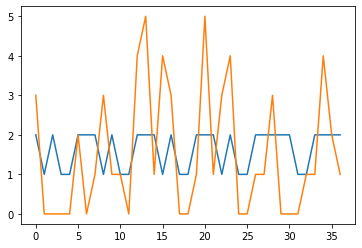

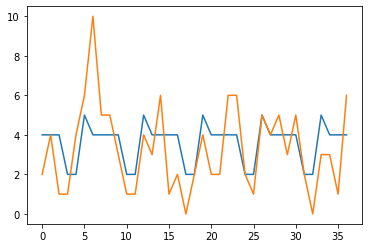

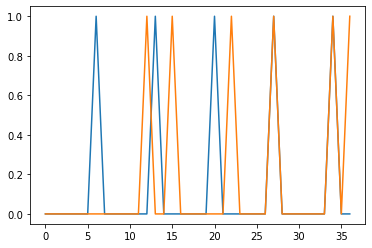

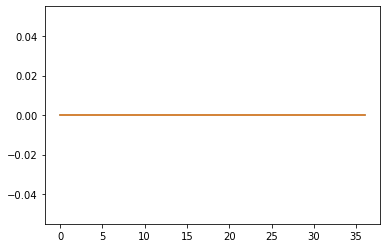

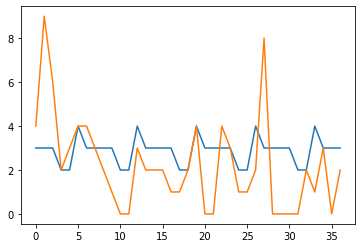

In [13]:
def plot_results(col, results_df, test):
    '''
    plots test against forecast time series for h3 index
    
    col - column corresponding to h3 index
    results_df - model predictions
    test - in-sample observations to test model predictions
    
    returns None, executes in place
    
    '''
    
    plt.figure()
    plt.plot(results_df[col].values)
    plt.plot(test[col].values)
    plt.show()

# only plot first five to get an idea of performance at daily temporal resolution

for col in daily_results_df.keys()[:5]:
    plot_results(col, daily_results_df, test)

In [14]:
# error metrics for each h3 index at daily resolution

daily_results_error = pd.DataFrame(columns = daily_results_df.columns, index = ['RMSE', 'MAE'])
daily_results_error.loc['RMSE', :] = rmse_(daily_results_df, test, squared = False, multioutput='raw_values')
daily_results_error.loc['MAE', :] = mae_(daily_results_df, test, multioutput='raw_values')
daily_results_error

88ad36c6d9fffff 88ad36d429fffff 88ad360e2dfffff 88ad368db5fffff  \
RMSE        3.620512         2.53089        0.434959             0.0   
MAE         2.675676        2.189189        0.189189             0.0   

     88ad368d8dfffff 88ad36c6adfffff 88ad368d81fffff 88ad368d97fffff  \
RMSE        2.388033        2.875808        4.003377        3.196282   
MAE         2.243243        2.486486             3.0        2.540541   

     88ad361081fffff 88ad361001fffff  ... 88ad3656bbfffff 88ad367289fffff  \
RMSE        3.487429             4.0  ...        0.164399        0.164399   
MAE         2.378378        3.675676  ...        0.027027        0.027027   

     88ad368713fffff 88ad36173bfffff 88ad365657fffff 88ad36d71bfffff  \
RMSE        0.164399        0.164399        0.164399        0.164399   
MAE         0.027027        0.027027        0.027027        0.027027   

     88ad368519fffff 88ad3656c1fffff 88ad361b51fffff 88ad361627fffff  
RMSE        0.164399        0.164399        0.164399        0.164399  
MAE         0.027027        0.027027        0.027027        0.027027  

[2 rows x 2082 columns]

### Weekly Results Analysis

(6, 2082) (6, 2082)


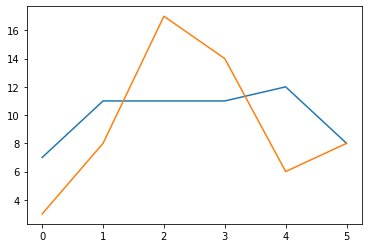

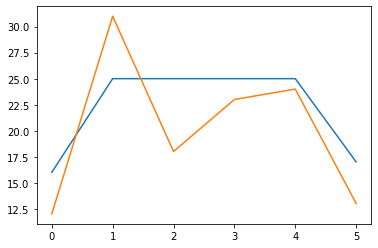

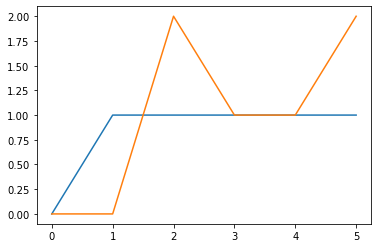

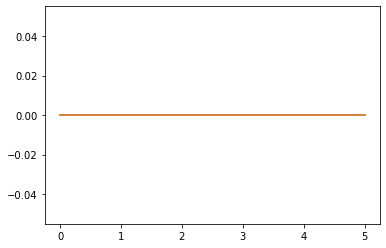

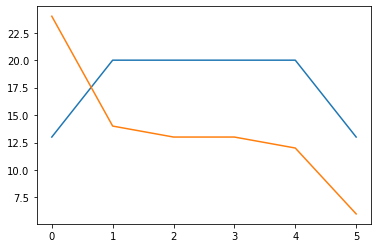

In [15]:
# aggregate test and forecast data tp weekly temporal scale

weekly_results_df = daily_results_df.resample('w').sum() # transform
weekly_test = test.resample('w').sum() # transform
print(weekly_results_df.shape, weekly_test.shape) # weekly results must match available test dates and data

# only plot first five to get an idea of performance at weekly temporal resolution

for col in weekly_results_df.keys()[:5]:
    plot_results(col, weekly_results_df, weekly_test)

In [16]:
# error metrics for each h3 index at weekly resolution

weekly_results_error = pd.DataFrame(columns = weekly_results_df.columns, index = ['RMSE', 'MAE'])
weekly_results_error.loc['RMSE', :] = rmse_(weekly_results_df, weekly_test, squared = False, multioutput='raw_values')
weekly_results_error.loc['MAE', :] = mae_(weekly_results_df, weekly_test, multioutput='raw_values')
weekly_results_error

88ad36c6d9fffff 88ad36d429fffff 88ad360e2dfffff 88ad368db5fffff  \
RMSE       17.354154       13.447429        0.707107             0.0   
MAE             14.5       12.833333             0.5             0.0   

     88ad368d8dfffff 88ad36c6adfffff 88ad368d81fffff 88ad368d97fffff  \
RMSE       14.241957       12.987173       18.380243       16.792856   
MAE        13.833333       12.333333       16.166667       15.666667   

     88ad361081fffff 88ad361001fffff  ... 88ad3656bbfffff 88ad367289fffff  \
RMSE       11.298968       21.832697  ...        0.408248        0.408248   
MAE              9.0            21.0  ...        0.166667        0.166667   

     88ad368713fffff 88ad36173bfffff 88ad365657fffff 88ad36d71bfffff  \
RMSE        0.408248        0.408248        0.408248        0.408248   
MAE         0.166667        0.166667        0.166667        0.166667   

     88ad368519fffff 88ad3656c1fffff 88ad361b51fffff 88ad361627fffff  
RMSE        0.408248        0.408248        0.408248        0.408248  
MAE         0.166667        0.166667        0.166667        0.166667  

[2 rows x 2082 columns]

## Out-of-sample Weekly Forecasts (Final Answer)

In [17]:
# follow same procedure as above (training and validation) except now uese all available data to fit model and produce out-of-sample forecasts

daily_horizon = 28 # corresponds to 4 weeks into the future
final_daily_results = manager.dict()

# parallelize for efficient computation

job = [Process(target = train_and_val, args = (y, final_daily_results, df_prep, daily_horizon)) for y in df_prep.keys()]
_ = [p.start() for p in job]
_ = [p.join() for p in job]

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -14.1392
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.345
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      47       438.861   0.000318004       82.2404   4.346e-06       0.001      111  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      51       503.916   8.84326e-05       75.0501   1.089e-06       0.001      107  LS failed, Hessian reset 
      81       438.896   8.56022e-05       89.8434   1.191e-06       0.001      188  LS failed, Hessian reset 
      99       438.903   1.98705e-06       62.7787           1           1      214   
      97       503.922   1.72086e-08       60.4776      0.6352      0.1437      175   


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199         439.7   0.000342327       97.6448      0.8997      0.8997      334   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.37366
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     271       439.776   2.25538e-09       77.4539      0.1457      0.1457      426   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      66       465.291   5.44215e-06       72.1128   6.561e-08       0.001      126  LS failed, Hessian reset 
      89       465.291   4.78716e-09       73.0031     0.05852     0.05852      158   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -29.3353


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       508.697   2.19723e-05       86.3157           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       508.729   0.000148455       90.3972   2.328e-06       0.001      178  LS failed, Hessian reset 
     186       508.756   6.63154e-08       86.4292           1           1      270   
Initial log joint probability = -10.2327
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -12.8615
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.422
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       498.092   4.65398e-05       74.5203      0.2537           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       440.729   1.27965e-06       95.8626       0.624       0.624      130   
      98       506.746   0.000612837       99.9287   6.203e-06       0.001      156  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       506.751   0.000176591       90.0707      0.3078           1      158   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     150       506.777   5.78384e-09       96.2064      0.2038      0.2038      220   
     156        440.73   1.03563e-08       78.4958      0.2487      0.9467      195   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     135       498.112   4.43036e-05       49.1844   5.932e-07       0.001      211  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -10.3662
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     197       498.131   3.05277e-06       68.1216   4.222e-08       0.001      327  LS failed, Hessian reset 
     199       498.131   4.72493e-07       60.6902      0.4583      0.4583      329   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     215       498.131   8.08998e-09        74.243      0.2561     0.02561      354   
Initial log joint probability = -6.18408
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      47       489.368    0.00124068       82.8455   1.569e-05       0.001      102  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.96832
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      82       540.014   3.03308e-08        95.772      0.7833      0.7833      105   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       489.457   9.92568e-08       75.7641      0.4322      0.4322      179   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       489.457   3.56598e-09       62.9778     0.07095     0.07095      202   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.33072
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99        692.09   3.27967e-07       68.8603       0.412           1      137   


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      47        757.95   1.27619e-05       71.5705   1.882e-07       0.001      110  LS failed, Hessian reset 
     111        692.09   1.28473e-08       74.7667       0.189      0.6726      152   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.92129
Initial log joint probability = -5.63567
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       757.953   2.60024e-08       78.9698      0.3359      0.3359      183   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      92       592.262    0.00131936       81.4962   1.703e-05       0.001      150  LS failed, Hessian reset 
      99       592.312   0.000323709        60.099           1           1      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -11.6816
     182       592.365   2.62324e-05       62.4944   3.201e-07       0.001      307  LS failed, Hessian reset 
Initial log joint probability = -7.231
     199       592.366     1.994e-07       62.9934      0.2664           1      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     227       592.375   3.99467e-05       72.2796   5.926e-07       0.001      403  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       585.293   1.55453e-05       75.4394      0.8754      0.8754      131   
Initial log joint probability = -17.5214
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     248       592.376   9.17947e-07       69.6493   1.349e-08       0.001      469  LS failed, Hessian reset 
     259       592.376    2.2015e-08       57.1363      0.2702           1      486   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       761.629   0.000265342       62.4784           1           1      138   
      77       533.254   0.000366364       75.4494    4.12e-06       0.001      138  LS failed

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.07951
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       550.987   2.11306e-06       92.7048     0.09296           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.1897
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       550.988   2.12268e-06       72.5073   2.645e-08       0.001      246  LS failed, Hessian reset 
     175       550.989   6.84752e-09        61.652     0.03552           1      275   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       419.502   2.43922e-07       68.7856      0.3059           1      142   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       419.502   2.62701e-07       58.7203   4.086e-09       0.00

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.29942
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       560.485   3.11576e-08        66.857      0.6663      0.6663      121   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.35244
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      84       626.708   6.35519e-05       90.7105   7.038e-07       0.001      140  LS failed, Hessian reset 
      99       626.714   3.89481e-06       80.2414      0.2862           1      160   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127       626.715   1.14121e-06       88.9595    1.34e-08       0.001      239  LS failed, Hessian reset 
Initial log joint probability = -4.80744
     136       626.715    3.2391e-08       77.5062      0.1748           1      253   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      97       622.005   3.21869e-05       67.7949   3.557e-07       0.001      180  LS failed, Hessian reset 
      99       622.006    2.8024e-05       87.0115           1           1      182   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     187       622.076   0.000521644       79.6413   7.272e-06       0.001      343  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199       622.103    2.7611e-05       97.5823      0.5021      0.5021      359   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     245       622.109   3.50204e-06        78.188   4.644e-08       0.001      459  LS failed, Hessian reset 
Initial log joint probability = -10.4405
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     275        622.11   7.09208e-09       73.0466      0.0563      0.8498      501   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       475.149   0.000305625       102.239           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       475.292   0.000700879       96.3012    5.99e-06       0.001      196  LS failed, Hessian reset 
Initial log joint probability = -7.17817
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.0714
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      47       552.723   0.000110888       66.0005   1.369e-06       0.001      111  LS failed, Hessian reset 
     182       475.393   0.000150415       101.173   1.566e-06       0.001      349  LS failed, Hessian reset 
     199       475.419   9.311

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      88       470.962   4.41325e-09       65.3972      0.1763      0.7685      160   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     105        552.73   1.34872e-05       79.2014   1.272e-07       0.001      228  LS failed, Hessian reset 
     127       552.731   7.75566e-09       65.7469     0.02285      0.7038      259   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     270       475.421   1.63259e-08       91.3634      0.3252           1      460   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.50963


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.57298
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       642.919   0.000361153       72.1435           1           1      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       642.967   0.000942149       78.1331   8.307e-06       0.001      186  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.61884
      99       599.573   0.000494128       81.3604           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.79907
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      42       585.848   0.000840354       77.1008   8.778e-06       0.001       94  LS failed, Hessian reset 
     199       643.004   1.02894e-07       85.5091      0.3749      0.3749      308   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     154       599.673   6.27764e-05       66.7707   8.204e-07       0.001      265  LS failed, Hessian reset 
Initial log joint probability = -5.19133
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       586.01

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       604.139   4.09951e-07       84.5926      0.1626           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       604.139   3.00404e-08       72.5469      0.8621      0.8621      134   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     282       643.014    5.4476e-09       76.0143      0.1749      0.1749      468   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     152       586.071   3.99935e-09       79.6473      0.1106      0.1106      272   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     199       510.353   3.31311e-07        89.842      0.8505      0.8505      285   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.0385
    Iter      log prob  

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     290       510.367   7.12202e-06       91.6582    7.17e-08       0.001      439  LS failed, Hessian reset 
     299       510.367   6.88131e-07       78.8649       0.211           1      449   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     315       510.367   8.90972e-09       77.2401      0.3244      0.3244      469   
      99       438.374   1.99355e-07       89.3051      0.3106           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      78       539.409   0.000117012       101.436   1.174e-06       0.001      141  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       539.415   1.32775e-06       91.8926           1           1      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       539.416   1.64058e-08       88.8228      0.5612      0.5612      191   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     138       438.409   0.000194106       102.502   1.811e-06       0.001      224  LS failed, Hessian reset 
Initial log joint probability = -8.56679
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199       438.423   2.80519e-08       91.4842       0.411           1      300   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.92057
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.22088
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       575.876   1.26286e-05       70.1166      0.6981      0.6981      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.11946
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -11.9658
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     148       575.943   0.000116976        88.688   1.486e-06       0.001      234  LS failed, Hessian reset 
Initial log joint probability = -8.80739
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      79       679.011   4.99681e-05       52.3613   5.751e-07       0.001      143  LS failed, Hessian reset 
      64       664.244    0.00185907       114.312   1.527e-05       0.001      115  LS failed, Hessian reset 
      87       602.817   0.000283782       80.6331   3.504e-06       0.001      159  LS failed, Hessian reset 
     193       575.954   2.64603e-08       77.5027      0.5438      0.5438      291   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       679.013    1.5127e-06       63.6305           1           1      175   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.9128
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      75       664.339   6.98625e-05       52.3091   9.984e-07       0.001      167  LS failed, Hessian reset 
      99       602.838   5.87239e-05       81.5366  

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      67       526.094    0.00184606       85.7352   2.272e-05       0.001      117  LS failed, Hessian reset 
     153       602.843   9.83997e-09       83.7202      0.5353      0.5353      242   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       664.353   1.23525e-05       53.4069           1           1      202   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       463.169   1.53817e-05       87.5295           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       526.217   1.53666e-07       77.1695      0.1635      0.1635      154   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.0005
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        512.47   1.0

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     235       679.038   2.36459e-08       60.7063     0.05672           1      425   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199        664.36   5.81545e-07        62.151      0.3363           1      386   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     182       463.173    8.2188e-09       85.9122      0.3469      0.3469      269   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      95       519.025    0.00189099       72.7428   2.171e-05       0.001      173  LS failed, Hessian reset 
      99       519.064   8.02703e-05       75.6809      0.3463      0.3463      178   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136       519.086   5.55299e-05       75.7246   7.419e-07       0.001      264  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     220       664.361   1.33036e-06       62.9988   2.519e-08       0.001      446  LS failed, Hessian reset 
     229       664.361   1.03133e-08       50.5664     0.04836      0.4903      461   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     178       448.093   9.85496e-05       102.962   9.049e-07       0.001      329  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199        519.09   2.30547e-08       76.1538      0.3176           1      351   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     201        519.09    4.9223e-08       70.7628           1           1      353   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       448.127   0.000138673       85.6912      0.5654      0.5654      351   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -10.7069
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.3364
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     261       448.137   6.58908e-09       79.4717      0.1853      0.1853      434   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.0852
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       422.194   3.62692e-07       88.8525       0.266       0.266      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       458.325   1.97207e-07       92.3128      0.6712      0.6712      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       458.325   8.08479e-09       101.942      0.5273      0.5273      135   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -8.45921
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.27339
     124       422.194   5.18068e-09       77.6587      0.2608      0.7751      155   
Optimization terminated normally: 
  Convergence detected

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199       469.655   3.70974e-07       75.8765      0.2038           1      303   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     210       469.655   8.42056e-08       76.2626           1           1      318   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     274       494.386   6.50296e-06       71.2185   6.725e-08       0.001      426  LS failed, Hessian reset 
     293       494.386   9.11149e-09        73.282      0.2719           1      449   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -3.92422
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.38829
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      73       661.546   0.000501219       76.6996   5.819e-06       0.001      134  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       661.572   1.77919e-05       83.9712           1           1      175   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.4101
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.52967
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     132       661.575   1.31476e-08       54.4864      0.2979      0.2979      234   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       570.448   8.56953e-05        74.697           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      56       558.648   8.78718e-05       80.8921   9.669e-07       0.001      115  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       482.809    1.1687e-06       101.304       0.523       0.523      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     172       570.457    4.4717e-06       85.2914   5.234e-08       0.001      270  LS failed, Hessian reset 
Initial log joint probability = -7.6324
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.40655
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       570.457   5.24125e-08       70.4424           1           1      306   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     205       570.457   4.85058e-08       76.2262           1           1      313   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      94       558.654   9.40214e-06       91.7676    1.01e-07       0.001      209  LS failed, Hessian reset 
      99       558.655   1.07744e-06       85.9956      0.4228      0.4228      216   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     181       482.914    4.8515e-06       99.6507   5.644e-08       0.001      262  LS failed, Hessian reset 
     109       558.655   9.05042e-09       80.8558       0.142       0.142      231   
Optimiz

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     220       482.916    9.7865e-09        88.463      0.2966      0.2966      307   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       510.485   0.000225582        83.171      0.5853      0.5853      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.83533
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       743.034   0.000199851        74.142      0.3903      0.3903      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -13.9982
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.6878
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.46996
    Iter  

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     155       743.096   0.000252173       73.0979   2.912e-06       0.001      274  LS failed, Hessian reset 
      48       500.344   0.000482389       98.7813   4.966e-06       0.001       93  LS failed, Hessian reset 
      80       555.179   0.000379965       77.2843   5.427e-06       0.001      146  LS failed, Hessian reset 
      99       383.142    0.00147645       77.0293           1           1      147   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       413.083   0.000208933       77.9481      0.2738      0.9086      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       555.207   6.66263e-05       71.0822           1           1      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     182       743.107   6.74139e-06       71.9486   9.988e-08       0.001      347  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       500.462   0.000218854       98.0897      0.5632      0.5632      151   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       383.201   5.15483e-05       52.8133   8.875e-07       0.001      205  LS failed, Hessian reset 
     199       743.107   3.37389e-07       71.9094      0.8479      0.8479      371   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.5514
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     212       743.107   3.03783e-08       70.3125      0.9237      0.9237      388   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     128       555.213   4.84982e-06       78.3938   6.287e-08       0.001      245  LS failed, Hessian reset 
     160       413.099   6.98498e-09       82.7413      0.2151      0.2151      223   
Optimiz

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.53768
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      35       461.365   6.57513e-05       76.5064   1.032e-06       0.001       86  LS failed, Hessian reset 
      99       602.666    1.4532e-07       64.0107      0.4782      0.4782      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       602.668   3.57296e-05        91.191   4.809e-07       0.001      186  LS failed, Hessian reset 
     163        500.51   6.60297e-06       62.3824   8.301e-08       0.001      277  LS failed, Hessian reset 
     154       555.213   4.41341e-06       81.9257   5.557e-08       0.001      322  LS failed, Hessian reset 
Initial log joint probability = -13.2195
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     178       555.214   2.83009e-08       65.6107      0.3632           1      356   
Optimization terminated 

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     218       500.511   1.77081e-08       65.0606      0.3823      0.3823      347   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     128       461.709   5.40693e-05       89.9484   6.735e-07       0.001      243  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       461.758   7.98719e-06       72.9226           1           1      331   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.69312
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     252       461.759    4.2137e-08       74.1665      0.5733      0.5733      399   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       461.242   1.39794e-06       84.8868      0.3887           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     137       461.243   2.99506e-08        74.318      0.9239      0.9239      182   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -7.87355
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.25031
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84       502.936   5.02941e-06       90.4408   5.337e-08       0.001      151  LS failed, Hessian reset 
      99       502.937    3.5861e-08       78.9067      0.7261      0.7261      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       502.937    2.0791e-08        76.985      0.0945           1      175   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -7.00812
    Iter      log

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      72       464.969   7.76733e-09       68.1354      0.3159      0.3159      136   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     162       554.976   3.03897e-08       62.9223     0.08679           1      235   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -8.61577
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.0969
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       496.446   2.33326e-06       68.6589           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     135       496.464   0.000120269       93.4603   1.361e-06       0.001      201  LS failed, Hessian reset 
      99       574.126   2.20558e-05       69.5351           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -13.7157
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     130       574.129   1.23861e-05       65.9102   1.241e-07       0.001      207  LS failed, Hessian reset 
      92        424.02   0.000384259       92.4424   4.068e-06       0.001      166  LS failed, Hessian reset 
      99       424.105   0.000317703        89.511       0.579       0.579      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       496.472   1.83492e-08        70.422      0.4708      0.4708      293   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     200       496.472   3.90348e-08        72.803      0.3478       0.831      295   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     163       574.129   1.14382e-08       70.0835      0.4132      0.4132      251   
Optimiz

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     107       485.047   7.08316e-05        66.144   1.033e-06       0.001      248  LS failed, Hessian reset 
     141       485.051   4.08066e-08       58.2478      0.2948           1      296   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -20.0619
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.09653
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.54393
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.42951
Initial log joint probability = -5.34685
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -8.80087
      36       645.551   0.000185103       74.9455   2.863e-06       0.001       89  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      67       721.139   0.000595217       76.6522    5.73e-06       0.001      124  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       443.536   0.000341737       77.2846           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       606.706   0.000719723       98.7649      0.8927     0.08927      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79        457.35   0.000247631       97.4011   2.961e-06       0.001      139  LS failed, Hessian reset 
      88        645.56   9.72234e-08        73.147           1           1      162   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       721.175    2.3861e-05        76.097      0.7163     0.07163      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -19.1374
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probabil

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     134       721.176   7.08918e-09       87.6754      0.1629      0.1629      215   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      70       465.905   3.31822e-05       92.2441   3.692e-07       0.001      133  LS failed, Hessian reset 
     173       606.786    2.2842e-08       86.2313      0.3977      0.3977      227   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       465.907   2.05568e-07        74.286           1           1      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       465.907   8.12452e-09        69.403      0.3291      0.3291      182   
     168       443.551   2.59463e-07       76.9642   3.028e-09       0.001      255  LS failed, Hessian reset 
     181       443.551    2.4107e-08       84.6861           1           1      271   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -8.68286
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     165       457.365   4.35475e-06        95.135   4.711e-08       0.001      283  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -11.8266
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       457.366   2.87022e-08       78.3824           1           1      328   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.01939
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        688.56   4.09913e-05       98.4711       4.823           1      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       491.339   7.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     144       491.342     1.436e-08       80.1163      0.7272      0.7272      185   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -10.6256
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     135       688.562   1.39505e-08       75.2295      0.6113      0.6113      191   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.31635
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      49       496.326    0.00136355       66.2767   1.522e-05       0.001      100  LS failed, Hessian reset 
     138       376.123   4.50258e-05       62.3162   6.903e-07       0.001      212  LS failed, Hessian reset 
      47       643.348      0.012266       106.573   0.0001588       0.001       96  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       609.654   1.29236e-05       108.218           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        522.11   2.84363e-05       71.7856      0.3134      0.9184      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       496.391   0.000336444        77.485           1           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88       557.836   0.000323072       73.7327   4.143e-06       0.001      148  LS failed, Hessian reset 
      99       557.852   2.21055e-05       72.5818      0.1947           1      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       376.125   7.82816e-07       75.4619           1           1      300   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     130       557.853   8.36262e-09        74.287      0.2671      0.2671      205   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -3.98502
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       648.989   5.02156e-07       72.1127      0.8622      0.8622      149   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     128       496.411   8.33289e-05       58.7452   1.008e-06       0.001      245  LS failed, Hessian reset 
     149       522.126   9.24572e-05       102.447   9.246e-07       0.001      242  LS failed, Hessian reset 
     109       644.107   1.30776e-05       90.5236    1.81e-07       0.001      261  LS failed, Hessian reset 
Initial log joint probability = -7.68423
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability 

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     134       644.108   9.71934e-09       76.0669      0.1559      0.1559      291   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     266       376.127   2.94672e-08       51.0406           1           1      428   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -9.29062
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     128        648.99   2.15444e-08       63.2992       0.502       0.502      237   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     185       496.419   5.33551e-05       66.6089   6.688e-07       0.001      385  LS failed, Hessian reset 
     199       496.421    2.3758e-06       61.9643      0.4175           1      410   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     225       496.422   4.93258e-07       52.3992   7.537e-09       0.001      482  LS failed, Hessian reset 
     192       522.133   1.00619e-06       72.0796    1.22e-08       0.001      

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -11.922
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.9837
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     207       522.133   2.98996e-08        70.004      0.2738           1      351   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       727.917   2.10322e-06        92.877      0.1313      0.1313      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       534.695   3.37352e-06       88.2841      0.4829      0.4829      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      95       430.763    0.00194994       97.6157   1.992e-05       0.001      152  LS failed, Hessian reset 
      99       430.837   0.000147697       80.8936     0.05767           1      158   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      58       429.578    0.00143148        69.286   1.419e-05       0.001      111  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      56        451.66   0.000426566       85.9706   4.848e-06       0.001      108  LS failed, Hessian reset 
     139       727.918   1.27485e-07       77.0218      0.3401           1      190   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3.56115
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       510.623   7.79098e-05       71.0313   1.208e-06       0.001      169  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       534.728   9.83588e-05       89.6895   1.045e-06       0.001      187  LS failed, Hessian reset 
Initial log joint probability = -4.18311
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       429.643   3.37604e-05       82.4869           1           1      168   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      86       451.688   1.51101e-05       100.454   1.509e-07       0.001      181  LS failed, Hessian reset 
      99       451.689    9.5202e-07       80.0985           1           1      198   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       510.626    8.9196e-07       78.5484   1.153e-08       0.001      268  LS failed, Hessian reset 
     198        534.75   2.45227e-08       77.3666      0.5437      0.5437      288   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       734.178   3.90362e-07       78.4338      0.9118      0.9118      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       695.534   0.000271325       92.6213           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     148       510.626   9.24093e-09       69.37

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     175       429.858   2.50535e-09       84.2291     0.04836     0.04836      278   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     102       695.552   0.000240543       99.1217   2.554e-06       0.001      167  LS failed, Hessian reset 
     127       451.689   3.25192e-06       99.9452   3.703e-08       0.001      270  LS failed, Hessian reset 
Initial log joint probability = -3.85742
Initial log joint probability = -11.4227
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.79807
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     161        451.69   3.99436e-09       85.8398      0.2479      0.2479      312   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below toler

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       551.508   2.08173e-05       99.3208      0.5229      0.5229      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.05843
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      95       699.094   9.13985e-09       64.3868     0.07448           1      131   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -8.86727
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      97       554.075    2.3729e-05       86.6549   3.225e-07       0.001      159  LS failed, Hessian reset 
      99       554.075   3.56178e-06       64.9427      0.1917           1      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       554.076   2.04697e-08       73.1929      0.3527      0.983

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      36        555.59     0.0008707       77.3581   1.165e-05       0.001       86  LS failed, Hessian reset 
Initial log joint probability = -6.82566
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       517.283   1.11986e-05       76.6957      0.3664           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      77       555.666    0.00011471       80.2191   1.477e-06       0.001      168  LS failed, Hessian reset 
Initial log joint probability = -6.07087
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.92634
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        555.69   2.53967e-05       62.3167       1.248      0.4821      196   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     177       551.55

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -7.43332
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     125        555.69   6.94435e-08       80.0973           1           1      232   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     138       517.286   3.98092e-06       78.3921   5.255e-08       0.001      224  LS failed, Hessian reset 
Initial log joint probability = -3.7102
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -7.62463
      99       561.678   0.000293701       104.455      0.1926           1      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      42       550.999   0.000352753       72.3399   4.527e-06       0.001       94  LS failed, Hessian reset 
     160       517.286   5.34608e-09       68.5123      0.1485      0.1485      252   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      94       549.841   1.31038e-08       66.3864      0.2112           1      125   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.54354
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       558.319   1.09682e-05        82.483           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.44739
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       561.686   0.000363688       99.3862   4.024e-06       0.001      203  LS failed, Hessian reset 
Initial log joint probability = -13.0325
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probabil

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     116       558.322   1.65171e-05       74.7434   1.691e-07       0.001      187  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     146       558.323   3.39779e-09       60.3549      0.1185      0.1185      225   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99        690.22   6.96198e-05        80.777           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       551.088   0.000361237       77.9033   4.343e-06       0.001      209  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       536.847   4.89511e-07        91.156      0.3143      0.3143      142   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       892.051   1.48356e-05       89.0865           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      67       606.885   0.000366153        76.772   4.446e-06      

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

      99       458.159    8.3015e-08       95.3178      0.3716      0.3716      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       458.159   8.26964e-09       102.766      0.4094      0.4094      144   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       892.063   6.11147e-05       87.7627   7.038e-07       0.001      185  LS failed, Hessian reset 
     199       561.709   2.53253e-07       73.5121      0.4251           1      363   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       606.903   4.33485e-06       84.3727           1           1      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     145       551.108   7.28579e-09        85.604      0.2372      

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.02486
     166       690.234   1.90817e-08       71.9225      0.3727      0.9975      294   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        559.04   3.29665e-06       69.0311      0.3579           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.11379
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.34699
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.10457
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.94346
    Iter      log prob        ||dx||      ||grad||     

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      65       654.363   9.32142e-05       95.0138   9.336e-07       0.001      113  LS failed, Hessian reset 
     210       606.924   5.06135e-09       68.8438      0.1574      0.1574      357   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       654.367   3.21123e-07       77.6547           1           1      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       654.367   2.71444e-08       93.8151       0.335           1      185   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -14.1385
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     187       559.046   3.47639e-08       69.1848      0.8395      0.8395      244   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality

      57       674.364    0.00087097        94.372    7.63e-06       0.001      118  LS failed, Hessian reset 
      99       521.845     0.0010962       98.3821      0.8807      0.8807      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       744.674   4.35339e-06       67.2059      0.7715      0.7715      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       581.853   8.38362e-07        67.843           1           1      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       521.903    0.00028232        73.488   4.098e-06       0.001      169  LS failed, Hessian reset 
     123       744.674   9.00717e-09        64.259      0.2981           1      165   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      86       674.435   3.23921e-05       91.381

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     127       581.857   4.22874e-06       96.6835   5.176e-08       0.001      275  LS failed, Hessian reset 
     166       521.935   3.19122e-08       92.4047      0.8851      0.8851      245   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       486.409   4.69025e-06        88.173      0.6511      0.6511      264   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147       581.857   8.24411e-09       85.0268      0.2229      0.2229      306   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     137       674.439   6.85556e-09       71.0305      0.2322      0.2322      261   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -10.6329
Initial log joint probability = -9.02086
    Iter      log prob        ||dx||      ||grad|| 

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     227        486.41   1.16665e-08       71.0577      0.2258      0.9191      307   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -8.73939
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.81382
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      60       422.467   2.80614e-08       71.4931      0.1998      0.8854       87   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      55        516.09   0.000244829       61.7621   3.567e-06       0.001      105  LS failed, Hessian reset 
Initial log joint probability = -6.85437
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.22223
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      67       420.893   8.13979e-05       75.5105   9.756e-07       0.001      127  LS failed, Hessian reset 
      74       493.772   0.000847751       82.0395   1.035e-05       0.001      141  LS failed, Hessian reset 
      84       405.066   0.000915833       102.751   9.202e-06       0.001      143  LS failed, Hessian reset 
      99       678.418    0.00146723       83.1343     0.08265           1      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         420.9   5.16975e-07       68.3638      0.2084           1      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      65       684.632    0.00424028       203.284   5.033e-05       0.001      112  LS failed, Hessian reset 
      99       405.157   1.09545e-05       94.3176      0.4388   

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -8.11167
Initial log joint probability = -8.51214
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102        678.43   0.000791563       69.1096   9.231e-06       0.001      187  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     101       692.711   2.70075e-05       72.2819   3.001e-07       0.001      163  LS failed, Hessian reset 
     133         420.9   7.50956e-09       74.5499     0.06462           1      215   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       685.007    0.00118496        87.505           1           1      155   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       516.126   7.30737e-07       69.0643   9.291e-09       0.001      209  LS failed, Hessian reset 
      99       542.241   0.000498396       101.466          10           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       516.126   2.48627e-08       61.3649      0.4541      0.4541      224   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -9.15978
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     166       405.161   1.14734e-08       98.1267      0.6745      0.6745      295   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      80       488.379   9.80348e-09       79.9167      0.2903      0.2903      118   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       756.141   1.22122e-06       78.0175           1           1      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104        542.28   0.000544849       99.0866   5.074e-06       0.001      197  LS failed, Hessian reset 
      51       561.727   0.000711246       74.3454   8.616e-06       0.001      109  LS failed, Hessian reset 
     199       678.478   3.35668e-07       52.2197      0.2584           1      3

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       561.754   1.08096e-05       72.6926      0.1056      0.3559      177   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       513.056   6.20971e-09       80.1663      0.2394      0.2394      194   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      61       609.363   0.000412809       63.5867   4.235e-06       0.001      134  LS failed, Hessian reset 
     102       428.332   8.97831e-05       79.6068   9.259e-07       0.001      173  LS failed, Hessian reset 
     199       685.216   5.89975e-08       71.0867      0.1527           1      368   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       561.805   0.000381908       60.9355   5.408e-06       0.001      237  LS failed, Hessian reset 
      99       505.614   4.53591e-06       68.8599      0.9887      0.9887      138   
    Iter      log prob        

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       542.356   3.56934e-08       97.0373      0.6244      0.6244      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127       505.631   1.23398e-05       82.2396   1.873e-07       0.001      221  LS failed, Hessian reset 
     275       494.028   9.69363e-05       76.4969   9.525e-07       0.001      483  LS failed, Hessian reset 
     179       546.444   0.000103856       94.3315   1.026e-06       0.001      288  LS failed, Hessian reset 
     299       494.034   1.97114e-06       66.7142      0.9472      0.9472      517   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     204       542.356   9.77682e-09       89.3006      0.4788      0.4788      355   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -6.73331
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199       561.887   3.91469e-05       62.8611      0.3096      0.3096      351   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151       627.608    5.7329e-08       67.4802       1.849      0.5131      241   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     133       609.402   8.41405e-05       66.4271   1.142e-06       0.001      280  LS failed, Hessian reset 
     229       546.457   2.19296e-08       79.4754      0.3439           1      351   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     352       494.042   9.79148e-07       82.5391   1.185e-08       0.001      659  LS failed, Hessian reset 
     199       505.645   1.85674e-07       77.2536      0.4669           1      310   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     171       609.419   4.11893e-

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasona

      75       589.492    0.00180682       77.7694   1.721e-05       0.001      134  LS failed, Hessian reset 
     209       505.645   9.77163e-07       71.9877   1.166e-08       0.001      358  LS failed, Hessian reset 
     218       505.645   1.05512e-08       64.1182      0.2944      0.2944      372   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      84        708.75   1.65762e-05       68.7758   2.131e-07       0.001      141  LS failed, Hessian reset 
      99       589.639    7.5424e-07       79.4287      0.2644      0.2644      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       708.751   2.42413e-07       80.1619      0.4821      0.4821      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       708.751   2.51365e-08       78.8901      0.4347      0.4347      181   
Optimization terminated norma

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     147       589.642   3.81301e-08       84.9013           1           1      233   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6.24862
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     306        561.91    3.7945e-06       57.0298   3.728e-08       0.001      528  LS failed, Hessian reset 
Initial log joint probability = -6.62531
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     320        561.91   2.55917e-08       57.0208      0.1862           1      554   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.30243
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.39632
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.69192
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.847
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      83       545.775   0.000462287       97.5496   4.547e-06       0.001      153  LS failed, Hessian reset 
Initial log joint probability = -3.5294
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       502.668   3.83323e-05       88.1082      0.8435      0.8435      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       545.825   2.02393e-05       87.3832      0.4399      0.4399      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       676.032   3.29105e-08       73.3826      0.6401      0.6401      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       676.032   1.96024e-08       76.0789      0.4004           1      134   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      64       728.101   0.000248851       64.5573   3.406e-06       0.001      121  LS failed, Hessian reset 
      99       545.793    0.00116774       91.3862      0.4567           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.00755
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       545.843   6.82414e-05       90.9554   6.869e-07       0.001      253  LS failed, Hessian reset 
      74       549.012   0.000107839        81.071   1.144e-06       0.001      132  LS failed

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       489.524   7.61811e-05       86.1348           1           1      144   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       549.016   1.66323e-07       86.8053      0.1274      0.1274      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     103       489.538   7.95865e-05       79.6891   9.162e-07       0.001      183  LS failed, Hessian reset 
     199       545.857   9.62082e-07       81.5005       0.157           1      333   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     138       728.154   4.63983e-05       80.8952   5.439e-07       0.001      264  LS failed, Hessian reset 
Initial log joint probability = -7.58738
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      73       436.343   0.000121735       66.8279   1.366e-06       0.001      139  LS failed, Hessian reset 
     213       545.858   2.54304e-08       77.4594      0.7849      0.7849      350   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199       545.848   0.000179189            65      0.8892      0.8892      256   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.72932


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      73       523.026   1.46712e-06       89.2791    1.62e-08       0.001      137  LS failed, Hessian reset 
      92       523.026   1.56105e-08       83.2249      0.2552      0.2552      163   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       436.352   8.26673e-06       86.9431           1           1      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       631.384   0.000317995       101.385   3.287e-06       0.001      163  LS failed, Hessian reset 
      99       631.391   0.000236782       67.3365           1           1      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       728.168     9.726e-05       55.8412      0.3321      0.3321      346   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     240       728.175   3.69093e-08       60.4843      0.1081           1      411   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      58       636.545     2.293e-05        86.837   2.437e-07       0.001      115  LS failed, Hessian reset 
      99       550.618   3.64054e-05       71.8373   4.549e-07       0.001      161  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     192       631.442   4.71616e-05       79.8591   6.226e-07       0.001      318  LS failed, Hessian reset 
Initial log joint probability = -6.32687
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       436.627   1.77375e-07       77.6181           1           1      341   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     260       549.093   2.70575e-08       79.6681      0.3357        

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     111       636.546   4.91495e-08       61.9644           1           1      183   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     299       631.479   1.01157e-05       64.5676      0.2884           1      451   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     277       545.974   1.51104e-06       84.4417   2.116e-08       0.001      434  LS failed, Hessian reset 
     136       550.619   9.01965e-09       68.6589      0.1249      0.1249      249   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     295       545.974    2.4504e-08       77.0543      0.2452           1      457   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      78       598.495   0.000189918       76.4212   2.893e-06       0.001      151  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.33877
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.65458
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     399       631.496   0.000713124        60.625           1           1      566   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       607.403   0.000189126       93.9178           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       598.506   6.75551e-06       44.1285      0.7033      0.2374      182   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.85177
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     412       631.621   0.000762905        90.705   9.375e-06  

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     137       598.507   3.58273e-06       97.7287   5.222e-08       0.001      268  LS failed, Hessian reset 
     179       607.464    1.5157e-08       69.1592      0.2713           1      236   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      84       565.021   0.000782178       67.8217   9.382e-06       0.001      141  LS failed, Hessian reset 
      98       612.148   4.48966e-05        74.881    6.88e-07       0.001      156  LS failed, Hessian reset 
      99       612.148   3.60305e-05       68.7535           1           1      157   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     499        631.71   7.69514e-06       84.7279           1           1      736   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     160       598.508   1.24532e-08       37.1187      0.2968      0.2968      300   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99        565.07   0.000108961       88.7685           1           1      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      95       566.542   4.46163e-05       78.72

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     141       566.544   2.34199e-08       66.2256           1           1      222   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     564       631.712   1.68724e-06       65.3202   1.845e-08       0.001      903  LS failed, Hessian reset 
      99        564.57   5.04899e-06       74.9306           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     168        565.14   0.000348748       69.6266   5.072e-06       0.001      298  LS failed, Hessian reset 
      92       458.341   1.99261e-08       75.4124       0.141      0.7961      131   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     575       631.712   3.33158e-08       71.3511           1           1      924   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       565.228   2.38608e-06       63.9821      0.4178      0.4178      345   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     137       564.585   6.50189e-06        66.415   8.028e-08       0.001      265  LS failed, Hessian reset 
     234        565.23    1.2834e-05       92.7478   1.649e-07       0.001      426  LS failed, Hessian reset 
     251       565.231   2.57416e-08       64.7087      0.3338           1      449   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6.26417
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.59174
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199       564.588    9.0483e-08       60.7587      0.1782           1      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       564.588   3.76002e-07       63.3214   5.808e-09       0.001      401  LS failed, Hessian reset 
     212       564.588   5.27633e-08       54.1952      0.5571      0.5571      407   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       604.938    1.4232e-06       66.9918           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       560.688   0.000266834       81.7238      0.7457      0.7457      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.3807
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     157       560.784   1.42391e-08       76.1929      0.2848      0.2848      219   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     145       604.951   4.45242e-05       83.2917   5.661e-07       0.001      242  LS failed, Hessian reset 
Initial log joint probability = -6.25402
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     198       604.962   3.00309e-08       83.3106      0.5797      0.5797      308   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      95       543.389   0.000929942       81.5776   8.794e-06       0.001      162  LS failed, Hessian reset 
      99       543.428    0.00042455       81.1676      0.7005      0.7005      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      82       587.839   1.69584e-05       59.5669   2.358e-07       0.001      148  LS failed, Hessian reset 
     169       543.447   3.73246e-07       88.0715   4.836e-09       0.001      293  LS failed, Hessian reset 
     174       543.447   1.31182e-08       66.8501      0.2983      0.9064      302   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99        587.84   4.11499e-07       68.1917      0.9378      0.9378      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.87243
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       587.842   1.46548e-05       75.9605   2.167e-07       0.001      236  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -7.39201
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146       587.843   6.25247e-09       68.5368       0.114       0.114      278   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -7.90231
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       483.174    4.7803e-08       84.9601      0.3222      0.3222      144   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.55567
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       483.174   6.16051e-09       63.9911      0.2169      0.2169      149   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       551.069   1.22549e-07       79.0667      0.2398      0.2398      144   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       551.069   1.77414e-08       70.1092      0.3052      0.9982      166   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      82       543.592   1.24272e-05        77.042   1.818e-07       0.001      146  LS failed, Hessian reset 
      99       543.592    1.0748e-06       75.4747           1           1      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99        665.36   5.40435e-06       80.1644       0.347       0.347      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       543.593   7.26917e-06       68.9662   9.479e-08       0.001      208  LS failed, Hessian reset 
Initial log joint probability = -6.61484
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       665.363   4.36324e-06       72.6568   5.118e-08       0.001      184  LS failed, Hessian reset 
     128       665.363   7.45611e-09       62.1947     0.05605     0.05605      200   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     137       543.596   1.60742e-05       74.3395   2.125e-07       0.001      291  LS failed, Hessian reset 
     158       543.597   1.45675e-08        66.898      0.2653           1      322   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       563.086   1.81335e-06       86.1884      0.9626      0.9626      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.93333
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.04705
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.38801
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.1077
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147       563.086   5.49863e-09       78.9701      0.1813      0.1813      194   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      56       586.856   0.000155517       68.7131    1.63e-06       0.001      123  LS failed, Hessian reset 
      99       480.652   8.06489e-08       75.0721      0.6362      0.6362      128   
      99       515.871   0.000126466        91.644           1           1      127   
Initial log joint probability = -4.16379
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       480.652   1.14429e-08       79.9301       0.278           1      141   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      74       727.817   0.000141333       51.2098   2.075e-06       0.001      145  LS failed, Hessian reset 
     102       515.884   8.53684e-05       100.402   7.807e-07       0.001      192  LS failed

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      96       727.822   1.14609e-05       50.1293   1.861e-07       0.001      209  LS failed, Hessian reset 
      99       712.661    0.00311625       95.2101           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       727.822   4.49527e-07       43.4131      0.4458      0.4458      212   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       586.865   7.18376e-06       79.3476     8.2e-08       0.001      265  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     144       586.865    6.4946e-09       53.3763      0.1699      0.1699      297   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     165       515.903   2.61754e-05       87.4266   2.364e-07       0.001      325  LS failed, Hessian reset 
      99       510.776    2.1488e-07       64.5617      0.5332      0.5332      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        519.05   3.20242e-06       72.3815      0.4799      0.4799      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       515.906    7.9823e-07       102.779           1           1      372   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     214       515.906   6.41242e-09       93.6839      0.1877      0.1877      390   
     199       712.798   1.50655e-07       71.2926     0.03959      0.771

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199         510.8   0.000776241       75.2954           1           1      307   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       727.858   3.38371e-05       37.2577           1           1      410   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       510.851   7.86157e-05       104.269   9.254e-07       0.001      368  LS failed, Hessian reset 
     193       519.156   4.14363e-08       80.5878      0.5465      0.5465      288   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     232       727.859   7.07643e-06       57.6072   1.128e-07       0.001      501  LS failed, Hessian reset 
     275       510.856   7.00504e-06       75.4173   7.921e-08       0.001      474  LS failed, Hessian reset 
      99       620.792    5.4402e-07       70.9612      0.5708      0.5708      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      82       435.631   0.000260569       96.7533   2.355e-06       0.001      141  LS failed, Hessian reset 
Initial log joint probability = -7.88698
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     297       510.857   3.08197e-08         64.25      0.3377           1      502   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -10.0718
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       435.648    1.6021e-06        83.104           1           1      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     251       727.859   1.16723e-07       44.4298   2.665e-09       0.001      570  LS failed, Hessian reset 
     252       727.859   4.81893e-08       46.1247           1           1      571   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     115       620.793   1.05628e-06       72.4932   1.557e-08       0.001      199  LS failed, Hessian reset 
     135       620.793   1.17908e-08        68.464       0.302       0.302      227   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      93       413.619   8.63551e-09       82.9667     0.09304           1      124   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      64       560.859   3.33274e-05       81.0776   4.491e-07       0.001      130  LS failed, Hessian reset 
Initial log joint probability = -12.4781
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     158       435.653   7.51677e-06        97.815   6.949e-08       0.001      277  LS failed, Hessian reset 
      99       560.861    1.5734e-06       74.8101       3.068      0.3068      180   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       560.862   6.10862e-09       67.5324     0.08031     0.08031      206   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -14.7156
    Iter      log prob        ||dx||     

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      63       436.812   0.000556754       81.4314   7.013e-06       0.001      119  LS failed, Hessian reset 
      99       436.864   6.45151e-06       65.3886       0.547       0.547      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -8.87382
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      65       456.272   5.23231e-09       65.0652      0.1166      0.4916       92   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     131       436.864   1.38315e-08       83.8814      0.3124           1      217   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       474.867    1.5837e-05       80.6776       2.068      0.2068      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.05638
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.74589
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     120        474.87   2.12318e-05       83.9901   2.385e-07       0.001      204  LS failed, Hessian reset 
Initial log joint probability = -11.3172
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.46081
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149       474.871   6.05797e-09       71.9446      0.1706      0.1706      245   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -4.4098
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.6408
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.13097
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      48       617.068     0.00102

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      78       464.059   0.000987932       88.8143   9.991e-06       0.001      137  LS failed, Hessian reset 
      99       464.149   1.79607e-05       83.7223           1           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      80       619.035   1.61935e-05       78.6826   2.742e-07       0.001      144  LS failed, Hessian reset 
      99       619.037   3.68878e-07       65.9009       1.174       0.277      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       617.117   3.31848e-06       37.2551           1           1      196   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98        533.07   3.13678e-08       71.2063      0.2313           1      134   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99        412.63   1.83789e-08       83.62

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     110       619.037   1.80381e-08       71.8685       0.141           1      192   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      82       646.283    5.6644e-05       81.1203   6.388e-07       0.001      144  LS failed, Hessian reset 
      86       476.024   0.000171528       69.5191   2.373e-06       0.001      160  LS failed, Hessian reset 
      99       476.032   2.22098e-05       72.3309           1           1      179   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       646.287   1.17307e-06       91.5666      0.4553           1      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.28566
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     150       412.632   5.05124e-08       86.1412           1           1      187   
Optimiz

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     142        476.04   2.87467e-08       58.8685      0.7194      0.7194      239   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     139       617.206   0.000490827       78.3875   6.966e-06       0.001      304  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     175       464.152   4.87256e-07       72.7409     4.7e-09       0.001      307  LS failed, Hessian reset 
     180       464.152   4.76694e-09       77.7839     0.08782     0.08782      314   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       544.231   5.15667e-08         60.38       1.333      0.1333      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       544.231   5.22315e-09       70.2009     0.02334           1      145   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     199        617.25   8.58565e-07       51.2593           1           1      390   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      51        555.84   0.000420823         70.79    4.93e-06       0.001       99  LS failed, Hessian reset 
     204        617.25   1.46166e-06       51.5786   1.853e-08       0.001      435  LS failed, Hessian reset 
     214        617.25    7.0752e-08       46.0114      0.2408           1      448   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       634.855   0.00067770

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.77787
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.16676
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       555.867   3.99802e-06       80.9293      0.2609      0.2609      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       634.966   0.000589913       105.921     5.5e-06       0.001      177  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     113       555.881   4.54772e-05       78.6925    5.85e-07       0.001      230  LS failed, Hessian reset 
      63       469.322   0.000218941       88.9987   2.893e-06       0.001      113  LS failed, Hessian reset 
      99       585.118   1.06197e-05       84.1361           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      67       630.949    0.00133749       76.1194   1.707e-05       0.001      123  LS failed, Hessian reset 
Initial log joint probability = -5.19068
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     160       635.038   9.46376e-09       78.2289      0.1946      0.1946      241   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -11.5498
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       469.332   1.818

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     119       585.127   2.99372e-05       76.9405   3.172e-07       0.001      201  LS failed, Hessian reset 
      99       474.956    1.8876e-05       74.2567           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       593.489   7.44694e-05       75.4256      0.1858           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     276        556.02   7.17493e-05       80.8687   8.187e-07       0.001      478  LS failed, Hessian reset 
     132       631.048   8.76835e-06       82.4759   9.929e-08       0.001      261  LS failed, Hessian reset 
     299       556.024   9.45988e-08       75.7822      0.7023      0.7023      513   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     334       556.024   2.05934e-08       75.4955      0.3253           1      571   
Optimization terminated normally: 
  Conver

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     175       475.038   0.000401535       79.2145   4.438e-06       0.001      261  LS failed, Hessian reset 
     150        593.52   0.000261379       112.448   3.017e-06       0.001      246  LS failed, Hessian reset 
     199       475.059   3.89365e-06       86.4623       0.437           1      293   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       593.535   2.88965e-07        64.825      0.2702           1      313   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       585.688    5.0184e-07       79.4171      0.2797      0.2797      434   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       637.365   7.22872e-07       100.604     0.01838     0.01838      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     325       585.688    8.9296e-09       86.5237      0.1642      0.1642      467   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -9.50156
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     208       593.536   1.80184e-05       93.4933   1.653e-07       0.001      358  LS failed, Hessian reset 
Initial log joint probabili

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     147       637.372   6.72794e-08       77.4719           1           1      193   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     251       593.536   4.90116e-08       79.6915           1           1      405   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      31        746.22   1.66108e-05       44.5173   3.081e-07       0.001       79  LS failed, Hessian reset 
     299       475.067   1.03572e-06       74.2458      0.3619      0.3619      425   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       514.263   6.94282e-06       84.7828           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     312       475.067   1.67995e-07       61.3524   1.846e-09       0.001      483  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     316       475.067   2.07165e-08       58.8416      0.2705           1      488   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     124       514.263   7.45585e-09       83.7047      0.2586           1      163   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      65       746.237   2.72517e-05       41.8501   4.467e-07       0.001      164  LS failed, Hessian reset 
      99       746.243   2.79812e-05       60.8945           1           1      210   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.3108
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     187       746.262   8.61772e-05       52.2233     1.5e-06       0.001      374  LS failed, Hessian reset 
     199       746.266   4.02031e-06       57.0576      0.8085      0.8085      397   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     212       746.266    2.1488e-08        46.489     0.03527           1      423   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       597.273   6.75993e-07       69.6942      0.7328      0.2581      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       597.273   7.51819e-09       73.6615      0.2206      0.2206      149   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.94939
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -44.88
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.06032
      90       574.381   1.57699e-05       73.0552   1.651e-07       0.001      173  LS failed, Hessian reset 
      99       574.383   9.02778e-07       63.4604      0.3157           1      190   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     142       574.383   1.54016e-08       63.8626      0.4273      0.4273      250   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       497.924   8.78355e-06       79.3656      0.5614      0.5614      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     130       497.926   2.10725e-06       87.8935   2.653e-08       0.001      224  LS failed, Hessian reset 
     151       497.926   3.02559e-08       78.7548           1           1      251   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      95       538.521   0.000209442       91.8377   2.191e-06       0.001      166  LS failed, Hessian reset 
      99       538.537   0.000127966       87.6654      0.9861      0.9861      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -6.76742
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -19.8863
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.37266
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     170       538.546   1.83115e-07       90.8091    1.86e-09       0.001      293  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     175       538.546   9.50548e-09        82.082      0.2804      0.2804      299   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       611.754   5.77042e-05       77.7256      0.6635      0.6635      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122       611.768    0.00012124       82.7969   1.211e-06       0.001      219  LS failed, Hessian reset 
      99       730.716   8.38741e-08       84.1392           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       730.716     9.197e-09       86.7953      0.2111      0.2111      136   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.21861
      93       656.143    0.00365324       173.874   3.466e-05       0.001      156  LS failed, Hessian reset 
      99       656.376    0.00047877        70.697      0.4059           1      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.65456
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     191       611.776   2.40651e-08         72.29      0.2806           1      315   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -7.6652
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      83       655.308   1.05812e-08       81.2246        0.24           1      115   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       438.778   3.43368e-07       95.5326      0.4775      0.4775      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     181       656.652   5.21799e-09       72.3007      0.1554      0.1554      289   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -4.43144
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.89247
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.02278
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.34

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     109       678.265   6.02092e-08        63.783      0.2428           1      149   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      54       608.765   0.000444265       76.1603   5.097e-06       0.001      107  LS failed, Hessian reset 
      99       498.067   0.000109819        100.79           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       485.473   6.82356e-05       77.0758   8.437e-07       0.001      189  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      92       608.802   5.40489e-05       83.7577   7.951e-07       0.001      192  LS failed, Hessian reset 
      99       608.807   2.93028e-06       48.2513      0.4266      0.4266      200   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149       485.485   1.07973e-06       87.0917   1.296e-08       0.001      262  LS failed, Hessian reset 
     135       498.074   6.47509e-06       102.253   6.292e-08       0.001      213  LS failed, Hessian reset 
     169       485.485   4.30236e-09       80.6152     0.05533           1      292   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     169       498.076   6.90721e-09       98.1948      0.3089      0.3089      258   
Initial log joint probability = -7.71514
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
    Iter      log prob        ||dx||      ||grad||       alpha 

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.13637
     181       608.845   0.000431923       104.782   6.539e-06       0.001      339  LS failed, Hessian reset 
     199       608.875   1.70558e-05       69.8524      0.3055      0.3055      360   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      95       550.324   1.37763e-08       77.5472      0.3175      0.3175      126   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     234       608.877   7.90751e-09       66.0172     0.06525           1      414   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -9.78818
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      63       540.575   3.73542e-05       55.7449   6.554e-07       0.001      126  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      86       540.578   1.04008e-05       64.7085   1.504e-07       0.001      190  LS failed, Hessian reset 
      60       410.738   5.14557e-05       73.3672   6.386e-07       0.001      111  LS failed, Hessian reset 
      99       540.578   1.16965e-07       54.9203        1.78       0.178      216   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       540.578    4.0372e-08       56.6008      0.2348           1      229   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -19.3356
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99        410.74   1.99784e-05        75.318           1           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.78683
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.0148
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.06739
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146       410.743   6.47854e-06       73.4939   7.717e-08       0.001      271  LS failed, Hessian reset 
      99       845.469   0.000187191       72.5884      0.7599      0.7599      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.32123
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       460.832   0.000125249       92.1144           1           1      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      56       614.746   8.34974e-05       73.5556   9.967e-07       0.001      108  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     109       460.936   0.000772486       63.7284   1.091e-05       0.001      188  LS failed, Hessian reset 
      92       788.122   3.98511e-08        56.625      0.1926           1      138   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.77772
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     175       845.579   1.52573e-08       60.2374     0.07048           1      232   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      90       614.763   8.39336e-05       87.2733   1.211e-06       0.001      182  LS failed, Hessian reset 
     185       410.743   2.28323e-07       76.4509   2.593e-09       0.001      364  LS failed, Hessian reset 
     190       410.743    1.3885e-08       70.7317      0.3625      0.3625      370   
Optimization terminated normally: 
  Convergence detected: re

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       516.784   7.75576e-05       71.6015           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     148       614.827    0.00063509       81.1453   6.102e-06       0.001      304  LS failed, Hessian reset 
      74       607.227   0.000187459       74.1793   1.969e-06       0.001      129  LS failed, Hessian reset 
Initial log joint probability = -4.93434
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       607.236   2.55122e-06       65.9625           1           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.25147
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     198       614.861   1.67089e-06        82.955   2.013e-08       0.001      412  LS failed, Hessian reset 
     199       614.861   1.05383e-06       66.1477           1           1      413   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     172         516.8   5.07388e-08       88.0908   5.938e-10       0.001      274  LS failed, Hessian reset 
     173         516.8   2.40519e-08       62.7813           1           1      275   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     221       614.861   7.94362e-09       83.8274     0.04843           1      441   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      86       587.899   8.62188e-05       98.1757   8.666e-07       0.001      152  LS failed, Hessian reset 
      99       587.905   2.91411e-06       77.9711      0.3684      0.3684      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     195       607.266   0.000175036       75.3686   2.293e-06       0.001      332  LS failed, Hessian reset 
      99       590.119   4.93083e-05       68.6755      0.9001      0.9001      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       607.277    0.00023537       64.7393      0.3284           1      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      51       503.916   8.84326e-05       75.0501   1.089e-06       0.001      107  LS failed, Hessian reset 
     162       587.908   1.35903e-08       86.3659      0.7098      0.7098      246   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     239        607.29   3.71119e-09         78.96      0.1364      0.1364      388   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     199       590.296    7.6808e-05       78.9399           1           1      264   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.06074
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -13.718
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -16.7848
    Iter      log p

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      52       606.177    8.9954e-05       74.6807   1.132e-06       0.001      105  LS failed, Hessian reset 
      68       435.798   8.35407e-05       80.9875   1.061e-06       0.001      133  LS failed, Hessian reset 
     299       590.313   1.60431e-07       81.7517      0.4168      0.4168      431   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       622.019   0.000187377       94.8012           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       435.803   1.45042e-07       69.3581      0.8377      0.8377      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       435.803   6.82782e-09       78.2216      0.2194      0.2194      180   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      81       475.083      0.001763       94.316

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       475.417   0.000330733       83.4602      0.7924      0.7924      209   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     145       622.034   7.72779e-09       82.8006       0.285       0.285      192   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     160       475.468   1.92374e-08       75.2288       0.205           1      289   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     129       606.188    2.9063e-05       86.2535   3.445e-07       0.001      274  LS failed, Hessian reset 
     166       606.192   3.02815e-05       90.8955   3.296e-07       0.001      353  LS failed, Hessian reset 
Initial log joint probability = -42.0623
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.2642
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       606.194   9.94851e-07       81.3638       1.686      0.1686      398   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      71        470.53   1.86529e-05       67.9562   2.535e-07       0.001      146  LS failed, Hessian reset 
     203       606.194   6.64

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     212       606.194   7.70374e-09       81.0941      0.2796      0.2796      453   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      91       470.532   4.82102e-06       74.0584   5.999e-08       0.001      208  LS failed, Hessian reset 
      99       470.532    1.1178e-06        74.899           1           1      217   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84       494.492    0.00171592       101.873   1.694e-05       0.001      150  LS failed, Hessian reset 
      99        494.58   2.32823e-05       98.0602      0.2386      0.2386      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.35654
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     143       494.584   3.61671e-06       94.6253   4.248e-08       0.001      261  LS failed,

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     184       494.585   4.32297e-06       84.3396   5.238e-08       0.001      352  LS failed, Hessian reset 
     199       494.585   4.15004e-07       80.7385      0.7917      0.7917      368   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       470.567    4.5943e-06       88.1624      0.3988      0.3988      398   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     242       470.574   2.45088e-08       72.1481      0.6789      0.6789      448   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99        509.74   3.97945e-07       70.8955      0.2192           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106        509.74   2.06678e-09       77.9915     0.01284     0.01284      146   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     234       494.585   1.25867e-06       93.1389   1.394e-08       0.001      455  LS failed, Hessian reset 
     255       494.585    1.4368e-08       86.2146      0.3772           1      480   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.49535
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.87466
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -10.95
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.44253
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -12.345
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.39159
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       619.413   1.05598e-05       64.7905      0.4196      0.4196      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.32649
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.52078
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      93       672.938   0.000875532       73.0652   9.196e-06       0.001      186  LS failed, Hessian reset 
      99       673.008   0.000111752       66.0843      0.8398      0.8398      194   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       619.423   6.06169e-05       73.2279   7.959e-07       0.001      186  LS failed, Hessian reset 
Initial log joint probability = -5.58625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       474.264     0.0118836       101.857           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       474.377    0.00263398       107.113   2.831e-05       0.001      166  LS failed, Hessian reset 
      99       500.503   1.03061e-05       77.0721           1           1      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     147        673.03   3.04168e-05       78.1892   4.131e-07       0.001      290  LS failed, Hessian reset 
     113       500.629    0.00165421       89.7128   1.674e-05       0.001      199  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      88       499.301    0.00050289       65.2727   7.096e-06       0.001      149  LS failed, Hessian reset 
     126       501.224   2.87179e-08       73.4847       1.398      0.1398      202   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      86       567.924   5.80328e-09       92.5078     0.05659     0.05659      116   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       746.693   0.000175346       64.1186           1           1      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       474.548   0.000529082       91.7225           1           1      276   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.19227
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       746.732   0.000499579        93.813   5.172e-06       0.001      195  LS failed, Hessian reset 
     155       500.731   5.40313e-05        91.826   6.026e-07       0.001      290  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199       499.457   0.000277004       63.2271      0.4176           1      289   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        449.39   1.28407e-05       58.8195      0.5752      0.5752      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       500.733   8.07573e-08       60.4775      0.3988      0.3988      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      72       768.414   0.000232167       102.573   2.981e-06       0.001      130  LS failed, Hessian reset 
Initial log joint probability = -6.68004
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       475.009   2.45772e-05       78.6009           1           1      395   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     221       500.733   4.40709e-08    

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.71859
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       768.435   1.69569e-06       49.3567      0.8929      0.8929      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       449.392   2.13158e-05       73.6981   2.757e-07       0.001      170  LS failed, Hessian reset 
     199       746.771   7.28761e-07       67.9925           1           1      325   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       768.477    0.00022354       80.8166   2.634e-06       0.001      261  LS failed, Hessian reset 
     299       499.519   7.21787e-05       80.7387      0.8124      0.8124      434   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       449.392   2.27255e-08       66.7639      0.2424           1      207   
Optimization terminat

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     208       678.795   5.15386e-08       53.9592           1           1      411   
     245       746.771   3.87039e-08       74.9932      0.4622           1      388   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       623.619   0.000489527       66.0356      0.2774           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       768.521   2.07018e-05       62.2662       1.669      0.1669      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     329       499.655   0.000279291       84.7269   3.753e-06       0.001      532  LS failed, Hessian reset 
      99       724.385   7.57388e-05       63.9469      0.7165      0.7165      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.024
    Iter      log prob        ||d

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       768.563    8.3686e-06       81.4595      0.3495     0.03495      461   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      54       663.415    0.00123001       69.9074   1.729e-05       0.001      102  LS failed, Hessian reset 
     172        623.64   8.37068e-06       95.1882   9.252e-08       0.001      303  LS failed, Hessian reset 
     199       623.641   4.65035e-08       71.4648           1           1      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       663.512   3.94999e-05       67.4977           1           1      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     346       768.566   4.01209e-08        63.473      0.1954      0.5197      528   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -8.29637
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     212       623.641   4.17558e-08       88.2437      0.2098           1      357   
Optimiz

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     234       724.417   9.60638e-08       48.5032           1           1      358   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6.89057
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     156       663.809   0.000530127       63.7986   7.067e-06       0.001      277  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       472.015   5.86264e-07       83.6268     0.05185           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.55803
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       472.015   3.35757e-08       73.8208           1           1      166   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -12.3897
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.04387
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       663.864    4.5258e-05       69.1988      0.2212           1      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     205       663.867   1.51589e-05       63.6044

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       540.397   0.000110975       91.1829      0.2078           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       505.498   1.29012e-05       86.6365           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      85       556.989    0.00370571       87.8909   3.563e-05       0.001      143  LS failed, Hessian reset 
      99        557.21   5.71498e-05       89.5458      0.5013      0.5013      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        567.07    6.6125e-08       70.4201       0.299       0.299      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.3706
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       505.563   1.18479e-06    

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      83       460.979    0.00181488       82.2329   1.861e-05       0.001      143  LS failed, Hessian reset 
     216       557.267   2.67904e-08       76.7786           1           1      350   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       461.118   3.90028e-05       78.5988      0.5356      0.5356      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     280       505.578   1.09663e-06        62.368   1.258e-08       0.001      426  LS failed, Hessian reset 
     299       505.578   4.02958e-08       74.7678           1           1      452   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     300       505.578   1.97024e-08       69.6601      0.6245      0.6245      453   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      53       816.076   0.0006023

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       625.558   0.000369004       61.4018      0.6615      0.6615      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       792.433   9.05917e-07       57.9853      0.5039      0.5039      157   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       816.126   5.17502e-05       95.5108           1           1      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       792.433   3.90704e-08       78.7639      0.9588      0.9588      185   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     120       625.586   0.000104408       70.5472   1.151e-06       0.001      191  LS failed, Hessian reset 
     199       461.629   1.24941e-07       72.0103           1           1      282   
    Iter      log prob        ||dx||      ||grad||       alpha      alph

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      47        757.95   1.27619e-05       71.5705   1.882e-07       0.001      110  LS failed, Hessian reset 
     111        692.09   1.28473e-08       74.7667       0.189      0.6726      152   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     157       625.589   9.59517e-09       76.3333      0.2955      0.2955      247   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     214       461.633   3.31197e-05       84.7073   3.468e-07       0.001      334  LS failed, Hessian reset 
Initial log joint probability = -5.31278
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     165       816.149   3.83599e-05       80.4586   4.892e-07       0.001      286  LS failed, Hessian reset 
     247       461.635    6.3603e-09       75.2213      0.4006      0.4006      377   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     199       816.152   4.18643e-07       85.8421           1           1      328   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -21.272
    Iter      log prob        ||dx||      

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     230       816.152   9.63825e-09       76.9798     0.06642           1      416   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -12.5371
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -7.10187
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99        600.39   0.000120955       84.5586          10           1      148   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.97922
      99       416.456   8.45134e-07       97.0334      0.3318      0.3318      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       416.456   7.20463e-09       97.8919       0.296       0.296      146   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      48        486.94   8.72018e-05       71.0575   1.193e-06       0.001      106  LS failed, Hessian reset 
      87        467.81   9.94485e-06       64.8375   1.218e-07       0.001      148  LS failed, Hessian reset 
      99       467.811   2.04299e-07       66.6852      0.3639      0.3639      165   
    Iter

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      73       470.736   1.71961e-08       78.9577      0.2363           1      100   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      89       486.952   2.91451e-05       59.4229   4.556e-07       0.001      221  LS failed, Hessian reset 
      99       486.954   8.97428e-06       71.5999      0.1488           1      235   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.63243
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.92861
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       600.475   2.62099e-06       72.2695    3.33e-08       0.001      326  LS failed, Hessian reset 
     189       600.475   2.88241e-08       61.6801      0.6911      0.6911      344   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     178       467.842     0.0003098       79.0083   3.879e-06       0.001      307  LS failed, Hessian reset 
     125       486.955    3.6222e-06       71.5216   4.467e-08       0.001      310  LS failed, Hessian reset 
     199       467.855   1.42566e-06       61.8956      0.6137      0.6137      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     142       486.955   3.32976e-08       61.3855      0.4233           1      335   
Optimization terminated normally: 
  Convergence detected: relative gradien

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      79       571.124   2.82497e-05       95.4649   3.545e-07       0.001      142  LS failed, Hessian reset 
      99       571.128   2.22371e-06       74.2954      0.9701      0.9701      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      82       659.713   8.86257e-05       70.4264   9.754e-07       0.001      151  LS failed, Hessian reset 
     257       467.856   1.84311e-08       65.1444       0.417           1      417   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.03555
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       659.717    3.6871e-06       69.3359       0.912       0.912      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.89104
    Iter      log prob        ||dx||      ||grad||   

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.70995
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.86394
     199       571.175    0.00021466        80.936   2.424e-06       0.001      327  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       659.719    9.0549e-06       92.5513   9.248e-08       0.001      271  LS failed, Hessian reset 
Initial log joint probability = -11.0206
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       623.156   0.000185075       89.2661           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114        623.27   0.000679722       79.2652   6.982e-06       0.001      182  LS failed, Hessian rese

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     178       412.041   2.24598e-07       85.0274   2.242e-09       0.001      326  LS failed, Hessian reset 
     184       412.041   9.48426e-09       85.1064      0.2136      0.2136      333   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     226       693.361   7.19104e-08        65.964      0.9253      0.9253      352   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     282       623.463   5.36287e-08       88.6072      0.2025           1      471   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     136        672.04    0.00088152       61.4635   1.319e-05       0.001      261  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     161       672.091   2.77799e-05       72.4826   4.665e-07       0.001      336  LS failed, Hessian reset 
     199       672.093   5.74885e-05       63.5268     0.07514           1      392   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -6.32001
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     256       672.103   6.45464e-09       76.8899    0.003348     0.09955      481   


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       541.617   8.38677e-07       71.6647      0.5119      0.5119      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.03267
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.15101
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     185       541.623    5.0574e-08       62.4878       1.587     0.04865      257   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      61       506.046    0.00134636       77.9275   1.351e-05       0.001      120  LS failed, Hessian reset 
Initial log joint probability = -6.2878
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       506.109   2.18321e-07       57.8852           1           1      171   


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      68       624.144   0.000268295       86.0887   3.089e-06       0.001      129  LS failed, Hessian reset 
      99       624.158    8.8104e-07       65.1131      0.7825      0.7825      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.9638
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134       506.109   4.91108e-06       83.8168    6.06e-08       0.001      255  LS failed, Hessian reset 
     114       624.158    1.5983e-06       84.0516   2.731e-08       0.001      219  LS failed, Hessian reset 
     132       624.158   4.13274e-08         76.06      0.3116           1      248   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     153        506.11   2.75294e-08       62.0064      0.1765         

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      81       562.682   0.000550069       80.0719   7.072e-06       0.001      144  LS failed, Hessian reset 
      99       562.717   3.79965e-06       73.6846      0.6871      0.6871      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       561.216   1.43935e-06       68.6094      0.2563           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     129       562.744   0.000111265       81.2402   1.673e-06       0.001      241  LS failed, Hessian reset 
Initial log joint probability = -5.20941
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     189       562.752   1.73657e-08        73.113      0.2896           1      323   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     178       561.219   4.01384e-09       60.5997      0.1363      0.1363      254   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -8.38771
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      91       610.307   7.83081e-09       101.895      0.1727      0.1727      117   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      61       554.005    0.00129271       78.3351   1.362e-05       0.001      110  LS failed, Hessian reset 
Initial log joint probability = -9.17049
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      69       470.962   1.63594e-06       77.2444   1.922e-08       0.001      137  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       554.081   6.18061e-05       82.2224       0.946       0.946      158   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.92043
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       554.104   0.000229796        85.254   2.635e-06       0.001      201  LS failed, Hessian reset 
      99       702.001   5.96848e-08       77.6768      0.3175      0.3175      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       702.001   3.36761e-09       75.7072    0.001545           1      151   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       496.513   1.65065e-07       97.1588      0.3252           1      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probabili

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      59       623.166   0.000205409       83.2442   3.115e-06       0.001      116  LS failed, Hessian reset 
     199       554.124   8.36944e-07       88.4597       0.313           1      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      65       756.743   0.000292628       90.8644   3.502e-06       0.001      120  LS failed, Hessian reset 
      88       678.571   0.000558752        72.671   6.519e-06       0.001      158  LS failed, Hessian reset 
      99       678.603   1.33738e-05       48.1533      0.2057           1      176   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      82       623.177   5.34404e-06       77.8844   7.879e-08       0.001      187  LS failed, Hessian reset 
      99       756.775   1.80074e-06       78.4289           1           1      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       623.178   1.17084e-07       63.5208      0.4776      0.4776      212   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       623.178   1.64085e-08       57.2743      0.4411      0.4411      225   
Optimization terminated normally: 
  Conver

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     299       554.191    4.6919e-06       92.9365       4.473      0.4473      461   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -9.9008
     303       554.191   1.53737e-06       83.2955   1.676e-08       0.001      514  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     320       554.191   3.83929e-08       63.4065           1           1      537   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -8.3602
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.35368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      60       423.667   4.82487e-06       64.4885   6.175e-08       0.001      111  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       423.668   5.12222e-06       94.8032           1           1      158   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       489.617   1.70988e-06       73.5683           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       423.669   6.68384e-06       100.288   7.688e-08       0.001      201  LS failed, Hessian reset 
     101       489.618   1.42276e-06       74.0716   1.752e-08       0.001      180  LS failed, Hessian reset 
      90        644.12   2.07619e-05       70.0388   3.259e-07       0.001      183  LS failed, Hessian reset 
      99       644.124   5.70456e-05       78.6637           1           1      192   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -10.1897
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       550.988   2.12268e-06       72.5073   2.645e-08       0.001      246  LS failed, Hessian reset 
     118       489.618   9.10986e-09       72.8739      0.2194      0.7679      205   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     134       644.128   4.37489e-08       62.9205      0.7916      0.7916      242   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.54864
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.85631
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     193       423.677   7.19377e-06       68.0619   8.439e-08       0.001      373  LS failed, Hessian r

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       618.485   5.20009e-07       75.2639      0.1951           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     238       423.678   3.29028e-07       94.6388    3.97e-09       0.001      477  LS failed, Hessian reset 
     246       423.678   1.43495e-08       63.1703     0.03945           1      487   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       752.822   0.000515147       70.8307      0.9489      0.9489      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       618.486   1.89197e-08       81.1307      0.3959           1      155   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     104       752.829   0.000141075       48.6846   1.915e-06       0.001      180  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     149       752.837    4.4825e-08       52.4256      0.8715      0.8715      242   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.68149
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       666.994   1.89886e-07       87.7399           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       666.994   3.30025e-08       74.9704           1           1      144   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.1319
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -10.2981
Initial log joint probability = -12.7456
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.57271
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       484.945   4.53385e-08       78.8671     0.09824     0.09824      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       484.945   2.86621e-08       81.2437      0.2584           1      160   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.55215
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      70       500.988   1.53586e-05       77.0515   2.127e-07       0.001      139  LS failed, Hessian reset 
      99       507.331   4.85077e-06       74.6353       1.706       0.646      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      73       504.043   0.000478523        99.334    5.31e-06       0.001      129  LS failed, Hessian reset 
      99       504.065   1.75385e-05       93.7017      0.6687           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      85       500.989   1.89244e-05       71.6621   2.304e-07       0.001      196  LS failed, Hessian reset 
      99        500.99   4.35672e-07       73.7449      0.5445      0.5445      214   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     135       507.334   6.27635e-06       80.2635   8.116e-08       0.001      224  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     105       500.991   1.57181e-05       87.1626   2.062e-07       0.001      256  LS failed, Hessian reset 
     131       504.065   1.10923e-06       88.7164   1.154e-08       0.001      250  LS failed, Hessian reset 
      89       692.288    0.00199808       105.335   1.972e-05       0.001      159  LS failed, Hessian reset 
      99         692.5   0.000305527       85.0684      0.3494           1      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     144       504.065   6.11448e-09       75.1886      0.2447      0.2447      268   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     164       507.335   9.74189e-07        82.343   1.202e-08       0.001      297  LS failed, Hessian reset 
Initial log joint probability = -14.9621
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       507.335   4.70706e-09       72.4865  

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.91225
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.84304
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       692.586    0.00167037       85.8311           1           1      306   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       521.486   1.34275e-06       93.1028           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        420.35   2.19838e-06       106.718     0.04753           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123        420.35   1.06077e-08       92.7449      0.2803           1      166   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     260       692.968   3.18573e-08        68.769      0.7606      0.7606      392   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -9.50262
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       460.209   1.15888e-06       79.4026      0.2658           1      124   
    Iter      log prob        ||dx||

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     118        460.21   5.09768e-08       80.9104           1           1      151   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       717.171   0.000167037       58.3321           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        521.64   0.000585744       81.5063           1           1      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       458.473   0.000106384       84.4018      0.3175           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     157       717.268   0.000170098       72.5515   2.933e-06       0.001      263  LS failed, Hessian reset 
     299       521.681   6.01087e-08       95.8711      0.5139      0.5139      371   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.54941
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146       458.481   2.79671e-08       83.4181      0.1993      0.7584      183   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     191       717.282   2.19864e-05       74.5754   2.835e-07       0.001      355  LS failed, Hessian reset 
     290       510.367   7.12202e-06       91.6582    7.17e-08       0.001      439  LS failed, Hessian reset 
     299       510.367   6.88131e-07       78.8649       0.211           1      449   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     315       510.367   8.90972e-09       77.2401      0.3244      0.3244      469   
      98       510.313   0.000524492        86.445    4.49e-06       0.001      160  LS failed, Hessian reset 
      99       510.321   0.000134391       80.6236      0.7972      0.7972 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       609.415    0.00458696       95.7253           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       494.509   1.10745e-08       77.6147      0.2711           1      187   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     499       521.825    0.00018549       82.8682      0.1982           1      673   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     153       564.957   2.27776e-05       69.8228   2.733e-07       0.001      255  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     553       521.839   1.45706e-08       81.4237       0.627       0.627      740   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     192       564.957   1.81029e-08       68.8416      0.3794      0.3794      306   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     182       609.534   1.92287e-08       77.9535      0.3085           1      244   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -10.1251
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.43151


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -11.0385
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.38208
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.27339
     124       422.194   5.18068e-09       77.6587      0.2608      0.7751      155   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       494.178     0.0115291        79.665           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.2264
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       510.353   3.31311e-07        89.842      0.8505      0.8505      285   
    Iter   

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     133       476.355   4.98228e-09       84.0394      0.1636      0.1636      221   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      94       638.145   6.66553e-07       79.1295   8.197e-09       0.001      200  LS failed, Hessian reset 
      99       638.145    7.9192e-08       68.7554     0.04853           1      208   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       638.145   2.91409e-08       68.4841      0.4892      0.4892      211   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      87       493.234   5.36397e-06       92.7883   6.403e-08       0.001      161  LS failed, Hessian reset 
      99       493.234   7.54037e-08       69.8693      0.2299      0.2299      178   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       493.235   6.80428e-09       78.4295     0.05744     0.05744      195   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -13.9173
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.68371
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     275        622.11   7.09208e-09       73.0466      0.0563      0.8498      501   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      71       614.971   3.62972e-05       82.4144   3.972e-07       0.001      132  LS failed, Hessian reset 
Initial log joint probability = -3.27944
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       614.974   1.22231e-07       89.3135     0.05286           1      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       614.974   2.43913e-08       79.9664       0.561       0.561      176   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       430.624   3.78915e-06       64.0343       0.547       0.547      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -8.52831
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       679.011   4.99681e-05       52.3613   5.751e-07       0.001      143  LS failed, Hessian reset 
     123       430.624   3.49051e-08       73.5493       0.742      0.0742      175   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       750.329    2.3296e-05       71.1616           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.55686
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      48       510.109    0.00303308       91.5138   3.231e-05       0.001       96  LS failed, Hessian reset 
     107       750.361    0.00027655       80.8491   3.551e-06       0.001      177  LS failed, Hessian reset 
     145       750.375    5.2399e-08       65.2767      0.6375      0.6375      229   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      82       510.852   0.000545363       86.3016    6.18e-06       0.001      179  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       518.177   3.97513e-05       110.544      0.8131           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       518.177   1.30496e-05        103.58    1.18e-07       0.001      160  LS failed, Hessian reset 
      99       510.963   0.000203401       76.2959       0.927       0.927      200   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     132       661.575   1.31476e-08       54.4864      0.2979      0.2979      234   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       570.448   8.56953e-05        74.697           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     165       511.012   2.87207e-08       76.3575           1           1      288   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.08443
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.14369
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     169       518.183   3.73853e-05       93.3303   3.744e-07       0.001      279  LS failed, Hessian reset 
Initial log joint probability = -6.82352
    Iter      log

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199       518.185   1.66772e-06       101.208           1           1      317   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      61       665.078   0.000541567       92.4374    6.03e-06       0.001      112  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -15.2875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     255       518.186   4.52559e-07       101.017   4.289e-09       0.001      437  LS failed, Hessian reset 
      99       537.386    8.4901e-08        75.443      0.1474      0.3034      142   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      82       518.417    0.00183113       100.312   1.794e-05       0.001      142  LS failed, Hessian reset 
     270       518.186   3.47198e-08       77.6754           1           1      452   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     103       537.386   9.77914e-09       64.4503      0.2693           1      149   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       518.541     6.688e-05       71.0016           1           1      1

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     143       665.128   3.15906e-08       72.7056      0.2306           1      300   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       518.562    1.6675e-06        77.358           1           1      297   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      95       506.923   5.24368e-05       83.8207   8.292e-07       0.001      164  LS failed, Hessian reset 
      99       506.925   1.37108e-05       37.3268           1           1      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       518.562   1.37923e-06       71.2238   1.678e-08       0.001      342  LS failed, Hessian reset 
     225       518.562   1.33157e-08       62.0357      0.2221           1      369   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      95       693.194    2.8766e-05         81.07   3.449e-07       0.001      166  LS failed, Hessian reset 
      99       693.195     3.671e-06       69.3726      0.8359      0.8359      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       693.195   7.37817e-08       73.0274           1           1      198   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     155       506.927   2.84941e-06       64.1137    3.48e-08       0.001      286  LS failed, Hessian reset 
     173       506.927   5.45276e-08       52.5231      0.5162      0.5162      313   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.57537
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.08611
    Iter      log prob        ||dx||   

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     142       628.384   0.000431205       89.3922    4.78e-06       0.001      218  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       628.418   7.04626e-09       69.0397       0.174      0.7231      301   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -10.4734
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       453.093   3.16694e-07       80.2559           1           1      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       453.093   7.56147e-07       81.6978   9.049e-09       0.001      187  LS failed, Hessian reset 
     125       453.093   9.25509e-09       76.6039      0.2932      0.2932      212   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -7.11136
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     220       482.916    9.7865e-09        88.463      0.2966      0.2966      307   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       492.853   7.71849e-08       78.2399      0.2282      0.2282      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -6.27598
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.76069
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       492.869   4.88401e-09       82.3103       0.248       0.248      255   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -5.10614
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       530.851    1.5832e-05       76.4597      0.7105      0.7105      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.83939
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      86       573.192   1.87027e-05       75.4112   2.481e-07       0.001      156  LS failed, Hessian reset 
     124       530.872   2.84816e-05        76.388   4.751e-07       0.001      205  LS failed, Hessian reset 
      99       573.193   5.96642e-07       66.3048      0.7987      0.7987      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       494.122   1.16759e-06       74.5169           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      75       628.521    0.00206442       92.2588    2.57e-05       0.001      139  LS failed, Hessian rese

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       628.627    2.5118e-05       90.5372       0.157           1      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       494.122   2.13466e-06       83.5867   3.085e-08       0.001      173  LS failed, Hessian reset 
     157       573.194   3.16202e-08        74.354           1           1      252   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     182       530.876   4.78801e-08       74.2755      0.7517      0.7517      289   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     130       494.122   5.08539e-07       79.7022   5.632e-09       0.001      245  LS failed, Hessian reset 
     137       494.122   9.29257e-09       55.5566      0.2656      0.2656      254   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint pro

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       538.291   9.48229e-08       77.3378       0.835       0.835      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     162       628.636   7.85321e-08       94.9135   9.413e-10       0.001      331  LS failed, Hessian reset 
     163       628.636   4.45447e-08       71.5494           1           1      332   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     120       538.291   2.41122e-08       68.2668      0.5419      0.5419      159   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      85       526.603   8.21315e-05       72.9741   1.125e-06       0.001      146  LS failed, Hessian reset 
      99       526.607   2.05388e-05       68.9373           1           1      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      60       792.533   7.39526e-

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     134       526.638   0.000119491        63.038   1.444e-06       0.001      243  LS failed, Hessian reset 
      89       792.542   2.14455e-05       71.3142    2.71e-07       0.001      191  LS failed, Hessian reset 
Initial log joint probability = -7.11361
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       792.544   4.13888e-06       62.6313           1           1      203   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.36819
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     182       526.643   6.59876e-09       65.2798    0.000309      0.2337      313   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       635.663   1.67594e-06       80.2344           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.0216
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      87       519.992   1.83319e-05       83.8076   2.377e-07       0.001      160  LS failed, Hessian reset 
     199       792.663   6.20039e-06       73.5591      0.3645           1      340   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       519.994   2.77442e-06       68.0613           1           1      175   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     212       551.402   1.37652e-08       85.2528      0.3639           1      313   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     121       519.994   1.69977e-08       82.4388      0.2855           1      207   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     229       792.664    5.8577e-09       57.2471     0.05937           1      385   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     148       635.868   0.000347795       81.7471    4.02e-06       0.001      222  LS failed, Hessian reset 
      73       482.822   9.03073e-05       87.2358   1.134e-06       0.001      134  LS failed, Hessian reset 
Initial log joint probability = -17.7761
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     179       635.914   3.42037e-05       87.9235   3.832e-07     

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     271       556.851   3.69482e-08       63.9044      0.6746      0.6746      468   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     326        619.67   5.35461e-05       101.528   6.353e-07       0.001      537  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       465.907   2.05568e-07        74.286           1           1      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       465.907   8.12452e-09        69.403      0.3291      0.3291      182   
     168       443.551   2.59463e-07       76.9642   3.028e-09       0.001      255  LS failed, Hessian reset 
     181       443.551    2.4107e-08       84.6861           1           1      271   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -12.1484


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     361       619.673   1.61685e-08       55.7867       0.283       0.283      581   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     114       551.538   9.50505e-05       88.1951   1.016e-06       0.001      203  LS failed, Hessian reset 
Initial log joint probability = -10.6799
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.05381
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       491.701   1.72646e-08       92.2876      0.4984      0.4984      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     102       491.701   8.83393e-09       84.6739      0.3106      0.3106      138   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -13.3256
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.84423
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.62463
      99       561.678   0.000293701       104.455      0.1926           1      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      42       550.999   0.000352753       72.3399   4.527e-06       0.001       94  LS failed, Hessian reset 
     160       517.286   5.34608e-09       68.5123      0.1485      0.1485      252   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint p

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      59       525.562    0.00469499       71.7177    5.95e-05       0.001      116  LS failed, Hessian reset 
      99       586.488   0.000604992       65.8306           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       526.039   1.23937e-05       66.4558           1           1      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       494.092   6.00301e-06       66.3796      0.6905     0.06905      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149       586.511   7.62558e-07       82.0257   9.882e-09       0.001      226  LS failed, Hessian reset 
     132       494.093   9.94654e-09       84.1598    0.003493    0.003493      177   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     173       586.511    1.5942e-08         76.82      0.5263           1      261   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     161       627.963   2.63582e-07       79.6514   3.154e-09       0.001      291  LS failed, Hessian reset 
     167       627.963   1.36403e-0

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     141       526.076   6.55805e-05        80.137   7.724e-07       0.001      264  LS failed, Hessian reset 
Initial log joint probability = -6.52257
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.00604
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     183       526.082   1.59521e-08       74.7606      0.2285           1      319   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.49172
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       553.386   8.87776e-08       100.365      0.3115           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      76       560.644   7.07686e-05       74.5381    8.34e-07       0.001      137  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     121       553.387   1.90919e-08       91.0772      0.3062           1      158   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       560.648   7.35881e-08       71.5035     0.09248      0.2667      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      53       649.795   0.000601153       59.0974   6.922e-06       0.001      107  LS failed, Hessian reset 
     115       560.648    1.6023e-08       79.2246      0.2872       0.886      188   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.24568
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       649.822   3.32234e-08       65.4204      0.3813      0.3813      175   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106    

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      51       584.131   0.000242036        85.194   2.975e-06       0.001      124  LS failed, Hessian reset 
Initial log joint probability = -6.35977
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      97       584.141   3.10197e-08       66.8636      0.3544           1      189   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6.2363
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      92       569.396   0.000492666       97.4819    5.01e-06       0.001      161  LS failed, Hessian reset 
      99       569.425     9.406e-05       94.0876      0.3867           1      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      91       618.939   0.000491492       83.8036   4.742e-06       0.001      156  LS failed, Hessian reset 
      99       618.962   1.50586e-05       76.5313      0.3318      0.3318      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     172       569.456    9.4082e-09        83.298      0.3269      0.3269      258   


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       549.016   1.66323e-07       86.8053      0.1274      0.1274      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.11167
Initial log joint probability = -8.51214
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102        678.43   0.000791563       69.1096   9.231e-06       0.001      187  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -6.39837
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     157       618.967   2.89796e-08       79.4404      0.5268      0.5268      248   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.7126
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      53       710.278   7.60878e-05       46.4179   1.626e-06       0.001      117  LS failed, Hessian reset 
      66       531.801   2.16054e-06       67.7707   2.384e-08       0.001      143  LS failed, Hessian reset 
      63       710.279   2.45946e-05       35.2157   4.762e-07       0.001      169  LS failed, Hessian reset 
      85       531.801   5.03324e-08       72.5365    5.99e-10       0.001      205  LS failed, Hessian 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       710.283   9.92855e-08       42.3123   3.131e-09       0.001      340  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.34105
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.28844
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.1202
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.35842
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      49       750.465   0.000513407       72.8911   6.439e-06       0.001      104  LS failed, Hessian reset 
     199       542.356   3.56934e-08       97.0373      0.6244      0.6244      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       750.558   0.000630157        58.024           1           1      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      61       750.967   0.000199856       41.4712    3.97e-06       0.001      143  LS failed, Hessian reset 
Initial log joint probability = -6.26106
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      74        452.66   9.83573e-09       80.9824      0.1955           1      106   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -9.63094
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       758.568   6.76422e-05       71.9839           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116        750.57   3.55709e-06       54.3737   6.959e-08       0.001      233  LS failed, Hessian reset 
      72       750.972   9.46958e-06       64.7616   2.105e-07       0.001      204  LS failed, Hessian reset 
Initial log joint probability = -6.00716
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      91       750.972   3.27857e-08       39.7292       0.348           1      237   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     133        750.57   2.85551e-06       52.5591   4.952e-08       0.001      292  LS failed, Hessian reset 
Initial log joint probability = -10.3137
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       560.967   3.30

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199       451.274   6.15091e-07       80.1254      0.7403      0.7403      259   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     183       546.721   2.83538e-08       83.7085      0.3017           1      291   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     186       523.087    3.9771e-07       102.463   4.515e-09       0.001      313  LS failed, Hessian reset 
     194       523.087   5.75511e-09       86.3977      0.1581      0.1581      323   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     111       636.546   4.91495e-08       61.9644           1           1      183   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     299       631.479   1.01157e-05       64.5676      0.2884           1      451   
    Iter      log prob        ||dx||      ||g

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     299       451.289   3.20614e-06       87.6409      0.6385      0.6385      384   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.33783
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     344       451.289   2.92483e-09       99.3598       0.127       0.127      439   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -7.34205
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.13069


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       494.711   8.08954e-07       80.4961           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      51       492.722   0.000350024       75.4862   4.619e-06       0.001       96  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -22.4803
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       647.111   0.000264409       84.8232           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134       494.845   0.000128377       83.1496   2.271e-06       0.001      230  LS failed, Hessian reset 
      99       492.748    2.1185e-05       67.8992           1           1      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151        647.12   5.33337e-08       65.7876   6.593e-10       0.001      232  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.94045
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     130       492.749   1.73565e-08       71.8643     0.07476           1      221   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is belo

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199        481.05   0.000149794       71.8474           1           1      374   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       481.067   5.69298e-07       76.4089      0.4141      0.4141      511   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     387       481.173   2.34943e-05       89.9756   2.904e-07       0.001      660  LS failed, Hessian reset 
     399       481.174   1.63147e-06       74.9796       2.266      0.2266      675   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     408       481.174   5.16434e-09       58.7661      0.1403      0.1403      687   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -10.2299
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       555.312   2.60837e-05       88.6817           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        494.55   2.74755e-07       86.4553      0.6157      0.6157      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      53       483.499    0

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -8.25796
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -19.5673
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      93       527.607    2.4529e-08       64.3428      0.2629           1      134   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -8.38425
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -7.74385
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        439.46   5.35003e-05       90.5552   7.344e-07       0.001      176  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96       491.995   1.37834e-08       68.1226      0.3339           1      127   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     167       439.467   8.12409e-09       71.3228      0.2558      0.2558      272   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      70       528.533   0.000990926       77.0327   1.086e-05       0.001      138  LS failed, Hessian reset 
Initial log joint probability = -6.92
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       528.576   6.71631e-07  

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seaso

      77       495.806   8.08617e-09       99.4194      0.2049      0.2049      109   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     135        528.58   1.38633e-06       83.5061   1.703e-08       0.001      299  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     157        528.58   5.35587e-09       83.5677    0.006426     0.09497      333   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -8.17785
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.83523
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -7.70607
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.7517
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.0386
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.00954
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.6067
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -12.1126
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84       693.171   3.22276e-08       66.8959           1           1      114   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99        465.54   0.000681541       70.5727           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       641.549   9.31269e-05         75.76      0.8237      0.8237      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.1075
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.02868
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       623.128   0.000332274       68.4279 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199       712.798   1.50655e-07       71.2926     0.03959      0.7714      262   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     205       712.798   3.06108e-09       77.3705     0.02022      0.5571      273   
      99       435.648    1.6021e-06        83.104           1           1      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     251       727.859   1.16723e-07       44.4298   2.665e-09       0.001      570  LS failed, Hessian reset 
     252       727.859   4.81893e-08       46.1247           1           1      571   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     101       620.225   1.27709e-05       107.567   1.492e-07       0.001      164  LS failed, Hessian reset 
     124       661.615   9.81389e-08       68.7056           1           1      176   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       447.636   0.000363014       90.5558           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       641.606   5.67508e-06       63.6956      0.1997           1      302   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       776.058   4.54019e-05       99.4658           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216       641.607    1.3218e-08       69.4948      0.4734      0.4734      330   
Optimization terminated normally: 
  Convergence detected: relative grad

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     158       475.241   3.47034e-05       100.574   4.624e-07       0.001      248  LS failed, Hessian reset 
     103       447.646   0.000104908        93.987   1.164e-06       0.001      187  LS failed, Hessian reset 
     110       776.065   4.30033e-05       76.2644    4.71e-07       0.001      183  LS failed, Hessian reset 
      76        552.79   2.79469e-05       71.1301   3.367e-07       0.001      141  LS failed, Hessian reset 
     157       620.226   7.51524e-07       87.9339   7.549e-09       0.001      272  LS failed, Hessian reset 
Initial log joint probability = -8.57342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       475.244   7.63464e-06       77.3231   9.108e-08       0.001      304  LS failed, Hessian reset 
     122       447.667   2.71474e-05       96.8299   2.826e-07       0.001      244  LS failed, Hessian reset 
     168       620.226   1.79298e-08       84.7943      0.0472      0.6324      287   
Opt

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     174       447.668   2.99404e-07       94.4938   3.395e-09       0.001      346  LS failed, Hessian reset 
     182       447.668   5.38658e-09       85.8283      0.1206      0.1206      356   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     199       434.661   3.79318e-07       68.4835       0.254       0.254      305   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       546.065   1.59768e-05       82.8066      0.6998      0.6998      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       481.919   1.98078e-05       91.6161           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     129       546.068   2.14938e-05       97.0539   3.135e-07       0.001      258  LS failed, Hessian reset 
     253       434.662   4.98647e-08       74.8691           1           1      380   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     119       481.924    2.4089e-05       89.3845   2.284e-07       0.001      193  LS failed, Hessian reset 
     169        546.07   6.55148e-09       85.4707      0.2821      0.2821      309   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     194       481.925   1.22969e-06       96.8773   1.119e-08       0.001      329  LS failed, Hessian reset 
     199       481.925   4.21724e-07       81.2778       1.639      0.5239      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     211       481.925   6.09405e-09       77.3707      0.3719      0.3719      350   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -12.54
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       593.535   2.88965e-07        64.825      0.2702           1      313   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       585.688    5.0184e-07       79.4171      0.2797      0.2797      434   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.86356
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      91       429.622   0.000581706       69.8638   5.889e-06       0.001      171  LS failed, Hessian reset 
      99       429.662   2.64713e-05       66.8571      0.3716      0.3716      185   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.3063
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.06077
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.02009
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.60652
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       710.331   4.59734e-06       77.1038      0.8762      0.8762      147   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     138       429.669   7.64795e-06       80.7276   8.599e-08       0.001      274  LS failed, Hessian reset 
Initial log joint probability = -18.4107
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       589.763   1.84397e-05       69.1242   2.601e-07       0.001      155  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -7.39634
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       589.764   4.45877e-06       63.1057           1           1      160   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.19539
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       621.458   2.65791e-05        74.064      0.5562      0.5562      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       523.802   1.42908e-05       84.3181      0.9051      0.9051      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       469.977   1.17149e-05       85.2276           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     169        42

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     149       532.206   1.99517e-08       58.6283      0.2466           1      246   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     221       470.004   9.37106e-09       91.2213       0.393       0.393      323   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     187       589.769   3.36535e-06       85.9471   4.291e-08       0.001      322  LS failed, Hessian reset 
     199       523.859   1.18314e-07       84.7473      0.2191           1      296   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     191       569.689   2.05892e-08       95.9839      0.8729      0.8729      254   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       589.769   3

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       401.705   1.87675e-06       77.5579           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       401.705    1.4927e-08       76.1718      0.2886           1      155   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     266       544.736   1.26221e-05       80.1048   1.526e-07       0.001      441  LS failed, Hessian reset 
Initial log joint probability = -7.91689
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     293       544.737   1.59209e-08       56.0036      0.3158           1      483   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -13.2183
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -8.43787
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.79964
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      53       487.985   2.40674e-08       81.0486      0.4304      0.9587       82   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       482.242    1.9615e-05        87.926      0.6238      0.6238      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.11703
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       450.307   0.000647952       90.5324           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     141       482.245   7.94752e-07       97.6861   8.901e-09       0.001      213  LS failed, Hessian reset 
      99       526.048   0.000142431       76.3257      0.3078      0.8741      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     159       482.245    2.5536e-08       77.6801      0.1959           1      236   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     144       450.355   9.81839e-09       85.1826      0.1601      0.8627      191   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      83       623.361   0.000165167       79.5872   2.618e-06       0.001      155  LS failed, Hessian reset 
Initial log joint probability = -3.89582
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.1969
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       623.371   6.18179e-06       69.0076      0.2265      0.2265      175   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     190       526.095   5.07707e-09       75.0591      0.3054      0.3054      244   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     150       623.386   9.87782e-08       69.7389      0.9074      0.3039      243   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.5287
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.43881
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      67       460.515    0.00140498       98.9847   1.375e-05       0.001      119  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99        664.97   1.52018e-06       85.2142      0.2062           1      144   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       460.681   9.73755e-06       90.3181      0.2741           1      160   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     142        664.97   5.87489e-07       92.9633   7.545e-09       0.001      235  LS failed, Hessian reset 
     199       460.902   2.14304e-07       95.4081      0.3754           1      289   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     154        664.97    1.4853e-08        75.763      0.3098           1      251   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      95       485.793   4.55857e-05       103.584   4.697e-07       0.001      161  LS failed, Hessian reset 
      99       485.795   1.73495e-05       87.1274           1           1      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      93       625.472   8.94092e-05        65.897   9.978e-07       0.001      162  LS failed, Hessian reset 
      99       625.475   1.14221e-05       82.0163           1           1      170   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     233       460.906   2.83766e-05       96.7718   2.951e-07       0.001      367  LS failed, Hessian reset 
     135       485.796   1.34887e-08       88.5829       0.359           1      211   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.88834
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     267       460.908   1.46407e-08       81.7307       0.364           1      408   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99        485.45     0.0004859       95.9854      0.6628      0.6628      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       625.614   4.62915e-05       75.5031           1           1      293   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.4342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      97       509.239   0.000812104       94.1153   1.093e-05       0.001      168  LS failed, Hessian reset 
      99       509.255   0.000340055        72.345           1           1      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     212       625.619   2.25645e-05        68.185   2.663e-07       0.001      370  LS failed, Hessian reset 
      86       626.559   3.53976e-06       99.8445   4.007e-08       0.001      163  LS failed, Hessian reset 
      99       626.559   4.64936e-08       73.1124       0.635       0.635      180   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.82939
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     169       509.274   3.87998e-09        82.996      0.1489      0.1489      267   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     244        625.62   8.20047e-09       74.0901      0.2348      0.2348      410   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -5.54731
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        426.89   1.58933e-06       83.7903       3.132      0.3132      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     145       426.911   3.87403e-06       74.3196   4.753e-08       0.001      237  LS failed, Hessian reset 
      99       607.771   1.46268e-07       75.9569      0.40

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     130       607.771   2.33515e-07       73.4129   3.762e-09       0.001      213  LS failed, Hessian reset 
     140       607.771   2.34667e-08       79.0128      0.3569      0.3569      229   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       426.924   3.25296e-07       78.8829     0.03944           1      303   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     168       606.903   4.12343e-08       73.9065      0.1599           1      232   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     227       426.924   1.25962e-08       75.9531      0.8359      0.8359      339   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     154       566.157   4.04602e-06       107.909   4.792e-08       0.001      228  LS failed, Hessian reset 
      99        410.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -9.78818
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      39        666.88   5.80586e-05       60.8653    8.46e-07       0.001      107  LS failed, Hessian reset 
     199       566.171   9.49847e-06       95.3504      0.2053      0.7639      286   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.82325
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      86       511.811   0.000579634       61.6809   6.539e-06       0.001      148  LS failed, Hessian reset 
      83       572.733   5.86408e-05       65.4922    7.44e-07       0.001      153  LS failed, Hessian reset 
      99       511.834   1.31113e-05       71.1496           1           1      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       666.883   1.92985e-05       92.0249           1           1      183   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     101       666.884   1.02195e-05       73.3683   1.226e-07       0.001      224  LS failed, Hessian reset 
Initial log joint probability = -5.58012
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     169       511.892   0.000101335       82.6236   1.266e-06       0.001      292  LS failed, Hessian reset 
Initial log joint probability = -13.6607
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134       572.735   1.59064e-07       64.6267   2.093e-09       0.001      267  LS failed, Hessian reset 
     137       572.735    3.4816e-08       61.8076      0.1892           1      271   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       447.417   1.24304e-06       62.6981      0.7652      0.7652      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.88199
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     148       666.884   5.59421e-08       60.2876      0.5103      0.5103      293   
Optimization terminated normally: 
  Convergence dete

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.25147
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     230        511.94   2.27203e-06       66.5883   2.529e-08       0.001      404  LS failed, Hessian reset 
     243        511.94   2.33511e-08       63.0942      0.3615      0.3615      423   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99        448.86   0.000196271       77.2808           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.48926
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       590.124   9.74092e-09       86.8278      0.2848      0.2848      217   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      56       691.461   0.000205326        64.424   2.611e-06       0.001      111  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     139        448.87   4.06461e-06       85.9846   4.692e-08       0.001      224  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      95       691.468   1.50063e-06       77.9251   2.168e-08       0.001      196  LS failed, Hessian reset 
      99       691.468   1.12302e-06        70.761       3.489      0.3489      202   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     111       691.468   3.86398e-08       55.5119           1           1      221   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      98       528.321   0.000194767       85.4147   2.458e-06       0.001      171  LS failed, Hessian reset 
      99       528.325   7.07523e-05       80.9019           1           1      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.3763
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.09037
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.04927
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.42861
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  #

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       555.212   9.90156e-05       44.4758      0.2925           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       485.472   3.87528e-07       101.257   3.997e-09       0.001      257  LS failed, Hessian reset 
     147       485.472   2.89658e-08       98.2908      0.2726           1      269   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       686.525   0.000308021       76.9174           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      76        436.69    1.6143e-05       58.4728   2.631e-07       0.001      141  LS failed, Hessian reset 
      99       527.386   1.23758e-05       79.4538           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        436.69   2.52211e-07       61.74

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       516.784   7.75576e-05       71.6015           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      90       471.243   2.55934e-05       94.2375   2.681e-07       0.001      147  LS failed, Hessian reset 
      99       471.245   3.09188e-07        95.816      0.2235      0.2235      160   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       436.691   2.08939e-08       60.2807     0.07544           1      188   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     101       527.386   4.06978e-06       80.0732   4.664e-08       0.001      183  LS failed, Hessian reset 
      99        611.55    4.9504e-06        75.391      0.6357      0.6357      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127       527.386   1.44425e-08       83.5082      0.2864           1      218   
Optimization terminated normally: 
  Convergence

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -8.16022
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     293       555.291   1.60426e-08       72.3859      0.5935      0.5935      444   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6.53159
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      53       522.084   0.000491214       68.6661   5.663e-06       0.001      117  LS failed, Hessian reset 
      99       603.586   2.37205e-05        47.689           1           1      144   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       534.317   2.13712e-06       85.1399           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       522.122   0.000462405        73.291           1           1      178   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       545.532   8.28587e-05       71.4284           1           1      148   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.38786
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     166       603.716   4.85273e-07       82.4877   7.199e-09       0.001      263  LS failed, Hessian reset 
     175       603.716   4.28492e-08       54.8905           1           1      275   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     114       522.135   3.03237e-05       91.5839   4.121e-07       0.001      231  LS failed, Hessian reset 
      91       554.137   0.000145832       75.2846   1.583e-06       0.001      174  LS failed, Hessian reset 
      99       554.154   3.47406e-05       76.9675      0.1754           1      186   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       545.563   0.000439064       74.7181   5.008e-06       0.001      184  LS failed, Hessian reset 
     132       534.319   5.29748e-06       86.1484   5.887e-08       0.001      202  LS failed, Hessian reset 
Initial log joint probability = -13.6791
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.15394
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     156       534.319   1.64378e-08       86.1329      0.3357           1      232   
Optimization terminated 

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.70999
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       644.781   0.000392267        82.025           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147       554.157   6.15794e-06       88.2155   8.635e-08       0.001      301  LS failed, Hessian reset 
     179       522.151   1.08918e-06       84.9925   1.325e-08       0.001      354  LS failed, Hessian reset 
      99       461.393   3.18753e-06       64.6225       3.011       0.789      153   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     167       545.585   9.82975e-06       74.1763   1.075e-07       0.001      304  LS failed, Hessian reset 
      76       610.298   0.000612845       96.1286   6.854e-06       0.001      130  LS failed, Hessian reset 
      99       610.337   3.64587e-06       76.6944      0.5175      0.5175      154   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     194       522.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     141       610.338   7.55955e-09       73.9841    0.001799           1      218   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      81       483.143   1.38633e-08       65.1818      0.3085           1      125   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -8.24048
Initial log joint probability = -12.3806
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     193       461.467   2.78449e-06       61.6076   3.359e-08       0.001      391  LS failed, Hessian reset 
     199       461.467   1.08451e-07       52.4804     0.07832       0.274      399   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     207       461.467   1.34246e-08       38.8076      0.2165      0.2165      412   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -16.8457
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      60       525.311   0.000798523       84.8884   9.053e-06       0.001      118  LS failed, Hessian reset 
      99       390.485   2.93046e-07       54.1476      0.1485      0.6674      144   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       525.376   9.56343e-06       77.5769      0.4819      0.4819      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.27342
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     242       470.574   2.45088e-08       72.1481      0.6789      0.6789      448   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99        509.74   3.97945e-07       70.8955      0.2192           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106        509.74   2.06678e-09       77.9915     0.01284     0.01284      146   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     221       500.733   4.40709e-08       76.4447      0.2406           1      378   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     144       525.377    4.8282e-09       73.6026     0.03624      0.3249      237   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      81       476.372   0.000135741       65.0386   2.108e-06       0.001      146  LS failed, Hessian reset 
     119       390.486   9.41776e-09        62.918      0.2286      0.2286      174   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       476.378   1.27441e-06        64.933           1           1      175   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       476.378   6.34735e-07       65.0223   1.004e-08       0.001      235  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       475.417   0.000330733       83.4602      0.7924      0.7924      209   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       476.378   3.81447e-09       68.3928     0.03124      0.3304      250   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -3.84546
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.98331
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      78       759.691   6.21045e-06       69.0468   9.005e-08       0.001      150  LS failed, Hessian reset 
Initial log joint probability = -9.49169
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       759.691   3.10869e-07       68.7022      0.8815      0.8815      180   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      67       561.593   0.000910771       69.8315   9.132e-06       0.001      124  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     107       759.691   5.64684e-07        42.462    6.36e-09       0.001      226  LS failed, Hessian reset 
     117       759.691   1.61381e-08       43.4536      0.3944      0.3944      240   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99        675.76   4.47736e-05       83.0598           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       561.639   1.07865e-05       70.5992      0.5253      0.5253      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.92153
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.26031
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      54       488.637   0.000405733       89.7313   4.316e-06       0.0

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     106       675.769   7.46056e-05       101.409   7.674e-07       0.001      171  LS failed, Hessian reset 
     134       675.772   4.74112e-08       75.2879           1           1      210   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     137       561.656   3.63473e-05       87.2756   4.122e-07       0.001      262  LS failed, Hessian reset 
      99       488.654   5.54503e-05       99.9906           1           1      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59       809.899   0.000478687       82.9698   6.277e-06       0.001      125  LS failed, Hessian reset 
Initial log joint probability = -8.33091
      78       537.959   0.000440286       80.5793   5.167e-06       0.001      148  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       537.992   2.10224e-05       76.1895           1           1      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        561.67   3.63059e-08       66.7585      0.5862      0.5862      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     200        561.67   3.11355e-08       87.4316      0.3118           1      341   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     137       488.741   0.000236016       82.1103   2.426e-06       0.001      260  LS failed, Hessian reset 
      90       809.914   7.08568e-07       47.2554   1.325e-08       0.001      209  LS failed, Hessian reset 
      99       809.914   1.04484e-07       59.8968     0.04821           1      225   
    Iter      log prob        ||dx||      ||grad

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     154       538.004   3.74774e-05       88.9697   4.413e-07       0.001      301  LS failed, Hessian reset 
      99       475.847   1.66936e-07       93.0852      0.1745      0.8187      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       538.019   1.16262e-07        71.513       0.549       0.549      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       475.847   2.26294e-08       90.0787      0.2634           1      144   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     208       538.019   5.82443e-09        75.841      0.2453      0.2453      370   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     199       809.973   4.52682e-06       36.6831   7.453e-08       0.001      398  LS failed, Hessian reset 
    Iter      log prob        ||dx|

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     241       809.973   2.53075e-07       52.6831   3.886e-09       0.001      511  LS failed, Hessian reset 
     242       809.973   2.68278e-08       43.8133      0.3175           1      513   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       674.463   7.28236e-06       63.3626       0.236           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      77       710.925   5.24201e-08       51.3947           1           1      111   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     132       674.464   2.18761e-07       66.2954   3.382e-09       0.001      215  LS failed, Hessian reset 
     140       674.464   6.92996e-09       60.4887      0.1554      0.1554      226   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -11.4825
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.00609
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.83891
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.73891
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      54       566.271    0.00332831       75.5281   3.814e-05       0.001      101  LS failed, Hessian reset 
      93       432.533   3.31404e-05       60.7836   5.327e-07       0.001      171  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       432.534   4.68512e-06       48.3826      0.2573           1      181   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       566.401   8.56867e-05       71.4464   1.017e-06       0.001      211  LS failed, Hessian reset 
      99       566.404   1.69335e-05       75.0201      0.5393           1      219   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       565.959   9.92895e-06       73.2112      0.5032      0.5032      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     129       566.406   4.92951e-09       71.2034      0.1223      0.1223      261   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       511.505    3.3424e-07       70.0442      0.8677      0.8677      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     156       432.536   8.46183e-08       54.3272   1.277e-09       0.001      298  LS failed, Hessian reset 
     160       432.536   1.62416e-08       66.0077      0.2625           1      303   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     121        565.98   9.54196e-05       90.8475   1.113e-06       0.001      196  LS failed, Hessian reset 
Initial log joint probability = -11.2102
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       565.986    6.2162e-07       83.8459           1           1      301   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     217       565.986   8.15828e-09       50.6826       0.329       0.329      322   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -4.47695
Initial log joint probability = -7.26364
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.28421
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       435.522    0.00169372       99.7284      0.6862      0.6862      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     190       512.028   4.05106e-05       92.3981   5.679e-07       0.001      295  LS failed, Hessian reset 
     199       512.029   1.54705e-06       76.1511      0.3373      0.3373      306   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     230        512.03    5.7899e-08        78.469           1           1      352   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.29621
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      68       625.729   0.000461384       85.7748   6.052e-06       0.001      134  LS failed, Hessian reset 
      99       495.248    0.00259408       81.9268           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.67032
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       533.359    0.00351841       91.7492           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     100       495.261   0.000360466       90.2133     4.4e-06       0.001      169  LS failed, Hessian reset 
      99       625.748   9.39882e-07       60.9711           1           1      181   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     164       435.972    0.00275867       110.554   3.216e-05       0.001      288  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.39409
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       495.298   0.000843179        84.663           1           1      291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       625.749   5.56153e-06       65.7365   7.267e-08       0.001      244  LS failed, Hessian reset 
      61       534.452    0.00229686       97.0376   2.685e-05       0.001      120  LS failed, Hessian reset 
Initial log joint probability = -3.42399
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       436.093   3.01298e-06       62.5257           1           1      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       599.529   2.20151e-07       76.7155      0.6714      0.6714      130   
    Iter      log prob        ||dx||      ||grad||       alpha     

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     153       534.603   6.78097e-09       68.6489      0.1748      0.1748      287   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      89        472.83   4.76958e-05       64.7544    5.79e-07       0.001      158  LS failed, Hessian reset 
      99       472.831   1.12755e-06       64.3975      0.9203      0.9203      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       599.532   6.05098e-08       76.4893      0.9694      0.9694      294   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       765.606    0.00500184       97.5574           1           1      159   
     201       599.532   2.80728e-08        69.702      0.4013           1      298   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    Iter      log prob        ||dx||      ||grad||       al

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     101       765.711    0.00252851       64.7878   2.374e-05       0.001      193  LS failed, Hessian reset 
Initial log joint probability = -12.097
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     159       765.783   2.10259e-08       59.6096      0.3298      0.3298      276   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       475.278   4.60946e-06       65.9435       0.291       0.291      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.7702
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.9506
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122       475.278   9.62033e-09       67.3858     0.02894           1      168   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -8.64416
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       452.273   0.000301981       80.2428      0.2251           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       550.388   2.94926e-05       89.1083 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     144       445.976   5.29248e-09       79.9859      0.1011      0.1011      274   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      51       544.069   0.000204866       99.4564   2.709e-06       0.001       98  LS failed, Hessian reset 
      99       544.078   4.36403e-07       75.4192           1           1      156   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     130         550.4   2.86643e-05       86.5964   3.145e-07       0.001      210  LS failed, Hessian reset 
     102       544.078   5.55786e-07        82.207   7.105e-09       0.001      195  LS failed, Hessian reset 
     115       544.078   2.94572e-08       74.0412           1           1      212   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     173       452.317   2.45449e-06       81.4736   2.992e-08       0.001      258  LS failed, Hessian reset 
Initial log joint probability = -7.04617
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.14436
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     192       452.317    9.8722e-09       83.0073      0.3441      0.6876      281   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     176       5

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -7.80372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.5129
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.38484
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       531.596    0.00696896       106.947          10           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.57423
      99       579.463   6.12332e-08       68.9768      0.2318           1      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       579.463   8.30229e-09       67.7171      0.1731      0.1731      142   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     182       532.216   0.000158446       51.3173   3.322e-06       0.001      276  LS failed, Hessian reset 
     199       532.239   9.09047e-06         56.63      0.4181      0.418

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     119       674.725   2.45094e-08       79.7353      0.1624      0.5489      200   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     157       705.945   4.11085e-08        66.409      0.6328      0.6328      241   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      34        534.25   0.000169719       79.1909   1.956e-06       0.001       76  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     299       571.212   3.24586e-07       59.9692      0.1123           1      499   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      67       534.269   1.15107e-05       84.1702   1.565e-07       0.001      149  LS failed, Hessian reset 
      84        534.27   1.70571e-09       77.0622     0.04217     0.04217      177   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -11.6713
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      65       560.145    0.00254895       91.7002   2.682e-05       0.001      126  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       560.487   0.000754952       83.0422       0.212           1      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.2991
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109        560.53   0.000118896       98.6286   1.269e-06       0.001      229  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.15101
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     150        560.54   1.71509e-05       79.5395    2.24e-07       0.001      329  LS failed, Hessian reset 
Initial log joint probability = -3.5
      99       477.886   1.17415e-06       74.5759      0.3556      0.9674      130   
Initial log joint probability = -4.20868
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.3765
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       477.887   4.93532e-06       80.5129   5.879e-08       0.001      175  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     184       560.541   4.19984e-07       79.8561   5.522e-09       0.001      404  LS failed, Hessian reset 
     196       560.541   2.37089e-08       71.3363      0.4046        0.91      420   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     123       477.887   2.99709e-08       74.6249           1           1      202   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      47       664.898   0.000575975       70.4871   9.287e-06       0.001       93  LS failed, Hessian reset 
      99       712.797    0.00103607        94.522      0.4804      0.4804      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.9801
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       515.096    2.3152e-05       73.6777           1           1      

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      52        486.23     0.0211633       134.264   0.0001867       0.001      109  LS failed, Hessian reset 
      76       664.925   1.06986e-05       56.1448   1.523e-07       0.001      167  LS failed, Hessian reset 
     114       515.104   3.06518e-05       82.1793     4.2e-07       0.001      184  LS failed, Hessian reset 
      98       664.925   2.87042e-08         57.78      0.1042           1      197   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6.75582
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.45833
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.77482
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       487.091   6.21927e-05        98.987      0.1882      0.1882 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     146       515.106   7.63527e-07       78.8603   9.455e-09       0.001      266  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     136       487.111   0.000117309       87.9116   1.139e-06       0.001      258  LS failed, Hessian reset 
Initial log joint probability = -4.96056
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      50       541.821   0.000598914       81.6071     7.4e-06       0.001      111  LS failed, Hessian reset 
      99       606.981    0.00407183       79.3671           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       522.016   0.000525396       93.5934           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     169       515.106      2.18e-07       78.2394   2.589e-09       0.001      336  LS failed, Hessian reset 
     180       515.106   2.83054e-08       70.1271      0.3636           1      350   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     219       522.037   9.20435e-07        86.391      0.3573           1      273   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       615.539   1.76922e-06       80.1084      0.3216      0.3216      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       615.542   1.33735e-05        91.635   1.706e-07       0.001      186  LS failed, Hessian reset 
     199       663.572   3.29164e-07       80.2907           1           1      295   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     208       663.572   9.24549e-09       68.8594      0.1687           1      306   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -8.45451
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.8089
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.58542
    Iter      log prob        ||

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      75       492.066   0.000127414       68.5116   1.666e-06       0.001      130  LS failed, Hessian reset 
      99        480.75   2.20887e-06       95.1713      0.4561      0.4561      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      92       468.466    0.00230166       97.4714   2.092e-05       0.001      157  LS failed, Hessian reset 
      99       468.596   0.000311814       85.6039           1           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       492.071   9.85298e-08       67.4621       0.324       0.324      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     133       480.751    2.0358e-08       94.9429         1.5        0.15      210   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -11.7336
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.87153
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.92
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      85       530.401   0.000111222       85.4832   1.088e-06       0.001      145  LS failed, Hessian reset 
Initial log joint probability = -7.40808
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     181         468.7     5.104e-05       94.2953   4.689e-07       0.001      309  LS failed, Hessian reset 
      99       530.409   5.23718e-06       73.0048      0.2138           1      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       468.703   8.46833e-07       85.6811           1           1      331   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     187       492.202   6.41473e-06        56.978   8.965e-08       0.001      346  LS failed, Hessian reset 
     199       492.202   7.92092e-08       67.7903      0.4617      0.4617      364   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     230       468.703   3.39426e-08       99.9539      0.3579           1      367   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     202       492.202   8.75971e-09       57.54

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       598.959   7.67375e-07        80.385      0.5074      0.5074      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     183       530.422   1.91319e-06       79.7585   1.956e-08       0.001      308  LS failed, Hessian reset 
      65       539.243    0.00099555       95.8787    9.02e-06       0.001      125  LS failed, Hessian reset 
     199       530.422   2.63803e-08       79.9011      0.1698      0.4313      328   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     200       530.422   9.98635e-09       83.6526      0.1685      0.1685      329   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      71       559.436   0.000315395       84.6357   2.889e-06       0.001      153  LS failed, Hessian reset 
      99       539.315   7.20647e-07        69.576       1.279      0.1279      173   
    Iter      log prob        

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       559.451   2.52593e-06       91.9002           1           1      191   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       598.963   2.41831e-05        78.046   2.792e-07       0.001      213  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     153       598.966   2.52428e-08       70.8062      0.3346      0.8812      264   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6.36827
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.99584
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.6768
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.60283
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -16.3117
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       634.613   6.42055e-06       91.1567      0.5423      0.5423      123   
    Iter      log prob        ||dx||      ||grad||      

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     131       559.462     9.827e-05         79.11   9.566e-07       0.001      292  LS failed, Hessian reset 
     171       539.326   5.55441e-06       89.4863   6.257e-08       0.001      306  LS failed, Hessian reset 
      62       599.891   4.71837e-05       62.4608   7.378e-07       0.001      113  LS failed, Hessian reset 
     192       539.327   2.84401e-08       84.1158      0.1749           1      335   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      73       452.814   0.000645793       99.4097   6.932e-06       0.001      135  LS failed, Hessian reset 
      99       553.845    7.0842e-06       56.0823      0.7531      0.7531      145   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     170        559.47   4.16248e-06       85.6065   3.607e-08       0.001      380  LS failed, Hessian reset 
      99       481.676   9.27771e-08       71.6778      0.6749      0.674

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       599.897    4.7008e-06        88.097      0.1771           1      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       452.889   3.00839e-06       87.3398      0.3354      0.8467      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     189       559.471   3.33107e-08       78.5928      0.2448      0.7379      406   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       529.576   0.000269697       73.2305      0.4809      0.4809      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127       553.845   2.36789e-06       63.9764   2.987e-08       0.001      229  LS failed, Hessian reset 
      92       674.182   7.75798e-05       97.4159   8.217e-07       0.001      153  LS failed, Hessian reset 
     143       553.846   6.35025e-08       64.60

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     147       605.992    0.00029227       66.2006   4.432e-06       0.001      242  LS failed, Hessian reset 
     123       481.124    0.00068065       102.888   6.587e-06       0.001      199  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       521.486   1.34275e-06       93.1028           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        420.35   2.19838e-06       106.718     0.04753           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       606.083   0.000168079        48.564      0.8034      0.8034      308   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     182       481.161   2.30063e-08       76.5445      0.2825           1      270   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -10.1731
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.99437
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      50       572.973   3.94713e-05       71.4113   5.922e-07       0.001      101  LS failed, Hessian reset 
     299       606.201   7.52788e-08       59.8302           1           1      437   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.54864
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     312       606.201   1.63657e-06       67.8717   1.583e-08       0.001      496  LS failed, Hessian reset 
     326       606.201   8.67953e-09       76.1179      0.2509      0.2509      515   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      95       572.977    3.3911e-08       68.0991           1           1      164   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3.48797
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       668.084    4.8372e-06       71.1714      0.3611      0.3611      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126       668.084   3.51292e-08       70.9758      0.8222      0.8222      170   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -8.36726
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.3516
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.53783
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      58       476.682   0.000858967        72.365   9.316e-06       0.001      105  LS failed, Hessian reset 
      99       415.572    4.2939e-06       96.9152           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       476.732   6.13579e-07       78.0208      0.7523      0.7523      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     127       415.573   7.93338e-09       94.5394      0.4273      0.4273      163   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     119       476.732   5.53771e-09       71.7856      0.1028      0.1028      186   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       646.317   5.02826e-06       74.8273      0.2294      0.2294      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       484.945   4.53385e-08       78.8671     0.09824     0.09824      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     146       646.325    2.1959e-05       80.2854    2.85e-07       0.001      225  LS failed, Hessian reset 
Initial log joint probability = -11.3951
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       646.326   3.11608e-08       68.4385      0.1693      0.7132      263   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       487.222   3.24385e-06       57.0383      0.7493      0.7493      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.0621
Initial log joint probability = -6.64728
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.0918
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       487.234   8.30865e-05       65.0187   1.076e-06       0.001      236  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       511.741   2.15721e-07       92.2391      0.5165      0.5165      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     192       487.242   1.17792e-08       72.9026      0.1781      0.5502      303   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99        716.35   2.96858e-06       81.7601     0.09272     0.09272      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       511.742   9.37086e-09       94.9233      0.4299      0.4299      186   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -9.53719
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -13.5102
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       537.401   7.33333e-05       93.7083   7.433e-07       0.001      180  LS failed, Hessian reset 
      99       537.402   3.14208e-05       94.4914           1           1      181   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.94444
    Iter      log prob        ||

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     108       716.354   4.29537e-05       72.0095   6.087e-07       0.001      178  LS failed, Hessian reset 
Initial log joint probability = -3.65902
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.79489
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.11511
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       499.732   0.000150976       86.8578      0.1269      0.7765      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     154       537.409   2.88848e-07       92.1435   2.675e-09       0.001      288  LS failed, Hessian reset 
     170       537.409   3.47055e-08       83.3852      0.8253      0.8253      306   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       513.841   2.67503e-06       61.6916           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      82        440.97    3.3571e-05       60.4502   4.014e-07       0.001      153  LS failed, Hessian reset 
     178       716.358   1.18039e-06       54.9194   1.608e-08       0.001      303  LS failed, Hessian reset 
      99       707.576   0.000210821       100.913      0.8401      0.8401      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     196       716.358   6.46242e-08        55.491      0.6454      0.6454      325   
Optimization terminated norma

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     166       499.742   1.17733e-06       95.0811   1.165e-08       0.001      250  LS failed, Hessian reset 
     136       500.244   7.58158e-09       73.4939      0.1464      0.4685      224   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     190       499.742   1.46875e-08       92.0555      0.1418      0.5723      281   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      89       458.216   0.000313756       91.9648   3.358e-06       0.001      163  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.73438
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.94598
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.33702
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.53733
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       458.235   6.26327e-06        86.042      0.2413      0.2413      177   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        513.89   2.41794e-07       76.6124           1           1      267   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       707.622   2.17883e-07       85.9903      0.5253      0.5253      260   
    Iter      log prob 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     212        513.89   8.62762e-09       80.6777      0.2827      0.2827      284   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -10.5556
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       480.719   0.000113447       102.456           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      69       489.738    4.2931e-06       91.8795   4.443e-08       0.001      135  LS failed, Hessian reset 
     163       458.242   7.87625e-09       92.6546      0.2906      0.2906      260   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       489.739   2.04799e-08       93.6346      0.3512      0.3512      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      57      

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     107       480.732   6.01442e-05       96.0952   6.376e-07       0.001      185  LS failed, Hessian reset 
Initial log joint probability = -13.82
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      58       593.322   0.000223649       57.1499   2.954e-06       0.001      112  LS failed, Hessian reset 
      99       494.862   9.06066e-06       96.8974      0.9886      0.9886      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       489.739   2.34982e-06       89.8397    2.24e-08       0.001      236  LS failed, Hessian reset 
      94       445.911   1.78593e-05       89.1666   2.247e-07       0.001      160  LS failed, Hessian reset 
      99       445.911   1.84547e-06       74.3423      0.2441      0.9589      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.54662
    Iter      log prob    

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.54941
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146       458.481   2.79671e-08       83.4181      0.1993      0.7584      183   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     191       717.282   2.19864e-05       74.5754   2.835e-07       0.001      355  LS failed, Hessian reset 
     199       480.746   9.82531e-06       92.0777           1           1      299   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       402.784   6.13564e-05         78.12           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     218       480.747   2.86717e-09       84.9932      0.1716      0.1716      325   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log j

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     141       593.356   0.000390059       78.6642   4.836e-06       0.001      309  LS failed, Hessian reset 
     135       402.994   8.50986e-05       78.0597   1.091e-06       0.001      197  LS failed, Hessian reset 
     161       436.897   1.61765e-05       61.0195   3.124e-07       0.001      299  LS failed, Hessian reset 
      99       643.641   2.51713e-06       92.6192       1.133      0.2774      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     165       402.999     8.933e-09       66.3375      0.1955      0.1955      234   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      51       608.396   0.000486995        87.018   5.073e-06       0.001      103  LS failed, Hessian reset 
     183       599.378   2.32019e-08        70.294      0.4745      0.2904      359   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below to

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     140       643.643   3.45622e-08       91.6205      0.1628           1      184   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      69       572.034    0.00276303       103.398   3.189e-05       0.001      123  LS failed, Hessian reset 
      99        510.17   1.23727e-05       91.3027           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       535.318   6.48534e-06       95.6369           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       572.278    1.6092e-05       75.8419      0.1657           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     225       436.917    9.8168e-09       64.8682      0.1453       0.464      394   
Optimization terminated normally: 
  Convergence detected: absolute para

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     209       593.437   0.000225161       70.4667   2.977e-06       0.001      450  LS failed, Hessian reset 
     130       492.513   5.03215e-06       93.2785    5.14e-08       0.001      203  LS failed, Hessian reset 
     111       535.367   0.000106708       93.0685   1.051e-06       0.001      189  LS failed, Hessian reset 
     199       608.764   8.97757e-08       54.7215      0.2432           1      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     152       492.513    1.9642e-08       79.0384      0.2843           1      235   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     157       572.282   2.00187e-08       72.4025      0.3076           1      245   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     210       608.764   4.23643e-08       56.5965      0.7284      0.7284      346   
Optimization te

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     136       510.175   2.65606e-06       97.9756   2.534e-08       0.001      224  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     151        535.38   6.33161e-09       92.1865      0.1733      0.1733      243   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       671.816   6.50349e-07       71.9443      0.7846      0.7846      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       544.463    1.5663e-07       80.0789       0.391           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       593.462   5.62152e-08       55.9203      0.3298      0.3298      573   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       510.175   2.09787e-08       88.7343      0.5345      0.5345      273   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     115       544.463   1.01276e-08       69.5541      0.2237           1    

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -7.36875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     307       593.462   6.49195e-07       78.9777   8.519e-09       0.001      626  LS failed, Hessian reset 
     313       593.462   7.76215e-09       69.5958      0.1294      0.3197      637   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -6.8482
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.41081
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.1251
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.4002
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      47       522.065   0.000115121       86.3955   1.128e-06       0.001      102  LS failed, Hessian reset 
      79       587.839   2.86014e-09       88.5712      0.1198      0.1198      118   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       522.077   6.20243e-06       107.068           1           1      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       575.616   2.64859e-05       69.5538           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       522.112   0.000317166       101.208   3.778e-06       0.001      211  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      98       638.342    0.00210677       76.5309   2.527e-05       0.001      164  LS failed, Hessian reset 
Initial log joint probability = -7.04245
      99       638.384   0.000722236       89.5043           1           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.35191
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124       575.633   6.32059e-05       77.9919   7.731e-07       0.001      216  LS failed, Hessian reset 
     162       522.139   2.94408e-05       91.9471   3.089e-07       0.001      316  LS failed, Hessian reset 
     199       522.144   3.55816e-06       99.5381           1           1      359   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199       575.641   3.71998e-08       59.1103      0.1892           1      312   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     205       575.641      5.68e-08       65.9564      0.2096           1      321   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       677.485   1.99328e-05       63.5222           1           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     187       638.502    4.5505e-07       78.5548   5.108e-09       0.001      323  LS failed, Hessian reset 
     193       638.502   5.07331e-08       69.4125           1           1      332   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -7.01582
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     238    

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     163       678.061   0.000109049       68.2231    1.39e-06       0.001      301  LS failed, Hessian reset 
      99        563.45   1.23148e-06       71.9383           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       471.898   6.02365e-05       73.2403           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       678.072   6.41617e-06       71.1309           1           1      353   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.38889
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       563.451   1.35986e-08       65.8276      0.3661           1      180   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     106       471.921   0.000396928       70.6271   5.096e-06       0.001      188  LS failed, Hessian reset 
Initial log joint probability = -11.896
     156        471.95   4.26348e-08       70.7082     0.09508           1      251   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -8.54
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.11472
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       473.785   1.33939e-06       74.6933      0.8921      0.8921      127   
Initial log joint probability = -8.16942
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       678.446   7.82153e-06       63.5103       0.585       0.585      487   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       473.785   4.22602e-08       80.7771      0.2388      0.6626      167   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      54       492.904      0.001479       82.2971    2.12e-05       0.001      110  LS failed, Hessian reset 
      56       472.028   0.000440897       81.9908    5.74e-06       0.001      111  LS failed, Hessian reset 
     341        678.45   1.14694e-06        86.159   1.718e-08       0.001      586  LS failed

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.96225
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.52831
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     139       472.068   1.34004e-07       74.8874   1.535e-09       0.001      264  LS failed, Hessian reset 
     143       472.068   9.72664e-09       68.2127      0.4974      0.4974      268   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -6.00831
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     161       493.111   3.43919e-08       70.3863      0.2126      0.8504      297   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -8.565
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.89209
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      69       651.778   0.000954485       86.2251   9.723e-06       0.001      118  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99        651.84   1.54899e-06       76.7489           1           1      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      78       529.546   5.52314e-05       73.6165   7.144e-07       0.001      140  LS failed, Hessian reset 
Initial log joint probability = -5.59961
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      85        518.32   0.000173866       57.4404   2.492e-06       0.001      156  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       518.325   2.64062e-06        63.493      0.6768      0.6768      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       529.548   9.40533e-08        68.119     0.09646           1      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     150       651.841   3.27437e-06       87.0893   3.759e-08       0.001      269  LS failed, Hessian reset 
     120       518.325    3.4623e-09       59.1932     0.04143      0.7426      206   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     165       651.841   2.37734e-08        71.352      0.2291           1      292   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       614.034   2.59863e-07       89.1119      0.3959      0.3959      132   
    Iter      log prob        ||dx||      ||grad||       al

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     104       614.034   4.06004e-09       84.7871     0.02221     0.02221      140   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -8.66
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       529.763   0.000723184         95.04           1           1      292   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.0377
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.28103
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.20769
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.78495
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       474.085   1.66921e-05       77.9841           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       530.648    1.3049e-05       81.9775     0.09276           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     299       530.079   0.000896065       69.2495           1           1      414   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       474.086   2.06257e-08       82.0216           1           1      162   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       442.966    8.7156e-06       71.9586      0.8086      0.8086      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88       595.064   0.000630447       74.1206    7.09e-06       0.001      153  LS failed, Hessian reset 
      99       595.098   2.50422e-05       87.8115      0.2335      0.8508      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.6875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     142       530.701   0.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     332       530.093   5.35072e-06       66.6809   6.902e-08       0.001      502  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     154       442.971   2.33119e-08       62.8384      0.2294      0.7346      204   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       582.485    0.00122202       77.6436           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136       595.101   1.59504e-07       76.6566       2e-09       0.001      252  LS failed, Hessian reset 
     148       595.101    1.1069e-08       75.9799       0.351      0.9293      266   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6.43163
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     350       530.094   6.33079e-06       74.7203   7.753e-08

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       558.453    0.00113788       69.5583       0.759       0.759      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       530.721   7.08838e-07       66.9738           1           1      294   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     369       530.095   4.53698e-08       60.9143      0.2295           1      591   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       637.136   7.84114e-07        88.486           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     165       582.649   3.92199e-05       83.0421   5.009e-07       0.001      250  LS failed, Hessian reset 
Initial log joint probability = -14.0758
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     243       530.722   6

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199        582.65   7.71578e-08       69.0659      0.6674      0.6674      294   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       608.241   6.72516e-06       102.966           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     144       637.224   0.000290558       87.0505   3.701e-06       0.001      239  LS failed, Hessian reset 
     199       558.561   5.76638e-05       89.1025      0.6627      0.6627      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     232        582.65   7.10429e-08       71.4018      0.3192           1      333   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      61       450.859    0.00263195       70.8421   2.986e-05       0.001      111  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      82       451.005   4.93849e-05       79.2297   6.642e-07       0.001      172  LS failed, Hessian reset 
      99       451.007   7.32213e-07       72.3461      0.7024      0.7024      194   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       637.297   7.23048e-07       92.8862           1           1      312   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       527.579   7.25593e-07       73.5939      0.4232      0.4232      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       637.297    2.5289e-06       106.036   2.334e-08       0.001      358  LS failed, Hessian reset 
     246       558.599   4.05037e-06       84.0776   4.726e-08       0.001      346  LS failed, Hessian reset 
     227       637.297   4.41497e-08       103.464           1           1      388   
Optimization terminated normally: 
  Conver

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     124       451.007   7.78791e-09       76.8373      0.1964      0.1964      263   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     115       527.583   4.50129e-05       87.2238   6.152e-07       0.001      187  LS failed, Hessian reset 
     214       608.267   1.58033e-08       79.6214      0.1834       0.926      306   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     151       527.585   2.95532e-08       66.4817       0.223           1      240   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -17.2922
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.54693
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       406.319   0.000696369        85.948      0.8944      0.8944      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      75       631.609   3.67471e-05       68.2999   4.997e-07       0.001      146  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99        631.61   5.38727e-07       64.7035       2.044      0.2044      180   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110        631.61    2.0543e-09       56.5576     0.02454      0.2486      202   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     162       406.429   5.43422e-07       74.0271   7.377e-09       0.001      242  LS failed, Hessian reset 
Initial log joint probability = -8.6875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.08615
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     192       406.429    4.4787e-09       78.5888      0.2185      0.2185      280   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.72222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.5679
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.11111
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      95       693.194    2.8766e-05         81.07   3.449e-07       0.001      166  LS failed, Hessian reset 
      99       693.195     3.671e-06       69.3726      0.8359      0.8359      171   
      75        558.15   3.59989e-08       54.7282      0.4636      0.4636      108   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       493.536   1.49749e-06       110.832           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       505.446   7.00912e-06       66.6566           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       493.537   5.63477e-06       110.225   5.671e-08       0.001      172  LS failed, Hessian reset 
Initial log joint probability = -10.6967
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     140       493.537   5.08259e-09       93.8948      0.2768      0.2768      211   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     124       505.451   2.65778e-05       70.2806   3.227e-07       0.001      194  LS failed, Hessian reset 
      95       735.334    4.4372e-05       76.7805   5.621e-07       0.001      159  LS failed, Hessian reset 
      99       735.337   8.74126e-05       69.4269      0.3267           1      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       628.896     0.0007339       74.7546      0.5317      0.5317      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       518.185   1.66772e-06       101.208           1           1      317   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.92
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       505.453   4.84198e-09       79.1668      0.1265      0.1265      258   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -11.1389
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99        544.08   0.000136878       74.8372       1.136      0.3038      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149       735.343   3.69163e-08       70.9975      0.2132           1      241   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -7.73724
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     162       629.055    1.2214e-05       84.5712   1.499e-07       0.001      243  LS failed, Hessian reset 
     177       629.056   8.03704e-09       79.0855     0.03136     0.03136      265   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      71       646.119   1.60681e-08       66.3287      0.3375           1       96   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -8.39
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      64       541.171   2.86224e-08       70.9979           1           1       99   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.61069
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.2428
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     188       544.108    7.5796e-05       79.1409   9.276e-07       0.001      328  LS failed, Hessian reset 
     199       544.113   6.76443e-06       69.8572      0.3365           1      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      91       575.082   0.000342553       86.3809   3.653e-06       0.001      155  LS failed, Hessian reset 
      99       575.097   1.31006e-05       71.4718      0.7528      0.7528      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     141       575.099   3.67595e-08       68.8387      0.7871      0.7871      225   
      76       642.754   0.000411657        96.562   4.726e-06       0.001      137  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     239       544.114   4.16965e-06       81.5674    5.31e-08       0.001      438  LS failed, Hessian reset 
Initial log joint probability = -8.2276
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       373.822   1.73892e-07       89.9847      0.8288      0.8288      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       642.774   6.80364e-06       84.8262           1           1      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     255       544.115   1.21493e-08       65.7731      0.4024      0.4024      460   
Optimiza

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     123       373.822   4.71042e-09       96.1723       0.123      0.3846      165   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     136       642.775   8.85321e-09       85.2435      0.2288      0.2288      217   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -5.01163
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      69       498.867     0.0010633       82.6828   9.741e-06       0.001      132  LS failed, Hessian reset 
      99       498.915   2.68442e-06       64.7255       0.574       0.574      175   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -19.8471
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      60       623.977    0.00119799       76.2592    1.42e-05       0.001      114  LS failed, Hessian reset 
     132       498.917   1.63951e-05       79.7393   1.618e-07       0.001      272  LS failed, Hessian reset 
      99       624.052   5.61279e-08       75.5968      0.1637      0.5447      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       624.052   2.26238e-08       67.3218      0.2554           1      180   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     169       498.919   4.43503e-09       94.7487     0.09985     0.09985      318   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99         387.9    0.00115041       61.3753      0.5247      0.5247      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     151       388.009   2.49922e-05       65.5152   3.228e-07       0.001      238  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     181        388.01   8.95542e-09       65.5169     0.02196      0.5806      281   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      69       856.618    0.00015243       80.6698   1.906e-06       0.001      133  LS failed, Hessian reset 
      99       460.906   0.000285754       91.9759      0.7498      0.7498      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       856.625   7.50017e-07       75.9791      0.1908           1      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.31059
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112        461.11   0.000544032       102.175   5.287e-06       0.001      183  LS failed, Hessian reset 
      97       584.141   3.10197e-08       66.8636      0.3544           1      189   


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     137       856.629   1.32847e-05       78.9128   1.492e-07       0.001      251  LS failed, Hessian reset 
Initial log joint probability = -3.64573
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     194       461.168   1.37689e-08       95.6768       0.365           1      288   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -10.9112
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     180       856.632   4.30236e-08       78.6501      0.3409           1      302   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.02431
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       625.239   6.05847e-07       75.7774      0.4424      0.4424      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       625.239   2.55926e-08        76.327       0.635       0.635      158   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3.8925
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       705.701   2.95246e-06       86.5387           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      63       528.609   0.000589035       76.9982   5.423e-06       0.001      120  LS failed, Hessian reset 
Initial log joint probability = -8.57986
    Iter      log prob        ||

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       520.249   8.29209e-08       72.5707      0.2356           1      178   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       520.249   1.10799e-08       83.0937      0.3673           1      199   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      75       413.984    0.00014827       78.4807   1.862e-06       0.001      141  LS failed, Hessian reset 
      99       414.004   1.39352e-05       72.0927      0.8593      0.8593      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     154       746.073   5.75448e-06       49.3964   1.142e-07       0.001      252  LS failed, Hessian reset 
     199       529.445   1.58428e-07       69.4321       0.431       0.431      291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151       555.565   6.95588e-06       89.25

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     180       414.011   9.43299e-09       69.5867      0.5537      0.5537      280   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -7.85267
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.53217
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       544.006    0.00012087       73.3935      0.6697           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       536.641   3.18612e-08       85.6046      0.9321      0.9321      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       536.641   3.12169e-08       77.8062      0.8015      0.8015      132   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -7.48635
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     163       544.071   0.000117175       74.0092   1.342e-06       0.001      280  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199       544.076   1.21555e-07       66.1182           1           1      330   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     207       544.076   1.58662e-08       66.1498       0.235      0.7098      340   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      70       526.182   2.13245e-08       75.9057      0.6734      0.6734       93   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.67062
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -8.70856
Initial log joint probability = -3.85813
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     152        750.57   9.31087e-08        58.313           1           1      318   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      40       872.562    0.00031524       55.7063   3.592e-06       0.001       86  LS failed, Hessian reset 
Initial log joint probability = -6.41908
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      81       872.577   6.08664e-06       56.2781   1.056e-07       0.001      212  LS failed, Hessian reset 
      94       872.577   1.86014e-08       55.7811     0.06856      0.1785      230   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      78       707.226   0.000124657       97.9492   1.166e-06       0.001      155  LS failed, Hessian reset 
      99       624.468   9.59708e-07       75.5568      0.9139      0.9139      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      66       516.743   0.000467771       87.7623   6.606e-06       0.001      135  LS failed, Hessian reset 
Initial log joint probability = -6.06585
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       707.239   5.85205e-07        77.641           1           1      184   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       560.103    0.00794695       90.9166           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     161       516.833   1.52319e-05       88.5202   1.662e-07       0.001      296  LS failed, Hessian reset 
     113       560.178   0.000121874       66.9728   2.441e-06       0.001      178  LS failed, Hessian reset 
      99       612.897    2.3416e-06       67.1448           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       516.839   4.97491e-06       85.8528      0.3722      0.3722      351   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      93       509.438   0.000105066       74.2212   1.057e-06       0.001      165  LS failed, Hessian reset 
      99       509.442    1.1298e-05       67.0256      0.9525      0.9525      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124       612.897   2.95854e-09       67.9511    0.008658           1      172   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     136       509.443   6.48888e-09       77.1303      0.2492      0.8676      222   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -11.0299
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     182       555.326   7.78008e-09       82.4693      0.3034      0.3034      245   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     188       560.212   5.89074e-05       75.7043    8.93e-07       0.001      353  LS failed, Hessian reset 
     199       560.226   2.45494e-05       69.3455      0.7646      0.7646      364   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     291       516.847   1.37044e-06       77.7102   1.418e-08       0.001      512  LS failed, Hessian reset 
     299       516.847   1.19065e-07       86.4372      0.9602      0.9602      522   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     302       516.847    8.9407e-09       85.6772      0.1488      0.1488      526   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     237       560.229   2.87904e-08       55.3824      0.2822      0.2822      421   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      69       493.938   0.000332747       68.5508   5.255e-06       0.001      155  LS failed, Hessian reset 
      99        493.98   8.72099e-07       64.4599      0.7538      0.7538      197   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.13734
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.56667
Initial log joint probability = -14.6667
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     179       493.986   2.95421e-07       73.9395   3.497e-09       0.001      334  LS failed, Hessian reset 
     190       493.986   3.08544e-08       69.1416       0.192           1      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -28.9028
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -7.19438
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      73       609.233    0.00242089       79.0935   3.049e-05       0.001      123  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      92       503.471   0.000289344       74.6867   4.197e-06       0.001      168  LS failed, Hessian reset 
      99       503.482   2.20992e-05       81.0503      0.1691           1      178   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      49       750.465   0.000513407       72.8911   6.439e-06       0.001      104  LS failed, Hessian reset 
      99       523.047   6.98032e-07       83.1782           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.94792
    Iter      log prob        ||dx||      |

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      41       539.458   0.000147083       67.0002    1.61e-06       0.001       99  LS failed, Hessian reset 
      99        415.25   0.000315057       100.468      0.3953           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      68       539.472   3.17671e-05       68.7085   3.393e-07       0.001      171  LS failed, Hessian reset 
     199        609.86   8.87498e-07       77.7569      0.3654     0.03654      292   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       539.474   2.51055e-08       68.9837      0.4394      0.4394      213   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.11157
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     214        609.86   2.45406e-06       86.5757   2.745e-08       0.001      346  LS failed, Hessian reset 
     126       539.474   2.65895e-08       69.8684      0.2448           1      246   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     227       609.861   9.21348e-09       68.4308      0.3058      0.3058      363   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     199        415.27    1.4153e-06       88.3861           1           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59       546.361   3.75621e-05       91.8754   4.082e-07       0.001      119  LS failed, Hessian reset 
Initial log joint probability = -7.18047
    Iter      log prob        ||dx||    

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -11.434
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       566.558   0.000114898       81.0749       0.272           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     102       566.558   7.72655e-06       82.3085    8.71e-08       0.001      171  LS failed, Hessian reset 
     127       566.558   6.50854e-09       83.9417     0.05717           1      204   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.52778
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.47934
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       498.787   3.28429e-07       71.3052      0.3205           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     111       498.787   2.79989e-07       80.4616   3.353e-09       0.001      187  LS failed, Hessian reset 
     119       498.787    6.8531e-09       69.8433      0.1445      0.1445      198   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      79       484.049   0.000382843       92.4147   4.581e-06       0.001      139  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.91428
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       484.081    1.0323e-05       96.4123       0.691       0.691      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      91       580.103   5.43161e-05       76.0929   5.701e-07       0.001      158  LS failed, Hessian reset 
     140       484.087   1.03891e-08            99      0.2208           1      218   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       580.106   7.27374e-06       67.3752           1           1      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       569.848   3.64484e-06       99.1701      0.7831      0.7831      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.125
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.9138
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       580.182   1.70138e-05       71.9561           1           1      301   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.95056
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     183       569.858   8.69393e-06       105.807   8.564e-08       0.001      267  LS failed, Hessian reset 
      76       388.921   8.65722e-05       76.2103    1.13e-06       0.001      140  LS failed, Hessian reset 
     242       580.196   2.98394e-05       87.9942    3.64e-07       0.001      400  LS failed, Hessian reset 
      95       766.065   0.000498702       81.8297    5.55e-06       0.001      157  LS failed, Hessian reset 
      99       766.088   0.000160262       75.8653      0.4224      0.6926      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       569.859   6.11885e-08       96.9028      0.3261      0.3261      285   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     214       569.859   4.78516e-08       74.5596      0.6773   

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99        567.46   5.68529e-06       73.1195      0.2613           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     154       766.454    0.00124446       97.7249   1.352e-05       0.001      269  LS failed, Hessian reset 
Initial log joint probability = -13.1861
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.55848
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       567.461   9.73761e-09       72.6767      0.2474     0.02474      165   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     344       451.289   2.92483e-09       99.3598       0.127       0.127      439   
     199       766.541     2.943e-07       73.3875           1           1      326   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       482.111   1.77852e-07       88.9752      0.6947      0.6947      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       482.111   1.61562e-08        80.328           1           1      140   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       406.513   6.99035e-05       71.6123      0.5379      0.5379      142   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       406.518   4.07313e-05       87.7514   5.704e-07       0.001      185  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       542.323   2.07804e-05       97.0571           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.21748
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147        406.52   8.09478e-08       62.6191   1.135e-09       0.001      290  LS failed, Hessian reset 
     149        406.52   2.36684e-08       68.6323      0.6017      0.6017      292   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       542.385   8.44771e-06       78.5748      0.3416      0.3416      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     226       542.385   7.36547e-09       94.2483        0.19        0.19      284   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -7.37125
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       776.163   0.000751653       112.091      0.4396     0.04396      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      75       576.832   3.96613e-08       78.9381      0.4026      0.4026      105   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     181         464.1   8.49818e-09       90.5752      0.1276      0.1276      292   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -10.4404
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     190       777.357   1.27732e-09       88.0608     0.01388     0.01388      256   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      76       625.821   7.90017e-06       79.5796   9.046e-08       0.001      150  LS failed, Hessian reset 
Initial log joint probability = -7.74385
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -19.5673
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       625.821    1.7163e-08       65.4035      0.1871           1      176   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3.06405
    Iter      log prob        ||dx||      ||grad||       alpha  

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     174       463.457   1.29954e-08       94.2863      0.4415      0.9106      221   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      88        796.19   0.000129284       92.3465   1.788e-06       0.001      160  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       796.195   3.36431e-06       69.9082           1           1      176   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.0336
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.71006
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84       676.786   3.09531e-06       81.8075     3.8e-08       0.001      147  LS failed, Hessian reset 
      99       676.786   1.55859e-07       74.3771      0.3414           1      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       676.786   3.10048e-08       68.0708           1           1      172   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -10.5459
    Iter      log prob        ||

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      93       439.612    0.00065904       94.5841   6.692e-06       0.001      150  LS failed, Hessian reset 
      99       439.659   0.000326831       100.849      0.2679           1      158   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      75       718.849   5.65229e-05       80.5812   7.291e-07       0.001      132  LS failed, Hessian reset 
     166       439.715   1.11257e-06        102.26   1.126e-08       0.001      282  LS failed, Hessian reset 
     222         796.3   0.000226762       88.5393   2.576e-06       0.001      364  LS failed, Hessian reset 
      99       718.854   1.58532e-07       72.1022           1           1      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       718.854   3.34195e-08       78.4934           1           1      176   
     181       439.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -9.2193
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      87       503.197   0.000211995        66.747   2.297e-06       0.001      154  LS failed, Hessian reset 
      99       503.211   4.75584e-05       79.3852           1           1      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136       503.214   1.10558e-08       71.6047      0.2885           1      214   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     299       796.327   4.27587e-06       89.3783           1           1      463   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     349        796.33   5.03313e-09        71.553     0.01548           1      528   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.50617
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       434.649   9.77401e-05       77.9183   1.143e-06       0.001      275  LS failed, Hessian reset 
     220       475.245   6.16937e-09       72.7712      0.2003      0.2003      406   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     199        776.07   4.94472e-07       86.5624           1           1      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216        776.07   5.16784e-08       85.3229      0.5539      0.5539      364   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      64       545.959    0.00107848       81.1402    1.22e-05       0.001      128  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      82       605.671   2.69703e-05       67.9365   3.086e-07       0.001      151  LS failed, Hessian reset 
      99       605.673   6.63548e-07        72.468           1           1      175   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       605.673    1.3877e-08       72.4696      0.5607      0.5607      192   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.01389
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       606.544   1.51367e-07       88.3673           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       606.544    8.4793e-09       101.756      0.2258           1      153   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -7.91908
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.19348
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.76042
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      61       666.135   0.000375073       72.3004   5.007e-06       0.001      120  LS failed, Hessian reset 
      99       487.565   1.43826e-05       77.1884           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136       487.566   2.65676e-09       91.9982      0.1219      0.1219      175   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       666.186   3.57504e-05       64.6152           1           1      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.13446
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       568.383   2.95351e-06       96.9769    2.87e-08       0.001      158  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122       568.383   1.24104e-08       96.8923      0.3556      0.9463      189   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       666.208   4.63403e-08       63.1634      0.2609      0.2609      301   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     200       666.208    5.3134e-08       63.9925       1.504      0.1504      303   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       615.693   9.48498e-07       93.7859           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       615.694   4.33412e-06       87.6918   4.801e-08       0.001      169  LS failed, Hessian reset 
Initial log joint probability = -5.41333
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     133       615.694   1.11749e-08       84.9598      0.2506           1      207   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -7.93121
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.73415
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.44554
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.72
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99        569.67   1.13216e-05       97.3171      0.5936      0.5936      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147       469.996   6.96654e-05       91.5686   7.182e-07       0.001      228  LS failed, Hessian reset 
Initial log joint probability = -9.29564
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       639.109   4.43113e-06       105.324           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      74       669.522    0.00217755       95.1991   2.253e-05       0.001      122  LS failed, Hessian reset 
      99       542.237   2.17252e-07       76.3353           1           1      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       518.545   1.17466e-07       88.9744      0.2874      0.2874      125   
    Iter      log pro

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     246       639.313   4.76671e-09       80.1472      0.1973      0.1973      351   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     186        718.11   1.85052e-08       103.192      0.3644           1      237   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       610.996   2.59039e-06       66.9953      0.5812      0.5812      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       582.961   3.99034e-05       83.4487      0.3602           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       478.423   1.54247e-07       86.6734           1           1      290   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       610.997   5.22145e-08       77.6282       0.623       0.623      165   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     216       478.423   9.86353e-09       116.879     0.01816      0.5777      314   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     100       582.962   3.48335e-05       100.535   4.174e-07       0.001      168  LS failed, Hessian reset 
     135       582.964   9.58417e-09       86.8561      0.5066      0.5066      212   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -28.2929
Initial log joint probability = -2.93941
    Iter      log prob        ||dx||      ||grad|| 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      56       550.193      0.010135       159.152   0.0001183       0.001       95  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     163       447.418   2.42688e-08       68.1404      0.6517      0.6517      211   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.93495
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      78       799.084   0.000430366        73.688    4.97e-06       0.001      140  LS failed, Hessian reset 
      99       799.096   2.18879e-06       56.9598      0.7757      0.7757      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       553.896   0.000705571       67.3413           1           1      148   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       799.097   1.57552e-05       66.1551    2.13e-07       0.001      208  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     142       799.098   2.57616e-08        73.617      0.3661      0.3661      257   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     135       553.947   0.000126056       75.2257   1.679e-06       0.001      252  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99        557.99   7.83148e-06       44.2891           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.47468
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     195       553.958    2.0263e-08       69.1874      0.3561      0.3561      336   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.93807
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     148       557.991   4.30747e-06        72.859   5.859e-08       0.001      253  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     167       557.991   2.07026e-08       44.2536      0.5044      0.5044      286   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.64245
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       555.736    1.4057e-07       82.0417     0.05511      0.7307      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       555.736   1.40586e-08       72.2442      0.1559           1      155   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      89       624.421   0.000104099       92.0519    1.04e-06       0.001      153  LS failed, Hessian reset 
      99       624.426   5.28361e-06       92.2782      0.2502           1      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      52       577.372   0.000742153       93.4842   7.422e-06       0.001       93  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       577.475   4.82926e-07       84.2752      0.2131           1      148   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       624.428   5.74463e-06       96.0485    6.56e-08       0.001      244  LS failed, Hessian reset 
Initial log joint probability = -9.30099
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     162        624.43   8.82526e-09       87.3607      0.2863      0.2863      285   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     137        577.52   9.67234e-05       88.6432   1.067e-06       0.001      250  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       537.719   2.37843e-07       85.2048      0.6785      0.6785      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.26975
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       537.719   6.74924e-07       72.1879   8.341e-09       0.001      178  LS failed, Hessian reset 
     122       537.719   6.04903e-08       73.9066           1           1      195   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.93164
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.47044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     177        577.54   4.10234e-05       106.501   4.342e-07       0.001      343  LS failed, Hessian reset 
     199       577.543    2.5067e-07       81.6687      0.2252           1      370   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     210       577.543   2.40722e-08       99.1908       0.338           1      384   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       539.981   5.46193e-06       72.6309      0.3847      0.3847      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     293       544.737   1.59209e-08       56.0036      0.3158           1      483   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -13.2183
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99    

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      94       511.928    0.00177961       82.2926   1.705e-05       0.001      168  LS failed, Hessian reset 
      99       512.008   8.14804e-05       80.4653      0.2606      0.2606      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       538.195   3.97095e-06       83.7064           1           1      176   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     133       670.376    4.7811e-05       75.8107   5.904e-07       0.001      207  LS failed, Hessian reset 
     175       812.247   1.45334e-05       67.4609   2.247e-07       0.001      285  LS failed, Hessian reset 
      99       847.601   0.000750414       66.9072           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     128       538.196   9.06634e-09       70.8549      0.2414      0.7327      215   
Optimization terminated normally: 
  Conver

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       610.581   7.89422e-06       78.5378      0.2289      0.2289      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     284       847.744   2.60501e-05       68.5626   3.958e-07       0.001      541  LS failed, Hessian reset 
     299       847.749   3.31608e-05       78.0002           1           1      556   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     156       610.585   1.50211e-08       64.1403      0.3753      0.3753      212   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     375       847.753   2.30193e-07       68.3099     0.09369      0.3867      653   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.91026
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.36883
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     103       545.563   0.000439064       74.7181   5.008e-06       0.001      184  LS failed, Hessian reset 
     132       534.319   5.29748e-06       86.1484   5.887e-08       0.001      202  LS failed, Hessian reset 
Initial log joint probability = -13.6791
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.15394
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     156       534.319   1.64378e-08       86.1329      0.3357           1      232   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.94189
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       550.755   1.31979e-08       77.7693      0.2114      0.2114      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     111       550.755   6.00775e-06       80.4654   6.926e-08       0.001      181  LS failed, Hessian reset 
      99       579.852   1.36243e-05       82.7324      0.1888      0.4535      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       614.234   4.73634e-06        69.471      0.2075      0.5871      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       614.235   1.32604e-08       65.6168      0.2194      0.2194      160   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     114       522.135   3.03237e-05       91.5839   4.121e-07       0.001      231  LS failed, Hessian reset 
      91       554.137   0.000145832       75.2846   1.583e-06       0.001      174  LS failed, Hessian reset 
      99       554.154   3.47406e-05       76.9675      0.1754           1      186   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     148       579.926    0.00114302       77.8175   1.423e-05       0.001      245  LS failed, Hessian reset 
     199       550.759   1.31559e-06       98.4464           1           1      300   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -18.2346
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     189       579.985    9.0028e-09       80.2769      0.2436      0.2436      302   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -8.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      73       438.474   3.64815e-08       103.846           1           1      102   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -7.77083
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     243       550.767   4.04279e-05        85.937   4.818e-07       0.001      409  LS failed, Hessian reset 
Initial log joint probability = -18.7012
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       413.342    5.8685e-06       97.1302           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     102       413.343   7.29694e-06       101.124   6.994e-08       0.001      170  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     106       675.769   7.46056e-05       101.409   7.674e-07       0.001      171  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     298       550.768   9.26822e-09        98.203       0.369       0.369      486   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     137       413.343    9.4682e-09       104.548      0.6889      0.6889      214   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -6.73758
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      52       450.752     0.0037595         78.87    3.86e-05       0.001      105  LS failed, Hessian reset 
Initial log joint probability = -5.80229
      99       564.943   0.000119791       87.7244   1.339e-06       0.001      180  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      95       451.015   8.80463e-06

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       548.531    6.3977e-06       88.7424      0.5138      0.5138      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      83        585.52   2.69056e-08       74.1541           1           1      110   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     129       451.016   2.77233e-07       70.3762   3.374e-09       0.001      271  LS failed, Hessian reset 
     134       451.016    9.2378e-09       75.0953      0.1465      0.1465      277   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     144       548.533   2.89123e-08       88.0208           1           1      176   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       570.947   8.47373e-06       90.6456           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -8.74176
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     157       570.962    1.0787e-05       99.3594   1.144e-07       0.001      261  LS failed, Hessian reset 
Initial log joint probability = -5.33333
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199       570.963   1.18177e-07        68.297       1.944      0.5621      321   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     207       570.963   3.99652e-08       94.6121      0.5851      0.5851      331   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -7.78114
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      86       581.799   8.11356e-05       75.8851   1.064e-06       0.001      152  LS failed, Hessian reset 
      99       514.581   6.72076e-05       71.0945           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       581.804   1.18905e-06        59.715      0.6322      0.6322      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       565.644    1.3174e-06       97.7509      0.4423      0.4423      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147       514.598   6.31369e-09       66.3198     0.01266           1      208   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     145       581.823   9.78346e-05       77.4804   1.235e-06       0.001      263  LS failed, Hessian reset 
Initial log joint probability = -4.56608
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     125       565.645   8.45824e-07       81.7304   8.364e-09       0.001      202  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199       581.837   2.22068e-05       72.2125           1           1      326   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147       565.645   6.13755e-06        94.103   6.604e-08       0.001      262  LS failed, Hessian reset 
     241       581.838   1.01596e-08       76.8955       0.325           1      383   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -8.37792
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       626.837   0.000794021       71.7768           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       626.874   0.000336986       81.4687   4.011e-06       0.001      168  LS failed, Hessian reset 
     192       565.646   1.45809e-07       96.2339   1.654e-09       0.001      352  LS failed

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     139       626.893    8.1437e-06       92.7854   8.456e-08       0.001      245  LS failed, Hessian reset 
Initial log joint probability = -6.70958
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     169       626.894   8.95219e-09       74.8666      0.2055      0.2055      285   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      88       482.414    0.00101121       76.6946   1.113e-05       0.001      196  LS failed, Hessian reset 
      99       482.466   4.78076e-05       73.6541      0.6917      0.6917      210   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -10.3163
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.033
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       524.439    1.8994e-05       61.2791           1           1      149   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     164       482.481   1.75559e-05       69.8705   1.738e-07       0.001      328  LS failed, Hessian reset 
     199       482.482   8.71541e-08       76.6655      0.2511           1      375   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       524.444   1.56727e-05       73.2974    2.29e-07       0.001      230  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     209       482.482   3.71424e-08       89.6533       0.762       0.762      386   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     151       524.444   4.52711e-08       52.5153           1           1      263   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     129       566.406   4.92951e-09       71.2034      0.1223      0.1223      261   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       511.505    3.3424e-07       70.0442      0.8677      0.8677      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       779.507   0.000110137        54.969      0.6057      0.6057      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.28646
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88       494.397   0.000264892       100.493   2.548e-06       0.001      147  LS failed, Hessian reset 
     110       779.512   4.23102e-05       83.1271   6.693e-07       0.001      196  LS failed, Hessian reset 
      99       494.411   2.15404e-05       107.869           1           1      160   
    Iter

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     172       779.517   7.53102e-09       74.6937   0.0008725           1      282   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       719.937   9.63062e-05       68.3331       0.664       0.664      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.54
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       538.986   4.23431e-08        75.053      0.6648      0.6648      136   
Initial log joint probability = -14.0969
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       538.986   1.30949e-08       73.3271       0.319           1      141   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       494.431   1.29029e-07       80.9683           1           1      283   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     207       494.431   2.56149e-08       103.172           1           1      291   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      56       493.212   0.000406661       80.5489   5.616e-06       0.001      103  LS failed, Hessian reset 
Initial log 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -7.24518
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     215       719.993   3.12028e-08       82.4142      0.2558      0.6052      361   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     138       493.242   2.87717e-08       56.5551           1           1      217   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       508.594    0.00199916       96.2102           1           1      129   
Initial log joint probability = -11.5743
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       548.713   2.32463e-06       87.5273      0.9353      0.9353      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     241       809.973   2.53075e-07       52.6831   3.886e-09       0.001      511  LS failed, Hessian reset 
     242       809.973   2.68278e-08       43.8133      0.3175           1      513   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       674.463   7.28236e-06       63.3626       0.236           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.65306
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.4983
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.88008
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     113       548.717   3.16923e-05       84.5268   3.408e-07       0.001      189  LS failed, Hessian reset 
     193       509.061   1.00779e-08       89.9367      0.3676           1      253   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.01367
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       591.319   2.16132e-08       67.5154      0.1901      0.5687      118   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      89        434.36   0.000377452       105.295    3.77e-06       0.001      152  LS failed, Hessian reset 
      99       434.384   9.53783e-06       84.9967      0.2592      0.2592      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      49         521.1     0.0002358       93.0258   3.069e-06       0.001      

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       521.122   3.40404e-07       83.0647           1           1      205   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84       642.475   0.000344756       68.5714    5.19e-06       0.001      172  LS failed, Hessian reset 
      60       665.808     0.0010313       92.7648   1.108e-05       0.001      112  LS failed, Hessian reset 
     157       434.386   5.04224e-09       92.3769       0.131      0.4031      275   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     144       466.789   1.77043e-08        83.213      0.5631      0.5631      192   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       642.491   1.13783e-05       61.3842           1           1      191   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       666.029   2.68503e-0

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     155       642.496    2.4062e-08       69.3976      0.2467      0.2467      266   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       579.481   1.34438e-05       81.7526      0.8078      0.8078      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       666.029   5.55299e-07       64.6644   6.166e-09       0.001      226  LS failed, Hessian reset 
      96       679.864   0.000276975       65.9633   3.958e-06       0.001      164  LS failed, Hessian reset 
     134       666.029   3.10049e-08       65.1483      0.6983      0.6983      241   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       679.871   7.46598e-05       55.6468      0.5727           1      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -1

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -7.80372
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.5129
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       615.539   1.76922e-06       80.1084      0.3216      0.3216      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       452.273   0.000301981       80.2428      0.2251           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       550.388   2.94926e-05       89.1083           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     139       579.482   9.98213e-09       82.7747      0.2706      0.2706      183   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -4.33333
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     190        679.94   0.000239491       89.3003   3.636e-06       0.001      368  LS failed, Hessian reset 
     199       679.966   8.03863e-05       59.3146      0.6313      0.6313      380   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.31315
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       530.702   4.32846e-06       73.3108      0.5122      0.8935      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      40       627.624   6.81355e-06       62.2103    1.02e-07       0.001       97  LS failed, Hessian reset 
Initial log joint probability = -11.667
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      68       627.625   4.51311e-09       64.4471      0.1727      0.1727      135   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     128       530.703   2.29859e-07       87.0471   3.119e-09       0.001      217  LS failed, Hessian reset 
Initial log joint probability = -10.23
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.21302
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     250       679.986   9.56457e-06       86.2261   1.226e-07       0.001      490  LS failed, Hessian reset 
     136       530.703   1.30584e-08       73.7081      0.4529      0.4529      229   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     279       679.987   1.57924e-08       70.5683      0.1397      0.3561      532   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      73       805.586    0.00130642       173.747   1.148e-05       0.001      134  LS failed, Hessian reset 
      99       451.303   5.18474e-07       75.3383      0.2679      0.2679      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         805.7   8.54524e-07       80.4016       0.397           1      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       465.568   7.68672e-07       72.6317       1.953      0.1953      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      77       584.584   0.000126347       86.6503   1.265e-06       0.001      135  LS failed, Hessian reset 
     141       451.303   9.94207e-09       82.62

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     105       465.569   4.56399e-06       83.5798   5.873e-08       0.001      173  LS failed, Hessian reset 
      99       584.593   1.15665e-06        81.397      0.9926      0.9926      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     158       805.703   2.95867e-08       81.5619       0.275           1      247   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     141        465.57    2.2738e-08        67.513      0.7321      0.7321      219   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6.38
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.5533
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.1378
    Iter      log pro

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      69       674.616    0.00161027       97.5076   2.039e-05       0.001      131  LS failed, Hessian reset 
     115        601.27   0.000310135       72.6957   3.312e-06       0.001      196  LS failed, Hessian reset 
     121       584.594   1.58769e-06       80.4848   1.771e-08       0.001      233  LS failed, Hessian reset 
     139       584.594    2.6241e-08       76.8247       0.188           1      257   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       534.197   3.70428e-05       72.6668      0.5859      0.5859      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      92       477.165   2.38159e-05       100.996   2.633e-07       0.001      163  LS failed, Hessian reset 
Initial log joint probability = -5.86124
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       477.166   3.39016e-06       77.0528      0.3802           1      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     136       534.201   1.40235e-08       63.6378      0.3018      0.3018      171   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       666.637   9.45347e-06       77.6744      0.5345      0.5345      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.48538
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       477.167   3.24725e-07        93.524   3.436e-09       0.001      266  LS failed, Hessian reset 
     147       477.167   5.44662e-09       88.6325      0.2114      0.2114      278   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     108       666.641   5.49378e-05       86.4377   7.303e-07       0.001      186  LS failed, Hessian reset 
Initial log joint probability = -9.695
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       571.495   8.93502e-06       68.5274      0.4681      0.6799      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       571.495   4.01437e-08       56.2749           1           1      169   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     144       666.644   1.51107e-07        62.976    2.09e-09       0.001      275  LS failed, Hessian reset 
     148       666.644    2.2598e-08       63.4021      0.2358           1      280   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       653.935   3.47294e-06       71.8018           1           1      145   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.1774
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      94       533.159   2.23623e-05       85.4657   2.448e-07       0.001      163  LS failed, Hessian reset 
      99       533.161   3.87344e-05       77.7848       5.333      0.5333      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     133        465.11   8.55182e-09       65.5223      0.1633      0.1633      182   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     151       653.952   1.35543e-06       62.1298   2.334e-08       0.001      259  LS failed, Hessian reset 
Initial log joint probability = -7.74699
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     162       653.952   5.38129e-09       54.2228     0.02598           1      276   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       492.685   1.84129e-06        100.72           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     154       533.163    3.2361e-07       83.8048   4.038e-09       0.001      279  LS failed, Hessian reset 
     162       533.163   5.82648e-09       85.7188      0.1487      0.1487      290   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -10.8232
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     130       492.686   2.57068e-06       80.0752     2.5e-08       0.001      209  LS failed, Hessian reset 
Initial log joint probability = -10.3395
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     158       492.686   1.52009e-08        84.268      0.5875      0.5875      250   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      98        505.39   2.31297e-06       83.6727   2.843e-08       0.001      161  LS failed, Hessian reset 
      99        505.39   7.84306e-07       81.1262           1           1      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113        505.39    2.1333e-08       77.1721           1           1      181   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      68       457.445   0.000290269       77.6741   3.883e-06       0.001      138  LS failed, Hessian reset 
      99        457.46   1.02232e-07        79.722      0.2292      0.5544      179   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111        457.46    1.3999e-08       69.0472      0.3131           1      195   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -1

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       491.325   5.31061e-06         92.37           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       491.326   1.80836e-08       85.9162      0.3201           1      164   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       444.854   0.000433983       109.742      0.1257      0.9022      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103        444.86   0.000363478       99.9459   3.558e-06       0.001      173  LS failed, Hessian reset 
     167       444.885   7.87753e-09       86.2964      0.3566      0.3566      257   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -13.595
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.43948
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      65       480.414    0.00111047       90.2018   1.092e-05       0.001      122  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      64       452.841    0.00483014       89.2865   4.732e-05       0.001      117  LS failed, Hessian reset 
Initial log joint probability = -8.66
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59       718.381   0.000305492       78.4251   3.803e-06       0.001      111  LS failed, Hessian reset 
      99       453.132   2.85281e-05       73.6784           1           1      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.412   5.37882e-07       80.6881           1           1      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       492.234    0.00130046       98.7926           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146       453.246   0.000451248       88.1966   4.507e-06       0.001      275  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       492.418   1.28679e-05       100.793           1           1      247   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       453.304    6.9953e-08       70.2483      0.4066      0.4066      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       718.423   1.23782e-06       76.9781   2.001e-08       0.001      313  LS failed, Hessian reset 
     254       492.422   1.98079e-08       97.0382      0.4533      0.4533      319   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     208       453.304   1.10188e-07       75.1468    1.46e-09       0.001      389  LS failed, Hessian reset 
     190       718.423   2.30002e-08       66.6544      0.2383           1      335   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     215       453.304   1.21507e-

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -15.376
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.06945
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.36111
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       688.968   1.23269e-05       72.3261      0.3141           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       469.497   8.28029e-05       58.3606   1.082e-06       0.001      167  LS failed, Hessian reset 
      99       469.499   6.44193e-06       53.1264           1           1      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.788
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     144       688.976   4.33459e-05       64.2055   4.554e-07       0.001      220  LS failed, Hessian reset 
Initial log joint probability = -8.43827
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.6
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     135         469.5   8.98938e-07       77.0621   1.246e-08       0.001      262  LS failed, Hessian reset 
     151         469.5   1.11525e-08       68.6387      0.1822           1      285   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -8.7449
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       688.978   1.18304e-07       77.2842      0.5796      0.5796      293   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.48667
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       631.293   1.63577e-05       92.9915      0.4275      0.4275      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.94444
    Iter      log prob        ||

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     137       631.295   6.91803e-06       76.0089   8.512e-08       0.001      207  LS failed, Hessian reset 
     161       631.296   3.17102e-08       82.9206      0.3535           1      239   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       696.674   4.82407e-05       74.7615           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      95       839.696    2.8205e-06       64.4397   3.271e-08       0.001      170  LS failed, Hessian reset 
      99       839.696   5.47835e-07       69.7507       0.571       0.571      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       524.074   1.60006e-07       56.3059      0.2375           1      148   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      67       467.735   8.63928e-06        107.07   9.076e-08       0.001      131  LS failed, Hessian reset 
Initial log joint probability = -18.5306
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      64       514.365    0.00069678        80.635   7.707e-06       0.001      127  LS failed, Hessian reset 
     299       688.985   6.49769e-06       80.7888      0.2254      0.9273      415   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       839.696   2.44979e-08       62.5537     0.02899           1      193   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     320       688.985    6.7537e-08       75.9984      0.1895           1      447   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       467.736    3.0092e-08       86.3022      0.6298      0.6298      

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     103       514.415   1.46359e-05       72.2421   2.043e-07       0.001      217  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       452.889   3.00839e-06       87.3398      0.3354      0.8467      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     189       559.471   3.33107e-08       78.5928      0.2448      0.7379      406   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       529.576   0.000269697       73.2305      0.4809      0.4809      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127       553.845   2.36789e-06       63.9764   2.987e-08       0.001      229  LS failed, Hessian reset 
      92       674.182   7.75798e-05       97.4159   8.217e-07       0.001      153  LS failed, Hessian reset 
     143       553.846   6.35025e-08       64.6087      0.2507      0.8548      255   
Optimization terminated normally: 
  Convergence

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      73       403.396   5.97865e-09       88.8002      0.2513      0.2513       99   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     149       524.079   3.05784e-07       56.6199   4.761e-09       0.001      309  LS failed, Hessian reset 
     137       514.416   5.47118e-08        78.999           1           1      264   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     157       524.079   2.74816e-08       59.7336       0.217           1      321   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       696.716   7.15232e-05       63.3558           1           1      305   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.13522
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       665.713   2.46547e-06       83.7658       2.884      0.2884      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      73       589.658   5.79983e-05       74.4369   7.338e-07       0.001      127  LS failed, Hessian reset 
     158       764.904   2.05658e-06        64.973   2.612e-08       0.001      285  LS failed, Hessian reset 
     169       764.904   7.89223e-09       67.8804      0.0312      0.0312      303   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99        589.66   9.48314e-08       85.5576      0.1609      0.1609      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109        589.66   5.39611e-09       85.3598     0.05951           1      174   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       559.451   2.52593e-06       91.9002           1           1      191   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       598.963   2.41831e-05        78.046   2.792e-07       0.001      213  LS failed, Hessian reset 
     178       665.949   3.64293e-05        81.759   4.352e-07       0.001      261  LS failed, Hessian reset 
Initial log joint probability = -6.67347
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       665.951   5.08403e-07       81.1216      0.4717      0.4717      291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      48       546.576    0.00173648        86.012   2.106e-05       0.001       95  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     240       665.951   7.91838e-07       75.6883   8.139e-09       0.001      382  LS failed, Hessian reset 
     251       665.951   2.61862e-08       56.8703      0.6159      0.6159      394   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       546.706   2.12786e-05       73.0118           1           1      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.56944
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103        546.71   2.69154e-05       65.3601   3.656e-07       0.001      202  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       553.362   3.43923e-07       78.4371      0.1385      0.6223      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
  

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       588.143   8.31954e-07       70.9584       1.463      0.1463      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       588.143   9.71798e-09       73.1232      0.1234      0.6525      146   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.10972
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       603.139   4.71961e-06       66.9601           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.23611
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     118       603.139   8.62232e-07       72.9926   1.093e-08       0.001      200  LS failed, Hessian reset 
     134       603.139   4.82302e-08       72.4105           1           1      221   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99        714.55   9.63544e-06        77.662           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -8.28414
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -13.3061
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     188       714.571   8.06031e-05       89.1625   7.998e-07       0.001      289  LS failed, Hessian reset 
     199       714.573   2.09526e-06       57.8708      0.2523           1      304   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       507.505   3.36214e-08       64.7532      0.6274     0.06274      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       507.505    7.3417e-09        60.274       0.219       0.219      153   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     247       714.574   3.34445e-08       68.4605        0.55        0.55      366   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.22742
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96       455.426   6.60329e-05       87.3025   8.251e-07       0.001      162  LS failed, Hessian reset 
      99       455.428   2.44893e-05       63.3763      0.8292      0.8292      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99     

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       511.741   2.15721e-07       92.2391      0.5165      0.5165      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     192       487.242   1.17792e-08       72.9026      0.1781      0.5502      303   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      59       706.278   0.000520609       27.8728   6.205e-06       0.001      132  LS failed, Hessian reset 
     170       604.266   1.24165e-08       69.0307      0.2994           1      258   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     130       541.651   4.12597e-08       67.4074           1           1      169   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      95       740.704   3.79899e-07       68.7459    4.39e-09       0.001      198  LS failed, Hessian reset 
      99       740.704   1.04553e-07       74.5221           1           1      202   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       740.704    2.4749e-08       66.6265      0.2269      0.9152      206   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      84       706.2

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       706.299   5.08623e-05       69.6992        3.11           1      243   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       706.299   8.63416e-07       41.9063   2.598e-08       0.001      305  LS failed, Hessian reset 
     112       706.299   6.85551e-08       23.8207      0.2528      0.7785      309   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.90816
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.74318
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.6558
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127       415.573   7.93338e-09       94.5394      0.4273      0.4273      163   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     119       476.732   5.53771e-09       71.7856      0.1028      0.1028      186   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       646.317   5.02826e-06       74.8273      0.2294      0.2294      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      57       599.247    0.00212203        104.98   2.672e-05       0.001      104  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       594.166   0.000295906       87.8701      0.2374           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       625.048   2.56898e-07        105.81      0.6838      0.6838      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -9.29557
Initial log joint probability = -6.34439
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134       594.179   6.37626e-05       87.4594   6.915e-07       0.001      205  LS failed, Hessian reset 
      99       708.706   2.70337e-06       73.6562     0.05996           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     114       625.074    0.00032501       104.706   3.728e-06       0.001      224  LS failed, Hessian reset 
     118       708.706   4.26297e-08       57.4719      0.2706           1      160   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       594.195   0.000188486       86.8047           1           1      284   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       529.617   3.70745e-07       91.6035      0.5769      0.5769      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       463.469   0.000607277       77.2862     0.07254           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       625.099   5.49212e-08       73.8286           1           1      320   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     205       625.099   9.29176e-09       89.3943      0.2772      0.2772      329   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     138       529.618   8.51878e-09       97.0499      0.2795      0.2795      179   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     297       594.217   8.97206e-09       74.5786      0.3372      0.3372      409   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -7.655
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.26562
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     168       463.507   7.41634e-07       79.6969   9.693e-09       0.001      263  LS failed, Hessian reset 
     176       463.507   7.16701e-09       73.0561      0.1886      0.1886      273   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -5.46875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      93       533.187   1.51273e-05       90.0131   1.499e-07       0.001      160  LS failed, Hessian reset 
      99       533.188   7.58535e-06       76.9242           1           1      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      51       612.541   8.17951e-05       72.6376   9.712e-07       0.001      102  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      98       638.342    0.00210677       76.5309   2.527e-05       0.001      164  LS failed, Hessian reset 
Initial log joint probability = -7.04245
      99       638.384   0.000722236       89.5043           1           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.35191
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       533.188   9.43405e-09       79.8353      0.2274      0.2274      195   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       577.793   4.01187e-06       83.6793      0.6552      0.6552      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.03906
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       612.552   5.83164

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      76       626.659   6.95404e-05       81.8547   9.373e-07       0.001      134  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       628.945   4.01009e-07       93.6835      0.4093      0.4093      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       626.675   4.01008e-05       90.8952      0.7079      0.7079      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.77586
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.64324
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.60204
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     141       593.356   0.000390059       78.6642   4.836e-06       0.001      309  LS failed, Hessian reset 
     135       402.994   8.50986e-05       78.0597   1.091e-06       0.001      197  LS failed, Hessian reset 
     161       436.897   1.61765e-05       61.0195   3.124e-07       0.001      299  LS failed, Hessian reset 
      99       643.641   2.51713e-06       92.6192       1.133      0.2774      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     165       402.999     8.933e-09       66.3375      0.1955      0.1955      234   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      51       608.396   0.000486995        87.018   5.073e-06       0.001      103  LS failed, Hessian reset 
     183       599.378   2.32019e-08        70.294      0.4745      0.2904      359   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below to

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -10.3499
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       542.346   2.65355e-06       86.6403           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       501.786   1.90441e-07       67.3312       0.651       0.651      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88       471.709   9.10441e-05       59.1338   1.226e-06       0.001      151  LS failed, Hessian reset 
     114       501.786   4.35992e-08        81.323      0.6783      0.6783      152   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       471.712   2.62072e-06       63.2254      0.4472           1      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     150       542.355   1

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     106       471.921   0.000396928       70.6271   5.096e-06       0.001      188  LS failed, Hessian reset 
     129       471.712   6.01737e-09       72.1188       0.161       0.161      220   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -6.04142
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       567.165   1.55636e-08        61.855      0.3455           1      149   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       537.396    1.3428e-05       83.0987      0.3142           1      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       614.034   4.06004e-09       84.7871     0.02221     0.02221      140   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -8.75408
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.6891
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       591.809   9.75247e-05       80.0152      0.1266           1      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       517.892   3.71482e-05        84.736      0.6613      0.6613      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96       390.961   6.87254e-09       95.8637      0.3494      0.3494      126   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     101        591.81   2.67568e-05       77.5071   3.619e-07       0.001      171  LS failed, Hessian reset 
     140       517.898   1.15183e-08       76.8489      0.1769      0.9829      181   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     141       591.814    2.3819e-08       67.2721           1           1      226   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -11.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.4375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      81       508.284   7.87908e-05       77.1075   9.315e-07       0.001      152  LS failed, Hessian reset 
      60       623.814   2.21526e-08       68.8039      0.1712           1       91   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -12.0225
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.72485


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       508.286   7.90848e-07       72.5786     0.02915           1      176   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146        508.29   4.30095e-06       74.1611   6.061e-08       0.001      274  LS failed, Hessian reset 
      99       434.588   9.72036e-07       86.3839      0.5274      0.5274      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       434.588   1.81624e-08       88.2092      0.1366      0.4662      157   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     181        508.29   5.38042e-08       85.6659           1           1      324   
Initial log joint probability = -12.2657
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    Iter    

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       421.388   1.66159e-05       79.3389   1.902e-07       0.001      168  LS failed, Hessian reset 
     199       541.811   2.82887e-07       81.4974           1           1      309   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     157       421.392   1.02919e-05       75.3587   1.185e-07       0.001      288  LS failed, Hessian reset 
     187       421.393   1.69678e-08       78.1907      0.6521      0.6521      332   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       558.453    0.00113788       69.5583       0.759       0.759      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       530.721   7.08838e-07       66.9738           1           1      294   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     369       530.095   4.53698e-08       60.9143      0.2295           1      591   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       637.136   7.84114e-07        88.486           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     247       541.867   0.000150641       86.6075   1.611e-06       0.001      421  LS failed, Hessian reset 
Initial log joint probability = -8.6786
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     299       541.919   1.58634e-05       82.4478           1           1      487   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      54       478.884    0.00147644       86.1101   1.404e-05       0.001      100  LS failed, Hessian reset 
     339        541.92   2.19733e-06       77.5973   3.079e-08       0.001      576  LS failed, Hessian reset 
     366       541.921   2.54608e-08       78.6871           1           1      611   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -9.24691
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       478.971   1.28001e-05       58.4225      0.3927      0.9288      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7099
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.5156
Initial log joint probability = -4.26375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     332       530.093   5.35072e-06       66.6809   6.902e-08       0.001      502  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      60       528.024   4.50063e-05       93.5439   4.299e-07       0.001      112  LS failed, Hessian reset 
     158       478.973   1.78546e-08       81.0757      0.3683      0.3683      247   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       528.026   4.53437e-07       82.9566           1           1      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.4578
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      75       631.609   3.67471e-05       68.2999   4.997e-07       0.001      146  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       446.046   9.71978e-05       86.1125           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       491.719   1.75488e-07       69.5965      0.7765      0.7765      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       704.989   5.26879e-05       74.4436           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       491.719   2.25936e-08       67.1791      0.4282           1      155   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     124       528.026   1.75751e-06       84.2641   1.832e-08       0.001      233  LS failed, Hessian reset 
     146       528.026   3.32156e-08       80.3087      0.2089           1      262   
Optimization terminated normally: 
  Convergence detected: relative grad

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -13.1735
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        446.48   0.000159458       75.6463           1           1      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      92        510.51   3.93962e-06       90.0624   4.009e-08       0.001      163  LS failed, Hessian reset 
Initial log joint probability = -3.09511
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        510.51   6.04447e-07       93.3232           1           1      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.27088
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202       446.492   9.25944e-05       76.6123   1.165e-06       0.001      290  LS failed, Hessian reset 
     115        510.5

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      87       449.209   2.37348e-08       84.6184      0.2677           1      114   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       705.096   1.96448e-07       81.0049           1           1      310   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     257       446.506   9.06196e-09       86.2695      0.2499           1      367   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       610.706   8.75652e-08       77.3164      0.4604           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     215       705.096   1.00625e-08       85.5217      0.3227           1      334   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     107       610.706   2.48267e-08       71.6107      0.4572      0.4572      138   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       826.146   2.77961e-06       60.2748       0.788       0.788      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.74394
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.8743
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.38889
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       505.163   0.000163329       56.2795      0.5394      0.5394      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     110       505.185   4.56109e-05       45.1295   8.102e-07       0.001      191  LS failed, Hessian reset 
     199       826.233   7.91654e-05       78.2887      0.1226           1      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      89       720.799   2.43941e-08       81.3922      0.6367      0.6367      125   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       485.253   6.96335e-08       70.8631      0.3051      0.3051      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.84017
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.25
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     230       826.234   1.04045e-08       86.9241        0.19           1      298   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -7.93787
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       485.253   1.05186e-07       75.7254    1.19e-09       0.001      194  LS failed, Hessian reset 
     126       485.253   1.92155e-08       76.8152      0.1594           1      200   
Optimization terminated normally: 

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     183       505.201   5.51044e-06       74.7698   8.388e-08       0.001      325  LS failed, Hessian reset 
     199       505.202   2.25432e-06       86.2154           1           1      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      90       508.119   2.07304e-08       94.1777      0.6742      0.6742      114   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       620.769   5.44408e-08        70.423     0.09441     0.09441      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      67       546.767   0.000320448       101.818   3.679e-06       0.001      118  LS failed, Hessian reset 
      99       546.789   6.34019e-07       82.0666      0.9687      0.9687      160   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.76365
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       722.615   0.000132309       61.3153       0.261           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     244       505.208   1.37951e-06       50.8209   1.858e-08       0.001      449  LS failed, Hessian reset 
     251       505.209   3.85984e-08       50.1254           1           1      459   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     116       546.789   2.08124e-07       83.5324   2.225e-09       0.001      228  LS failed, Hessian reset 
     122       546.789   2.56997e-08       71.7034      0.3013           1      236   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     140       493.537   5.08259e-09       93.8948      0.2768      0.2768      211   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     124       505.451   2.65778e-05       70.2806   3.227e-07       0.001      194  LS failed, Hessian reset 
     182       620.774   7.51948e-09       64.3969       0.232      0.0232      253   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      88       581.383   1.60623e-05       83.9178    2.14e-07       0.001      158  LS failed, Hessian reset 
      99       581.384   8.77525e-07       71.7391      0.5443      0.5443      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     197       722.948   3.22273e-11       71.7624   8.289e-06           1      273   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     123       581.384   1.13176e-08        73.035      0.2777           1      209   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3.49281
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -6.31059
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112        461.11   0.000544032       102.175   5.287e-06       0.001      183  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99        712.14    0.00149231       49.6868           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.49307
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       712.148   0.000338072        46.514   5.065e-06       0.001      188  LS failed, Hessian reset 
      77       747.162   8.53752e-09       53.4118     0.05659     0.05659      108   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     144       712.243   0.000388602       52.4743   7.062e-06       0.001      273  LS failed, Hessian reset 
Initial log joint probability = -4.71605
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       712.256   1.99426e-07        47.915           1           1      370   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     204       712.256    8.5276e-08       44.8114           1           1      377   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -13.991
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      45       654.144   0.000269898       100.569    3.31e-06       0.001       98  LS failed, Hessian reset 
Initial log joint probability = -3.91287
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.30625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # e

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      83       425.205   2.04032e-05        67.345   2.744e-07       0.001      144  LS failed, Hessian reset 
      98       328.468   1.11535e-08       97.2285      0.6575      0.6575      124   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       686.713   2.18615e-06       77.1143      0.2389      0.7697      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       425.207   4.68597e-07       64.0843      0.7198      0.7198      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122       686.714   2.21631e-08       79.4075      0.3833           1      162   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      57       736.609   8.94313e-05        79.293   9.994e-07       0.001      111  LS failed, Hessian reset 
     121       425.207   9.15481e-09       74.4945     0.02917     0.02917      203   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     177       654.207   0.000102156       85.7475   9.386e-07       0.001      290  LS failed, Hessian reset 
      99        736.62   5.34594e-08       85.7524      0.5262      0.5262      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101        736.62   2.78541e-08       82.4064       0.233           1      168   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199       654.211   1.13955e-06       76.6626      0.4331      0.4331      318   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.6358
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     180       856.632   4.30236e-08       78.6501      0.3409           1      302   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      44       534.917   0.000423504       65.9798   5.479e-06       0.001      100  LS failed, Hessian reset 
      86       690.528   4.01544e-08        76.596      0.3798           1      123   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     278       654.217   2.54726e-08       74.0805      0.6153      0.6153      421   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -8.925
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      90       534.958   6.13954e-06       64.0479   7.316e-08       0.001      210  LS failed, Hessian reset 
      99       534.959   1.02221e-06       59.4228      0.2725           1      223   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126       534.959    2.9771e-08       57.6401           1           1      260   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       705.701   2.95246e-06       86.5387           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.41022
      92        526.99   4.49841e-06       90.3346   5.396e-08       0.001      172  LS failed, Hessian reset 
      99        526.99   2.11851e-06       90.2037      0.5697      0.5697      181   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.78345
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      63       541.133   0.000843564       68.5835   9.765e-06       0.001      119  LS failed, Hessian reset 
     170           527   7.96405e-08       74.8817           1           1      271   
Optimization terminated normally: 
  Convergence detected: relative

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       669.818   3.41808e-06       73.5341       0.282           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      72       609.498   0.000266516       63.9687   3.512e-06       0.001      127  LS failed, Hessian reset 
     126       541.194   0.000234455       86.9544   2.744e-06       0.001      244  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       609.541   5.67637e-05       80.2451      0.1868           1      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     154       669.869    0.00016484       73.3841   2.691e-06       0.001      255  LS failed, Hessian reset 
     144       609.543   5.80784e-08       70.8367      0.9684      0.9684      222   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       541.217   7.88765e-06       70.1981       0.393           1      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       601.942   7.22338e-07       76.1241      0.3005      0.3005      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     225       541.219   7.02065e-06       80.1506   8.271e-08       0.001      411  LS failed, Hessian reset 
     199       669.884   2.69512e-05       69.1794      0.5672      0.5672      320   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.8194
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       601.949   1.05228e-05       72.2807   1.431e-07       0.001      226  LS failed, Hessian reset 
     248       669.888   1.50365e-08       71.9932      0.2737           1      381   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -8.41667
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.36523
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     137       451.536   1.22206e-08       75.0641      0.3328           1      229   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     333       541.224   5.14274e-06       84.6888   6.107e-08       0.001      603  LS failed, Hessian reset 
     359       541.224   3.14161e-08       75.0409      0.3209           1      638   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      90       580.175    3.1776e-08       66.8505      0.4011      0.9111      136   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       484.267    0.00281457       98.2643           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       680.962   2.24631e-06       101.866      0.9167      0.9167      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      72       534.285   0.000113511       107.417   1.119e-06       0.001      133  LS failed, Hessian reset 
     129       680.962   1.84609e-08       84.2686      0.3545      0.3545      168   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       534.289   7.41168e-07       107.887      0.7248      0.7248      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       484.304   2.51037e-07       90.3547           1           1      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.67187
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     223       484.304   3.85764e-08       93.1681      0.8705      0.8705      277   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     130        534.29   2.38977e-06       94.9379   2.851e-08       0.001      248  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     163        534.29   1.15327e-08       80.8889     0.07136           1      290   
Initial log joint probability = -10.4983
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -8.5625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.85417
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      82        661.21    0.00132225       59.5601   1.346e-05       0.001      149  LS failed, Hessian reset 
      99       661.266   3.01988e-05       62.7572           1           1      176   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       481.558   2.41034e-05       71.3499      0.2813           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       507.163    0.00165907        78.536      0.6613      0.6613      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      95        545.06   1.42741e-08       72.2754     0.03173           1      125   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     127       661.268   3.85218e-08       73.1885      0.9504      0.9504      223   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.67365
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -13.0532
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       481.611    1.2936e-06       78.2596       0.716       0.716      255   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.13
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       507.349   7.26521e-07       75.8006      0.7263      0.7263      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       589.193   1.76354e-07       74.3876      0.8636      0.8636      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.42857
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       433.885   0.000247856       102.602   2.903e-06       0.001      168  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       589.193   3.21702e-08       75.9864      0.7028      0.7028      150   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     299       481.675   5.31662e-06       68.2992      0.4169           1      394   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       533.536   3.96483e-06        105.36      0.9604      0.9604      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     145       433.911   2.10929e-05       81.8394   2.179e-07       0.001      266  LS failed, Hessian reset 
      47       590.523    0.00379726       76.7914   4.811e-05       0.001       95  LS failed, Hessian reset 
     299       507.355   2.81743e-07       72.7077           1           1      374   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     173       433.912   9.90349e-09       80.1149      0.1251      0.1251      300   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     325       481.681   8.54398e-05       80.1661   9.382e-07       0.001      468  LS failed, Hessian reset 
     326       507.355   2.42746e-08       77.5669      0.3414      0.3414      408   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       590.676   3.84458e-06       57.0134       0.305           1      164   
    Iter      lo

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     197       533.553   1.51706e-07       105.037   1.465e-09       0.001      291  LS failed, Hessian reset 
     199       533.553   1.20997e-07       82.8084           1           1      293   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202       533.553   8.94432e-09       79.1372      0.1752      0.1752      297   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       516.821   3.21882e-06       84.8117      0.2802           1      179   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     163       590.775   2.29276e-05       56.3529   3.462e-07       0.001      340  LS failed, Hessian reset 
Initial log joint probability = -7.19438
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      73       609.233    0.00242089       79.0935   3.049e-05       0.001      123  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      92       503.471   0.000289344       74.6867   4.197e-06       0.001      168  LS failed, Hessian reset 
      99       503.482   2.20992e-05       81.0503      0.1691           1      178   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      97       466.732   2.47143e-05        87.647   3.332e-07       0.001      151  LS failed, Hessian reset 
      99       466.733   4.95385e-06       69.8984      0.3457           1      154   
    Iter      log prob        ||dx||      ||grad||       alpha   

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.21748
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147        406.52   8.09478e-08       62.6191   1.135e-09       0.001      290  LS failed, Hessian reset 
     149        406.52   2.36684e-08       68.6323      0.6017      0.6017      292   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       531.557   1.24735e-06       66.1313           1           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     129       773.627   1.68575e-05       107.372   1.734e-07       0.001      207  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     151       773.628   1.58517e-08       83.4984      0.2716           1      241   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.77131
     115       531.557   1.00601e-07       79.5428   1.364e-09       0.001      200  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       531.557   2.67595e-08        61.522      0.2699           1      206   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6.73
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.69388
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       561.475   8.29922e-05        104.48           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      97       575.063   2.62649e-09       92.9171     0.03956     0.03956      129   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     125       561.528   0.000136034       96.4425   1.267e-06       0.001      216  LS failed, Hessian reset 
      70       631.579   1.25948e-05       72.0538   1.315e-07       0.001      128  LS failed, Hessian reset 
      85       542.419   0.000120274       83.0098   1.255e-06       0.001      166  LS failed, Hessian reset 
      99       542.427   3.65584e-06       74.7055      0.4988      0.4988      183   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.27933
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       631.581   3.55887e-08       92.2153     0.06147      0.3434      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       631.581   4.60642e-09       95.5486     0.05697     0.05697      166   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199       561.553    8.0512e-07       86.1591      0.2055      0.6055      318   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     219       561.553   4.27564e-08       87.7364      0.5162      0.5162      341   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     136       542.437   7.03766e-05       84.6033   6.581e-07       0.001      263  LS failed, Hessian reset 
Initial log joint probability = -8.03125
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.69136
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      96       797.209    2.2307e-05       65.8541   3.099e-07       0.001      169  LS failed, Hessian reset 
      99        797.21   7.74809e-06       70.0433      0.1738           1      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        542.44   1.91712e-07        80.216      0.1761       0.563      342   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       506.955   1.68235e-07       75.1126           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206        542.44   2.29081e-08       80.0986      0.2399           1      352   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     115        797.21   1.89086e-06       66.0442   2.737e-08       0.001      235  LS failed, Hessian reset 
     111       506.955   4.78291e-09       72.11

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       527.556   1.03277e-05       69.0825      0.8848      0.8848      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.95167
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       537.283      3.14e-05       77.9954     0.05749           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      95       589.516   4.90127e-05       73.8852   6.767e-07       0.001      153  LS failed, Hessian reset 
      99       589.518    1.0558e-05       56.2391           1           1      158   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     178       797.223   4.69312e-05       69.7182   6.017e-07       0.001      352  LS failed, Hessian reset 
Initial log joint probability = -5.90895
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       797.225   3.30662e-07       67.1633      0.4653      0.4653      380   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       515.432   6.91809e-05       92.4755      0.3323      0.3323      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     161        527.56   1.96241e-06        64.079   2.076e-08       0.001      300  LS failed, Hessian reset 
Initial log joint probability = -6.80948
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     235       797.225   1.54568e-08       74.5373      0.1467      0.9692      434   
Optimization terminated normally: 
  Convergence detected: relative

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       537.294   4.59236e-08       79.7952      0.7474      0.7474      272   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     201       537.294   2.62786e-08       91.5401           1           1      275   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       599.658   9.73449e-05        83.801      0.7189           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      56       522.848     0.0014161       82.6829   1.583e-05       0.001      103  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     184       589.553   7.41729e-06       66.6843   9.323e-08       0.001      377  LS failed, Hessian reset 
Initial log joint probability = -2.58594
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88       522.935   6.10787e-05       78.5637   7.562e-07       0.001      175  LS failed, Hessian reset 
      99       522.937   7.45515e-07       68.2523      0.6013      0.6013      189   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       589.553   1.17176e-07       58.9751      0.8355      0.3265      400   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202       589.553   4.48805e-08       63.4141           1           1      403   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     130       522.938   1.57786e-08       70.0593      0.4715      0.4715      226   
Optimiz

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.52889
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      95       688.255   7.43067e-05        71.998   1.088e-06       0.001      178  LS failed, Hessian reset 
      99       688.258   5.80548e-05       60.2675       0.214           1      183   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.97222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122        688.26    1.9942e-06       64.0879   2.551e-08       0.001      256  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      78       729.902   0.000284544       84.8828    3.97e-06       0.001      145  LS failed, Hessian reset 
     143        688.26   1.19994e-06       69.9674   1.468e-08       0.001      329  LS failed, Hessian reset 
     157        688.26   5.66897e-09       73.9875     0.04121      0.6838      352   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       729.922   9.40039e-06       70.1795       1.706      0.4635      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      82       619.035   4.78783e-05       88.7707   4.766e-07       0.001      151  LS failed, Hessian reset 
Initial log joint probability = -9.3151
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     150       729.928   2.12004e-06       69.3396   2.457e-08       0.001      270  LS failed, Hessian reset 
      99       619.039   9.89088e-07       79.1759      0.4813      0.4813      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       619.039   2.99756e-08       81.7117           1           1      194   


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      76       625.821   7.90017e-06       79.5796   9.046e-08       0.001      150  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     172       729.928    3.3662e-08       78.9599      0.3638           1      298   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -9.47692
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       580.182   1.70138e-05       71.9561           1           1      301   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      82       503.587   9.22686e-05         59.07   1.146e-06       0.001      149  LS failed, Hessian reset 
      99        503.59   7.74822e-07       70.1921      0.1639      0.5217      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.62963
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      69       538.839   0.000187394       79.6293   2.164e-06       0.001      124  LS failed, Hessian reset 
     148       503.591   2.60196e-08       76.9232      0.2748      0.2748      239   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.61703
      99       538.849   8.38517e-06       74.6426           1           1      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      61       641.295     9.913e-09       80.8535      0.2579      0.2579       82   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114        538.87   0.000213113       78.0871    3.03e-06       0.001      218  LS failed, Hessian reset 
Initial log joint probability = -3.375
    Iter      log prob        ||dx||      

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       538.927   1.92029e-06        75.926      0.6116      0.6116      362   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       720.036   1.79307e-06       47.1486           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     247       538.934   3.48716e-08       83.1539      0.2086      0.7363      423   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       639.935    1.3061e-06        82.439           1           1      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146       720.036   3.77849e-08       61.6501      0.3643           1      201   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       869.133   1.50608e-05       115.471      0.3727           1   

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     105       639.935   5.96964e-06       79.4983   6.933e-08       0.001      194  LS failed, Hessian reset 
     256       869.152   3.19163e-08        79.582      0.3861      0.3861      360   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.46094
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       639.935   3.73666e-08       67.3718      0.2663           1      239   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.24235
Initial log joint probability = -8.63959
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       654.539   4.22869e-05       89.8867      0.6328      0.6328      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       796.195   3.36431e-06       69.9082           1           1      176   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      49       647.738   6.21348e-06       59.5562   8.437e-08       0.001      110  LS failed, Hessian reset 
      66       647.739   4.05431e-08       56.7325           1           1      137   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     143       654.542   7.85064e-07        83.685   7.723e-09       0.001      221  LS failed, Hessian reset 
     156       654.542   1.80185e-08       82.9786      0.1981           1      238   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99        454.59   2.12423e-06       92.0557           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.9522
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.80639
    Iter      log prob        ||dx||   

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     148       454.616   3.58337e-09       89.8317      0.1045      0.1045      226   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -6.30192
      99       514.692   2.21514e-05       68.8735      0.5948      0.5948      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.28467
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      77       649.144    0.00140229       90.7226   1.421e-05       0.001      126  LS failed, Hessian reset 
      99       649.185   8.41522e-06        71.758           1           1      153   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     125       514.714   8.04598e-05        85.461   9.895e-07       0.001      219  LS failed, Hessian reset 
      96       604.189   3.78406e-05       60.6971   4.589e-07       0.001      167  LS failed, Hessian reset 
      99        604.19   6.59331e-06       69.5851       0.516           1      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.47125
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       649.185   2.18542e-08       66.3756      0.1178           1      211   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      78        543.74    0.00025126       98.4325   2.516e-06       0.001      128  LS failed, Hessian reset 
Initial log joint probability = -5.10704
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       604.191   4.54

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     176       514.723   4.26923e-08       75.1832      0.1587           1      323   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      77       612.087   2.77081e-08       69.9492       0.751       0.751      109   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99        673.58   8.91302e-07       77.4227           1           1      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.7711
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       543.758   9.70018e-09       91.2028      0.5378      0.5378      224   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     131       673.606   2.02958e-05        81.608   2.798e-07       0.001      216  LS failed, Hessian reset 
     183       673.608   7.95911e-06        87.015   9.348e-08       0.001      324  LS failed, Hessian reset 
     199       673.608   3.56997e-07        64.007           1           1      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      90       509.086   0.000205803       83.7076   2.432e-06       0.001      176  LS failed, Hessian reset 
      99       509.093   5.12097e-06        66.931      0.7242       0.179      190   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.06805
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     225       673.608   1.24102e-07       102.484   1.425e-09       0.001      419  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     232       673.608   1.30203e-08       86.1875      0.3469      0.5641      429   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     163       509.097   1.78678e-06       56.8891   2.036e-08       0.001      319  LS failed, Hessian reset 
     185       509.097   3.85006e-09       56.4007     0.05916           1      349   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      78        578.01   0.000268873        91.391   3.436e-06       0.001      132  LS failed, Hessian reset 
      99       578.045   1.27234e-05       91.1855      0.9227      0.9227      157   


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.2459
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.7963
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.92348
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.87362
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.31435
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       578.058   3.53543e-06       103.603           1           1      282   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       407.512   0.000230569       96.0357      0.9056      0.9056      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      93        546.69   8.55716e-06       92.3447   9.005e-08       0.001      147  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     161       407.581    4.6113e-09       97.1746      0.2075      0.2075      206   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     181       439.715   2.12531e-08       90.0915       0.939       0.939      302   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      70       671.927   7.26364e-05       75.9696   8.079e-07       0.001      132  LS failed, Hessian reset 
     199       697.873   1.06888e-06       87.2278      0.4259           1      294   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       671.931   3.42288e-06       85.2352           1           1      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     135       651.317   4.91002e-05       86.2807   5.536e-07       0.001      216  LS failed, Hessian reset 
Initial log joint probability = -7.80064
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     153       671.934   2.35496e-08       63.5114      0.6599      0.6599      240   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     255       697.875   6.83811e-06       92.0551   7.479e-08       0.001      407  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -8.32881
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       651.339   2.16436e-07       88.8485      0.5364      0.5364      297   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     282       697.875   9.43564e-09       78.1821      0.2328      0.2328      440   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     212       651.339   4.76849e-08       88.7465      0.2191           1      313   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       522.142   6.76856e-06       95.1813           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     104        522.17   0.000110681       99.9113   1.151e-06       0.001      168  LS failed, Hessian reset 
Initial log joint probability = -7.71939
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       492.575    1.4475e-05       71.6636       0.462       0.462      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     166       522.188   1.94542e-08       95.8979      0.4109           1      259   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -8.8699
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.06314
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       592.471   8.96553e-07       83.7265       0.238       0.238      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     186         492.6   6.80551e-05       82.1031   7.392e-07       0.001      315  LS failed, Hessian reset 
     199       492.602    1.9279e-07       51.7079     0.02346           1      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       592.473   5.21129e-06       80.0786   6.425e-08       0.001      194  LS failed, Hessian reset 
Initial log joint probability = -4.44742
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       592.473   1.15002e-08       78.7289      0.2282           1      220   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       625.391   3.78892e-06       73.6547           1           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.65089
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       545.354    2.8391e-07       89.7142           1           1      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     249       492.603   4.69391e-09       69.6845      0.1736      0.1736      406   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     122       625.392   2.14511e-07       69.0749   2.927e-09       0.001      204  LS failed, Hessian reset 
     127       545.354   1.15128e-08       91.7939      0.6452      0.6452      173   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     127     

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.13446
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      59        711.49   0.000392932       76.3735   4.491e-06       0.001      113  LS failed, Hessian reset 
      79       615.822   1.60844e-05       79.8916   2.044e-07       0.001      141  LS failed, Hessian reset 
      99       615.823   6.44758e-08       71.9382           1           1      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       615.823   3.39286e-08       73.8861      0.8823      0.8823      168   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       711.504   4.82347e-06       86.0173      0.8819      0.8819      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.78125
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       650.753   1.16509e-06       81.0185      0.3294           1      127   
    Ite

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     196       627.973   1.06869e-05       86.7463   1.385e-07       0.001      413  LS failed, Hessian reset 
     199       627.974   7.65394e-07       59.9122       0.372       0.372      417   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     227       627.974   2.85834e-08       53.1393      0.4304           1      457   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.75
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      75       599.127   1.17022e-08       75.8123      0.3245           1      105   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6.59817
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.10727


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        614.86   4.97814e-05        95.715     0.08369           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.27778
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     214       670.379   1.45133e-08       80.5056      0.3002           1      373   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99        698.56   3.10284e-05       98.6197      0.4662      0.4662      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.12608
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     103       698.565   5.24881e-05       91.0435    6.21e-07       0.001      165  LS failed, Hessian reset 
     155       614.934   5.88084e-06       97.8889   5.751e-08       0.001      235  LS failed, Hessian reset 
      99       730.199   3.13733e-06       95.0093      0.8112      0.8112      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     135       698.569   2.13134e-08       83.1923      0.2816           1      203   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     192       614.935   2.95188e-08       98.3795      0.5654      0.5654      278   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     126       730.199   4.05492e-08       97.1492      0.3373           1      160   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      68       776.523   0.000329559       81.0854    4.07e-06       0.001      124  LS failed, Hessian reset 
      99       487.094   1.25019e-05       76.3618      0.4528           1      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.2963
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       487.096   1.19381e-08       70.3784      0.4403      0.4403      186   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       776.571    5.8465e-06       68.4474      0.3056      0.7282      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127       776.572    9.0547e-09       82.2189      0.3417      0.3417      200   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log jo

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       578.821   0.000107088       83.2054           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.33241
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     144       578.829   2.43097e-08       78.3077       0.535       0.535      190   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      50       750.437   0.000107132       59.0128    1.41e-06       0.001      108  LS failed, Hessian reset 
Initial log joint probability = -10.2891
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -7.13889
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       634.103   1.05093e-06       77.5245           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -11.9065
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       750.445    1.3551e-06       38.9758   1.676e-08       0.001      206  LS failed, Hessian reset 
      99       750.445   1.80084e-08       45.9154      0.2684     0.02684      218   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       750.445   1.76404e-08         39.98      0.2475      0.2475      225   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     108       634.104   1.18518e-05       84.5787   1.644e-07       0.001      177  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -14.03
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      92        538.12    5.1223e-06       85.2388   5.436e-08       0.001      161  LS failed, Hessian reset 
      99       538.121   6.61855e-07       66.8301      0.2066           1      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96       492.554   5.88482e-05       110.015   6.776e-07       0.001      161  LS failed, Hessian reset 
Initial log joint probability = -4.48299
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.18367
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      90       665.968     3.515e-09       81.0917     0.06518     0.06518      120   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99  

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     131       492.558    4.3041e-07       82.3486   4.371e-09       0.001      242  LS failed, Hessian reset 
Initial log joint probability = -7.60225
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99        458.85   0.000189762       80.2492      0.6301      0.6301      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     166       538.121   2.23675e-06       99.3302   2.064e-08       0.001      281  LS failed, Hessian reset 
     153       492.558   6.48988e-09       84.1459      0.2013      0.2013      269   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     199       682.617   1.23328e-07       76.9648      0.4692      0.4692      262   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     185       538.121   3.88947e-09        69.545      0.1505      0.1505      304   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     138         466.4   6.92793e-05       81.3587   7.784e-07       0.001      218  LS failed, Hessian reset 
Initial log joint probability = -7.54
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     222       682.619   1.97262e-05       76.8369   2.438e-07       0.001      330  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     149       458.865   6.89087e-09       74.9391      0.2854      0.2854      193   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     254        682.62   2.88607e-08       59.4302      0.9312      0.9312      374   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       507.207   8.01948e-05       96.7145           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     188       466.414    1.3825e-08        93.623      0.3939           1      283   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -21.1111
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       505.493   1.08266e-07       79.7866      0.7472      0.7472      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.14815
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      66       309.076   0.000728852       100.292   7.001e-06       0.001      129  LS failed, Hessian reset 
     163       507.216    3.9473e-06       68.3289   4.851e-08       0.001      257  LS failed, Hessian reset 
     146       505.495   4.60785e-09       78.3896      0.1987      0.1987      188   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99        3

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       698.652   4.94904e-05       76.0066      0.8436      0.8436      143   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       484.431   1.03591e-08       72.9118      0.2772           1      219   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     169       309.142   5.55557e-06       95.0337   5.467e-08       0.001      375  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     181       564.954   1.94633e-08       73.6198      0.1848           1      323   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99        496.32   2.24698e-05       84.3658           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       309.143   4.30885e-08       94.3994      0.5084      0.5084      414   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.20733
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.90539
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149       772.895   3.29579e-05       65.4367   4.191e-07       0.001      245  LS failed, Hessian reset 
     125       698.872    0.00112906        96.822   1.113e-05       0.0

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       524.728   5.81249e-07       69.4337      0.3689      0.3689      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     186       699.142   0.000221569       83.3376   2.764e-06       0.001      373  LS failed, Hessian reset 
     122       596.545   0.000137816       85.3008   1.271e-06       0.001      211  LS failed, Hessian reset 
     199       699.181   5.50861e-05       86.7122      0.4876      0.4876      388   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     179       496.339   4.43426e-06       97.8084   4.994e-08       0.001      307  LS failed, Hessian reset 
     115       524.729   1.28405e-06       79.4911   1.556e-08       0.001      189  LS failed, Hessian reset 
     199       596.554   1.23921e-07        94.456           1           1      301   
    Iter      log p

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     211       596.554   2.38596e-06       99.0123   2.469e-08       0.001      368  LS failed, Hessian reset 
     232       699.189   3.37571e-06       84.7398   4.132e-08       0.001      464  LS failed, Hessian reset 
Initial log joint probability = -8.74176
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     157       570.962    1.0787e-05       99.3594   1.144e-07       0.001      261  LS failed, Hessian reset 
Initial log joint probability = -5.33333
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     239       596.555   1.60425e-08       77.6843     0.03189           1      405   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     259        699.19   3.09067e-07       77.6107   4.448e-09       0.001      532  LS failed, Hessian reset 
     266        699.19   9.64377e-09       77.3088      0.2328      0.2328      546   
Optimizati

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99        525.51   1.90759e-07       96.3486      0.6874      0.6874      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.89311
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116        525.53   0.000244052       95.7647   2.682e-06       0.001      190  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     189       525.558   1.75325e-08       99.9603      0.3122           1      284   
Optimization terminated normally: 
      99       809.607   8.91172e-05       84.2473           1           1      130   
  Convergence detected: relative gradient magnitude is below tolerance
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     129       809.685   0.000168798       103.291   1.616e-06       0.001      205  LS failed, Hessian reset 
Initial log joint probability = -7.98
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       809.736   5.50788e-07       77.5757      0.5194      0.5194      282   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      47       509.125    0.00155148       73.2873   1.765e-05       0.001       98  LS failed, Hessian reset 
     239       809.742   2.24494e-05       100.584   2.423e-07       0.001      366  LS failed, H

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     209       482.482   3.71424e-08       89.6533       0.762       0.762      386   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     151       524.444   4.52711e-08       52.5153           1           1      263   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       509.214    2.5306e-07       70.6597      0.8044      0.8044      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       809.745   2.17046e-05       86.6432           1           1      436   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     334       809.746   8.44855e-08       89.9321           1           1      480   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     137       509.217   3.09533e-05       79.9142       5e-07       0.001      253  LS failed, Hessian reset 
     159       509.218   2.08726e-08       61.2009      0.3128      0.9996      283   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -8.81633
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.10534
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.41975
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       581.804   1.18905e-06        59.715      0.6322      0.6322      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     125       565.645   8.45824e-07       81.7304   8.364e-09       0.001      202  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.67901
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59        503.24    0.00193668       85.3413   2.642e-05       0.001      107  LS failed, Hessian reset 
      99       503.347   1.43428e-07       70.7023     0.09884           1      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       545.817   2.75968e-07       80.3012           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       513.279   9.07923e-07       70.0061           1           1      140   


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       503.347   2.21112e-07        72.637    3.42e-09       0.001      232  LS failed, Hessian reset 
     124       503.347   9.28035e-09       57.1006      0.2095      0.2095      237   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     106       513.279   5.20821e-07       88.6186   6.553e-09       0.001      198  LS failed, Hessian reset 
     113       513.279   9.17946e-09       79.9536        0.23        0.23      207   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99        493.24   2.74797e-05       73.0645       0.567       0.567      158   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.31044
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # eval

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -10.8047
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      80       572.803   0.000175182        75.708   2.525e-06       0.001      147  LS failed, Hessian reset 
      99       572.809   9.29669e-07        63.271           1           1      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       572.809   8.05593e-09       74.2158       0.311       0.311      199   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -7.10045
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     178       545.829   2.05371e-05       76.8909   2.429e-07       0.001      274  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199        545.83   7.81942e-08       71.9175      0.3209      0.3209      303   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     209        545.83    5.3195e-09       85.6838      0.1942      0.1942      316   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      72       470.421   0.000173731       98.3513   2.033e-06       0.001      140  LS failed, Hessian reset 
      99        470.43   1.90892e-06       83.0149       2.524      0.2524      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       541.332   7.76411e-07       71.4589      0.6518      0.6518      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       541.332    5.9285e-09        78.411     0.05753           1      160   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -6.91975
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     157       470.441   7.20432e-07       92.5913   8.533e-09       0.001      287  LS failed, Hessian reset 
     167       470.442   2.03612e-08       59.9585      0.8676      0.8676      300   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -8.93322
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.9438
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.5128
      99       564.374   0.000465418       76.9858           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      83       436.748   0.000661735       96.5373   6.606e-06       0.001      145  LS failed, Hessian reset 
      99       436.797   6.42771e-05       98.9659           1           1      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.72222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       523.821   8.74468e-06       83.3134      0.8228      0.8228      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     160       564.392   5.67055e-08        88.572           1           1      208   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3.12755
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     170       436.806   7.63738e-09       83.3261      0.2422      0.7062      249   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.97271
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       523.822   2.11006e-08       94.0191           1           1      209   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      67        899.32   2.70024e-05       73.0505   4.354e-07       0.001      136  LS failed, Hessian reset 
      43       781.558   0.000492683       72.5047   6.288e-06       0.001       95  LS failed, Hessian reset 
Initial log joint probability = -7.84694
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       492.234    0.00130046       98.7926           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146       453.246   0.000451248       88.1966   4.507e-06       0.001      275  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      95       520.338   3.70882e-05       85.5609    3.54e-07       0.001      165  LS failed, Hessian reset 
      99       520.339   5.05122e-06       81.9919      0.3568      0.7689      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      93       899.322   7.02485e-07       65.9908   9.769e-09       0.001      218  LS failed, Hessian reset 
      96       595.897   1.51059e-08       80.6329      0.4114      0.4114      132   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       899.322   2.41763e-08        69.818      0.4526      0.4526      227   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       899.322   5.36325e-08       53.9028      0.1297           1      232   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      77       781.585   6.53056e-

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     160        520.34   9.52317e-09       84.8572      0.2001      0.2001      245   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       781.588    1.1568e-06       51.8646           1           1      210   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.6685
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       523.057   2.11415e-06       68.3939      0.1914           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       523.057   7.32169e-09       64.6056      0.2701      0.2701      166   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     131       781.591   1.18979e-05       73.6537   1.576e-07       0.001      293  LS failed, Hessian reset 
Initial log joint probability = -7.39458
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.38652
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       781.591   2.26932e-06       70.0736   2.442e-08       0.001      392  LS failed, Hessian reset 
     105       465.569   4.56399e-06       83.5798   5.873e-08       0.001      173  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.45833
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94         602.4   8.83081e-07       81.1722   1.072e-08       0.001      160  LS failed, Hessian reset 
      99         602.4   8.89908e-08       71.6768      0.5974      0.5974      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     192       781.592   3.20612e-08       70.5953      0.3512           1      415   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -10.7869
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111         602.4   3.85745e-08       69.7702           1           1      183   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -15.376
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.06945
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       520.719   2.27209e-05       64.3627       2.005     0.02005      140   
      75       443.095   0.000306203       104.642    3.12e-06       0.001      123  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       443.121   8.57979e-07       93.5608      0.2568           1      159   
      62       718.545   2.19461e-05        100.08    2.33e-07       0.001      123  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       520.722   5.36176e-06       61.8391   7.108e-08       0.001      201  LS failed, Hessian reset 
     127       443.122   9.50422e-09       9

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       410.326   5.00652e-07       91.6485      0.6504      0.6504      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      90       718.547   8.92436e-09       94.8798      0.3731      0.3731      158   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     158       520.723   1.25036e-06       75.2423   1.489e-08       0.001      293  LS failed, Hessian reset 
     175       520.723   4.83345e-08       72.9352      0.5031      0.5031      315   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     117       410.326   2.95092e-07       99.9178   3.288e-09       0.001      184  LS failed, Hessian reset 
     124       410.326    2.2059e-08       83.8067       0.649       0.649      192   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     121       584.594   1.58769e-06       80.4848   1.771e-08       0.001      233  LS failed, Hessian reset 
     139       584.594    2.6241e-08       76.8247       0.188           1      257   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      73       718.484   5.10973e-08       70.2372           1           1      105   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     154       533.163    3.2361e-07       83.8048   4.038e-09       0.001      279  LS failed, Hessian reset 
     162       533.163   5.82648e-09       85.7188      0.1487      0.1487      290   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -13.52
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.7812
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.39541
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.29752
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       485.276   1.63716e-05       88.8058      0.7625      0.7625      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.9898
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112        485.28   2.26145e-05        105.76   2.377e-07       0.001      191  LS failed, Hessian reset 
     166       485.283   9.43215e-09       101.957      0.1344     0.01344      260   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99        385.13   8.03162e-08       85.1236      0.5562      0.5562      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110        385.13   7.04418e-09       93.4865      0.4727      0.4727      139   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      73       616.582   4.17235e-06       90.1784   5.109e-08       0.001      130  LS failed, Hessian reset 
      95       616.582   8.38776e-09       73.5366      0.2372      0.2372      160   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -9.84
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       593.502   9.36317e-06       83.7881      0.2887      0.2887      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       586.076   5.10698e-06       96.9079     0.02376   0.0002376      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     145       593.504   2.28355e-08       77.3182      0.5747      0.5747      198   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       479.688   2.27091e-05       83.9852           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     153       586.105   9.58734e-09       68.2682      0.2014      0.2014      213   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -13.884
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     159        479.69   5.43405e-07       98.3428   5.798e-09       0.001      242  LS failed, Hessian reset 
     171        479.69   3.15035e-08       90.1426       1.477      0.1477      256   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.7052
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.14844
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.85156
      87        393.23   0.000705468       109.021   7.202e-06       0.001      195  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        393.32   0.000865848       101.362           1           1      209   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       599.155     2.353e-05       67.4931       2.133      0.4516      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     165       393.369   2.54887e-08       97.5139           1           1      291   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -7.875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.70312
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      69        695.15   3.06432e-05       55.6398   5.311e-07       0.001      131  LS failed, Hessian reset 
Initial log joint probability = -5.78666
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       688.968   1.23269e-05       72.3261      0.3141           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       469.497   8.28029e-05       58.3606   1.082e-06       0.001      167  LS failed, Hessian reset 
      99       469.499   6.44193e-06       53.1264           1           1      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.788
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     144       688.976   4.33459e-05       64.2055   4.554e-07       0.001      220  LS failed, Hessian reset 
Initial log joint probability = -8.43827
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.6
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199       599.158    5.1939e-08       83.6626           1           1      258   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      95       502.597   7.29889e-05       90.2872   8.226e-07       0.001      169  LS failed, Hessian reset 
      99       502.599   2.03634e-05       75.5019           1           1      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       695.155    1.0846e-05       53.1422      0.8118      0.8118      176   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     210       599.158    4.6236e-08       77.6084      0.5432      0.5432      269   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -15.38
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121         502.6   7.5

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      49       603.605   5.40074e-05       69.4637   7.566e-07       0.001      110  LS failed, Hessian reset 
      99       581.413   3.59061e-05       87.5164      0.5349      0.5349      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       470.348   1.08552e-07       98.7944      0.7163      0.7163      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       470.348   3.39877e-08       106.639           1           1      144   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     141       695.172   0.000112952       60.2944   1.416e-06       0.001      260  LS failed, Hessian reset 
     111       581.443    0.00022197       92.6705   1.988e-06       0.001      173  LS failed, Hessian reset 
Initial log joint probability = -3.23469
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -9.05099
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.605
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     198       695.187   5.18981e-06       58.3628   7.469e-08       0.001      382  LS failed, Hessian reset 
     199       695.187   1.75721e-06       46.7277           1           1      383   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126       603.612    6.0129e-08       68.4322       0.344           1      271   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -10.899
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.66864
Initial log joint probability = -4.61111
    Iter      log prob        ||dx||   

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       627.027   2.52178e-05       85.2389           1           1      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       750.308   2.11825e-05       91.7381       2.645           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       513.952   5.59156e-06       71.6423           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      67       664.097   2.09746e-08       68.3224      0.2968           1       94   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     256       581.465   9.04273e-09       100.595      0.3067      0.3067      363   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     109       750.308   3.97034e-06       81.7689   5.816e-08       0.001      215  LS failed, Hessian reset 
      75       466.327   0.000397031       51.1478   5.666e-06       0.001      139  LS failed, Hessian reset 
     133       513.953   1.95224e-08       79.0587      0.8299      0.8299      171   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99        466.34   8.44114e-05       56.8141           1           1      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       529.624   1.18778e-05        86.731       1.304      0.1304      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       750.309   5.17091e-0

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     130       529.626   1.54108e-05       82.7448   2.059e-07       0.001      218  LS failed, Hessian reset 
      99       804.227   4.31452e-05       66.1068      0.4103      0.4103      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     168       627.038   9.10349e-08       47.3786       2.083      0.2083      264   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       494.248   8.74826e-06       92.6477      0.2704           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126       466.342   7.92441e-09       50.9453      0.2649      0.2649      257   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     154       804.234   6.47937e-06       73.7724   9.852e-08       0.001      253  LS failed, Hessian reset 
     146       494.249   1.27948e-0

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      64       514.365    0.00069678        80.635   7.707e-06       0.001      127  LS failed, Hessian reset 
     299       688.985   6.49769e-06       80.7888      0.2254      0.9273      415   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     179       529.627   4.55282e-08       79.1286      0.2444      0.4938      288   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     196       804.236   8.38371e-08       64.2596           1           1      312   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -8.88889
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.16068
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      84       468.965   0.000111901       104.873   1.189e-06       0.001      144  LS failed, Hessian reset 
      99       468.982   4.92219e-06       94.3024      0.3209           1      162   
      99       767.125     1.814e-05        77.673      0.6886      0.6886      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.79662
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     194       767.184   9.75177e-07       99.2042   1.038e-08       0.001      289  LS failed, Hessian reset 
     199       469.013   4.73401e-06       101.083      0.7432      0.7432      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.96642
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.11111
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       767.184   4.24937e-07       97.9017       0.156           1      295   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     215       767.184   8.92837e-09       84.9666      0.2584      0.2584      316   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       600.012    4.3364e-06        78.593      0.2978      0.2978      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     287       469.027   4.86026e-09       92.5163      0.2138      0.2138      397   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     103       514.415   1.46359e-05       72.2421   2.043e-07       0.001      217  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       672.337    6.7368e-05       96.5468     0.06225           1      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      93       624.348    0.00024744       92.9651   2.342e-06       0.001      160  LS failed, Hessian reset 
     127       600.015   4.95985e-06       83.4548   6.254e-08       0.001      214  LS failed, Hessian reset 
      99       624.371   0.000121574        92.692      0.5012      0.5012      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     150       600.016   7.09793e-09       75.6908      0.1564           1      250   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -5.93943
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     154       672.384   2.05971e-08       100.826      0.3468           1      211   
Optimiza

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     138       624.386   5.85339e-06       97.0211   5.982e-08       0.001      253  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       544.219   9.18886e-05       91.2534           1           1      127   
     170       624.387   3.61171e-06       99.9003   3.583e-08       0.001      323  LS failed, Hessian reset 
      99       785.403   9.82255e-05       79.0504      0.3459      0.3459      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      93       555.965   5.99678e-09        99.032       0.132       0.132      121   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       556.778    7.3333e-08       87.7696      0.3498      0.3498      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     138       529.618   8.51

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -6.31462
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       465.713   9.61343e-05       103.046           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     161       465.754   4.26666e-08       73.2451      0.4292           1      208   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     158       408.261   4.54669e-06       92.9207   5.305e-08       0.001      277  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     181       785.418   9.41912e-06       101.935   1.101e-07       0.001      295  LS failed, Hessian reset 
Initial log joint probability = -7.19984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     178       408.262   7.82756e-09       75.5252     0.05346           1      303   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     199       785.418   9.81483e-08       83.5657      0.2035           1      319   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     201       785.418   2.76545e-08       80.6803      0.2289           1      322   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.19099
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       554.308   4.54434e-06         106.8         

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     106       554.516    0.00112386       93.8398   1.684e-05       0.001      167  LS failed, Hessian reset 
Initial log joint probability = -6.91406
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       672.284   6.41356e-06       53.1265        1.46      0.4607      146   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118       709.066   5.12817e-06       79.0032   6.966e-08       0.001      191  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     118       603.139   8.62232e-07       72.9926   1.093e-08       0.001      200  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     139       709.066   1.77279e-08       76.0293      0.2435      0.7959      223   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     127       672.284    5.4628e-08         63.66      0.2606           1      187   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      69       677.797    0.00133357       106.594   1.385e-05       0.001      130  LS failed, Hessian reset 
      99       677.865   5.37195e-05       85.5646      0.1495           1      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     130       677.871   4.55238e-05       91.4793   5.914e-07       0.001      242  LS failed, Hessian reset 
     199        677.88   8.56056e-05       79.7621           1           1      325   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     210        677.96   0.0002352

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       546.628    0.00013755       70.5708      0.5679      0.5679      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       546.641   0.000236879       65.5209   3.566e-06       0.001      171  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       599.281   1.23856e-05       79.4908      0.4103           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146       546.655   4.34079e-06       66.4694   6.028e-08       0.001      267  LS failed, Hessian reset 
Initial log joint probability = -11.8759
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     170       546.656   5.53643e-08       65.3768           1           1      302   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6.92244
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     144       599.282   2.08255e-07       64.5135   2.797e-09       0.001      237  LS failed, Hessian reset 
     149       599.282   1.53324e-08       63.2397      0.4106      0.4106      242   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -7.75169
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -13.75
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.4306
    Iter      log prob        ||dx||      ||grad||       alpha   

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      56       357.759   3.66767e-05       90.4439   4.651e-07       0.001      106  LS failed, Hessian reset 
      99       453.288   4.07353e-05        54.704      0.9756      0.9756      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127       505.699   1.04829e-08        94.549      0.2409           1      161   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      78       491.654    0.00178884         94.31   1.656e-05       0.001      150  LS failed, Hessian reset 
      99       357.761   2.61033e-06       87.0243           1           1      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124       453.307   6.52672e-05       63.0367   8.383e-07       0.001      228  LS failed, Hessian reset 
      99       491.796   4.87487e-05       106.917      0.8509      0.8509      177   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     161       453.323   5.23406e-06       62.7757   7.605e-08       0.001      331  LS failed, Hessian reset 
     155       461.375   2.20832e-08        87.708      0.3773           1      233   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       503.256   5.03719e-07        77.406      0.6736      0.6736      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     197       453.324   5.43696e-06       84.0623    7.32e-08       0.001      421  LS failed, Hessian reset 
     199       453.324   6.86881e-07       48.0325      0.9071      0.9071      423   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     211       453.324    3.4093e-08       53.3961      0.2771           1      448   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -7.73156
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -13.8281
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     166       503.262   7.16386e-09       85.5693      0.2489      0.2489      223   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -12.44
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      76       451.595   3.65423e-08       72.4634      0.6575      0.6575      118   


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.48765
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       494.142   0.000131903       100.776   1.411e-06       0.001      174  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.37497
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       609.587   4.40621e-06       97.6683           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      82       428.831   0.000506201       80.3217   7.455e-06       0.001      169  LS failed, Hessian reset 
     127       609.588   2.11506e-08       100.301           1           1      157   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       428.865   4.40863e-05       77.2976           1           1      190   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     162         494.2   9.30246e-09       88.3988      0.1855      0.1855      252   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       668.423    0.00330238       94.1178           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       428.964   1.41588e-05       86.4887       0.178       0.823      311   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.95238
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     154       668.465   5.64032e-05       106.782   6.378e-07       0.001      242  LS failed, Hessian reset 
     236       428.971   4.73724e-05       96.1106   5.147e-07       0.001      395  LS failed, Hessian reset 
Initial log joint probability = -7.88281
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79        808.97   2.73466e-08       67.0145      0.3195           1      117   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     275       428.974   7.87318e-09       99.4889      0.1906      0.1906      445   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     190       668.468   7.96593e-07       90.7008   8.082e-09       0.001      325  LS failed, Hessian reset 
     199       668.468   6.96628e-08       90.7917     0.06092           1      337   
    Iter      log prob        ||dx||      ||grad||       alpha

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      67       540.091   3.20684e-05       105.677   3.663e-07       0.001      130  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       540.094   1.18979e-07       100.021           1           1      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       539.052   3.07422e-06       69.5695      0.4119           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     129       540.095   1.13957e-08       89.1067      0.4882      0.4882      206   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.46723
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     176       539.057   1.56563e-08        74.295      0.7733      0.7733      233   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       619.456   1.16781e-06       78.9558       1.896      0.1896      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -57.4385
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.63194
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     111       619.456   2.17397e-06       87.3879   2.198e-08       0.001      178  LS failed, Hessian reset 
     135       619.456    3.8957e-08       74.4425      0.7027      0.7027      205   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -8.46094
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -8.49383
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       624.796   1.75455e-07       65.0222      0.2774      0.2774      148   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       490.878    0.00501438       134.132   3.745e-05       0.001      149  LS failed, Hessian reset 
      99       491.043     0.0018413       86.4623           1           1      150   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      85       505.343   4.70259e-07       93.7961   5.165e-09       0.001      148  LS failed, Hessian reset 
     109       624.796   4.19815e-08       67.4855      0.3655           1      160   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      96       505.344   1.48255e-08       91.6389      0.4236           1      163   
Optimiz

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.16049
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      94       503.546   1.97937e-05        93.145   2.162e-07       0.001      177  LS failed, Hessian reset 
      99       503.547   4.40776e-06       95.0057      0.5632      0.5632      183   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.50617
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.44076
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     192       491.311   0.000370382       66.4795   4.903e-06       0.001      329  LS failed, Hessian reset 
     199       491.342    0.00070546       78.5521           1           1      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       503.548   7.77564e-06       85.1433   7.091e-08       0.001      230  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -9.88713
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       503.549   2.12775e-08       76.5326      0.7228      0.7228      271   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       611.664   1.53952e-05       84.4702           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     286       491.382   2.57844e-08       88.7541      0.9205      0.9205      447   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     124       611.673   9.15803e-05        90.438   1.004e-06       0.001      200  LS failed, Hessian reset 
Initial log joint probability = -3.3731
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      92       742.474   2.39243e-05       72.4604   3.086e-07       0.001      151  LS failed, Hessian reset 
      99       742.475   2.12667e-06       66.7603      0.2792           1      160   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       723.075   1.59086e-06       74.3129      0.5197           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       742.475   6.76569e-08       72.4667           1           1      193   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       469.066   1.39035e-05       87.0662      0.9802      0.2294      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     176        611.68   9.55955e-09       77.8061      0.2567      0.2567      266   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -7.9898
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127       469.067   6.55482e-09        80.493      0.1828      0.1828      176   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -16.7512
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     160       723.092   0.000121313        85.663   1.215e-06       0.001      270  LS failed, Hessian reset 
      99       752.479   3.47323e-06        81.517           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      64       537.837   1.21573e-07       97.7962   1.259e-09       0.001      118  LS failed, Hessian reset 
Initial log joint probability = -8.59125
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       752.483   1.32595e-05       62.7689   1.747e-07       0.001      175  LS failed, Hessian reset 
      81       537.837   1.24692e-08       106.371      0.2092           1      139   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       507.166   5.16977e-06       64.3804      0.7834      0.7834      145   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     196       723.097   5.37164e-07       64.5902   7.426e-09       0.001      354  LS failed, Hessian reset 
      99       522.765   4.59221e-06       95.4594     0.04086           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0 

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     137       522.767   1.50323e-08       88.5474      0.2201      0.2201      180   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     137       507.208   8.53975e-05       80.3028   1.125e-06       0.001      256  LS failed, Hessian reset 
     199       752.529   0.000411113       71.6641      0.5632      0.5632      285   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      83       536.289   6.49235e-05       97.9235   7.195e-07       0.001      150  LS failed, Hessian reset 
      99       536.304   8.29855e-06       86.1246     0.02598           1      170   


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       640.836   6.10865e-07       82.1846      0.6775      0.6775      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.09116
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     196       507.219   4.18524e-08       66.7106      0.2362           1      351   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -7.92634
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     253       752.559   2.14738e-08       67.2126      0.1881           1      361   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     145       536.305   1.69945e-08       99.8493      0.7788      0.7788   

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       482.482   8.62919e-08       98.2075           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       482.482   2.00377e-08       97.3186    2.04e-10       0.001      170  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     144       640.847   6.98017e-05       91.3126   9.771e-07       0.001      258  LS failed, Hessian reset 
      99        497.97   1.56798e-06       78.7678      0.7212      0.7212      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       509.917   1.09956e-06       99.0469      0.8721      0.8721      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       640.858   1.28991e-07       66.5401       0.179           1      338   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.79608
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       509.918   1.28529e-06       95.4894   1.234e-08       0.001      174  LS failed, Hessian reset 
     120       509.918   9.37366e-09       82.7463       0.174       0.174      185   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     207       640.858    3.3175e-08         52.09      0.2654      0.2654      348   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log j

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      96       672.898   2.21572e-08       91.8646      0.3166           1      119   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     225       497.971   1.19015e-07       96.6011   1.281e-09       0.001      363  LS failed, Hessian reset 
     229       497.971   1.99889e-08       72.6146        0.43           1      369   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       507.172   0.000155013       82.0139      0.5472           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.40444
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.71231
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     186       507.214   5.69201e-06       80.8542   6.517e-08       0.001      281  LS failed, Hessian reset 
      79       625.483   8.47192e-09       81.7641      0.1146      0.1146      118   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     199       507.214   1.03164e-07       77.2907      0.5031           1      301   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       507.214   1.26379e-08       70.7507       0.272           1      316   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -8.60923
Initial log joint probability = -3.65374
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      90       541.691   5.53091e-06       70.5435   7.361e-08       0.001      156  LS failed, Hessian reset 
      99       541.691   6.25209e-07       71.2986      0.2852           1      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      46           710   0.000718199       109.465   7.099e-06       0.001       92  LS failed, Hessian reset 
      67       533.047   0.000466997        83.345   5.088e-06       0.001      137  LS failed, Hessian reset 
      99       506.175   1.25877e-05       76.5616      0.6411      0.6411      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       533.073   5.42389e-07       87.6485           1           1      178   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       710.141   2.50345e-05  

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     140       710.145   8.12345e-09       87.3142      0.2042      0.2042      213   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     199       506.634   6.22959e-05       91.0613       0.867       0.867      262   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     210       506.653   9.80521e-05       93.6267   9.463e-07       0.001      324  LS failed, Hessian reset 
Initial log joint probability = -4.7168
Initial log joint probability = -11.2083
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     257       506.662   2.62982e-06       97.9534   3.021e-08       0.001      417  LS failed, Hessian reset 
      99        635.02    1.4513e-07       97.2211      0.3561           1      124   
     280       506.662   8.87195e-09        100.32      0.2352      0.2352      444   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     106       635.021   2.27809e-08       100.753      0.2813           1      133   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      62       459.036   5.22774e-05       86.1176   6.391e-07       0.001      119  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      96        459.04   6.72696e-09       83.5715      0.2075      0.2075      165   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -11
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.75
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      58       381.504    4.2061e-08       93.4139      0.8367      0.8367       77   
Optimization terminated normally: 
  Convergence detected: relative change in objective function was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.57448
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       492.909   1.64459e-06       72.0826      0.7609    0.007609      145   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     157       421.392   1.02919e-05       75.3587   1.185e-07       0.001      288  LS failed, Hessian reset 
     187       421.393   1.69678e-08       78.1907      0.6521      0.6521      332   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       492.919   2.73025e-05        81.675       0.387       0.387      268   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     233        492.92   1.62297e-08       77.4247      0.1417           1      312   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       720.484   2.52135e-07       83.7225      0.4237      0.4237      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.35156
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.1571
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      49       753.378    0.00179639       128.997   2.165e-05       0.001       92  LS failed, Hessian reset 
     156       720.502   4.59731e-05       87.5553   4.705e-07       0.001      237  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199       720.508   0.000186669         79.16           1           1      289   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96       753.607   8.96691e-09       70.2813       0.286       0.286      156   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       691.833    1.4614e-05       79.0521           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     241        720.51   2.82223e-08       70.9374       0.399           1      347   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     113       691.922    0.00328325       104.806   3.112e-05       0.001      193  LS failed, Hessian reset 
Initial log joint probability = -6.68
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.68403
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     173       692.063   4.06897e-05       90.9276   4.527e-07       0.001      306  LS failed, Hessian reset 
     199       692.064    1.7244e-07       73.3869           1           1      339   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.32087
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      71       569.115   0.000521258       112.546   5.255e-06       0.001      127  LS failed, Hessian reset 
Initial log joint probability = -9.02
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       826.233   7.91654e-05       78.2887      0.1226           1      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      89       720.799   2.43941e-08       81.3922      0.6367      0.6367      125   
Optimization terminated normally: 
  Convergence detected: relative gr

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     212       692.065   1.21928e-06        80.663   1.579e-08       0.001      391  LS failed, Hessian reset 
     220       692.065   8.09174e-09       69.4075     0.08149     0.08149      401   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       569.149   3.69025e-05       85.6708      0.9457      0.9457      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       573.452   7.75668e-07        81.851      0.9759      0.9759      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     145       569.155   1.56046e-08       74.0134      0.1725           1      223   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -9.61111
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     115        573.46   7.01066e-05       86.1232   7.904e-07       0.001      192  LS failed, Hessian reset 
      69       486.019   9.34749e-05       65.4185   1.192e-06       0.001      142  LS failed, Hessian reset 
      99       646.749   0.000182613       72.7097           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.3522
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       486.023   8.41112e-06         57.48      0.7573      0.7573      181   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     159       573.464   2.27957e-08       72.9926      0.7018      0.7018      249   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     102       486.023   6.00767e-06       65.7169   7.851e-08       0.001      230  LS failed, Hessian reset 
      99       446.628   3.48325e-05       51.9118       0.503           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.8779
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       486.024   5.46917e-08       65.2119        1.06       0.106      264   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199       646.833   9.98507e-07       76.4932           1           1      263   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       467.141   5.07917e-07       80.5296       2.703      0.2703      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131        446.64   5.11105e-05       81.6607   6.582e-07       0.001      246  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     127       467.141   2.20162e-08       65.7408           1           1      172   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -7.60707
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     158       446.803    0.00104454       56.8574   1.767e-05       0.001      309  LS failed, Hessian reset 
      99       557.084    1.6032e-05       63.9383      0.7044      0.7044      144   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.90625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     266       646.836    1.4867e-07       72.6409   1.672e-09       0.001      387  LS failed, Hessian reset 
     268       646.836   5.05453e-08       66.7662           1           1      389   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       446.868   1.28986e-05       59.0352           1           1      365   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.21429
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        512.45   3.62782e-06         96.34      0.4469      0.4469      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       609.579   3.64443e-07       107.414      0.4655      0.4655      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     243       446.869   1.31362e-06       55.4657   1.504e-08       0.001      470  LS failed, Hessian reset 
     199       557.139    8.9317e-06       81.6591      0.4748      0.4748      283   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     258       446.869   1.91504e-09    

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       571.424   1.17657e-06        82.001           1           1      264   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202       571.424   6.78639e-07       103.036   7.975e-09       0.001      311  LS failed, Hessian reset 
     209       571.424   2.66338e-09       52.5154     0.01228           1      322   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     298       557.149   4.21482e-05       92.4334   5.404e-07       0.001      460  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     299        557.15   1.48617e-05       74.3729           1           1      461   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       743.775   1.16249e-06         87.48      0.4423           1      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     345       557.151   3.98519e-08       70.9332      0.1997      0.5222      520   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       743.873   3.93553e-06       82.5657      0.2804      0.8293      269   
Initial log joint probability = -7.695
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.99383
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -21.0182
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220       743.873   7.76267e-09        72.941      0.1637      0.1637      296   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -5.999
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       564.723   3.67437e-07       95.1348           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         477.5   3.58624e-06       98.1659      0.6059      0.6059      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       564.734   4.55826e-05        90.372   5.534e-07       0.001      180  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     126       534.959    2.9771e-08       57.6401           1           1      260   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      88       592.478   5.60866e-05       75.6817   7.306e-07       0.001      155  LS failed, Hessian reset 
      99       592.482    2.6369e-06       75.4742      0.4345           1      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       571.121   3.11658e-07       99.5292      0.4135      0.4135      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       477.648   0.000538886       82.8917   5.656e-06       0.001      207  LS failed, Hessian reset 
     163       564.743   9.36233e-09       90.0851      0.2705      0.2705      247   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -7.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     123       571.123   1.11175e-05       111.778   1.184e-07       0.001      201  LS failed, Hessian reset 
     199       477.757   3.80513e-08       88.6148       0.934       0.934      294   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     144       571.124   8.29499e-09        82.232      0.0616      0.0616      230   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -5.77251
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     225       477.757   9.94591e-09       87.9197      0.7753      0.7753      324   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -7.10193
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      55       398.139   0.000552804       95.3927   6.558e-06       0.001      117  LS failed, Hessian reset 
Initial log joint probability = -6.06
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      82       544.659   2.98031e-08       70.9777      0.2931           1      119   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99        398.16   7.33946e-06       76.1921      0.4754      0.4754      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      86       562.638   3.81384e-05       45.1985   7.513e-07       0.001      171  LS failed, Hessian reset 
Initial log joint probability = -6.88889
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.125
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        562.64   5.16259e-07       56.1695           1           1      193   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     104        562.64   8.46954e-09       56.1067     0.05378     0.05378      201   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       563.843   1.64293e-06       96.6813       1.295      0.1295      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      84       561.594   0.000463866       102.835   4.705e-06       0.001      166  LS failed, Hessian reset 
      99       561.639   1.87966e-05       102.542      0.2667           1      186   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122       563.843   9.89026e-09         88.61      0.2555      0.2555      160   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       518.434   4.99934e-06       69.3597           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       398.194   9.46834e-08       80.3084           1           1      301   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.17014
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       561.655   0.000103006       102.257    1.01e-06       0.001      254  LS failed, Hessian reset 
      99       533.664   3.21422e-05       83.9379           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     152       561.674   6.76141e-06       102.035   6.427e-08       0.001      332  LS failed, Hessian reset 
Initial log joint probability = -5.47288
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199       654.211   1.13955e-06       76.6626      0.4331      0.4331      318   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     197       533.553   1.51706e-07       105.037   1.465e-09       0.001      291  LS failed, Hessian reset 
     199       533.553   1.20997e-07       82.8084           1           1      293   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202       533.553   8.94432e-09       79.1372      0.1752      0.1752      297   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      74        422.79   1.88209e-08       99.5285      0.1825           1       97   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     119       533.683   0.000119837       74.4595   1.657e-06       0.001      206  LS failed, Hessian reset 
     262         398.3   7.91465e-05       98.0585   9.404e-07       0.001      418  LS failed, Hessian reset 
Initial log joint probability = -3.99541
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     177       561.675   9.04872e-09       98.0593      0.3355      0.3355      364   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     191       518.439   2.20336e-06       94.3327   2.237e-08       0.001      299  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       674.977   3.95743e-06       85.4136      0.2332      0.9965      134   
      70       682.117     0.0001027       70.6169   9.559e-07       0.001      127  LS failed, Hessian reset 
     199       518.439   4.74959e-07       70.2942       0.158           1      310   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       398.309   1.69072e-05       101.405           1           1      467   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     210       518.439   7.46837e-09       70.5757      0.2533      0.2533      326   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       585.258   1.04023e-05       68.4675      0.9325      0.9325      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199       533.701   4.25254e-07       68.1941      0.4981      0.4981      343   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     211       533.701   1.30691e-08       77.5253       0.126           1      361   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.54301
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     354       398.323     7.669e-07       83.8447   7.684e-09       0.001      580  LS failed, Hessian reset 
      96       700.152   3.60907e-08       82.8183      0.3277           1      143   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       585.264    1.6019e-06       95.0532      0.1585           1      259   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     372       398.323   1.05881e-08       73.2441      0.2894           1      603   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      98       612.088   0.000806916       92.0683   7.877e-06       0.001      151  LS failed, Hessian reset 
      99       612.102   0.000309116       78.6551           1           1      

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     118       472.109   6.87808e-09       76.0336      0.2658      0.2658      159   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     130        534.29   2.38977e-06       94.9379   2.851e-08       0.001      248  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.32751
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -11.1111
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -6.66673
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      91       635.669     0.0002675       87.5025   2.819e-06       0.001      153  LS failed, Hessian reset 
      99       635.679   3.30587e-06       66.7804      0.4684     0.04684      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.27778
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       401.521   4.20132e-05       92.2438           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151       635.683   2.83153e-06       90.4106   3.249e-08       0.001      262  LS failed, Hessian reset 
     116       401.526   2.49582e-05       99.2282   2.546e-07       0.001      177  LS failed, Hessian reset 
      68       488.316   2.60912e-08       70.8076     0.05203      0.7733      100   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     194       635.683   5.85847e-09       94.0032      0.2168      0.2168      316   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -7.51743
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     161       401.527    1.6004e-08       75.2726      0.3528           1      237   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.11111
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.91358
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      87       583.332   3.84368e-05       104.454   3.877e-07       0.001      144  LS f

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     122       583.336   5.43832e-06       95.7595   5.089e-08       0.001      217  LS failed, Hessian reset 
     137       488.517   4.52687e-06       95.7235   4.643e-08       0.001      219  LS failed, Hessian reset 
     162       488.517    8.9568e-09       79.5909      0.1782           1      249   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99        581.29   0.000748525       100.903      0.1558           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       529.499   1.59309e-05       45.2942           1           1      147   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     152       583.336   1.84726e-07       95.5719   1.858e-09       0.001      291  LS failed, Hessian reset 
     160       583.336   2.07425e-08       82.1747      0.7433      0.7433      301   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     144       581.335    2.8804e-08       91.3887      0.2198           1      193   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -8.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.125
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     192       529.549   4.24602e-09       75.1979     0.03936     0.03936      274   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -27.302
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -11.1735
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -9.28107
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       579.018   9.37718e-08       91.0016      0.6437      0.6437      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       472.803    1.3282e-06       87.6907      0.2358      0.2358      129   
      99       529.701   1.05328e-06       89.0688      0.5571      0.5571      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       579.023   2.49892e-05       90.1584   2.436e-07       0.001      185  LS failed, Hessian reset 
      94       464.334   1.48592e-05       101.314   1.694e-07       0.001      167  LS failed, Hessian reset 
      99       464.335   5.80497e-07       84.2178      0.1915      0.1915      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       464.335   6.67089e-09       83.9007      0.2214      0.2214      196   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       444.285   3.07827e-06       54.561

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     174       472.882   3.04091e-07       94.2104   2.948e-09       0.001      328  LS failed, Hessian reset 
      99       589.734   8.38252e-05        105.25           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     188       472.882   2.17824e-08       85.8895           1           1      345   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3.57725
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       658.838   0.000241543       89.3927      0.3472           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     171       589.749   1.10454e-08       96.8593      0.1941           1      225   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      50       747.921   0.000233815       82.8243   3.263e-06       0.001      102  LS failed, Hessian reset 
Initial log joint probability = -7.66403
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     165       658.854   1.57612e-07       89.5353   1.849e-09       0.001      254  LS failed, Hessian reset 
     173       658.854   9.73905e-09       87.2056      0.2426      0.2426      264   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       747.936   4.84273e-06       73.8091           1           1      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -11.38


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        657.99   1.14363e-05       85.5006           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.11267
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.2219
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.57986
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     113       657.992   3.16814e-06       65.7905   4.956e-08       0.001      195  LS failed, Hessian reset 
     188       747.967    0.00012442       71.5298   1.205e-06       0.001      306  LS failed, Hessian reset 
      99        430.14   1.76963e-05       83.0429       1.516      0.2908      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       747.975   1.82455e-05       73.8125           1           1      320   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       657.992   1.33037e-08       68.1169      0.1792           1      230   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     136       430.141   8.17968e-07       85.2137   9.506e-09       0.001      211  LS failed, Hessian reset 
     225       747.977   5.96033e-08       70.9217       0.254           1      361   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       561.714   3.30176e-06       57.1486           1           1      150   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     155       430.141   3.37621e-09       77.6918      0.2501      0.2501      236   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -4.19305
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       599.742   1.74623e-06       76.1473       1.283      0.3287      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       666.888    0.00352838       84.4643   4.295e-05       0.001      136  LS failed, Hessian reset 
Initial log joint probability = -7.64379
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       599.742   2.42717e-08        74.904      0.3746           

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     144       561.725   4.98975e-05       77.1611   6.549e-07       0.001      244  LS failed, Hessian reset 
Initial log joint probability = -13.2406
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -14.25
Initial log joint probability = -9.55556
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149       667.223   1.02427e-05       82.3749   1.631e-07       0.001      268  LS failed, Hessian reset 
     174       561.727   1.14042e-08       58.2148       0.264      0.8197      295   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       515.461   8.55619e-07       94.6508      0.7263      0.7263      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99        691.31   2.42644e-07       92.7116           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     183       667.224   4.25345e-08       73.9695           1           1      317   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     114       515.462   9.88452e-06       92.9901   1.181e-07       0.001      181  LS failed, Hessian reset 
      99        415.37    0.00162923       84.2508      0.6753      0.6753      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124       691.316    3.9923e-05       100.397   4.602e-07       0.001      209  LS failed, Hessian reset 
      72       457.287   8.96909e-05       94.2143   9.442e-07       0.001      133  LS failed, Hessian reset 
     153       515.463   1.31749e-08       92.9419      0.1608      0.5284      231   
Optimization terminated norma

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       362.134   4.40461e-08       102.792      0.3009      0.3009      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       457.294   4.56216e-07       93.7264       0.704       0.704      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.57235
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     160       691.319   1.79436e-06       106.824   2.025e-08       0.001      291  LS failed, Hessian reset 
     118       362.134   7.26672e-09        96.462      0.3677           1      153   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     180        691.32    7.6349e-09       91.6981      0.2809      0.2809      318   
Initial log joint probability = -5.41975
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # 

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     170       415.477   3.03297e-08        80.467       0.224      0.8294      218   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     134       457.339   0.000421886       93.5547    4.76e-06       0.001      238  LS failed, Hessian reset 
      45       892.984   8.29585e-05       41.1287   1.651e-06       0.001      101  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       622.529    0.00630786       115.011           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199       457.387   2.09768e-05        86.327      0.5561      0.5561      323   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       892.988   1.99373e-06       51.3298       0.774       0.774      185   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.7562
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.00617
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     256       457.405   9.92651e-09       94.5954      0.4419      0.4419      391   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     104       892.989   1.03764e-05       66.9085   1.387e-07       0.001      229  LS failed, Hessian reset 
     184       622.676   6.91468e-08       78.6122      0.7786      0.7786      246   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     123       892.989   4.08014e-08       53.0826     0.04002      0.7866      267   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      58       715.088   2.12118e-05       72.9659   3.502e-07       0.001      122  LS failed, Hessian reset 
Initial log joint probability = -5.32444
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       715.093   2.54339e-08       54.0009      0.1327      0.1327      178   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       715.093    1.5336e-08       50.5311       0.172       0.172      179   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       549.425    7.5215e-06       71.8138           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     150       729.928   2.12004e-06       69.3396   2.457e-08       0.001      270  LS failed, Hessian reset 
      99       619.039   9.89088e-07       79.1759      0.4813      0.4813      170   
    Ite

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.52889
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      95       688.255   7.43067e-05        71.998   1.088e-06       0.001      178  LS failed, Hessian reset 
      99       688.258   5.80548e-05       60.2675       0.214           1      183   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     177       549.439   3.52712e-08       68.7975      0.6962      0.6962      231   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       630.916    0.00218834       61.2263           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       493.775   2.53506e-07       96.1384      0.4133           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probabil

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     145       630.981   7.87274e-05       74.6102   1.203e-06       0.001      250  LS failed, Hessian reset 
     199       631.074    0.00417673       79.6931           1           1      316   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     167       493.793   1.18787e-06        95.247   1.128e-08       0.001      249  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     185       493.793   8.91265e-09       90.8969      0.2074      0.7247      273   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      88       545.802    2.8748e-05       96.6673   2.839e-07       0.001      153  LS failed, Hessian reset 
      99       545.805   1.90819e-06       88.4685      0.6028      0.6028      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     236       631.126   3.00718e-05        61.086   4.384e-07       0.001      401  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.62963
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       545.805   2.59529e-08       93.6061           1           1      192   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.07851
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     135       651.317   4.91002e-05       86.2807   5.536e-07       0.001      216  LS failed, Hessian reset 
     291       631.127   6.46511e-09       76.7822       0.135       0.135      485   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -5.93692
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      50     

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99        693.94   0.000298236       109.597      0.3421           1      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -7.0102


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       567.201    2.6668e-08       58.3255      0.7761      0.7761      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       693.942   3.56722e-05       114.583   4.852e-07       0.001      234  LS failed, Hessian reset 
      99        566.23   2.90004e-06       90.4746      0.6003      0.6003      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       567.201   4.63023e-06       74.0656   6.114e-08       0.001      196  LS failed, Hessian reset 
     129       567.201   6.85838e-09       63.9052     0.05729           1      217   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     160       693.956   1.46382e-08       94.9565      0.2794      0.2794      299   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -8.65306
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.4082
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.80247
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       869.115   4.26209e-05       77.1262           1           1      128   
Initial log joint probability = -6.84375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     198       566.256   4.18727e-06       102.101   4.393e-08       0.001      295  LS failed, Hessian reset 
     199       566.256   1.51534e-06       95.9409           1           1      296   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     224       566.257   2.34001e-08       91.5439      0.6593      0.6593      326   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -7.92
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      72       609.916   0.000459992       82.8018   5.257e-06       0.001      134  LS failed, Hessian reset 
      78        497.46    0.00012623       73.1985   1.313e-06       0.001      146  LS failed, Hessian reset 
      99       609.949   5.65267e-06       62.3983      0.4702      0.4702      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        529.16   1.46979e-05       109.228      0.2825           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       497.464   3.31505e-07       83.6424      0.4205      0.4205      179   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.98386
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       495.752   3.78461e-06       89.5958      0.2952      0.9317      131   
    Iter      log pro

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -10.9819
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -8.02639
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      82       484.131   0.000324852       98.7394   3.536e-06       0.001      136  LS failed, Hessian reset 
      99       484.161   5.37525e-06       90.5678      0.4983      0.4983      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.62153
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.66049
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      85        589.23   0.000132938       91.0003   1.378e-06       0.001      150  LS failed, Hessian reset 
      99       589.244   1.88221e-06       97.8685      0.1785      0.1785      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     140       484.164   1.51723e-06       102.209   1.421e-08       0.001      246  LS failed, Hessian reset 
     155       484.164   6.57841e-09       88.7714      0.1674      0.1674      264   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       733.214   6.90662e-05       78.6434           1           1      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     142       589.249    8.1831e-06       102.689   8.299e-08       0.001      267  LS failed, Hessian reset 
      99       542.861   8.94291e-06        93.471      0.7501      0.7501      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     141       542.876    6.0369e-05       94.5378   6.035e-07       0.001      221  LS failed, Hessian reset 
     161       407.581    4.6113e-09       97.1746      0.2075      0.2075      206   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     191       542.881   2.44883e-08        96.206      0.6644      0.6644      284   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     184        589.25   2.02803e-08       80.6995      0.4849      0.4849      324   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint pro

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       537.207   6.38048e-08       67.1247           1           1      176   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       537.207   4.84666e-08       78.6751           1           1      180   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       577.817   2.98974e-06       83.1621      0.6066      0.6066      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      84       671.025   0.000223142       75.3809   3.592e-06       0.001      165  LS failed, Hessian reset 
      99        671.03   7.32916e-06       57.1221           1           1      183   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       580.355   1.22614e-05       88.5281           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     160        577.82   2.41134e-08       79.0944      0.4738           1      214   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.18291
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146        580.36   2.42747e-08       87.9034      0.2769           1      187   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -7.13889
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       671.032   7.59267e-06        66.095   1.371e-07       0.001      284  LS failed, Hessian reset 
Initial log joint probability = -11.8125
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     162       671.033   1.85419e-08        58.716       0.274           1      333   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       593.905   6.93902e-06       92.0363           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -13.58
     127       593.905   3.14163e-08       80.1546           1           1      167   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      84       430.697   0.000424461       94.3603   4.215e-06       0.001      140  LS failed, Hessian reset 
      99       430.724   5.89912e-06       99.7037      0.2464      0.8254      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      71       425.324   8.78017e-09        93.723      0.4058      0.4058       99   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -5.22222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       592.471   8.96553e-07       83.7265       0.238       0.238      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126       430.725   7.28503e-09       97.8734      0.1992      0.1992      195   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -11.625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       573.232   1.04582e-07       90.1343           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.77551
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       402.117   1.83197e-06       95.7469      0.2682           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.32031
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     126       573.232   1.67189e-07          81.2   1.718e-09       0.001      206  LS failed, Hessian reset 
     132       573.232   2.64623e-08       87.0219           1           1      213   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       618.019    2.9108e-06       91.1821      0.1584      0.6237      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     135       402.117   1.14034e-07       98.8268   1.162e-09       0.001      213  LS failed, Hessian reset 
     153       402.117   1.63519e-08       90.4568       0.688       0.688      233   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6.15126
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      |

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     130       618.019   7.07274e-09       82.4554      0.2383      0.2383      169   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       540.217   4.73777e-05       92.0473        1.67      0.4433      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       540.219   6.02419e-06        87.479    6.24e-08       0.001      198  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      65       590.863   4.26558e-05       84.6534   5.464e-07       0.001      142  LS failed, Hessian reset 
      50        612.47   3.66889e-05       55.4809   5.046e-07       0.001      112  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       903.681   0.000784516       91.9177           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       590.865   5.34819e-07        67.962      0.2949      0.6618      188   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.7344
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       612.473   9.42068e-08       59.1459      0.7242      0.7242      179   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     163        540.22    3.4428e-06       94.0754   3.888e-08       0.001      282  LS failed, Hessian reset 
     140       590.866   2.31205e-08       54.4315       0.347       0.347      241   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -12.627
     189       540.221   1.58143e-08       86.3128      0.7718      0.7718      316   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       903.729   6.84352e-05       77.8832   8.594e-07       0.001      249  LS failed, Hessian reset 
     119       612.479   4.08338e-05       55.0111   6.018e-07       0.001      248  LS failed, Hessian reset 
Initial log joint probability = -9.14
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       472.914   5.28313e-05        107.02           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12.5791
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.31726
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     160       612.481   4.74618e-09       58.9286      0.0833           1      314   
Optimization terminated 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     118       540.219   4.09485e-05       95.4569   3.815e-07       0.001      221  LS failed, Hessian reset 
     153       540.222   6.95235e-09       84.5761      0.1363      0.1363      267   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     182       574.755   6.43381e-05       94.0466   6.305e-07       0.001      313  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199        574.76   8.51879e-07       108.727      0.5825      0.5825      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.40906
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     131       492.558    4.3041e-07       82.3486   4.371e-09       0.001      242  LS failed, Hessian reset 
Initial log joint probability = -7.60225
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     218       574.765   2.55489e-05       116.711   2.734e-07       0.001      413  LS failed, Hessian reset 
Initial log joint probability = -5.78107
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     257        574.77   9.33786e-09       98.7308      0.2191      0.2191      468   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       640.064   3.08769e-06       65.6779      0.2696      0.2696      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     129       640.065   4.61589e-08       71.1941      0.4117      0.4117      168   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -8.18
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       621.683   0.000258683       95.0911   2.815e-06       0.001      172  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       621.709   5.07417e-05       99.1084           1           1      293   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       498.721    0.00338354       95.2226           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.94444
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.5625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.34375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.42857
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     224       621.755    0.00013185       75.0304    1.34e-06       0.001      361  LS failed, Hessian reset 
     130       498.793     7.306e-05       85.5615   9.763e-07       0.001      218  LS failed, Hessian reset 
      48       903.473    0.00210548       117.321   1.789e-05       0.001      100  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      55       595.434   0.000309641       71.2048   3.506e-06       0.001      112  LS failed, Hessian reset 
     299       621.773    2.4815e-05       102.765           1           1      457   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     179       498.802   6.80488e-06       87.1946   8.367e-08       0.001      320  LS failed, Hessian reset 
     199       498.803   1.94299e-07       63.0513      0.2283           1      347   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      73       478.355   3.31484e-06       85.3982   3.701e-08       0.001      130  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       575.871   2.86041e-06       92.2526      0.2667           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       903.589   5.11323e-06       75.1282           1           1      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       544.635   1.04737e-06        80.239           1           1      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       478.355   1.01869e-08        78.281      0.4779      0.4779      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102        903.59   1.82237e-06       64.7957   2.836e-08       0.001      212  LS failed, Hessian reset 
     206       498.803     9.619e-09       69.7164      0.3392      0.3392      356   
Optimization terminated normally: 
  Convergence detected: absolute parameter change w

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     196       627.973   1.06869e-05       86.7463   1.385e-07       0.001      413  LS failed, Hessian reset 
     199       627.974   7.65394e-07       59.9122       0.372       0.372      417   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     237       309.143   5.73025e-09       96.6349      0.3851      0.3851      493   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -15.9493
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       606.709   2.48604e-06        82.699      0.8041      0.8041      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.88757
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.83333
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.44444
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.93489
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     127       606.713   4.76834e-05       81.9894   6.199e-07       0.001      216  LS failed, Hessian reset 
      44       634.211   0.000278814       53.5085   4.663e-06       0.001       88  LS failed, Hessian reset 
      99        585.49   7.47859e-06       91.3497      0.2932      0.2932      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     159       606.718   2.42955e-08       68.1205       0.412       0.412      261   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      72       594.262   0.000213763       93.0571   2.304e-06       0.001      125  LS failed, Hessian reset 
      56        634.22   1.86762e-05       57.4455   3.348e-07       0.001      141  LS failed, Hessian reset 
      99       711.847    1.8093e-06       70.0041      0.7906      0.7906      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      85       627.216   0.000523667       82.1369   5.895e-06       0.001      149  LS failed, Hessian reset 
      99       627.245   5.28429e-06       66.2746      0.4589           1      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       594.285   2.03261e-06       89.7827           1           1      156   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       634.305   0.000169144       63.9508       0.829       0.829      199   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     160         585.5   1.68104e-07        98.187   1.643e-09       0.001      241  LS failed, Hessian reset 
     165         585.5   1.67222e-08       91.4253      0.3677      0.3677      247   
Optimization terminated n

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -11.9065
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       750.445    1.3551e-06       38.9758   1.676e-08       0.001      206  LS failed, Hessian reset 
      99       750.445   1.80084e-08       45.9154      0.2684     0.02684      218   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       750.445   1.76404e-08         39.98      0.2475      0.2475      225   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     108       634.104   1.18518e-05       84.5787   1.644e-07       0.001      177  LS failed, Hessian reset 
Initial log joint probability = -10.2812
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     211       594.324   5.91096e-09       73.13

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     151       502.811    8.7667e-09       66.0798      0.2096      0.2096      245   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.90539


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     259       634.618   0.000109058       68.5186   1.859e-06       0.001      477  LS failed, Hessian reset 
     134        903.59   6.99964e-08       60.3907      0.2716      0.9586      259   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     138       441.403   4.10796e-08       79.3121       1.486      0.3018      186   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       589.922   6.14938e-10       97.5719     0.00382     0.00382      127   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     299        634.64   2.56675e-07       52.3168      0.1285      0.3535      532   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     304        634.64   2.28058e-08        52.562      0.1953     0.05569      544   
Optimization terminated normally: 
  Converge

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.28
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.97803
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       442.187   9.98932e-07       80.7227           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       442.187   4.78027e-09       74.9993      0.1278      0.4529      153   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      84       505.219   7.60541e-05       99.5835   7.545e-07       0.001      146  LS failed, Hessian reset 
      99       505.225     2.154e-06       109.746      0.5683      0.5683      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      77       744.911   3.74703e-05       61.4349   5.878e-07       0.001      153  LS failed, Hessian reset 
      99       499.883   1.43915e-06       98.5367           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       744.913   4.23741e-07       64.898

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     121       499.884   6.75246e-09       89.9434      0.1855      0.1855      196   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     191       505.234   2.07784e-07       94.2559   2.142e-09       0.001      314  LS failed, Hessian reset 
     198       505.234   6.59235e-09       82.8575     0.08767      0.9056      324   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     239       809.742   2.24494e-05       100.584   2.423e-07       0.001      366  LS failed, Hessian reset 
      99       501.856   7.18431e-06       70.0974      0.3175           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     138       501.857   1.01202e-06       97.1579   1.063e-08       0.001      219  LS failed, Hessian reset 
     156       501.857   1.41609e-08       68.2679      0.2003           1      241   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -9.25
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.55208
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       809.736   5.50788e-07       77.5757      0.5194      0.5194      282   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -8.89796
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.19444
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.80707
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     239       596.555   1.60425e-08       77.6843     0.03189           1      405   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      63       482.736   8.51856e-05       104.272   9.776e-07       0.001      115  LS failed, Hessian reset 
Initial log joint probability = -8.33096
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.65625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       482.743   8.80163e-07        98.042      0.8162      0.8162      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       506.205   0.000139615        104.46           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       502.735   3.13958e-05       83.3804      0.2026      0.2026      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96       561.973    5.4988e-06       97.2508   6.255e-08       0.001      167  LS failed, Hessian reset 
      99       561.973   3.29125e-06       74.3287      0.5212      0.5212      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       835.507   1.04639e-06       73.9516      0.1551      0.5222      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       482.743   9.17172e-09        94.767      0.2652      0.2652      189   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     135       506.215   2.87147e-09       93.1159      0.1305      0.1305      183   
Optimization terminated normally: 
  Convergence detected: absolute param

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      95       574.545    4.2956e-08       64.5808           1           1      134   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.13265
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     189       502.776   1.81482e-08       86.2717      0.3059      0.7832      249   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     118       489.193    0.00165629       98.6707   1.512e-05       0.001      207  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     188       835.737   0.000330563       89.8391   2.873e-06       0.001      315  LS failed, Hessian reset 
     199       835.765   3.89606e-05       80.6022       0.796       0.796      327   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      87       648.546   1.34096e-05       79.4415   1.385e-07       0.001      167  LS failed, Hessian reset 
      99       648.548   2.75341e-06       94.1015      0.3255      0.6338      181   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     189       489.389   0.000210588         96.49   2.006e-06       0.001      345  LS failed, Hessian reset 
     199         489.4   9.81184e-06       68.9552           1           1      357   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     248        835.77   1.68875e-05       98.0682   1.936e-07       0.001      423  LS failed, Hessian reset 
Initial log joint probability = -5.36583
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.56
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124       648.549   3.76419e-09       83

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     282       835.772   4.41897e-09       87.0432     0.03258      0.9586      469   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      56        473.03   0.000319495       92.6846   3.632e-06       0.001      112  LS failed, Hessian reset 
      99       576.757   3.76629e-06       89.7263      0.3778           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       473.072   0.000121494        91.687      0.5103      0.5103      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     117       410.326   2.95092e-07       99.9178   3.288e-09       0.001      184  LS failed, Hessian reset 
     124       410.326    2.2059e-08       83.8067       0.649       0.649      192   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     123       473.109   0.000297653       95.8056     3.5e-06       0.001      231  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -11.1575
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     152       576.758   1.94452e-06       93.3113   2.811e-08       0.001      228  LS failed, Hessian reset 
Initial log joint probability = -2.79688
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     169       576.758   4.91187e-08       71.6605      0.2722           1      249   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6.59375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     185       473.145   1.82274e-08         85.76      0.3766      0.3766      308   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.72222
Initial log joint probability = -5.9142
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      81       824.486   6.91437e-05       79.8937   7.343e-07       0.001      139  LS failed, Hessian reset 
      99       650.512   1.26656e-05       80.2655      0.8011      0.8011      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.51635
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.7531
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        824.49   1.41207e-06       85.0597      0.4917      0.4917      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       518.566   3.75896e-07       72.8224      0.2631      0.8036      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       518.566   1.44459e-08       81.3658      0.1622           1      159   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      77       612.435   0.000124394       89.8358    1.36e-06       0.001      138  LS failed, Hessian reset 
     134       650.518   4.57277e-06       83.6328    5.27e-08       0.001      209  LS failed, Hessian reset 
      99       612.444   2.15783e-07       73.1699      0.7393      0.7393      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     156       650.518   1.21954e-08       74.0769      0.4217      0.4217      241   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      83       461.153   8.42574e-07       91.1996    8.38e-09       0.001      139  LS failed, Hessian reset 
Initial log joint probability = -7.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       461.153   7.47688e-09       91.4756      0.4806      0.4806      158   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     127       612.445   6.13752e-06        87.661   6.646e-08       0.001      243  LS failed, Hessian reset 
     199       824.533   3.18713e-06       93.2316           1           1      291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     156       612.445   1.98079e-08        81.365      0.3699      0.9245      281   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     234       824.543   6.05968e-05       70.2672   8.631e-07       0.001      384  LS failed, Hessian reset 
      99       479.241   5.56028e-06       80.0774      0.4607      0.4607      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       781.591   1.18979e-05       73.6537   1.576e-07       0.001      293  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       520.719   2.27209e-05       64.3627       2.005     0.02005      140   
      75       443.095   0.000306203       104.642    3.12e-06       0.001      123  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.33333
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131        479.27   8.36841e-05       87.6955    8.34e-07       0.001      218  LS failed, Hessian reset 
     299       824.553   9.42435e-07       78.2278      0.3523           1      468   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.95286
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      91       625.031   4.53865e-05       60.0806   5.907e-07       0.001      159  LS failed, Hessian reset 
     199       479.283   4.91563e-07        66.181      0.4082      0.4082      308   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     314       824.553   2.41817e-06       78.2457   3.024e-08       0.001      518  LS failed, Hessian reset 
      99       625.032   7.85961e-06       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     142       740.251   1.03099e-06       91.2461   1.149e-08       0.001      227  LS failed, Hessian reset 
      48       512.602    0.00163046       73.7284   2.186e-05       0.001       95  LS failed, Hessian reset 
      99       579.844   2.23813e-06       100.298       0.292           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     163       625.039   2.22892e-05       80.6611   3.835e-07       0.001      293  LS failed, Hessian reset 
     156       740.251   2.91999e-08       75.3287      0.4454           1      245   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       569.482   8.28989e-07       92.4569           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     189        625.04   7.98482e-09       47.3965     0.08273           1      338   


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       512.769   2.48467e-06        80.577      0.2959     0.02959      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       579.851   0.000142725        84.791   1.376e-06       0.001      191  LS failed, Hessian reset 
     123       569.482   3.62184e-06       84.4252   3.571e-08       0.001      195  LS failed, Hessian reset 
     152       569.482   3.18955e-08       80.1165      0.1784           1      238   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     112       512.781   8.15264e-05       70.7976   1.107e-06       0.001      217  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     160       579.858   1.04657e-08       85.1769       0.198           1      257   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     153       512.786   2.00834e-08       60.5319      0.2627      0.2627      270   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -6.5625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.84694
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.93056
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     127       443.122   9.50422e-09       94.9249      0.2668           1      195   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -3.99112
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.89642
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.47628
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      77       674.286   2.39931e-08       83.5227      0.4393      0.4393      104   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       534.792   3.88838e-05       67.3968           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      66       503.021   2.99665e-08 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199       631.984   7.47579e-06       81.3134      0.8849      0.8849      266   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      68       512.148   1.89251e-05       76.5309   2.535e-07       0.001      137  LS failed, Hessian reset 
      99        512.15   4.18085e-07       60.1433           1           1      180   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     299       631.989   4.88357e-07       54.6792      0.7664      0.7664      413   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199       581.456   8.54757e-08       102.688      0.2405      0.2405      290   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      94       603.611    6.5772e-06       90.6697   1.036e-07       0.001      219  LS failed, Hessian reset 
      99       603.612   1.09393e-05       70.7996           1           1      224   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.61368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     367       631.991   3.10453e-08       76.9455      0.5881      0.5881      507   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.08413
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147       512.155   5.24606e-05       70.0714   7.118e-07       0.001      290  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.54826
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     181       512.159    5.0872e-09       59.5231      0.2153      0.2153      342   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -9.75
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -7.22222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      68       867.937   4.88217e-05       89.3891   5.429e-07       0.001      125  LS failed, Hessian reset 
      48       703.428   4.14298e-05       73.6368   4.721e-07       0.001      106  LS failed, Hessian reset 
      58       420.951   1.46344e-08       98.1645      0.2847           1       82   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       612.706   6.40304e-08       62.5682      0.2043           1      144   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       612.706   1.33127e-08        62.255      0.2844           1      152   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99        867.94   1.01384e-07       84.7254      0.1922           1      

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     107        867.94   3.19842e-08       77.8282      0.7018      0.7018      176   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       494.613   5.10635e-06        84.632      0.2491           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.80733
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.00215
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      85        703.43   5.25551e-07       90.0756   6.771e-09       0.001      202  LS failed, Hessian reset 
      94        703.43   3.52812e-08       75.6088      0.5557      0.5557      214   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -7.43878
    Iter      log

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     287       469.027   4.86026e-09       92.5163      0.2138      0.2138      397   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      80       751.677    0.00125797       100.123   1.407e-05       0.001      129  LS failed, Hessian reset 
     152       494.615    5.8427e-07       95.7212   6.721e-09       0.001      239  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      49       537.543     0.0005859       48.8147   6.998e-06       0.001      108  LS failed, Hessian reset 
      99       540.558   6.72615e-06       87.7784      0.3285      0.3285      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       751.727   7.48356e-06       68.1689      0.4109      0.4109      153   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       494.615   1.21465e-09       97.0602     0.06286     0.06286      269   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     126       751.728   3.79679e-08       76.5244      0.2435           1      190   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3.25
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       5

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     152       540.559   5.30575e-06       101.297   6.804e-08       0.001      260  LS failed, Hessian reset 
Initial log joint probability = -5.50668
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     179        540.56   9.75886e-09       74.7844      0.2254       0.666      298   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -4.42531
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      50       742.624   0.000331485       79.1025   4.416e-06       0.001       99  LS failed, Hessian reset 
Initial log joint probability = -4.22222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      63       742.645   8.49314e-05       61.5964   2.037e-06       0.001      148  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       571.894   6.72984e-05       76.6393      0.3585           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       659.645   6.18513e-05       71.3208      0.2515      0.9338      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       742.653   1.34869e-05       83.0051           1           1      199   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     181       785.418   9.41912e-06       101.935   1.101e-07       0.001      295  LS failed, Hessian reset 
Initial log joint probability = -7.19984
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       571.897   1.40439e-05       84.3703    1.86e-07       0.001      177  LS failed, Hessian reset 
      69       639.275   9.03674e-05        96.718   9.211e-07       0.001      125  LS failed, Hessian rese

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.79662
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     144       742.654   5.33298e-08       54.9341     0.08307           1      305   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.83333
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       659.987   3.07304e-06       94.4366           1           1      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      94       810.129   0.000475073       49.9591   5.047e-06       0.001      151  LS failed, Hessian reset 
      99        810.14   3.05991e-05       59.1728      0.3798      0.3798      158   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     285       660.031   0.000205705       82.7512   2.353e-06       0.001      404  LS failed, Hessian reset 
Initial log joint probability = -9.38889
     299       660.051   4.47719e-05        90.382      0.2534           1      421   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.9538
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.84
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     168       810.163   7.32148e-05       75.1092   9.655e-07       0.001      300  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     383       660.065   1.44589e-08       71.5339      0.2115           1      536   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     198       810.166   5.08221e-08       66.2366           1           1      348   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       509.595   2.05815e-06       97.7427           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      56       578.033    0.00273506       89.6396   2.842e-05       0.001      105  LS failed, Hessian reset 
     104       509.598   1.19311e-05       96.2009   1.114e-07       0.001      171  LS failed, Hessian reset 
      84       483.784   2.99284e-05       94.3382   3.265e-07       0.001      163  LS failed, Hessian reset 
      99       483.787   9.44187e-07       74.5864      0.7966      0.7966      183   
    Iter      l

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     118       483.787   8.84347e-09       70.2789      0.1645      0.1645      211   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     128       509.599   1.44966e-08       99.9684      0.5009      0.5009      203   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99        578.19   2.76992e-07       62.3513      0.2089           1      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.76294
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     112       578.191   7.11122e-06       80.2587   9.161e-08       0.001      220  LS failed, Hessian reset 
     133       578.191   1.29945e-08       68.9291      0.2516           1      247   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      91       525.289   6.30948e-05       69.5357   8.585e-07       0.001      163  LS failed, Hessian reset 
      99       525.291   2.44737e-06       56.1953      0.3155           1      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.05384
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124       525.291   1.36293e-06       63.9993   1.763e-08       0.001      250  LS failed, Hessian reset 
     137       525.291   3.38923e-08       69.0095           1           1      267   
Optimization terminated normally: 
  Convergence detected: relative gradien

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     134       542.164   2.60421e-08       76.1083      0.2874           1      170   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      66       637.028    5.6936e-07       52.6791   9.557e-09       0.001      190  LS failed, Hessian reset 
      72       637.028   4.38237e-09       59.1747    0.008533      0.4538      199   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -11.6429
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       423.119   7.14142e-06       91.7744           1           1      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.22222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     177        423.12   4.63587e-09       99.5453      0.3674      0.3674      242   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     170       546.656   5.53643e-08       65.3768           1           1      302   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6.92244
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      77       759.199   4.90023e-05        94.516   5.207e-07       0.001      133  LS failed, Hessian reset 
Initial log joint probability = -4.22222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.46
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       759.203   3.36798e-06       86.8365      0.5923      0.5923      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.9932
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     141       759.204   4.40621e-07       99.0626   4.582e-09       0.001      253  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     154       759.204    3.1199e-08       86.0503      0.7607      0.7607      267   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       664.794   6.83176e-07       59.8997       0.842       0.842      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70       731.263   8.31846e-06       71.7135   1.007e-07       0.001      134  LS failed, Hessian reset 
      92       658.404   7.16744e-05       71.6312   7.896e-07       0.001      173  LS failed, Hessian reset 
      99       731.264   2.75987e-08        73.608      0.5411      0.5411      176   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       731.264   5.10453e-08       55.1937      0.4291      0.4291      179   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     121       664.795   3.61667e-

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     127       658.407   6.16377e-09       82.5426      0.1247      0.1247      221   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99        630.21   1.24554e-06        83.455           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.13889
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -6.56
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.2
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       503.256   5.03719e-07        77.406      0.6736      0.6736      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     160       630.219   2.24064e-05       87.3509   2.903e-07       0.001      249  LS failed, Hessian reset 
     187        630.22   3.62944e-08       74.7888      0.1477           1      287   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99        509.88   6.99949e-08       90.9662      0.7644      0.7644      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      48       522.056   3.58514e-05       68.8097   5.341e-07       0.001      102  LS failed, Hessian reset 
      56       357.759   3.66767e-05       90.4439   4.651e-07       0.001      106  LS failed, Hessian reset 
      99       453.288   4.07353e-05        54.704      0.9756      0.9756      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127       505.699   1.04829e-08        94.549      0.2409           1      161   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     123       509.883   2.65404e-05       99.8592   2.584e-07       0.001      197  LS failed, Hessian reset 
      97       513.977   1.14363e-06       98.9196   1.134e-08       0.001      154  LS failed, Hessian reset 
      99       513.977   4.34427e-07       97.2617      0.7125      0.7125      156   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initi

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     129       513.977   1.75504e-06       98.6317   1.803e-08       0.001      230  LS failed, Hessian reset 
     144       513.977   2.24083e-08       94.7592      0.1834           1      252   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99         595.1   0.000172963       81.6726      0.3488           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      72       520.771   0.000274265       103.118    3.61e-06       0.001      125  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       520.787   1.83872e-06       65.7403      0.7043      0.7043      158   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.7541
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     186       595.126   2.12099e-05       96.0668   2.399e-07       0.001      263  LS failed, Hessian reset 
Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       595.126   1.21686e-06       86.9192           1           1      279   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       520.793   6.68844e-05       60.0214   5.626e-07       0.001      244  LS failed, Hessian reset 
     235       595.126   1.92494e-08       80.3325      0.3205           1      328   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -12.3333
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      62       648.822   6.72947e-07       91.6165   6.692e-09       0.001      122  LS failed, Hessian reset 
     199       520.796   3.41092e-06       73.1255           1           1      326   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       609.313   3.41824e-07       66.2322      0.6471      0.6471      136   
    Ite

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     299        520.87   4.64368e-08        104.37      0.6638      0.6638      483   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     300        520.87    9.9794e-09       91.3964      0.3957      0.3957      484   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      47       731.017   0.000177756         82.52   2.187e-06       0.001      100  LS failed, Hessian reset 
      99       467.853    7.1558e-07       90.5766           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       552.146    0.00084929       99.9816           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      64       664.811   0.000765212       87.5504    9.59e-06       0.001      121  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     133       467.853   8.61525e-09        81.917      0.3085      0.3085      174   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      76       675.394   2.06358e-05       93.6718   2.003e-07       0.001      143  LS failed, Hessian reset 
Initial log joint probability = -6.73611
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       664.836   1.61511e-07       66.0509      0.9266      0.9266      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       664.836    1.0643e-07        70.492       0.358           1      173   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       675.395   5.20323e-08       78.8288      0.2984      0.2984      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.44444
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99        564.97   5.27885e-06       101.239           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      76       546.625   0.000128926       81.8919    1.99e-06       0.001      141  LS failed, Hessian reset 
     116       675.395   8.39278e-08       96.6584           1           1      192   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       546.636   1.87506e-06       70.2772      0.3517      0.3517      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     144       565.145   0.000687568       99.4351   6.937e-06       0.001      220  LS failed, Hessian reset 
      94       731.033   0.000107906       62.9751   9.739e-07       0.001      208  LS failed, Hessian reset 
      99       731.037   2.73817e-05       72.2389      0.1712           1      214   
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199       611.714   8.21134e-08       68.6973           1           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     190       543.924    4.9906e-05       75.5801   6.891e-07       0.001      405  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       543.926   5.14929e-07       66.5211     0.09624           1      421   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     215       611.715   9.48381e-06        70.242   1.055e-07       0.001      315  LS failed, Hessian reset 
     247       543.926   9.57024e-08       60.7043           1           1      480   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     176        611.68   9.55955e-09       77.8061      0.2567      0.2567      266   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     239       611.715   1.59272e-08       60.8373      0.2521           1      348   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.245
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.08
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      78       625.787   3.85129e-08       71.3183      0.1948      0.9242      106   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.66261
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      97       632.684   0.000323437       79.2709       4e-06       0.001      155  LS failed, Hessian reset 
      99       632.689    0.00011465       59.1816           1           1      157   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     146       632.695   2.52472e-08       64.4346      0.2811           1      224   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -11.7645
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -9.46875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       500.203   9.99513e-06       79.0784      0.8608      0.8608      146   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       485.606   0.000380144       83.6592           1           1      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     160       500.213   4.86173e-09        75.955      0.1838      0.1838      232   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -13.1111
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149       485.613   1.06945e-08        75.445      0.3569           1      219   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below t

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -7.12426
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       550.257   1.48716e-08       93.3648       0.694       0.694      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      83       536.289   6.49235e-05       97.9235   7.195e-07       0.001      150  LS failed, Hessian reset 
      99       536.304   8.29855e-06       86.1246     0.02598           1      170   


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       394.829   1.04344e-06       94.1652      0.2045      0.2045      143   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      73       494.468   0.000270727        99.055   2.956e-06       0.001      132  LS failed, Hessian reset 
     113       550.261   2.12433e-05        103.26    2.13e-07       0.001      191  LS failed, Hessian reset 
      99       494.487   1.19037e-05       99.7087      0.6249      0.6249      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     128       550.264   5.98198e-06       96.5298   5.681e-08       0.001      242  LS failed, Hessian reset 
Initial log joint probability = -3.88889
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       394.865   5.49161e-05       58.8

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     286       491.382   2.57844e-08       88.7541      0.9205      0.9205      447   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     124       611.673   9.15803e-05        90.438   1.004e-06       0.001      200  LS failed, Hessian reset 
Initial log joint probability = -3.3731
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       484.716   4.44541e-06       90.0944           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       494.488   3.52786e-06       92.3354   3.699e-08       0.001      230  LS failed, Hessian reset 
     146       550.265   2.05448e-06       96.6644   1.814e-08       0.001      299  LS failed, Hessian reset 
     199        394.88   5.60715e-07       75.7314      0.3922           1      312   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     137       484.716   6.99487e-09       92.5276      0.3687      0.3687      180   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     177       550.265   7.63501e-09       101.117      0.2028      0.2028      339   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      50       903.287    0.00160349       100.041   1.254e-05       0.001      107  LS failed, Hessian reset 
     164       494.488   8.11355e-08       86.3183   8.063e-10       0.001      316  LS failed, Hessian reset 
      74        669.44   4.71794e-08        57.031           1           1      118   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     168       494.488   6.13218e-09       95.4499      0.2403           1      324   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial l

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -11.2083
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -28.8999
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -9.94012
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       544.012   4.56499e-06         84.08           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       557.428    5.8145e-08        52.916           1           1      148   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       557.428   2.90152e-08       75.2265      0.1897           1      152   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -13.0643
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        459.52   7.75233e-07       96.3614           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        424.83   4.28671e-08       84.7392           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103        424.83   2.69343e-08       80.2877       0.628       0.628      139   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     117        459.52    8.8188e-09       87.3247      0.1412      0.4466      153   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -5.03581
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       385.109   2.24277e-06       57.8131      0.2376           1      139   
Initial log joint probability = -4.875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70       703.164   0.000233311       112.257   2.244e-06       0.001      122  LS failed, Hessian reset 
      99       703.187   1.41814e-06       98.6015           1           1      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122       385.109   5.25426e-09       69.4123     0.06388     0.06388 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     161       544.024   5.51624e-05       95.9986   5.214e-07       0.001      261  LS failed, Hessian reset 
Initial log joint probability = -4.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       703.187    1.8674e-08       94.2719       0.727       0.727      183   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       412.776      0.004469       71.9331           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.25
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.25
     199       544.029   5.71848e-07       92.1239           1           1      303   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.27778


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       587.912   0.000625959       83.7193       0.688       0.688      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.59606
      80       608.501   0.000695694       92.2584   7.501e-06       0.001      145  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     222       544.029   2.26371e-07        83.453   2.362e-09       0.001      369  LS failed, Hessian reset 
      99       734.229   5.16093e-08       90.9358      0.5385      0.5385      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.72266
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       608.536   4.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     150       734.231   2.51581e-08         87.44      0.3178           1      232   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      83       561.717   6.49346e-05       94.7667   6.925e-07       0.001      151  LS failed, Hessian reset 
      99       735.871   5.34131e-05        81.442           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.02041
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       561.721   1.18134e-06       82.0954      0.5146      0.5146      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     244       413.013   1.35484e-06       50.6951   1.846e-08       0.001      355  LS failed, Hessian reset 
      98       885.701    5.1196e-08       60.0028      0.2187      0.8274      128   
Optimiz

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199       561.731   1.49969e-07       95.5281      0.3447      0.3447      328   
     119       525.675    1.3184e-08       82.7908       0.409       0.409      157   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     151       735.873   1.71328e-08       95.9592      0.3814           1      237   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     213       561.731   4.27676e-08       71.6303      0.1829           1      345   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     189       608.558   8.39586e-05       101.523   8.889e-07       0.001      327  LS failed, Hessian reset 
      61       569.255   9.55182e-05       82.2382    1.07e-06       0.001      124  LS failed, Hessian reset 
     103       774.0

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     221       608.427   1.45257e-06       83.3455   1.869e-08       0.001      386  LS failed, Hessian reset 
     239       608.563   5.57175e-06       94.5727   7.291e-08       0.001      431  LS failed, Hessian reset 
     235       608.427    4.9644e-08       66.4852           1           1      408   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     263       608.564    3.3428e-08       81.3416      0.3735           1      469   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -8.84375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       480.953   7.25906e-07        87.519      0.5484      0.5484      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       480.954   3.13491e-08       97.6419           1           1      161   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      97       712.786   3.02432e-08       95.3335       0.556       0.556      128   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      88       576.072   2.25671e-07       59.7563   3.091e-09       0.001      168  LS failed, Hessian reset 
      91       576.072   3.90503e-08        47.826       0.312           1      173   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6.64286
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.06614
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      74       555.144   2.89537e-05       74.5747   3.573e-07       0.001      141  LS failed, Hessian reset 
Initial log joint probability = -3.59375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.65625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        512.48   1.52065e-08       96.1999      0.2842           1      126   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       555.145   3.78996e-07       77.2396           1           1      175   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.64461


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.54167
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.17969
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     122       555.145   2.51975e-07       77.0123   3.732e-09       0.001      240  LS failed, Hessian reset 
     129       555.145   2.47705e-08       68.6677      0.5154      0.5154      248   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       700.541   0.000225445       112.851           1           1      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       627.487   4.54874e-06       96.4193      0.4291      0.4291      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       517.687    1.6752e-05       101.968       0.264           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88       740.965   2.10689e-05       73.0035   2.513e-07       0.001      148  LS failed, Hessian reset 
      99       740.966   1.74221e-06       83.41

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     136        517.69   1.45442e-08       96.5244      0.3442           1      180   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     144       627.489   1.11653e-05       94.5008   1.029e-07       0.001      223  LS failed, Hessian reset 
Initial log joint probability = -6.60494
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       740.967   1.07405e-05       95.9714   1.118e-07       0.001      259  LS failed, Hessian reset 
     187        627.49   3.33384e-08       85.9415      0.3251           1      278   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       492.909   1.64459e-06       72.0826      0.7609    0.007609      145   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     172       740.968   2.32206e-08        64.713      0.2212      0.7266      303   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      92       675.192   1.04245e-07       108.157   1.074e-09       0.001      165  LS failed, Hessian reset 
      94       675.192   7.82723e-09       96.0426      0.2611      0.2611      168   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     189       700.601   1.09844e-06       95.0647   1.159e-08       0.001      281  LS failed, Hessian reset 
     199       700.601   1.61231e-07       100.661        0.23        0.23      295   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     212       700.601    3.7507e-08       88.3149      0.3059      0.3059      311   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       568.772    7.6371e-07        93.303      0.6771      0.6771      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       568.772   4.08469e-06       98.5201   4.358e-08       0.001      178  LS failed, Hessian reset 
Initial log joint probability = -3.25349
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       568.772   2.26284e-08       85.3035      0.6914      0.6914      205   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.57386
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       770.132   3.15483e-06       79.5165      0.9099      0.9099      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       770.132   1.96776e-06        66.261   2.433e-08       0.001      170  LS failed, Hessian reset 
     116       770.133   2.24028e-08       64.3456     0.08808           1      195   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.1875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        608.93   2.00206e-07        92.397       0.855       0.855      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      57        588.37   1.72137e-08       98.0966      0.7261      0.726

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     119        608.93   1.18013e-08       92.5483      0.2186      0.5418      203   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.28402
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       746.494   5.29966e-06       67.3169      0.2741           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.35156
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.72
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.89562
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     187       746.509    5.1912e-07       83.4647   6.868e-09       0.001      278  LS failed, Hessian reset 
     195       746.509   6.97219e-08       50.9795           1           1      287   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       585.277   1.52252e-06       89.9761           1           1      142   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.7037
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.31134
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       636.969   0.000172128       88.6252           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       605.634   5.95175e-07       88.2761      0.5579      0.5579      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     148       585.345   8.39625e-05       92.4861    8.18e-07       0.001      234  LS failed, Hessian reset 
     107       605.635   9.74126e-06       100.418   1.194e-07       0.001      179  LS failed, Hessian reset 
Initial log joint probability = -13.0394
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        637.91

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     108       435.877   2.11715e-05       93.6082   2.373e-07       0.001      172  LS failed, Hessian reset 
     199       582.216   3.97603e-07       75.6552           1           1      269   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     293       585.364   9.19712e-07       91.9967   9.184e-09       0.001      454  LS failed, Hessian reset 
     222       582.216   3.91728e-08       85.2715           1           1      296   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     299       585.364   4.41964e-07       89.2991           1           1      461   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     316       585.364   5.94586e-09       84.3759       0.236       0.236      484   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     104        562.64   8.46954e-09       56.1067     0.05378     0.05378      201   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       563.843   1.64293e-06       96.6813       1.295      0.1295      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     162       435.879   1.51842e-07       96.3035   1.715e-09       0.001      279  LS failed, Hessian reset 
     169       435.879   6.89682e-09       95.4043      0.2562      0.2562      287   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.17014
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       561.655   0.000103006       102.257    1.01e-06       0.001      254  LS failed, Hessian reset 
      99       533.664   3.21422e-05       83.9379           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.5
Initial log joint probability = -5.85714
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.94444
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      50       903.287    0.00160349       100.041   1.254e-05       0.001      107  LS failed, Hessian reset 
      86       903.384   5.58645e-08       57.2228      0.9113    0.009113      157   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       587.933   8.79703e-06       70.1462      0.7777      0.7777      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.915
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.91406
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       509.582   5.83367e-06       89.0813     0.08434           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.46094
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     150       509.586    3.4232e-08       80.8439      0.2174           1      186   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.72222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.85537
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     184       587.971   3.08936e-08        77.319       0.298      0.9862      228   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -7.03125
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       617.453   1.61312e-07       103.698      0.8245      0.8245      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      76       562.313   0.000427938

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.59375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.125
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.22222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        700.31   0.000457494       59.1217          10           1      148   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.275
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       700.331   0.000102949       72.7194   1.832e-06       0.001      195  LS failed, Hessian reset 
Initial log joint probability = -8.10156
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       580.217   2.20987e-06       97.2275           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       638.685    5.2999e-07       89.9588      0.2048           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       638.685   1.38471e-08       86.1004      0.5654      0.5654      147   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -17.8865
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        538.39   2.18324e-05       105.722           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115        580.22   1.71336e-05       87.2095   2.005e-07       0.001      180  LS failed, Hessian reset 
     199       700.353   2.15108e-07       49.6865      0.2315     0.02315      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     206       700.353   8

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     150       580.221   3.96162e-08       69.4859      0.9969      0.9969      224   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     126       653.033   3.34186e-08       70.1562      0.8477      0.8477      159   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       508.556     3.903e-06       85.3531      0.4022           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       442.295   0.000104861       70.5339           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199         538.4   3.57552e-07       91.8989      0.5555      0.5555      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     130       508.557   1.91429e-08       80.7585      0.3623      0.3623      175   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     133         442.3   1.03017e-08       65.2321      0.2078           1      176   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.83333
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     299       538.408   1.16347e-05       83.4884           1           1      360   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.96
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.33333
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.05773
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     332       538.409   5.33199e-07       89.1501   5.193e-09       0.001      440  LS failed, Hessian reset 
Initial log joint probability = -6.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     351       538.409   2.11977e-08        87.321      0.2823      0.6918      464   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       598.062   5.03983e-06       91.4599           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       598.062   2.65893e-08       84.9345      0.8981      0.8981      148   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       667.734    8.2519e-06       86.3321           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       634.036   6.80135e-08       63.2295       1.486      0.4698      135   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      94       598.068   6.39303e-08       81.5793       0.695       0.695      126   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       506.656   2.53869e-05        100.58      0.8961      0.8961      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.16319
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Not

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     160       667.738   1.17171e-08        74.233      0.2813           1      222   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     159        506.69   9.69456e-09       88.6056      0.5263      0.5263      195   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      58       769.921   0.000316317       78.2473    3.83e-06       0.001      112  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       575.328   2.13234e-06       85.8663      0.5683      0.5683      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.72222
      95       447.865   4.97467e-06        98.365    5.01e-08       0.001      160  LS failed, Hessian reset 
      99       447.865   9.87059e-07       93.0348      0.4015           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       769.933   2.29572e-07       71.3068       0.328      0.0328      178   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126       447.865   1.16022e-08       93.6185      0.1328      0.2615      198   
Opt

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     109       769.934   1.82651e-06       54.3935   2.835e-08       0.001      229  LS failed, Hessian reset 
      99       555.136   2.46338e-08        103.77      0.2646           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       769.934   8.43866e-09       57.5074      0.1836      0.1836      249   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     100       555.136   8.73648e-09       102.349      0.3101      0.3101      129   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      96       699.816   8.12495e-09       81.8761       0.291       0.291      123   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -3.70707
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.38
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.72
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       595.585   7.74927e-08       112.401           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       718.236   5.80809e-06       74.8585      0.7075      0.7075      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.66667
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.72444
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       620.377   5.98012e-05       64.9408           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     144       595.589   2.48402e-08       83.5024      0.8212      0.8212      199   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     104       620.383   4.03742e-05        76.519   5.242e-07       0.001      184  LS failed, Hessian reset 
Initial log joint probability = -5.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134       718.238   4.91751e-06       95.7258   5.534e-08       0.001      222  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      57       638.859   0.000129447       95.7307    1.34e-06       0.001      112  LS failed, Hessian reset 
     150       718.238    3.5168e-08       74.6152       0.397           1      243   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       638.869   6.01381e-08       95.6042           1           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96       565.707   5.45104e-05       99.2553   5.816e-07       0.001      154  LS failed, Hessian reset 
      99       565.709     6.396e-06       83.1525      0.5469      0.5469      157   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.96875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       547.297   6.07119e-09       93.2643       0.228       0.228      123   
Optimiz

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     154       620.385   8.34578e-09       65.9992     0.02733      0.3167      297   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     137       638.869   3.12689e-08       81.0099      0.2495      0.8658      249   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     145        565.71   4.09703e-08       110.654      0.2195           1      210   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      94       444.493   4.42532e-05       89.2387    4.29e-07       0.001      165  LS failed, Hessian reset 
      99       444.494   1.71197e-05       87.3153       3.345      0.3345      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Ini

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.06
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       511.965    1.7309e-05       100.663           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     172       444.496    5.7864e-09       81.1876      0.1349      0.4369      268   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     139       511.966   2.10292e-08       78.2947      0.6244      0.6244      176   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      84       526.413    5.1284e-06        89.724   4.765e-08       0.001      151  LS failed, Hessian reset 
      99       613.914    3.4113e-06       99.5457           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       500.454   1.49137e-06       91.1226      0.5179      0.5179      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.75255
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       526.413   1.14504e-07       85.4805      0.4337      0.4337      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       665.592   7.55191e-05        109.13           1           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     128       613.914   8.15314e-09    

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       631.074    0.00417673       79.6931           1           1      316   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     167       493.793   1.18787e-06        95.247   1.128e-08       0.001      249  LS failed, Hessian reset 
      73       835.425   1.67913e-05       83.5105   2.009e-07       0.001      140  LS failed, Hessian reset 
     136       500.454   4.71154e-07       93.3481   4.661e-09       0.001      212  LS failed, Hessian reset 
     161       665.594   8.96587e-07       81.9087   1.099e-08       0.001      300  LS failed, Hessian reset 
     150       500.454   1.10928e-08       82.2621      0.2769           1      231   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       835.426   1.32516e-07       83.3133      0.2073           1      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     119       835.427   1.03234e-05       90.6055   1.226e-07       0.001      239  LS failed, Hessian reset 
     141       835.428   7.24545e-09       87.4735      0.1852      0.1852      269   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.94444
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        653.98   0.000665017       77.1543           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      54       534.403    7.0265e-05       78.5036   9.023e-07       0.001      108  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       622.529    0.00630786       115.011           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       653.994   0.000188134        69.992   2.331e-06       0.001      170  LS failed, Hessian reset 
Initial log joint probability = -3.75309
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       534.416   5.84898e-06       68.1335      0.3619           1      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      83       611.912    0.00196976        91.617   1.748e-05       0.001      149  LS failed, Hessian reset 
      99       611.992   1.67656e-05       35.7183      0.9481     0.09481      178   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.125
    Iter      log prob        ||dx||      ||grad||       alpha      a

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     123       611.995   3.17823e-05       55.6654   3.854e-07       0.001      251  LS failed, Hessian reset 
      99       714.139   3.42504e-05       78.2867           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     148       611.995   4.67729e-09       46.5231     0.05317     0.05317      295   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     252       654.016   4.02214e-08        63.542      0.3426           1      359   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       534.461   5.38819e-06       76.5207      0.3365           1      301   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.25
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.125
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       754.278   0.000170911        70.031      0.3978      0.3978      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     117       714.203   0.000223245       78.6725   2.452e-06       0.001      205  LS failed, Hessian reset 
Initial log joint probability = -7.02778
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.51389
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     244       534.462   8.76569e-09       86.7182     0.04036     0.04036      360   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      88       476.538   4.67906e-05       99.6886   5.384e-07       0.001      160  LS failed, Hessian reset 
      99       476.544   2.17262e-05       97.0849      0.3798           1      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     128       476.546   9.65192e-09       101.416      0.4146      0.4146      210   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -9.5102
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      85       462.238    2.9086e-06       70.5118   3.815e-08       0.001      174  LS failed, Hessian reset 
      91       476.723   2.08748e-08       81.8795           1           1      119   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       462.238   2.75768e-08       41.7272       0.353           1      19

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199       714.232   8.79421e-07       84.6292      0.1963      0.1963      314   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.90278
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     250       714.236   8.95378e-08       76.0331           1           1      381   


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     106       579.592    0.00111464       72.4737   1.361e-05       0.001      183  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     146       526.912   5.25759e-05       88.3895   6.147e-07       0.001      263  LS failed, Hessian reset 
Initial log joint probability = -5.875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.70408
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84       616.514   6.08114e-09       98.0693      0.1969      0.1969      113   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     143       579.647   1.59678e-05       86.9731   2.156e-07       0.001      267  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      57       700.227   9.30115e-05       75.6913   8.547e-07       0.001      113  LS failed, Hessian reset 
     199       526.917   6.65665e-07       73.1786           1           1      328   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     179       579.648   2.61356e-08       62.6451      0.8567      0.8567      313   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       541.673   1.35403e-05       86.7746      0.6435      0.6435      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     214       526.917   2.68592e-08       86.0084           1           1      347   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       535.516   3.01782e-08       67.5425      0.6405      0.6405      150   
      99       700.236   7.96287e-08       74.8452      0.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     122       700.236   2.71224e-08       79.2963      0.3188           1      199   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     123       535.526    2.3218e-05       58.7691   3.868e-07       0.001      217  LS failed, Hessian reset 
Initial log joint probability = -6.22222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     179       541.696   0.000172194       72.1475   3.041e-06       0.001      278  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      42       529.704   7.79048e-05       79.9744   9.852e-07       0.001       90  LS failed, Hessian reset 
     199       541.717   1.06211e-05       57.2001           1           1      303   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     189       535.532   2.65174e-05         76.55   3.035e-07       0.001      343  LS failed, Hessian reset 
     199       535.532   6.26455e-07       55.9815      0.5628      0.5628      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220        541.72   8.86079e-06       74.3311   1.089e-07       0.001      375  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     212       535.532   3.58854e-07       70.7924   5.222e-09       0.001      410  LS failed, Hessian reset 
Initial log joint probability = -3.83531
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     219       535.532    2.6514e-08       59.2344      0.2183      0.8968      421   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       529.708   1.04971e-07       70.7653        3.08           1      179   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       529.708   2.82568e-08       62.7301      0.7839      0.2101      184   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -9.37833
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     249        541.72   4.04536e-09       77.9529    0.00

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       540.896   1.57364e-06       78.5013           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       669.348   5.05697e-08       69.0288      0.4767      0.4767      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       669.348   1.51983e-08       73.6354      0.2391           1      141   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.48748
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     135       540.897   1.23465e-08       87.7519      0.4718      0.4718      170   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      89       468.946   0.000636329       79.6662    7.53e-06       0.001      172  LS failed, Hessian reset 
      99        468.98   6.99644e-05       76.3226      0.5493      0.5493      184   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.66667
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147       468.989   1.97705e-08       64.0983      0.1589           1      254   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.55556
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      92       555.718   5.61649e-06        86.418   6.007e-08       0.001      164  LS failed, Hessian reset 
      99       555.718   4.34711e-07       87.9463      0.3283           1      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       555.718   3.31121e-08       84.9786     0.07427      0.3922      187   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       566.396   3.75509e-05       77.7682      0.1582      0.1582      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.67883
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137        566.41   7.46557e-08       77.5627      0.5545      0.5545      193   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      93       556.715   9.32278e-09       93.7311      0.1381      0.1381      129   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -3.86111
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      42       712.637   3.97952e-05       86.3834   4.949e-07       0.001       91  LS failed, Hessian reset 
Initial log joint probability = -3.3125
    Iter      log prob        ||dx||      ||grad||       alpha      a

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       737.833   7.95231e-08       89.5133      0.5115      0.5115      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       737.833   4.81663e-08       90.6783           1           1      128   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      92           692   3.44804e-05       87.5577    4.27e-07       0.001      163  LS failed, Hessian reset 
      99       692.002    2.7004e-06         74.16           1           1      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       692.002   4.08555e-09       76.4746      0.1179      0.1179      198   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     171       656.213   4.03492e-07       84.0901   4.525e-09       0.001      292  LS failed, Hessian reset 
     175       656.213   5.60719e-09        69.279       0.139       0.139      298   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -7.65373
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.5625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.96875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -26.6434
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       605.333   3.39044e-06       65.0979      0.2589      0.2589      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       524.827   8.36158e-07        97.206      0.3976      0.6589      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       499.695    0.00356776       115.359           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       566.238   1.37342e-06       93.8418         2.4      0.8013      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     160       605.336   4.10094e-09       62.0709     0.01807      0.2953      253   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     146       499.747   5.71956e-10       95.9543    0.005501    0.005501      197   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     118       566.293   0.000358497       90.0902   4.804e-06       0.001      208  LS failed, Hessian reset 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     166       566.332   3.12602e-08       77.7453      0.7753      0.7753      269   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -8.46875
Initial log joint probability = -4.99203
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       903.037   1.91396e-06       72.7546           1           1      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       903.037   7.19678e-08       61.8857     0.07272           1      164   
Initial log joint probability = -7.20279
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.90625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.57025
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      73        489.82    7.6111e-05        89.001   8.101e-07       0.001      135  LS failed, Hessian reset 
Initial log joint probability = -5.96875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       642.937    3.5071e-07       41.5983        0.79        0.79      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       642.937   4.66106e-08       63.4309       0.273           1      144   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      68       544.969    0.00219592       107.013   2.079e-05       0.001      112  LS failed, Hessian reset 
Initial

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     154       489.828   2.59585e-08       82.6334      0.3346      0.9863      244   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      54       557.336   9.64012e-05       87.1158   9.556e-07       0.001      101  LS failed, Hessian reset 
Initial log joint probability = -4.71875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -7.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        596.38   1.41737e-06       82.4317      0.6335      0.6335      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       437.361   1.26899e-08       97.5749      0.7254      0.7254      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       437.361   2.28677e-08       99.1083      0.2471           1      124   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       553.334   3.27124e-08       96.5581      0.4691           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       553.334   2.21062e-08       96.0692      0.6474      0.6474      131   
Optimization terminated normally: 
  Convergence detec

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     129        596.38   6.34701e-08       78.4983   7.087e-10       0.001      211  LS failed, Hessian reset 
     130        596.38    2.0617e-08       74.6301           1           1      212   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       468.469   7.70803e-07       90.1705      0.3272      0.3272      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      57       648.499   4.30272e-08       74.1656      0.3844      0.3844       80   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       607.092    9.0038e-06       75.4107      0.6702      0.6702      144   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.84
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     156       557.361   0.000111814       87.1545   1.126e-06       0.001      302  LS failed, Hessian reset 
Initial log joint probability = -7.375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     129       468.469   6.95117e-07       107.969   7.457e-09       0.001      205  LS failed, Hessian reset 
     145       468.469   9.50704e-09        82.991      0.4698      0.4698      227   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     199       557.384   2.18351e-06       88.3541           1           1      356   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     148         607.1   2.04091e-06       97.8173   1.957e-08       0.001      242  LS failed, Hessian reset 
     162         607.1   5.02462e-09       74.5182     0.03941      0.7645      260   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199       621.709   5.07417e-05       99.1084           1           1      293   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       688.198   1.41637e-05        86.517   2.963e-07       0.001      186  LS failed, Hessian reset 
      99       688.199   2.52092e-06       46.8424      0.3329           1      194   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       509.198   4.15485e-06       86.7061       0.553       0.553      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     229       557.385   1.48308e-06       92.3314   1.799e-08       0.001      448  LS failed, Hessian reset 
Initial log joint probability = -9.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.05556
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     250       557.385   2.06387e-08       78.7972      0.2437           1      474   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     105       509.202    6.4416e-05       84.6509   7.654e-07       0.001      184  LS failed, Hessian reset 
     166       688.203   1.12577e-06       57.6779   2.045e-08       0.001      327  LS failed, Hessian reset 
     177       688.203   1.05863e-07       60.9053           1           1      342   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     135       509.204   6.41668e-09       68.3045        0.19        0.19      225   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -4.72656
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     128        511.48   8.24279e-09       77.1461      0.3346      0.3346      203   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      90       540.178    0.00049126       97.0964   4.628e-06      

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       413.948   5.21373e-07       72.3747           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.92368
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      76       654.065   5.80231e-05       85.9099   7.411e-07       0.001      173  LS failed, Hessian reset 
     117       413.951   1.36438e-05       87.2983   1.325e-07       0.001      185  LS failed, Hessian reset 
      99        654.07   3.00684e-05       76.0885           1           1      202   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      79       634.139   3.37506e-05       84.7332   4.248e-07       0.001      149  LS failed, Hessian reset 
      99       634.143   1.98549e-06       86.5365      0.2139           1      177   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       634.144   8.72454e-09       69.8389     0.06736           1      217   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      82        600.56    0.00232484       81.3474   2.126e-05       0.001      151  LS failed, Hessian reset 
     155       413.952   5.79204e-07       89.5734   5.774e-09       0.001      272  LS failed, Hessian reset 
     171       413.952   9.97546e-09       65.8689      0.6762      0.6762      291   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       600.657   1.93015e-05       74.5479      0.2765      0.2765      175   
    Iter      log

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     238       654.075   2.74377e-08       62.5895      0.6687      0.6687      388   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      56       764.397   4.05612e-08       73.0063      0.2906           1       80   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     161       600.674   1.13597e-06       78.8066   1.359e-08       0.001      321  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     175       600.674    2.9326e-08       76.9349      0.2636      0.2636      340   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       429.185   1.16261e-06        102.83      0.4057      0.4057      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     195       611.146   8.54027e-06       99.3091   1.242e-07       0.001      345  LS failed, Hessian reset 
     199       611.147   3.45502e-06       61.4898      0.6673      0.6673      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     138       429.238   6.09436e-05       89.8711   6.975e-07       0.001      205  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     198       429.275   1.00221e-08       105.106       0.279           1      280   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     285       611.147   1.92173e-08       63.9479      0.5326      0.5326      455   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      90       548.903   2.31815e-08       86.1238      0.8417      0.8417      111   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6.70784
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      65       590.863   4.26558e-05       84.6534   5.464e-07       0.001      142  LS failed, Hessian reset 
      50        612.47   3.66889e-05       55.4809   5.046e-07       0.001      112  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       515.687   1.00078e-07       66.5319           1           1      143   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.0625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.55556
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       515.693   3.73441e-05       71.4649   4.327e-07       0.001      224  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     154       515.696   1.97628e-08       75.5347      0.3316           1      262   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99        699.88   1.46373e-06       94.9944           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       671.078   6.43719e-06       70.9764     0.09526           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.68536
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     172       699.893   1.70109e-08       91.1453      0.4166           1      215   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.97177
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     142       671.086   4.45011e-05       89.2718   6.017e-07       0.001      243  LS failed, Hessian reset 
     178       671.089   2.51895e-08       69.8646      0.8236      0.8236      292   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      49       596.135   0.000482788       89.2811   4.874e-06       0.001       98  LS failed, Hessian reset 
      85       575.133   9.51329e-05       51.3696   1.256e-06       0.001      168  LS failed, Hessian reset 
      99       594.519   9.00905e-06       97.7732      0.1449           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       575.136   2.02893e-05       72.6837           1           1      187   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       714.277   0.000190588       94.2811      0.2892           1      142   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88       596.167   9.00028e-09       78.1979      0.1842      0.1842      151   
Optimization terminated nor

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     120       649.496   3.18323e-08       66.1686     0.07152           1      202   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     100       714.279   8.07024e-05       89.5457    8.56e-07       0.001      180  LS failed, Hessian reset 
     151       594.525   4.16891e-08       85.7992           1           1      198   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     133       575.137   7.25231e-07        53.682   9.866e-09       0.001      268  LS failed, Hessian reset 
     147       575.137   1.47199e-08        57.774      0.1998           1      287   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      55       595.434   0.000309641       71.2048   3.506e-06       0.001      112  LS failed, Hessian reset 
     299       621.773    2.4815e-05       102.765           1           1      457   
 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       714.295   2.89312e-07       110.353           1           1      298   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     207       714.295   1.59512e-08       97.6114      0.4057           1      309   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -7.5625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      70       503.968   1.62525e-06       90.9878    1.72e-08       0.001      123  LS failed, Hessian reset 
Initial log joint probability = -5.375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      92       503.969   4.35763e-09       88.4022      0.1399      0.1399      150   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.72
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       572.027    2.8011e-06        83.233       0.786       0.786      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.58163
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Note

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     149        572.03   9.05723e-06       101.429   9.214e-08       0.001      221  LS failed, Hessian reset 
      99       710.404   0.000781398       88.3751           1           1      142   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       572.031   1.49285e-07       107.173           1           1      285   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     202       572.031   1.84578e-08        77.156      0.5903      0.5903      288   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      97       776.473   2.75274e-05       57.9147   3.534e-07       0.001      163  LS failed, Hessian reset 
      99       776.474   4.83178e-06       48.7501      0.6742      0.6742      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        706.68   3.12845e-06       93.80

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     197       706.687   1.02401e-06       73.7957   1.021e-08       0.001      334  LS failed, Hessian reset 
     199       706.687   2.00199e-07       60.1299       0.827       0.827      336   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       575.416   3.61784e-06       79.5849           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     213       706.687   2.49959e-08       76.8427      0.2493      0.7994      354   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       656.185   2.49241e-05       94.6244      0.1734           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       575.417   5.79809e-06       75.6115    6.85e-08       0.001      188  LS failed, Hessian reset 
     128       575.417   1.80421e-08       72.1636      0.2677           1      216   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       656.188   7.62225e-06       102.263   7.519e-08       0.001      207  LS failed, Hessian reset 
Initial log joint probability = -16.3362
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     157       656.189   2.25547e-08       98.5833      0.2386           1      241   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -15.9493
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       704.876    6.0195e-06       60.6324      0.5742      0.5742      142   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       420.492   5.84813e-07       73.4698      0.2573           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.54167
Initial log joint probability = -9.90846
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       420.492   2.38991e-08        69.652       0.385       0.385      145   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -7.88889
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.27676
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     129       704.878    9.5013e-07       72.7318   1.128e-08       0.001      212  LS failed, Hessian reset 
     141       704.878   2.59187e-08       72.5582      0.4726      0.4726      227   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3.72499
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       579.341   5.67795e-05       80.8364       0.658       0.658      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       481.021   2.63597e-08       74.4466       0.214           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       481.021   2.76941e-08        87.795           1           1      139   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       580.973   5.34652e-06       86.8387      0.2348      0.2348      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.38889
Initial log joint probability = -6.44444
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       579.469   0.000503016       89.0912   4.959e-06       0.001      196  LS failed, Hessian reset 
      99       563.174   0.000101456        100.57      0.2665           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      54       626.525   2.20545e-08       99.8367      0.2399      0.7183       76   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     141       563.187   2.41336e-09       95.2662       0.104       0.104      190   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -29.8512
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       697.423    7.4279e-06       59.6582      0.2953      0.2953      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     138       580.998   3.16116e-05        93.014    3.53e-07       0.001      230  LS failed, Hessian reset 
Initial log joint probability = -3.38889
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       579.535   9.25452e-06       93.7318           1           1      294   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88       527.102   4.61338e-05       97.2362   4.463e-07       0.001      157  LS failed, Hessian reset 
      99       527.105   8.61412e-07       71.8251      0.1329           1      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     148       697.425   2.02858e-08       68.2745      0.1788      0.9491      199   
Optimization terminat

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     206       579.538   2.49794e-05       94.1193   2.423e-07       0.001      342  LS failed, Hessian reset 
     145       527.106   1.79648e-08       78.2575      0.2721      0.2721      231   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      50       775.711   0.000313131       85.8628   3.304e-06       0.001      112  LS failed, Hessian reset 
     199       581.011   6.69545e-08        94.503      0.7055      0.7055      308   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       434.087   0.000133158        73.486       1.576      0.5621      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       722.743   1.43272e-07       92.6006      0.6523      0.6523      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       722.743   2.64742e-08       90.11

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     188       434.099     1.032e-05       87.5484   1.161e-07       0.001      306  LS failed, Hessian reset 
     199         434.1   4.98041e-07       67.3524      0.6777      0.6777      322   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149       775.735   4.27773e-08       72.4426           1           1      250   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     236         434.1   2.79757e-08       83.5892           1           1      374   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      66       549.524   0.000338834        51.727   4.401e-06       0.001      128  LS failed, Hessian reset 
      99       575.625   1.23327e-06       95.3271      0.4667      0.4667      116   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       549.539   5.84904e-05       69.9185      0.4611           1      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     109        575.63   9.54622e-06       90.4911   1.252e-07       0.001      166  LS failed, Hessian reset 
     143        575.63   3.26508e-08       91.8305           1           1      212   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.55556
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     152       549.575   0.000327238       57.2578   3.465e-06       0.001      272  LS failed, Hessian reset 
Initial log joint probability = -2.91406
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.75
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      65       559.666   6.53146e-06       101.473   6.064e-08       0.001      119  LS failed, Hessian reset 
     198       549.592   3.50708e-07       50.5058   6.438e-09       0.001      368  LS failed, Hessian reset 
     199       549.592   3.24993e-07       53.8426           1           1      369   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      91       559.667   5.35384e-09       89.5452      0.1438      0.1438      155   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       801.518   3.15851e-05       89.2838      0.5554      0.5554      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      42       694.974    0.00174508       80.0628   2.473e-05       0.001       96  LS failed, Hessian reset 
      99       505.412   3.82247e-06       70.3838       0.589       0.589      122   
    Iter      log prob        

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     226       549.592   4.37973e-08       67.6628      0.3059           1      442   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     134       505.412   4.36675e-07       92.8306   5.145e-09       0.001      204  LS failed, Hessian reset 
     199       801.684   6.27966e-07       92.2181      0.3474           1      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149       505.412   7.12339e-09       85.7213      0.2509      0.8554      221   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -5.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      91        695.04   2.61848e-05       63.3893   4.672e-07       0.001      198  LS failed, Hessian reset 
      99       695.042   2.15777e-05       66.2865           1           1      207  

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       547.673   5.41429e-05       88.7492     0.02802           1      131   


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       540.512   1.00231e-08        95.099      0.2114      0.2114      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       540.512   8.06701e-09       93.4579     0.07418           1      135   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     100       547.673   4.06115e-05       108.029   4.576e-07       0.001      168  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       699.718   1.33944e-05       101.917      0.4833      0.4833      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       547.676   1.40023e-08        99.093      0.3163           1      214   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3.71094
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     141       699.719   2.30073e-08       101.293      0.9256      0.9256      180   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6.77778
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       697.754   1.74376e-05       77.7973      0.5775      0.5775      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122       697.754   8.58566e-09        69.248      0.1717      0.1717      169   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       514.032    0.00022941       69.8244      0.7393           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       631.841    1.1922e-05       58.2821       0.232      0.9555      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     128       534.794   1.17331e-06       73.6582    1.55e-08       0.001      213  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.44444
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       514.032   0.000126366       93.3188    1.81e-06       0.001      175  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       514.049   2.46322e-07       72.6571      0.5974      0.5974      317   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     230       514.049   1.16165e-06       79.3812   1.323e-08       0.001      399  LS failed, Hessian reset 
     244       514.049   1.46345e-08       74.6153      0.3488           1      417   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       714.519    0.00011942       93.2537           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     110       714.521   3.38979e-06       98.2697   3.738e-08       0.001      178  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.76389
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       518.566   3.75896e-07       72.8224      0.2631      0.8036      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       518.566   1.44459e-08       81.3658      0.1622           1      159   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     156       650.518   1.21954e-08       74.0769      0.4217      0.4217      241   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      83       461.153   8.42574e-07       91.1996    8.38e-09       0.001      139  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     167       714.527   5.86296e-09       82.5612      0.2635      0.2635      252   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -9.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      62       688.889   4.37223e-05       76.7231   6.079e-07       0.001      138  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      93       688.891   5.00839e-08       73.2069      0.4569      0.4569      179   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       441.124   0.000737497       78.7249           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.15625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     144       441.165   9.58551e-06       96.0105   9.779e-08       0.001      215  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     195       441.165   5.25454e-09       71.5192      0.1906      0.1906      287   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       588.393   7.86477e-06       100.768      0.9516      0.9516      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     165       588.405   3.05803e-08       92.1199           1           1      200   


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.125
Initial log joint probability = -8.75
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       437.912   3.47084e-06       99.5857           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      41       447.986   7.67464e-05       101.724    7.97e-07       0.001      101  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      83       447.996   9.78004e-09       102.822      0.6454      0.6454      151   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      75       511.089    2.8372e-05       105.475    2.93e-07       0.001      147  LS failed, Hessian reset 
     120       437.952   0.000362798       88.2571   3.721e-06       0.001      191  LS failed, Hessian reset 
      99       511.093   1.15747e-07       90.9781       0.459       0.459      175   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.52778
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     133       511.093   7.34526e-09       102.714      0.2716      0.2716      216   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     168       437.979   2.58417e-08       94.7345           1           1      259   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      86       714.215   4.85255e-06       78.9603   6.261e-08       0.001      152  LS failed, Hessian reset 
Initial log joint probability = -3.80178
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.54374
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.19444
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       714.215    3.4577e-07       64.8055      0.2705      0.5776      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       714.215   5.83478e-08       69.7444     0.08199           1      177   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6.7284
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       723.742   3.51239e-06       87.7331           1           1      146   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -57.7923
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       723.756   6.90196e-05       78.4304   8.342e-07       0.001      193  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       798.431   8.91189e-07       76.1017      0.3021      0.3021      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       561.704   2.61007e-05       84.3152           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       652.397   1.08814e-07       65.8784           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       798.431   3.70323e-08       72.4846           1           1      160   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     159       723.761   9.25949e-06       67.6157   1.245e-07       0.001      299  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       902.972    7.5834e-05       89.1142           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       652.397   1.02762e-06       82.6976   1.278e-08       0.001      182  LS failed, Hessian reset 
     185       723.761   4.39437e-08       61.0406           1           1      333   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     121       652.397   5.21521e-08       68.1676      0.5448      0.5448      203   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     121       561.718   0.000143337       75.3843   1.447e-06       0.001      204  LS failed, Hessian reset 
     107       902.975   2.85062e-05       58.5546   4.678e-07       0.001      179  LS failed, Hessian reset 
      99       370.049    0.00138414       104.989           1           1      120   
    Iter      l

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     143       649.081   5.52501e-09       91.6875      0.1865      0.1865      175   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       496.454   9.39093e-07       74.9351      0.7944      0.7944      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       682.673   1.57537e-06       95.7106      0.6996      0.6996      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.38889
     299       660.051   4.47719e-05        90.382      0.2534           1      421   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.9538
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     177       496.471   1.17628e-08       69.6734      0.6083      0.6083      237   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     159       682.674   8.76986e-07       96.4424   9.886e-09       0.001      248  LS failed, Hessian reset 
Initial log joint probability = -8.05556
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     172       682.674   8.18298e-09       85.7564      0.1501      0.1501      268   
Optimization terminated normall

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      62       462.506   0.000429488       84.7274   5.186e-06       0.001      121  LS failed, Hessian reset 
      99       462.525   3.91953e-05       64.0759      0.1466           1      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99        688.02   1.79717e-05       57.8211      0.5977      0.5977      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       462.767   4.51069e-05       66.5823      0.4955      0.4955      298   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134       688.131   0.000373277       58.3816   3.436e-06       0.001      221  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      95        774.71   1.74859e-08       94.1823      0.3275           1      124   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     184       688.149   1.04626e-05       68.6367   1.204e-07       0.001      322  LS failed, Hessian reset 
     263       462.846    8.1529e-07        61.811    1.09e-08       0.001      421  LS failed, Hessian reset 
     199        688.15   2.44782e-07       67.3592      0.3517           1      344   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     280       462.846   3.64325e-08       59.1707           1           1      445   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -9
    Iter      log prob        ||dx||      ||grad|| 

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.53125
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.66667
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.74846
      99       576.687   4.79452e-05       83.9093           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      74       442.636   7.31385e-05       100.959   6.868e-07       0.001      133  LS failed, Hessian reset 
      99       730.941    0.00138267       85.4161      0.9141           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       530.934   1.45484e-05       79.1384           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       442.642   6.80421e-07       97.8876      0.2199           1      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      31       704.926   3.26375e-05       58.5311   5.366e-07       0.001       87  LS failed, Hessian reset 
     101       730.943   6.75291e-05       87.6514   7.527e-07       0.001      189  LS failed, Hessian reset 
     186       576.706   2.58785e-08        98.179      0.2681           1      226   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      93       691.448   3.38393e-08       84.0171      0.3574           1      129   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     150       730.962   1.65761e-08        83.416      0.3145           1      251   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      76       704.933   6.92962e-06       66.4127   1.142e-07       0.001      184  LS failed, Hessian reset 
      62       775.312   0.000471813       100.973   4.265e-06       0.001      116  LS failed, Hessian reset 
     199       531.053   4.44879e-05       70.7061      0.3552           1      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       704.936    1.1259e-05       46.8155      0.4319      0.4319      213   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     193         442.8   1.71334e-05       96.3661   1.778e-07       0.001      319  LS failed, 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     226       442.801   1.21894e-08       98.7135      0.4004           1      362   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     123       775.393    0.00035908       102.787   3.264e-06       0.001      227  LS failed, Hessian reset 
     160       775.421   9.53554e-08       61.7346       0.121      0.4466      279   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     264       531.058   7.66506e-08       76.1056      0.5207           1      350   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      80       587.753   2.87865e-05       96.2816   2.965e-07       0.001      145  LS failed, Hessian reset 
Initial log joint probability = -7.34
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       587.755   2.95009e-07       79.7309      0.2856       

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     158       587.758   6.36066e-06       90.4968   6.381e-08       0.001      282  LS failed, Hessian reset 
      94       511.317   2.95121e-08       73.8729        1.15      0.2785      132   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -55.2167
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.125
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       587.758   5.63693e-08       92.3946      0.4665      0.4665      330   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     217       587.758    8.5535e-09       86.3526      0.3359      0.3359      352   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.5625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       538.356    0.00189871       90.2025           1           1      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       576.835   2.22282e-05       80.6795      0.2477      0.2477      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      63       719.617   3.52631e-05       84.5886    3.76e-07       0.001      126  LS failed, Hessian reset 
     140       539.376    0.00197077       93.5076   1.501e-05       0.001      215  LS failed, Hessian reset 
Initial log joint probability = -27.4854
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.25
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       719.619   1.80842e-07       75.7063      0.5803      0.5803      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84       542.469     3.187e-08       93.2696      0.3406           1      106   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -7
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       640.196    0.00111091       37.8987        5.41           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     188       539.553   9.28461e-09       73.7683      0.2933      0.2933      283   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     105       719.619   5.95696e-07       87.9102   6.359e-09       0.001      224  LS failed, Hessian reset 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       719.619   5.91419e-08       77.1535      0.4054           1      235   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       576.896   0.000166044       83.1318      0.2043           1      254   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       640.257   0.000227065       57.8546   4.432e-06       0.001      181  LS failed, Hessian reset 
      99       736.566   1.96062e-07       91.6716           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       736.566   3.45775e-08       85.2125       0.608       0.608      130   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      73       485.973   6.39369e-06       106.519   6.208e-08       0.001      151  LS failed, Hessian reset 
     205       576.898   8.04352e-06       54.1436   1.444e-07       0.001      314  LS failed, Hessian reset 
     125       640.278   0.000441663       41.8302   7.228e-06       0.001      250  LS failed, Hessian reset 
     

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       499.041   0.000119084       92.5252      0.9492      0.9492      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       485.975   1.07038e-07       100.559       1.885      0.1885      183   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       485.975    3.0064e-08       96.1293           1           1      194   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -7.66667
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       640.285   7.27711e-06       37.2885   1.568e-07       0.001      313  LS failed, Hessian reset 
     161       640.289   6.86202e-09         57.94     0.01953           1      371   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     102       499.042   3.31926e-05       87.7915   4.074e-07       0.001      163  LS failed, Hessian reset 
      61       902.727   0.000492474       94.8174   6.313e-06       0.001      152  LS failed, Hessian reset 
     299       576.913   3.37987e-07       75.5013        0.19       0.647      428   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       902.772   1.05534e-06       49.4156      0.5703      0.5703      201   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       499.137   8.09588e-05       66.8587           1           1      286   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       480.103   8.94206e-07         97.44           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     155       902.801    0.00017349       59.9707   1.711e-06       0.001      307  LS failed, Hessian reset 
     299       499.165   3.76978e-07       89.5487           1           1      409   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     338       499.165   2.27728e-07       105.711   2.283e-09       0.001      503  LS failed, Hessian reset 
     346       499.165   7.75078e-09        78.831      0.3366      0.3366      515   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -4.16667
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     390       576.919   8.36159e-09       59.7678      0.3112      0.3112      541   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     108       480.103   2.47073e-07       78.6735    2.34e-09       0.001      17

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -11.6429
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       653.565   4.32123e-08         89.71      0.3019           1      164   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.05556
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       902.807    4.2594e-08       65.4021      0.5225      0.5225      402   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -9.44444
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       643.653   9.33925e-07       70.4472       0.616       0.616      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     131       643.654   4.57576e-06       77.5256   5.926e-08       0.001      208  LS failed, Hessian reset 
      99       651.671   3.52186e-05       91.1329     0.02528           1      145   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.11111
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       437.441   1.00402e-06       85.9721           1           1      145   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     166       643.655   8.54687e-09       87.9218      0.0982     0.00982      261   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     105       437.453   7.02371e-05        81.187   8.334e-07       0.001      193  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     173       651.681   5.86998e-09       70.2297      0.0761      0.0761      246   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      65       503.451    7.3963e-05        101.12   7.752e-07       0.001      125  LS failed, Hessian reset 
Initial log joint probability = -5.09022
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       503.458   1.69891e-08       99.4878      0.7368      0.7368      168   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      48       522.056   3.58514e-05       68.8097   5.341e-07       0.001      102  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     169       437.458   2.30926e-07       84.5782   2.805e-09       0.001      313  LS failed, Hessian reset 
     181       437.458   3.56175e-09        72.874      0.1638      0.1638      328   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99         703.5   8.83584e-06       73.7384      0.2834           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       552.146    0.00084929       99.9816           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151       703.502   7.83809e-09       85.3881     0.06076           1      200   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -4.31967
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       677.376   1.64382e-06       75.3111      0.2771      0.2771      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     143       677.377   2.91346e-06        91.472   3.099e-08       0.001      227  LS failed, Hessian reset 
     163       677.377   7.20983e-09       64.3328      0.2324      0.2324      255   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -7
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.11111
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.20833
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      52        703.24   1.78175e-08       95.3842      0.2936      0.2936       73   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.33333
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.28125
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      63        748.75   0.000591838       80.9778   6.616e-06       0.001      112  LS failed, Hessian reset 
      75       771.623   0.000826512       78.7295   1.027e-05       0.001      136  LS failed, Hessian reset 
      99       771.663    1.3006e-05       80.0926           1           1      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      80       491.756   0.000145444       88.9155   1.401e-06       0.001      155  LS failed, Hessian reset 
      99       748.766   2.26889e-07       65.6912       1.244       0.888      163   
    It

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     145       902.507   4.93774e-08       74.9905      0.2443           1      249   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     295        573.48   9.16329e-08       90.6777      0.3355           1      380   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.84375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.44444
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -9.56326
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       902.506   9.10336e-06       69.0151        0.36           1      142   
      99       659.805   2.03901e-06         101.6           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       814.535    1.7679e-05       63.6242           1           1      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     117        459.52    8.8188e-09       87.3247      0.1412      0.4466      153   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -5.03581
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       659.806    5.5018e-09       96.7673      0.2762      0.2762      162   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     107       814.535   1.19356e-06       61.8213      0.2286           1      154   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       495.639   2.42349e-07       87.8145      0.5129      0.5129      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119       902.

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      91       548.792   5.04693e-06          98.3   5.207e-08       0.001      161  LS failed, Hessian reset 
      99       548.793   2.30649e-06       96.6107      0.9762      0.9762      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     139       548.794   3.54783e-07       99.3505    3.66e-09       0.001      262  LS failed, Hessian reset 
     145       548.794   6.94875e-09       95.7121      0.2922      0.2922      272   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       642.263   7.60188e-06       84.2936      0.7303      0.7303      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     128       642.266   1.23753e-08       78.5237      0.2031           1      171   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3.94444
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.6875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      72       661.637   4.85232e-06       60.0041   7.528e-08       0.001      142  LS failed, Hessian reset 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       661.637   2.68915e-08       79.7744      0.5754      0.5754      178   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       661.637   5.94334e-08       77.4505      0.7371      0.7371      186   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       693.995    1.1141e-06       96.4488      0.3715           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       902.506   9.10336e-06       69.0151        0.36           1      142   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       902.506   9.10336e-06       69.0151        0.36           1      142   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     119       902.507   6.69914e-06       70.5661   8.315e-08       0.001      211  LS failed, Hessian reset 
     174       694.007   1.07084e-08       90.5705      0.2496       0.709      232   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     119       902.507   6.69914e-06       70.5661   8.315e-08       0.001      211  LS failed, Hessian reset 
     145       902.507   4.93774e-08       74.9905      0.2443           1      249   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     145       902.507   4.93774e-08       74.9905      0.2443           1      249   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3.3398
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.25
    Iter      log prob       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     119       902.507   6.69914e-06       70.5661   8.315e-08       0.001      211  LS failed, Hessian reset 
     145       902.507   4.93774e-08       74.9905      0.2443           1      249   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      50       620.863   2.39837e-06       100.332   2.395e-08       0.001      109  LS failed, Hessian reset 
      63       620.864   9.32815e-09        101.73      0.3414      0.3414      125   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       727.947   1.74872e-06       95.5862      0.1266           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      95       736.746   5.18504e-08       57.7342           1           1      131

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.7037
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.31134
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       636.969   0.000172128       88.6252           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       618.677    5.8891e-07       67.1035           1           1      150   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.34375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     124       618.679   6.49022e-06       54.0363    1.37e-07       0.001      222  LS failed, Hessian reset 
      99       902.506   9.10336e-06       69.0151        0.36           1      142   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     143       618.679   2.99414e-09       64.3707     0.09101     0.09101      254   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       609.229   5.06007e-06        102.91           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        660.58   3.76239e-06       102.136           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       535.685   2.44118e-06       99.6114      0.8626      0.8626      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118        660.58   1.60594e-08       94.4332      0.6552      0.6552      148   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     130       535.686   6.15265e-09       86.6464      0.4448      0.4448      172   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     119       902.507   6.69914e-06       70.5661   8.315e-08       0.001    

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     145       902.507   4.93774e-08       74.9905      0.2443           1      249   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.40625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.75
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.02041
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       561.721   1.18134e-06       82.0954      0.5146      0.5146      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      72       573.359   4.62169e-08       90.4838           1           1       98   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99        476.94   7.65816e-07       103.826           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       477.046   9.58392e-08       104.455      0.6796      0.6796      246   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       547.686   1.35544e-06       90.1667      0.2691      0.9094      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     232       477.046   1.14969e-07       101.146   1.082e-09       0.001      336  LS failed, Hessian reset 
     240       477.046   8.04082e-09       96.2293      0.4527      0.4527      347   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      95       777.953   0.000123929       40.8522   2.798e-06       0.001      181  LS failed, Hessian reset 
     119       547.687   1.44221e-06       104.967   1.383e-08       0.001      192  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     138       547.687   7.52719e-09       90.2318      0.2973      0.2973      218   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      75       691.755   0.000217137       53.9111   2.269e-06       0.001      136  LS failed, Hessian reset 
Initial log joint probability = -3.75
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       777.955   4.15878e-05       36.2843   9.518e-07       0.001      224  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       516.594   2.24451e-07       92.1836      0.3727      0.3727      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       691.767   3.15026e-06        67.288      0.1744      0.5928      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       691.768    4.3969e-08       49.5612      0.3143      0.7345      197   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     104       777.955   1.19034e-05       32.4973   2.566e-07       0.001      264  LS failed, Hessian reset 
Initial log joint probability = -3.875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      47       527.177   1.24403e-05       47.9794   3.308e-07       0.001      100  LS failed, Hessian reset 
     125       516.594   1.20952e-07       93.1852    1.25e-09       0.001      191  LS failed, Hessian reset 
     132       516.594   1.52705e-08       93.2247      0.3289           1      202   
Optimization terminated normally: 
  Convergence detected: relative gradient 

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     136        675.09   2.78802e-08       92.0913           1           1      182   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       527.244   0.000374519       49.9047      0.3091           1      184   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       664.687    0.00439034       84.3559           1           1      126   


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       777.988   4.75205e-05       63.0706      0.6936      0.6936      409   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       527.253   0.000166614       32.5019   2.202e-06       0.001      229  LS failed, Hessian reset 
Initial log joint probability = -4.54167
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.17969
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     203       777.989   1.10195e-05       29.1314   2.077e-07       0.001      471  LS failed, Hessian reset 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     212       777.989   4.08817e-07       44.6667   1.074e-08       0.001      529  LS failed, Hessian reset 
     169       527.264    9.6747e-08       42.8355      0.1913           1      314   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      97       773.999   1.64252e-05       72.1307   2.674e-07       0.001      167  LS failed, Hessian reset 
      99           774   1.31485e-05       51.2949           1           1      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.5
    

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     143       774.003   7.50555e-08       67.8136      0.7344      0.7344      232   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     213       664.748    1.8909e-08        72.514      0.3543           1      321   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       649.739   0.000788713        73.267           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      97       467.832    1.9466e-08       87.1761       0.187       0.937      130   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     253       777.991   1.55135e-06       39.5587   2.723e-08       0.001      642  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -8.84375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       649.763   0.000234953       84.1679   3.373e-06       0.001      169  LS failed, Hessian reset 
     268       777.991   4.12105e-08       50.0264     0.03296           1      668   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      89       550.596   2.10664e-05       106.027   2.269e-07       0.001      141  LS failed, Hessian reset 
      99       550.597   4.61282e-07       82.1193      0.3358           1      154   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     142       550.597   1.20861e-08       95.7214      0.2724           1      213   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     179       649.779   2.55235e-07       54.7502   2.933e-09       0.001      306  LS failed, Hessian reset 
     185       649.779   4.14247e-08        59.935       0.827       0.827      313   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -9.5


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      67       902.451   8.33723e-05       69.8868   1.138e-06       0.001      135  LS failed, Hessian reset 
      99       902.459   1.66229e-06       67.4286           1           1      181   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.75
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     102       902.459   9.31764e-07       83.7137   1.344e-08       0.001      219  LS failed, Hessian reset 
     110       902.459    4.8506e-08       53.4573      0.2084      0.8245      231   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3.72222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       859.924   3.50417e-07        83.852      0.5956      0.5956      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      72       433.467   4.87339e-05       58.6905   6.811e-07       0.001      133  LS failed, Hessian reset 
Initial log joint probability = -6.3831
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        433.47    2.9831e-08       71.9865      0.1578      0.6159      170   
    Iter      log prob        ||dx||      ||grad||    

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      90       687.445   1.40117e-08       55.9694       0.278           1      119   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      79       837.414   0.000287576       70.2886   3.434e-06       0.001      140  LS failed, Hessian reset 
     134       859.925   1.04907e-05       76.7686   1.032e-07       0.001      217  LS failed, Hessian reset 
      99       675.846   2.23523e-05       68.2733      0.3224      0.3224      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       837.424    5.8812e-06       78.5259      0.3849      0.3849      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.65625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     159       859.925   2.18996e-08       91.7334      0.1211      0.7312      253   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -17.5091
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       676.053    0.00040997       85.8441   5.609e-06       0.001      190  LS failed, Hessian reset 
     144       837.425   7.22005e-08        72.587      0.2256           1      229   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     187        627.49   3.33384e-08       85.9415      0.3251           1      278   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     196       676.113   1.23845e-07        73.828   1.444e-09       0.001      322  LS failed, Hessian reset 
     199       676.113   2.12985e-08        64.337      0.6021      0.6021      327   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       508.028   2.84664e-06       96.1187      0.2177           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     172       740.968   2.32206e-08        64.713      0.2212      0.7266      303   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      92       675.192   1.04245e-07       108.157   1.074e-09       0.001      165  LS failed, Hessian reset 
      94       675.192   7.82723e-09       96.0426      0.2611      0.2611      168   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     189       700.60

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.1875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -9.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      82       594.749    7.3907e-09       82.9117      0.2596      0.2596      106   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      97       591.559   2.79251e-08         98.53      0.5653      0.5653      118   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       415.825   0.000238567       79.6611      0.4709      0.4709      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.44166
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.05556
Initial log joint probability = -3.625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     194       415.888   6.91885e-09       96.5071      0.2719      0.2719      229   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99        478.08   1.89786e-05       98.2261           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     221       637.019   4.72003e-09       78.5875     0.06413     0.06413      337   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     107        608.93   7.28657e-07       87.7112   6.183e-09       0.001      187  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      66       507.229   1.22465e-08       70.1519      0.3847      0.3847      103   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       464.915   0.000418457       99.8311           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       695.396   5.13374e-06       81.8462      0.8066      0.2653      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       582.465   1.34409e-06       87.2854       0.396           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -12
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       478.125   0.000415191       101.829   4.139e-06       0.001      241  LS failed, Hessian reset 
Initial log joint probability =

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     139        464.94   7.26669e-09       93.2741      0.3952      0.3952      184   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     121       582.466   3.83577e-06       97.2491    3.98e-08       0.001      192  LS failed, Hessian reset 
     132       695.397   3.91817e-06        96.867   4.026e-08       0.001      203  LS failed, Hessian reset 
     150       695.397   3.60162e-08       84.1144      0.9196      0.9196      229   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     151       582.467   1.75557e-08       87.0119        0.24           1      227   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       478.155   1.04859e-07       94.6944      0.2832      0.2832      315   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       365.51

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      68       602.856   1.97391e-05       67.7271    2.92e-07       0.001      180  LS failed, Hessian reset 
      88       602.857   2.17165e-08       41.9628      0.4615      0.4615      212   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     316       585.364   5.94586e-09       84.3759       0.236       0.236      484   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -17.8964
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       648.819    2.3602e-06       85.1337      0.6984      0.6984      119   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       531.871   8.60438e-06       106.341           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.66667
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        562.42    3.2741e-05       75.1525      0.9199      0.9199      287   
    Iter      log prob        |

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        620.75   1.72706e-07       92.1168       0.871       0.871      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107        620.75   4.03716e-09       108.245     0.01797     0.01797      138   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     137       577.504   3.04114e-08       96.5146      0.2985           1      175   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      97       902.389   8.76227e-06       91.1545   1.402e-07       0.001      175  LS failed, Hessian reset 
      99       902.389   2.48356e-06       56.9097           1           1      177   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      62       622.054   4.55545e-05       62.1307   6.216e-07       0.001      119  LS failed, Hessian reset 
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       902.389   3.73005e-08       56.7293      0.3837      0.3837      193   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       622.056   9.08125e-07       98.6067           1           1      170   
    Iter      log prob        ||dx||      ||grad||       al

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     127       715.892   4.18179e-09       85.1807      0.1415      0.1415      173   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      63       834.235   4.67393e-05       91.1898   5.079e-07       0.001      113  LS failed, Hessian reset 
      99       834.238   1.65529e-07        76.527       0.215       0.215      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       834.238   2.99755e-08       89.0775      0.4532      0.4532      171   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      51       664.517   3.37446e-05       80.4593   3.832e-07       0.001      104  LS failed, Hessian reset 
      99       580.217   2.20987e-06       97.2275           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.09722
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      89        664.52   1.01208e-06       78.2532   1.303e-08       0.001      190  LS failed, Hessian reset 
      99        664.52    8.1698e-08       69.6076      0.4869      0.4869      203   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     125       447.407   2.98556e-06       98.2786   4.114e-08       0.001      249  LS failed, Hessian reset 
     141       447.407   5.12047e-09       73.0326      0.1548      0.1548      269   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       734.709   2.24452e-07       79.9616      0.7191      0.7191      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       734.709   7.74775e-09       96.6998      0.1145      0.1145      137   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     138       770.073   9.63897e-06       97.7642   1.226e-07       0.001      218  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       770.077   4.71671e-07       88.1413      0.2916      0.2916      291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.95121
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     253       770.079   2.51162e-05        92.352   4.092e-07       0.001      422  LS failed, Hessian reset 
Initial log joint probability = -7
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     299       770.083   4.45277e-06       68.6143      0.3842      0.3842      477   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      71       610.508   1.74074e-08       93.3891      0.2821      0.8652       87   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        700.31   0.000457494       59.1217          10           1      148   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       836.128   0.000592522       76.2888      0.9358      0.9358      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     352       770.084   1.01812e-07       81.2926   1.699e-09       0.001      579  LS failed, Hessian reset 
     362       770.084   4.16439e-08       58.0936           1           1      591   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       774.749   2.61838e-07       69.4392      0.5297      0.5297      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      87       486.706   6.87503

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     158       836.337   4.64472e-08       77.7649      0.4192      0.4192      286   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     155       486.712   3.19672e-07       93.3999   3.744e-09       0.001      292  LS failed, Hessian reset 
     163       486.712   1.83074e-08       81.3304      0.2943      0.7523      303   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -62.5268
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       559.848   0.000634548       99.3076           1           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59       506.896   5.21817e-09       74.2137      0.1484      0.1484       85   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       606.816    0.00464465       83.5443           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     153       559.878   4.50373e-06       104.699   4.514e-08 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     197       502.615   3.70154e-08       98.6812           1           1      278   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     154       620.385   8.34578e-09       65.9992     0.02733      0.3167      297   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     137       638.869   3.12689e-08       81.0099      0.2495      0.8658      249   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     145        565.71   4.09703e-08       110.654      0.2195           1      210   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     271       607.972   2.59017e-08       77.8553      0.3697           1      386   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -8.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       773.941   0.000173317        95.345           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       450.967   1.93871e-05       80.6226      0.3351      0.3351      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.84375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     130       773.946   1.27508e-07       70.4755      0.3275           1      179   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      81       782.642   1.15198e-05       74.5668   1.706e-07       0.001      142  LS failed, Hessian reset 
      99       902.108   6.14603e-06       63.8899      0.4845      0.4845      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4
      99       782.643   1.07011e-07       59.4314      0.1292           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       782.643   1.38939e-08       52.3746      0.0233           1      168   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      67       600.464   0.000726213       77.5197   1.137e-05       0.001      121  LS failed, Hessian reset 
     143       902.113   8.63744e-08       59.3247      0.3393           1      192   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     142       600.499   9.08572e-09       61.0432      0.2713      0.2713      273   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      72       647.279   0.000114865       75.4717   1.389e-06       0.001      132  LS failed, Hessian reset 
      99       902.359   2.89563e-07       74.5823       2.612           1      146   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.7222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       566.156   2.93899e-07       70.4421      0.6184      0.6184      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       647.284   4.35426e-06       57.5844           1           1      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       566.156   8.

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      49        425.08   0.000101873        95.651   1.049e-06       0.001       93  LS failed, Hessian reset 
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     131       647.285   1.09289e-05       74.2039   1.995e-07       0.001      263  LS failed, Hessian reset 
      70       432.405   0.000361867       89.6123   3.862e-06       0.001      130  LS failed, Hessian reset 
      99       425.086   8.17519e-07       78.1251           1           1      152   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       425.086   2.50769e-08       86.6404      0.3565           1      170   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     161       647.286   3.16339e-08       31.3096      0.7877      0.7877      308   
Optimization terminated normally: 
  Convergence detected: relative gradient ma

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       432.431   6.07813e-06       84.9478      0.2868      0.2868      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      69        708.92   6.30912e-05       100.513   6.894e-07       0.001      133  LS failed, Hessian reset 
Initial log joint probability = -4.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       708.931   1.11501e-06       89.0948           1           1      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     159       432.432   4.71794e-07       88.6572   4.088e-09       0.001      276  LS failed, Hessian reset 
     164       826.734   9.67718e-09       65.0919     0.02047      0.0592      222   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     177       432.432   2.64919e-08       82.5664           1           1      298   
Optimization

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_sea

      53       610.401   3.99602e-05       97.6903   3.855e-07       0.001      109  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       610.404   6.80168e-07       82.8003           1           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      81       548.635   1.15979e-08       97.8632      0.2148      0.2148      107   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       610.404   1.40752e-06       99.7177   1.334e-08       0.001      213  LS failed, Hessian reset 
Initial log joint probability = -4.25
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      75       699.613    1.5717e-06       85.5874   1.557e-08       0.001      178  LS failed, Hessian reset 
     143       902.113   8.63744e-08       59.3247      0.3393           1      192   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       830.346    2.3815e-05       97.3363           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       773.931   1.37496e-05       55.1212      0.3863      0.3863      144   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       786.012   4.10996e-06        103.98      0.3912           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96       699.613   1.70457e-08       84.0746      0.3148       0.867      204   
Optimization terminated normally: 
  Convergence detected: relative grad

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     250       714.236   8.95378e-08       76.0331           1           1      381   


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     114       786.033   0.000209762       108.895   2.089e-06       0.001      188  LS failed, Hessian reset 
     137       830.359   3.97658e-08        92.038           1           1      212   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     172        773.94   1.82347e-08       55.7194     0.01451      0.6204      246   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     159       786.052     9.091e-09       98.6221      0.3382      0.3382      248   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -9.25
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.125
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.78125
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -13
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      46       449.457   5.18231e-05       94.4517   5.327e-07       0.001      102  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      71        449.46   5.39402e-09       92.7468     0.03362     0.03362      143   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      80       519.756   8.08274e-07       98.9745   7.937e-09       0.001      146  LS failed, Hessian reset 
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      95       519.756   1.33049e-08       98.4717       0.365           1      168   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       348.546   5.75874e-06       81.9527      0.8956      0.8956      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     179       579.648   2.61356e-08       62.6451      0.8567      0.8567      313   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
   

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.0625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -7.16667
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       775.729   2.37569e-07       70.4526      0.8082      0.8082      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       595.773   4.31824e-06       75.4957      0.6635      0.6635      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       902.152   4.63132e-07       61.8068      0.9785      0.9785      146   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       902.152   2.84138e-08       55.9616      0.2789           1      158   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       501.931    0.00465161       101.772           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       775.729   2.09071e-07       72.7187   2.646e-09       0.001      190  LS fai

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       774.206   1.23535e-07       87.7089      0.1212      0.1212      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      89       647.374   2.61097e-08       91.4558      0.2901       0.976      111   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     124       774.206    2.4388e-08       88.9646      0.3298           1      195   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       650.147   6.95684e-07       100.262      0.8089      0.8089      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       902.152   4.63132e-07       61.8068      0.9785      0.9785      146   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       902.152   2.84138e-08       55.9616      0.2789           1   

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      67       902.153   0.000257953       71.3796   2.919e-06       0.001      130  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     122       605.336   1.97779e-05       68.0421   2.636e-07       0.001      195  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      59       902.093   0.000239158       87.8926   3.006e-06       0.001      125  LS failed, Hessian reset 
      99       902.166   1.75009e-06       70.3692     0.05849           1      176   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.04
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.91837
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       902.104   1.83355e-06       63.0124       2.777      0.2777      180   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127       902.166   6.20595e-07       68.0384   7.509e-09       0.001      258  LS failed, Hessian reset 
     134       902.104   3.6

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     116       662.209   2.50303e-08       81.3019      0.2061      0.7638      194   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      45        703.59   3.36495e-05        61.171   4.555e-07       0.001      100  LS failed, Hessian reset 
      99       793.944   8.36675e-07       92.1319      0.2481      0.2481      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      76       703.591   3.83352e-08       65.1593      0.2615      0.2615      146   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     127       902.166   6.20595e-07       68.0384   7.509e-09       0.001      258  LS failed, Hessian reset 
     141       902.166   6.34106e-08       78.6374      0.1801           1      278   


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     139       793.955   1.33211e-05       72.9302   1.473e-07       0.001      259  LS failed, Hessian reset 
Initial log joint probability = -9.59674
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -10.6149
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       793.961   1.43498e-05       94.3804           1           1      328   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     228       793.962   3.65325e-08       97.0292      0.5239      0.5239      359   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     127       600.671   4.55442e-05       78.8822   6.209e-07       0.001      245  LS failed, Hessian reset 
Initial log joint probability = -10.7963
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       566.724   1.95897e-06       94.1749      0.8223      0.8223      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126       566.725   9.69906e-09        97.289      0.2588      0.2588      159   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      83       520.276   0.000677127       91.9581     7.3e-06       0.001      153  LS failed, Hessian reset 
      99       520.338   6.90163e-05       98.1869           1           1      173   
    Iter      log prob        ||dx||      ||grad||       alp

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       612.451   1.01159e-05       78.9739      0.7659      0.7659      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       649.316   6.06526e-08       90.1263      0.7242      0.7242      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     129       520.372   0.000114664       102.757   1.179e-06       0.001      253  LS failed, Hessian reset 
     116       649.316   2.03887e-07       84.8029   2.053e-09       0.001      182  LS failed, Hessian reset 
     125       649.316   5.59933e-08       69.3965      0.1727           1      194   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     186       520.391   5.89106e-09       98.8396     0.09614           1      325   
Initial log j

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       774.261   1.73329e-06       92.0843      0.3081      0.3081      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       612.454   1.24544e-07       104.547           1           1      295   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     129        596.38   6.34701e-08       78.4983   7.087e-10       0.001      211  LS failed, Hessian reset 
     130        596.38    2.0617e-08       74.6301           1           1      212   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     205       612.454   5.69066e-09       82.7317      0.2249      0.2249      303   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -3.375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.88889
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       774.272   7.01595e-08       90.0023      0.2248      0.6967      286   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     205       774.272   3.88765e-08       99.7997      0.1935           1      293   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      77       702.179   6.60874e-05       77.4513   6.683e-07       0.001      144  LS failed, Hessian reset 
      99       702.182   3.17623e-07       73.2571      0.1949      0.5058      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      77       717.998   0.000210981       104.056   2.227e-06       0.001      132  LS failed, Hessian reset 
      99       718.017   6.96083e-06       81.0487      0.7868      0.7868      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      72       456.622   8.97526e-05       89.27

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       711.214   0.000569634       71.8889           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -6.22933
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       711.243   1.00413e-05       62.9833           1           1      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     214       711.243   1.84106e-07       65.7375       0.527       0.527      275   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.75
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       767.535   1.41115e-06       63.7199      0.3012           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       594.793   3.20938e-06       101.785           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     136       767.538   1.27624e-07       76.4171           1           1      180   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     128       594.793   2.30134e-08       97.8245           1           1      161   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       580.268    6.9411e-05       100.897       0.854       0.854      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      51       902.049   0.000664656       91.0493   9.807e-06       0.001      102  LS failed, Hessian reset 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       580.305   0.000226358        99.534   2.178e-06       0.001      204  LS failed, Hessian reset 
      99       902.076    4.9605e-08       54.5858      0.8723      0.8723      173   
Initial log joint probability = -9
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        699.88   1.46373e-06       94.9944           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       671.078   6.43719e-06       70.9764     0.09526           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # e

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     195       611.146   8.54027e-06       99.3091   1.242e-07       0.001      345  LS failed, Hessian reset 
     199       611.147   3.45502e-06       61.4898      0.6673      0.6673      349   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       773.904   0.000118275       84.3436           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59       902.093   0.000239158       87.8926   3.006e-06       0.001      125  LS failed, Hessian reset 
     112       902.076   3.26634e-07       74.6552   5.461e-09       0.001      234  LS failed, Hessian reset 
     115       902.076   8.18012e-08       46.8528      0.7632      0.7632      237   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     158       580.328   1.76698e-05       108.393   1.825e-07       0.001      291  LS failed, Hessian reset 
      84       435.403   6.32245e-06       80.4332   6.952e-08       0.001      150  LS failed, Hessian reset 
      99       902.104   1.83355e-06       63.0124       2.777      0.2777      180   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     192       580.331    2.3874e-08       90.9392      0.7394      0.7394      338   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       435.404   1.76266e-07       88.0165      0.6275      0.6275      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       435.404    1.0795e-08       91.4439     0.05143           1      187   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     171        773.91   4.18001e-08       63.0714     0.01665      0.5844      228   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6.875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     134       902.104   3.69095e-07       80.7119   5.589e-09       0.001      281  LS failed, Hessian reset 
     140       902.104   6.91111e-08       69.9585      0.7042      0.7042      290   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     178       671.089   2.51895e-08       69.8646      0.8236      0.8236      292   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      77       510.581   0.000332071       101.719    3.37e-06       0.001      132  LS failed, Hessian reset 
      99       510.645    0.00011342        95.837           1           1      158   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       649.496   3.18323e-08       66.1686     0.07152           1      202   


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      51       902.049   0.000664656       91.0493   9.807e-06       0.001      102  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     142        510.65   2.78361e-07       97.1776   2.941e-09       0.001      250  LS failed, Hessian reset 
      99       902.076    4.9605e-08       54.5858      0.8723      0.8723      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -63.1036
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.66
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     160        510.65   1.71691e-07       102.396   1.647e-09       0.001      305  LS failed, Hessian reset 
     168        510.65   2.84362e-08       93.9969           1           1      315   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     112       9

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     115       902.076   8.18012e-08       46.8528      0.7632      0.7632      237   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       699.309   9.74384e-06       82.1479      0.3962      0.3962      130   


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      44       647.402   5.66455e-05       75.6382   8.305e-07       0.001      104  LS failed, Hessian reset 
      99       457.414     0.0032702        90.654      0.2024           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88       647.408    1.9451e-05       63.9042   3.359e-07       0.001      201  LS failed, Hessian reset 
      99       647.409   1.55413e-06       51.0652      0.2393           1      214   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       647.409    9.2514e-07       84.4585    1.44e-08       0.001      286  LS failed, Hessian reset 
     129       647.409   6.09769e-09       70.7289     0.02905           1      298   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probabi

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     117       610.653   4.28276e-07       93.1801   5.341e-09       0.001      188  LS failed, Hessian reset 
     123       610.653   4.04716e-08       68.2707      0.7919      0.7919      195   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       604.833   4.22577e-06       93.6369           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       604.837   4.75806e-05       113.291   4.488e-07       0.001      181  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -7.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     165        604.84    3.0491e-07       80.8495   3.285e-09       0.001      284  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     177        604.84   2.96116e-08       81.0005       0.281           1      298   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       472.014   1.22343e-06       96.5302      0.4806      0.4806      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      54       575.116   3.54138e-08       87.9329           1           1       72   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      43       549.107   5.10393e-05       78.5671   8.483e-07       0.001      100  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     104       472.016   8.99857e-06       99.1743   8.635e-08       0.001      174  LS failed, Hessian reset 
     138       472.017   2.08177e-08       97.0731      0.5679      0.5679      215   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       549.119   0.000306611       78.8304           1           1      182   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       575.416   3.61784e-06       79.5849           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     100        549.12    0.00010225       69.4283   1.297e-06       0.001      212  LS failed, Hessian reset 
Initial log joint probability = -3.25
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      83       649.021   1.37485e-05       89.7056    1.45e-07       0.001      140  LS failed, Hessian reset 
      99       649.022   1.05989e-07       79.5346      0.3622      0.3622      164   
     154       549.124   5.03685e-08       66.4032      0.2347           1      291   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.125
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       649.022   2.59581e-08       81.5134      0.2358           1      180   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      64       639.713   5.33918e-08       90.5572      0.3602           1       89   
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      64       901.872   0.000169112       78.5769   2.503e-06       0.001      119  LS failed, Hessian reset 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       901.887   8.98031e-07       61.4378      0.9281      0.9281      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      49       738.579    0.00012389       74.1321   1.674e-06       0.001      102  LS failed, Hessian reset 
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118        901.89   2.49373e-05       67.3817   2.824e-07       0.001      228  LS failed, Hessian reset 
Initial log joint probability = -5.5416

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       579.341   5.67795e-05       80.8364       0.658       0.658      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       738.588   2.91215e-05       68.8186           1           1      176   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     148        901.89   3.05238e-08       56.5404       0.294       0.294      270   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       699.643   9.35162e-06       84.1174      0.9008      0.9008      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       774.348   9.83629e-08       91.9986      0.8215      0.8215      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       774.348   7.63288e-09       96.9535      0.2091      0.5759      142   
Optimization terminated normally: 
  Convergence detec

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -29.8512
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.75
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.59375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      44       702.913   6.52544e-05       102.105   6.687e-07       0.001      103  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       828.426   1.02672e-06       58.7134   1.382e-08       0.001      179  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      86       652.321   5.28227e-05       90.3549    5.27e-07       0.001      147  LS failed, Hessian reset 
      99       652.323   2.92026e-07       85.8682      0.4664      0.4664      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       652.323   7.76123e-09       71.3527      0.0629      0.0629      167   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     115       828.427   7.57681e-08        66.121           1           1      204   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3.375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     152       702.945   6.29331e-07       103.926   6.056e-09       0.001      305  LS failed, Hessian reset 
      96       719.581   5.34905e-08       84.0093      0.8444      0.8444      122   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     168       702.945   5.48228e-08       86.6837           1           1      326   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       601.187   1.72513e-06       69.4391      0.2041           1      142   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       622.778   3.00919e-07       102.127        2.04      0.7455      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       622.778   9.92266e-09       89.7791      0.3798      0.3798      134   
Optimization terminated normally: 
  Convergence detected:

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.44444
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -17.0742
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.88889
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      89       668.172   0.000197307       98.1877   2.308e-06       0.001      151  LS failed, Hessian reset 
      99       668.182   6.36507e-06       89.5791      0.4429      0.4429      164   
      62       699.663   1.83059e-05        87.463   2.222e-07       0.001      126  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       623.027   0.000163093       73.8988      0.7556      0.7556      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       699.664   7.14106e-08       77.6277      0.2633           1      177   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       699.664   5.29818e-08       73.3056      0.1827           1      183   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      80       797.828   2.48792e-05       74.7794   2.791e-07       0.001      142  LS failed, Hessian reset 
     183       623.039   2.53843e-08       89.6421      0.2252      0.2252      239   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       797.835   1.19286e-06        49.577      0.9551      0.9551      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       668.197   8.56146e-08       95.4316           1           1      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     201       668.197   2.37778e-08       82.8965      0.3953           1      291   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     121       797.835   2.98463e-08       69.9742      0.2613      0.2613      204   
Optimization terminated normally: 
  Convergence detected:

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -6.53125
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -6
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       774.098   1.89803e-05       96.4325           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.25
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      77       901.905   0.000310097       88.2962   3.754e-06       0.001      144  LS failed, Hessian reset 
      99       901.916   9.93498e-07       78.3857      0.4075      0.4075      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       532.221   5.05197e-06       100.703           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       774.101   1.93677e-05       91.0954   2.059e-07       0.001      195  LS faile

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     168       532.228   1.60158e-08       82.7242      0.1966      0.8401      223   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.5


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       608.099   2.79924e-07       80.7421           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       608.099   7.14958e-09       91.4006      0.1879      0.1879      148   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     171       774.104   3.82464e-06       105.789   3.773e-08       0.001      329  LS failed, Hessian reset 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       575.922   2.72129e-06       82.5923      0.3999           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     197       774.105   1.90443e-08       96.7764      0.3199           1      360   
Optimization terminated normally:

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      77       901.905   0.000310097       88.2962   3.754e-06       0.001      144  LS failed, Hessian reset 
      99       773.985   3.04703e-06       89.0608      0.2753      0.2753      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       901.916   9.93498e-07       78.3857      0.4075      0.4075      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     158        773.99   2.22201e-08       79.2453      0.1918           1      202   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      77       901.905   0.000310097       88.2962   3.754e-06       0.001      144  LS failed, Hessian reset 
      68       437.623    8.2002e-09       57.0947      0.2029      0.2029      102   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     121       901.916   2.18234e-08       63.6659      0.3216      0.8871      202   
Optimization termin

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     118       901.842   2.96072e-07        77.619   4.746e-09       0.001      216  LS failed, Hessian reset 
     124       901.842   9.82939e-08       54.3368           1           1      222   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      92       570.894   1.68131e-06       102.045   1.897e-08       0.001      156  LS failed, Hessian reset 
      99       570.894   1.89579e-07       81.6508      0.1807      0.9899      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       570.894   5.80319e-09       97.0508      0.1442      0.1442      177   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      62       462.506   0.000429488       84.7274   5.186e-06       0.001      121  LS failed, Hessian reset 
      99       462.525   3.91953e-05       64.0759      0.1466           1      174   
    Iter      lo

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       470.053   2.59934e-05       82.5032           1           1      187   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134       470.054   3.80214e-08        64.761           1           1      234   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.125
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      86       753.899   2.34218e-08       64.9003      0.4734      0.4734      119   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      74       442.636   7.31385e-05       100.959   6.868e-07       0.001      133  LS failed, Hessian reset 
      99       730.941    0.00138267       85.4161      0.9141           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       714.215    3.4577e-07       64.8055      0.2705      0.5776      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       714.215   5.83478e-08       69.7444     0.08199           1      177   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      42       647.675    5.2311e-05       77.9152   7.483e-07       0.001       96  LS failed, Hessian reset 
      66       647.677   1.89759e-08        66.703     0.06694      0.3264      132   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      95        774.71   1.74859e-08       94.1823      0.3275           1      124   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.125
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       753.139   1.42412e-06         80.39      0.6399           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     153       753.141   1.66618e-07       90.2688      0.3229      0.8252      199   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       648.874   2.97424e-05       98.7941      0.8188      0.8188      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      57       654.087   0.000103808        74.228   1.295e-06       0.001      109  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      82        901.85   0.000103051       90.1696   1.353e-06       0.001      152  LS failed, Hessian reset 
      99       901.856   7.28832e-06       72.9871           1           1      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     157       648.877   1.47604e-07       87.4454    1.57e-09       0.001      229  LS failed, Hessian reset 
      82        901.85   0.000103051       90.1696   1.353e-06       0.001      152  LS failed, Hessian reset 
     167       648.877   1.55842e-08        89.808      0.2833           1      241   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.80556
      99       654.094   2.97188e-08       70.2856      0.7819      0.7819      165   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       901.856   7.28832e-06       72.9871           

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      60       655.378   0.000197896       93.7584   1.842e-06       0.001      114  LS failed, Hessian reset 
      63       822.908    3.7474e-05       71.1653   6.117e-07       0.001      121  LS failed, Hessian reset 
      99       622.038    0.00113823       120.298           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      87        822.91   1.73908e-08       50.1416      0.1225           1      160   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       655.392   2.34259e-06        90.318      0.4571      0.4571      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      48       577.546   7.02513e-06       92.6759   7.198e-08       0.001      115  LS failed, Hessian reset 
      99       775.484   5.43561e-05       85.6179      0.2393           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      87       577.547    8.0544e-09       92.5431      0.2803      0.2803      160   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     141       655.415   2.92956e-05       94.7883   3.083e-07       0.001      252  LS failed, Hessian reset 
     110         775.5   0.00011924

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       775.287   3.68053e-07       70.2614      0.2458      0.2458      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     142       775.314    0.00019516       83.4678   1.899e-06       0.001      217  LS failed, Hessian reset 
Initial log joint probability = -63.3679
Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       576.835   2.22282e-05       80.6795      0.2477      0.2477      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       775.323   1.64118e-07       70.3895      0.3505           1      286   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     208       775.323   3.02299e-08       76.3408      0.8089      0.8089      298   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       650.778   1.10455e-06       76.5991      0.3072      0.3072      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99        469.79   0.000187082       108.748           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       650.778   4.00011e-09       88.4857      0.1693      0.1693      160   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      77       700.748   0.000169766       93.5448    1.64e-06       0.001      132  LS failed, Hessian reset 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       699.966     0.0024805       58.0488      0.2547           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     129       469.792   2.64313e-08        101.35      0.2275           1      1

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     118       700.761   3.67876e-08       95.2591           1           1      181   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      53       901.658   0.000147831       51.6706   1.654e-06       0.001      118  LS failed, Hessian reset 
     140       700.028   1.35003e-06       58.9711   2.534e-08       0.001      237  LS failed, Hessian reset 
      99       774.466   2.81207e-07       106.784      0.1982      0.5108      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149       700.028   4.23209e-08        49.373      0.6201      0.6201      252   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       901.668   2.61225e-06       60.3459           1           1      183   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     121       774.466    1.1391e-

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -8
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     154       901.716   1.88649e-07       49.9156   2.245e-09       0.001      246  LS failed, Hessian reset 
     158       901.716    1.0357e-07       49.3811      0.6924      0.6924      250   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       901.702   1.60472e-07         62.06      0.8242      0.8242      370   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     209       901.702   1.94302e-08       65.7078      0.2125      0.2125      384   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       454.345   4.36278e-06       99.6644           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -6
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     135       454.345   1.04433e-07       97.1523    1.06e-09       0.001      221  LS failed, Hessian reset 
     141       454.345   3.08299e-09       109.432      0.1764      0.1764      228   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -2.62284
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      63       521.957   4.61425e-06       94.8099   4.338e-08       0.001      141  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      91       521.958   6.42417e-09       105.613      0.2036      0.2036      181   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       861.416   6.16525e-05       79.2707           1           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.61111
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     138       861.421   1.56716e-05       89.7912   1.771e-07       0.001      232  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       649.073   2.61929e-06        79.655      0.5204      0.5204      120   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     175       861.423   3.69123e-08        72.764      0.3712      0.3712      274   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       773.866    0.00015677       93.7624           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     134       649.074   4.22635e-06       88.2076   5.189e-08       0.001      202  LS failed, Hessian reset 
      99       694.838    8.2482e-06       89.6358           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134        694.84   4.34695e-08       91.6934      0.4788      0.4788      177   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     168       649.075   7.71241e-07       89.0248   7.901e-09       0.001      283  LS failed, Hessian reset 
     179       649.075   2.43098e-08       91.4777      0.1713           1      297   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       773.877    5.9446e-08        83.097      0.4688      0.4688      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       581.774    2.5918e-

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       581.812   7.06807e-08       87.3661      0.5525      0.5525      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     235       581.812   1.50118e-08       97.2992      0.6748      0.6748      290   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99        547.09   6.90969e-05       104.936           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      97       555.406   4.17049e-06       97.4753   4.638e-08       0.001      171  LS failed, Hessian reset 
      99       555.406   2.37141e-06       78.8681           1           1      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126       547.096   7.49231e-06       97.5278   6.994e-08       0.001      193  LS failed, Hessian reset 
     130       555.406    3.8568e-08       84.0175      0.7605      0.7605      211   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     158       547.096   3.27375e-08       96.5229      0.7966      0.7966      234   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      62       618.391   5.07495e-05       94.7185   4.687e-07       0.001      122  LS failed, Hessian reset 
      84       901.565   9.39637e-05        71.748   1.055e-06       0.001      161  LS failed, Hessian reset 
Initial log joint probability = -5.375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       901.569    7.0777e-07       73.3347      0.2442      0.7331      182   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.75
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124       901.569   7.06477e-08        67.087      0.2459           1      215   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      92       774.842   0.000321918         101.4   2.535e-06       0.001      149  LS failed, Hessian reset 
      99       774.868   4.63672e-05       86.1839      0.6644      0.6644      157   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       558.226   4.70817e-07       96.2744       0.368       0.368      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       402.408   6.41449e-05       83.9935      0.8108      0.8108      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       402.416   9.57084e-06       72.7491   9.996e-08       0.001      199  LS failed, Hessian reset 
     142       558.226   4.82707e-08       101.052       0.228      0.9131      186   
Optimization terminated no

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       673.231   4.04075e-06       95.4039      0.7991      0.7991      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     156       402.417   5.42795e-09        95.748      0.2891      0.2891      239   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      63       699.718   3.29654e-06       57.3265   4.502e-08       0.001      127  LS failed, Hessian reset 
      74       699.718   2.50932e-08       56.4824      0.2577           1      143   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      66       406.179   6.55293e-06       90.9511   6.606e-08       0.001      124  LS failed, Hessian reset 
     172       774.873   1.68583e-07       88.4481   1.918e-09       0.001      279  LS failed, Hessian reset 
     176       774.873   3.67159e-08       97.0322           1           1      283   
Optimization ter

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     145       902.507   4.93774e-08       74.9905      0.2443           1      249   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     128       673.249   0.000103941       93.2545   9.833e-07       0.001      240  LS failed, Hessian reset 
Initial log joint probability = -5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134       901.691   1.53066e-06       63.0746   1.878e-08       0.001      264  LS failed, Hessian reset 
     147       901.691   6.55178e-08        57.022     0.07606           1      283   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      83       589.186   1.66834e-07       75.0927   2.062e-09       0.001      159  LS failed, Hessian reset 
      87       589.186   3.33206e-08       70.2796       1.537      0.4171      165   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       580.018   0.000158091       98.0788      0.9145      0.9145      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       580.026   2.42735e-08       93.7345      0.2273           1      178   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       774.097   5.40302e-06       92.8969      0.6682      0.6682      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     110       774.104   2.80028e-05       106.518    2.75e-07       0.001      178  LS failed, Hessian reset 
     139       774.107   2.22933e-08       94.3216      0.6648      0.6648      216   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       875.108   2.40593e-07       81.8706           1           1      126   


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       875.108   7.96711e-09       82.9804      0.2379      0.2379      137   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       465.136   0.000102859       111.939      0.2158           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       609.979   9.41257e-06       94.1022      0.7306      0.7306      142   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.38889
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     166       609.985   8.86958e-09       88.3628      0.2164      0.2164      258   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -2.875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      55       773.842   4.04311e-07       68.0718   5.331e-09       0.001      111  LS failed, Hessian reset 
      63       773.842   3.32522e-08        66.386      0.3264      0.8732      123   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      67       773.907   1.81785e-05       72.4294   2.166e-07       0.001      127  LS failed, Hessian reset 
      91       624.386   4.26221e-08       80.9929      0.6918      0.6918      115   
Optimization terminated normally: 
  Converg

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       798.316   2.31988e-08       92.9314       0.343           1      133   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       719.869   0.000114089       90.5315           1           1      142   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -7
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.72222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       719.897   1.62808e-08       77.1982      0.2778      0.2778      272   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      69       901.565     0.0002194       88.4527   2.455e-06       0.001      126  LS failed, Hessian reset 
     205       719.897   2.17756e-08       62.7544      0.3099           1      279   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.9375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      69       483.595   6.14596e-09        100.73      0.3235      0.3235       95   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       647.823   1.58839e-06         87.49      0.3908      0.3908      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       901.578   4.08019e-06       65.1893           1           1      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       681.679   4.06127e-05       84.2133      0.6815      0.6815      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118  

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     132        647.85   0.000125629       90.2733   1.313e-06       0.001      217  LS failed, Hessian reset 
      99       775.395   1.76618e-05       61.3039           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       681.686   2.87867e-05       92.8099   3.199e-07       0.001      168  LS failed, Hessian reset 
     146        901.58   3.86619e-09       78.4333    0.007732      0.4322      275   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99        609.13   1.67819e-05       70.6137      0.3427           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149       681.688   2.90485e-08        81.251      0.4111           1      223   
Optimization

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     193       647.861   1.57243e-08       69.2457      0.5457      0.5457      304   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      72       661.637   4.85232e-06       60.0041   7.528e-08       0.001      142  LS failed, Hessian reset 
      99       699.998    8.8996e-05       80.1816      0.5089      0.5089      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      85       607.546   9.15166e-06       91.5467   1.049e-07       0.001      162  LS failed, Hessian reset 
     148       609.171   0.000290397       79.2592   3.036e-06       0.001      232  LS failed, Hessian reset 
     199       775.403   7.79418e-06       89.3342           1           1      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       607.549  

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     203       775.407   2.28858e-05       75.2114    2.11e-07       0.001      317  LS failed, Hessian reset 
     191        504.81   8.93388e-09       83.1134     0.09581     0.09581      241   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       609.229    0.00171983       66.9596           1           1      292   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137        607.55    1.8224e-06       92.5115   1.785e-08       0.001      266  LS failed, Hessian reset 
     242       775.409   5.19815e-08       74.6658      0.4275      0.4275      370   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     145       902.507   4.93774e-08       74.9905      0.2443           1      249   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     162        607.55   9.19948e-09       99.8284      0.1302      0.1302      297   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      59       702.155   3.32063e-05       79.0048   3.656e-07       0.001      118  LS failed, Hessian reset 
     230       609.553    0.00247703       99.5248   2.466e-05       0.001      378  LS failed, Hessian reset 
      99       901.529   3.44634e-06       82.5886       0.275       0.275      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      96       702.157   2.45365e-07       74.3189   3.219e-09       0.001      201  LS failed, Hessian reset 
      99       702.157   4.27708e-08       53.0004       0.493       0.493      204   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       702.157   1.78915e-08       59.8849     0.09614      0.5179      208   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     108       901.538   0.000115456        76.878   1.206e-06       0.001      189  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       609.882   1.60827e-06        74.543       0.539       0.539      477   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.3125
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     329       609.886   1.06474e-05       76.7851   1.506e-07       0.001      552  LS failed, Hessian reset 
     149       901.543   1.94419e-06       70.5935   2.253e-08       0.001      286  LS failed, Hessian reset 
     358       609.887   2.26143e-08       77.3315      0.8755      0.8755      589   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     167       901.543   2.24977e-08       61.9797      0.5885      0.5885      308   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.78
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      68       575.133   2.57894e-08       69.9737           1           1       93   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      71        732.06   8.23811e-05       90.3624   1.004e-06       0.001      132  LS failed, Hessian reset 
      99       901.426   4.75451e-05       63.9323           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      80       775.235   0.000305491       101.919     2.8e-06       0.001      142  LS failed, Hessian reset 
      99       732.063   2.74827e-06       54.5567           1           1      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       901.434   8.72421e-05       87.3101   8.761e-07       0.001      179  LS failed, Hessian reset 
      99       775.251   3.01283e-06       67.4397      0.5026      0.5026      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      81       825.568   5.44434e-06       96.0199    6.03e-08       0.001      152  LS failed, Hessian reset 
     128       732.063   5.99741e-08       58.1463           1           1      215   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       825.569   2.00059e-07       92.6448      0.5515      0.5515      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       825.569   4.44945e-08       89.7375           1           1      191   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     149       901.438   7.19762e-08       74.7137   1.031e-09       0.001      274  LS failed, Hessian reset 
     150       901.438   6.53806e-08        59.415           1           1      275 

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       606.618   1.75443e-07       72.4575      0.2865           1      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      67       607.616   8.72612e-09       95.7451      0.2493      0.2493       97   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     199        775.28   5.44544e-05       100.408     0.08531     0.08531      284   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134        606.62   1.03166e-05          83.9   1.198e-07       0.001      235  LS failed, Hessian reset 
     160       606.621     6.948e-09       87.2514      0.0297      0.4999      273   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     297       775.327   1.79797e-06       70.2097   2.832e-08       0.001      440  LS failed, Hessian reset 
     299       775.327   5.44619e-07

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     334       775.327   6.56094e-07       101.277   9.342e-09       0.001      523  LS failed, Hessian reset 
     342       775.327   7.87376e-08       66.4111      0.9845      0.9845      531   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      88       635.062    1.2687e-07       87.0792   1.618e-09       0.001      153  LS failed, Hessian reset 
      93       635.062   3.13125e-08       72.4986       0.289           1      160   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      58       648.822   1.69003e-05       92.1792   1.955e-07       0.001      110  LS failed, Hessian reset 
      99       774.209   1.84907e-06       76.6273      0.6064      0.6064      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      91       648.823   1.76202e-08       92.3404     0.08605           1      152   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     145       774.209    3.5717e-08       88.5409      0.3855           1      182   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      70        798.38   4.56684e-08       64.9114      0.1565      0.8963      100   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      61       773.844   2.96191e-08       65.3585      0.1229      0.5409       91   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      51       702.219    2.3958e-08        86.009      0.5224      0.5224       68   
Optimization terminated normally: 
  Convergence detected: relative gradient 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       702.061   3.72856e-06       106.045           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      92        901.44   9.29013e-05       80.3432   8.194e-07       0.001      158  LS failed, Hessian reset 
      99       901.445   7.08347e-06       96.5787      0.4863      0.4863      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     166       901.448   5.29947e-08       71.1659      0.3827           1      252   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     166       901.448   5.29947e-08       71.1659      0.3827           1      252   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       901.429   2.38145e-05        96.669       0.637       0.637      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     175        702.07   2.25357e-07       92.7342   2.175e-09       0.001      260  LS failed, Hessian reset 
     182        702.07   4.47911e-08       93.5998           1           1      268   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     103       901.434   0.000114283       98.7953    1.52e-06       0.001      177  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.55556
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       901.442   7.53451e-07       95.4979      0.3196           1      292   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      95       699.692   1.34807e-05       107.942   1.667e-07       0.001      164  LS failed, Hessian reset 
      99       699.692   6.03337e-06       87.8724      0.7902      0.7902      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      67       607.634   1.99047e-05       87.1112    2.33e-07       0.001      124  LS failed, Hessian reset 
      99       607.635    4.9081e-08       86.7544           1           1      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     103       607.635   2.38538e-08        75.673      0.3224      0.8295      179   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     143       699.693   5.09908e-08       81.6378           1           1      224   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       882.249   1.96346e-

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     232        901.47   4.27678e-05       68.0088   6.338e-07       0.001      374  LS failed, Hessian reset 
     131       882.253   3.64037e-08       86.9569      0.2258           1      173   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     265       901.486   2.22196e-05       79.0505   2.694e-07       0.001      447  LS failed, Hessian reset 
     199       774.488   1.29128e-06       80.2372      0.8034      0.8034      253   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       901.493    5.4726e-07       73.0816           1           1      492   
    Iter      log prob        ||dx||      ||grad||       alpha 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      52        648.81   8.98884e-09       96.0245      0.4523      0.4523       74   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     242       774.494   3.82472e-05       96.2301    4.81e-07       0.001      352  LS failed, Hessian reset 
     320       901.493   9.53864e-09       78.4406      0.2253      0.2253      523   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     296       774.496   6.83618e-08       91.3253      0.3693           1      425   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      92       468.491   3.09866e-06       76.9034   3.885e-08       0.001      158  LS failed, Hessian reset 
      99       468.491   2.70041e-07       77.6673      0.9014      0.9014      167   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     114       468.491   8.91885e-09       86.6036       0.364       0.364      184   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -6.625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       675.846   2.23523e-05       68.2733      0.3224      0.3224      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       837.424    5.8812e-06       78.5259      0.3849      0.3849      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      82       901.327   0.000133774       73.4141   1.151e-06       0.001      142  LS failed, Hessian reset 
      99       901.331   2.17339e-06       79.2865           1           1      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     120       901.332   5.99832e-08       94.0675      0.2177           1      188   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      81       510.555   7.51629e-05       92.9976   8.598e-07       0.001      146  LS failed, Hessian reset 
      99       510.567   3.71941e-06       80.9555      0.7581      0.7581      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       510.568   3.68679e-09       96.3113     0.06896     0.06896      204   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      82       901.327   0.000133774       73.4141   1.151e-06       

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       647.281   6.46844e-07       79.1589      0.6154      0.6154      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       647.282   4.04011e-06       106.899   4.212e-08       0.001      174  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     145       647.282   8.51159e-09       104.083     0.06958     0.06958      221   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.25
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      51       635.838   6.12048e-05       78.8964   7.413e-07       0.001      111  LS failed, Hessian reset 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.11111
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       635.842   1.09388e-06       90.0225           1           1      178   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6.625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       635.842   4.66932e-08       82.3698           1 

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       509.982   2.56194e-06       97.8286      0.6396      0.6396      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      89       774.028   7.75187e-05       84.6388   8.009e-07       0.001      149  LS failed, Hessian reset 
      99        485.01   3.23989e-05       70.1001      0.2999           1      145   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       774.033   5.88612e-06       80.8172           1           1      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127       509.983   1.01878e-08       93.3965      0.2704           1      156   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      98       901.344   1.28967e-06       84.7327   1.295e-08       0.001      175  LS failed, Hessian reset 
      99       901.344   6.40639e-07       67.0684           1           1      176   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       901.344   2.37918e-08       85.6164      0.2799      0.2799      191   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     154       485.015   8.99567e-07       62.7819   1.056e-08       0.001      302  LS failed, Hessian reset 
     183       774.036   6.70166e-06       116.994   6.403e-08       0.001      312  LS failed, Hessian reset 
     199       774.036   9.60517e-08       76.8793           1           1      332   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      81       901.363   8.97371e-05       89.4456   9.355e-07       0.001      141  LS failed, Hessian reset 
     

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.1875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     170       485.015   2.09795e-08       74.7708       0.647       0.647      322   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      68       646.993    1.8182e-06       96.9907    1.69e-08       0.001      139  LS failed, Hessian reset 
     206       774.036   9.83695e-09       88.3439      0.1501      0.6212      343   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       699.644   1.02242e-06       82.3999      0.2248      0.6981      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       646.993    2.0555e-08       83.8721       0.665      0.2453      158   
Optimization t

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     149        901.37   3.72213e-08        73.869      0.2861           1      264   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     197       502.615   3.70154e-08       98.6812           1           1      278   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5.875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      96       608.555   4.91408e-05        93.635   5.532e-07       0.001      167  LS failed, Hessian reset 
      99       608.557   6.66476e-06       86.5253      0.4249      0.4249      170   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       699.794   1.83936e-05       81.3313           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      81       901.363   8.97371e-05       89.4456   9.355e-07       0.001      141  LS failed, Hessian reset 
      68       537.279   5.16525e-05       99.6124   5.411e-07       0.001      129  LS failed, Hessian reset 
      99       901.368   4.58576e-06       83.6146       0.318       0.318      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
I

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     169       699.797   1.73477e-08       78.7356      0.3967      0.3967      251   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     159        608.56   5.56543e-06        86.024   5.415e-08       0.001      291  LS failed, Hessian reset 
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       901.234   7.56702e-07       87.1678      0.9464      0.9464      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     195       608.561   2.93361e-08        70.436      0.8452      0.8452      336   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       901.345   1.27053e-06       78.9815      0.5409      0.5409      146   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     150        901.35   4.95598e-05       87.7666    4.66e-07       0.001      269  LS failed, Hessian reset 
     133       901.245    2.8198e-05       84.3258   2.874e-07       0.001      218  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       702.194   3.74447e-05       80.4076           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     191       901.354   5.49427e-08       78.2484       0.372           1      319   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     183       901.255   1.61908e-07       80.8272      0.4115           1      280   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     132       702.197   3.31467e-08       75.8149

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      76       773.847   1.16675e-08       71.3142      0.1702      0.7219      110   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      69       702.496   9.79028e-09       64.3354       0.229       0.229       99   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      66       467.488   7.50412e-05        94.608   7.814e-07       0.001      120  LS failed, Hessian reset 
      97       591.559   2.79251e-08         98.53      0.5653      0.5653      118   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       467.493   1.13123e-07       103.596      0.2677      0.2677      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
I

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     133       901.245    2.8198e-05       84.3258   2.874e-07       0.001      218  LS failed, Hessian reset 
     183       901.255   1.61908e-07       80.8272      0.4115           1      280   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3
      99       577.503   2.28982e-06       82.3738      0.8134      0.8134      127   
     104       608.664   4.23275e-09       89.2171     0.03329     0.03329      135   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      42       773.826   8.56905e-08       57.9971      0.1947           1       65   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.75
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      97       902.389   8.76227e-06       91.1545   1.402e-07       0.001      175  LS failed, Hessian reset 
      99       902.389   2.48356e-06       56.9097           1           1      177   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      62       622.054   4.55545e-05       62.1307   6.216e-07       0.001      119  LS failed, Hessian reset 
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       598.375      9.57e-07        83.964      0.8578      0.8578      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       901.276   6.65567e-05       94.4676     0.07736           1      139   
    Iter      log pr

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      71       773.876   6.23828e-07       99.9731   6.798e-09       0.001      126  LS failed, Hessian reset 
      82       773.876    4.3509e-09       81.8614      0.1698      0.1698      140   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     199       901.293   1.20094e-07       66.4098      0.4764      0.4764      260   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     244       901.294   1.54506e-07       66.3201           1           1      316   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       834.238   1.65529e-07        76.527       0.215       0.215      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       834.238   2.99755e-08       89.0775      0.4532      0.4532      171   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99        901.27   7.36733e-08       89.5322           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101        901.27   4.74296e-08       76.3691           1           1      137   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       607.727   1.86616e-05       69.0914      0.3632           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      51        647.02   1.90241e-08       97.2172        0.52        0.52       70   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59       626.977   0.000206722       82.2368    2.25e-06       0.001      108  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       626.988   6.43438e-08       100.317           1           1      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105       626.988   6.03029e-09       95.7418      0.3321      0.3321      167   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     158        607.73   8.28661e-07       61.5976   1.001e-08       0.001      244  LS failed, Hessian reset 
     187        607.73   2.76969e-08       80.0243      0.5337           1      279   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99        901.27   7.36733e-08       89.5322           1           1      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101        901.27   4.74296e-08       76.3691           1           1      137   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      78       447.402   6.72358e-05       86.4202   8.855e-07       0.001      150  LS failed, Hessian reset 
      99       770.067   3.57953e-05       56.4015      0.7522     0.07522      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       447.407   1.11646e-07       69.1421      0.1741      0.1741      176   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       901.279   8.20079e-06       80.8297           1           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108        901.28    1.3478e-05       85.4016   1.456e-07       0.001      180  LS failed, Hessian reset 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.75
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      79       901.179   1.03826e-05       97.2319   1.328e-07       0.001      140  LS failed, Hessian reset 
      99       901.185   2.51716e-06       76.7605      0.3321      0.3321      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      76       773.875   6.60998e-06       97.2632   7.111e-08       0.001      130  LS failed, Hessian reset 
     185       901.283   4.13544e-08       75.5886           1           1      285   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       773.875   2.13569e-08       97.2216      0.7261      0.7261      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       773.875   3.96415e-08        87.477           1           1      160   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      75       773.873   1.92011e-08        104.48      0.3467           1       98   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      53       610.401   3.99602e-05       97.6903  

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       901.279   8.20079e-06       80.8297           1           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      89       677.175   1.01101e-08       83.6916      0.1687           1      118   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       577.741   7.72267e-05       85.1084           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108        901.28    1.3478e-05       85.4016   1.456e-07       0.001      180  LS failed, Hessian reset 
     105       577.746   4.28935e-05       84.3499   5.212e-07       0.001      171  LS failed, Hessian reset 
     158        901.19   1.60147e-05       97.7341   1.775e-07       0.001      302  LS failed, He

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     112       773.889   3.80206e-08        81.898           1           1      148   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      82       548.312   7.64256e-05       87.4363   8.137e-07       0.001      141  LS failed, Hessian reset 
     142       577.748   2.47407e-08       74.6835           1           1      217   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       901.195   6.86725e-06       76.8433           1           1      352   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       548.318   5.83016e-06       81.3308      0.1561      0.6894      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      73       702.182   4.52312e-07         71.14   7.521e-09       0.001      155  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      89       702.182   1.53033e-08        49.558      0.2696      0.2696      179   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     185       901.283   4.13544e-08       75.5886           1           1      285   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     257       901.196   7.89592e-08       83.2963           1           1      416   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -10
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     148        548.33   8.46969e-05       88.7436   9.277e-07       0.001      264  LS failed, Hessian reset 
Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     193        548.34   4.67451e-06       83.6409   5.087e-08       0.001      361  LS failed, Hessian reset 
     199        548.34   8.72615e-07       79.3795      0.7923      0.7923      368   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       348.546   5.75874e-06       81.9527      0.8956      0.8956      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     217        548.34   3.32649e-08       89.2657      0.5646      0.5646      391   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      50       647.016   4.78703e-09       95.9768       0.125       0.125       65   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      69       403.814   5.56547e-05         75.62   7.543e-07       0.001      126  LS failed, Hessian reset 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       403.816   7.95637e-08       63.4033      0.5957      0.5957      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      52       773.985   3.07624e-08       63.5626      0.1693           1       79   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     119       403.816   3.44769e-07        60.669   5.561e-09       0.001      233  LS failed, Hessian reset 
Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134       403.816   3.51356e-08       72.2119      0.6557      0.6557      254   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      63       650.692   4.02484e-06       98.2203   4.111e-08       0.001      114  LS failed, Hessian reset 
      82       650.693   4.63272e-08       90.9129       0.964       0.964      140   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      75       901.212   7.57559e-06       75.8428   7.549e-08       0.001      147  LS failed, Hessian reset 
      99       901.212   2.09913e-08       71.3574      0.2333      0.2333      181   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       901.212   7.35482e-08       69.0953      0.4798      0.4798      194   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     113       425.086   2.50769e-08       86.6404      0.3565           1      170   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     161       647.286   3.16339e-08       31.3096      0.7877      0.7877      308   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       826.653   8.29382e-06       69.2917           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        699.63   1.42329e-07        62.632      0.1121      0.4457      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106        699.63   6.17457e-08       68.2004      0.7706      0.7706      151   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       773.901   9.71377e-07       40.5386      0.6358 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     170        773.91   2.84338e-08       57.6722      0.3556      0.8209      266   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      71       576.399   8.94053e-09       74.7395      0.4466      0.4466       93   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      54       576.405   2.24501e-05       81.4577   2.477e-07       0.001      111  LS failed, Hessian reset 
      99        774.15   1.04195e-05       63.0274           1           1      144   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       601.759   4.72354e-05       67.3698      0.4543      0.4543      147   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      85       576.405   5.04816e-08       68.4915      0.3064           1      155   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     122       774.154   2.68893e-05       100.673   3.079e-07       0.001      217  LS failed, Hessian reset 
     134       601.799   4.56986e-05       86.8045   6.219e-07       0.001      221  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     151       774.156    4.2453e-08        85.469      0.2106           1      257   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       601.811   8.04845e-07         65.97      0.8384      0.8384      310   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     209       601.811   8.51728e-08       65.7737      0.5466      0.5466      325   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      73       901.113   2.42433e-08       85.1085      0.2671           1      103   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      72       774.404    4.1772e-09       71.5335     0.01377     0.04487      104   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -6.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      45       648.872   5.54258e-05       106.805   5.356e-07       0.001       91  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.15625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      78       648.878   3.55315e-08       99.7652      0.5958      0.5958      134   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       502.618   2.19414e-07       80.3425      0.4168      0.4168      145   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     142       600.499   9.08572e-09       61.0432      0.2713      0.2713      273   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      72       647.279   0.000114865       75.4717   1.389e-06       0.001      132  LS failed, Hessian reset 
      99       902.359   2.89563e-07       74.5823       2.612           1      146   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -10.7222
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      54       610.415   0.000390544       93.4614   4.543e-06       0.001      102  LS failed, Hessian reset 
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       502.631    0.00010823       68.3003   1.492e-06       0.001      226  LS failed, Hessian reset 
      99       610.443    1.0861e-06       98.2406      0.7419      0.7419      159   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       610.459   6.55004e-05       94.0044    7.55e-07       0.001      207  LS failed, Hessian reset 
     137       610.465   2.32205e-06       94.4672   2.866e-08       0.001      283  LS failed, Hessian reset 
     162       610.465   3.16232e-08       85.0271           1           1      316   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      35       700.121   2.77731e-05       73.4127   3.382e-07       0.001       82  LS failed, Hessian reset 
     176       502.636   4.97983e-06       69.3278   5.568e-08       0.001      338  LS failed, Hessian reset 
     193       502.637   4.06897e-09       68.6704      0.0813      0.0813      363   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      70       648.855   4.08153e-08       99.4623           1          

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      89       700.129   2.88622e-05       83.1842   3.412e-07       0.001      197  LS failed, Hessian reset 
      99       700.131   1.51362e-05       65.4153        0.74        0.74      210   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      39       901.106    2.6589e-05       86.5328   3.286e-07       0.001       88  LS failed, Hessian reset 
      70       901.108   3.23272e-08       77.5921      0.9313      0.9313      130   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     134       700.135   6.79935e-09       72.0763       0.238       0.238      257   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      72       901.078   9.06768e-05       86.2112   9.867e-07       0.001      127  LS

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       901.083    3.4616e-07       79.9139           1           1      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       901.083   4.63475e-08       74.0789      0.6796      0.6796      174   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       609.453   3.88005e-05       58.0719      0.4712      0.4712      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     105       609.459   0.000139062       75.4325   2.606e-06       0.001      188  LS failed, Hessian reset 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.875
     159        609.47   9.79392e-09       55.9542     0.05583           1      267   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       666.586   0.000335093       91.3858           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        901.12   5.74815e-06       91.6992      0.2056           1      145   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     119        901.12   4.08989e-08       78.5678           1           1      171   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     175       666.682   0.000212151       90.7346   2.846e-06       0.001      263  LS failed, Hessian reset 
     199       666.715   1.08829e-05       63.3778      0.2182      0.6468      290   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      91       702.125   5.21373e-08       97.2235           1           1      123   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      62       646.988    1.1653e-08       90.4367      0.2771      0.2771       86   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     283       666.721   1.95785e-08       75.8539      0.3803      0.9648      403   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4.125
      64       901.041   3.48658e-05       93.5362    3.97e-07       0.001      122  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       901.045   2.17971e-07       87.8643      0.1732      0.1732      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     141       901.046   2.79043e-08       91.6264      0.2939           1      226   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      54       700.312   4.49948e-05       79.4371   5.793e-07       0.001      106  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      67       902.153   0.000257953       71.3796   2.919e-06       0.001      130  LS failed, Hessian reset 
      91       700.315   2.74004e-07       72.3345   3.628e-09       0.001      189  LS failed, Hessian reset 
      98       700.315   1.14119e-08       81.1685      0.2153           1      200   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       577.154   5.45179e-08       87.3727      0.6039      0.6039      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     115       577.154    8.9587e-07       86.0534   8.635e-09       0.001      179  LS failed, Hessian reset 
     126       577.154    9.5903e-09       95.7095      0.1803      0.1803      192   
Optimization terminated normally: 
  Convergence detected: absolute parameter cha

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     127       902.166   6.20595e-07       68.0384   7.509e-09       0.001      258  LS failed, Hessian reset 
     141       902.166   6.34106e-08       78.6374      0.1801           1      278   


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -7
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     134       902.104   3.69095e-07       80.7119   5.589e-09       0.001      281  LS failed, Hessian reset 
     141       902.166   6.34106e-08       78.6374      0.1801           1      278   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     140       902.104   6.91111e-08       69.9585      0.7042      0.7042      290   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3.55556
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      76       486.776   2.94455e-05        93.947   2.967e-07       0.001      133  LS failed, Hessian reset 
      99       486.778   1.67096e-07       94.8802      0.6495      0.6495      163   


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199       774.272   7.01595e-08       90.0023      0.2248      0.6967      286   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     205       774.272   3.88765e-08       99.7997      0.1935           1      293   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      77       702.179   6.60874e-05       77.4513   6.683e-07       0.001      144  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       486.778   7.48921e-09       88.4164      0.3711      0.3711      173   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       774.261   1.73329e-06       92.0843      0.3081      0.3081      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       612.454   1.24544e-07       104.547           1           1      295   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      43       702.094   2.17481e-05       73.9347   2.289e-07       0.001       95  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      64       702.095    2.7794e-09        93.146     0.05431     0.05431      124   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      85       576.759   4.53459e-06       78.5881   6.601e-08       0.001      166  LS failed, Hessian reset 
      99       576.759   3.01128e-07        74.699      0.2703      0.2703      184   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.94444
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     166       576.764   2.22991e-08       57.2824      0.2794      0.7275      276   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
      34       700.445   9.60933e-05       87.8875   1.239e-06       0.001       93  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      73       726.318   1.09794e-08       76.6198      0.3231      0.3231      100   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      71       699.951    1.8384e-08       61.1004     0.07877           1      112   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      91       666.256   8.16467e-06       82.1997    9.63e-08       0.001      154  LS failed, Hessian reset 
      99       549.704   8.57071e-08       83.2004      0.3298           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       666.256    6.2929e-07       76.2682           1           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       666.256   2.87543e-08       72.4934      0.2523           1      180   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      68       700.451   1.41573e-06       69.4082   1.865e-08       0.001      174  LS failed, Hessian reset 
     117       549.704   8.53236e-

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      80       700.451   1.93969e-08       68.4039      0.2619           1      191   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      94       901.019   5.84238e-08        82.029      0.9828      0.9828      140   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.25
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -7
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -6
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       594.793   3.20938e-06       101.785           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       486.491   3.82279e-08       102.337           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       486.491   1.94504e-08        91.717           1           1      129   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     135       577.755   3.54179e-08       58.9002      0.6101      0.1602      176   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      52       773.838   6.88279e-06       105.558   1.089e-07       0.001      108  LS failed, Hessian reset 
      57       900.979   1.92028e-05       85.5602   2.207e-07       0.001      118  LS failed, Hessian reset 
      77        901.05   2.69513e-08       80.9984      0.2997      0.2997       98   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      98       527.3

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      80        900.98   4.08557e-08       87.0953      0.2592           1      153   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      84       773.839   8.08791e-07       92.4238   9.535e-09       0.001      190  LS failed, Hessian reset 
      91       773.839   5.44834e-08       78.5533           1           1      199   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      96       527.557   1.10324e-07       70.7791   1.286e-09       0.001      173  LS failed, Hessian reset 
      99       527.557   1.57021e-08       69.7328       0.617       0.617      176   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       527.557    4.1282e-08       82.9305           1           1      177   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint pr

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       576.166     0.0013168       76.7734           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      74       700.047   5.34175e-05       76.2179    6.49e-07       0.001      150  LS failed, Hessian reset 
      99       700.049   4.20044e-08       74.4291      0.4352      0.4352      180   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       700.049   1.68358e-08       75.9297      0.2676      0.7069      188   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     145       576.191    1.5832e-08       70.8443      0.3549      0.3549      187   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     115       902.076   8.18012e-08       46.8528      0.7632      0.7632      237   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     134       902.104   3.69095e-07       80.7119   5.589e-09       0.001      281  LS failed, Hessian reset 
     140       902.104   6.91111e-08       69.9585      0.7042      0.7042      290   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      50       702.179   4.01558e-08       64.5845      0.2286      0.7769       76   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      94       901.019   5.84238e-08        82.029      0.9828      0.9828      140   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      51       902.049   0.000664656       91.0493   9.807e-06       0.001      102  LS failed, Hessian reset 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      61       702.097    1.5155e-05       94.5901   1.817e-07       0.001      131  LS failed, Hessian reset 
      98       702.098   8.23267e-08       108.021           1           1      175   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      91       774.088   2.06273e-06       72.8186   2.427e-08       0.001      164  LS failed, Hessian reset 
      99       774.088   3.46479e-08        64.736      0.4111      0.4111      177   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       774.088   9.86023e-09       64.0811     0.08458           1      187   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       900.951   3.12728e-07       81.7156      0.2927      0.2927      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     124       900.952   2.60731e-08       81.1127      0.5412      0.5412      173   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -8.11111
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -61.9597
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       504.631   0.000400521       72.3024      0.6334      0.6334      118   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       900.918   1.19053e-05       79.8782      0.2766           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      58       773.862   5.41346e-09       91.8136      0.1433      0.1433       78   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      97       472.593   2.62189e-05       68.0578    3.21e-07       0.001      160  LS failed, Hessian reset 
      99       472.594   1.01017e-05       62.0281      0.9907      0.9907      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       773.869   1.19979e-06       71.4942     0.03876           1      143   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147       472.596   8.55584e-09       73.8671      0.2674      0.9726      233   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199       504.997   1.67059e-07       82.6536     0.07675     0.07675      255   
     199       901.025   0.000141723       97.0064      0.6301      0.6301      254   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     160       773.871   4.17554e-08       67.6553      0.3215           1      227   


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     260       901.046   4.41459e-08       84.7499           1           1      329   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     264       504.998   3.91076e-08       71.8299           1           1      340   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      72       773.864   4.22231e-09       93.9022      0.1228      0.1228       97   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      52       649.051    9.9841e-05       85.4611   1.178e-06       0.001      100  LS failed, Hessian reset 
      73       900.992   7.16577e-05       88.9622   7.726e-07       0.001      138  LS failed, Hessian reset 
Initial log joint probability = -3.125
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       649.063   4.23969e-05       62.4347      0.3358      0.3358      157   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       900.997   4.26127e-06       95.5936           1           1      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      83       649.021   1.37485e-05       89.7056    1.45e-07       0.001      140  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     134       900.998   6.40291e-08       83.7411       1.423      0.3158      218   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     179       649.287   3.83002e-08       80.9785     0.07271           1      264   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       759.685   3.03197e-07       75.4981      0.1077      0.3963      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     117       759.685    2.3637e-09       74.6347     0.03225           1      158   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       900.992   9.79088e-05       92.2953   1.028e-06       0.001      165  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     139       901.001   9.41597e-09       85.3975      0.2011      0.2011      221   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      60       900.992   4.12251e-05       83.7495   4.906e-07       0.001      126  LS failed, Hessian reset 
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      96       900.998   3.15596e-08       80.8367      0.1853           1      173   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -8.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       702.266   1.17795e-06       89.7269      0.3517           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      89       774.074   1.33278e-08       87.2309        0.18           1      114   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     123       702.266    1.8092e-08       89.8981     0.05275           1      157   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       548.221   0.000159304         72.79      0.8874      0.8874      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       440.641   2.48162e-08       94.1605      0.8073      0.8073      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       440.641   3.52283e-09       98.7719      0.2681      0.2681      131   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -5.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      54       900.943   5.53506e-08        77.336       0.367           1       84   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99        551.32   1.91914e-06       103.154           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117        551.32   2.68175e-08       91.5648      0.8537      0.8537      156   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     187       548.239   3.85056e-07       84.3395    4.43e-09       0.001      271  LS failed, Hessian reset 
     193       548.239   4.12293e-08       62.9124           1           1      279   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      65       774.115   3.69293e-05       88.4153   5.006e-07       0.001      119  LS failed, Hessian reset 
Initial log joint probability = -2.5
      99       774.117   4.02734e-08       71.5969      0.4105           1      170   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      41       777.411   1.02369e-05       80.9935   8.882e-08       0.001       94  LS failed, Hessian reset 
      63       777.412   1.77342e-08       82.3281      0.4337      0.4337      125   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     101       699.644   5.48316e-06       73.1323   5.874e-08       0.001      184  LS failed, Hessian reset 
     125       738.594   4.80939e-05       76.4825   6.929e-07       0.001      246  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      89       668.172   0.000197307       98.1877   2.308e-06       0.001      151  LS failed, Hessian reset 
      99       668.182   6.36507e-06       89.5791      0.4429      0.4429      164   
      62       699.663   1.83059e-05        87.463   2.222e-07       0.001      126  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       607.716    3.1166e-07       64.3551      0.2012           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      43       549.107   5.10393e-05       78.5671   8.483e-07       0.001      100  LS failed, Hessian reset 
      99       625.886   1.84001e-06       80.2065           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122        607.72   1.99509e-05       80.1279   2.721e-07       0.001      200  LS failed, Hessian reset 
     117       625.886   3.81615e-08        79.177       1.043      0.2401      147   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      43       900.944   3.39655e-05       87.4159   3.631e-07       0.001       95  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -17.0742
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     175       607.723    7.4723e-08       78.7761           1           1      277   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      93       776.377   5.00463e-08       100.744      0.4384           1      115   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       900.951   3.52401e-05       83.5367           1           1      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       578.317   1.09191e-05       71.4256           1           1      122   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  N

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      48       900.927   5.01698e-08       81.0114      0.5828      0.5828       74   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.77778
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     178       578.319   7.40771e-09       81.0624      0.0312           1      223   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     174       901.103   5.62143e-07       94.4115   5.716e-09       0.001      289  LS failed, Hessian reset 
     184       901.103   2.08067e-08       96.5854      0.3104      0.7361      302   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      68       824.983   9.14133e-05       85.6658   1.059e-06       0.001      124  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       824.989   5.99077e-06        72.105           1           1      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      57       565.747   2.53972e-05       97.7611    2.39e-07       0.001      120  LS failed, Hessian reset 
      89       565.748   2.77831e-08       80.5611       0.252      0.7207      161   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      43       900.944   3.39655e-05       87.4159   3.631e-07       0.001       95  LS failed, Hessian reset 
      99       774.055   9.99502e-07       98.5053       2.758      0.2758      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       900.951   3.52401e-05       83.5367           1           1      162   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     195       824.995    6.6408e-06       68.4967   8.031e-08       0.001      329  LS failed, Hessian reset 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       824.995   2.36229e-06       64.5177       1.278      0.1278      335   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       649.312   3.25547e-07       97.4024       1.073      0.1073      121   
Initial log joint probabi

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     134       774.056   3.23171e-08       87.5155           1           1      223   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       901.053   0.000353214       91.6226           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       901.053   0.000353214       91.6226           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     174       901.103   5.62143e-07       94.4115   5.716e-09       0.001      289  LS failed, Hessian reset 
     184       901.103   2.08067e-08       96.5854      0.3104      0.7361      302   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      80       608.295   1.81724e-05       104.672    1.81e-07       0.001      130  LS failed, Hessian reset 
     153        901.06   3.48645e-05        107.58    4.22e-07       0.001      258  LS failed, Hessian reset 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       901.047   8.69112e-05        94.168           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     153        901.06   3.48645e-05        107.58    4.22e-07       0.001      258  LS failed, Hessian reset 
      99       608.298   7.88801e-07       93.3426      0.2161           1      153   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.125
    Iter    

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     126       608.299   1.72517e-08       94.7149      0.3059           1      185   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     181       901.062   3.74765e-08       80.6477      0.2482           1      290   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     181       901.062   3.74765e-08       80.6477      0.2482           1      290   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       901.056   2.13043e-06       89.9823           1           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     227       901.057   4.42741e-08       87.3916      0.3919           1      288   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       901.053   0.000353214       91.6226           1           1      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      95       650.972   1.14481e-08       81.3609      0.1688       0.845      127   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       901.047   8.69112e-05        94.168           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       700.718    5.2095e-09       79.7249      0.1856      0.1856      135   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     153        901.06   3.48645e-05        107.58    4.22e-07       0.001      258  LS failed, Hessian reset 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       901.056   2.13043e-06       89.9823           1           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     181       901.062   3.74765e-08       80.6477      0.2482           1      290   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     227       901.057   4.42741e-08       87.3916      0.3919           1      288   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      90       608.625   4.89868e-06       101.774   5.066e-08       0.001      152  LS failed, Hessian reset 
      99       608.625     6.427e-07       88.5216       0.359           1      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     116       608.625   8.11774e-09       104.068      0.2389      0.2389      183   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99        901.08   0.000138509       87.5719      0.4595      0.4595      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     146       901.083   9.70234e-08       90.9675      0.3635           1      194   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      90         699.7   2.84958e-08       89.4195      0.6041      0.6041      117   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      84       724.511   2.58235e-05       78.2378   3.264e-07       0.001      142  LS failed, Hessian reset 
      82        863.21   4.10833e-08       98.4282      0.3401           1      110   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       724.513   3.50373e-07       72.9626      0.7686      0.7686      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     133       724.513   2.88447e-07       78.5041   3.953e-09       0.001      248  LS failed, Hessian reset 
     140       724.513   9.14655e-09       83.8059      0.2818      0.2818      257   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       648.895   9.39584e-06       89.3314      0.7668      0.7668      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.5
Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       549.546   0.000130391       87.9038      0.8509      0.8509      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199       549.619    0.00015774       79.5142     0.08885           1      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     200        549.62   2.72924e-05       88.9789   3.432e-07       0.001      279  LS failed, Hessian reset 
     212       549.624   3.41137e-06       75.1381    4.48e-08       0.001      331  LS failed, Hessian reset 
     234       549.625    2.6911e-08        75.117       0.422           1      362   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       649.004   3.00882e-05       85.9164      0.8068      0.8068      265   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      60       647.056   2.60947e-05       67.7407   3.563e-07       0.001      128  LS failed, Hessian reset 
Initial log joint probability = -4.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # e

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     247       649.012   3.27868e-08       82.6462           1           1      327   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       647.058   1.39585e-06       77.4514       0.485       0.485      182   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      92       699.722    4.4441e-06       93.3647   5.707e-08       0.001      166  LS failed, Hessian reset 
      99       699.723   4.26256e-07       60.1648      0.2901           1      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     142       647.059   5.27698e-09       68.4822     0.07645           1      236   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     120       699.723   4.76002e-08       59.7364           1           1      203   
Optimization terminated normally: 
  Convergence detected: 

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       613.336    5.1006e-06       84.7916      0.6296      0.6296      133   


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      60       655.378   0.000197896       93.7584   1.842e-06       0.001      114  LS failed, Hessian reset 
      63       822.908    3.7474e-05       71.1653   6.117e-07       0.001      121  LS failed, Hessian reset 
      99       622.038    0.00113823       120.298           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199        622.44    1.4924e-05       95.7674      0.6746           1      291   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     214       622.444   2.59985e-05       100.009    2.63e-07       0.001      366  LS failed, Hessian reset 
     246       622.447   1.21713e-08       96.5549     0.05118           1      412   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     145       613.341   3.26811e-05       89.2985    3.86e-07       0.001      244  LS failed, Hessian reset 
      99       487.197   1.14157e-07         85.03           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       901.019   3.15207e-06       85.3605           1           1      129   
    Iter     

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       610.792   1.31185e-05       77.3161      0.3191           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       613.344   3.15834e-07       83.0664      0.3229           1      348   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       651.319   1.25084e-08       91.0702      0.4802      0.4802      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       651.319   2.26102e-08       95.6534      0.6316      0.6316      126   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     126       487.197   1.86292e-08       85.0796           1           1      160   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     204       613.344    1.8281e-09       89.4727     0.04396     0.04396   

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       900.991    1.2653e-06       90.1025      0.6406      0.6406      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       901.097   3.43641e-06       87.6092      0.3402      0.3402      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     151       900.994   2.31083e-08        85.101      0.2541           1      200   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       700.345   2.44807e-05       85.4976      0.2804           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       700.345   2.32257e-06       97.870

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199       581.812   7.06807e-08       87.3661      0.5525      0.5525      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     138       861.421   1.56716e-05       89.7912   1.771e-07       0.001      232  LS failed, Hessian reset 
      99       702.156    0.00013067       69.7776      0.9688      0.9688      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       700.399   3.33596e-05       66.6389      0.8549      0.8549      282   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     261       700.424   2.87549e-08       88.4549      0.4998      0.4998      360   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -6
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     176       702.189   2.31084e-05       77.4282   3.033e-07       0.001      264  LS failed, Hessian reset 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199        702.19   9.83573e-08       63.4435           1           1      293   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     205        702.19   1.84813e-08       57.0895      0.3316      0.3316      302   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       774.274   8.64451e-09       91.2704      0.1425      0.1425      121   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     134       649.074   4.22635e-06       88.2076   5.189e-08       0.001      202  LS failed, Hessian reset 
      99       694.838    8.2482e-06       89.6358           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       774.303   7.74634e-07          77.3      0.3406      0.3406      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      63       521.957   4.61425e-06       94.8099   4.338e-08       0.001      141  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     116       774.304   1.43125e-08       81.3424     0.04053           1      160   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -5.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      81       702.639   2.00776e-08       97.5193      0.4152           1      101   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.94444
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99        547.07   0.000221731       84.7798       0.342       0.342      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -62.6597
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59       789.164   1.74883e-08       70.2947      0.3182           1       86   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.75
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      98       649.408   7.60836e-09        76.207      0.1672      0.1672      132   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     142       547.079   5.62447e-07       80.3383   7.503e-09       0.001      219  LS failed, Hessian reset 
     158       547.079   3.00273e-08       71.9835       0.961

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       650.778   1.10455e-06       76.5991      0.3072      0.3072      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96       829.304   1.43096e-05       62.7633   1.524e-07       0.001      168  LS failed, Hessian reset 
      99       829.304   2.43518e-06        67.022           1           1      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       775.209    0.00217126       198.399   1.733e-05       0.001      169  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     145       829.305   1.19216e-06       82.8385   1.364e-08       0.001      273  LS failed, Hessian reset 
     162       829.305    2.3662e-08       65.2931      0.2611      0.9682      293   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       776.801   1.71425e-06       86.2907      0.7523      0.7523      279   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     224       777.356   0.000798026       87.3488   5.899e-06       0.001      354  LS failed, Hessian reset 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       901.097   3.43641e-06       87.6092      0.3402      0.3402      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       901.017   0.000147924       85.8246      0.9875           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     288       777.953     8.463e-05        85.593   8.519e-07       0.001      465  LS failed, Hessian reset 
     299       777.958   3.32983e-06       67.6682           1           1      481   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       774.239   1.36515e-08        69.216      0.2603           1      142   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       774.239   6.82997e-08       75.3252      0.9924      0.9924      144   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     100       901.017   2.37403e-05       93.8803   2.766e-07       0.001      163  LS failed, Hessian reset 
     124       901.018   2.96154e-08        72.732      0.4526      0.4526      194   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     160       901.103   3.51673e-

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     346        777.96   3.09226e-08       84.4808           1           1      545   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     196       901.107   2.51153e-08       84.2378      0.2278           1      304   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.88889
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       900.954   1.64509e-07       83.3211      0.8962      0.8962      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        702.17   3.78114e-08       86.3376      0.2578      0.6954      137   
      98       801.206   2.23605e-05       110.058   2.409e-07       0.001      163  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       801.206   1.35377e-05       94.8048           1           1      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     133       900.958    1.3087e-05       92.4363   1.599e-07       0.001      221  LS failed, Hessian reset 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # e

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     133       801.207   7.29102e-09       101.245     0.08314    0.008314      212   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     161       900.959   1.24987e-08       83.4191      0.3907      0.3907      256   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.9375
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      69       483.595   6.14596e-09        100.73      0.3235      0.3235       95   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     199       702.194   2.11597e-07       66.4233      0.6317      0.6317      257   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     231       702.194   5.02055e-08       71.7602      0.7937      0.7937      300   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       777.609   5.23999e-07       89.2487      0.5306      0.5306      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       777.609   6.18241e-09       95.3518      0.1003      0.1003      139   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       900.954   1.64509e-07       83.3211      0.8962      0.8962      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     133       900.958    1.3087e-05       92.4363   1.599e-07       0.001      221  LS failed, Hessian reset 
      99       577.103   2.86316e-07       100.959      0.2533           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     138       609.984   7.85017e-06       103.374   8.121e-08       0.001      224  LS failed, Hessian reset 
     109       577.103   2.06504e-08       90.2456      0.2702           1      145   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     161       900.959   1.24987e-08       83.4191      0.3907      0.3907      256   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       900.954   1.64509e-07       83.3211      0.8962      0.8962      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       900.954   1.64509e-07       83.3211      0.8962      0.8962      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     133       900.958    1.3087e-05       92.4363   1.599e-07       0.001      221  LS failed, Hessian reset 
     133       900.958    1.3087e-05       92.4363   1.599e-07       0.001      221  LS failed, Hessian reset 
     161       900.959   1.24987e-08       83.4191      0.3907      0.3907      256   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       901.087   1.26252e-05       76.5957      0.7786      0.7786      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     161       900.959   1.24987e-08       83.4191      0.3907      0.3907      256   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      81       773.963   5.11159e-08       70.4033           1           1      110   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     139       901.093   3.56483e-05       71.4458   4.065e-07       0.001      218  LS failed, Hessian reset 
     175       901.101   3.31633e-08       84.4982      0.1656      0.8129      263   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       900.962   0.000202084       88.4886           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     193       647.861   1.57243e-08       69.2457      0.5457      0.5457      304   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       900.978   6.18904e-05       92.7872           1           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log join

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     182       901.098   1.24621e-07       89.8688      0.4124           1      240   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       702.238   9.75656e-07       75.8732      0.2075       0.484      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     150       901.021   1.85864e-07       89.6316      0.2981           1      192   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     113       702.238   7.65948e-08       71.8041       0.262           1      163   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5355
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       901.024    1.6083e-05       82.1766      0.3154      0.3154      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       901.024    1.6083e-05       82.1766      0.3154      0.3154      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       888.911   3.62301e-08       88.3531           1           1      137   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       900.993   3.67107e-06        84.766      0.4901

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     150       901.021   1.85864e-07       89.6316      0.2981           1      192   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     299       901.108   1.42714e-07       91.8752      0.2781           1      362   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     301       901.108   2.83768e-08       89.0386      0.1832           1      365   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     299       901.108   1.42714e-07       91.8752      0.2781           1      362   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     301       901.108   2.83768e-08       89.0386      0.1832           1      365   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199        901.06    0.00289174       93.6458           1 

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       699.998    8.8996e-05       80.1816      0.5089      0.5089      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      85       607.546   9.15166e-06       91.5467   1.049e-07       0.001      162  LS failed, Hessian reset 
     148       609.171   0.000290397       79.2592   3.036e-06       0.001      232  LS failed, Hessian reset 
     199       775.403   7.79418e-06       89.3342           1           1      251   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       607.549   2.56585e-06       64.3967           1           1      178   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     143       700.014   1.21569e-08       85.3216       0.174      0.5891      179   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3.5
    Iter   

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     299       901.108   1.42714e-07       91.8752      0.2781           1      362   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     301       901.108   2.83768e-08       89.0386      0.1832           1      365   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3.5


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      72       773.939   5.03474e-08       76.7206       0.265           1      108   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      87       652.107   4.07828e-08         103.8      0.0919           1      118   
      99        774.12   1.72548e-06       94.8929      0.3685           1      125   
Optimization terminated normally: 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
  Convergence detected: relative gradient magnitude is below tolerance
     111        774.12   1.86299e-08       91.0675     0.03941           1      141   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       702.297   6.28156e-06       74.8487      0.4078      0.4078      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      96       702.157   2.45365e-07       74.3189   3.219e-09       0.001      201  LS failed, Hessian reset 
      99       702.157   4.27708e-08       53.0004       0.493       0.493      204   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       702.157   1.78915e-08       59.8849     0.09614      0.5179      208   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     108       901.538   0.000115456        76.878   1.206e-06       0.001      189  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       702.388   3.31041e-05       68.8923        1.85       0.185      256   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       651.214   2.91327e-08       72.6796      0.3128           1      115   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       901.024    1.6083e-05       82.1766      0.3154      0.3154      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     250       702.393   3.73744e-08       73.1426      0.3362      0.9345      323   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      76       774.454   7.19234e-08        79.033           1           1       92   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199        901.06    0.00289174       93.6458           1           1      242   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4
Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       652.569   3.34467e-06       84.4628      0.7598      0.7598      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     299       901.108   1.42714e-07       91.8752      0.2781           1      362   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     301       901.108   2.83768e-08       89.0386      0.1832           1      365   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       647.652   1.02654e-07       86.8917     0.05258           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       647.652   1.17036e-08        90.306      0.3111      0.3111      154   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       652.643   3.71299e-05       76.2395      0.6592      0.6592      244   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       702.625   5.39786e-05       78.1061           1           1      126   
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     281       652.651   5.15691e-08       67.1602           1           1      346   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     151       702.631   3.02231e-08       79.0741           1           1      192   
      99       901.022   8.76854e-05        96.041       0.351           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     184        901.06   2.76575e-08       87.1866      0.7127      0.7127      242   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        774.31   3.43745e-08       93.8491      0.5188      0.5188      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     110       774.311   6.38778e-06       86.3542   6.216e-08       0.001      185  LS failed, Hessian reset 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     143       774.311   4.68188e-08       94.4362      0.3653           1      225   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       901.093   5.98458e-05       87.4832           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       901.094   3.11856e-08       82.1223      0.3848      0.6538      157   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       901.442   7.53451e-07       95.4979      0.3196           1      292   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      74       900.975   7.97842e-06       86.8241   8.287e-08       0.001      133  LS failed, Hessian reset 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       900.976   1.63235e-07       83.4626      0.6628      0.6628      163   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     103       900.976    1.5207e-07       85.3375   1.974e-09       0.001      203  LS failed, Hessian reset 
     108       900.976   4.16768e-08       79.9276           1           1      209   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       900.948   3.66276e-06       98.3691           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      90       774.266   1.96619e-08       91.4976      0.3471           1      123   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      59       774.011   7.45911e-07       72.9522   9.945e-09       0.001      111  LS failed, Hessian reset 
      80       774.011   2.20195e-08       71.6254      0.4077      0.4077      136   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      82       860.851   4.05385e-08       56.7502      0.2481           1      116   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      81       901.363   8.97371e-05       89.4456   9.355e-07       0.001      141  LS failed, Hessian reset 
      99       901.368   4.58576e-06       83.6146       0.318       0.318      162   


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       900.994   0.000128491       92.8079           1           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      86       774.528   3.07449e-08       84.4349      0.1452           1      115   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      86       777.948   2.93712e-08       96.2807       0.454           1      120   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     120       901.332   5.99832e-08       94.0675      0.2177           1      188   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     245       901.094    5.9985e-05       83.9787   7.657e-07       0.001      351  LS failed, Hessian reset 
      99       900.948   3.66276e-06       98.3691           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     272       901.106   1.32847e-05       82.0716   1.591e-07       0.001      419  LS failed, Hessian reset 
Initial log joint p

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     299       901.107   6.08979e-08       78.4592           1           1      453   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       900.994   0.000128491       92.8079           1           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      57       863.514   8.62333e-05        86.616   9.169e-07       0.001      111  LS failed, Hessian reset 
      99       900.948   3.66276e-06       98.3691           1           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       774.317   2.90322e-08        83.448           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       774.317   4.38537e-08       98.7237           1           1      131   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      91       648.712   3.56623e-06       96.6194   3.457e-08       0.001      151  LS failed, Hessian reset 
      99       648.713   3.19514e-07        82.147           1           1      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      82       901.057   6.71135e-06       84.17

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     113       863.537   0.000206434       89.9962   2.021e-06       0.001      223  LS failed, Hessian reset 
     272       901.106   1.32847e-05       82.0716   1.591e-07       0.001      419  LS failed, Hessian reset 
Initial log joint probability = -3
     199       900.994   0.000128491       92.8079           1           1      252   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     299       901.107   6.08979e-08       78.4592           1           1      453   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     145       863.562   2.37462e-05       88.4858   2.255e-07       0.001      295  LS failed, Hessian reset 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       900.998   1.07205e-06       94.6916      0.4388      0.4388      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       778.154   1.32211e-06       99.7605   1.313e-08       0.001      170  LS failed, Hessian reset 
      99       778.154   3.00187e-07       107.582      0.9568      0.9568      176   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     190       863.569   9.90161e-09       87.6092      0.2068      0.2068      352   
Optimization 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     272       901.106   1.32847e-05       82.0716   1.591e-07       0.001      419  LS failed, Hessian reset 
      93       777.987    4.4953e-08       84.8891      0.3813           1      155   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       774.174   1.44757e-07       93.7171      0.3653           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     107       774.174   2.77171e-08       93.8086      0.2889           1      139   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     299       901.107   6.08979e-08       78.4592           1           1      453   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       900.951   2.69165e-06       82.7515      0.2644      0.2644      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       900.951   8.75267e-09       82.6158      0.1366      0.1366      155   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       900.951   2.69165e-06       82.7515      0.2644      0.2644      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       900.951   8.75267e-09       82.6158      0.1366      0.1366      155   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -2.5
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
      99       900.985   3.66371e-06       82.2998      0.4262           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       537.284   2.18019e-07       87.9531      0.2472      0.2472      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       900.951   2.69165e-06       82.7515      0.2644      0.2644      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88       700.313   1.48171e-08       88.9459      0.3948      0.3948      118   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       901.068   2.56558e-07       93.2034      0.6118      0.6118      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123       900.951   8.75267e-09       82.6158      0.1366      0.1366      155   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     183       901.255   1.61908e-07       80.8272      0.4115           1      280   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      98       777.931   6.73874e-09       90.8082      0.2007      0.2007      129   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     221       901.069   3.01782e-05       103.378   3.106e-07       0.001      311  LS failed, Hessian reset 
     243       901.071   9.15122e-08       82.1715           1           1      347   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.125
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        700.62    4.4337e-05       86.0383      0.5628      0.5628      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         757.4   2.12524e-07       72.2657      0.4237           1      136   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      90       774.657   1.12549e-05       82.6656   1.119e-07       0.001      166  LS failed, Hessian reset 
      99       774.658   5.29448e-07        83.802      0.4091      0.4091      177   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122       774.658   2.54608e-08       89.0254      0.3974           1      207   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      58       900.995   1.82086e-05       76.4026   1.946e-07       0.001      113  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      94       900.997    9.4962e-09        83.212      0.2253      0.2253      161   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       901.019   8.59478e-06       97.4486      0.3341           1      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126       901.025   2.40901e-05       109.176   2.779e-07       0.001      206  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     159       901.031   2.39053e-08       75.7423      0.1827           1      252   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       901.053   5.75006e-06        77.718           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      79       700.456   2.98395e-06       87.1309   3.471e-08       0.001      139  LS failed, Hessian reset 
     129       901.054   4.91689e-08       91.5136           1           1      161   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       700.456   6.69389e-08       89.0203           1           1      165   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     101       700.456   3.46101e-08       81.0601      0.2524           1      16

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       901.005   2.01183e-06       85.1182           1           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.11111
      99       901.057   1.04061e-05       83.6076      0.2753           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       901.057   6.11082e-09       86.6479     0.05632           1      162   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       575.316   3.92638e-07       83.6726           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       774.403   8.25604e-07       100.515           1           1      129   
    Iter      log prob        ||dx||      ||grad|| 

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     110       774.404   8.89269e-07        102.76   8.447e-09       0.001      181  LS failed, Hessian reset 
     199       901.041   6.51373e-05       68.0396      0.5782      0.5782      249   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     125       575.324   5.51355e-05       101.397   6.159e-07       0.001      203  LS failed, Hessian reset 
      99       764.866   7.81745e-07       68.1392           1           1      132   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122       774.404   1.18031e-08        90.207      0.2319           1      197   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     162       575.326   9.79727e-09       78.0951      0.4708     0.04708      257   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     130       764.872   3.36212e-05       88.2032    3.71e-07       0.001      208  LS failed, Hessian reset 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     299       901.087    1.5984e-07       84.1412      0.4181      0.4181      374   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     310       901.087   1.40357e-08       72.6275      0.2066           1      388   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     192       764.874    4.9156e-07       89.9467   5.888e-09       0.001      322  LS failed, Hessian reset 
Initial log joint probability = -4.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       764.874    1.8562e-08        74.583      0.2267      0.2267      330   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     207       764.874   4.85917e-08       65.1013      0.6513      0.6513      339   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log join

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99        901.04    4.1916e-06       86.2545      0.4275      0.4275      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     133       901.041   4.11511e-07       78.5994   4.802e-09       0.001      214  LS failed, Hessian reset 
      99       777.803   0.000288362       90.9518      0.2498           1      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     147       901.041    3.4936e-08       78.7588      0.3919           1      234   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       611.339   1.42962e-05       84.2481      0.4239      0.4239      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -62.5063
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     152       777.826   1.22258e-05       75.1023    1.71e-07       0.001      237  LS failed, Hessian reset 
     142       611.358   6.00055e-05       82.9466   9.242e-07       0.001      261  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       772.841    0.00354732       106.126           1           1      127   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       777.829   2.86029e-06       86.2363           1           1      292   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       611.368   1.07575e-06       56.4202      0.1735           1      331   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     203       611.368   7.70849e-09       59.8229     0.05151     0.05151      337   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     251       777.842   1.23256e-05       87.0054   1.559e-07       0.001      392  LS failed, Hessian reset 
     172       777.758    0.003

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      94       900.997    9.4962e-09        83.212      0.2253      0.2253      161   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     239       778.454   0.000105238       92.4386   9.915e-07       0.001      386  LS failed, Hessian reset 
      58       900.995   1.82086e-05       76.4026   1.946e-07       0.001      113  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     185       901.283   4.13544e-08       75.5886           1           1      285   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     278       778.462   8.44344e-08       81.0125      0.8538      0.8538      437   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      94       900.997    9.4962e-09        83.212      0.2253      0.2253      161   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       774.448   3.89533e-05   

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     173       774.463   1.51012e-08       85.4153      0.3484      0.3484      223   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       901.062   4.87485e-05       77.9154       2.529      0.2529      248   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.5
      84       774.247   4.27817e-08       81.3857       0.326       0.326      112   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     235       901.069   5.03772e-05       99.5428   5.162e-07       0.001      325  LS failed, Hessian reset 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       901.074    6.5207e-06       98.0375           1           1      414   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       901.019   1.11782e-05       92.8388      0.7561      0.7561      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.5
    Iter      log

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     106        901.02   7.46946e-06       96.9124   7.708e-08       0.001      174  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       901.043   2.99471e-06       105.782           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       901.027   1.86646e-05       91.3123           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     374       901.082   7.16923e-08       90.6461           1           1      509   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     133       901.021   5.08082e-08       85.2893      0.1829           1      212   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     137       901.044    2.5676e-08       83.6074      0.2315           1      170   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      66       777.771   4.68882e-06       81.6946   5.612e-08 

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      70        702.78   6.33317e-05       91.3573   6.469e-07       0.001      125  LS failed, Hessian reset 
Initial log joint probability = -3.5
     182       901.051   3.33275e-08       81.8048      0.7862      0.7862      222   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      88       777.772   4.52417e-08       83.2648           1           1      163   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       702.785   1.92882e-07       76.8472      0.3685           1      166   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     106       702.785   4.41795e-08       80.1143       2.071      0.2071      177   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       701.364   7.23494e-06       82.2016           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     135       701.365   3.55413e-08        72.117     0.08463           1      182   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       901.053   5.75006e-06        77.718           1           1      126   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       901.043   2.99471e-06       105.782           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      72       774.938   5.54107e-06       89.5286   5.804e-08       0.001      126  LS failed, Hessian reset 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     129       901.054   4.91689e-08       91.5136           1           1      161   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       901.044    2.5676e-08       83.6074      0.2315           1      170   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      97       774.938   6.72277e-08       67.7019           1      

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       901.012   9.00458e-07       88.2174           1           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
      88       775.003   3.80206e-05       83.5675   4.325e-07       0.001      143  LS failed, Hessian reset 
     117       901.012   5.24581e-08       84.2794      0.3173           1      160   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       775.005   3.11648e-06       91.0679           1           1      156   
    Iter      log prob        ||dx||      ||g

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     175       612.541   6.33096e-07       93.7434   6.985e-09       0.001      262  LS failed, Hessian reset 
     185       612.541   1.63199e-08       88.7955       0.245       0.245      273   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     127       775.006   2.76698e-06        100.22   3.355e-08       0.001      229  LS failed, Hessian reset 
     158       775.006   1.93189e-08        79.633      0.2442      0.9771      264   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       901.027   1.86646e-05       91.3123           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       901.033   4.20778e-05       76.4568      0.3696           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      95       774.351   4.73323e-

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     182       901.051   3.33275e-08       81.8048      0.7862      0.7862      222   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       901.047   4.42264e-06       90.9732           1           1      245   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       901.028   4.00496e-07       97.9285      0.3347      0.3347      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     262       901.048   9.26172e-09       68.8669      0.1216      0.1216      322   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      83       576.453   2.34426e-06       64.6015   3.062e-08       0.001      160  LS failed, Hessian reset 
      99       576.453   1.12855e-07       65.5934      0.4281      0.4281      183   
      99       901.087   3.47658e-08       85.1611      0.4937      0.4937      139   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       901.087    5.6106e-08       83.5923           1           1      142   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       576.453   4.20948e-08       67.6634      0.7507      0.7507      188   


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     176       502.636   4.97983e-06       69.3278   5.568e-08       0.001      338  LS failed, Hessian reset 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       900.996   4.32791e-07       83.0425           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       901.087   1.27474e-05       86.0431      0.2206           1      250   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     111       900.996   2.26362e-08       74.6665      0.4812      0.4812      143   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     219       901.088   4.95596e-08       84.4018      0.9166      0.3345      278   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       901.036   9.70593e-05       56.8999           1           1      123   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     199       901.082   7.77615e-06       80.8279           1           1      237   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -16.8858
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     233       901.083   2.81394e-08       78.2906        0.23           1      279   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     199       601.811   8.04845e-07         65.97      0.8384      0.8384      310   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     209       601.811   8.51728e-08       65.7737      0.5466      0.5466      325   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       758.382    0.00455182       89.7987      0.7134      0.7134      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       900.985   1.12134e-06       69.7006           1           1      131   
      76       774.451   1.50388e-05       82.9305   1.602e-07       0.001      139  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       774.452   7.45046e-08       64.9568      0.7164      0.7164      168   
    Iter      log prob        ||dx||      ||grad||       alpha      alph

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.5
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       774.452   2.49097e-08       65.6441      0.4189           1      175   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     130       900.985   1.13176e-06       91.1726   1.068e-08       0.001      211  LS failed, Hessian reset 
      69       774.331    1.1555e-08       78.9908      0.2517           1       91   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     141       900.985    8.0224e-09       61.6677       0.169       0.169      227   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      63       701.033   3.79145e-05       96.1928   3.772e-07       0.001      119  LS failed, Hessian reset 
      73       778.429   2.16389e-05       92.0517   1.971e-07       0.001      133  LS failed, Hessian reset 
      99       701.039   2.22278e-07        80.532      0.5875      0.5875      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     126       758.629   3.63046e-05       69.9801   5.416e-07       0.001      221  LS failed, Hessian reset 
      99       778.432   1.39909e-07       104.306      0.2776      0.7164      169   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       701.039   5.35893e-08       98.4027      0.9169      0.9169      173   
Optimization terminated normal

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     111       900.996   2.26362e-08       74.6665      0.4812      0.4812      143   
     107       778.432   2.53873e-08       96.3005      0.3517      0.9215      181   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     148        758.63   4.61901e-08       57.3392       1.152      0.1152      265   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      81       774.754   4.54706e-08       94.2759      0.6748      0.6748      111   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       901.048   2.35247e-06       93.4341           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         703.2   2.50682e-06       86.5455       1.948      0.1948      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       901.048   2.35247e-06       93.4341           1           1      117   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     118         703.2   4.91967e-09       91.2351   0.0007583           1      159   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       901.028   4.00496e-07       97.9285      0.3347      0.3347      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     168       901.054   1.35535e-05       88.7024   1.542e-07       0.001      239  LS failed, Hessian reset 
     199       901.057   3.59413e-06       96.4902      0.7446      0.7446      275   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     168       901.054   1.35535e-05       88.7024   1.542e-07       0.001      239  LS failed, Hessian reset 
     221       901.057   5.69203e-08       86.7869      0.9014      0.9014      303   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       775.134   1.92097e-05        86.834     0.02441           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       901.057   3.59413e-06       96.4902      0.7446      0.7446      275   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       901.087   1.27474e-05       86.04

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     221       901.057   5.69203e-08       86.7869      0.9014      0.9014      303   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     219       901.088   4.95596e-08       84.4018      0.9166      0.3345      278   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     137       775.137   5.34374e-08       81.6202           1           1      178   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -4.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      64       702.095    2.7794e-09        93.146     0.05431     0.05431      124   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       901.022   2.61963e-07       82.9973           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       614.171   8.62238e-07       73.1152      0.2993      0.2993      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       614.171   2.71685e-08       70.7273           1           1      155   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     137       901.023   5.73092e-06       85.2787     6.1e-08       0.001      218  LS failed, Hessian reset 
     172       901.025   1.41092e-08       83.0188      0.2396           1      268   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       900.976   1.79906e-05       97.9794      0.6353      0.6353      136   
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     141       901.046   2.79043e-08       91.6264      0.2939           1      226   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       901.027   0.000275309       95.2907      0.6651      0.6651      121   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     140       901.017   2.18793e-06       83.4821   2.212e-08       0.001      228  LS failed, Hessian reset 
     161       901.017   3.55024e-08       88.7738      0.7977      0.7977      253   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       900.992     0.0002348       92.7318           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      86        901.04   3.08955e-06       84.2461    3.42e-08       0.001      145  LS failed, Hessian reset 
      99       901.041   2.56167e-08       85.5024      0.4862      0.4862      161   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       901.041   4.65274e-08       81.1446           1           1      164   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     193       901.054   3.10413e-08       88.3186      0.2307           1      240   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     179       901.023   4.92892e-08       94.0991       1.695    

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     138       901.041    8.7692e-08       83.7994           1           1      183   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       900.992     0.0002348       92.7318           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     179       901.023   4.92892e-08       94.0991       1.695      0.4816      220   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      91       703.349   1.63689e-07       91.8066   1.699e-09       0.001      155  LS failed, Hessian reset 
      97       703.349   5.95928e-08        88.118      0.9883      0.9883      162   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      68       901.086   3.84609e-06       98.0139   4.134e-08       0.001      128  LS failed, Hessian reset 
      81       901.086   9.12463e-09       80.9741      0.2536      0.2536      149   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      76       901.042   2.34835e-08       76.9405      0.2203      0.6189      105   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       901.022   2.61963e-07       82.9973           1           1      131   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     137       901.023   5.73092e-06       85.2787     6.1e-08       0.001      218  LS failed, Hessian reset 
      65       774.521   3.35876e-08       83.0563      0.4063      0.4063       87   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     172       901.025   1.41092e-08       83.0188      0.2396           1      268   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -6
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       577.754   2.27915e-05        102.68      0.3229      0.8503      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      86        901.04   3.08955e-06       84.2461    3.42e-08       0.001      145  LS failed, Hessian reset 
      99       901.041   2.56167e-08       85.5024      0.4862      0.4862      161   


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      61       901.084   3.26054e-06       91.1313   3.542e-08       0.001      118  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     102       901.041   4.65274e-08       81.1446           1           1      164   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      78       901.085   2.04837e-08       75.9396      0.5363      0.5363      140   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.875
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        901.04    8.5803e-06       81.6625      0.2152      0.8876      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -7
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       802.985   4.89298e-07       73.4814           1           1      141   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     108       802.985   2.70202e-08         51.18      0.4018           1      155   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     138       901.041    8.7692e-08       83.7994           1           1      183   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      74       774.517   1.31257e-06       71.9398   1.362e-08       0.001      132  LS failed, Hessian reset 
Initial log joint probability = -3.94444
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -5.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      91       774.517   8.54059e-09       84.9798      0.1175      0.1175      157   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99        650.78   6.04099e-06       86.5848   5.895e-08       0.001      169  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      92       774.778   3.12162e-05       108.584   3.101e-07       0.001      165  LS failed, Hessian reset 
      99        774.78   6.27716e-06       90.2502           1           1      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117        650.78   9.95955e-09       89.9594      0.2

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     148       774.781   6.44325e-08       81.9246      0.9085      0.9085      230   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      73       901.047   4.28145e-06       85.2127   4.568e-08       0.001      144  LS failed, Hessian reset 
      76       901.042   2.34835e-08       76.9405      0.2203      0.6189      105   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      95       901.047   3.93761e-08        84.817      0.2271           1      173   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       490.778   3.36052e-06       57.7039      0.3235      0.3235      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       778.604   2.12927e-07       73.0252           1           1      130   
    Iter      log prob        ||dx||      ||

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     126       778.604   3.46418e-07       82.2442    3.33e-09       0.001      208  LS failed, Hessian reset 
     132       778.604   1.63986e-08       65.7703      0.3979      0.3979      216   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -4.5
     199        490.88   5.19983e-06       85.1676      0.4121           1      258   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     216       490.882   1.50562e-05       80.8425   1.978e-07       0.001      319  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       611.482   9.88851e-05       86.0522           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      89       901.012   4.20726e-09       84.6493     0.02263      0.5758      123   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     246       490.883   5.91893e-08       65.9278           1           1      363   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     105         611.5   0.000282731       71.3264   3.038e-06       0.001      188  LS failed, Hessian reset 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
      61       901.084   3.26054e-06       91.1313   3.542e-08       0.001      118  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      74       901.137   4.65393e-08       85.9502      0.8292      0.8292       98   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.625
      74       901.137   4.65393e-08       85.9502      0.8292      0.8292       98   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      74       901.137   4.65393e-08       85.9502      0.8292      0.8292       98   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      95       860.678    2.8328e-08        71.872        0.49        0.49      128   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      81       700.962   2.42528e-08       74.1439      0.3023           1      100   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.625
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99        774.85   1.41018e-06       85.3776           1           1      138   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     117       774.856   2.97808e-05        86.093    3.39e-07       0.001      191  LS failed, Hessian reset 
      67       778.394   1.98308e-08       69.1445      0.4446      0.4446       97   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      76       901.134   2.02509e-08       89.9212      0.2438           1      115   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99       863.834   3.81288e-06       84.2263      0.5407      0.5407      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     164       774.858   3.44172e-08       67.4993           1           1      255   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     122       863.838   2.45321e-05       80.3489   2.396e-07       0.001      197  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     170       863.839   2.12568e-08       78.6543      0.2023      0.5244      264   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      65       774.115   3.69293e-05       88.4153   5.006e-07       0.001      119  LS failed, Hessian reset 
      89         901.1   4.25861e-08        80.976      0.1811      0.7397      133   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      89         901.1   4.25861e-08        80.976      0.1811      0.7397      133   
Optimization terminated normally:

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     112       901.189   4.42106e-07       98.4273   5.016e-09       0.001      178  LS failed, Hessian reset 
     123       901.189   2.23138e-08       71.8909      0.1942           1      193   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       774.774   1.87044e-06       91.4703           1           1      129   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      59       775.356   0.000132455       60.1812   1.414e-06       0.001      111  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99        775.36   3.41512e-07        47.496      0.2944           1      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     105        775.36   4.20946e-07       44.8932   5.138e-09       0.001      212  LS failed, Hessian reset 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     189       774.795   2.94412e-07       89.0063   3.262e-09       0.001      267  LS failed, Hessian reset 
     115        775.36   5.07936e-09       63.7864      0.1534      0.1534      227   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
     199       774.795   1.80993e-08       80.1895      0.3633      0.3633      281   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     200       774.795    1.4409e-08       79.5724      0.2264      0.5396      283   
Optimization

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     109       901.155   5.72754e-08       84.3464      0.2457           1      145   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      73       704.048   0.000182448       90.8873   2.041e-06       0.001      130  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      85       901.197   9.70864e-06       86.1172    9.66e-08       0.001      147  LS failed, Hessian reset 
      99       704.056   9.95849e-07       67.3628      0.6163      0.6163      158   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       901.198   1.93214e-07       74.6624       0.361       0.361      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     133       704.058   2.76663e-08       65.0425      0.3531           1      202   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     113       901.198   8.64717e-09       80.3534     0.09986     0.09986      182   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       774.827   1.43059e-05       88.0762      0.1685      0.2766      127   
    Iter      log prob        ||dx||      ||grad||       al

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     130       774.828   1.06546e-07       98.2119   1.112e-09       0.001      203  LS failed, Hessian reset 
     135       774.828   2.25001e-08       92.5014      0.4779           1      210   
Initial log joint probability = -5.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       901.155   9.09388e-07       84.1995           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       901.155   5.72754e-08       84.3464      0.2457           1      145   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      85       901.197   9.70864e-06       86.1172    9.66e-08       0.001      147  LS failed, Hessian reset 
      99       901.198   1.93214e-07       74.6624       0.361       0.361      164   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     113       901.198   8.64717e-09       80.3534     0.09986     0.09986      182   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      99       90

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -5.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      54       900.943   5.53506e-08        77.336       0.367           1       84   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       901.155   9.09388e-07       84.1995           1           1      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     109       901.155   5.72754e-08       84.3464      0.2457           1      145   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      88       901.158   9.09695e-06       100.384   1.038e-07       0.001      169  LS failed, Hessian reset 
      88       901.158   9.09695e-06       100.384   1.038e-07       0.001      169  LS failed, Hessian reset 
      99        901.16    4.0185e-06       96.5722      0.4946      0.4946      180   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        901.16    4.0185e-06       96.5722      0.4946      0.4946      180   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.5
      91       901.259   1.31477e-05       95.7761   1.322e-07       0.001      161  LS failed, Hessian reset 
      99        901.26    1.1211e-06       83.0621      0.4557           1      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     134       901.161   4.02465e-08        93.275           1           1      228   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       901.335   3.31492e-08       70.4765      0.6382      0.6382      137   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     134       901.161   4.02465e-08        93.275           1           1      228   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
  

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       901.227   1.10699e-06       90.9747      0.3932           1      143   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      92       901.233    3.6768e-08       78.4998      0.3161           1      123   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     109       901.229   1.24615e-05       126.029   1.513e-07       0.001      197  LS failed, Hessian reset 
     192       901.231   1.73205e-08       96.4016     0.03581           1      304   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      43       900.944   3.39655e-05       87.4159   3.631e-07       0.001       95  LS failed, Hessian reset 
      91       901.259   1.31477e-05       95.7761   1.322e-07       0.001      161 

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      99        901.26    1.1211e-06       83.0621      0.4557           1      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     123        901.26   4.07028e-08       71.5313      0.8636      0.8636      200   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       901.309   1.03139e-07       69.5121      0.7801      0.7801      130   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       901.265   1.31011e-07       83.6463      0.3284      0.3284      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     104       901.265   4.60302e-08       88.8039      0.6917      0.6917      134   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     109       901.309   1.87438e-08       73.3248      0.3943      0.3943      144   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       901.459   5.24939e-06       43.8625       1.456      0.4239      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127        901.46   1.20461e-08         69.91      0.2777      0.2777      176   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       775.488   2.98582e-06       84.7311       0.221           1      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      24       901.418   0.000136821       38.9394   2.014e-06       0.001       82  LS failed, Hessian reset 
      67       901.539   8.27998e-05       78.2178   8.952e-07       0.001      136  LS failed, Hessian reset 
     112        775.49   1.94089e-05       97.2258   2.568e-07       0.001      199  LS failed, Hessian reset 
      99       901.541   4.38145e-07       82.0618     0.02693           1      181   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      97       901.472   3.38555e-05       64.7057    4.09e-07       0.001      216  LS failed, Hessian reset 
      99       901.472   5.47075e-06        46.456      0.6424      0.6424      218   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     142       901.546   2.57731e-05       85.1193   2.935e-07       0.001      265  LS failed, Hessian reset 
     140       775.491   8.89013e-07       70.4053    1.22e-08       0.001      276  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     150       775.491    3.3277e-08       54.1974     0.07474      0.3491      292   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      22       901.422   3.70633e-05       63.8306   9.046e-07       0.001       79  LS failed, Hessian reset 
     131       901.474   6.01734e-08       57.4242     0.07702           1      263   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       901.548   6.03509e-07       64.6568           1           1      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     205       901.548   2.56989e-07       59.2039      0.2562           1      348   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      83        901.46   4.05527e-08       65.5888      0.0767           1      159   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       901.481   7.37303e-06       60.4885       2.112      0.2112      134   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       901.459   5.24939e-06       43.8625       1.456      0.4239      140   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       901.568   3.58057e-07       68.0293           1           1      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     127        901.46   1.20461e-08         69.91      0.2777      0.2777      176   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     112       901.568   4.21695e-08       50.8769      0.3367           1      154   
     123       901.482   9.42059e-07       54.5634   1

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      82       901.568   3.01716e-05       63.5549   3.266e-07       0.001      145  LS failed, Hessian reset 
      99       901.569   2.08184e-07       77.3874           1           1      174   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     112       901.569   6.62763e-09       70.9009     0.05848     0.05848      194   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      65       901.437   6.61368e-05       81.4689   7.454e-07       0.001      124  LS failed, Hessian reset 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       901.441   3.72346e-08       70.4492      0.2533      0.2533      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       901.677    2.2243e-06        66.532       0.865       0.865      145   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -3.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       774.303   7.74634e-07          77.3      0.3406      0.3406      133   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      65       901.437   6.61368e-05       81.4689   7.454e-07       0.001      124  LS failed, Hessian reset 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       901.441   3.72346e-08       70.4492      0.2533      0.2533      171   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       901.454   2.15532e-06       63.2293  

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      67       901.539   8.27998e-05       78.2178   8.952e-07       0.001      136  LS failed, Hessian reset 
      68       901.694   6.83015e-05       78.1263   8.369e-07       0.001      133  LS failed, Hessian reset 
      46       901.822   6.58207e-05       74.4779   9.641e-07       0.001      110  LS failed, Hessian reset 
     251       901.455   1.18397e-07       58.5135           1           1      369   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99       901.541   4.38145e-07       82.0618     0.02693           1      181   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       901.575   6.53215e-07       62.2828      0.2104      0.2104      152   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99         901.7    6.0172e-06       51.8331           1           1      172   
    Iter      log prob       

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      67       901.539   8.27998e-05       78.2178   8.952e-07       0.001      136  LS failed, Hessian reset 
     199       901.454   2.15532e-06       63.2293      0.7923      0.7923      297   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     168       901.693   1.97731e-06       65.0624   3.307e-08       0.001      333  LS failed, Hessian reset 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     188       901.693   3.58566e-08       68.7546      0.3662           1      358   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      87       901.706   6.60491e-05       90.9217   1.268e-06       0.001      214  LS failed, Hessian reset 
      99       901.711   6.24979e-06       54.7839      0.8981      0.8981      228   
     142       901.546   2.57731e-05       85.1193   2.935e-07       0.001     

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     152       901.579   2.07977e-05       93.9898   2.701e-07       0.001      273  LS failed, Hessian reset 
     251       901.455   1.18397e-07       58.5135           1           1      369   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     153       901.702   8.88193e-08       50.2818           1           1      286   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     199       901.548   6.03509e-07       64.6568           1           1      337   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     205       901.548   2.56989e-07       59.2039      0.2562           1      348   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      46       901.822   6.58207e-05   

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      46       901.859   4.16708e-05         56.89   6.307e-07       0.001      105  LS failed, Hessian reset 
      66       776.627   5.08422e-05       66.3524   7.606e-07       0.001      124  LS failed, Hessian reset 
      84         777.2   9.39145e-09       65.9701      0.2548      0.2548      113   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
      64       901.687   4.80948e-05       62.1658     5.1e-07       0.001      135  LS failed, Hessian reset 
     168       901.693   1.97731e-06       65.0624   3.307e-08       0.001      333  LS failed, Hessian reset 
      95        776.63   7.40349e-08       57.9888      0.9375      0.9375      171   
      99       901.689   6.61305e-07       59.9676           1           1      184   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below to

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     188       901.693   3.58566e-08       68.7546      0.3662           1      358   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      85       901.868   1.80951e-05       68.2465   2.383e-07       0.001      200  LS failed, Hessian reset 
      99        901.87    3.6031e-06       55.1029      0.5375      0.5375      217   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      31        901.86   0.000143849       66.4208   2.229e-06       0.001       85  LS failed, Hessian reset 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     190        901.88   5.91746e-08        42.856      0.3563      0.3563      337   
Optimization terminated normally: 
  Convergence detected: re

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      46       901.859   4.16708e-05         56.89   6.307e-07       0.001      105  LS failed, Hessian reset 
      91        901.88   8.46435e-06       70.6152   1.352e-07       0.001      261  LS failed, Hessian reset 
      99       901.882   8.24047e-05       80.1402           1           1      270   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     220       901.697   6.39202e-08       58.8608      0.1808           1      387   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      85       901.868   1.80951e-05       68.2465   2.383e-07       0.001      200  LS failed, Hessian reset 
      99        901.87    3.6031e-06       55.1029      0.5375      0.5375      217   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      86       902.044   4.26721e-05       78.9202   4.931e-07       0.001      163  LS failed, Hessian reset 
     

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       902.098   5.06249e-06       69.4748      0.1906      0.1906      143   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      56       902.064   5.34219e-05       77.0604   8.628e-07       0.001      123  LS failed, Hessian reset 
     120       902.109   3.90547e-05       75.2923   5.287e-07       0.001      210  LS failed, Hessian reset 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       902.074   0.000411911       79.5448      0.7701      0.7881      185   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
     160       902.113   3.07743e-08       43.9842     0.08766           1      264   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       902.075   6.75935e-05       73.4329   8.498e-07       0.001      218  LS failed, Hessian reset 
      44       902.044   2.79537e-05        71.673    4.83e-07       0.001       99  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


      54        901.86   4.30291e-05       66.0306   5.178e-07       0.001      112  LS failed, Hessian reset 
      44       902.126   9.15013e-05       72.1178   1.289e-06       0.001       95  LS failed, Hessian reset 
      90       902.055    9.1396e-05       43.3869   1.261e-06       0.001      193  LS failed, Hessian reset 
      99       902.057   4.19561e-06       53.9932           1           1      210   
      75       902.131   2.74437e-08       57.8894      0.2608      0.8231      136   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
     139       902.082   4.64186e-06       62.8705    5.98e-08       0.001      305  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      81       773.963   5.11159e-08       70.4033           1           1      110   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     161       902.082   8.26773e-08       53.2393           1           1      338   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      85       901.862   2.06994e-08       73.2748     0.04876           1      160   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       902.098   5.06249e-06       69.4748      0.1906      0.1906      143   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     158       902.064   2.42393e-05       83.1275   3.598e-07       0.001      333  LS failed, Hessian reset 
     184       902.065   6.28223e-08       71.4929      0.1979           1      368   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     120       902.109   3.90547e-05       75.2923   5.287e-07       0.001      210  LS failed, Hessian reset 
      55       902.102   0.000118559       59.0695   2.081e-06       0.001      118  LS failed, Hessian reset 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
  

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      55       902.102   0.000118559       59.0695   2.081e-06       0.001      118  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      99       902.106   5.68438e-05        69.805           1           1      172   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     120       902.113   4.87645e-05       53.1773    1.15e-06       0.001      235  LS failed, Hessian reset 
     165       902.117    3.4467e-06       70.2109   5.232e-08       0.001      340  LS failed, Hessian reset 
     180       902.118   4.35488e-08       66.2368      0.2654      0.7785      362   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      42       902.335    0.00012995       61.2178   1.725e-06       0.001       89  LS failed, Hessian reset 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
  

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     137       902.355   2.03272e-05       73.7255   2.909e-07       0.001      287  LS failed, Hessian reset 
      99       902.385   2.74071e-05       77.1013      0.5815           1      173   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      89       777.851   1.26638e-07       67.8286   1.883e-09       0.001      187  LS failed, Hessian reset 
      95       777.851   1.80556e-08       64.1484      0.3455      0.3455      194   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     160       902.357   4.11661e-08        74.574      0.1547      0.8209      321   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
     116       902.392    0.00015079       76.5669    1.87e-06       0.001      229  LS failed, Hessian reset 
     150       901.021   1.85864e-07       89.6316      0.2981           1      192   
Optimization te

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     154       902.401   1.45312e-08       62.1004      0.2594      0.9137      282   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      44       902.454   9.16769e-05       76.4009   1.169e-06       0.001       91  LS failed, Hessian reset 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -3
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84        902.46   4.43845e-07       68.1618   6.655e-09       0.001      193  LS failed, Hessian reset 
      92        902.46   4.56429e-08       62.8181           1           1      205   
Initial log joint probability = -4
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       702.297   6.28156e-06       74.8487      0.4078      0.4078      135   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      53       902.485   6.24443e-05       71.0347   8.045e-07       0.001      103  LS failed, Hessian reset 
      85       902.495   4.30734e-08       69.7499           1           1      154   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      50       777.839   9.97502e-05       81.8674   1.447e-06       0.001      100  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      66       902.427   7.60745e-05        86.272   1.276e-06       0.001      126  LS failed, Hessian reset 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       902.435    3.6872e-06       75.2107           1           1      176   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      89       777.851   1.26638e-07       67.8286   1.883e-09       0.001      187  LS failed, Hessian reset 
      95       777.851   1.80556e-08       64.1484      0.3455      0.3455      194   
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     137       902.436   4.37631e-08       71.2439      0.6998      0.6998      224   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      66       902.427   7.60745e-05        86.272   1.276e-06       0.001      126  LS failed, Hessian reset 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      44       902.454   9.16769e-05       76.4009   1.169e-06       0.001       91  LS failed, Hessian reset 


INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       902.435    3.6872e-06       75.2107           1           1      176   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      84        902.46   4.43845e-07       68.1618   6.655e-09       0.001      193  LS failed, Hessian reset 
      82       903.573   0.000119303       82.4754    1.56e-06       0.001      127  LS failed, Hessian reset 
      99       903.584   4.91168e-07       63.9651      0.2752      0.2752      150   


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.


     137       902.436   4.37631e-08       71.2439      0.6998      0.6998      224   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      94       903.277   6.15233e-08       76.4637      0.9292      0.9292      122   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      92        902.46   4.56429e-08       62.8181           1           1      205   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      63       902.949   0.000167023       80.4928   2.134e-06       0.001      112  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      68       902.458   5.79138e-05       72.8818   1.119e-06       0.001      129  LS failed, Hessian reset 
      80       902.986   8.62461e-05       81.2949   9.983e-07       0.001      153  LS failed, Hessian res

INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     175       903.619   0.000196404       67.5877   2.597e-06       0.001      285  LS failed, Hessian reset 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     199       903.634   3.87076e-05       69.3898           1           1      311   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       903.046   0.000175316       84.8256     0.08645           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       903.047   9.18632e-05       88.0866   1.083e-06       0.001      169  LS failed, Hessian reset 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


     150       903.062   5.96249e-09       77.7645      0.0796      0.0796      232   
Optimization terminated normally: 
  Convergence detected: absolute parameter change was below tolerance
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       903.046   0.000175316       84.8256     0.08645           1      125   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     299       903.642   2.73622e-06       88.5065   3.203e-08       0.001      472  LS failed, Hessian reset 
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     100       903.047   9.18632e-05       88.0866   1.083e-06       0.001      169  LS failed, Hessian reset 
      99       903.597   2.11525e-08       79.7791      0

INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


      59       774.011   7.45911e-07       72.9522   9.945e-09       0.001      111  LS failed, Hessian reset 
      80       774.011   2.20195e-08       71.6254      0.4077      0.4077      136   
Optimization terminated normally: 
  Convergence detected: relative gradient magnitude is below tolerance
      99        774.31   3.43745e-08       93.8491      0.5188      0.5188      137   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 


INFO:fbprophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:fbprophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.


Initial log joint probability = -2.5
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
Initial log joint probability = -62.6036
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99       903.677    5.2066e-05        83.733      0.3111           1      128   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
      99        895.08    0.00744045       175.823           1           1      124   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     194       903.729   0.000248008       95.8885   2.476e-06       0.001      283  LS failed, Hessian reset 
     199       903.739   4.56051e-05       78.5318      0.5116      0.5116      288   
    Iter      log prob        ||dx||      ||grad||       alpha      alpha0  # evals  Notes 
     232       903.745   3.01031e-08       84.6383      0.2844       0.792      338   
Opt

In [18]:
# convert dictionary back to pandas dataframe for ease of interpretation

final_daily_results_df = pd.DataFrame(index = pd.date_range(start = df_prep.index[-1], periods = daily_horizon + 1)[1:])
for col in final_daily_results.keys():
    final_daily_results_df[col] = final_daily_results[col]
final_daily_results_df

/tmp/ipykernel_1524/400685912.py:5: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  final_daily_results_df[col] = final_daily_results[col]


88ad36c699fffff  88ad368d8dfffff  88ad360e2dfffff  \
2021-01-01              3.0              3.0              0.0   
2021-01-02              1.0              2.0              0.0   
2021-01-03              1.0              1.0             -0.0   
2021-01-04              3.0              4.0              0.0   
2021-01-05              3.0              3.0              1.0   
2021-01-06              3.0              3.0              0.0   
2021-01-07              3.0              3.0              0.0   
2021-01-08              3.0              3.0              0.0   
2021-01-09              1.0              2.0              0.0   
2021-01-10              1.0              1.0             -0.0   
2021-01-11              3.0              4.0              0.0   
2021-01-12              3.0              3.0              1.0   
2021-01-13              3.0              3.0              0.0   
2021-01-14              3.0              3.0              0.0   
2021-01-15              3.0              3.0              0.0   
2021-01-16              1.0              2.0             -0.0   
2021-01-17              1.0              1.0             -0.0   
2021-01-18              3.0              4.0              0.0   
2021-01-19              3.0              3.0              1.0   
2021-01-20              3.0              3.0              0.0   
2021-01-21              3.0              3.0              0.0   
2021-01-22              3.0              3.0              0.0   
2021-01-23              1.0              2.0             -0.0   
2021-01-24              1.0              1.0             -0.0   
2021-01-25              3.0              4.0              0.0   
2021-01-26              3.0              3.0              1.0   
2021-01-27              3.0              3.0              0.0   
2021-01-28              3.0              3.0              0.0   

            88ad36c6adfffff  88ad361023fffff  88ad368c63fffff  \
2021-01-01              4.0              7.0              1.0   
2021-01-02              3.0              3.0              1.0   
2021-01-03              2.0              3.0              0.0   
2021-01-04              4.0              6.0              2.0   
2021-01-05              5.0              7.0              2.0   
2021-01-06              5.0              6.0              2.0   
2021-01-07              4.0              6.0              2.0   
2021-01-08              4.0              7.0              1.0   
2021-01-09              3.0              3.0              1.0   
2021-01-10              2.0              3.0              0.0   
2021-01-11              5.0              6.0              2.0   
2021-01-12              5.0              7.0              2.0   
2021-01-13              5.0              6.0              2.0   
2021-01-14              5.0              6.0              2.0   
2021-01-15              4.0              7.0              1.0   
2021-01-16              3.0              3.0              1.0   
2021-01-17              2.0              3.0              0.0   
2021-01-18              5.0              6.0              2.0   
2021-01-19              5.0              7.0              2.0   
2021-01-20              5.0              6.0              2.0   
2021-01-21              5.0              6.0              2.0   
2021-01-22              4.0              7.0              1.0   
2021-01-23              3.0              3.0              1.0   
2021-01-24              2.0              3.0              0.0   
2021-01-25              5.0              6.0              2.0   
2021-01-26              5.0              7.0              2.0   
2021-01-27              5.0              6.0              2.0   
2021-01-28              5.0              6.0              2.0   

            88ad368db5fffff  88ad361081fffff  88ad368dedfffff  \
2021-01-01              0.0              3.0              7.0   
2021-01-02             -0.0              2.0              3.0   
2021-01-03             -0.0              1.0 

In [19]:
# aggregate daily results to weekly temporal resolution

final_weekly_results = final_daily_results_df.resample('w-thu').sum()
final_weekly_results

88ad36c699fffff  88ad368d8dfffff  88ad360e2dfffff  \
2021-01-07             17.0             19.0              1.0   
2021-01-14             17.0             19.0              1.0   
2021-01-21             17.0             19.0              1.0   
2021-01-28             17.0             19.0              1.0   

            88ad36c6adfffff  88ad361023fffff  88ad368c63fffff  \
2021-01-07             27.0             38.0             10.0   
2021-01-14             29.0             38.0             10.0   
2021-01-21             29.0             38.0             10.0   
2021-01-28             29.0             38.0             10.0   

            88ad368db5fffff  88ad361081fffff  88ad368dedfffff  \
2021-01-07              0.0             15.0             40.0   
2021-01-14              0.0             15.0             41.0   
2021-01-21              0.0             15.0             43.0   
2021-01-28              0.0             15.0             43.0   

            88ad36c6d9fffff  ...  88ad368713fffff  88ad367289fffff  \
2021-01-07             11.0  ...              0.0              0.0   
2021-01-14             11.0  ...              0.0              0.0   
2021-01-21             11.0  ...              0.0              0.0   
2021-01-28             12.0  ...              0.0              0.0   

            88ad361987fffff  88ad36d71bfffff  88ad361469fffff  \
2021-01-07              0.0              0.0              0.0   
2021-01-14              0.0              0.0              0.0   
2021-01-21              0.0              0.0              0.0   
2021-01-28              0.0              0.0              0.0   

            88ad360f4bfffff  88ad3672c3fffff  88ad3656c1fffff  \
2021-01-07              0.0              0.0              0.0   
2021-01-14              0.0              0.0              0.0   
2021-01-21              0.0              0.0              0.0   
2021-01-28              0.0              0.0              0.0   

            88ad3656bbfffff  88ad361895fffff  
2021-01-07              0.0              0.0  
2021-01-14              0.0              0.0  
2021-01-21              0.0              0.0  
2021-01-28              0.0              0.0  

[4 rows x 2082 columns]